Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, select_importance_cols(feature_importance_df, num=30)
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook

Version = "v40.2" # update fe_stats func

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:, 0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
std_df = data.iloc[:, 4:].copy()

In [31]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [32]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             0             0              1   
5               0           3             0             4              6   
36              0           2             1             0              6   
38              3           0             4             0              1   
39              5           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           6           0             0             0              1   
27759           4           5             2             2              0   
27768           6           0             4             0              3   
27784           3           4             1             5              3   
27794           3           2             4             0              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               1               5  
5                  1               1               3  
36                 2               1               5  
38                 4               0               0  
39                 0               6               1  
...              ...             ...             ...  
27754              4               1               0  
27759              0               4               1  
27768              4               1               0  
27784              1               0               4  
27794              2               0               5  

[27796 rows x 8 columns]

In [33]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             0             0              1   
5               0           3             0             4              6   
36              0           2             1             0              6   
38              3           0             4             0              1   
39              5           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           6           0             0             0              1   
27759           4           5             2             2              0   
27768           6           0             4             0              3   
27784           3           4             1             5              3   
27794           3           2             4             0              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               1               5      1      1      0   
5                  1               1               3      1      0      1   
36                 2               1               5      1      1      0   
38                 4               0               0      0      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               1               0      1      0      1   
27759              0               4               1      0      1      2   
27768              4               1               0      1      0      2   
27784              1               0               4      0      1      2   
27794              2               0               5      0      1      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      4  
5          2      1      5      3  
36         0      2      4      4  
38         1      1      3      6  
39         0      4      2      3  
...      ...    ...    ...    ...  
27754      0      0      4      7  
27759      0      3      2      4  
27768      1      1      4      4  
27784      2      2      3      2  
27794      2      3      2      3  

[27796 rows x 15 columns]

In [34]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [35]:
stats = detect_stats(data, feature_list, kind_list)
stats

g_max    g_min  g_max_min_p  g_max_min_d    g_kurt  g_max_kurt_p  \
0      3.39400 -4.91505   -16.681680    -0.690532  4.611045     15.649887   
5      3.88405 -5.83600   -22.667316    -0.665533  6.710357     26.063362   
36     4.89000 -5.03500   -24.621150    -0.971202  5.162801     25.246095   
38     3.00400 -4.20810   -12.641132    -0.713862  1.327784      3.988662   
39     5.89000 -8.65400   -50.972060    -0.680610  0.580185      3.417292   
...        ...      ...          ...          ...       ...           ...   
27754  3.70700 -2.69500    -9.990365    -1.375511  1.624540      6.022169   
27759  9.13800 -6.63200   -60.603216    -1.377865  1.845162     16.861093   
27768  5.44200 -7.74700   -42.159174    -0.702466  6.039594     32.867471   
27784  4.89365 -2.91200   -14.250309    -1.680513  2.895173     14.167964   
27794  3.00500 -4.71400   -14.165570    -0.637463  2.323310      6.981546   

       g_min_kurt_p  g_max_kurt_d  g_min_kurt_d    g_skew  ...  \
0        -22.663517      0.736059     -1.065929 -0.549254  ...   
5        -39.161643      0.578814     -0.869700 -0.730928  ...   
36       -25.994702      0.947160     -0.975245 -0.016315  ...   
38        -5.587446      2.262416     -3.169263 -0.027829  ...   
39        -5.020924     10.151912    -14.915895 -0.418357  ...   
...             ...           ...           ...       ...  ...   
27754     -4.378134      2.281876     -1.658930  0.069345  ...   
27759    -12.237116      4.952408     -3.594261  0.050308  ...   
27768    -46.788735      0.901054     -1.282702 -0.002331  ...   
27784     -8.430744      1.690279     -1.005811  0.616972  ...   
27794    -10.952082      1.293413     -2.029001 -0.763682  ...   

       c_all_min_mad_p  c_all_max_mad_d  c_all_min_mad_d  c_all_std  \
0            -3.432555         3.335679        -7.875495   0.932513   
5            -4.314500         6.265636        -6.265633   1.324752   
36           -3.258350         2.578556        -8.296549   0.879787   
38           -1.077932         3.577624        -4.178717   0.657636   
39           -2.434068         1.467836        -1.480812   1.383007   
...                ...              ...              ...        ...   
27754        -3.607899         2.997863        -7.492746   0.860453   
27759        -6.122717         2.026450        -4.415210   1.313018   
27768        -4.173510         2.842617        -6.477299   1.080523   
27784        -4.023208         2.716246        -6.719282   0.915916   
27794        -1.292640         2.903065        -3.865813   0.728651   

       c_all_max_std_p  c_all_min_std_p  c_all_max_std_d  c_all_min_std_d  \
0             2.053567        -4.848449         2.361560        -5.575614   
5             6.887830        -6.887830         3.924762        -3.924761   
36            1.421688        -4.574309         1.836746        -5.909762   
38            1.194964        -1.395737         2.763012        -3.227239   
39            2.602665        -2.625675         1.360722        -1.372750   
...                ...              ...              ...              ...   
27754         1.789970        -4.473785         2.417637        -6.042551   
27759         3.133307        -6.826824         1.817446        -3.959833   
27768         2.465506        -5.618003         2.111728        -4.811867   
27784         1.925084        -4.762158         2.294763        -5.676645   
27794         1.223192        -1.628843         2.303856        -3.067886   

       c_all_mean  c_all_median  
0        0.074947      0.189242  
5        0.963157      0.893578  
36      -0.029827      0.041742  
38      -0.113624     -0.096799  
39      -0.403157     -1.171244  
...           ...           ...  
27754   -0.127774     -0.081298  
27759   -0.416387     -1.035333  
27768   -0.079957     -0.026703  
27784   -0.309337     -0.623038  
27794   -0.017448     -0.012408  

[27796 rows x 264 columns]

In [36]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2899 columns]

In [37]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2899 columns]

In [38]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
1      id_000779bfc        1        2        0           0           2   
2      id_000a6266a        1        1        0           0           0   
3      id_0015fd391        1        1        0           4           4   
4      id_001626bd3        1        2        1           0           2   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0           3           4   
27792  id_ff925dd0d        1        0        0           0           6   
27793  id_ffb710450        1        2        0           6           2   
27794  id_ffbb869f2        1        1        1           3           2   
27795  id_ffd5800b6        1        2        0           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
1                 0             4              6              2  ...   
2                 1             0              6              4  ...   
3                 2             5              0              0  ...   
4                 1             4              3              2  ...   
...             ...           ...            ...            ...  ...   
27791             1             5              6              1  ...   
27792             1             4              6              2  ...   
27793             0             4              6              2  ...   
27794             4             0              3              2  ...   
27795             1             0              6              2  ...   

        df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96   df_c-97  \
0     -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858 -1.087786   
1      0.049251 -0.364980 -0.411534 -0.993055 -0.505091 -2.033104 -1.679158   
2      0.677642 -0.326261 -0.181815  1.284691  0.177076  0.673657  0.134245   
3      0.697360  1.661223  1.303584  1.045894  1.235752  1.330177  1.019721   
4     -1.383713  0.367819  0.458141 -0.214427 -0.170683 -1.534088 -0.953044   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.725136  0.251124 -0.237973  0.804368  0.541400  1.233284  1.193864   
27792 -0.573386  0.499728 -0.284930 -0.160010  0.692818 -1.153627  0.220772   
27793  0.336446 -0.411697 -1.622411 -0.091706 -0.568255 -1.100391 -0.169549   
27794  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664 -0.742805   
27795 -1.542277 -0.071571 -0.236615 -0.937521  0.202393  0.283034 -1.284479   

        df_c-98   df_c-99  WHERE  
0     -1.717424 -1.652775  train  
1     -0.856646 -0.482696  train  
2      1.168034 -0.911960  train  
3      0.531517  1.067496  train  
4      0.237818 -0.033880  train  
...         ...       ...    ...  
27791  0.415900  0.771102   test  
27792 -0.327231 -0.125243   test  
27793  0.531853  0.109870   test  
27794 -0.091712 -0.628309   test  
27795  0.111258 -1.282890   test  

[27796 rows x 2900 columns]

In [39]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1404 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [40]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [41]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 368 columns


# Modeling

In [42]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [43]:
def select_importance_cols(feature_importance_df, num=30):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [44]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210812	valid_1's binary_logloss: 0.0301873
[200]	training's binary_logloss: 0.00233921	valid_1's binary_logloss: 0.00694213
[300]	training's binary_logloss: 0.000657089	valid_1's binary_logloss: 0.00338707
[400]	training's binary_logloss: 0.000354272	valid_1's binary_logloss: 0.00261624
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000296779	valid_1's binary_logloss: 0.00239779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212139	valid_1's binary_logloss: 0.0266359
[200]	training's binary_logloss: 0.00235148	valid_1's binary_logloss: 0.00407623
[300]	training's binary_logloss: 0.000667316	valid_1's binary_logloss: 0.00152369
[400]	training's binary_logloss: 0.000360097	valid_1's binary_logloss: 0.000929839
[500]	training's binary_logloss: 0.000297841	valid_1's binary_logloss: 0.000797963
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0013734, Threshold: 0.0023088, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071, Num_p_label: 80.0, conf_0:0.00208, conf_1:0.00254
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0023088
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.0123088
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_3: 0.0223088
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_4: 0.0323088
threshold: 0.0323088, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208926	valid_1's binary_logloss: 0.0307691
[200]	training's binary_logloss: 0.00222435	valid_1's binary_logloss: 0.00659163
[300]	training's binary_logloss: 0.000634833	valid_1's binary_logloss: 0.00381113
[400]	training's binary_logloss: 0.000349131	valid_1's binary_logloss: 0.00313036
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000323604	valid_1's binary_logloss: 0.00304391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209593	valid_1's binary_logloss: 0.0251858
[200]	training's binary_logloss: 0.00230406	valid_1's binary_logloss: 0.00334192
[300]	training's binary_logloss: 0.000657925	valid_1's binary_logloss: 0.00107836
[400]	training's binary_logloss: 0.000358772	valid_1's binary_logloss: 0.000638726
[500]	training's binary_logloss: 0.000296702	valid_1's binary_logloss: 0.000547645
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0322930, Threshold: 0.0323088, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00071, Num_p_label: 11.0, conf_0:0.02908, conf_1:0.03554
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_1: 0.0323088
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_2: 0.0423088
threshold: 0.0423088, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208926	valid_1's binary_logloss: 0.0307691
[200]	training's binary_logloss: 0.00222435	valid_1's binary_logloss: 0.00659163
[300]	training's binary_logloss: 0.000634833	valid_1's binary_logloss: 0.00381113
[400]	training's binary_logloss: 0.000349131	valid_1's binary_logloss: 0.00313036
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000323604	valid_1's binary_logloss: 0.00304391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209593	valid_1's binary_logloss: 0.0251858
[200]	training's binary_logloss: 0.00230406	valid_1's binary_logloss: 0.00334192
[300]	training's binary_logloss: 0.000657925	valid_1's binary_logloss: 0.00107836
[400]	training's binary_logloss: 0.000358772	valid_1's binary_logloss: 0.000638726
[500]	training's binary_logloss: 0.000296702	valid_1's binary_logloss: 0.000547645
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0322930, Threshold: 0.0423088, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00071, Num_p_label: 5.0, conf_0:0.03808, conf_1:0.04654
threshold: 0.0423088, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


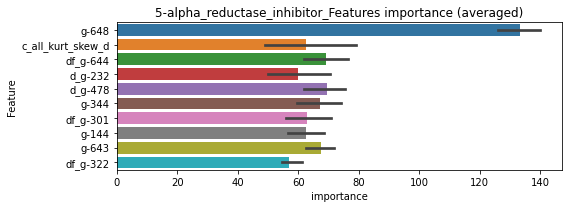

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108478	valid_1's binary_logloss: 0.0191627
[200]	training's binary_logloss: 0.00118723	valid_1's binary_logloss: 0.00834506
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000685105	valid_1's binary_logloss: 0.0075143


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113272	valid_1's binary_logloss: 0.0153016
[200]	training's binary_logloss: 0.00123358	valid_1's binary_logloss: 0.00271195
[300]	training's binary_logloss: 0.000344047	valid_1's binary_logloss: 0.00106799
[400]	training's binary_logloss: 0.000184934	valid_1's binary_logloss: 0.0007018
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000158543	valid_1's binary_logloss: 0.000641934


5-alpha_reductase_inhibitor logloss: 0.004078555614408115
11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250322	valid_1's binary_logloss: 0.0318195
[200]	training's binary_logloss: 0.00305005	valid_1's binary_logloss: 0.00581117
[300]	training's binary_logloss: 0.000850234	valid_1's binary_logloss: 0.00232573
[400]	training's binary_logloss: 0.000443152	valid_1's binary_logloss: 0.00143748
[500]	training's binary_logloss: 0.000345684	valid_1's binary_logloss: 0.00120164
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000339287	valid_1's binary_logloss: 0.0011907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250955	valid_1's binary_logloss: 0.0357703
[200]	training's binary_logloss: 0.00305398	valid_1's binary_logloss: 0.00636638
[300]	training's binary_logloss: 0.000849276	valid_1's binary_logloss: 0.00258968
[400]	training's binary_logloss: 0.00044056	valid_1's binary_logloss: 0.00167676
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0020919, Threshold: 0.0038484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00346, conf_1:0.00423
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0038484
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0138484
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0238484
threshold: 0.0238484, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241913	valid_1's binary_logloss: 0.03026
[200]	training's binary_logloss: 0.00292192	valid_1's binary_logloss: 0.00554263
[300]	training's binary_logloss: 0.000828689	valid_1's binary_logloss: 0.00218834
[400]	training's binary_logloss: 0.000435629	valid_1's binary_logloss: 0.00135662
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000350362	valid_1's binary_logloss: 0.00118275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242488	valid_1's binary_logloss: 0.0320781
[200]	training's binary_logloss: 0.00282038	valid_1's binary_logloss: 0.00532979
[300]	training's binary_logloss: 0.000808153	valid_1's binary_logloss: 0.00229044
[400]	training's binary_logloss: 0.000428791	valid_1's binary_logloss: 0.00150778
[500]	training's binary_logloss: 0.000345891	valid_1's binary_logloss: 0.00134801
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0971849, Threshold: 0.0238484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.02146, conf_1:0.02623
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.0238484
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0338484
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0438484
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0538484
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0638484
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0738484
threshold: 0.0738484, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241913	valid_1's binary_logloss: 0.03026
[200]	training's binary_logloss: 0.00292192	valid_1's binary_logloss: 0.00554263
[300]	training's binary_logloss: 0.000828689	valid_1's binary_logloss: 0.00218834
[400]	training's binary_logloss: 0.000435629	valid_1's binary_logloss: 0.00135662
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000350362	valid_1's binary_logloss: 0.00118275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242488	valid_1's binary_logloss: 0.0320781
[200]	training's binary_logloss: 0.00282038	valid_1's binary_logloss: 0.00532979
[300]	training's binary_logloss: 0.000808153	valid_1's binary_logloss: 0.00229044
[400]	training's binary_logloss: 0.000428791	valid_1's binary_logloss: 0.00150778
[500]	training's binary_logloss: 0.000345891	valid_1's binary_logloss: 0.00134801
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0971849, Threshold: 0.0738484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.06646, conf_1:0.08123
threshold: 0.0738484, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


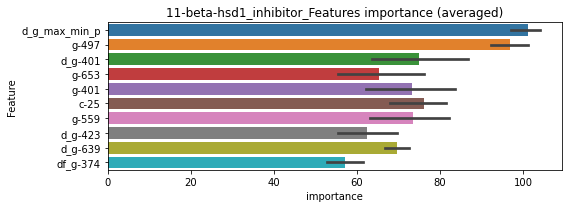

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129551	valid_1's binary_logloss: 0.0194501
[200]	training's binary_logloss: 0.00154317	valid_1's binary_logloss: 0.00538621
[300]	training's binary_logloss: 0.0004256	valid_1's binary_logloss: 0.00408092
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0004256	valid_1's binary_logloss: 0.00408092


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134985	valid_1's binary_logloss: 0.0190001
[200]	training's binary_logloss: 0.00167871	valid_1's binary_logloss: 0.00478474
[300]	training's binary_logloss: 0.000459617	valid_1's binary_logloss: 0.0029672
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00027419	valid_1's binary_logloss: 0.00271643


11-beta-hsd1_inhibitor logloss: 0.003398766378457403
acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336988	valid_1's binary_logloss: 0.04814
[200]	training's binary_logloss: 0.00452024	valid_1's binary_logloss: 0.0117151
[300]	training's binary_logloss: 0.00121583	valid_1's binary_logloss: 0.00604259
[400]	training's binary_logloss: 0.000599624	valid_1's binary_logloss: 0.00460698
[500]	training's binary_logloss: 0.000428159	valid_1's binary_logloss: 0.0042487
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000435194	valid_1's binary_logloss: 0.00423384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330798	valid_1's binary_logloss: 0.049981
[200]	training's binary_logloss: 0.00469431	valid_1's binary_logloss: 0.0111996
[300]	training's binary_logloss: 0.00126151	valid_1's binary_logloss: 0.00456548
[400]	training's binary_logloss: 0.000617921	valid_1's binary_logloss: 0.00293308
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0023463, Threshold: 0.0038266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00344, conf_1:0.00421
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0038266
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0138266
threshold: 0.0138266, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332034	valid_1's binary_logloss: 0.0487737
[200]	training's binary_logloss: 0.00449619	valid_1's binary_logloss: 0.0120475
[300]	training's binary_logloss: 0.00122217	valid_1's binary_logloss: 0.0064313
[400]	training's binary_logloss: 0.000607221	valid_1's binary_logloss: 0.00509631
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000607221	valid_1's binary_logloss: 0.00509631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317794	valid_1's binary_logloss: 0.048944
[200]	training's binary_logloss: 0.00444686	valid_1's binary_logloss: 0.0109317
[300]	training's binary_logloss: 0.00120737	valid_1's binary_logloss: 0.00442021
[400]	training's binary_logloss: 0.000601077	valid_1's binary_logloss: 0.00290089
[500]	training's binary_logloss: 0.000428136	valid_1's binary_logloss: 0.00238202
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0195138, Threshold: 0.0138266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0065294 Vs.target_rate: 0.00101, Num_p_label: 26.0, conf_0:0.01244, conf_1:0.01521
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.0138266
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0238266
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0338266
threshold: 0.0338266, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332034	valid_1's binary_logloss: 0.0487737
[200]	training's binary_logloss: 0.00449619	valid_1's binary_logloss: 0.0120475
[300]	training's binary_logloss: 0.00122217	valid_1's binary_logloss: 0.0064313
[400]	training's binary_logloss: 0.000607221	valid_1's binary_logloss: 0.00509631
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000607221	valid_1's binary_logloss: 0.00509631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317794	valid_1's binary_logloss: 0.048944
[200]	training's binary_logloss: 0.00444686	valid_1's binary_logloss: 0.0109317
[300]	training's binary_logloss: 0.00120737	valid_1's binary_logloss: 0.00442021
[400]	training's binary_logloss: 0.000601077	valid_1's binary_logloss: 0.00290089
[500]	training's binary_logloss: 0.000428136	valid_1's binary_logloss: 0.00238202
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0195138, Threshold: 0.0338266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.03044, conf_1:0.03721
threshold: 0.0338266, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


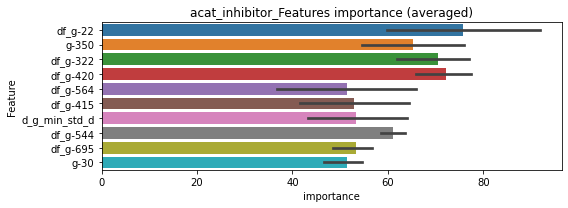

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196139	valid_1's binary_logloss: 0.029485
[200]	training's binary_logloss: 0.00256831	valid_1's binary_logloss: 0.00966522
[300]	training's binary_logloss: 0.000671909	valid_1's binary_logloss: 0.00740599
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000356392	valid_1's binary_logloss: 0.00721791


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193576	valid_1's binary_logloss: 0.0289577
[200]	training's binary_logloss: 0.00266006	valid_1's binary_logloss: 0.00786353
[300]	training's binary_logloss: 0.000709175	valid_1's binary_logloss: 0.00433983
[400]	training's binary_logloss: 0.000339582	valid_1's binary_logloss: 0.00365931
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00027336	valid_1's binary_logloss: 0.00347877


acat_inhibitor logloss: 0.005348341299582528
acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947588	valid_1's binary_logloss: 0.244389
[200]	training's binary_logloss: 0.0319722	valid_1's binary_logloss: 0.207743
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.022626	valid_1's binary_logloss: 0.205583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989006	valid_1's binary_logloss: 0.235282
[200]	training's binary_logloss: 0.0327714	valid_1's binary_logloss: 0.189584
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0190485	valid_1's binary_logloss: 0.183619


1 / 3 AUC score:0.943
y_Threshold: 0.0751420, Threshold: 0.1051689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 339 → Positive_corect_labels: 547/3571
p_label_rate: 0.0200904 Vs.target_rate: 0.00798, Num_p_label: 80.0, conf_0:0.09465, conf_1:0.11569
threshold: 0.1051689, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 547.0/3571, y_label_rate: 0.1531784
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769362	valid_1's binary_logloss: 0.183984
[200]	training's binary_logloss: 0.0215585	valid_1's binary_logloss: 0.139266
[300]	training's binary_logloss: 0.00691176	valid_1's binary_logloss: 0.12935
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00624379	valid_1's binary_logloss: 0.128724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794174	valid_1's binary_logloss: 0.200296
[200]	training's binary_logloss: 0.0228625	valid_1's binary_logloss: 0.153102
[300]	training's binary_logloss: 0.00755347	valid_1's binary_logloss: 0.14293
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00458703	valid_1's binary_logloss: 0.140043


2 / 3 AUC score:0.975
y_Threshold: 0.0622343, Threshold: 0.1051689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 100 → Positive_corect_labels: 497.0/3471
p_label_rate: 0.0072828 Vs.target_rate: 0.00798, Num_p_label: 29.0, conf_0:0.09465, conf_1:0.11569
threshold: 0.1051689, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 497.0/3471, y_label_rate: 0.1431864
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066457	valid_1's binary_logloss: 0.171743
[200]	training's binary_logloss: 0.017634	valid_1's binary_logloss: 0.126706
[300]	training's binary_logloss: 0.00565805	valid_1's binary_logloss: 0.117182
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00575689	valid_1's binary_logloss: 0.11687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713048	valid_1's binary_logloss: 0.180884
[200]	training's binary_logloss: 0.0183579	valid_1's binary_logloss: 0.12707


3 / 3 AUC score:0.989
y_Threshold: 0.0801000, Threshold: 0.1051689, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00763914	valid_1's binary_logloss: 0.114088


Remove_noisy_labels: 80 → Positive_corect_labels: 457.0/3391
p_label_rate: 0.0125565 Vs.target_rate: 0.00798, Num_p_label: 50.0, conf_0:0.09465, conf_1:0.11569
threshold: 0.1051689, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 507.0/7373, y_label_rate: 0.0687644


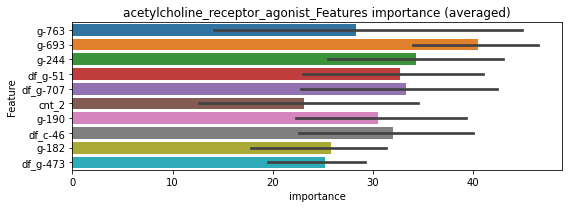

len(train_index) : 3686
len(valid_index) : 3687
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378746	valid_1's binary_logloss: 0.111095
[200]	training's binary_logloss: 0.0100182	valid_1's binary_logloss: 0.0889136
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00478448	valid_1's binary_logloss: 0.084899


len(train_index) : 3687
len(valid_index) : 3686
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371745	valid_1's binary_logloss: 0.109335
[200]	training's binary_logloss: 0.0092886	valid_1's binary_logloss: 0.0900056
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00664765	valid_1's binary_logloss: 0.0887992


acetylcholine_receptor_agonist logloss: 0.08684885810913132
acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129365	valid_1's binary_logloss: 0.315337
[200]	training's binary_logloss: 0.0499519	valid_1's binary_logloss: 0.291572
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.041815	valid_1's binary_logloss: 0.28934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129906	valid_1's binary_logloss: 0.305125
[200]	training's binary_logloss: 0.0511729	valid_1's binary_logloss: 0.280007


1 / 3 AUC score:0.864
y_Threshold: 0.1130070, Threshold: 0.1659255, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0506069	valid_1's binary_logloss: 0.279785


Remove_noisy_labels: 520 → Positive_corect_labels: 453/3369
p_label_rate: 0.0200904 Vs.target_rate: 0.01264, Num_p_label: 80.0, conf_0:0.14933, conf_1:0.18252
threshold: 0.1659255, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 453.0/3369, y_label_rate: 0.1344613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824861	valid_1's binary_logloss: 0.232244
[200]	training's binary_logloss: 0.0257409	valid_1's binary_logloss: 0.204955
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0209226	valid_1's binary_logloss: 0.202428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831488	valid_1's binary_logloss: 0.205404
[200]	training's binary_logloss: 0.0274108	valid_1's binary_logloss: 0.173853


2 / 3 AUC score:0.957
y_Threshold: 0.1042857, Threshold: 0.1659255, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 360.0/3183


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0182637	valid_1's binary_logloss: 0.169797


p_label_rate: 0.0130588 Vs.target_rate: 0.01264, Num_p_label: 52.0, conf_0:0.14933, conf_1:0.18252
threshold: 0.1659255, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 360.0/3183, y_label_rate: 0.1131008
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596434	valid_1's binary_logloss: 0.164428
[200]	training's binary_logloss: 0.0149781	valid_1's binary_logloss: 0.1423
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0100552	valid_1's binary_logloss: 0.141342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616427	valid_1's binary_logloss: 0.169269
[200]	training's binary_logloss: 0.0177618	valid_1's binary_logloss: 0.145061


3 / 3 AUC score:0.969
y_Threshold: 0.0867865, Threshold: 0.1659255, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 110 → Positive_corect_labels: 305.0/3073
p_label_rate: 0.0120542 Vs.target_rate: 0.01264, Num_p_label: 48.0, conf_0:0.14933, conf_1:0.18252
threshold: 0.1659255, positive_p_label: 48.0/3982, p_label_rate: 0.0120542


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.013618	valid_1's binary_logloss: 0.141353


positive_y_label: 353.0/7055, y_label_rate: 0.0500354


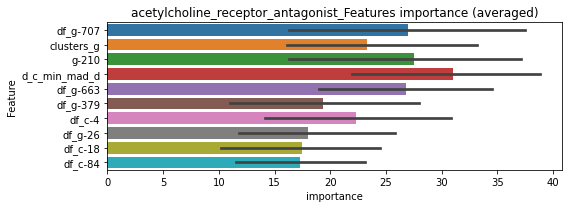

len(train_index) : 3527
len(valid_index) : 3528
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285677	valid_1's binary_logloss: 0.0898395
[200]	training's binary_logloss: 0.00711598	valid_1's binary_logloss: 0.0814714
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00748099	valid_1's binary_logloss: 0.0810456


len(train_index) : 3528
len(valid_index) : 3527
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294248	valid_1's binary_logloss: 0.0900061
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0130297	valid_1's binary_logloss: 0.0809924


acetylcholine_receptor_antagonist logloss: 0.08101901053976823
acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659546	valid_1's binary_logloss: 0.124046
[200]	training's binary_logloss: 0.0156302	valid_1's binary_logloss: 0.060349
[300]	training's binary_logloss: 0.00459501	valid_1's binary_logloss: 0.0398004
[400]	training's binary_logloss: 0.00193266	valid_1's binary_logloss: 0.0321483
[500]	training's binary_logloss: 0.00112151	valid_1's binary_logloss: 0.0295701
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000851624	valid_1's binary_logloss: 0.0286369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652433	valid_1's binary_logloss: 0.122174
[200]	training's binary_logloss: 0.0146878	valid_1's binary_logloss: 0.060192
[300]	training's binary_logloss: 0.00426897	valid_1's binary_logloss: 0.0431341
[400]	training's binary_logloss: 0.00182944	valid_1's binary_logloss: 0.0375573
Early stopping, best iteration is:
[400]	training'

1 / 3 AUC score:0.999
y_Threshold: 0.0114588, Threshold: 0.0143761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01294, conf_1:0.01581
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0143761
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_2: 0.0243761
threshold: 0.0243761, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 651.0/3791, y_label_rate: 0.1717225
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603798	valid_1's binary_logloss: 0.126881
[200]	training's binary_logloss: 0.0132825	valid_1's binary_logloss: 0.0735851
[300]	training's binary_logloss: 0.00387392	valid_1's binary_logloss: 0.061246
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00191334	valid_1's binary_logloss: 0.0573145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653089	valid_1's binary_logloss: 0.116389
[200]	training's binary_logloss: 0.0151182	valid_1's binary_logloss: 0.05508
[300]	training's binary_logloss: 0.00436252	valid_1's binary_logloss: 0.035495
[400]	training's binary_logloss: 0.00191406	valid_1's binary_logloss: 0.0300357
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00163416	valid_1's binary_logloss: 0.0288136


2 / 3 AUC score:0.996
y_Threshold: 0.0417877, Threshold: 0.0243761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 640.0/3769
p_label_rate: 0.0243596 Vs.target_rate: 0.00307, Num_p_label: 97.0, conf_0:0.02194, conf_1:0.02681
Num_p_label: 97.0, Expected: 12.2, Adj_threshold_1: 0.0243761
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0343761
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_3: 0.0443761
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_4: 0.0543761
threshold: 0.0543761, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 640.0/3769, y_label_rate: 0.1698063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590318	valid_1's binary_logloss: 0.116759
[200]	training's binary_logloss: 0.0132848	valid_1's binary_logloss: 0.0659884
[300]	training's binary_logloss: 0.00393902	valid_1's binary_logloss: 0.0515273
[400]	training's binary_logloss: 0.00171113	valid_1's binary_logloss: 0.0474843
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00162035	valid_1's binary_logloss: 0.0471034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634721	valid_1's binary_logloss: 0.11341
[200]	training's binary_logloss: 0.0146664	valid_1's binary_logloss: 0.0585823
[300]	training's binary_logloss: 0.00422886	valid_1's binary_logloss: 0.0421669
[400]	training's binary_logloss: 0.00181398	valid_1's binary_logloss: 0.0372907
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00164787	valid_1's binary_logloss: 0.0369516


3 / 3 AUC score:0.998
y_Threshold: 0.0396998, Threshold: 0.0543761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 628.0/3745
p_label_rate: 0.0037670 Vs.target_rate: 0.00307, Num_p_label: 15.0, conf_0:0.04894, conf_1:0.05981
threshold: 0.0543761, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 643.0/7727, y_label_rate: 0.0832147


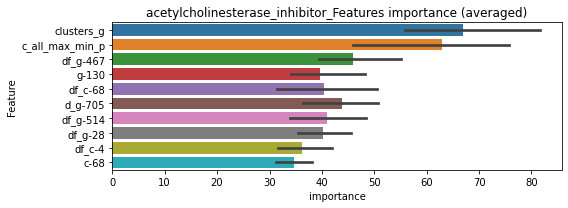

len(train_index) : 3863
len(valid_index) : 3864
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354264	valid_1's binary_logloss: 0.0675086
[200]	training's binary_logloss: 0.00809099	valid_1's binary_logloss: 0.0377181
[300]	training's binary_logloss: 0.00226195	valid_1's binary_logloss: 0.0313871
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00122807	valid_1's binary_logloss: 0.030212


len(train_index) : 3864
len(valid_index) : 3863
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352002	valid_1's binary_logloss: 0.069097
[200]	training's binary_logloss: 0.00779924	valid_1's binary_logloss: 0.0419906
[300]	training's binary_logloss: 0.00212872	valid_1's binary_logloss: 0.035962
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00200898	valid_1's binary_logloss: 0.035856


acetylcholinesterase_inhibitor logloss: 0.03303361479469008
adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476954	valid_1's binary_logloss: 0.0931656
[200]	training's binary_logloss: 0.00904767	valid_1's binary_logloss: 0.0458365
[300]	training's binary_logloss: 0.00254913	valid_1's binary_logloss: 0.0339694
[400]	training's binary_logloss: 0.00119634	valid_1's binary_logloss: 0.0305556
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00107326	valid_1's binary_logloss: 0.0300703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480494	valid_1's binary_logloss: 0.0923809
[200]	training's binary_logloss: 0.00913575	valid_1's binary_logloss: 0.0415963
[300]	training's binary_logloss: 0.0026787	valid_1's binary_logloss: 0.0307936
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00160625	valid_1's binary_logloss: 0.0284838


1 / 3 AUC score:0.999
y_Threshold: 0.0111442, Threshold: 0.0154254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.01388, conf_1:0.01697
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0154254
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_2: 0.0254254
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_3: 0.0354254
threshold: 0.0354254, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494036	valid_1's binary_logloss: 0.0931033
[200]	training's binary_logloss: 0.00916742	valid_1's binary_logloss: 0.0348666
[300]	training's binary_logloss: 0.00263898	valid_1's binary_logloss: 0.0199384
[400]	training's binary_logloss: 0.0012143	valid_1's binary_logloss: 0.0152976
[500]	training's binary_logloss: 0.000761836	valid_1's binary_logloss: 0.0138982
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000639439	valid_1's binary_logloss: 0.0133376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489592	valid_1's binary_logloss: 0.0834344
[200]	training's binary_logloss: 0.00892525	valid_1's binary_logloss: 0.0289298
[300]	training's binary_logloss: 0.00260589	valid_1's binary_logloss: 0.0162554
[400]	training's binary_logloss: 0.00122374	valid_1's binary_logloss: 0.0122697
[500]	training's binary_logloss: 0.000772148

2 / 3 AUC score:1.000
y_Threshold: 0.0322583, Threshold: 0.0354254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0072828 Vs.target_rate: 0.00227, Num_p_label: 29.0, conf_0:0.03188, conf_1:0.03897
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_1: 0.0354254
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.0454254
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_3: 0.0554254
threshold: 0.0554254, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046743	valid_1's binary_logloss: 0.0976303
[200]	training's binary_logloss: 0.00857633	valid_1's binary_logloss: 0.0494475
[300]	training's binary_logloss: 0.00248204	valid_1's binary_logloss: 0.0391663
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00176783	valid_1's binary_logloss: 0.038086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504528	valid_1's binary_logloss: 0.0841263
[200]	training's binary_logloss: 0.00949472	valid_1's binary_logloss: 0.0301689
[300]	training's binary_logloss: 0.00270339	valid_1's binary_logloss: 0.0162021
[400]	training's binary_logloss: 0.00122829	valid_1's binary_logloss: 0.0123723
[500]	training's binary_logloss: 0.000772491	valid_1's binary_logloss: 0.0107826
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000625477	valid_1's binary_logloss: 0.0101666


3 / 3 AUC score:0.998
y_Threshold: 0.0285672, Threshold: 0.0554254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 641.0/3775
p_label_rate: 0.0057760 Vs.target_rate: 0.00227, Num_p_label: 23.0, conf_0:0.04988, conf_1:0.06097
threshold: 0.0554254, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 664.0/7757, y_label_rate: 0.0856001


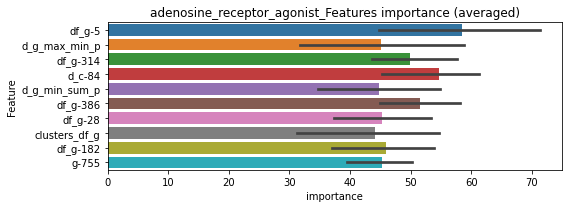

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263871	valid_1's binary_logloss: 0.0594061
[200]	training's binary_logloss: 0.00490953	valid_1's binary_logloss: 0.0336915
[300]	training's binary_logloss: 0.00139896	valid_1's binary_logloss: 0.0287723
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00152688	valid_1's binary_logloss: 0.0287238


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029	valid_1's binary_logloss: 0.0597728
[200]	training's binary_logloss: 0.0054257	valid_1's binary_logloss: 0.0295709
[300]	training's binary_logloss: 0.00152196	valid_1's binary_logloss: 0.0226168
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000834443	valid_1's binary_logloss: 0.0208632


adenosine_receptor_agonist logloss: 0.02479400103239272
adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718838	valid_1's binary_logloss: 0.141013
[200]	training's binary_logloss: 0.0188604	valid_1's binary_logloss: 0.0893259
[300]	training's binary_logloss: 0.00560657	valid_1's binary_logloss: 0.0730803
[400]	training's binary_logloss: 0.00238939	valid_1's binary_logloss: 0.0670288
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00241025	valid_1's binary_logloss: 0.0669473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640879	valid_1's binary_logloss: 0.138135
[200]	training's binary_logloss: 0.0165153	valid_1's binary_logloss: 0.087339
[300]	training's binary_logloss: 0.00489253	valid_1's binary_logloss: 0.071382
[400]	training's binary_logloss: 0.00215395	valid_1's binary_logloss: 0.0680323
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00229866	valid_1's binary_logloss: 0.0679951


1 / 3 AUC score:0.990
y_Threshold: 0.0186485, Threshold: 0.0214299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 640/3767
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.01929, conf_1:0.02357
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0214299
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_2: 0.0314299
threshold: 0.0314299, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 640.0/3767, y_label_rate: 0.1698965
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626696	valid_1's binary_logloss: 0.129332
[200]	training's binary_logloss: 0.0149815	valid_1's binary_logloss: 0.076405
[300]	training's binary_logloss: 0.00456094	valid_1's binary_logloss: 0.0610615
[400]	training's binary_logloss: 0.00203092	valid_1's binary_logloss: 0.0564722
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00196949	valid_1's binary_logloss: 0.056155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665726	valid_1's binary_logloss: 0.134115
[200]	training's binary_logloss: 0.016659	valid_1's binary_logloss: 0.0861933
[300]	training's binary_logloss: 0.00500156	valid_1's binary_logloss: 0.0720025
[400]	training's binary_logloss: 0.002174	valid_1's binary_logloss: 0.069245
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00224793	valid_1's binary_logloss: 0.0690455


2 / 3 AUC score:0.997
y_Threshold: 0.0403626, Threshold: 0.0314299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 617.0/3721
p_label_rate: 0.0188348 Vs.target_rate: 0.00403, Num_p_label: 75.0, conf_0:0.02829, conf_1:0.03457
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_1: 0.0314299
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_2: 0.0414299
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_3: 0.0514299
threshold: 0.0514299, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 617.0/3721, y_label_rate: 0.1658156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604983	valid_1's binary_logloss: 0.136815
[200]	training's binary_logloss: 0.014113	valid_1's binary_logloss: 0.0850024
[300]	training's binary_logloss: 0.00425208	valid_1's binary_logloss: 0.0695763
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00221957	valid_1's binary_logloss: 0.0659731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587616	valid_1's binary_logloss: 0.129264
[200]	training's binary_logloss: 0.0129668	valid_1's binary_logloss: 0.0794015
[300]	training's binary_logloss: 0.00389848	valid_1's binary_logloss: 0.0642785
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00217385	valid_1's binary_logloss: 0.060899


3 / 3 AUC score:0.997
y_Threshold: 0.0439799, Threshold: 0.0514299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 601.0/3689
p_label_rate: 0.0092918 Vs.target_rate: 0.00403, Num_p_label: 37.0, conf_0:0.04629, conf_1:0.05657
threshold: 0.0514299, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 638.0/7671, y_label_rate: 0.0831704


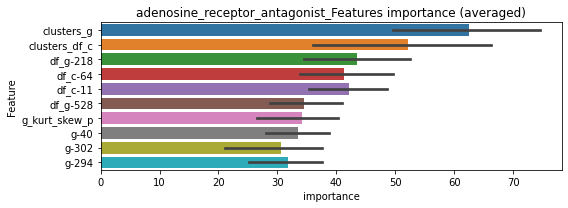

len(train_index) : 3835
len(valid_index) : 3836
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368848	valid_1's binary_logloss: 0.0780785
[200]	training's binary_logloss: 0.00846372	valid_1's binary_logloss: 0.051265
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00378538	valid_1's binary_logloss: 0.0473985


len(train_index) : 3836
len(valid_index) : 3835
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033915	valid_1's binary_logloss: 0.081553
[200]	training's binary_logloss: 0.00800247	valid_1's binary_logloss: 0.0540223
[300]	training's binary_logloss: 0.00249271	valid_1's binary_logloss: 0.0482525
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00160826	valid_1's binary_logloss: 0.0474794


adenosine_receptor_antagonist logloss: 0.047438946194666244
adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217571	valid_1's binary_logloss: 0.0276703
[200]	training's binary_logloss: 0.00240059	valid_1's binary_logloss: 0.00499069
[300]	training's binary_logloss: 0.000675285	valid_1's binary_logloss: 0.00208325
[400]	training's binary_logloss: 0.00035889	valid_1's binary_logloss: 0.00134852
[500]	training's binary_logloss: 0.000288551	valid_1's binary_logloss: 0.00117763
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000288551	valid_1's binary_logloss: 0.00117763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217925	valid_1's binary_logloss: 0.0265635
[200]	training's binary_logloss: 0.00240158	valid_1's binary_logloss: 0.00400135
[300]	training's binary_logloss: 0.000670787	valid_1's binary_logloss: 0.00154779
[400]	training's binary_logloss: 0.000361625	valid_1's binary_logloss: 0.000984585
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0014718, Threshold: 0.0031787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00286, conf_1:0.00350
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0031787
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0131787
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0231787
threshold: 0.0231787, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212345	valid_1's binary_logloss: 0.026531
[200]	training's binary_logloss: 0.00228539	valid_1's binary_logloss: 0.00438489
[300]	training's binary_logloss: 0.000633306	valid_1's binary_logloss: 0.00159855
[400]	training's binary_logloss: 0.000343561	valid_1's binary_logloss: 0.00102355
[500]	training's binary_logloss: 0.000281912	valid_1's binary_logloss: 0.000899876
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000277416	valid_1's binary_logloss: 0.00089565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218037	valid_1's binary_logloss: 0.0256277
[200]	training's binary_logloss: 0.00233895	valid_1's binary_logloss: 0.00335217
[300]	training's binary_logloss: 0.000635892	valid_1's binary_logloss: 0.00105774
[400]	training's binary_logloss: 0.000343805	valid_1's binary_logloss: 0.000615111
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1423975, Threshold: 0.0231787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0050226 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.02086, conf_1:0.02550
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.0231787
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0331787
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0431787
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.0531787
threshold: 0.0531787, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212345	valid_1's binary_logloss: 0.026531
[200]	training's binary_logloss: 0.00228539	valid_1's binary_logloss: 0.00438489
[300]	training's binary_logloss: 0.000633306	valid_1's binary_logloss: 0.00159855
[400]	training's binary_logloss: 0.000343561	valid_1's binary_logloss: 0.00102355
[500]	training's binary_logloss: 0.000281912	valid_1's binary_logloss: 0.000899876
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000277416	valid_1's binary_logloss: 0.00089565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218037	valid_1's binary_logloss: 0.0256277
[200]	training's binary_logloss: 0.00233895	valid_1's binary_logloss: 0.00335217
[300]	training's binary_logloss: 0.000635892	valid_1's binary_logloss: 0.00105774
[400]	training's binary_logloss: 0.000343805	valid_1's binary_logloss: 0.000615111
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1423975, Threshold: 0.0531787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.04786, conf_1:0.05850
threshold: 0.0531787, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


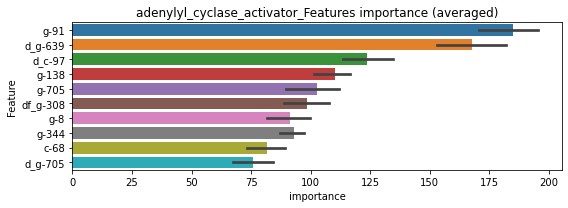

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109822	valid_1's binary_logloss: 0.0185476
[200]	training's binary_logloss: 0.00114007	valid_1's binary_logloss: 0.00644879
[300]	training's binary_logloss: 0.000315847	valid_1's binary_logloss: 0.00521071
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000278224	valid_1's binary_logloss: 0.00514695


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114549	valid_1's binary_logloss: 0.0136091
[200]	training's binary_logloss: 0.00128557	valid_1's binary_logloss: 0.00243028
[300]	training's binary_logloss: 0.0003612	valid_1's binary_logloss: 0.00122831
[400]	training's binary_logloss: 0.00019134	valid_1's binary_logloss: 0.000984855
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000151133	valid_1's binary_logloss: 0.000935976


adenylyl_cyclase_activator logloss: 0.003041734102663366
adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104422	valid_1's binary_logloss: 0.277931
[200]	training's binary_logloss: 0.0355287	valid_1's binary_logloss: 0.246277
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0251195	valid_1's binary_logloss: 0.243678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127539	valid_1's binary_logloss: 0.268701
[200]	training's binary_logloss: 0.0501711	valid_1's binary_logloss: 0.221027
[300]	training's binary_logloss: 0.019578	valid_1's binary_logloss: 0.206655
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.019048	valid_1's binary_logloss: 0.206268


1 / 3 AUC score:0.925
y_Threshold: 0.0851082, Threshold: 0.1183634, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 387 → Positive_corect_labels: 520/3505
p_label_rate: 0.0200904 Vs.target_rate: 0.01134, Num_p_label: 80.0, conf_0:0.10653, conf_1:0.13020
threshold: 0.1183634, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 520.0/3505, y_label_rate: 0.1483595
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802677	valid_1's binary_logloss: 0.217685
[200]	training's binary_logloss: 0.0242647	valid_1's binary_logloss: 0.17858
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0141868	valid_1's binary_logloss: 0.172998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900469	valid_1's binary_logloss: 0.220566
[200]	training's binary_logloss: 0.0289754	valid_1's binary_logloss: 0.176924


2 / 3 AUC score:0.971
y_Threshold: 0.0876086, Threshold: 0.1183634, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0164797	valid_1's binary_logloss: 0.169249


Remove_noisy_labels: 162 → Positive_corect_labels: 439.0/3343
p_label_rate: 0.0113009 Vs.target_rate: 0.01134, Num_p_label: 45.0, conf_0:0.10653, conf_1:0.13020
threshold: 0.1183634, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 439.0/3343, y_label_rate: 0.1313192
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676085	valid_1's binary_logloss: 0.190881
[200]	training's binary_logloss: 0.0185689	valid_1's binary_logloss: 0.15264
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0104119	valid_1's binary_logloss: 0.145816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682035	valid_1's binary_logloss: 0.189602
[200]	training's binary_logloss: 0.018205	valid_1's binary_logloss: 0.156942
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00797011	valid_1's binary_logloss: 0.150529


3 / 3 AUC score:0.975
y_Threshold: 0.0662511, Threshold: 0.1183634, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 110 → Positive_corect_labels: 384.0/3233
p_label_rate: 0.0075339 Vs.target_rate: 0.01134, Num_p_label: 30.0, conf_0:0.10653, conf_1:0.13020
threshold: 0.1183634, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 414.0/7215, y_label_rate: 0.0573805


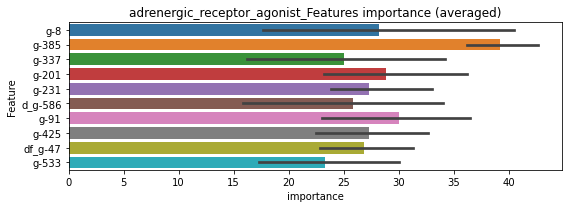

len(train_index) : 3607
len(valid_index) : 3608
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326951	valid_1's binary_logloss: 0.106813
[200]	training's binary_logloss: 0.00889261	valid_1's binary_logloss: 0.0921363
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00660812	valid_1's binary_logloss: 0.0909128


len(train_index) : 3608
len(valid_index) : 3607
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300516	valid_1's binary_logloss: 0.107547
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00856442	valid_1's binary_logloss: 0.0967508


adrenergic_receptor_agonist logloss: 0.09383139097419714
adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132354	valid_1's binary_logloss: 0.345114
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0602279	valid_1's binary_logloss: 0.331193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147392	valid_1's binary_logloss: 0.345184
[200]	training's binary_logloss: 0.0587021	valid_1's binary_logloss: 0.323472


1 / 3 AUC score:0.821
y_Threshold: 0.1236107, Threshold: 0.1566538, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0576695	valid_1's binary_logloss: 0.323375


Remove_noisy_labels: 586 → Positive_corect_labels: 417/3288
p_label_rate: 0.0200904 Vs.target_rate: 0.01512, Num_p_label: 80.0, conf_0:0.14099, conf_1:0.17232
threshold: 0.1566538, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 417.0/3288, y_label_rate: 0.1268248
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077923	valid_1's binary_logloss: 0.237735
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0324954	valid_1's binary_logloss: 0.21976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822962	valid_1's binary_logloss: 0.22391
[200]	training's binary_logloss: 0.0268218	valid_1's binary_logloss: 0.200804


2 / 3 AUC score:0.935
y_Threshold: 0.0918151, Threshold: 0.1566538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 228 → Positive_corect_labels: 303.0/3060


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0184612	valid_1's binary_logloss: 0.198574


p_label_rate: 0.0037670 Vs.target_rate: 0.01512, Num_p_label: 15.0, conf_0:0.14099, conf_1:0.17232
Num_p_label: 15.0, Expected: 60.2, Adj_threshold_1: 0.1566538
Num_p_label: 20.0, Expected: 60.2, Adj_threshold_2: 0.1466538
Num_p_label: 25.0, Expected: 60.2, Adj_threshold_3: 0.1366538
Num_p_label: 32.0, Expected: 60.2, Adj_threshold_4: 0.1266538
threshold: 0.1266538, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 303.0/3060, y_label_rate: 0.0990196
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476589	valid_1's binary_logloss: 0.171166
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0166183	valid_1's binary_logloss: 0.156616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054462	valid_1's binary_logloss: 0.173009


3 / 3 AUC score:0.951
y_Threshold: 0.0823573, Threshold: 0.1266538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → Positive_corect_labels: 240.0/2934


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0227602	valid_1's binary_logloss: 0.156647


p_label_rate: 0.0045203 Vs.target_rate: 0.01512, Num_p_label: 18.0, conf_0:0.11399, conf_1:0.13932
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_1: 0.1266538
Num_p_label: 28.0, Expected: 60.2, Adj_threshold_2: 0.1166538
Num_p_label: 46.0, Expected: 60.2, Adj_threshold_3: 0.1066538
threshold: 0.1066538, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 286.0/6916, y_label_rate: 0.0413534


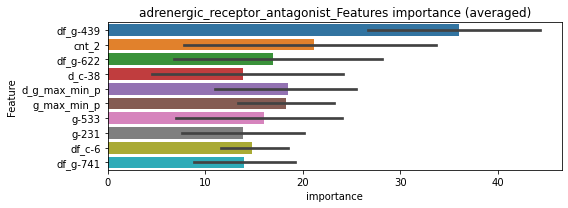

len(train_index) : 3458
len(valid_index) : 3458
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020591	valid_1's binary_logloss: 0.0866449


len(train_index) : 3458
len(valid_index) : 3458


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0124727	valid_1's binary_logloss: 0.0820941


================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214046	valid_1's binary_logloss: 0.0897453


adrenergic_receptor_antagonist logloss: 0.08421839823139411


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0104312	valid_1's binary_logloss: 0.0863427


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382386	valid_1's binary_logloss: 0.0840806
[200]	training's binary_logloss: 0.00667222	valid_1's binary_logloss: 0.0427196
[300]	training's binary_logloss: 0.00196926	valid_1's binary_logloss: 0.0299447
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00118331	valid_1's binary_logloss: 0.027491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391955	valid_1's binary_logloss: 0.0765096
[200]	training's binary_logloss: 0.00712562	valid_1's binary_logloss: 0.0355388
[300]	training's binary_logloss: 0.00213484	valid_1's binary_logloss: 0.0273843
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00150593	valid_1's binary_logloss: 0.0263532


1 / 3 AUC score:0.999
y_Threshold: 0.0105700, Threshold: 0.0299859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00277, Num_p_label: 80.0, conf_0:0.02699, conf_1:0.03298
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0299859
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_2: 0.0399859
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_3: 0.0499859
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_4: 0.0599859
Num_p_label: 42.0, Expected: 11.0, Adj_threshold_5: 0.0699859
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_6: 0.0799859
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_7: 0.0899859
Num_p_label: 37.0, Expected: 11.0, Adj_threshold_8: 0.0999859
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_9: 0.1099859
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_10: 0.1199859
threshold: 0.1299859, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 652.0/3795, y_label_rate: 0.171805

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382287	valid_1's binary_logloss: 0.0757669
[200]	training's binary_logloss: 0.00634978	valid_1's binary_logloss: 0.0329107
[300]	training's binary_logloss: 0.00187761	valid_1's binary_logloss: 0.023402
[400]	training's binary_logloss: 0.000911503	valid_1's binary_logloss: 0.0198377
[500]	training's binary_logloss: 0.000597242	valid_1's binary_logloss: 0.0187576
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000578227	valid_1's binary_logloss: 0.0186546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371427	valid_1's binary_logloss: 0.0736349
[200]	training's binary_logloss: 0.00598155	valid_1's binary_logloss: 0.0305563
[300]	training's binary_logloss: 0.00179806	valid_1's binary_logloss: 0.0212725
[400]	training's binary_logloss: 0.00088284	valid_1's binary_logloss: 0.0187735
Early stopping, best iteration is:
[450]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0918525, Threshold: 0.1299859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 646.0/3783
p_label_rate: 0.0180814 Vs.target_rate: 0.00277, Num_p_label: 72.0, conf_0:0.11699, conf_1:0.14298
Num_p_label: 72.0, Expected: 11.0, Adj_threshold_1: 0.1299859
Num_p_label: 69.0, Expected: 11.0, Adj_threshold_2: 0.1399859
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_3: 0.1499859
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_4: 0.1599859
Num_p_label: 63.0, Expected: 11.0, Adj_threshold_5: 0.1699859
Num_p_label: 62.0, Expected: 11.0, Adj_threshold_6: 0.1799859
Num_p_label: 60.0, Expected: 11.0, Adj_threshold_7: 0.1899859
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_8: 0.1999859
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_9: 0.2099859
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_10: 0.2199859
threshold: 0.2299859, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 646.0/3783, y_label_rate: 0.17076

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362725	valid_1's binary_logloss: 0.0809779
[200]	training's binary_logloss: 0.00580301	valid_1's binary_logloss: 0.0413817
[300]	training's binary_logloss: 0.00172394	valid_1's binary_logloss: 0.0343527
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0013381	valid_1's binary_logloss: 0.0333757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365296	valid_1's binary_logloss: 0.0647427
[200]	training's binary_logloss: 0.00583771	valid_1's binary_logloss: 0.0274522
[300]	training's binary_logloss: 0.00173425	valid_1's binary_logloss: 0.0195851
[400]	training's binary_logloss: 0.000863151	valid_1's binary_logloss: 0.0171496
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000854116	valid_1's binary_logloss: 0.0171238


3 / 3 AUC score:0.998
y_Threshold: 0.0471764, Threshold: 0.2299859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 636.0/3763
p_label_rate: 0.0148167 Vs.target_rate: 0.00277, Num_p_label: 59.0, conf_0:0.20699, conf_1:0.25298
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_1: 0.2299859
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_2: 0.2399859
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_3: 0.2499859
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_4: 0.2599859
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_5: 0.2699859
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_6: 0.2799859
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_7: 0.2899859
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_8: 0.2999859
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_9: 0.3099859
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_10: 0.3199859
threshold: 0.3299859, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 688.0/7745, y_label_rate: 0.08883

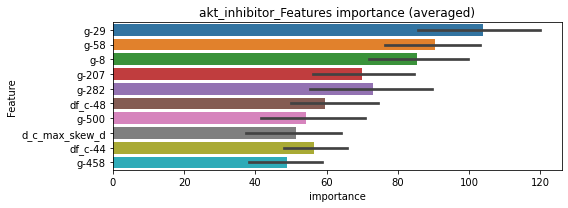

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194838	valid_1's binary_logloss: 0.0396725
[200]	training's binary_logloss: 0.00322325	valid_1's binary_logloss: 0.0186699
[300]	training's binary_logloss: 0.000943433	valid_1's binary_logloss: 0.0139355
[400]	training's binary_logloss: 0.000466651	valid_1's binary_logloss: 0.0126473
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000411729	valid_1's binary_logloss: 0.0123625


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196308	valid_1's binary_logloss: 0.0528925
[200]	training's binary_logloss: 0.00326013	valid_1's binary_logloss: 0.0310144
[300]	training's binary_logloss: 0.000893975	valid_1's binary_logloss: 0.0241945
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000594823	valid_1's binary_logloss: 0.0234414


akt_inhibitor logloss: 0.01790119244090043
aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250438	valid_1's binary_logloss: 0.0342336
[200]	training's binary_logloss: 0.00304955	valid_1's binary_logloss: 0.00685117
[300]	training's binary_logloss: 0.000851718	valid_1's binary_logloss: 0.00296972
[400]	training's binary_logloss: 0.000444225	valid_1's binary_logloss: 0.00205149
[500]	training's binary_logloss: 0.000343687	valid_1's binary_logloss: 0.00183728
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000339242	valid_1's binary_logloss: 0.00182918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254309	valid_1's binary_logloss: 0.0314637
[200]	training's binary_logloss: 0.00304306	valid_1's binary_logloss: 0.00500533
[300]	training's binary_logloss: 0.000860317	valid_1's binary_logloss: 0.00179792
[400]	training's binary_logloss: 0.000451395	valid_1's binary_logloss: 0.00106438
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0018157, Threshold: 0.0025788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00232, conf_1:0.00284
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0025788
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.0125788
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_3: 0.0225788
threshold: 0.0225788, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248419	valid_1's binary_logloss: 0.0325032
[200]	training's binary_logloss: 0.0028947	valid_1's binary_logloss: 0.00574013
[300]	training's binary_logloss: 0.000815377	valid_1's binary_logloss: 0.0023136
[400]	training's binary_logloss: 0.000434331	valid_1's binary_logloss: 0.00159366
[500]	training's binary_logloss: 0.00034592	valid_1's binary_logloss: 0.00141869
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000347081	valid_1's binary_logloss: 0.00141806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246982	valid_1's binary_logloss: 0.0298789
[200]	training's binary_logloss: 0.00294258	valid_1's binary_logloss: 0.00501965
[300]	training's binary_logloss: 0.000833438	valid_1's binary_logloss: 0.00203624
[400]	training's binary_logloss: 0.000437687	valid_1's binary_logloss: 0.00132134
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0857251, Threshold: 0.0225788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00080, Num_p_label: 19.0, conf_0:0.02032, conf_1:0.02484
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_1: 0.0225788
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.0325788
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.0425788
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.0525788
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.0625788
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.0725788
threshold: 0.0725788, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248419	valid_1's binary_logloss: 0.0325032
[200]	training's binary_logloss: 0.0028947	valid_1's binary_logloss: 0.00574013
[300]	training's binary_logloss: 0.000815377	valid_1's binary_logloss: 0.0023136
[400]	training's binary_logloss: 0.000434331	valid_1's binary_logloss: 0.00159366
[500]	training's binary_logloss: 0.00034592	valid_1's binary_logloss: 0.00141869
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000347081	valid_1's binary_logloss: 0.00141806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246982	valid_1's binary_logloss: 0.0298789
[200]	training's binary_logloss: 0.00294258	valid_1's binary_logloss: 0.00501965
[300]	training's binary_logloss: 0.000833438	valid_1's binary_logloss: 0.00203624
[400]	training's binary_logloss: 0.000437687	valid_1's binary_logloss: 0.00132134
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0857251, Threshold: 0.0725788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.06532, conf_1:0.07984
threshold: 0.0725788, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


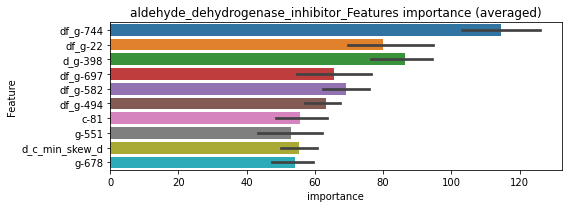

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137644	valid_1's binary_logloss: 0.0215137
[200]	training's binary_logloss: 0.00156128	valid_1's binary_logloss: 0.00750816
[300]	training's binary_logloss: 0.000419057	valid_1's binary_logloss: 0.00630916
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000447699	valid_1's binary_logloss: 0.00630011


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013864	valid_1's binary_logloss: 0.0182952
[200]	training's binary_logloss: 0.00166001	valid_1's binary_logloss: 0.00345005
[300]	training's binary_logloss: 0.000452371	valid_1's binary_logloss: 0.00179369
[400]	training's binary_logloss: 0.000233776	valid_1's binary_logloss: 0.00151758
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000190843	valid_1's binary_logloss: 0.00145326


aldehyde_dehydrogenase_inhibitor logloss: 0.0038769959473031477
alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333184	valid_1's binary_logloss: 0.0653371
[200]	training's binary_logloss: 0.00509006	valid_1's binary_logloss: 0.0292223
[300]	training's binary_logloss: 0.00149715	valid_1's binary_logloss: 0.0227222
[400]	training's binary_logloss: 0.000741423	valid_1's binary_logloss: 0.0196775
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000724445	valid_1's binary_logloss: 0.0196194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347824	valid_1's binary_logloss: 0.0575544
[200]	training's binary_logloss: 0.00571833	valid_1's binary_logloss: 0.0188053
[300]	training's binary_logloss: 0.00166379	valid_1's binary_logloss: 0.00960443
[400]	training's binary_logloss: 0.000800146	valid_1's binary_logloss: 0.00666307
[500]	training's binary_logloss: 0.000537537	valid_1's binary_logloss: 0.00545639
[600]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0063379, Threshold: 0.0204921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.01844, conf_1:0.02254
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0204921
Num_p_label: 58.0, Expected: 7.0, Adj_threshold_2: 0.0304921
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_3: 0.0404921
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_4: 0.0504921
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_5: 0.0604921
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_6: 0.0704921
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_7: 0.0804921
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_8: 0.0904921
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_9: 0.1004921
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_10: 0.1104921
threshold: 0.1204921, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318302	valid_1's binary_logloss: 0.0578209
[200]	training's binary_logloss: 0.00464635	valid_1's binary_logloss: 0.023756
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00165163	valid_1's binary_logloss: 0.0186279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320092	valid_1's binary_logloss: 0.0515687
[200]	training's binary_logloss: 0.00482859	valid_1's binary_logloss: 0.0138834
[300]	training's binary_logloss: 0.00141349	valid_1's binary_logloss: 0.00610144
[400]	training's binary_logloss: 0.000710516	valid_1's binary_logloss: 0.00402651
[500]	training's binary_logloss: 0.000490648	valid_1's binary_logloss: 0.0032829
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000457965	valid_1's binary_logloss: 0.00313009


2 / 3 AUC score:1.000
y_Threshold: 0.1215672, Threshold: 0.1204921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0185836 Vs.target_rate: 0.00176, Num_p_label: 74.0, conf_0:0.10844, conf_1:0.13254
Num_p_label: 74.0, Expected: 7.0, Adj_threshold_1: 0.1204921
Num_p_label: 71.0, Expected: 7.0, Adj_threshold_2: 0.1304921
Num_p_label: 62.0, Expected: 7.0, Adj_threshold_3: 0.1404921
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_4: 0.1504921
Num_p_label: 58.0, Expected: 7.0, Adj_threshold_5: 0.1604921
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_6: 0.1704921
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_7: 0.1804921
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_8: 0.1904921
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_9: 0.2004921
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_10: 0.2104921
threshold: 0.2204921, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320813	valid_1's binary_logloss: 0.0586544
[200]	training's binary_logloss: 0.00459209	valid_1's binary_logloss: 0.0228908
[300]	training's binary_logloss: 0.00133668	valid_1's binary_logloss: 0.0174619
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00105669	valid_1's binary_logloss: 0.0167579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317506	valid_1's binary_logloss: 0.0531971
[200]	training's binary_logloss: 0.00466134	valid_1's binary_logloss: 0.0145108
[300]	training's binary_logloss: 0.00132574	valid_1's binary_logloss: 0.0071648
[400]	training's binary_logloss: 0.000670751	valid_1's binary_logloss: 0.00524407
[500]	training's binary_logloss: 0.000466579	valid_1's binary_logloss: 0.0045514
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000443245	valid_1's binary_logloss: 0.00447019


3 / 3 AUC score:1.000
y_Threshold: 0.0630549, Threshold: 0.2204921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3786
p_label_rate: 0.0130588 Vs.target_rate: 0.00176, Num_p_label: 52.0, conf_0:0.19844, conf_1:0.24254
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_1: 0.2204921
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_2: 0.2304921
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_3: 0.2404921
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_4: 0.2504921
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_5: 0.2604921
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_6: 0.2704921
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_7: 0.2804921
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_8: 0.2904921
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_9: 0.3004921
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_10: 0.3104921
threshold: 0.3204921, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 685.0/7768, y_label_rate: 0.0881823


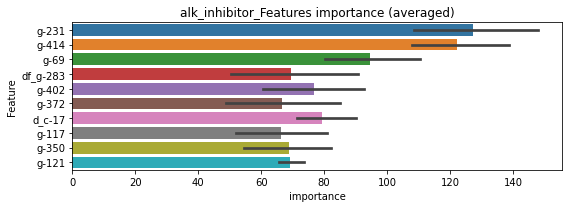

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184656	valid_1's binary_logloss: 0.0347229
[200]	training's binary_logloss: 0.00282609	valid_1's binary_logloss: 0.016055
[300]	training's binary_logloss: 0.000850091	valid_1's binary_logloss: 0.0132983
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000889069	valid_1's binary_logloss: 0.0132711


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181789	valid_1's binary_logloss: 0.0401309
[200]	training's binary_logloss: 0.00282171	valid_1's binary_logloss: 0.0189919
[300]	training's binary_logloss: 0.000838317	valid_1's binary_logloss: 0.0138487
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000524611	valid_1's binary_logloss: 0.0124851


alk_inhibitor logloss: 0.01287810571815542
ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196949	valid_1's binary_logloss: 0.0246624
[200]	training's binary_logloss: 0.00208052	valid_1's binary_logloss: 0.00424291
[300]	training's binary_logloss: 0.00059389	valid_1's binary_logloss: 0.00169362
[400]	training's binary_logloss: 0.000329944	valid_1's binary_logloss: 0.00110432
[500]	training's binary_logloss: 0.000284394	valid_1's binary_logloss: 0.000998524
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000281027	valid_1's binary_logloss: 0.000991799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196355	valid_1's binary_logloss: 0.0225949
[200]	training's binary_logloss: 0.00211017	valid_1's binary_logloss: 0.0029737
[300]	training's binary_logloss: 0.000603545	valid_1's binary_logloss: 0.000966655
[400]	training's binary_logloss: 0.000336299	valid_1's binary_logloss: 0.000562348
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0011167, Threshold: 0.0019230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00173, conf_1:0.00212
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019230
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0119230
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0219230
threshold: 0.0219230, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195751	valid_1's binary_logloss: 0.0244091
[200]	training's binary_logloss: 0.00200911	valid_1's binary_logloss: 0.00354589
[300]	training's binary_logloss: 0.000582495	valid_1's binary_logloss: 0.00122189
[400]	training's binary_logloss: 0.000328135	valid_1's binary_logloss: 0.000796323
[500]	training's binary_logloss: 0.00028167	valid_1's binary_logloss: 0.000703964
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000279063	valid_1's binary_logloss: 0.000699067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194405	valid_1's binary_logloss: 0.0220683
[200]	training's binary_logloss: 0.00198904	valid_1's binary_logloss: 0.00265201
[300]	training's binary_logloss: 0.000573363	valid_1's binary_logloss: 0.000844343
[400]	training's binary_logloss: 0.000325894	valid_1's binary_logloss: 0.000498055
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1274889, Threshold: 0.0219230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.01973, conf_1:0.02412
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.0219230
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0319230
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0419230
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0519230
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.0619230
threshold: 0.0619230, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195751	valid_1's binary_logloss: 0.0244091
[200]	training's binary_logloss: 0.00200911	valid_1's binary_logloss: 0.00354589
[300]	training's binary_logloss: 0.000582495	valid_1's binary_logloss: 0.00122189
[400]	training's binary_logloss: 0.000328135	valid_1's binary_logloss: 0.000796323
[500]	training's binary_logloss: 0.00028167	valid_1's binary_logloss: 0.000703964
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000279063	valid_1's binary_logloss: 0.000699067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194405	valid_1's binary_logloss: 0.0220683
[200]	training's binary_logloss: 0.00198904	valid_1's binary_logloss: 0.00265201
[300]	training's binary_logloss: 0.000573363	valid_1's binary_logloss: 0.000844343
[400]	training's binary_logloss: 0.000325894	valid_1's binary_logloss: 0.000498055
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1274889, Threshold: 0.0619230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.05573, conf_1:0.06812
threshold: 0.0619230, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


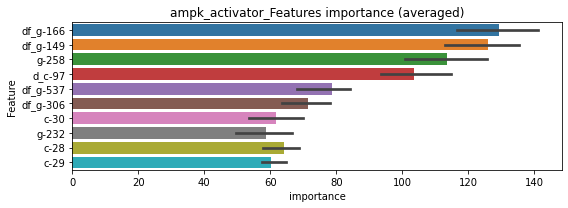

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106589	valid_1's binary_logloss: 0.0143079
[200]	training's binary_logloss: 0.00108678	valid_1's binary_logloss: 0.00332063
[300]	training's binary_logloss: 0.000297579	valid_1's binary_logloss: 0.00235017
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00023578	valid_1's binary_logloss: 0.00225256


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107113	valid_1's binary_logloss: 0.0151243
[200]	training's binary_logloss: 0.00110038	valid_1's binary_logloss: 0.0032352
[300]	training's binary_logloss: 0.000303912	valid_1's binary_logloss: 0.00202989
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000172951	valid_1's binary_logloss: 0.00179854


ampk_activator logloss: 0.0020255472673184854
analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187956	valid_1's binary_logloss: 0.0229298
[200]	training's binary_logloss: 0.0019192	valid_1's binary_logloss: 0.00441863
[300]	training's binary_logloss: 0.00054681	valid_1's binary_logloss: 0.00249318
[400]	training's binary_logloss: 0.000309566	valid_1's binary_logloss: 0.00195944
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000272482	valid_1's binary_logloss: 0.00187555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185538	valid_1's binary_logloss: 0.0211721
[200]	training's binary_logloss: 0.00190568	valid_1's binary_logloss: 0.00275609
[300]	training's binary_logloss: 0.000546041	valid_1's binary_logloss: 0.00092467
[400]	training's binary_logloss: 0.000308238	valid_1's binary_logloss: 0.000553081
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000274762	valid_1's binary_logloss: 0.000499

1 / 3 AUC score:1.000
y_Threshold: 0.0010959, Threshold: 0.0019571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00176, conf_1:0.00215
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019571
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0119571
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0219571
threshold: 0.0219571, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188824	valid_1's binary_logloss: 0.0226993
[200]	training's binary_logloss: 0.00185476	valid_1's binary_logloss: 0.00379235
[300]	training's binary_logloss: 0.000533283	valid_1's binary_logloss: 0.00205725
[400]	training's binary_logloss: 0.000306633	valid_1's binary_logloss: 0.00162686
[500]	training's binary_logloss: 0.00026871	valid_1's binary_logloss: 0.00155791
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000267718	valid_1's binary_logloss: 0.00155652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186813	valid_1's binary_logloss: 0.0207192
[200]	training's binary_logloss: 0.00182363	valid_1's binary_logloss: 0.00239101
[300]	training's binary_logloss: 0.00052873	valid_1's binary_logloss: 0.000765677
[400]	training's binary_logloss: 0.000302737	valid_1's binary_logloss: 0.000455966
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0249779, Threshold: 0.0219571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.01976, conf_1:0.02415
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.0219571
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0319571
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0419571
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0519571
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0619571
threshold: 0.0619571, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188824	valid_1's binary_logloss: 0.0226993
[200]	training's binary_logloss: 0.00185476	valid_1's binary_logloss: 0.00379235
[300]	training's binary_logloss: 0.000533283	valid_1's binary_logloss: 0.00205725
[400]	training's binary_logloss: 0.000306633	valid_1's binary_logloss: 0.00162686
[500]	training's binary_logloss: 0.00026871	valid_1's binary_logloss: 0.00155791
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000267718	valid_1's binary_logloss: 0.00155652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186813	valid_1's binary_logloss: 0.0207192
[200]	training's binary_logloss: 0.00182363	valid_1's binary_logloss: 0.00239101
[300]	training's binary_logloss: 0.00052873	valid_1's binary_logloss: 0.000765677
[400]	training's binary_logloss: 0.000302737	valid_1's binary_logloss: 0.000455966
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0249779, Threshold: 0.0619571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.05576, conf_1:0.06815
threshold: 0.0619571, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


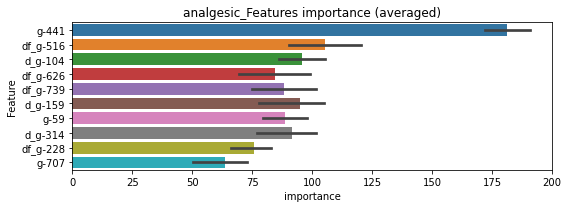

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010031	valid_1's binary_logloss: 0.0142705
[200]	training's binary_logloss: 0.000975174	valid_1's binary_logloss: 0.00444326
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000391043	valid_1's binary_logloss: 0.00382424


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101532	valid_1's binary_logloss: 0.0121259
[200]	training's binary_logloss: 0.00102752	valid_1's binary_logloss: 0.00267138
[300]	training's binary_logloss: 0.000288014	valid_1's binary_logloss: 0.00190872
[400]	training's binary_logloss: 0.000161435	valid_1's binary_logloss: 0.00168367
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000165275	valid_1's binary_logloss: 0.00167835


analgesic logloss: 0.0027512943174937787
androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471949	valid_1's binary_logloss: 0.0885093
[200]	training's binary_logloss: 0.00853118	valid_1's binary_logloss: 0.0369389
[300]	training's binary_logloss: 0.00237747	valid_1's binary_logloss: 0.0232695
[400]	training's binary_logloss: 0.00109091	valid_1's binary_logloss: 0.0187878
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000810325	valid_1's binary_logloss: 0.0175147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496186	valid_1's binary_logloss: 0.0786674
[200]	training's binary_logloss: 0.00965537	valid_1's binary_logloss: 0.026536
[300]	training's binary_logloss: 0.00266828	valid_1's binary_logloss: 0.0142991
[400]	training's binary_logloss: 0.00119617	valid_1's binary_logloss: 0.0103219
[500]	training's binary_logloss: 0.000742009	valid_1's binary_logloss: 0.00895803
Early stopping, best iteration is:
[588]	tr

1 / 3 AUC score:1.000
y_Threshold: 0.0065848, Threshold: 0.0107950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00972, conf_1:0.01187
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0107950
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.0207950
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_3: 0.0307950
threshold: 0.0307950, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472797	valid_1's binary_logloss: 0.0867288
[200]	training's binary_logloss: 0.00828862	valid_1's binary_logloss: 0.0348764
[300]	training's binary_logloss: 0.00233161	valid_1's binary_logloss: 0.0228092
[400]	training's binary_logloss: 0.00108691	valid_1's binary_logloss: 0.0188983
[500]	training's binary_logloss: 0.00068754	valid_1's binary_logloss: 0.0173288
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000651145	valid_1's binary_logloss: 0.0170848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492311	valid_1's binary_logloss: 0.0762849
[200]	training's binary_logloss: 0.0089928	valid_1's binary_logloss: 0.0244058
[300]	training's binary_logloss: 0.00249795	valid_1's binary_logloss: 0.012377
[400]	training's binary_logloss: 0.0011349	valid_1's binary_logloss: 0.00867419
[500]	training's binary_logloss: 0.000707679	v

2 / 3 AUC score:1.000
y_Threshold: 0.0284265, Threshold: 0.0307950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0102963 Vs.target_rate: 0.00202, Num_p_label: 41.0, conf_0:0.02772, conf_1:0.03387
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_1: 0.0307950
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.0407950
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0507950
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0607950
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.0707950
threshold: 0.0707950, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488683	valid_1's binary_logloss: 0.0806891
[200]	training's binary_logloss: 0.0089774	valid_1's binary_logloss: 0.0288599
[300]	training's binary_logloss: 0.00248062	valid_1's binary_logloss: 0.0161723
[400]	training's binary_logloss: 0.00111986	valid_1's binary_logloss: 0.0119547
[500]	training's binary_logloss: 0.000700446	valid_1's binary_logloss: 0.0107931
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000614401	valid_1's binary_logloss: 0.0104821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464219	valid_1's binary_logloss: 0.0759272
[200]	training's binary_logloss: 0.00833239	valid_1's binary_logloss: 0.0247205
[300]	training's binary_logloss: 0.00233691	valid_1's binary_logloss: 0.0131057
[400]	training's binary_logloss: 0.00108627	valid_1's binary_logloss: 0.0101384
[500]	training's binary_logloss: 0.000686781

3 / 3 AUC score:1.000
y_Threshold: 0.0599690, Threshold: 0.0707950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0022602 Vs.target_rate: 0.00202, Num_p_label: 9.0, conf_0:0.06372, conf_1:0.07787
threshold: 0.0707950, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 662.0/7781, y_label_rate: 0.0850790


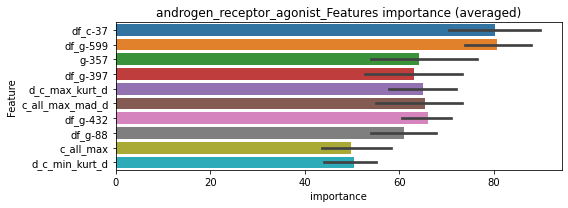

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283316	valid_1's binary_logloss: 0.0500397
[200]	training's binary_logloss: 0.00495271	valid_1's binary_logloss: 0.0199423
[300]	training's binary_logloss: 0.00124919	valid_1's binary_logloss: 0.0137894
[400]	training's binary_logloss: 0.000566723	valid_1's binary_logloss: 0.0124805
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000597588	valid_1's binary_logloss: 0.0124348


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263306	valid_1's binary_logloss: 0.0543392
[200]	training's binary_logloss: 0.00486271	valid_1's binary_logloss: 0.0244028
[300]	training's binary_logloss: 0.00127902	valid_1's binary_logloss: 0.0190536
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000821478	valid_1's binary_logloss: 0.0180622


androgen_receptor_agonist logloss: 0.015248149396584526
androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563378	valid_1's binary_logloss: 0.122189
[200]	training's binary_logloss: 0.0145803	valid_1's binary_logloss: 0.080679
[300]	training's binary_logloss: 0.00434313	valid_1's binary_logloss: 0.0696401
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00297044	valid_1's binary_logloss: 0.0675881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064844	valid_1's binary_logloss: 0.119412
[200]	training's binary_logloss: 0.0163096	valid_1's binary_logloss: 0.0703613
[300]	training's binary_logloss: 0.00486011	valid_1's binary_logloss: 0.0542485
[400]	training's binary_logloss: 0.00208807	valid_1's binary_logloss: 0.0488642
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00192216	valid_1's binary_logloss: 0.0485906


1 / 3 AUC score:0.995
y_Threshold: 0.0165631, Threshold: 0.0214691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 642/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.01932, conf_1:0.02362
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0214691
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.0314691
threshold: 0.0314691, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 642.0/3772, y_label_rate: 0.1702015
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542616	valid_1's binary_logloss: 0.127942
[200]	training's binary_logloss: 0.0119511	valid_1's binary_logloss: 0.0828822
[300]	training's binary_logloss: 0.00363667	valid_1's binary_logloss: 0.0725169
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00275904	valid_1's binary_logloss: 0.0708161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573109	valid_1's binary_logloss: 0.108078
[200]	training's binary_logloss: 0.0140097	valid_1's binary_logloss: 0.0599194
[300]	training's binary_logloss: 0.00438145	valid_1's binary_logloss: 0.0456052
[400]	training's binary_logloss: 0.00198616	valid_1's binary_logloss: 0.0409904
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00176452	valid_1's binary_logloss: 0.0404045


2 / 3 AUC score:0.997
y_Threshold: 0.0356152, Threshold: 0.0314691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 626.0/3740
p_label_rate: 0.0087896 Vs.target_rate: 0.00374, Num_p_label: 35.0, conf_0:0.02832, conf_1:0.03462
threshold: 0.0314691, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 626.0/3740, y_label_rate: 0.1673797
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499071	valid_1's binary_logloss: 0.121749
[200]	training's binary_logloss: 0.0104894	valid_1's binary_logloss: 0.0733799
[300]	training's binary_logloss: 0.00328834	valid_1's binary_logloss: 0.0610176
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00193843	valid_1's binary_logloss: 0.0577042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563781	valid_1's binary_logloss: 0.110031
[200]	training's binary_logloss: 0.0128358	valid_1's binary_logloss: 0.0626397
[300]	training's binary_logloss: 0.00396444	valid_1's binary_logloss: 0.0500421
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00361874	valid_1's binary_logloss: 0.0496431


3 / 3 AUC score:0.999
y_Threshold: 0.0396667, Threshold: 0.0314691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 614.0/3716
p_label_rate: 0.0133099 Vs.target_rate: 0.00374, Num_p_label: 53.0, conf_0:0.02832, conf_1:0.03462
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_1: 0.0314691
Num_p_label: 23.0, Expected: 14.9, Adj_threshold_2: 0.0414691
threshold: 0.0414691, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 637.0/7698, y_label_rate: 0.0827488


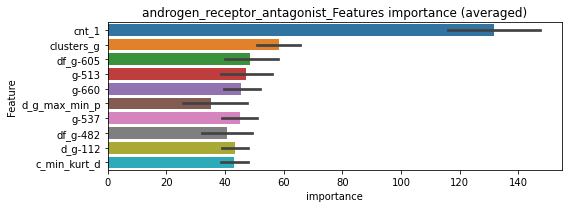

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301041	valid_1's binary_logloss: 0.0698471
[200]	training's binary_logloss: 0.00713306	valid_1's binary_logloss: 0.047286
[300]	training's binary_logloss: 0.00212055	valid_1's binary_logloss: 0.0418645
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00183748	valid_1's binary_logloss: 0.0416216


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294174	valid_1's binary_logloss: 0.0790849
[200]	training's binary_logloss: 0.00650413	valid_1's binary_logloss: 0.0585184
[300]	training's binary_logloss: 0.00186975	valid_1's binary_logloss: 0.0543306
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00176329	valid_1's binary_logloss: 0.0541994


androgen_receptor_antagonist logloss: 0.04791050686880711
anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060815	valid_1's binary_logloss: 0.14602
[200]	training's binary_logloss: 0.0140367	valid_1's binary_logloss: 0.102247
[300]	training's binary_logloss: 0.00413601	valid_1's binary_logloss: 0.0900993
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00351537	valid_1's binary_logloss: 0.0891239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635689	valid_1's binary_logloss: 0.132526
[200]	training's binary_logloss: 0.0151136	valid_1's binary_logloss: 0.0799424
[300]	training's binary_logloss: 0.00430096	valid_1's binary_logloss: 0.0650825
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0021116	valid_1's binary_logloss: 0.0615192


1 / 3 AUC score:0.990
y_Threshold: 0.0214001, Threshold: 0.0283010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 634/3757
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.02547, conf_1:0.03113
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0283010
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_2: 0.0383010
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_3: 0.0483010
threshold: 0.0483010, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 634.0/3757, y_label_rate: 0.1687517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612378	valid_1's binary_logloss: 0.110382
[200]	training's binary_logloss: 0.0135919	valid_1's binary_logloss: 0.0517217
[300]	training's binary_logloss: 0.00401838	valid_1's binary_logloss: 0.0357425
[400]	training's binary_logloss: 0.00178122	valid_1's binary_logloss: 0.0299092
[500]	training's binary_logloss: 0.00108818	valid_1's binary_logloss: 0.0274533
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00103287	valid_1's binary_logloss: 0.0273034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588873	valid_1's binary_logloss: 0.120082
[200]	training's binary_logloss: 0.0133526	valid_1's binary_logloss: 0.0697233
[300]	training's binary_logloss: 0.00400105	valid_1's binary_logloss: 0.0567227
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00226447	valid_1's binary_logloss: 0.0533848


2 / 3 AUC score:0.998
y_Threshold: 0.0425740, Threshold: 0.0483010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 621.0/3731
p_label_rate: 0.0065294 Vs.target_rate: 0.00336, Num_p_label: 26.0, conf_0:0.04347, conf_1:0.05313
threshold: 0.0483010, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 621.0/3731, y_label_rate: 0.1664433
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578922	valid_1's binary_logloss: 0.107483
[200]	training's binary_logloss: 0.0132601	valid_1's binary_logloss: 0.0490883
[300]	training's binary_logloss: 0.00369891	valid_1's binary_logloss: 0.0300408
[400]	training's binary_logloss: 0.00167493	valid_1's binary_logloss: 0.024298
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00115908	valid_1's binary_logloss: 0.0224446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604144	valid_1's binary_logloss: 0.10753
[200]	training's binary_logloss: 0.0134239	valid_1's binary_logloss: 0.0501
[300]	training's binary_logloss: 0.00393205	valid_1's binary_logloss: 0.031878
[400]	training's binary_logloss: 0.00174019	valid_1's binary_logloss: 0.0255667
[500]	training's binary_logloss: 0.00104486	valid_1's binary_logloss: 0.0233692
Early stopping, best iteration is:
[550]	training's bin

3 / 3 AUC score:1.000
y_Threshold: 0.0429090, Threshold: 0.0483010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 619.0/3727
p_label_rate: 0.0040181 Vs.target_rate: 0.00336, Num_p_label: 16.0, conf_0:0.04347, conf_1:0.05313
threshold: 0.0483010, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 635.0/7709, y_label_rate: 0.0823713


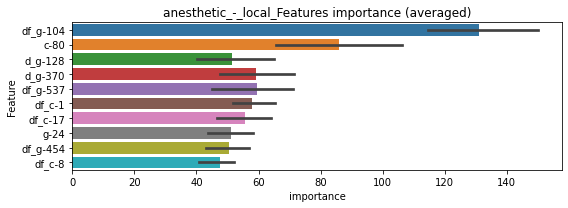

len(train_index) : 3854
len(valid_index) : 3855
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335934	valid_1's binary_logloss: 0.0686716
[200]	training's binary_logloss: 0.00717106	valid_1's binary_logloss: 0.0380918
[300]	training's binary_logloss: 0.0020727	valid_1's binary_logloss: 0.0308899
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00114632	valid_1's binary_logloss: 0.0296154


len(train_index) : 3855
len(valid_index) : 3854
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334639	valid_1's binary_logloss: 0.067881
[200]	training's binary_logloss: 0.00725437	valid_1's binary_logloss: 0.0379821
[300]	training's binary_logloss: 0.00217889	valid_1's binary_logloss: 0.0284821
[400]	training's binary_logloss: 0.000945932	valid_1's binary_logloss: 0.0255333
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000630293	valid_1's binary_logloss: 0.0243545


anesthetic_-_local logloss: 0.02698531433728025
angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043667	valid_1's binary_logloss: 0.0655383
[200]	training's binary_logloss: 0.00747482	valid_1's binary_logloss: 0.0186085
[300]	training's binary_logloss: 0.00194168	valid_1's binary_logloss: 0.00701973
[400]	training's binary_logloss: 0.000886131	valid_1's binary_logloss: 0.00431121
[500]	training's binary_logloss: 0.000565928	valid_1's binary_logloss: 0.0033281
[600]	training's binary_logloss: 0.000480315	valid_1's binary_logloss: 0.00307816
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000478791	valid_1's binary_logloss: 0.00307793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420089	valid_1's binary_logloss: 0.0658531
[200]	training's binary_logloss: 0.00717644	valid_1's binary_logloss: 0.0202914
[300]	training's binary_logloss: 0.00190071	valid_1's binary_logloss: 0.0106165
[400]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0046485, Threshold: 0.0066070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00595, conf_1:0.00727
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0066070
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0166070
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0266070
threshold: 0.0266070, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444136	valid_1's binary_logloss: 0.0623156
[200]	training's binary_logloss: 0.00717669	valid_1's binary_logloss: 0.0145526
[300]	training's binary_logloss: 0.00191921	valid_1's binary_logloss: 0.00541021
[400]	training's binary_logloss: 0.000902426	valid_1's binary_logloss: 0.0031227
[500]	training's binary_logloss: 0.000581844	valid_1's binary_logloss: 0.00228604
[600]	training's binary_logloss: 0.000487492	valid_1's binary_logloss: 0.00205201
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.000478796	valid_1's binary_logloss: 0.00203022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415073	valid_1's binary_logloss: 0.0650271
[200]	training's binary_logloss: 0.00682758	valid_1's binary_logloss: 0.0193396
[300]	training's binary_logloss: 0.00183419	valid_1's binary_logloss: 0.0105555
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0365406, Threshold: 0.0266070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.02395, conf_1:0.02927
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0266070
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.0366070
threshold: 0.0366070, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416395	valid_1's binary_logloss: 0.0668412
[200]	training's binary_logloss: 0.00674009	valid_1's binary_logloss: 0.0209467
[300]	training's binary_logloss: 0.00185034	valid_1's binary_logloss: 0.0122317
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000990453	valid_1's binary_logloss: 0.00954988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406811	valid_1's binary_logloss: 0.0634495
[200]	training's binary_logloss: 0.00667105	valid_1's binary_logloss: 0.0203499
[300]	training's binary_logloss: 0.00182828	valid_1's binary_logloss: 0.0123699
[400]	training's binary_logloss: 0.000862121	valid_1's binary_logloss: 0.010797
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000810119	valid_1's binary_logloss: 0.0106756


3 / 3 AUC score:1.000
y_Threshold: 0.0307744, Threshold: 0.0366070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.03295, conf_1:0.04027
threshold: 0.0366070, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 668.0/7785, y_label_rate: 0.0858060


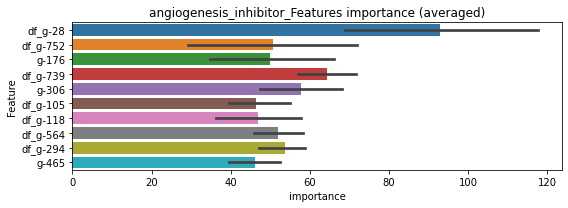

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238846	valid_1's binary_logloss: 0.0394351
[200]	training's binary_logloss: 0.00383887	valid_1's binary_logloss: 0.0161229
[300]	training's binary_logloss: 0.00100333	valid_1's binary_logloss: 0.012694
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000905961	valid_1's binary_logloss: 0.012627


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244318	valid_1's binary_logloss: 0.0414373
[200]	training's binary_logloss: 0.00402663	valid_1's binary_logloss: 0.0146428
[300]	training's binary_logloss: 0.00109247	valid_1's binary_logloss: 0.00952059
[400]	training's binary_logloss: 0.000495659	valid_1's binary_logloss: 0.00846305
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000371575	valid_1's binary_logloss: 0.00817009


angiogenesis_inhibitor logloss: 0.010398827223518245
angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377762	valid_1's binary_logloss: 0.0671936
[200]	training's binary_logloss: 0.00629744	valid_1's binary_logloss: 0.0239705
[300]	training's binary_logloss: 0.00174087	valid_1's binary_logloss: 0.0144886
[400]	training's binary_logloss: 0.000832761	valid_1's binary_logloss: 0.0120873
[500]	training's binary_logloss: 0.000545015	valid_1's binary_logloss: 0.0107856
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000518338	valid_1's binary_logloss: 0.0106872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399206	valid_1's binary_logloss: 0.0669967
[200]	training's binary_logloss: 0.0066337	valid_1's binary_logloss: 0.0215969
[300]	training's binary_logloss: 0.0018566	valid_1's binary_logloss: 0.0107536
[400]	training's binary_logloss: 0.000873368	valid_1's binary_logloss: 0.00733268
[500]	training's binary_logloss: 0.0005664

1 / 3 AUC score:1.000
y_Threshold: 0.0039351, Threshold: 0.0064882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00584, conf_1:0.00714
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0064882
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.0164882
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0264882
threshold: 0.0264882, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368403	valid_1's binary_logloss: 0.0667321
[200]	training's binary_logloss: 0.00573956	valid_1's binary_logloss: 0.0240402
[300]	training's binary_logloss: 0.0016483	valid_1's binary_logloss: 0.015541
[400]	training's binary_logloss: 0.000803008	valid_1's binary_logloss: 0.0127212
[500]	training's binary_logloss: 0.000529835	valid_1's binary_logloss: 0.0115407
[600]	training's binary_logloss: 0.000457122	valid_1's binary_logloss: 0.0112661
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000458795	valid_1's binary_logloss: 0.0112523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392271	valid_1's binary_logloss: 0.0658681
[200]	training's binary_logloss: 0.00636084	valid_1's binary_logloss: 0.0204323
[300]	training's binary_logloss: 0.00178404	valid_1's binary_logloss: 0.0100995
[400]	training's binary_logloss: 0.00085117

2 / 3 AUC score:1.000
y_Threshold: 0.0275132, Threshold: 0.0264882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0067805 Vs.target_rate: 0.00155, Num_p_label: 27.0, conf_0:0.02384, conf_1:0.02914
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_1: 0.0264882
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0364882
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0464882
threshold: 0.0464882, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367792	valid_1's binary_logloss: 0.0610659
[200]	training's binary_logloss: 0.00587711	valid_1's binary_logloss: 0.0210363
[300]	training's binary_logloss: 0.00165738	valid_1's binary_logloss: 0.0127468
[400]	training's binary_logloss: 0.000800171	valid_1's binary_logloss: 0.0106269
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000597568	valid_1's binary_logloss: 0.0100807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038649	valid_1's binary_logloss: 0.0584901
[200]	training's binary_logloss: 0.00626311	valid_1's binary_logloss: 0.0162354
[300]	training's binary_logloss: 0.00177007	valid_1's binary_logloss: 0.00702635
[400]	training's binary_logloss: 0.000849858	valid_1's binary_logloss: 0.00451859
[500]	training's binary_logloss: 0.000559096	valid_1's binary_logloss: 0.00358184
Early stopping, best iteration is:
[584

3 / 3 AUC score:1.000
y_Threshold: 0.0255714, Threshold: 0.0464882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0022602 Vs.target_rate: 0.00155, Num_p_label: 9.0, conf_0:0.04184, conf_1:0.05114
threshold: 0.0464882, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 663.0/7785, y_label_rate: 0.0851638


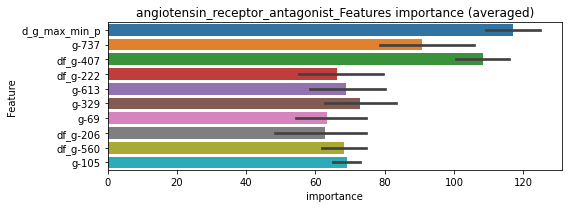

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209574	valid_1's binary_logloss: 0.038965
[200]	training's binary_logloss: 0.00333156	valid_1's binary_logloss: 0.0169529
[300]	training's binary_logloss: 0.000917911	valid_1's binary_logloss: 0.0131601
[400]	training's binary_logloss: 0.000434054	valid_1's binary_logloss: 0.0123466
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000342469	valid_1's binary_logloss: 0.0121411


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020956	valid_1's binary_logloss: 0.0382383
[200]	training's binary_logloss: 0.00352087	valid_1's binary_logloss: 0.0160689
[300]	training's binary_logloss: 0.000970322	valid_1's binary_logloss: 0.0123639
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00105618	valid_1's binary_logloss: 0.0123496


angiotensin_receptor_antagonist logloss: 0.012245346718642977
anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544974	valid_1's binary_logloss: 0.117578
[200]	training's binary_logloss: 0.0114471	valid_1's binary_logloss: 0.0648753
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00448624	valid_1's binary_logloss: 0.0567575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578466	valid_1's binary_logloss: 0.101905
[200]	training's binary_logloss: 0.0123985	valid_1's binary_logloss: 0.0441592
[300]	training's binary_logloss: 0.0035059	valid_1's binary_logloss: 0.0266283
[400]	training's binary_logloss: 0.00155832	valid_1's binary_logloss: 0.0208644
[500]	training's binary_logloss: 0.000939927	valid_1's binary_logloss: 0.018916
[600]	training's binary_logloss: 0.000682924	valid_1's binary_logloss: 0.0176812
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.000657103	valid_1's binary_logloss: 0.0175652


1 / 3 AUC score:0.997
y_Threshold: 0.0183478, Threshold: 0.0267057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.02404, conf_1:0.02938
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0267057
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0367057
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.0467057
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.0567057
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_5: 0.0667057
threshold: 0.0667057, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3786, y_label_rate: 0.1711569
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530832	valid_1's binary_logloss: 0.107063
[200]	training's binary_logloss: 0.0105083	valid_1's binary_logloss: 0.0523304
[300]	training's binary_logloss: 0.00306377	valid_1's binary_logloss: 0.0391284
[400]	training's binary_logloss: 0.00137895	valid_1's binary_logloss: 0.0346011
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0010496	valid_1's binary_logloss: 0.0336773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553761	valid_1's binary_logloss: 0.0993734
[200]	training's binary_logloss: 0.0113307	valid_1's binary_logloss: 0.0410983
[300]	training's binary_logloss: 0.00326349	valid_1's binary_logloss: 0.0244612
[400]	training's binary_logloss: 0.00145882	valid_1's binary_logloss: 0.0184704
[500]	training's binary_logloss: 0.000893653	valid_1's binary_logloss: 0.0162935
[600]	training's binary_logloss: 0.00066372	vali

2 / 3 AUC score:1.000
y_Threshold: 0.0448364, Threshold: 0.0667057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3774
p_label_rate: 0.0060271 Vs.target_rate: 0.00307, Num_p_label: 24.0, conf_0:0.06004, conf_1:0.07338
threshold: 0.0667057, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 642.0/3774, y_label_rate: 0.1701113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485483	valid_1's binary_logloss: 0.108384
[200]	training's binary_logloss: 0.00946938	valid_1's binary_logloss: 0.0576038
[300]	training's binary_logloss: 0.00278108	valid_1's binary_logloss: 0.0435286
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00217497	valid_1's binary_logloss: 0.0420448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570505	valid_1's binary_logloss: 0.0968506
[200]	training's binary_logloss: 0.011432	valid_1's binary_logloss: 0.0468647
[300]	training's binary_logloss: 0.00321998	valid_1's binary_logloss: 0.0358053
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00232256	valid_1's binary_logloss: 0.0346705


3 / 3 AUC score:0.999
y_Threshold: 0.0407837, Threshold: 0.0667057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 632.0/3754
p_label_rate: 0.0113009 Vs.target_rate: 0.00307, Num_p_label: 45.0, conf_0:0.06004, conf_1:0.07338
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_1: 0.0667057
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_2: 0.0767057
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_3: 0.0867057
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_4: 0.0967057
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_5: 0.1067057
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_6: 0.1167057
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_7: 0.1267057
threshold: 0.1267057, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 654.0/7736, y_label_rate: 0.0845398


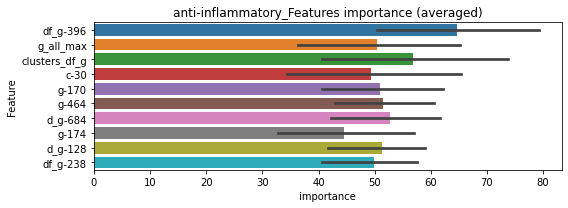

len(train_index) : 3868
len(valid_index) : 3868
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309125	valid_1's binary_logloss: 0.0639898
[200]	training's binary_logloss: 0.00618399	valid_1's binary_logloss: 0.0347792
[300]	training's binary_logloss: 0.00169873	valid_1's binary_logloss: 0.0286395
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00094023	valid_1's binary_logloss: 0.0275732


len(train_index) : 3868
len(valid_index) : 3868
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303782	valid_1's binary_logloss: 0.0632062
[200]	training's binary_logloss: 0.00631962	valid_1's binary_logloss: 0.0320209
[300]	training's binary_logloss: 0.00178129	valid_1's binary_logloss: 0.023127
[400]	training's binary_logloss: 0.000773971	valid_1's binary_logloss: 0.0208312
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000539222	valid_1's binary_logloss: 0.0200296


anti-inflammatory logloss: 0.023801390788545686
antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274896	valid_1's binary_logloss: 0.0456587
[200]	training's binary_logloss: 0.00365392	valid_1's binary_logloss: 0.0136603
[300]	training's binary_logloss: 0.00104284	valid_1's binary_logloss: 0.00733703
[400]	training's binary_logloss: 0.000521866	valid_1's binary_logloss: 0.00537584
[500]	training's binary_logloss: 0.000400338	valid_1's binary_logloss: 0.00488639
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000403821	valid_1's binary_logloss: 0.00487522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293968	valid_1's binary_logloss: 0.0412121
[200]	training's binary_logloss: 0.0039328	valid_1's binary_logloss: 0.00999865
[300]	training's binary_logloss: 0.00110882	valid_1's binary_logloss: 0.00480468
[400]	training's binary_logloss: 0.000546879	valid_1's binary_logloss: 0.00342923
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0021806, Threshold: 0.0251190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.02261, conf_1:0.02763
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0251190
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_2: 0.0351190
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_3: 0.0451190
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_4: 0.0551190
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_5: 0.0651190
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_6: 0.0751190
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_7: 0.0851190
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_8: 0.0951190
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_9: 0.1051190
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_10: 0.1151190
threshold: 0.1251190, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268018	valid_1's binary_logloss: 0.0427159
[200]	training's binary_logloss: 0.00345086	valid_1's binary_logloss: 0.0124428
[300]	training's binary_logloss: 0.000977131	valid_1's binary_logloss: 0.00658666
[400]	training's binary_logloss: 0.000501155	valid_1's binary_logloss: 0.00475096
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000391155	valid_1's binary_logloss: 0.00428878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277965	valid_1's binary_logloss: 0.0393112
[200]	training's binary_logloss: 0.00369055	valid_1's binary_logloss: 0.00941498
[300]	training's binary_logloss: 0.00103559	valid_1's binary_logloss: 0.00441328
[400]	training's binary_logloss: 0.000518803	valid_1's binary_logloss: 0.00312226
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000411633	valid_1's binary_logloss: 0.0028008

2 / 3 AUC score:1.000
y_Threshold: 0.1317069, Threshold: 0.1251190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0371673 Vs.target_rate: 0.00101, Num_p_label: 148.0, conf_0:0.11261, conf_1:0.13763
Num_p_label: 148.0, Expected: 4.0, Adj_threshold_1: 0.1251190
Num_p_label: 144.0, Expected: 4.0, Adj_threshold_2: 0.1351190
Num_p_label: 142.0, Expected: 4.0, Adj_threshold_3: 0.1451190
Num_p_label: 140.0, Expected: 4.0, Adj_threshold_4: 0.1551190
Num_p_label: 136.0, Expected: 4.0, Adj_threshold_5: 0.1651190
Num_p_label: 132.0, Expected: 4.0, Adj_threshold_6: 0.1751190
Num_p_label: 130.0, Expected: 4.0, Adj_threshold_7: 0.1851190
Num_p_label: 130.0, Expected: 4.0, Adj_threshold_8: 0.1951190
Num_p_label: 125.0, Expected: 4.0, Adj_threshold_9: 0.2051190
Num_p_label: 124.0, Expected: 4.0, Adj_threshold_10: 0.2151190
threshold: 0.2251190, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 656.0/3808, y_label_rate: 0.1722

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269901	valid_1's binary_logloss: 0.0408351
[200]	training's binary_logloss: 0.00345962	valid_1's binary_logloss: 0.00889823
[300]	training's binary_logloss: 0.000991103	valid_1's binary_logloss: 0.00385549
[400]	training's binary_logloss: 0.000504718	valid_1's binary_logloss: 0.00257901
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000406771	valid_1's binary_logloss: 0.00229383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272551	valid_1's binary_logloss: 0.0416665
[200]	training's binary_logloss: 0.0035651	valid_1's binary_logloss: 0.00920829
[300]	training's binary_logloss: 0.00100157	valid_1's binary_logloss: 0.00419937
[400]	training's binary_logloss: 0.000508631	valid_1's binary_logloss: 0.00272242
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000427491	valid_1's binary_logloss: 0.0024959

3 / 3 AUC score:1.000
y_Threshold: 0.1761820, Threshold: 0.2251190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0301356 Vs.target_rate: 0.00101, Num_p_label: 120.0, conf_0:0.20261, conf_1:0.24763
Num_p_label: 120.0, Expected: 4.0, Adj_threshold_1: 0.2251190
Num_p_label: 118.0, Expected: 4.0, Adj_threshold_2: 0.2351190
Num_p_label: 114.0, Expected: 4.0, Adj_threshold_3: 0.2451190
Num_p_label: 112.0, Expected: 4.0, Adj_threshold_4: 0.2551190
Num_p_label: 110.0, Expected: 4.0, Adj_threshold_5: 0.2651190
Num_p_label: 109.0, Expected: 4.0, Adj_threshold_6: 0.2751190
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_7: 0.2851190
Num_p_label: 105.0, Expected: 4.0, Adj_threshold_8: 0.2951190
Num_p_label: 101.0, Expected: 4.0, Adj_threshold_9: 0.3051190
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_10: 0.3151190
threshold: 0.3251190, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 748.0/7790, y_label_rate: 0.096020

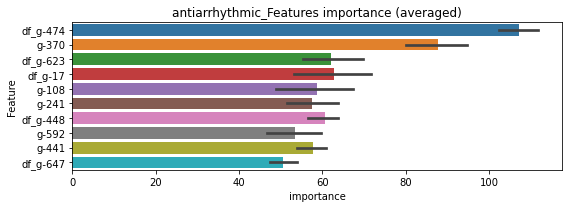

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190632	valid_1's binary_logloss: 0.0336783
[200]	training's binary_logloss: 0.00295264	valid_1's binary_logloss: 0.0153202
[300]	training's binary_logloss: 0.000844019	valid_1's binary_logloss: 0.0121918
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000446465	valid_1's binary_logloss: 0.0112575


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193741	valid_1's binary_logloss: 0.0300879
[200]	training's binary_logloss: 0.00297156	valid_1's binary_logloss: 0.0117078
[300]	training's binary_logloss: 0.000825594	valid_1's binary_logloss: 0.00863871
[400]	training's binary_logloss: 0.000397353	valid_1's binary_logloss: 0.00778422
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000289857	valid_1's binary_logloss: 0.00745215


antiarrhythmic logloss: 0.009354809111007382
antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390186	valid_1's binary_logloss: 0.0643972
[200]	training's binary_logloss: 0.00689426	valid_1's binary_logloss: 0.0228323
[300]	training's binary_logloss: 0.00194402	valid_1's binary_logloss: 0.0137738
[400]	training's binary_logloss: 0.000934473	valid_1's binary_logloss: 0.0110226
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000776331	valid_1's binary_logloss: 0.0106385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416505	valid_1's binary_logloss: 0.0656131
[200]	training's binary_logloss: 0.00730529	valid_1's binary_logloss: 0.0211043
[300]	training's binary_logloss: 0.00204972	valid_1's binary_logloss: 0.0115232
[400]	training's binary_logloss: 0.000955961	valid_1's binary_logloss: 0.00882211
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000675582	valid_1's binary_logloss: 0.0082568


1 / 3 AUC score:1.000
y_Threshold: 0.0049250, Threshold: 0.0097580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181, Num_p_label: 80.0, conf_0:0.00878, conf_1:0.01073
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0097580
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_2: 0.0197580
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_3: 0.0297580
threshold: 0.0297580, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393899	valid_1's binary_logloss: 0.0648852
[200]	training's binary_logloss: 0.0067668	valid_1's binary_logloss: 0.0215039
[300]	training's binary_logloss: 0.00193626	valid_1's binary_logloss: 0.0121007
[400]	training's binary_logloss: 0.000925083	valid_1's binary_logloss: 0.00999266
[500]	training's binary_logloss: 0.000606708	valid_1's binary_logloss: 0.00892696
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00053428	valid_1's binary_logloss: 0.00861667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391037	valid_1's binary_logloss: 0.0629478
[200]	training's binary_logloss: 0.00659735	valid_1's binary_logloss: 0.0201982
[300]	training's binary_logloss: 0.00191544	valid_1's binary_logloss: 0.0114593
[400]	training's binary_logloss: 0.000920226	valid_1's binary_logloss: 0.00884416
[500]	training's binary_logloss: 0.0006

2 / 3 AUC score:1.000
y_Threshold: 0.0217549, Threshold: 0.0297580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00181, Num_p_label: 28.0, conf_0:0.02678, conf_1:0.03273
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_1: 0.0297580
Num_p_label: 20.0, Expected: 7.2, Adj_threshold_2: 0.0397580
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_3: 0.0497580
threshold: 0.0497580, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393451	valid_1's binary_logloss: 0.0639837
[200]	training's binary_logloss: 0.00653989	valid_1's binary_logloss: 0.0234573
[300]	training's binary_logloss: 0.00189174	valid_1's binary_logloss: 0.0147628
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00100643	valid_1's binary_logloss: 0.0127497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385879	valid_1's binary_logloss: 0.0602839
[200]	training's binary_logloss: 0.00651348	valid_1's binary_logloss: 0.0180944
[300]	training's binary_logloss: 0.00189898	valid_1's binary_logloss: 0.00909128
[400]	training's binary_logloss: 0.000912221	valid_1's binary_logloss: 0.0062905
[500]	training's binary_logloss: 0.000600625	valid_1's binary_logloss: 0.0053684
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000548928	valid_1's binary_logloss: 0.00514547


3 / 3 AUC score:1.000
y_Threshold: 0.0415425, Threshold: 0.0497580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0040181 Vs.target_rate: 0.00181, Num_p_label: 16.0, conf_0:0.04478, conf_1:0.05473
threshold: 0.0497580, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 670.0/7783, y_label_rate: 0.0860851


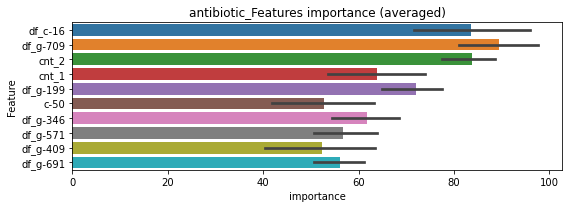

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022431	valid_1's binary_logloss: 0.0446787
[200]	training's binary_logloss: 0.0041545	valid_1's binary_logloss: 0.02317
[300]	training's binary_logloss: 0.00104458	valid_1's binary_logloss: 0.0175476
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000752324	valid_1's binary_logloss: 0.0169201


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222006	valid_1's binary_logloss: 0.0415466
[200]	training's binary_logloss: 0.0040317	valid_1's binary_logloss: 0.0182628
[300]	training's binary_logloss: 0.00116613	valid_1's binary_logloss: 0.013016
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000578503	valid_1's binary_logloss: 0.0117873


antibiotic logloss: 0.014354042750070248
anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262067	valid_1's binary_logloss: 0.0341062
[200]	training's binary_logloss: 0.00316899	valid_1's binary_logloss: 0.00806298
[300]	training's binary_logloss: 0.000854732	valid_1's binary_logloss: 0.00381889
[400]	training's binary_logloss: 0.000450205	valid_1's binary_logloss: 0.00270795
[500]	training's binary_logloss: 0.000356584	valid_1's binary_logloss: 0.00242265
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000356184	valid_1's binary_logloss: 0.00242256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025952	valid_1's binary_logloss: 0.0352397
[200]	training's binary_logloss: 0.00311649	valid_1's binary_logloss: 0.0061196
[300]	training's binary_logloss: 0.00084661	valid_1's binary_logloss: 0.00238044
[400]	training's binary_logloss: 0.000441637	valid_1's binary_logloss: 0.00159715
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0020357, Threshold: 0.0030138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00271, conf_1:0.00332
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0030138
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0130138
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0230138
threshold: 0.0230138, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243644	valid_1's binary_logloss: 0.0306699
[200]	training's binary_logloss: 0.00289388	valid_1's binary_logloss: 0.00648625
[300]	training's binary_logloss: 0.000812125	valid_1's binary_logloss: 0.00279687
[400]	training's binary_logloss: 0.000434652	valid_1's binary_logloss: 0.00192685
[500]	training's binary_logloss: 0.000350062	valid_1's binary_logloss: 0.00172653
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000349552	valid_1's binary_logloss: 0.00172581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241048	valid_1's binary_logloss: 0.0320061
[200]	training's binary_logloss: 0.00289261	valid_1's binary_logloss: 0.00523802
[300]	training's binary_logloss: 0.000816544	valid_1's binary_logloss: 0.00184363
[400]	training's binary_logloss: 0.000433468	valid_1's binary_logloss: 0.00112218
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0985503, Threshold: 0.0230138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.02071, conf_1:0.02532
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.0230138
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0330138
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0430138
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0530138
threshold: 0.0530138, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243644	valid_1's binary_logloss: 0.0306699
[200]	training's binary_logloss: 0.00289388	valid_1's binary_logloss: 0.00648625
[300]	training's binary_logloss: 0.000812125	valid_1's binary_logloss: 0.00279687
[400]	training's binary_logloss: 0.000434652	valid_1's binary_logloss: 0.00192685
[500]	training's binary_logloss: 0.000350062	valid_1's binary_logloss: 0.00172653
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000349552	valid_1's binary_logloss: 0.00172581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241048	valid_1's binary_logloss: 0.0320061
[200]	training's binary_logloss: 0.00289261	valid_1's binary_logloss: 0.00523802
[300]	training's binary_logloss: 0.000816544	valid_1's binary_logloss: 0.00184363
[400]	training's binary_logloss: 0.000433468	valid_1's binary_logloss: 0.00112218
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0985503, Threshold: 0.0530138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04771, conf_1:0.05832
threshold: 0.0530138, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


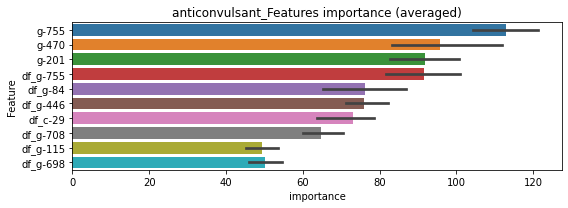

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143623	valid_1's binary_logloss: 0.020352
[200]	training's binary_logloss: 0.0017092	valid_1's binary_logloss: 0.00641029
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000686465	valid_1's binary_logloss: 0.00572151


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146072	valid_1's binary_logloss: 0.0191989
[200]	training's binary_logloss: 0.00182121	valid_1's binary_logloss: 0.00459124
[300]	training's binary_logloss: 0.000490955	valid_1's binary_logloss: 0.00255179
[400]	training's binary_logloss: 0.000245038	valid_1's binary_logloss: 0.00217311
[500]	training's binary_logloss: 0.000185353	valid_1's binary_logloss: 0.00206096
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000178953	valid_1's binary_logloss: 0.00205125


anticonvulsant logloss: 0.003887371173417304
antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299585	valid_1's binary_logloss: 0.0432995
[200]	training's binary_logloss: 0.00394387	valid_1's binary_logloss: 0.00991026
[300]	training's binary_logloss: 0.00111282	valid_1's binary_logloss: 0.00481039
[400]	training's binary_logloss: 0.000569566	valid_1's binary_logloss: 0.00354514
[500]	training's binary_logloss: 0.000412364	valid_1's binary_logloss: 0.0030714
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000387675	valid_1's binary_logloss: 0.00299536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308902	valid_1's binary_logloss: 0.0432934
[200]	training's binary_logloss: 0.00416514	valid_1's binary_logloss: 0.00921286
[300]	training's binary_logloss: 0.00117018	valid_1's binary_logloss: 0.00384421
[400]	training's binary_logloss: 0.000583528	valid_1's binary_logloss: 0.0024231
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0019482, Threshold: 0.0032357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00291, conf_1:0.00356
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0032357
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.0132357
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0232357
threshold: 0.0232357, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292577	valid_1's binary_logloss: 0.0423163
[200]	training's binary_logloss: 0.00385919	valid_1's binary_logloss: 0.00969818
[300]	training's binary_logloss: 0.00109074	valid_1's binary_logloss: 0.00462056
[400]	training's binary_logloss: 0.000561222	valid_1's binary_logloss: 0.00337724
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000423707	valid_1's binary_logloss: 0.00305567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298395	valid_1's binary_logloss: 0.0415102
[200]	training's binary_logloss: 0.00401621	valid_1's binary_logloss: 0.00862579
[300]	training's binary_logloss: 0.00113389	valid_1's binary_logloss: 0.00333197
[400]	training's binary_logloss: 0.000582455	valid_1's binary_logloss: 0.00208832
[500]	training's binary_logloss: 0.000416674	valid_1's binary_logloss: 0.00170877
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0610251, Threshold: 0.0232357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.02091, conf_1:0.02556
threshold: 0.0232357, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292577	valid_1's binary_logloss: 0.0423163
[200]	training's binary_logloss: 0.00385919	valid_1's binary_logloss: 0.00969818
[300]	training's binary_logloss: 0.00109074	valid_1's binary_logloss: 0.00462056
[400]	training's binary_logloss: 0.000561222	valid_1's binary_logloss: 0.00337724
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000423707	valid_1's binary_logloss: 0.00305567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298395	valid_1's binary_logloss: 0.0415102
[200]	training's binary_logloss: 0.00401621	valid_1's binary_logloss: 0.00862579
[300]	training's binary_logloss: 0.00113389	valid_1's binary_logloss: 0.00333197
[400]	training's binary_logloss: 0.000582455	valid_1's binary_logloss: 0.00208832
[500]	training's binary_logloss: 0.000416674	valid_1's binary_logloss: 0.00170877
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0610251, Threshold: 0.0232357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.02091, conf_1:0.02556
threshold: 0.0232357, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


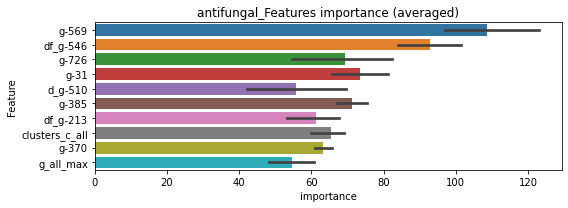

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165679	valid_1's binary_logloss: 0.027406
[200]	training's binary_logloss: 0.00215754	valid_1's binary_logloss: 0.0100545
[300]	training's binary_logloss: 0.000598047	valid_1's binary_logloss: 0.00799414
[400]	training's binary_logloss: 0.000295569	valid_1's binary_logloss: 0.00767187
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000289348	valid_1's binary_logloss: 0.0076643


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164963	valid_1's binary_logloss: 0.0271533
[200]	training's binary_logloss: 0.00211497	valid_1's binary_logloss: 0.0086538
[300]	training's binary_logloss: 0.000596909	valid_1's binary_logloss: 0.00590264
[400]	training's binary_logloss: 0.00030168	valid_1's binary_logloss: 0.00538879
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000250918	valid_1's binary_logloss: 0.00525851


antifungal logloss: 0.006461405165751971
antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249196	valid_1's binary_logloss: 0.0330384
[200]	training's binary_logloss: 0.00302821	valid_1's binary_logloss: 0.00568887
[300]	training's binary_logloss: 0.000845049	valid_1's binary_logloss: 0.00208043
[400]	training's binary_logloss: 0.000440523	valid_1's binary_logloss: 0.00126534
[500]	training's binary_logloss: 0.000343	valid_1's binary_logloss: 0.00106124
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000339871	valid_1's binary_logloss: 0.00106006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251519	valid_1's binary_logloss: 0.0326674
[200]	training's binary_logloss: 0.00307632	valid_1's binary_logloss: 0.00599913
[300]	training's binary_logloss: 0.000858711	valid_1's binary_logloss: 0.00235466
[400]	training's binary_logloss: 0.000449166	valid_1's binary_logloss: 0.00160991
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0016639, Threshold: 0.0024971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00225, conf_1:0.00275
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024971
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0124971
threshold: 0.0124971, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.033033
[200]	training's binary_logloss: 0.00289868	valid_1's binary_logloss: 0.00626353
[300]	training's binary_logloss: 0.000813284	valid_1's binary_logloss: 0.00260948
[400]	training's binary_logloss: 0.000430364	valid_1's binary_logloss: 0.00182557
[500]	training's binary_logloss: 0.000341737	valid_1's binary_logloss: 0.00163209
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000335024	valid_1's binary_logloss: 0.00161674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245945	valid_1's binary_logloss: 0.0325112
[200]	training's binary_logloss: 0.00291773	valid_1's binary_logloss: 0.00549031
[300]	training's binary_logloss: 0.000822442	valid_1's binary_logloss: 0.00214568
[400]	training's binary_logloss: 0.00044	valid_1's binary_logloss: 0.0014674
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0672478, Threshold: 0.0124971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.01125, conf_1:0.01375
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.0124971
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0224971
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0324971
threshold: 0.0324971, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.033033
[200]	training's binary_logloss: 0.00289868	valid_1's binary_logloss: 0.00626353
[300]	training's binary_logloss: 0.000813284	valid_1's binary_logloss: 0.00260948
[400]	training's binary_logloss: 0.000430364	valid_1's binary_logloss: 0.00182557
[500]	training's binary_logloss: 0.000341737	valid_1's binary_logloss: 0.00163209
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000335024	valid_1's binary_logloss: 0.00161674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245945	valid_1's binary_logloss: 0.0325112
[200]	training's binary_logloss: 0.00291773	valid_1's binary_logloss: 0.00549031
[300]	training's binary_logloss: 0.000822442	valid_1's binary_logloss: 0.00214568
[400]	training's binary_logloss: 0.00044	valid_1's binary_logloss: 0.0014674
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0672478, Threshold: 0.0324971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.02925, conf_1:0.03575
threshold: 0.0324971, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


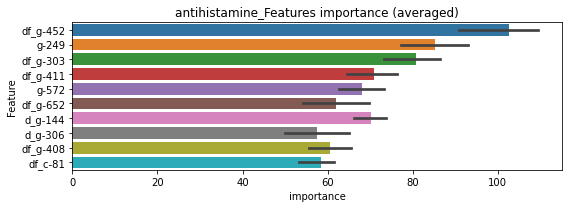

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135617	valid_1's binary_logloss: 0.0191983
[200]	training's binary_logloss: 0.0015908	valid_1's binary_logloss: 0.00525347
[300]	training's binary_logloss: 0.000434332	valid_1's binary_logloss: 0.00437545
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000392885	valid_1's binary_logloss: 0.00434973


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138144	valid_1's binary_logloss: 0.0169934
[200]	training's binary_logloss: 0.00168019	valid_1's binary_logloss: 0.00365662
[300]	training's binary_logloss: 0.000457274	valid_1's binary_logloss: 0.00206492
[400]	training's binary_logloss: 0.000232155	valid_1's binary_logloss: 0.0018048
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000226361	valid_1's binary_logloss: 0.00179553


antihistamine logloss: 0.0030727909018362547
antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227808	valid_1's binary_logloss: 0.0297066
[200]	training's binary_logloss: 0.0027426	valid_1's binary_logloss: 0.00503057
[300]	training's binary_logloss: 0.00078493	valid_1's binary_logloss: 0.00183661
[400]	training's binary_logloss: 0.000422174	valid_1's binary_logloss: 0.0011351
[500]	training's binary_logloss: 0.000335517	valid_1's binary_logloss: 0.000959961
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000328178	valid_1's binary_logloss: 0.000948385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235228	valid_1's binary_logloss: 0.0313431
[200]	training's binary_logloss: 0.00283755	valid_1's binary_logloss: 0.00567192
[300]	training's binary_logloss: 0.000802694	valid_1's binary_logloss: 0.00241494
[400]	training's binary_logloss: 0.000431548	valid_1's binary_logloss: 0.00167458
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015981, Threshold: 0.0024769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00223, conf_1:0.00272
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024769
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0124769
threshold: 0.0124769, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223172	valid_1's binary_logloss: 0.0280714
[200]	training's binary_logloss: 0.00265597	valid_1's binary_logloss: 0.00472739
[300]	training's binary_logloss: 0.000762059	valid_1's binary_logloss: 0.00167299
[400]	training's binary_logloss: 0.00041252	valid_1's binary_logloss: 0.00105444
[500]	training's binary_logloss: 0.000335569	valid_1's binary_logloss: 0.000910028
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000335379	valid_1's binary_logloss: 0.000909571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233227	valid_1's binary_logloss: 0.0307189
[200]	training's binary_logloss: 0.00273992	valid_1's binary_logloss: 0.00537966
[300]	training's binary_logloss: 0.000786692	valid_1's binary_logloss: 0.00231488
[400]	training's binary_logloss: 0.000423917	valid_1's binary_logloss: 0.00164584
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0609926, Threshold: 0.0124769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.01123, conf_1:0.01372
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.0124769
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.0224769
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.0324769
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.0424769
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0524769
threshold: 0.0524769, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223172	valid_1's binary_logloss: 0.0280714
[200]	training's binary_logloss: 0.00265597	valid_1's binary_logloss: 0.00472739
[300]	training's binary_logloss: 0.000762059	valid_1's binary_logloss: 0.00167299
[400]	training's binary_logloss: 0.00041252	valid_1's binary_logloss: 0.00105444
[500]	training's binary_logloss: 0.000335569	valid_1's binary_logloss: 0.000910028
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000335379	valid_1's binary_logloss: 0.000909571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233227	valid_1's binary_logloss: 0.0307189
[200]	training's binary_logloss: 0.00273992	valid_1's binary_logloss: 0.00537966
[300]	training's binary_logloss: 0.000786692	valid_1's binary_logloss: 0.00231488
[400]	training's binary_logloss: 0.000423917	valid_1's binary_logloss: 0.00164584
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0609926, Threshold: 0.0524769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04723, conf_1:0.05772
threshold: 0.0524769, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


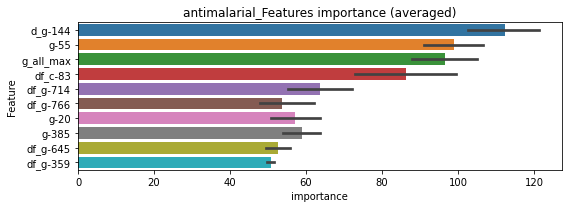

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120255	valid_1's binary_logloss: 0.0202789
[200]	training's binary_logloss: 0.00139288	valid_1's binary_logloss: 0.00692662
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000447005	valid_1's binary_logloss: 0.00594258


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123971	valid_1's binary_logloss: 0.0169917
[200]	training's binary_logloss: 0.00148605	valid_1's binary_logloss: 0.00391952
[300]	training's binary_logloss: 0.000425797	valid_1's binary_logloss: 0.00233529
[400]	training's binary_logloss: 0.000222951	valid_1's binary_logloss: 0.00201012
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000191003	valid_1's binary_logloss: 0.00194042


antimalarial logloss: 0.003941758368094223
antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539208	valid_1's binary_logloss: 0.115632
[200]	training's binary_logloss: 0.0120626	valid_1's binary_logloss: 0.0660515
[300]	training's binary_logloss: 0.00357736	valid_1's binary_logloss: 0.0502592
[400]	training's binary_logloss: 0.0015907	valid_1's binary_logloss: 0.0452789
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00163953	valid_1's binary_logloss: 0.0451851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061664	valid_1's binary_logloss: 0.110638
[200]	training's binary_logloss: 0.0142798	valid_1's binary_logloss: 0.0573148
[300]	training's binary_logloss: 0.00403549	valid_1's binary_logloss: 0.0374952
[400]	training's binary_logloss: 0.00166322	valid_1's binary_logloss: 0.0324029
[500]	training's binary_logloss: 0.000994506	valid_1's binary_logloss: 0.030848
Early stopping, best iteration is:
[490]	training's

1 / 3 AUC score:0.997
y_Threshold: 0.0121658, Threshold: 0.0195383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01758, conf_1:0.02149
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0195383
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.0295383
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_3: 0.0395383
threshold: 0.0395383, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 648.0/3787, y_label_rate: 0.1711117
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519866	valid_1's binary_logloss: 0.108562
[200]	training's binary_logloss: 0.0108402	valid_1's binary_logloss: 0.0549408
[300]	training's binary_logloss: 0.00319551	valid_1's binary_logloss: 0.0399946
[400]	training's binary_logloss: 0.00147497	valid_1's binary_logloss: 0.0338821
[500]	training's binary_logloss: 0.00090901	valid_1's binary_logloss: 0.0321114
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000769535	valid_1's binary_logloss: 0.0306456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570548	valid_1's binary_logloss: 0.105914
[200]	training's binary_logloss: 0.0122318	valid_1's binary_logloss: 0.0547152
[300]	training's binary_logloss: 0.00356912	valid_1's binary_logloss: 0.0413459
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00171149	valid_1's binary_logloss: 0.0385392


2 / 3 AUC score:0.997
y_Threshold: 0.0375975, Threshold: 0.0395383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 639.0/3769
p_label_rate: 0.0105475 Vs.target_rate: 0.00307, Num_p_label: 42.0, conf_0:0.03558, conf_1:0.04349
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_1: 0.0395383
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_2: 0.0495383
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_3: 0.0595383
threshold: 0.0595383, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 639.0/3769, y_label_rate: 0.1695410
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525972	valid_1's binary_logloss: 0.101005
[200]	training's binary_logloss: 0.0111538	valid_1's binary_logloss: 0.0460454
[300]	training's binary_logloss: 0.00325135	valid_1's binary_logloss: 0.0282672
[400]	training's binary_logloss: 0.00146639	valid_1's binary_logloss: 0.021796
[500]	training's binary_logloss: 0.000905815	valid_1's binary_logloss: 0.0194761
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000697944	valid_1's binary_logloss: 0.0184354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564951	valid_1's binary_logloss: 0.0976571
[200]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.0420078
[300]	training's binary_logloss: 0.00337925	valid_1's binary_logloss: 0.0277625
[400]	training's binary_logloss: 0.00152873	valid_1's binary_logloss: 0.0232369
[500]	training's binary_logloss: 0.000935669	va

3 / 3 AUC score:1.000
y_Threshold: 0.0442060, Threshold: 0.0595383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 636.0/3763
p_label_rate: 0.0025113 Vs.target_rate: 0.00307, Num_p_label: 10.0, conf_0:0.05358, conf_1:0.06549
threshold: 0.0595383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/7745, y_label_rate: 0.0834087


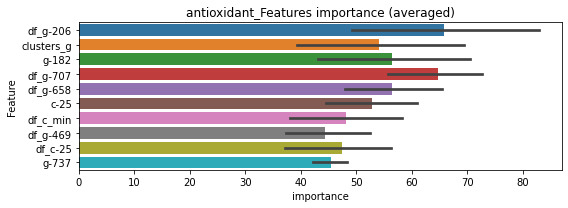

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029361	valid_1's binary_logloss: 0.0633745
[200]	training's binary_logloss: 0.00623232	valid_1's binary_logloss: 0.0368271
[300]	training's binary_logloss: 0.00180241	valid_1's binary_logloss: 0.029494
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000982447	valid_1's binary_logloss: 0.0275449


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302561	valid_1's binary_logloss: 0.0576104
[200]	training's binary_logloss: 0.00627305	valid_1's binary_logloss: 0.0276385
[300]	training's binary_logloss: 0.001755	valid_1's binary_logloss: 0.0190109
[400]	training's binary_logloss: 0.000784235	valid_1's binary_logloss: 0.0163192
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000550329	valid_1's binary_logloss: 0.0152986


antioxidant logloss: 0.021422505989763682
antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386902	valid_1's binary_logloss: 0.0561492
[200]	training's binary_logloss: 0.00627244	valid_1's binary_logloss: 0.01438
[300]	training's binary_logloss: 0.00173874	valid_1's binary_logloss: 0.0060733
[400]	training's binary_logloss: 0.0008306	valid_1's binary_logloss: 0.00385864
[500]	training's binary_logloss: 0.000535659	valid_1's binary_logloss: 0.00298213
[600]	training's binary_logloss: 0.000462866	valid_1's binary_logloss: 0.00280942
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000462866	valid_1's binary_logloss: 0.00280941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382332	valid_1's binary_logloss: 0.0687225
[200]	training's binary_logloss: 0.00608721	valid_1's binary_logloss: 0.0325744
[300]	training's binary_logloss: 0.00168565	valid_1's binary_logloss: 0.0252006
Early stopping, best iteration is:
[348]	

1 / 3 AUC score:1.000
y_Threshold: 0.0057445, Threshold: 0.0090368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00813, conf_1:0.00994
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0090368
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0190368
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0290368
threshold: 0.0290368, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382062	valid_1's binary_logloss: 0.0560575
[200]	training's binary_logloss: 0.0061954	valid_1's binary_logloss: 0.0143594
[300]	training's binary_logloss: 0.00168844	valid_1's binary_logloss: 0.00565892
[400]	training's binary_logloss: 0.000806078	valid_1's binary_logloss: 0.00352767
[500]	training's binary_logloss: 0.000529693	valid_1's binary_logloss: 0.00268564
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000467081	valid_1's binary_logloss: 0.00253345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375185	valid_1's binary_logloss: 0.0681924
[200]	training's binary_logloss: 0.00578254	valid_1's binary_logloss: 0.0326999
[300]	training's binary_logloss: 0.00164765	valid_1's binary_logloss: 0.0278273
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00113221	valid_1's binary_logloss: 0.0266583


2 / 3 AUC score:1.000
y_Threshold: 0.0330082, Threshold: 0.0290368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.02613, conf_1:0.03194
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0290368
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0390368
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0490368
threshold: 0.0490368, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377096	valid_1's binary_logloss: 0.0637912
[200]	training's binary_logloss: 0.00603892	valid_1's binary_logloss: 0.0195482
[300]	training's binary_logloss: 0.00163902	valid_1's binary_logloss: 0.0109925
[400]	training's binary_logloss: 0.000784535	valid_1's binary_logloss: 0.00919699
[500]	training's binary_logloss: 0.000517613	valid_1's binary_logloss: 0.0084802
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000517613	valid_1's binary_logloss: 0.0084802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382875	valid_1's binary_logloss: 0.0626722
[200]	training's binary_logloss: 0.00601869	valid_1's binary_logloss: 0.0221618
[300]	training's binary_logloss: 0.00167981	valid_1's binary_logloss: 0.0131279
[400]	training's binary_logloss: 0.000807607	valid_1's binary_logloss: 0.0111329
Early stopping, best iteration is:
[470]

3 / 3 AUC score:1.000
y_Threshold: 0.0198196, Threshold: 0.0490368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.04413, conf_1:0.05394
threshold: 0.0490368, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 661.0/7777, y_label_rate: 0.0849942


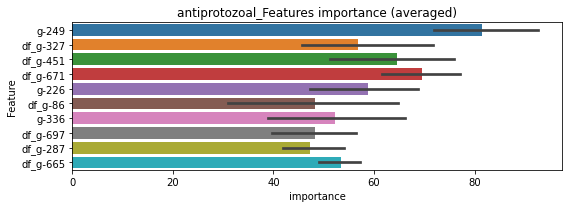

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213671	valid_1's binary_logloss: 0.0397511
[200]	training's binary_logloss: 0.00333911	valid_1's binary_logloss: 0.0185644
[300]	training's binary_logloss: 0.000898262	valid_1's binary_logloss: 0.0153206
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000687761	valid_1's binary_logloss: 0.0149706


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218263	valid_1's binary_logloss: 0.0346555
[200]	training's binary_logloss: 0.00349931	valid_1's binary_logloss: 0.0103425
[300]	training's binary_logloss: 0.00095257	valid_1's binary_logloss: 0.00569471
[400]	training's binary_logloss: 0.000444511	valid_1's binary_logloss: 0.0046297
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000314064	valid_1's binary_logloss: 0.00439319


antiprotozoal logloss: 0.009682567981652353
antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281367	valid_1's binary_logloss: 0.0463676
[200]	training's binary_logloss: 0.00369956	valid_1's binary_logloss: 0.0113506
[300]	training's binary_logloss: 0.00104058	valid_1's binary_logloss: 0.00534003
[400]	training's binary_logloss: 0.000523801	valid_1's binary_logloss: 0.00395438
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000461201	valid_1's binary_logloss: 0.00373656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291962	valid_1's binary_logloss: 0.0398954
[200]	training's binary_logloss: 0.00386344	valid_1's binary_logloss: 0.00805032
[300]	training's binary_logloss: 0.00106668	valid_1's binary_logloss: 0.00307198
[400]	training's binary_logloss: 0.000533094	valid_1's binary_logloss: 0.00187612
[500]	training's binary_logloss: 0.00038672	valid_1's binary_logloss: 0.00152369
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0027875, Threshold: 0.0041433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00373, conf_1:0.00456
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0041433
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0141433
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_3: 0.0241433
threshold: 0.0241433, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028075	valid_1's binary_logloss: 0.0449115
[200]	training's binary_logloss: 0.00360832	valid_1's binary_logloss: 0.010526
[300]	training's binary_logloss: 0.00100759	valid_1's binary_logloss: 0.00442739
[400]	training's binary_logloss: 0.000510629	valid_1's binary_logloss: 0.00308426
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000419714	valid_1's binary_logloss: 0.00285405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278893	valid_1's binary_logloss: 0.037405
[200]	training's binary_logloss: 0.00363102	valid_1's binary_logloss: 0.00667024
[300]	training's binary_logloss: 0.00101634	valid_1's binary_logloss: 0.00228322
[400]	training's binary_logloss: 0.000517368	valid_1's binary_logloss: 0.00131169
[500]	training's binary_logloss: 0.00038508	valid_1's binary_logloss: 0.00105217
Early stopping, best iteration is:
[57

2 / 3 AUC score:1.000
y_Threshold: 0.0990004, Threshold: 0.0241433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.02173, conf_1:0.02656
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.0241433
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_2: 0.0341433
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_3: 0.0441433
threshold: 0.0441433, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028075	valid_1's binary_logloss: 0.0449115
[200]	training's binary_logloss: 0.00360832	valid_1's binary_logloss: 0.010526
[300]	training's binary_logloss: 0.00100759	valid_1's binary_logloss: 0.00442739
[400]	training's binary_logloss: 0.000510629	valid_1's binary_logloss: 0.00308426
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000419714	valid_1's binary_logloss: 0.00285405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278893	valid_1's binary_logloss: 0.037405
[200]	training's binary_logloss: 0.00363102	valid_1's binary_logloss: 0.00667024
[300]	training's binary_logloss: 0.00101634	valid_1's binary_logloss: 0.00228322
[400]	training's binary_logloss: 0.000517368	valid_1's binary_logloss: 0.00131169
[500]	training's binary_logloss: 0.00038508	valid_1's binary_logloss: 0.00105217
Early stopping, best iteration is:
[57

3 / 3 AUC score:1.000
y_Threshold: 0.0990004, Threshold: 0.0441433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.03973, conf_1:0.04856
threshold: 0.0441433, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


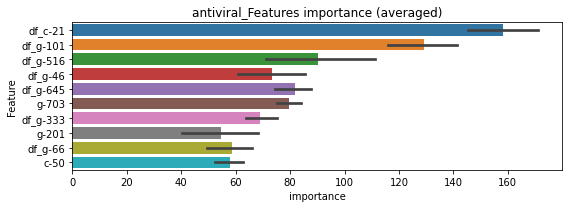

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150911	valid_1's binary_logloss: 0.0237868
[200]	training's binary_logloss: 0.00194207	valid_1's binary_logloss: 0.00783559
[300]	training's binary_logloss: 0.000531842	valid_1's binary_logloss: 0.00595328
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000503741	valid_1's binary_logloss: 0.00591607


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015444	valid_1's binary_logloss: 0.0239102
[200]	training's binary_logloss: 0.0020056	valid_1's binary_logloss: 0.00638675
[300]	training's binary_logloss: 0.000558717	valid_1's binary_logloss: 0.00343565
[400]	training's binary_logloss: 0.000278012	valid_1's binary_logloss: 0.00275889
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000211905	valid_1's binary_logloss: 0.00257012


antiviral logloss: 0.004243309745636367
apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467683	valid_1's binary_logloss: 0.084691
[200]	training's binary_logloss: 0.00814662	valid_1's binary_logloss: 0.0326971
[300]	training's binary_logloss: 0.00230153	valid_1's binary_logloss: 0.0195535
[400]	training's binary_logloss: 0.00108599	valid_1's binary_logloss: 0.0153567
[500]	training's binary_logloss: 0.000686612	valid_1's binary_logloss: 0.0137656
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000577663	valid_1's binary_logloss: 0.0130584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455148	valid_1's binary_logloss: 0.0740419
[200]	training's binary_logloss: 0.00828117	valid_1's binary_logloss: 0.0238702
[300]	training's binary_logloss: 0.00236097	valid_1's binary_logloss: 0.0121769
[400]	training's binary_logloss: 0.00110667	valid_1's binary_logloss: 0.00833161
[500]	training's binary_logloss: 0.00070311

1 / 3 AUC score:1.000
y_Threshold: 0.0038141, Threshold: 0.0636198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206, Num_p_label: 80.0, conf_0:0.05726, conf_1:0.06998
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0636198
Num_p_label: 73.0, Expected: 8.2, Adj_threshold_2: 0.0736198
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_3: 0.0836198
Num_p_label: 70.0, Expected: 8.2, Adj_threshold_4: 0.0936198
Num_p_label: 67.0, Expected: 8.2, Adj_threshold_5: 0.1036198
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_6: 0.1136198
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_7: 0.1236198
Num_p_label: 62.0, Expected: 8.2, Adj_threshold_8: 0.1336198
Num_p_label: 60.0, Expected: 8.2, Adj_threshold_9: 0.1436198
Num_p_label: 57.0, Expected: 8.2, Adj_threshold_10: 0.1536198
threshold: 0.1636198, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463628	valid_1's binary_logloss: 0.079901
[200]	training's binary_logloss: 0.00776369	valid_1's binary_logloss: 0.0285564
[300]	training's binary_logloss: 0.00220385	valid_1's binary_logloss: 0.0172764
[400]	training's binary_logloss: 0.00104194	valid_1's binary_logloss: 0.0137977
[500]	training's binary_logloss: 0.000664869	valid_1's binary_logloss: 0.0123076
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000683439	valid_1's binary_logloss: 0.0122749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046438	valid_1's binary_logloss: 0.0732351
[200]	training's binary_logloss: 0.0080932	valid_1's binary_logloss: 0.0225545
[300]	training's binary_logloss: 0.00234572	valid_1's binary_logloss: 0.0110021
[400]	training's binary_logloss: 0.00108903	valid_1's binary_logloss: 0.00736553
[500]	training's binary_logloss: 0.000692812	

2 / 3 AUC score:1.000
y_Threshold: 0.1030612, Threshold: 0.1636198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0308890 Vs.target_rate: 0.00206, Num_p_label: 123.0, conf_0:0.14726, conf_1:0.17998
Num_p_label: 123.0, Expected: 8.2, Adj_threshold_1: 0.1636198
Num_p_label: 121.0, Expected: 8.2, Adj_threshold_2: 0.1736198
Num_p_label: 119.0, Expected: 8.2, Adj_threshold_3: 0.1836198
Num_p_label: 117.0, Expected: 8.2, Adj_threshold_4: 0.1936198
Num_p_label: 115.0, Expected: 8.2, Adj_threshold_5: 0.2036198
Num_p_label: 114.0, Expected: 8.2, Adj_threshold_6: 0.2136198
Num_p_label: 112.0, Expected: 8.2, Adj_threshold_7: 0.2236198
Num_p_label: 111.0, Expected: 8.2, Adj_threshold_8: 0.2336198
Num_p_label: 109.0, Expected: 8.2, Adj_threshold_9: 0.2436198
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_10: 0.2536198
threshold: 0.2636198, positive_p_label: 104.0/3982, p_label_rate: 0.0261175
positive_y_label: 655.0/3803, y_label_rate: 0.1722

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433881	valid_1's binary_logloss: 0.0767326
[200]	training's binary_logloss: 0.00777199	valid_1's binary_logloss: 0.0250027
[300]	training's binary_logloss: 0.00222438	valid_1's binary_logloss: 0.0128622
[400]	training's binary_logloss: 0.00105178	valid_1's binary_logloss: 0.00922002
[500]	training's binary_logloss: 0.000669177	valid_1's binary_logloss: 0.00794135
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00058199	valid_1's binary_logloss: 0.00760061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453986	valid_1's binary_logloss: 0.0709888
[200]	training's binary_logloss: 0.00812399	valid_1's binary_logloss: 0.0215142
[300]	training's binary_logloss: 0.00232467	valid_1's binary_logloss: 0.0103638
[400]	training's binary_logloss: 0.0010933	valid_1's binary_logloss: 0.00698812
[500]	training's binary_logloss: 0.000693

3 / 3 AUC score:1.000
y_Threshold: 0.0879012, Threshold: 0.2636198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0258664 Vs.target_rate: 0.00206, Num_p_label: 103.0, conf_0:0.23726, conf_1:0.28998
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_1: 0.2636198
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_2: 0.2736198
Num_p_label: 101.0, Expected: 8.2, Adj_threshold_3: 0.2836198
Num_p_label: 100.0, Expected: 8.2, Adj_threshold_4: 0.2936198
Num_p_label: 98.0, Expected: 8.2, Adj_threshold_5: 0.3036198
Num_p_label: 97.0, Expected: 8.2, Adj_threshold_6: 0.3136198
Num_p_label: 94.0, Expected: 8.2, Adj_threshold_7: 0.3236198
Num_p_label: 94.0, Expected: 8.2, Adj_threshold_8: 0.3336198
Num_p_label: 94.0, Expected: 8.2, Adj_threshold_9: 0.3436198
Num_p_label: 93.0, Expected: 8.2, Adj_threshold_10: 0.3536198
threshold: 0.3636198, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 748.0/7785, y_label_rate: 0.0960822


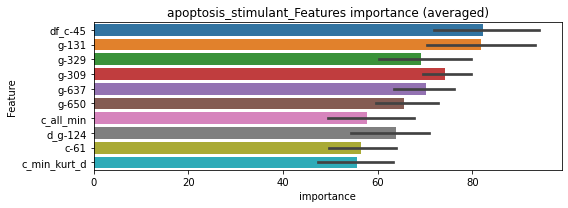

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261962	valid_1's binary_logloss: 0.056598
[200]	training's binary_logloss: 0.00466523	valid_1's binary_logloss: 0.0263246
[300]	training's binary_logloss: 0.00128972	valid_1's binary_logloss: 0.0181559
[400]	training's binary_logloss: 0.000593943	valid_1's binary_logloss: 0.0156876
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000408415	valid_1's binary_logloss: 0.0147989


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286355	valid_1's binary_logloss: 0.0497767
[200]	training's binary_logloss: 0.00522794	valid_1's binary_logloss: 0.020552
[300]	training's binary_logloss: 0.00143278	valid_1's binary_logloss: 0.0131025
[400]	training's binary_logloss: 0.000648869	valid_1's binary_logloss: 0.011123
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000691591	valid_1's binary_logloss: 0.0111007


apoptosis_stimulant logloss: 0.012950034444486813
aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451433	valid_1's binary_logloss: 0.0757366
[200]	training's binary_logloss: 0.0084529	valid_1's binary_logloss: 0.0281572
[300]	training's binary_logloss: 0.00227688	valid_1's binary_logloss: 0.0153149
[400]	training's binary_logloss: 0.00105831	valid_1's binary_logloss: 0.011349
[500]	training's binary_logloss: 0.000675982	valid_1's binary_logloss: 0.0100232
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00055242	valid_1's binary_logloss: 0.00934115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492269	valid_1's binary_logloss: 0.0799126
[200]	training's binary_logloss: 0.00877278	valid_1's binary_logloss: 0.0291406
[300]	training's binary_logloss: 0.00246639	valid_1's binary_logloss: 0.0172268
[400]	training's binary_logloss: 0.00113649	valid_1's binary_logloss: 0.0131726
[500]	training's binary_logloss: 0.000720379	

1 / 3 AUC score:1.000
y_Threshold: 0.0047493, Threshold: 0.0084937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197, Num_p_label: 80.0, conf_0:0.00764, conf_1:0.00934
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0084937
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_2: 0.0184937
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_3: 0.0284937
threshold: 0.0284937, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462564	valid_1's binary_logloss: 0.0758927
[200]	training's binary_logloss: 0.00802864	valid_1's binary_logloss: 0.0257544
[300]	training's binary_logloss: 0.00224266	valid_1's binary_logloss: 0.0139404
[400]	training's binary_logloss: 0.00104686	valid_1's binary_logloss: 0.0106431
[500]	training's binary_logloss: 0.000673018	valid_1's binary_logloss: 0.00935068
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000566123	valid_1's binary_logloss: 0.00880072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470695	valid_1's binary_logloss: 0.0783672
[200]	training's binary_logloss: 0.00858679	valid_1's binary_logloss: 0.0299445
[300]	training's binary_logloss: 0.00243053	valid_1's binary_logloss: 0.0168646
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00124532	valid_1's binary_logloss: 0.0135983


2 / 3 AUC score:1.000
y_Threshold: 0.0356504, Threshold: 0.0284937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0095429 Vs.target_rate: 0.00197, Num_p_label: 38.0, conf_0:0.02564, conf_1:0.03134
Num_p_label: 38.0, Expected: 7.9, Adj_threshold_1: 0.0284937
Num_p_label: 18.0, Expected: 7.9, Adj_threshold_2: 0.0384937
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_3: 0.0484937
threshold: 0.0484937, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456551	valid_1's binary_logloss: 0.0776324
[200]	training's binary_logloss: 0.00821417	valid_1's binary_logloss: 0.0278397
[300]	training's binary_logloss: 0.00230368	valid_1's binary_logloss: 0.0168514
[400]	training's binary_logloss: 0.00106105	valid_1's binary_logloss: 0.0134253
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000861693	valid_1's binary_logloss: 0.0130035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468361	valid_1's binary_logloss: 0.0730932
[200]	training's binary_logloss: 0.00839409	valid_1's binary_logloss: 0.0228249
[300]	training's binary_logloss: 0.00231939	valid_1's binary_logloss: 0.0103442
[400]	training's binary_logloss: 0.00107398	valid_1's binary_logloss: 0.00702194
[500]	training's binary_logloss: 0.000687625	valid_1's binary_logloss: 0.00572655
Early stopping, best iteration is:
[573]	

3 / 3 AUC score:1.000
y_Threshold: 0.0335148, Threshold: 0.0484937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0040181 Vs.target_rate: 0.00197, Num_p_label: 16.0, conf_0:0.04364, conf_1:0.05334
threshold: 0.0484937, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 669.0/7781, y_label_rate: 0.0859787


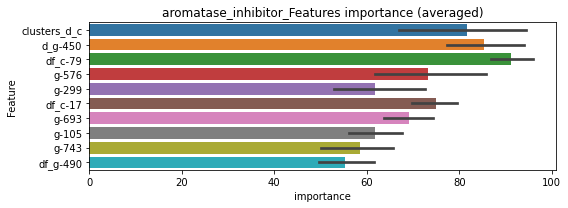

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266364	valid_1's binary_logloss: 0.0511323
[200]	training's binary_logloss: 0.00472683	valid_1's binary_logloss: 0.0252611
[300]	training's binary_logloss: 0.00126553	valid_1's binary_logloss: 0.020501
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000864326	valid_1's binary_logloss: 0.0201678


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278341	valid_1's binary_logloss: 0.0493033
[200]	training's binary_logloss: 0.00516673	valid_1's binary_logloss: 0.021676
[300]	training's binary_logloss: 0.00140557	valid_1's binary_logloss: 0.0148682
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000753244	valid_1's binary_logloss: 0.0132669


aromatase_inhibitor logloss: 0.01671778119662179
atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153406	valid_1's binary_logloss: 0.0159976
[200]	training's binary_logloss: 0.00123533	valid_1's binary_logloss: 0.00147241
[300]	training's binary_logloss: 0.000337911	valid_1's binary_logloss: 0.000502281
[400]	training's binary_logloss: 0.000212208	valid_1's binary_logloss: 0.000328788
[500]	training's binary_logloss: 0.000186838	valid_1's binary_logloss: 0.00029129
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000184813	valid_1's binary_logloss: 0.000287879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154346	valid_1's binary_logloss: 0.0181025
[200]	training's binary_logloss: 0.00122665	valid_1's binary_logloss: 0.0027336
[300]	training's binary_logloss: 0.000331403	valid_1's binary_logloss: 0.00175094
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000289854	valid_1's binary_logloss: 0.001

1 / 3 AUC score:1.000
y_Threshold: 0.0009279, Threshold: 0.0017811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00160, conf_1:0.00196
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0017811
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0117811
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0217811
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0317811
threshold: 0.0317811, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157994	valid_1's binary_logloss: 0.0165831
[200]	training's binary_logloss: 0.00123742	valid_1's binary_logloss: 0.00143799
[300]	training's binary_logloss: 0.000316948	valid_1's binary_logloss: 0.000424085
[400]	training's binary_logloss: 0.000201916	valid_1's binary_logloss: 0.000285227
[500]	training's binary_logloss: 0.000180462	valid_1's binary_logloss: 0.000258524
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000177842	valid_1's binary_logloss: 0.000255215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160372	valid_1's binary_logloss: 0.0169771
[200]	training's binary_logloss: 0.00125209	valid_1's binary_logloss: 0.00148992
[300]	training's binary_logloss: 0.000320116	valid_1's binary_logloss: 0.000421578
[400]	training's binary_logloss: 0.000204638	valid_1's binary_logloss: 0.000282865
[500]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.1798425, Threshold: 0.0317811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0050226 Vs.target_rate: 0.00025, Num_p_label: 20.0, conf_0:0.02860, conf_1:0.03496
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_1: 0.0317811
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.0417811
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_3: 0.0517811
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_4: 0.0617811
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_5: 0.0717811
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_6: 0.0817811
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_7: 0.0917811
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_8: 0.1017811
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_9: 0.1117811
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_10: 0.1217811
threshold: 0.1317811, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157994	valid_1's binary_logloss: 0.0165831
[200]	training's binary_logloss: 0.00123742	valid_1's binary_logloss: 0.00143799
[300]	training's binary_logloss: 0.000316948	valid_1's binary_logloss: 0.000424085
[400]	training's binary_logloss: 0.000201916	valid_1's binary_logloss: 0.000285227
[500]	training's binary_logloss: 0.000180462	valid_1's binary_logloss: 0.000258524
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000177842	valid_1's binary_logloss: 0.000255215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160372	valid_1's binary_logloss: 0.0169771
[200]	training's binary_logloss: 0.00125209	valid_1's binary_logloss: 0.00148992
[300]	training's binary_logloss: 0.000320116	valid_1's binary_logloss: 0.000421578
[400]	training's binary_logloss: 0.000204638	valid_1's binary_logloss: 0.000282865
[500]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.1798425, Threshold: 0.1317811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.11860, conf_1:0.14496
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.1317811
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.1417811
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.1517811
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_4: 0.1617811
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.1717811
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.1817811
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.1917811
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_8: 0.2017811
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_9: 0.2117811
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_10: 0.2217811
threshold: 0.2317811, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7795, y_label_rate: 0.0854394


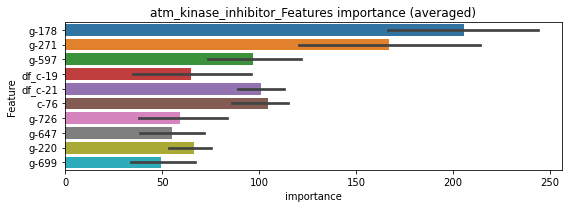

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00864562	valid_1's binary_logloss: 0.0138319
[200]	training's binary_logloss: 0.000694255	valid_1's binary_logloss: 0.007136
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000325634	valid_1's binary_logloss: 0.00688783


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00891167	valid_1's binary_logloss: 0.0112016
[200]	training's binary_logloss: 0.000740081	valid_1's binary_logloss: 0.00389925
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00023745	valid_1's binary_logloss: 0.00351693


atm_kinase_inhibitor logloss: 0.005202593896489983
atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163245	valid_1's binary_logloss: 0.0183112
[200]	training's binary_logloss: 0.00140614	valid_1's binary_logloss: 0.00225001
[300]	training's binary_logloss: 0.000396823	valid_1's binary_logloss: 0.000827455
[400]	training's binary_logloss: 0.000236679	valid_1's binary_logloss: 0.000544956
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000210787	valid_1's binary_logloss: 0.000499279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165828	valid_1's binary_logloss: 0.0193266
[200]	training's binary_logloss: 0.00144138	valid_1's binary_logloss: 0.00238256
[300]	training's binary_logloss: 0.000395345	valid_1's binary_logloss: 0.00113775
[400]	training's binary_logloss: 0.000236244	valid_1's binary_logloss: 0.00090529
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000218317	valid_1's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0007004, Threshold: 0.0010649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00096, conf_1:0.00117
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010649
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.0110649
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.0210649
threshold: 0.0210649, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016481	valid_1's binary_logloss: 0.0178852
[200]	training's binary_logloss: 0.00139232	valid_1's binary_logloss: 0.00188029
[300]	training's binary_logloss: 0.000379698	valid_1's binary_logloss: 0.000627831
[400]	training's binary_logloss: 0.000231792	valid_1's binary_logloss: 0.000413387
[500]	training's binary_logloss: 0.000206009	valid_1's binary_logloss: 0.000374733
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000205343	valid_1's binary_logloss: 0.000373943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168066	valid_1's binary_logloss: 0.018671
[200]	training's binary_logloss: 0.00142312	valid_1's binary_logloss: 0.00201569
[300]	training's binary_logloss: 0.000388278	valid_1's binary_logloss: 0.00087793


2 / 3 AUC score:1.000
y_Threshold: 0.1058225, Threshold: 0.0210649, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.000234597	valid_1's binary_logloss: 0.00067892
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000241081	valid_1's binary_logloss: 0.000674818


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.01896, conf_1:0.02317
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.0210649
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.0310649
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.0410649
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_4: 0.0510649
threshold: 0.0510649, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016481	valid_1's binary_logloss: 0.0178852
[200]	training's binary_logloss: 0.00139232	valid_1's binary_logloss: 0.00188029
[300]	training's binary_logloss: 0.000379698	valid_1's binary_logloss: 0.000627831
[400]	training's binary_logloss: 0.000231792	valid_1's binary_logloss: 0.000413387
[500]	training's binary_logloss: 0.000206009	valid_1's binary_logloss: 0.000374733
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000205343	valid_1's binary_logloss: 0.000373943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168066	valid_1's binary_logloss: 0.018671
[200]	training's binary_logloss: 0.00142312	valid_1's binary_logloss: 0.00201569
[300]	training's binary_logloss: 0.000388278	valid_1's binary_logloss: 0.00087793
[400]	training's binary_logloss: 0.000234597	valid_1's binary_logloss: 0.00067892
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1058225, Threshold: 0.0510649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.04596, conf_1:0.05617
threshold: 0.0510649, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


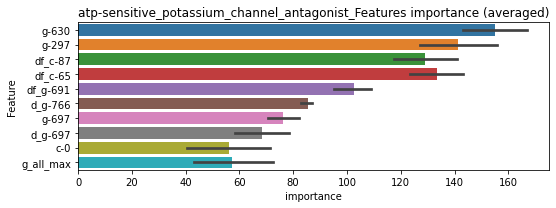

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00878222	valid_1's binary_logloss: 0.00983212
[200]	training's binary_logloss: 0.000725658	valid_1's binary_logloss: 0.00169494
[300]	training's binary_logloss: 0.000196528	valid_1's binary_logloss: 0.00119872
[400]	training's binary_logloss: 0.000117537	valid_1's binary_logloss: 0.00113904
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000113872	valid_1's binary_logloss: 0.00113645


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00890102	valid_1's binary_logloss: 0.0126401
[200]	training's binary_logloss: 0.000737507	valid_1's binary_logloss: 0.0042323
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000224323	valid_1's binary_logloss: 0.0036224


atp-sensitive_potassium_channel_antagonist logloss: 0.0023794250433579757
atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154391	valid_1's binary_logloss: 0.0187903
[200]	training's binary_logloss: 0.00120648	valid_1's binary_logloss: 0.00387889
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000336269	valid_1's binary_logloss: 0.00298953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158891	valid_1's binary_logloss: 0.0161449
[200]	training's binary_logloss: 0.00127652	valid_1's binary_logloss: 0.0017649
[300]	training's binary_logloss: 0.000326653	valid_1's binary_logloss: 0.000727553
[400]	training's binary_logloss: 0.000204591	valid_1's binary_logloss: 0.000522174
[500]	training's binary_logloss: 0.000183472	valid_1's binary_logloss: 0.000480982
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000180443	valid_1's binary_logloss: 0.000473363


1 / 3 AUC score:1.000
y_Threshold: 0.0006851, Threshold: 0.0020638, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00186, conf_1:0.00227
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020638
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.0120638
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.0220638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_4: 0.0320638
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.0420638
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.0520638
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.0620638
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0720638
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.0820638
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.0920638
threshold: 0.1020638, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
===============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015837	valid_1's binary_logloss: 0.0170476
[200]	training's binary_logloss: 0.00118001	valid_1's binary_logloss: 0.00155878
[300]	training's binary_logloss: 0.000273491	valid_1's binary_logloss: 0.000467528
[400]	training's binary_logloss: 0.000174195	valid_1's binary_logloss: 0.000335534
[500]	training's binary_logloss: 0.000156643	valid_1's binary_logloss: 0.000313878
[600]	training's binary_logloss: 0.000151064	valid_1's binary_logloss: 0.000305102
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.000149723	valid_1's binary_logloss: 0.000302683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156912	valid_1's binary_logloss: 0.0157312
[200]	training's binary_logloss: 0.00114228	valid_1's binary_logloss: 0.00117924
[300]	training's binary_logloss: 0.000266116	valid_1's binary_logloss: 0.000286129
[400]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.2554178, Threshold: 0.1020638, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000155457	valid_1's binary_logloss: 0.000170986


p_label_rate: 0.0047715 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.09186, conf_1:0.11227
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.1020638
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.1120638
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_3: 0.1220638
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.1320638
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_5: 0.1420638
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_6: 0.1520638
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.1620638
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_8: 0.1720638
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_9: 0.1820638
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_10: 0.1920638
threshold: 0.2020638, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015837	valid_1's binary_logloss: 0.0170476
[200]	training's binary_logloss: 0.00118001	valid_1's binary_logloss: 0.00155878
[300]	training's binary_logloss: 0.000273491	valid_1's binary_logloss: 0.000467528
[400]	training's binary_logloss: 0.000174195	valid_1's binary_logloss: 0.000335534
[500]	training's binary_logloss: 0.000156643	valid_1's binary_logloss: 0.000313878
[600]	training's binary_logloss: 0.000151064	valid_1's binary_logloss: 0.000305102
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.000149723	valid_1's binary_logloss: 0.000302683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156912	valid_1's binary_logloss: 0.0157312
[200]	training's binary_logloss: 0.00114228	valid_1's binary_logloss: 0.00117924
[300]	training's binary_logloss: 0.000266116	valid_1's binary_logloss: 0.000286129
[400]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.2554178, Threshold: 0.2020638, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000155457	valid_1's binary_logloss: 0.000170986


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.18186, conf_1:0.22227
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.2020638
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.2120638
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.2220638
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.2320638
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.2420638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.2520638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_7: 0.2620638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.2720638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.2820638
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.2920638
threshold: 0.3020638, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7794, y_label_rate: 0.0857070


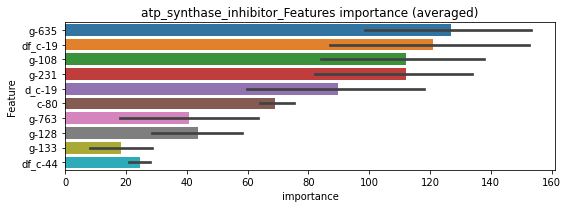

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00852765	valid_1's binary_logloss: 0.011436
[200]	training's binary_logloss: 0.000654485	valid_1's binary_logloss: 0.0033037


len(train_index) : 3897
len(valid_index) : 3897


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00031439	valid_1's binary_logloss: 0.00288397


================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00888757	valid_1's binary_logloss: 0.00911777
[200]	training's binary_logloss: 0.000730265	valid_1's binary_logloss: 0.00108742
[300]	training's binary_logloss: 0.000182685	valid_1's binary_logloss: 0.000453181
[400]	training's binary_logloss: 0.000114869	valid_1's binary_logloss: 0.000355205
[500]	training's binary_logloss: 0.000102163	valid_1's binary_logloss: 0.000334273
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000101079	valid_1's binary_logloss: 0.000332872


atp_synthase_inhibitor logloss: 0.001608456329085722
atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577577	valid_1's binary_logloss: 0.119369
[200]	training's binary_logloss: 0.0137837	valid_1's binary_logloss: 0.0720214
[300]	training's binary_logloss: 0.00406453	valid_1's binary_logloss: 0.0568982
[400]	training's binary_logloss: 0.00181331	valid_1's binary_logloss: 0.0522729
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00155198	valid_1's binary_logloss: 0.0513397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618082	valid_1's binary_logloss: 0.132588
[200]	training's binary_logloss: 0.0158303	valid_1's binary_logloss: 0.083429
[300]	training's binary_logloss: 0.00472158	valid_1's binary_logloss: 0.0623497
[400]	training's binary_logloss: 0.00193465	valid_1's binary_logloss: 0.0558215
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00177433	valid_1's binary_logloss: 0.0553507


1 / 3 AUC score:0.998
y_Threshold: 0.0163398, Threshold: 0.0506605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 648/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00407, Num_p_label: 80.0, conf_0:0.04559, conf_1:0.05573
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0506605
Num_p_label: 64.0, Expected: 16.2, Adj_threshold_2: 0.0606605
Num_p_label: 46.0, Expected: 16.2, Adj_threshold_3: 0.0706605
Num_p_label: 39.0, Expected: 16.2, Adj_threshold_4: 0.0806605
Num_p_label: 38.0, Expected: 16.2, Adj_threshold_5: 0.0906605
Num_p_label: 30.0, Expected: 16.2, Adj_threshold_6: 0.1006605
threshold: 0.1006605, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 648.0/3783, y_label_rate: 0.1712926
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056578	valid_1's binary_logloss: 0.110834
[200]	training's binary_logloss: 0.0124391	valid_1's binary_logloss: 0.0562679
[300]	training's binary_logloss: 0.00378464	valid_1's binary_logloss: 0.0395493
[400]	training's binary_logloss: 0.00173632	valid_1's binary_logloss: 0.0348432
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00131018	valid_1's binary_logloss: 0.0334347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530871	valid_1's binary_logloss: 0.111693
[200]	training's binary_logloss: 0.0119233	valid_1's binary_logloss: 0.0638128
[300]	training's binary_logloss: 0.00360755	valid_1's binary_logloss: 0.0482583
[400]	training's binary_logloss: 0.00165738	valid_1's binary_logloss: 0.0429511
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00170725	valid_1's binary_logloss: 0.0427574


2 / 3 AUC score:0.999
y_Threshold: 0.0830120, Threshold: 0.1006605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 638.0/3763
p_label_rate: 0.0441989 Vs.target_rate: 0.00407, Num_p_label: 176.0, conf_0:0.09059, conf_1:0.11073
Num_p_label: 176.0, Expected: 16.2, Adj_threshold_1: 0.1006605
Num_p_label: 165.0, Expected: 16.2, Adj_threshold_2: 0.1106605
Num_p_label: 159.0, Expected: 16.2, Adj_threshold_3: 0.1206605
Num_p_label: 156.0, Expected: 16.2, Adj_threshold_4: 0.1306605
Num_p_label: 150.0, Expected: 16.2, Adj_threshold_5: 0.1406605
Num_p_label: 141.0, Expected: 16.2, Adj_threshold_6: 0.1506605
Num_p_label: 132.0, Expected: 16.2, Adj_threshold_7: 0.1606605
Num_p_label: 127.0, Expected: 16.2, Adj_threshold_8: 0.1706605
Num_p_label: 121.0, Expected: 16.2, Adj_threshold_9: 0.1806605
Num_p_label: 116.0, Expected: 16.2, Adj_threshold_10: 0.1906605
threshold: 0.2006605, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 638.0/3763, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567376	valid_1's binary_logloss: 0.110734
[200]	training's binary_logloss: 0.0125477	valid_1's binary_logloss: 0.0600096
[300]	training's binary_logloss: 0.00371718	valid_1's binary_logloss: 0.0468998
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00194654	valid_1's binary_logloss: 0.0436164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528133	valid_1's binary_logloss: 0.104707
[200]	training's binary_logloss: 0.0116078	valid_1's binary_logloss: 0.0535183
[300]	training's binary_logloss: 0.00354155	valid_1's binary_logloss: 0.0391123
[400]	training's binary_logloss: 0.001635	valid_1's binary_logloss: 0.0353396
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00135931	valid_1's binary_logloss: 0.0345072


3 / 3 AUC score:0.999
y_Threshold: 0.0790368, Threshold: 0.2006605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 623.0/3733
p_label_rate: 0.0361627 Vs.target_rate: 0.00407, Num_p_label: 144.0, conf_0:0.18059, conf_1:0.22073
Num_p_label: 144.0, Expected: 16.2, Adj_threshold_1: 0.2006605
Num_p_label: 140.0, Expected: 16.2, Adj_threshold_2: 0.2106605
Num_p_label: 140.0, Expected: 16.2, Adj_threshold_3: 0.2206605
Num_p_label: 137.0, Expected: 16.2, Adj_threshold_4: 0.2306605
Num_p_label: 134.0, Expected: 16.2, Adj_threshold_5: 0.2406605
Num_p_label: 130.0, Expected: 16.2, Adj_threshold_6: 0.2506605
Num_p_label: 126.0, Expected: 16.2, Adj_threshold_7: 0.2606605
Num_p_label: 119.0, Expected: 16.2, Adj_threshold_8: 0.2706605
Num_p_label: 114.0, Expected: 16.2, Adj_threshold_9: 0.2806605
Num_p_label: 108.0, Expected: 16.2, Adj_threshold_10: 0.2906605
threshold: 0.3006605, positive_p_label: 107.0/3982, p_label_rate: 0.0268709
positive_y_label: 730.0/7715, y_label_r

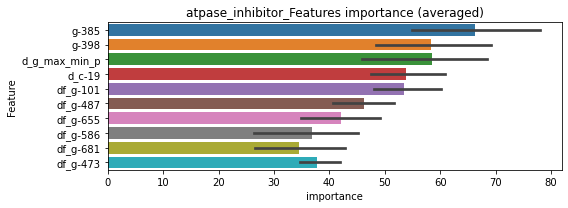

len(train_index) : 3857
len(valid_index) : 3858
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330488	valid_1's binary_logloss: 0.0776811
[200]	training's binary_logloss: 0.0076371	valid_1's binary_logloss: 0.0523722
[300]	training's binary_logloss: 0.00222301	valid_1's binary_logloss: 0.0449059
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00158352	valid_1's binary_logloss: 0.0440254


len(train_index) : 3858
len(valid_index) : 3857
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331072	valid_1's binary_logloss: 0.0729752
[200]	training's binary_logloss: 0.0077628	valid_1's binary_logloss: 0.0433197
[300]	training's binary_logloss: 0.00245289	valid_1's binary_logloss: 0.0351297
[400]	training's binary_logloss: 0.00109961	valid_1's binary_logloss: 0.0314761
[500]	training's binary_logloss: 0.000660905	valid_1's binary_logloss: 0.0301722
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000688679	valid_1's binary_logloss: 0.0301313


atpase_inhibitor logloss: 0.03707926088370765
atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193359	valid_1's binary_logloss: 0.0265846
[200]	training's binary_logloss: 0.00200054	valid_1's binary_logloss: 0.00543546
[300]	training's binary_logloss: 0.000560765	valid_1's binary_logloss: 0.00265119
[400]	training's binary_logloss: 0.000320358	valid_1's binary_logloss: 0.00191282
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000280549	valid_1's binary_logloss: 0.00180643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195587	valid_1's binary_logloss: 0.0239648
[200]	training's binary_logloss: 0.00200859	valid_1's binary_logloss: 0.00411162
[300]	training's binary_logloss: 0.000571548	valid_1's binary_logloss: 0.00203869
[400]	training's binary_logloss: 0.000331013	valid_1's binary_logloss: 0.00151626
[500]	training's binary_logloss: 0.00028297	valid_1's binary_logloss: 0.00140905
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0017736, Threshold: 0.0046707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00420, conf_1:0.00514
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0046707
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_2: 0.0146707
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_3: 0.0246707
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_4: 0.0346707
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.0446707
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_6: 0.0546707
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.0646707
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_8: 0.0746707
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.0846707
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_10: 0.0946707
threshold: 0.1046707, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192108	valid_1's binary_logloss: 0.0233738
[200]	training's binary_logloss: 0.00184246	valid_1's binary_logloss: 0.00327766
[300]	training's binary_logloss: 0.000490009	valid_1's binary_logloss: 0.00118987
[400]	training's binary_logloss: 0.000288259	valid_1's binary_logloss: 0.000804309
[500]	training's binary_logloss: 0.000256185	valid_1's binary_logloss: 0.000749624
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000252589	valid_1's binary_logloss: 0.000743996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193819	valid_1's binary_logloss: 0.0226113
[200]	training's binary_logloss: 0.00186689	valid_1's binary_logloss: 0.00364468
[300]	training's binary_logloss: 0.000495032	valid_1's binary_logloss: 0.00157792
[400]	training's binary_logloss: 0.0002935	valid_1's binary_logloss: 0.00119368
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.1706666, Threshold: 0.1046707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0128076 Vs.target_rate: 0.00080, Num_p_label: 51.0, conf_0:0.09420, conf_1:0.11514
Num_p_label: 51.0, Expected: 3.2, Adj_threshold_1: 0.1046707
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_2: 0.1146707
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_3: 0.1246707
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_4: 0.1346707
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_5: 0.1446707
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_6: 0.1546707
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_7: 0.1646707
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_8: 0.1746707
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_9: 0.1846707
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_10: 0.1946707
threshold: 0.2046707, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192108	valid_1's binary_logloss: 0.0233738
[200]	training's binary_logloss: 0.00184246	valid_1's binary_logloss: 0.00327766
[300]	training's binary_logloss: 0.000490009	valid_1's binary_logloss: 0.00118987
[400]	training's binary_logloss: 0.000288259	valid_1's binary_logloss: 0.000804309
[500]	training's binary_logloss: 0.000256185	valid_1's binary_logloss: 0.000749624
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000252589	valid_1's binary_logloss: 0.000743996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193819	valid_1's binary_logloss: 0.0226113
[200]	training's binary_logloss: 0.00186689	valid_1's binary_logloss: 0.00364468
[300]	training's binary_logloss: 0.000495032	valid_1's binary_logloss: 0.00157792
[400]	training's binary_logloss: 0.0002935	valid_1's binary_logloss: 0.00119368
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.1706666, Threshold: 0.2046707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0087896 Vs.target_rate: 0.00080, Num_p_label: 35.0, conf_0:0.18420, conf_1:0.22514
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_1: 0.2046707
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.2146707
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_3: 0.2246707
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_4: 0.2346707
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_5: 0.2446707
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_6: 0.2546707
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_7: 0.2646707
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_8: 0.2746707
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_9: 0.2846707
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_10: 0.2946707
threshold: 0.3046707, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 687.0/7793, y_label_rate: 0.0881560


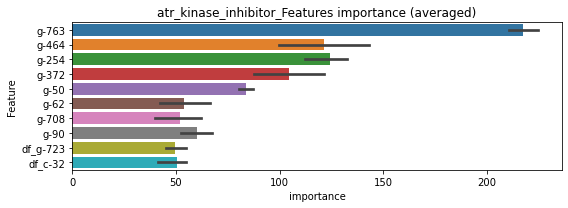

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111633	valid_1's binary_logloss: 0.0193454
[200]	training's binary_logloss: 0.00123036	valid_1's binary_logloss: 0.00885315
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000475553	valid_1's binary_logloss: 0.00799104


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117345	valid_1's binary_logloss: 0.0171785
[200]	training's binary_logloss: 0.00128807	valid_1's binary_logloss: 0.00640815
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000443949	valid_1's binary_logloss: 0.0053393


atr_kinase_inhibitor logloss: 0.006665342020244582
aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388265	valid_1's binary_logloss: 0.0695713
[200]	training's binary_logloss: 0.00644705	valid_1's binary_logloss: 0.0332453
[300]	training's binary_logloss: 0.00193262	valid_1's binary_logloss: 0.0261613
[400]	training's binary_logloss: 0.000968839	valid_1's binary_logloss: 0.0236101
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000942506	valid_1's binary_logloss: 0.0234908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037041	valid_1's binary_logloss: 0.0823272
[200]	training's binary_logloss: 0.006321	valid_1's binary_logloss: 0.0447373
[300]	training's binary_logloss: 0.00189338	valid_1's binary_logloss: 0.0376954
[400]	training's binary_logloss: 0.000915781	valid_1's binary_logloss: 0.0350154
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000831381	valid_1's binary_logloss: 0.0347226


1 / 3 AUC score:0.999
y_Threshold: 0.0158339, Threshold: 0.0639267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.05753, conf_1:0.07032
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0639267
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_2: 0.0739267
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_3: 0.0839267
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_4: 0.0939267
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_5: 0.1039267
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_6: 0.1139267
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_7: 0.1239267
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_8: 0.1339267
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_9: 0.1439267
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_10: 0.1539267
threshold: 0.1639267, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 651.0/3789, y_label_rate: 0.171813

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325327	valid_1's binary_logloss: 0.0728322
[200]	training's binary_logloss: 0.00490836	valid_1's binary_logloss: 0.0383454
[300]	training's binary_logloss: 0.00145349	valid_1's binary_logloss: 0.032393
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000885291	valid_1's binary_logloss: 0.0308706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333833	valid_1's binary_logloss: 0.0630264
[200]	training's binary_logloss: 0.00514659	valid_1's binary_logloss: 0.0262668
[300]	training's binary_logloss: 0.00160145	valid_1's binary_logloss: 0.0193567
[400]	training's binary_logloss: 0.00083081	valid_1's binary_logloss: 0.0170306
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000641421	valid_1's binary_logloss: 0.0161379


2 / 3 AUC score:0.999
y_Threshold: 0.0785401, Threshold: 0.1639267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 640.0/3767
p_label_rate: 0.0261175 Vs.target_rate: 0.00403, Num_p_label: 104.0, conf_0:0.14753, conf_1:0.18032
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_1: 0.1639267
Num_p_label: 102.0, Expected: 16.1, Adj_threshold_2: 0.1739267
Num_p_label: 100.0, Expected: 16.1, Adj_threshold_3: 0.1839267
Num_p_label: 99.0, Expected: 16.1, Adj_threshold_4: 0.1939267
Num_p_label: 96.0, Expected: 16.1, Adj_threshold_5: 0.2039267
Num_p_label: 95.0, Expected: 16.1, Adj_threshold_6: 0.2139267
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_7: 0.2239267
Num_p_label: 91.0, Expected: 16.1, Adj_threshold_8: 0.2339267
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_9: 0.2439267
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_10: 0.2539267
threshold: 0.2639267, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 640.0/3767, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319193	valid_1's binary_logloss: 0.0579945
[200]	training's binary_logloss: 0.00478856	valid_1's binary_logloss: 0.0213419
[300]	training's binary_logloss: 0.00140944	valid_1's binary_logloss: 0.013887
[400]	training's binary_logloss: 0.000701791	valid_1's binary_logloss: 0.0109565
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000514771	valid_1's binary_logloss: 0.0101085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315166	valid_1's binary_logloss: 0.060346
[200]	training's binary_logloss: 0.00469432	valid_1's binary_logloss: 0.0265029
[300]	training's binary_logloss: 0.00138557	valid_1's binary_logloss: 0.019638
[400]	training's binary_logloss: 0.000686506	valid_1's binary_logloss: 0.0170542
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00058208	valid_1's binary_logloss: 0.0165263


3 / 3 AUC score:1.000
y_Threshold: 0.1011616, Threshold: 0.2639267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 636.0/3759
p_label_rate: 0.0226017 Vs.target_rate: 0.00403, Num_p_label: 90.0, conf_0:0.23753, conf_1:0.29032
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_1: 0.2639267
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_2: 0.2739267
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_3: 0.2839267
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_4: 0.2939267
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_5: 0.3039267
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_6: 0.3139267
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_7: 0.3239267
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_8: 0.3339267
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_9: 0.3439267
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_10: 0.3539267
threshold: 0.3639267, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 708.0/7741, y_label_rate: 0.091461

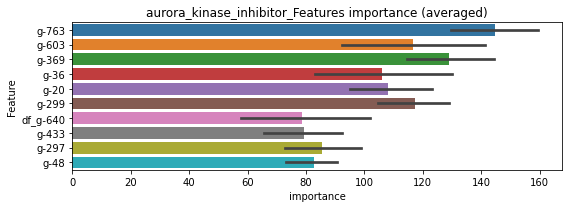

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190147	valid_1's binary_logloss: 0.043118
[200]	training's binary_logloss: 0.00290229	valid_1's binary_logloss: 0.0232421
[300]	training's binary_logloss: 0.000862542	valid_1's binary_logloss: 0.01926
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000593542	valid_1's binary_logloss: 0.018496


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185161	valid_1's binary_logloss: 0.0469321
[200]	training's binary_logloss: 0.00272221	valid_1's binary_logloss: 0.0284869
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000993686	valid_1's binary_logloss: 0.0256687


aurora_kinase_inhibitor logloss: 0.022081869158595745
autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160166	valid_1's binary_logloss: 0.0172227
[200]	training's binary_logloss: 0.00136269	valid_1's binary_logloss: 0.00168442
[300]	training's binary_logloss: 0.000366093	valid_1's binary_logloss: 0.00051268
[400]	training's binary_logloss: 0.000222191	valid_1's binary_logloss: 0.000331176
[500]	training's binary_logloss: 0.00020342	valid_1's binary_logloss: 0.000307939
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00020342	valid_1's binary_logloss: 0.000307939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162798	valid_1's binary_logloss: 0.0177612
[200]	training's binary_logloss: 0.00137232	valid_1's binary_logloss: 0.00179533
[300]	training's binary_logloss: 0.000365747	valid_1's binary_logloss: 0.000551141
[400]	training's binary_logloss: 0.000222279	valid_1's binary_logloss: 0.000353793


1 / 3 AUC score:1.000
y_Threshold: 0.0005576, Threshold: 0.0010918, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000202562	valid_1's binary_logloss: 0.000325292


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00098, conf_1:0.00120
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010918
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0110918
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.0210918
threshold: 0.0210918, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162873	valid_1's binary_logloss: 0.0174503
[200]	training's binary_logloss: 0.00134162	valid_1's binary_logloss: 0.00161997
[300]	training's binary_logloss: 0.000358925	valid_1's binary_logloss: 0.000483409
[400]	training's binary_logloss: 0.000220083	valid_1's binary_logloss: 0.00031134
[500]	training's binary_logloss: 0.000200025	valid_1's binary_logloss: 0.000286799
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000200025	valid_1's binary_logloss: 0.000286799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165184	valid_1's binary_logloss: 0.0178132
[200]	training's binary_logloss: 0.00136268	valid_1's binary_logloss: 0.00198006
[300]	training's binary_logloss: 0.000361192	valid_1's binary_logloss: 0.000659701
[400]	training's binary_logloss: 0.000221261	valid_1's binary_logloss: 0.000459966


2 / 3 AUC score:1.000
y_Threshold: 0.1493386, Threshold: 0.0210918, pos_neg_ratio: 0.8000000


[500]	training's binary_logloss: 0.000197366	valid_1's binary_logloss: 0.000423352
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000197366	valid_1's binary_logloss: 0.000423352


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.01898, conf_1:0.02320
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0210918
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0310918
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0410918
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0510918
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0610918
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0710918
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0810918
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.0910918
threshold: 0.0910918, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162873	valid_1's binary_logloss: 0.0174503
[200]	training's binary_logloss: 0.00134162	valid_1's binary_logloss: 0.00161997
[300]	training's binary_logloss: 0.000358925	valid_1's binary_logloss: 0.000483409
[400]	training's binary_logloss: 0.000220083	valid_1's binary_logloss: 0.00031134
[500]	training's binary_logloss: 0.000200025	valid_1's binary_logloss: 0.000286799
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000200025	valid_1's binary_logloss: 0.000286799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165184	valid_1's binary_logloss: 0.0178132
[200]	training's binary_logloss: 0.00136268	valid_1's binary_logloss: 0.00198006
[300]	training's binary_logloss: 0.000361192	valid_1's binary_logloss: 0.000659701
[400]	training's binary_logloss: 0.000221261	valid_1's binary_logloss: 0.000459966


3 / 3 AUC score:1.000
y_Threshold: 0.1493386, Threshold: 0.0910918, pos_neg_ratio: 0.8000000


[500]	training's binary_logloss: 0.000197366	valid_1's binary_logloss: 0.000423352
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000197366	valid_1's binary_logloss: 0.000423352


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.08198, conf_1:0.10020
threshold: 0.0910918, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


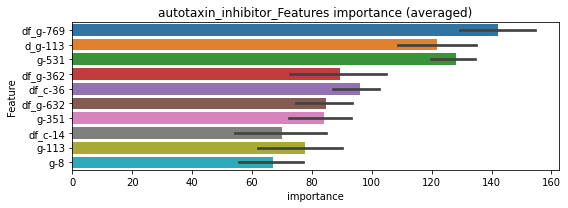

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00870748	valid_1's binary_logloss: 0.0102043
[200]	training's binary_logloss: 0.000726676	valid_1's binary_logloss: 0.00207148
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000218974	valid_1's binary_logloss: 0.00165269


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865454	valid_1's binary_logloss: 0.0105751
[200]	training's binary_logloss: 0.000720027	valid_1's binary_logloss: 0.00219622
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0002362	valid_1's binary_logloss: 0.00182864


autotaxin_inhibitor logloss: 0.0017406510240199852
bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587628	valid_1's binary_logloss: 0.11176
[200]	training's binary_logloss: 0.0130914	valid_1's binary_logloss: 0.0565714
[300]	training's binary_logloss: 0.00355968	valid_1's binary_logloss: 0.0368622
[400]	training's binary_logloss: 0.00148422	valid_1's binary_logloss: 0.0300414
[500]	training's binary_logloss: 0.000892196	valid_1's binary_logloss: 0.0282245
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000874374	valid_1's binary_logloss: 0.028113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576886	valid_1's binary_logloss: 0.0999918
[200]	training's binary_logloss: 0.0115624	valid_1's binary_logloss: 0.040023
[300]	training's binary_logloss: 0.00328249	valid_1's binary_logloss: 0.02422
[400]	training's binary_logloss: 0.00144447	valid_1's binary_logloss: 0.0192371
[500]	training's binary_logloss: 0.000884807	valid_

1 / 3 AUC score:0.999
y_Threshold: 0.0077459, Threshold: 0.0102464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.00922, conf_1:0.01127
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0102464
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_2: 0.0202464
Num_p_label: 8.0, Expected: 10.0, Adj_threshold_3: 0.0302464
threshold: 0.0302464, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572511	valid_1's binary_logloss: 0.0958427
[200]	training's binary_logloss: 0.011352	valid_1's binary_logloss: 0.0380564
[300]	training's binary_logloss: 0.0032446	valid_1's binary_logloss: 0.0221379
[400]	training's binary_logloss: 0.00142331	valid_1's binary_logloss: 0.0169132
[500]	training's binary_logloss: 0.000873429	valid_1's binary_logloss: 0.0152414
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000898933	valid_1's binary_logloss: 0.0151828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566228	valid_1's binary_logloss: 0.102869
[200]	training's binary_logloss: 0.0109961	valid_1's binary_logloss: 0.0449186
[300]	training's binary_logloss: 0.00311799	valid_1's binary_logloss: 0.0301921
[400]	training's binary_logloss: 0.00140865	valid_1's binary_logloss: 0.025448
Early stopping, best iteration is:
[400]	training

2 / 3 AUC score:0.999
y_Threshold: 0.0395088, Threshold: 0.0302464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0118031 Vs.target_rate: 0.00252, Num_p_label: 47.0, conf_0:0.02722, conf_1:0.03327
Num_p_label: 47.0, Expected: 10.0, Adj_threshold_1: 0.0302464
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_2: 0.0402464
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_3: 0.0502464
threshold: 0.0502464, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057118	valid_1's binary_logloss: 0.108758
[200]	training's binary_logloss: 0.0108718	valid_1's binary_logloss: 0.0484594
[300]	training's binary_logloss: 0.00305306	valid_1's binary_logloss: 0.0344643
[400]	training's binary_logloss: 0.00138915	valid_1's binary_logloss: 0.0294906
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00096414	valid_1's binary_logloss: 0.0279394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580472	valid_1's binary_logloss: 0.105353
[200]	training's binary_logloss: 0.0112017	valid_1's binary_logloss: 0.0465894
[300]	training's binary_logloss: 0.00308404	valid_1's binary_logloss: 0.0293887
[400]	training's binary_logloss: 0.00140546	valid_1's binary_logloss: 0.0245218
[500]	training's binary_logloss: 0.000850501	valid_1's binary_logloss: 0.0224218
Early stopping, best iteration is:
[538]	training

3 / 3 AUC score:1.000
y_Threshold: 0.0352044, Threshold: 0.0502464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0017579 Vs.target_rate: 0.00252, Num_p_label: 7.0, conf_0:0.04522, conf_1:0.05527
threshold: 0.0502464, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 652.0/7764, y_label_rate: 0.0839773


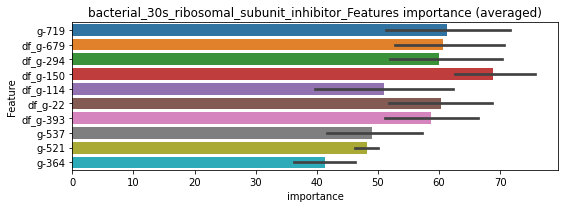

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295192	valid_1's binary_logloss: 0.0566178
[200]	training's binary_logloss: 0.00565687	valid_1's binary_logloss: 0.0260919
[300]	training's binary_logloss: 0.00155677	valid_1's binary_logloss: 0.0193037
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000745746	valid_1's binary_logloss: 0.0177913


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033125	valid_1's binary_logloss: 0.0570878
[200]	training's binary_logloss: 0.00639483	valid_1's binary_logloss: 0.0224801
[300]	training's binary_logloss: 0.00170481	valid_1's binary_logloss: 0.0136123
[400]	training's binary_logloss: 0.000750153	valid_1's binary_logloss: 0.010484
[500]	training's binary_logloss: 0.000456	valid_1's binary_logloss: 0.0094449
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000470503	valid_1's binary_logloss: 0.00941945


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.013605373307448848
bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593977	valid_1's binary_logloss: 0.127877
[200]	training's binary_logloss: 0.0131854	valid_1's binary_logloss: 0.0754033
[300]	training's binary_logloss: 0.00385982	valid_1's binary_logloss: 0.0622005
[400]	training's binary_logloss: 0.00172945	valid_1's binary_logloss: 0.0580131
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00169798	valid_1's binary_logloss: 0.0578676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593129	valid_1's binary_logloss: 0.116618
[200]	training's binary_logloss: 0.0136234	valid_1's binary_logloss: 0.0642187
[300]	training's binary_logloss: 0.00417152	valid_1's binary_logloss: 0.0524056
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00235632	valid_1's binary_logloss: 0.0504025


1 / 3 AUC score:0.995
y_Threshold: 0.0137016, Threshold: 0.0186938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 641/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.01682, conf_1:0.02056
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0186938
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_2: 0.0286938
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_3: 0.0386938
threshold: 0.0386938, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 641.0/3772, y_label_rate: 0.1699364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551469	valid_1's binary_logloss: 0.11344
[200]	training's binary_logloss: 0.0124499	valid_1's binary_logloss: 0.0575355
[300]	training's binary_logloss: 0.0036862	valid_1's binary_logloss: 0.0416022
[400]	training's binary_logloss: 0.00164627	valid_1's binary_logloss: 0.0357322
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00114084	valid_1's binary_logloss: 0.0343396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600202	valid_1's binary_logloss: 0.105768
[200]	training's binary_logloss: 0.01311	valid_1's binary_logloss: 0.0502133
[300]	training's binary_logloss: 0.0039376	valid_1's binary_logloss: 0.0342341
[400]	training's binary_logloss: 0.00176575	valid_1's binary_logloss: 0.0286074
[500]	training's binary_logloss: 0.00107293	valid_1's binary_logloss: 0.0265972
Early stopping, best iteration is:
[494]	training's bi

2 / 3 AUC score:1.000
y_Threshold: 0.0289685, Threshold: 0.0386938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 638.0/3766
p_label_rate: 0.0052737 Vs.target_rate: 0.00336, Num_p_label: 21.0, conf_0:0.03482, conf_1:0.04256
threshold: 0.0386938, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3766, y_label_rate: 0.1694105
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595263	valid_1's binary_logloss: 0.108009
[200]	training's binary_logloss: 0.0126984	valid_1's binary_logloss: 0.051857
[300]	training's binary_logloss: 0.00374783	valid_1's binary_logloss: 0.0362541
[400]	training's binary_logloss: 0.00165713	valid_1's binary_logloss: 0.0305766
[500]	training's binary_logloss: 0.0010074	valid_1's binary_logloss: 0.0287862
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000896961	valid_1's binary_logloss: 0.0282714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538357	valid_1's binary_logloss: 0.10951
[200]	training's binary_logloss: 0.0114397	valid_1's binary_logloss: 0.0579518
[300]	training's binary_logloss: 0.00343812	valid_1's binary_logloss: 0.0463359
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00220331	valid_1's binary_logloss: 0.0442154


3 / 3 AUC score:0.999
y_Threshold: 0.0300957, Threshold: 0.0386938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 633.0/3756
p_label_rate: 0.0055249 Vs.target_rate: 0.00336, Num_p_label: 22.0, conf_0:0.03482, conf_1:0.04256
threshold: 0.0386938, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 655.0/7738, y_label_rate: 0.0846472


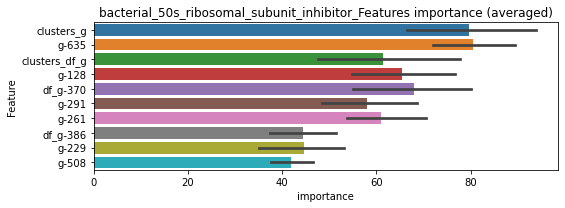

len(train_index) : 3869
len(valid_index) : 3869
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317246	valid_1's binary_logloss: 0.066216
[200]	training's binary_logloss: 0.00675917	valid_1's binary_logloss: 0.0399895
[300]	training's binary_logloss: 0.00195453	valid_1's binary_logloss: 0.0343941
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00147789	valid_1's binary_logloss: 0.033847


len(train_index) : 3869
len(valid_index) : 3869
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327977	valid_1's binary_logloss: 0.0657965
[200]	training's binary_logloss: 0.00705552	valid_1's binary_logloss: 0.0366953
[300]	training's binary_logloss: 0.00204864	valid_1's binary_logloss: 0.0289807
[400]	training's binary_logloss: 0.000911849	valid_1's binary_logloss: 0.0267967
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000901539	valid_1's binary_logloss: 0.026775


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.030310982366314968
bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368791	valid_1's binary_logloss: 0.0559355
[200]	training's binary_logloss: 0.00580072	valid_1's binary_logloss: 0.0159552
[300]	training's binary_logloss: 0.00160287	valid_1's binary_logloss: 0.00722502
[400]	training's binary_logloss: 0.000766859	valid_1's binary_logloss: 0.00502578
[500]	training's binary_logloss: 0.000513211	valid_1's binary_logloss: 0.00406482
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000451959	valid_1's binary_logloss: 0.00380349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362669	valid_1's binary_logloss: 0.0648682
[200]	training's binary_logloss: 0.00558645	valid_1's binary_logloss: 0.0222975
[300]	training's binary_logloss: 0.00156395	valid_1's binary_logloss: 0.0143439
[400]	training's binary_logloss: 0.000766374	valid_1's binary_logloss: 0.0121694
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0051689, Threshold: 0.0087349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00786, conf_1:0.00961
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0087349
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_2: 0.0187349
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.0287349
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0387349
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.0487349
threshold: 0.0487349, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356101	valid_1's binary_logloss: 0.0537662
[200]	training's binary_logloss: 0.00526841	valid_1's binary_logloss: 0.0136505
[300]	training's binary_logloss: 0.00148599	valid_1's binary_logloss: 0.00612365
[400]	training's binary_logloss: 0.000728054	valid_1's binary_logloss: 0.00414199
[500]	training's binary_logloss: 0.00048965	valid_1's binary_logloss: 0.00332495
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000454638	valid_1's binary_logloss: 0.0032478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349565	valid_1's binary_logloss: 0.0632951
[200]	training's binary_logloss: 0.00515888	valid_1's binary_logloss: 0.021544
[300]	training's binary_logloss: 0.00146942	valid_1's binary_logloss: 0.0140158
[400]	training's binary_logloss: 0.000730876	valid_1's binary_logloss: 0.0117013
Early stopping, best iteration is:
[432]

2 / 3 AUC score:1.000
y_Threshold: 0.0571227, Threshold: 0.0487349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0047715 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.04386, conf_1:0.05361
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0487349
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0587349
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0687349
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0787349
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.0887349
threshold: 0.0887349, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356101	valid_1's binary_logloss: 0.0537662
[200]	training's binary_logloss: 0.00526841	valid_1's binary_logloss: 0.0136505
[300]	training's binary_logloss: 0.00148599	valid_1's binary_logloss: 0.00612365
[400]	training's binary_logloss: 0.000728054	valid_1's binary_logloss: 0.00414199
[500]	training's binary_logloss: 0.00048965	valid_1's binary_logloss: 0.00332495
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000454638	valid_1's binary_logloss: 0.0032478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349565	valid_1's binary_logloss: 0.0632951
[200]	training's binary_logloss: 0.00515888	valid_1's binary_logloss: 0.021544
[300]	training's binary_logloss: 0.00146942	valid_1's binary_logloss: 0.0140158
[400]	training's binary_logloss: 0.000730876	valid_1's binary_logloss: 0.0117013
Early stopping, best iteration is:
[432]

3 / 3 AUC score:1.000
y_Threshold: 0.0571227, Threshold: 0.0887349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.07986, conf_1:0.09761
threshold: 0.0887349, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


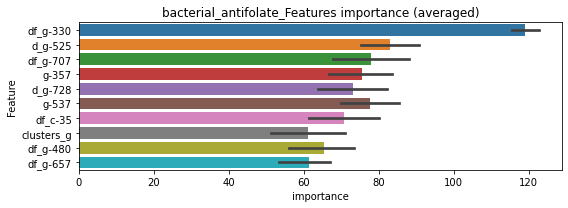

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203549	valid_1's binary_logloss: 0.034505
[200]	training's binary_logloss: 0.00306698	valid_1's binary_logloss: 0.0129841
[300]	training's binary_logloss: 0.000843383	valid_1's binary_logloss: 0.00950549
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000532964	valid_1's binary_logloss: 0.00910887


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02079	valid_1's binary_logloss: 0.0326631
[200]	training's binary_logloss: 0.00303325	valid_1's binary_logloss: 0.0111198
[300]	training's binary_logloss: 0.000836942	valid_1's binary_logloss: 0.00756377
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000441803	valid_1's binary_logloss: 0.00679643


bacterial_antifolate logloss: 0.007952797482624754
bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09057	valid_1's binary_logloss: 0.235646
[200]	training's binary_logloss: 0.0304041	valid_1's binary_logloss: 0.194285
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.013129	valid_1's binary_logloss: 0.185743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10142	valid_1's binary_logloss: 0.227474
[200]	training's binary_logloss: 0.035896	valid_1's binary_logloss: 0.183754
[300]	training's binary_logloss: 0.0133559	valid_1's binary_logloss: 0.171179
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0111177	valid_1's binary_logloss: 0.169585


1 / 3 AUC score:0.952
y_Threshold: 0.0548454, Threshold: 0.0760797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 295 → Positive_corect_labels: 569/3615
p_label_rate: 0.0200904 Vs.target_rate: 0.00806, Num_p_label: 80.0, conf_0:0.06847, conf_1:0.08369
threshold: 0.0760797, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 569.0/3615, y_label_rate: 0.1573997
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794553	valid_1's binary_logloss: 0.189665
[200]	training's binary_logloss: 0.0236526	valid_1's binary_logloss: 0.144059
[300]	training's binary_logloss: 0.00777382	valid_1's binary_logloss: 0.130421
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00657229	valid_1's binary_logloss: 0.128882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816678	valid_1's binary_logloss: 0.195831
[200]	training's binary_logloss: 0.0235431	valid_1's binary_logloss: 0.148094


2 / 3 AUC score:0.982


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0124121	valid_1's binary_logloss: 0.137734


y_Threshold: 0.0758491, Threshold: 0.0760797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 510.0/3497
p_label_rate: 0.0281266 Vs.target_rate: 0.00806, Num_p_label: 112.0, conf_0:0.06847, conf_1:0.08369
Num_p_label: 112.0, Expected: 32.1, Adj_threshold_1: 0.0760797
Num_p_label: 81.0, Expected: 32.1, Adj_threshold_2: 0.0860797
Num_p_label: 54.0, Expected: 32.1, Adj_threshold_3: 0.0960797
threshold: 0.0960797, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 510.0/3497, y_label_rate: 0.1458393
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069598	valid_1's binary_logloss: 0.161497
[200]	training's binary_logloss: 0.0195374	valid_1's binary_logloss: 0.11497
[300]	training's binary_logloss: 0.00654006	valid_1's binary_logloss: 0.105536
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00377473	valid_1's binary_logloss: 0.102047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661871	valid_1's binary_logloss: 0.147849
[200]	training's binary_logloss: 0.0177942	valid_1's binary_logloss: 0.0997021
[300]	training's binary_logloss: 0.00599448	valid_1's binary_logloss: 0.084814
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00301962	valid_1's binary_logloss: 0.0801018


3 / 3 AUC score:0.990
y_Threshold: 0.0680643, Threshold: 0.0960797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 484.0/3445
p_label_rate: 0.0057760 Vs.target_rate: 0.00806, Num_p_label: 23.0, conf_0:0.08647, conf_1:0.10569
threshold: 0.0960797, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 507.0/7427, y_label_rate: 0.0682644


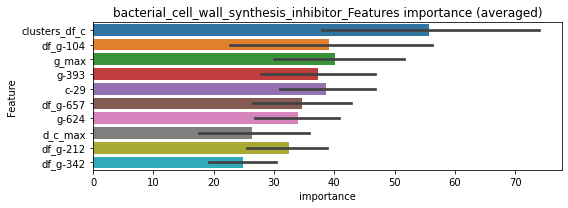

len(train_index) : 3713
len(valid_index) : 3714
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352657	valid_1's binary_logloss: 0.0983277
[200]	training's binary_logloss: 0.00944301	valid_1's binary_logloss: 0.0789165
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00643736	valid_1's binary_logloss: 0.076428


len(train_index) : 3714
len(valid_index) : 3713
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358698	valid_1's binary_logloss: 0.0935476
[200]	training's binary_logloss: 0.0094177	valid_1's binary_logloss: 0.0737516
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00691854	valid_1's binary_logloss: 0.0720898


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07425917860147221
bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066965	valid_1's binary_logloss: 0.13016
[200]	training's binary_logloss: 0.0162477	valid_1's binary_logloss: 0.0736991
[300]	training's binary_logloss: 0.00495552	valid_1's binary_logloss: 0.0566999
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00241054	valid_1's binary_logloss: 0.0528227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697042	valid_1's binary_logloss: 0.129895
[200]	training's binary_logloss: 0.0180423	valid_1's binary_logloss: 0.0704379
[300]	training's binary_logloss: 0.00542431	valid_1's binary_logloss: 0.0494984
[400]	training's binary_logloss: 0.00225474	valid_1's binary_logloss: 0.0425514
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00146175	valid_1's binary_logloss: 0.0405242


1 / 3 AUC score:0.995
y_Threshold: 0.0182150, Threshold: 0.0262664, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.02364, conf_1:0.02889
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0262664
Num_p_label: 39.0, Expected: 14.9, Adj_threshold_2: 0.0362664
Num_p_label: 20.0, Expected: 14.9, Adj_threshold_3: 0.0462664
threshold: 0.0462664, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3776, y_label_rate: 0.1705508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611118	valid_1's binary_logloss: 0.132725
[200]	training's binary_logloss: 0.0134773	valid_1's binary_logloss: 0.0795207
[300]	training's binary_logloss: 0.00398624	valid_1's binary_logloss: 0.0633125
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0019592	valid_1's binary_logloss: 0.0581865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658329	valid_1's binary_logloss: 0.120923
[200]	training's binary_logloss: 0.0157496	valid_1's binary_logloss: 0.0613103
[300]	training's binary_logloss: 0.00479292	valid_1's binary_logloss: 0.0438724
[400]	training's binary_logloss: 0.00211411	valid_1's binary_logloss: 0.0380127
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00137275	valid_1's binary_logloss: 0.0361491


2 / 3 AUC score:0.999
y_Threshold: 0.0463261, Threshold: 0.0462664, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 635.0/3758
p_label_rate: 0.0120542 Vs.target_rate: 0.00374, Num_p_label: 48.0, conf_0:0.04164, conf_1:0.05089
Num_p_label: 48.0, Expected: 14.9, Adj_threshold_1: 0.0462664
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_2: 0.0562664
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_3: 0.0662664
threshold: 0.0662664, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 635.0/3758, y_label_rate: 0.1689729
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621862	valid_1's binary_logloss: 0.127453
[200]	training's binary_logloss: 0.0141206	valid_1's binary_logloss: 0.0704338
[300]	training's binary_logloss: 0.00427673	valid_1's binary_logloss: 0.0528006
[400]	training's binary_logloss: 0.0019083	valid_1's binary_logloss: 0.0462918
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00143766	valid_1's binary_logloss: 0.0452133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585458	valid_1's binary_logloss: 0.129727
[200]	training's binary_logloss: 0.0127607	valid_1's binary_logloss: 0.0704333
[300]	training's binary_logloss: 0.00392129	valid_1's binary_logloss: 0.0525521
[400]	training's binary_logloss: 0.00181654	valid_1's binary_logloss: 0.0460862
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00183629	valid_1's binary_logloss: 0.0459723


3 / 3 AUC score:0.999
y_Threshold: 0.0502507, Threshold: 0.0662664, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 622.0/3732
p_label_rate: 0.0070316 Vs.target_rate: 0.00374, Num_p_label: 28.0, conf_0:0.05964, conf_1:0.07289
threshold: 0.0662664, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 650.0/7714, y_label_rate: 0.0842624


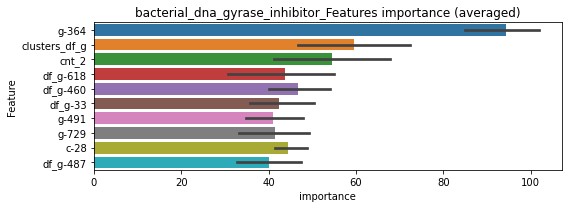

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342367	valid_1's binary_logloss: 0.0759548
[200]	training's binary_logloss: 0.00768424	valid_1's binary_logloss: 0.0468095
[300]	training's binary_logloss: 0.00232392	valid_1's binary_logloss: 0.0405534
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00115913	valid_1's binary_logloss: 0.0394967


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339108	valid_1's binary_logloss: 0.0787286
[200]	training's binary_logloss: 0.00780169	valid_1's binary_logloss: 0.0466177
[300]	training's binary_logloss: 0.0023884	valid_1's binary_logloss: 0.0372507
[400]	training's binary_logloss: 0.0010495	valid_1's binary_logloss: 0.0347508
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000827478	valid_1's binary_logloss: 0.0341809


bacterial_dna_gyrase_inhibitor logloss: 0.03683878373452452
bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722456	valid_1's binary_logloss: 0.161204
[200]	training's binary_logloss: 0.0191542	valid_1's binary_logloss: 0.111663
[300]	training's binary_logloss: 0.00618507	valid_1's binary_logloss: 0.0980286
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00651204	valid_1's binary_logloss: 0.0977164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791059	valid_1's binary_logloss: 0.157322
[200]	training's binary_logloss: 0.0225374	valid_1's binary_logloss: 0.0948351
[300]	training's binary_logloss: 0.00696893	valid_1's binary_logloss: 0.072337
[400]	training's binary_logloss: 0.00319691	valid_1's binary_logloss: 0.0654789
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00257084	valid_1's binary_logloss: 0.0637261


1 / 3 AUC score:0.993
y_Threshold: 0.0297158, Threshold: 0.0404041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 169 → Positive_corect_labels: 635/3756
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.03636, conf_1:0.04444
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0404041
Num_p_label: 51.0, Expected: 19.2, Adj_threshold_2: 0.0504041
Num_p_label: 29.0, Expected: 19.2, Adj_threshold_3: 0.0604041
threshold: 0.0604041, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 635.0/3756, y_label_rate: 0.1690628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747691	valid_1's binary_logloss: 0.157443
[200]	training's binary_logloss: 0.0198099	valid_1's binary_logloss: 0.0958117
[300]	training's binary_logloss: 0.00636391	valid_1's binary_logloss: 0.0760686
[400]	training's binary_logloss: 0.00271057	valid_1's binary_logloss: 0.0683997
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00187894	valid_1's binary_logloss: 0.0661688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716253	valid_1's binary_logloss: 0.140964
[200]	training's binary_logloss: 0.018454	valid_1's binary_logloss: 0.0856597
[300]	training's binary_logloss: 0.00588631	valid_1's binary_logloss: 0.0694499
[400]	training's binary_logloss: 0.00254705	valid_1's binary_logloss: 0.0629483
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00192533	valid_1's binary_logloss: 0.0622268


2 / 3 AUC score:0.997
y_Threshold: 0.0517773, Threshold: 0.0604041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 618.0/3722
p_label_rate: 0.0080362 Vs.target_rate: 0.00483, Num_p_label: 32.0, conf_0:0.05436, conf_1:0.06644
threshold: 0.0604041, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 618.0/3722, y_label_rate: 0.1660398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650786	valid_1's binary_logloss: 0.139598
[200]	training's binary_logloss: 0.0163962	valid_1's binary_logloss: 0.0826906
[300]	training's binary_logloss: 0.00531911	valid_1's binary_logloss: 0.0652609
[400]	training's binary_logloss: 0.00238158	valid_1's binary_logloss: 0.0590493
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.001773	valid_1's binary_logloss: 0.0571141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690904	valid_1's binary_logloss: 0.142791
[200]	training's binary_logloss: 0.017073	valid_1's binary_logloss: 0.0856466
[300]	training's binary_logloss: 0.00548168	valid_1's binary_logloss: 0.0715139
[400]	training's binary_logloss: 0.00243001	valid_1's binary_logloss: 0.0669745
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00235313	valid_1's binary_logloss: 0.06687


3 / 3 AUC score:0.997
y_Threshold: 0.0518632, Threshold: 0.0604041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 602.0/3690
p_label_rate: 0.0077850 Vs.target_rate: 0.00483, Num_p_label: 31.0, conf_0:0.05436, conf_1:0.06644
threshold: 0.0604041, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 633.0/7672, y_label_rate: 0.0825078


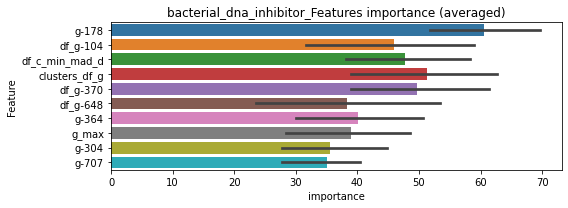

len(train_index) : 3836
len(valid_index) : 3836
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388511	valid_1's binary_logloss: 0.0915317
[200]	training's binary_logloss: 0.0100636	valid_1's binary_logloss: 0.0613972
[300]	training's binary_logloss: 0.00315264	valid_1's binary_logloss: 0.0525815
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00149049	valid_1's binary_logloss: 0.0502165


len(train_index) : 3836
len(valid_index) : 3836
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391194	valid_1's binary_logloss: 0.0887644
[200]	training's binary_logloss: 0.0103396	valid_1's binary_logloss: 0.0613725
[300]	training's binary_logloss: 0.00325877	valid_1's binary_logloss: 0.0539475
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00265847	valid_1's binary_logloss: 0.0536782


bacterial_dna_inhibitor logloss: 0.05194735130954171
bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243398	valid_1's binary_logloss: 0.034571
[200]	training's binary_logloss: 0.00294427	valid_1's binary_logloss: 0.00699794
[300]	training's binary_logloss: 0.000812905	valid_1's binary_logloss: 0.0028363
[400]	training's binary_logloss: 0.000427753	valid_1's binary_logloss: 0.00181081
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000356643	valid_1's binary_logloss: 0.00167578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241126	valid_1's binary_logloss: 0.0305391
[200]	training's binary_logloss: 0.00292411	valid_1's binary_logloss: 0.00482998
[300]	training's binary_logloss: 0.000814457	valid_1's binary_logloss: 0.00170164
[400]	training's binary_logloss: 0.00042738	valid_1's binary_logloss: 0.00104541
[500]	training's binary_logloss: 0.000357871	valid_1's binary_logloss: 0.000906485
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0015247, Threshold: 0.0029308, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00264, conf_1:0.00322
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0029308
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.0129308
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_3: 0.0229308
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0329308
threshold: 0.0329308, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242262	valid_1's binary_logloss: 0.0348628
[200]	training's binary_logloss: 0.00276459	valid_1's binary_logloss: 0.00642646
[300]	training's binary_logloss: 0.000776236	valid_1's binary_logloss: 0.00251722
[400]	training's binary_logloss: 0.000406824	valid_1's binary_logloss: 0.00157814
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000345834	valid_1's binary_logloss: 0.0014724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240503	valid_1's binary_logloss: 0.0306038
[200]	training's binary_logloss: 0.00278541	valid_1's binary_logloss: 0.00445898
[300]	training's binary_logloss: 0.000786397	valid_1's binary_logloss: 0.00149233
[400]	training's binary_logloss: 0.000416251	valid_1's binary_logloss: 0.000886493
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000346915	valid_1's binary_logloss: 0.00075

2 / 3 AUC score:1.000
y_Threshold: 0.1200016, Threshold: 0.0329308, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00080, Num_p_label: 16.0, conf_0:0.02964, conf_1:0.03622
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_1: 0.0329308
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.0429308
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.0529308
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.0629308
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.0729308
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.0829308
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.0929308
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_8: 0.1029308
threshold: 0.1029308, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242262	valid_1's binary_logloss: 0.0348628
[200]	training's binary_logloss: 0.00276459	valid_1's binary_logloss: 0.00642646
[300]	training's binary_logloss: 0.000776236	valid_1's binary_logloss: 0.00251722
[400]	training's binary_logloss: 0.000406824	valid_1's binary_logloss: 0.00157814
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000345834	valid_1's binary_logloss: 0.0014724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240503	valid_1's binary_logloss: 0.0306038
[200]	training's binary_logloss: 0.00278541	valid_1's binary_logloss: 0.00445898
[300]	training's binary_logloss: 0.000786397	valid_1's binary_logloss: 0.00149233
[400]	training's binary_logloss: 0.000416251	valid_1's binary_logloss: 0.000886493
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000346915	valid_1's binary_logloss: 0.00075

3 / 3 AUC score:1.000
y_Threshold: 0.1200016, Threshold: 0.1029308, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.09264, conf_1:0.11322
threshold: 0.1029308, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


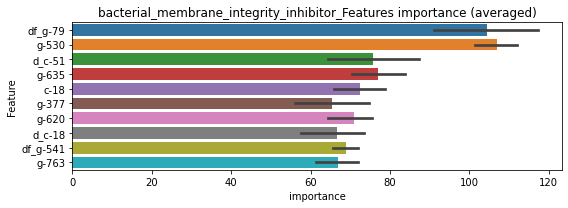

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124127	valid_1's binary_logloss: 0.0183823
[200]	training's binary_logloss: 0.00140502	valid_1's binary_logloss: 0.00469828
[300]	training's binary_logloss: 0.000390521	valid_1's binary_logloss: 0.00301718
[400]	training's binary_logloss: 0.000208228	valid_1's binary_logloss: 0.00276436
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000203803	valid_1's binary_logloss: 0.00273822


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131897	valid_1's binary_logloss: 0.0169167
[200]	training's binary_logloss: 0.00152179	valid_1's binary_logloss: 0.00330275
[300]	training's binary_logloss: 0.000411392	valid_1's binary_logloss: 0.00164068
[400]	training's binary_logloss: 0.000215657	valid_1's binary_logloss: 0.00133152
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00019034	valid_1's binary_logloss: 0.00128401


bacterial_membrane_integrity_inhibitor logloss: 0.002011112596252936
bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295434	valid_1's binary_logloss: 0.0522629
[200]	training's binary_logloss: 0.00406408	valid_1's binary_logloss: 0.0181885
[300]	training's binary_logloss: 0.00114803	valid_1's binary_logloss: 0.0116978
[400]	training's binary_logloss: 0.000578366	valid_1's binary_logloss: 0.00967058
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000489292	valid_1's binary_logloss: 0.00920741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301265	valid_1's binary_logloss: 0.0480225
[200]	training's binary_logloss: 0.00415082	valid_1's binary_logloss: 0.0152429
[300]	training's binary_logloss: 0.00117864	valid_1's binary_logloss: 0.00903361
[400]	training's binary_logloss: 0.000589823	valid_1's binary_logloss: 0.00723163
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000485477	valid_1's binary_logloss: 0.00668835


1 / 3 AUC score:1.000
y_Threshold: 0.0038284, Threshold: 0.1240107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.11161, conf_1:0.13641
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.1240107
Num_p_label: 78.0, Expected: 5.2, Adj_threshold_2: 0.1340107
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_3: 0.1440107
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_4: 0.1540107
Num_p_label: 67.0, Expected: 5.2, Adj_threshold_5: 0.1640107
Num_p_label: 66.0, Expected: 5.2, Adj_threshold_6: 0.1740107
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_7: 0.1840107
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_8: 0.1940107
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_9: 0.2040107
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_10: 0.2140107
threshold: 0.2240107, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287503	valid_1's binary_logloss: 0.0500234
[200]	training's binary_logloss: 0.00369092	valid_1's binary_logloss: 0.0164531
[300]	training's binary_logloss: 0.00103826	valid_1's binary_logloss: 0.0100553
[400]	training's binary_logloss: 0.000524019	valid_1's binary_logloss: 0.00805371
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000432311	valid_1's binary_logloss: 0.00759646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283321	valid_1's binary_logloss: 0.0416763
[200]	training's binary_logloss: 0.00370187	valid_1's binary_logloss: 0.00971174
[300]	training's binary_logloss: 0.00106128	valid_1's binary_logloss: 0.00435316
[400]	training's binary_logloss: 0.000534296	valid_1's binary_logloss: 0.00287986
[500]	training's binary_logloss: 0.000398263	valid_1's binary_logloss: 0.00245552
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.1045397, Threshold: 0.2240107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0354093 Vs.target_rate: 0.00130, Num_p_label: 141.0, conf_0:0.20161, conf_1:0.24641
Num_p_label: 141.0, Expected: 5.2, Adj_threshold_1: 0.2240107
Num_p_label: 141.0, Expected: 5.2, Adj_threshold_2: 0.2340107
Num_p_label: 140.0, Expected: 5.2, Adj_threshold_3: 0.2440107
Num_p_label: 139.0, Expected: 5.2, Adj_threshold_4: 0.2540107
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_5: 0.2640107
Num_p_label: 137.0, Expected: 5.2, Adj_threshold_6: 0.2740107
Num_p_label: 135.0, Expected: 5.2, Adj_threshold_7: 0.2840107
Num_p_label: 134.0, Expected: 5.2, Adj_threshold_8: 0.2940107
Num_p_label: 133.0, Expected: 5.2, Adj_threshold_9: 0.3040107
Num_p_label: 131.0, Expected: 5.2, Adj_threshold_10: 0.3140107
threshold: 0.3240107, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 656.0/3807, y_label_rate: 0.1723

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287503	valid_1's binary_logloss: 0.0500234
[200]	training's binary_logloss: 0.00369092	valid_1's binary_logloss: 0.0164531
[300]	training's binary_logloss: 0.00103826	valid_1's binary_logloss: 0.0100553
[400]	training's binary_logloss: 0.000524019	valid_1's binary_logloss: 0.00805371
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000432311	valid_1's binary_logloss: 0.00759646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283321	valid_1's binary_logloss: 0.0416763
[200]	training's binary_logloss: 0.00370187	valid_1's binary_logloss: 0.00971174
[300]	training's binary_logloss: 0.00106128	valid_1's binary_logloss: 0.00435316
[400]	training's binary_logloss: 0.000534296	valid_1's binary_logloss: 0.00287986
[500]	training's binary_logloss: 0.000398263	valid_1's binary_logloss: 0.00245552
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.1045397, Threshold: 0.3240107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0328980 Vs.target_rate: 0.00130, Num_p_label: 131.0, conf_0:0.29161, conf_1:0.35641
Num_p_label: 131.0, Expected: 5.2, Adj_threshold_1: 0.3240107
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_2: 0.3340107
Num_p_label: 128.0, Expected: 5.2, Adj_threshold_3: 0.3440107
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_4: 0.3540107
Num_p_label: 125.0, Expected: 5.2, Adj_threshold_5: 0.3640107
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_6: 0.3740107
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_7: 0.3840107
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_8: 0.3940107
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_9: 0.4040107
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_10: 0.4140107
threshold: 0.4240107, positive_p_label: 117.0/3982, p_label_rate: 0.0293822
positive_y_label: 773.0/7789, y_label_rate: 0.0992

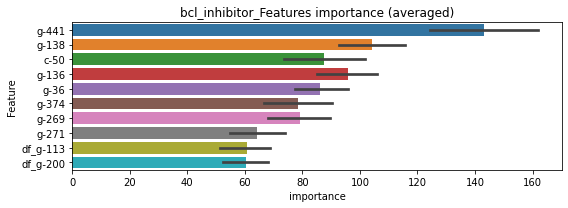

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179763	valid_1's binary_logloss: 0.0328445
[200]	training's binary_logloss: 0.00246833	valid_1's binary_logloss: 0.0126329
[300]	training's binary_logloss: 0.000731115	valid_1's binary_logloss: 0.00961013
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000401431	valid_1's binary_logloss: 0.00839597


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187501	valid_1's binary_logloss: 0.0314059
[200]	training's binary_logloss: 0.00265745	valid_1's binary_logloss: 0.0124667
[300]	training's binary_logloss: 0.000749311	valid_1's binary_logloss: 0.0091061
[400]	training's binary_logloss: 0.000365505	valid_1's binary_logloss: 0.00807311
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00026374	valid_1's binary_logloss: 0.00773918


bcl_inhibitor logloss: 0.008067616345659662
bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324111	valid_1's binary_logloss: 0.0581756
[200]	training's binary_logloss: 0.00505299	valid_1's binary_logloss: 0.0235229
[300]	training's binary_logloss: 0.00144242	valid_1's binary_logloss: 0.015817
[400]	training's binary_logloss: 0.000716434	valid_1's binary_logloss: 0.0135083
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000590132	valid_1's binary_logloss: 0.0131453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319466	valid_1's binary_logloss: 0.0536345
[200]	training's binary_logloss: 0.00498654	valid_1's binary_logloss: 0.0199531
[300]	training's binary_logloss: 0.00141107	valid_1's binary_logloss: 0.0142866
[400]	training's binary_logloss: 0.000690976	valid_1's binary_logloss: 0.0128152
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00068037	valid_1's binary_logloss: 0.0127948


1 / 3 AUC score:1.000
y_Threshold: 0.0041421, Threshold: 0.0101228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160, Num_p_label: 80.0, conf_0:0.00911, conf_1:0.01114
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0101228
Num_p_label: 48.0, Expected: 6.4, Adj_threshold_2: 0.0201228
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_3: 0.0301228
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_4: 0.0401228
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_5: 0.0501228
threshold: 0.0501228, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313697	valid_1's binary_logloss: 0.0515882
[200]	training's binary_logloss: 0.00462976	valid_1's binary_logloss: 0.0170143
[300]	training's binary_logloss: 0.00134654	valid_1's binary_logloss: 0.0106928
[400]	training's binary_logloss: 0.000672975	valid_1's binary_logloss: 0.00900931
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000691037	valid_1's binary_logloss: 0.0089691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315464	valid_1's binary_logloss: 0.0507657
[200]	training's binary_logloss: 0.00456003	valid_1's binary_logloss: 0.0173643
[300]	training's binary_logloss: 0.00131625	valid_1's binary_logloss: 0.0121867
[400]	training's binary_logloss: 0.000657776	valid_1's binary_logloss: 0.0109127
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000519853	valid_1's binary_logloss: 0.010586


2 / 3 AUC score:1.000
y_Threshold: 0.0484058, Threshold: 0.0501228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0150678 Vs.target_rate: 0.00160, Num_p_label: 60.0, conf_0:0.04511, conf_1:0.05514
Num_p_label: 60.0, Expected: 6.4, Adj_threshold_1: 0.0501228
Num_p_label: 47.0, Expected: 6.4, Adj_threshold_2: 0.0601228
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_3: 0.0701228
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_4: 0.0801228
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_5: 0.0901228
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_6: 0.1001228
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_7: 0.1101228
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_8: 0.1201228
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_9: 0.1301228
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_10: 0.1401228
threshold: 0.1501228, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030797	valid_1's binary_logloss: 0.0480972
[200]	training's binary_logloss: 0.00448782	valid_1's binary_logloss: 0.0132293
[300]	training's binary_logloss: 0.00132865	valid_1's binary_logloss: 0.0069746
[400]	training's binary_logloss: 0.000664023	valid_1's binary_logloss: 0.00542871
[500]	training's binary_logloss: 0.000465763	valid_1's binary_logloss: 0.00482986
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000470168	valid_1's binary_logloss: 0.00482165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302796	valid_1's binary_logloss: 0.057161
[200]	training's binary_logloss: 0.00444836	valid_1's binary_logloss: 0.0295658
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0014993	valid_1's binary_logloss: 0.0265763


3 / 3 AUC score:0.999
y_Threshold: 0.0303675, Threshold: 0.1501228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 648.0/3791
p_label_rate: 0.0070316 Vs.target_rate: 0.00160, Num_p_label: 28.0, conf_0:0.13511, conf_1:0.16514
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_1: 0.1501228
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_2: 0.1601228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_3: 0.1701228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_4: 0.1801228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_5: 0.1901228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_6: 0.2001228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_7: 0.2101228
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_8: 0.2201228
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_9: 0.2301228
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_10: 0.2401228
threshold: 0.2501228, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 668.0/7773, y_label_rate: 0.0859385


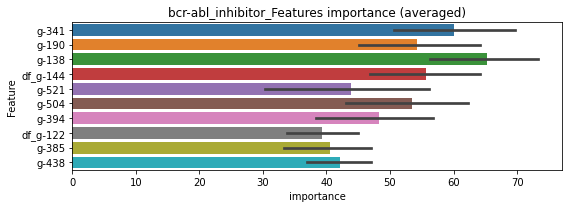

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165289	valid_1's binary_logloss: 0.032388
[200]	training's binary_logloss: 0.00239694	valid_1's binary_logloss: 0.0128137
[300]	training's binary_logloss: 0.000697012	valid_1's binary_logloss: 0.00908584
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000476264	valid_1's binary_logloss: 0.00849186


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157583	valid_1's binary_logloss: 0.0345911
[200]	training's binary_logloss: 0.00235785	valid_1's binary_logloss: 0.0174166
[300]	training's binary_logloss: 0.000682444	valid_1's binary_logloss: 0.0134327
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000708593	valid_1's binary_logloss: 0.0133684


bcr-abl_inhibitor logloss: 0.010929798955478935
benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596804	valid_1's binary_logloss: 0.112384
[200]	training's binary_logloss: 0.0120402	valid_1's binary_logloss: 0.0542886
[300]	training's binary_logloss: 0.00344828	valid_1's binary_logloss: 0.0398814
[400]	training's binary_logloss: 0.00153251	valid_1's binary_logloss: 0.0362961
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00114723	valid_1's binary_logloss: 0.0356521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580735	valid_1's binary_logloss: 0.118414
[200]	training's binary_logloss: 0.0124809	valid_1's binary_logloss: 0.0600472
[300]	training's binary_logloss: 0.00345598	valid_1's binary_logloss: 0.0383106
[400]	training's binary_logloss: 0.00153756	valid_1's binary_logloss: 0.0315625
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110799	valid_1's binary_logloss: 0.0297099


1 / 3 AUC score:0.999
y_Threshold: 0.0102305, Threshold: 0.0168679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 649/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.01518, conf_1:0.01855
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0168679
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_2: 0.0268679
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_3: 0.0368679
threshold: 0.0368679, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3788, y_label_rate: 0.1713305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553954	valid_1's binary_logloss: 0.105827
[200]	training's binary_logloss: 0.0107452	valid_1's binary_logloss: 0.0501183
[300]	training's binary_logloss: 0.00313921	valid_1's binary_logloss: 0.0361248
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00168662	valid_1's binary_logloss: 0.0333942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588216	valid_1's binary_logloss: 0.111393
[200]	training's binary_logloss: 0.012074	valid_1's binary_logloss: 0.0575727
[300]	training's binary_logloss: 0.00341578	valid_1's binary_logloss: 0.0445586
[400]	training's binary_logloss: 0.00150948	valid_1's binary_logloss: 0.0404439
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.0012501	valid_1's binary_logloss: 0.0398357


2 / 3 AUC score:0.997
y_Threshold: 0.0354830, Threshold: 0.0368679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 634.0/3758
p_label_rate: 0.0173280 Vs.target_rate: 0.00281, Num_p_label: 69.0, conf_0:0.03318, conf_1:0.04055
Num_p_label: 69.0, Expected: 11.2, Adj_threshold_1: 0.0368679
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_2: 0.0468679
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_3: 0.0568679
Num_p_label: 18.0, Expected: 11.2, Adj_threshold_4: 0.0668679
threshold: 0.0668679, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 634.0/3758, y_label_rate: 0.1687068
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525143	valid_1's binary_logloss: 0.102591
[200]	training's binary_logloss: 0.00985141	valid_1's binary_logloss: 0.0436286
[300]	training's binary_logloss: 0.00284013	valid_1's binary_logloss: 0.0280944
[400]	training's binary_logloss: 0.00133463	valid_1's binary_logloss: 0.02261
[500]	training's binary_logloss: 0.000831516	valid_1's binary_logloss: 0.0207515
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000772227	valid_1's binary_logloss: 0.0204746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540387	valid_1's binary_logloss: 0.10071
[200]	training's binary_logloss: 0.0109317	valid_1's binary_logloss: 0.0437324
[300]	training's binary_logloss: 0.00317945	valid_1's binary_logloss: 0.0293584
[400]	training's binary_logloss: 0.0014355	valid_1's binary_logloss: 0.0245101
Early stopping, best iteration is:
[405]	training'

3 / 3 AUC score:1.000
y_Threshold: 0.0589917, Threshold: 0.0668679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 629.0/3748
p_label_rate: 0.0065294 Vs.target_rate: 0.00281, Num_p_label: 26.0, conf_0:0.06018, conf_1:0.07355
threshold: 0.0668679, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 655.0/7730, y_label_rate: 0.0847348


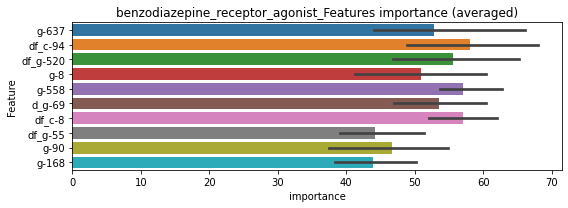

len(train_index) : 3865
len(valid_index) : 3865
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305568	valid_1's binary_logloss: 0.0664249
[200]	training's binary_logloss: 0.00609368	valid_1's binary_logloss: 0.0393567
[300]	training's binary_logloss: 0.00175881	valid_1's binary_logloss: 0.0340555
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00175881	valid_1's binary_logloss: 0.0340555


len(train_index) : 3865
len(valid_index) : 3865
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325278	valid_1's binary_logloss: 0.0609968
[200]	training's binary_logloss: 0.00708095	valid_1's binary_logloss: 0.029053
[300]	training's binary_logloss: 0.00207286	valid_1's binary_logloss: 0.0218692
[400]	training's binary_logloss: 0.000878456	valid_1's binary_logloss: 0.0196162
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00087279	valid_1's binary_logloss: 0.0196028


benzodiazepine_receptor_agonist logloss: 0.02682912483821828
beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328075	valid_1's binary_logloss: 0.0468245
[200]	training's binary_logloss: 0.00453204	valid_1's binary_logloss: 0.0108988
[300]	training's binary_logloss: 0.00123163	valid_1's binary_logloss: 0.00452674
[400]	training's binary_logloss: 0.000600126	valid_1's binary_logloss: 0.00278137
[500]	training's binary_logloss: 0.000425658	valid_1's binary_logloss: 0.002253
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000408578	valid_1's binary_logloss: 0.00222289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325125	valid_1's binary_logloss: 0.0445263
[200]	training's binary_logloss: 0.00455302	valid_1's binary_logloss: 0.00838419
[300]	training's binary_logloss: 0.00122662	valid_1's binary_logloss: 0.00285728
[400]	training's binary_logloss: 0.000602456	valid_1's binary_logloss: 0.00161086
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0023385, Threshold: 0.0040374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00363, conf_1:0.00444
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0040374
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0140374
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_3: 0.0240374
threshold: 0.0240374, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324744	valid_1's binary_logloss: 0.0476387
[200]	training's binary_logloss: 0.0043819	valid_1's binary_logloss: 0.0111613
[300]	training's binary_logloss: 0.00120012	valid_1's binary_logloss: 0.0048232
[400]	training's binary_logloss: 0.000598496	valid_1's binary_logloss: 0.00331953
[500]	training's binary_logloss: 0.00042619	valid_1's binary_logloss: 0.0028298
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000409195	valid_1's binary_logloss: 0.00276953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322628	valid_1's binary_logloss: 0.0440434
[200]	training's binary_logloss: 0.00445538	valid_1's binary_logloss: 0.0079879
[300]	training's binary_logloss: 0.00122192	valid_1's binary_logloss: 0.0026282
[400]	training's binary_logloss: 0.000611782	valid_1's binary_logloss: 0.00146939
[500]	training's binary_logloss: 0.00042

2 / 3 AUC score:1.000
y_Threshold: 0.0635951, Threshold: 0.0240374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00101, Num_p_label: 15.0, conf_0:0.02163, conf_1:0.02644
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.0240374
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0340374
threshold: 0.0340374, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324744	valid_1's binary_logloss: 0.0476387
[200]	training's binary_logloss: 0.0043819	valid_1's binary_logloss: 0.0111613
[300]	training's binary_logloss: 0.00120012	valid_1's binary_logloss: 0.0048232
[400]	training's binary_logloss: 0.000598496	valid_1's binary_logloss: 0.00331953
[500]	training's binary_logloss: 0.00042619	valid_1's binary_logloss: 0.0028298
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000409195	valid_1's binary_logloss: 0.00276953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322628	valid_1's binary_logloss: 0.0440434
[200]	training's binary_logloss: 0.00445538	valid_1's binary_logloss: 0.0079879
[300]	training's binary_logloss: 0.00122192	valid_1's binary_logloss: 0.0026282
[400]	training's binary_logloss: 0.000611782	valid_1's binary_logloss: 0.00146939
[500]	training's binary_logloss: 0.00042

3 / 3 AUC score:1.000
y_Threshold: 0.0635951, Threshold: 0.0340374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.03063, conf_1:0.03744
threshold: 0.0340374, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


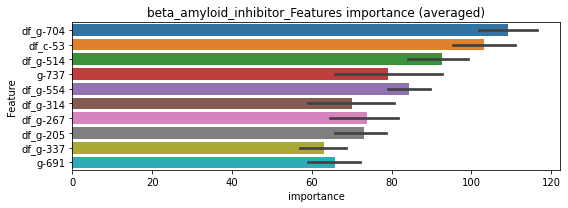

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179401	valid_1's binary_logloss: 0.029675
[200]	training's binary_logloss: 0.00248878	valid_1's binary_logloss: 0.0108066
[300]	training's binary_logloss: 0.000648522	valid_1's binary_logloss: 0.0082022
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00038793	valid_1's binary_logloss: 0.00799048


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183195	valid_1's binary_logloss: 0.0275491
[200]	training's binary_logloss: 0.00261481	valid_1's binary_logloss: 0.00778636
[300]	training's binary_logloss: 0.000696753	valid_1's binary_logloss: 0.00431587
[400]	training's binary_logloss: 0.000336047	valid_1's binary_logloss: 0.00354604
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000296338	valid_1's binary_logloss: 0.00346726


beta_amyloid_inhibitor logloss: 0.005728869360208844
bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371872	valid_1's binary_logloss: 0.0629756
[200]	training's binary_logloss: 0.00619809	valid_1's binary_logloss: 0.0238623
[300]	training's binary_logloss: 0.00204005	valid_1's binary_logloss: 0.0165494
[400]	training's binary_logloss: 0.00119642	valid_1's binary_logloss: 0.0140871
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00119642	valid_1's binary_logloss: 0.0140871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036275	valid_1's binary_logloss: 0.0691838
[200]	training's binary_logloss: 0.00605614	valid_1's binary_logloss: 0.0297263
[300]	training's binary_logloss: 0.00177188	valid_1's binary_logloss: 0.0214735
[400]	training's binary_logloss: 0.000858302	valid_1's binary_logloss: 0.0187507
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000836239	valid_1's binary_logloss: 0.0187037


1 / 3 AUC score:1.000
y_Threshold: 0.0056663, Threshold: 0.0098051, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00286, Num_p_label: 80.0, conf_0:0.00882, conf_1:0.01079
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0098051
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_2: 0.0198051
Num_p_label: 14.0, Expected: 11.4, Adj_threshold_3: 0.0298051
threshold: 0.0298051, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368307	valid_1's binary_logloss: 0.0584517
[200]	training's binary_logloss: 0.00610382	valid_1's binary_logloss: 0.0182606
[300]	training's binary_logloss: 0.00174622	valid_1's binary_logloss: 0.00864637
[400]	training's binary_logloss: 0.000854135	valid_1's binary_logloss: 0.00605052
[500]	training's binary_logloss: 0.000565886	valid_1's binary_logloss: 0.00531645
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000500627	valid_1's binary_logloss: 0.00491184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03627	valid_1's binary_logloss: 0.0670513
[200]	training's binary_logloss: 0.00577564	valid_1's binary_logloss: 0.0252778
[300]	training's binary_logloss: 0.00168684	valid_1's binary_logloss: 0.0165684
[400]	training's binary_logloss: 0.000817164	valid_1's binary_logloss: 0.0140446
Early stopping, best iteration is:
[470

2 / 3 AUC score:1.000
y_Threshold: 0.0395957, Threshold: 0.0298051, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3799
p_label_rate: 0.0077850 Vs.target_rate: 0.00286, Num_p_label: 31.0, conf_0:0.02682, conf_1:0.03279
threshold: 0.0298051, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368307	valid_1's binary_logloss: 0.0584517
[200]	training's binary_logloss: 0.00610382	valid_1's binary_logloss: 0.0182606
[300]	training's binary_logloss: 0.00174622	valid_1's binary_logloss: 0.00864637
[400]	training's binary_logloss: 0.000854135	valid_1's binary_logloss: 0.00605052
[500]	training's binary_logloss: 0.000565886	valid_1's binary_logloss: 0.00531645
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000500627	valid_1's binary_logloss: 0.00491184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03627	valid_1's binary_logloss: 0.0670513
[200]	training's binary_logloss: 0.00577564	valid_1's binary_logloss: 0.0252778
[300]	training's binary_logloss: 0.00168684	valid_1's binary_logloss: 0.0165684
[400]	training's binary_logloss: 0.000817164	valid_1's binary_logloss: 0.0140446
Early stopping, best iteration is:
[470

3 / 3 AUC score:1.000
y_Threshold: 0.0395957, Threshold: 0.0298051, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3799
p_label_rate: 0.0077850 Vs.target_rate: 0.00286, Num_p_label: 31.0, conf_0:0.02682, conf_1:0.03279
threshold: 0.0298051, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 686.0/7781, y_label_rate: 0.0881635


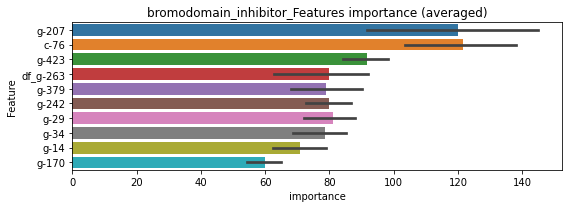

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203561	valid_1's binary_logloss: 0.0506415
[200]	training's binary_logloss: 0.00322919	valid_1's binary_logloss: 0.0316415
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00159875	valid_1's binary_logloss: 0.0292771


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212266	valid_1's binary_logloss: 0.0474775
[200]	training's binary_logloss: 0.00363621	valid_1's binary_logloss: 0.0252962
[300]	training's binary_logloss: 0.00106861	valid_1's binary_logloss: 0.0191479
[400]	training's binary_logloss: 0.000494991	valid_1's binary_logloss: 0.0175023
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000522858	valid_1's binary_logloss: 0.0174717


bromodomain_inhibitor logloss: 0.023375121186282665
btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295037	valid_1's binary_logloss: 0.053493
[200]	training's binary_logloss: 0.00391522	valid_1's binary_logloss: 0.0161792
[300]	training's binary_logloss: 0.00110607	valid_1's binary_logloss: 0.00878067
[400]	training's binary_logloss: 0.000558382	valid_1's binary_logloss: 0.00677874
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000434593	valid_1's binary_logloss: 0.00620187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286485	valid_1's binary_logloss: 0.0416309
[200]	training's binary_logloss: 0.00388622	valid_1's binary_logloss: 0.0107203
[300]	training's binary_logloss: 0.00112235	valid_1's binary_logloss: 0.00582763
[400]	training's binary_logloss: 0.000567035	valid_1's binary_logloss: 0.00443978
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000435494	valid_1's binary_logloss: 0.00420944


1 / 3 AUC score:1.000
y_Threshold: 0.0029395, Threshold: 0.0054350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.00489, conf_1:0.00598
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0054350
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_2: 0.0154350
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.0254350
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_4: 0.0354350
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_5: 0.0454350
threshold: 0.0454350, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02815	valid_1's binary_logloss: 0.0503642
[200]	training's binary_logloss: 0.00368272	valid_1's binary_logloss: 0.0165507
[300]	training's binary_logloss: 0.00105471	valid_1's binary_logloss: 0.00971872
[400]	training's binary_logloss: 0.000543263	valid_1's binary_logloss: 0.00783865
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000419598	valid_1's binary_logloss: 0.00733718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287284	valid_1's binary_logloss: 0.0415279
[200]	training's binary_logloss: 0.00386547	valid_1's binary_logloss: 0.00967429
[300]	training's binary_logloss: 0.00109638	valid_1's binary_logloss: 0.00508717
[400]	training's binary_logloss: 0.000560138	valid_1's binary_logloss: 0.00377728
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000502994	valid_1's binary_logloss: 0.00361077


2 / 3 AUC score:1.000
y_Threshold: 0.0442999, Threshold: 0.0454350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00122, Num_p_label: 15.0, conf_0:0.04089, conf_1:0.04998
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.0454350
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_2: 0.0554350
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_3: 0.0654350
threshold: 0.0654350, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02815	valid_1's binary_logloss: 0.0503642
[200]	training's binary_logloss: 0.00368272	valid_1's binary_logloss: 0.0165507
[300]	training's binary_logloss: 0.00105471	valid_1's binary_logloss: 0.00971872
[400]	training's binary_logloss: 0.000543263	valid_1's binary_logloss: 0.00783865
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000419598	valid_1's binary_logloss: 0.00733718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287284	valid_1's binary_logloss: 0.0415279
[200]	training's binary_logloss: 0.00386547	valid_1's binary_logloss: 0.00967429
[300]	training's binary_logloss: 0.00109638	valid_1's binary_logloss: 0.00508717
[400]	training's binary_logloss: 0.000560138	valid_1's binary_logloss: 0.00377728
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000502994	valid_1's binary_logloss: 0.00361077


3 / 3 AUC score:1.000
y_Threshold: 0.0442999, Threshold: 0.0654350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00122, Num_p_label: 9.0, conf_0:0.05889, conf_1:0.07198
threshold: 0.0654350, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


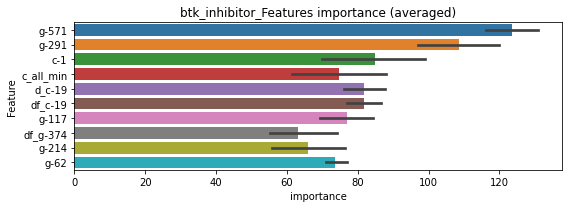

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153881	valid_1's binary_logloss: 0.0291535
[200]	training's binary_logloss: 0.00204553	valid_1's binary_logloss: 0.0113922
[300]	training's binary_logloss: 0.000576862	valid_1's binary_logloss: 0.00901209
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000443838	valid_1's binary_logloss: 0.00875487


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155254	valid_1's binary_logloss: 0.0241288
[200]	training's binary_logloss: 0.00209526	valid_1's binary_logloss: 0.00715039
[300]	training's binary_logloss: 0.00060065	valid_1's binary_logloss: 0.00446626
[400]	training's binary_logloss: 0.000301053	valid_1's binary_logloss: 0.00378316
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000215976	valid_1's binary_logloss: 0.00359284


btk_inhibitor logloss: 0.006173853718002048
calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184763	valid_1's binary_logloss: 0.023456
[200]	training's binary_logloss: 0.001885	valid_1's binary_logloss: 0.00382647
[300]	training's binary_logloss: 0.000535927	valid_1's binary_logloss: 0.00159423
[400]	training's binary_logloss: 0.000301381	valid_1's binary_logloss: 0.00112738
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000271945	valid_1's binary_logloss: 0.0010792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185581	valid_1's binary_logloss: 0.022248
[200]	training's binary_logloss: 0.00186605	valid_1's binary_logloss: 0.00306967
[300]	training's binary_logloss: 0.000525741	valid_1's binary_logloss: 0.00108378
[400]	training's binary_logloss: 0.000298899	valid_1's binary_logloss: 0.000699509
[500]	training's binary_logloss: 0.000262031	valid_1's binary_logloss: 0.000643852
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0009992, Threshold: 0.0017960, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00162, conf_1:0.00198
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017960
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0117960
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0217960
threshold: 0.0217960, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187005	valid_1's binary_logloss: 0.0226848
[200]	training's binary_logloss: 0.00182732	valid_1's binary_logloss: 0.00357332
[300]	training's binary_logloss: 0.000516352	valid_1's binary_logloss: 0.00133875
[400]	training's binary_logloss: 0.000295048	valid_1's binary_logloss: 0.000900617
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00025767	valid_1's binary_logloss: 0.000833102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187981	valid_1's binary_logloss: 0.0221255
[200]	training's binary_logloss: 0.00184556	valid_1's binary_logloss: 0.00285553
[300]	training's binary_logloss: 0.000516251	valid_1's binary_logloss: 0.000927939
[400]	training's binary_logloss: 0.000295969	valid_1's binary_logloss: 0.000582387
[500]	training's binary_logloss: 0.000253744	valid_1's binary_logloss: 0.000519354
Early stopping, best iterat

2 / 3 AUC score:1.000
y_Threshold: 0.1485008, Threshold: 0.0217960, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.01962, conf_1:0.02398
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.0217960
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0317960
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0417960
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0517960
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0617960
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0717960
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0817960
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0917960
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.1017960
threshold: 0.1017960, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187005	valid_1's binary_logloss: 0.0226848
[200]	training's binary_logloss: 0.00182732	valid_1's binary_logloss: 0.00357332
[300]	training's binary_logloss: 0.000516352	valid_1's binary_logloss: 0.00133875
[400]	training's binary_logloss: 0.000295048	valid_1's binary_logloss: 0.000900617
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00025767	valid_1's binary_logloss: 0.000833102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187981	valid_1's binary_logloss: 0.0221255
[200]	training's binary_logloss: 0.00184556	valid_1's binary_logloss: 0.00285553
[300]	training's binary_logloss: 0.000516251	valid_1's binary_logloss: 0.000927939
[400]	training's binary_logloss: 0.000295969	valid_1's binary_logloss: 0.000582387
[500]	training's binary_logloss: 0.000253744	valid_1's binary_logloss: 0.000519354
Early stopping, best iterat

3 / 3 AUC score:1.000
y_Threshold: 0.1485008, Threshold: 0.1017960, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.09162, conf_1:0.11198
threshold: 0.1017960, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


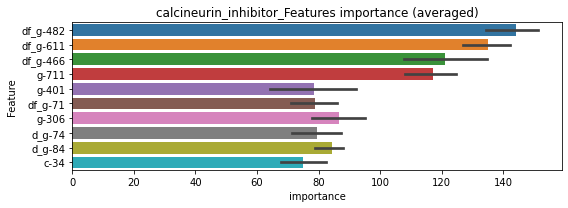

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00998158	valid_1's binary_logloss: 0.0139634
[200]	training's binary_logloss: 0.000967449	valid_1's binary_logloss: 0.00448522
[300]	training's binary_logloss: 0.000266853	valid_1's binary_logloss: 0.00355755
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000215937	valid_1's binary_logloss: 0.0035145


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100799	valid_1's binary_logloss: 0.0158225
[200]	training's binary_logloss: 0.000985959	valid_1's binary_logloss: 0.00539975
[300]	training's binary_logloss: 0.000270658	valid_1's binary_logloss: 0.00415382
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000211822	valid_1's binary_logloss: 0.00397403


calcineurin_inhibitor logloss: 0.0037442644421576163
calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1169	valid_1's binary_logloss: 0.301017
[200]	training's binary_logloss: 0.0427954	valid_1's binary_logloss: 0.26791
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0310522	valid_1's binary_logloss: 0.265631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119486	valid_1's binary_logloss: 0.304474
[200]	training's binary_logloss: 0.0462596	valid_1's binary_logloss: 0.263668


1 / 3 AUC score:0.902


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0381668	valid_1's binary_logloss: 0.260465


y_Threshold: 0.0975018, Threshold: 0.1318569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 429 → Positive_corect_labels: 499/3462
p_label_rate: 0.0200904 Vs.target_rate: 0.01180, Num_p_label: 80.0, conf_0:0.11867, conf_1:0.14504
threshold: 0.1318569, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 499.0/3462, y_label_rate: 0.1441363
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822953	valid_1's binary_logloss: 0.241371
[200]	training's binary_logloss: 0.0259228	valid_1's binary_logloss: 0.204293
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0105708	valid_1's binary_logloss: 0.194416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834308	valid_1's binary_logloss: 0.25116
[200]	training's binary_logloss: 0.0249654	valid_1's binary_logloss: 0.217689
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0178676	valid_1's binary_logloss: 0.21489


2 / 3 AUC score:0.951
y_Threshold: 0.0790569, Threshold: 0.1318569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 208 → Positive_corect_labels: 395.0/3254
p_label_rate: 0.0077850 Vs.target_rate: 0.01180, Num_p_label: 31.0, conf_0:0.11867, conf_1:0.14504
threshold: 0.1318569, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 395.0/3254, y_label_rate: 0.1213891
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607804	valid_1's binary_logloss: 0.19422
[200]	training's binary_logloss: 0.015777	valid_1's binary_logloss: 0.163917
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0108414	valid_1's binary_logloss: 0.160943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701059	valid_1's binary_logloss: 0.183713
[200]	training's binary_logloss: 0.0191786	valid_1's binary_logloss: 0.148849


3 / 3 AUC score:0.981
y_Threshold: 0.0662891, Threshold: 0.1318569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 114 → Positive_corect_labels: 338.0/3140
p_label_rate: 0.0045203 Vs.target_rate: 0.01180, Num_p_label: 18.0, conf_0:0.11867, conf_1:0.14504


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0126044	valid_1's binary_logloss: 0.144017


threshold: 0.1318569, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 356.0/7122, y_label_rate: 0.0499860


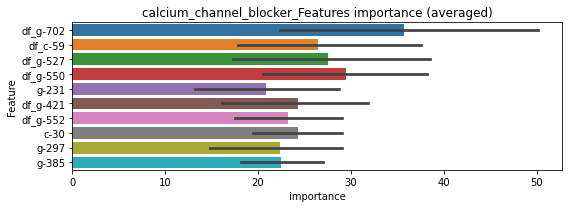

len(train_index) : 3561
len(valid_index) : 3561
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028365	valid_1's binary_logloss: 0.104566
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0136391	valid_1's binary_logloss: 0.0989855


len(train_index) : 3561
len(valid_index) : 3561
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264533	valid_1's binary_logloss: 0.10311


calcium_channel_blocker logloss: 0.09879363883307914


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0136134	valid_1's binary_logloss: 0.0986018


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444851	valid_1's binary_logloss: 0.0771327
[200]	training's binary_logloss: 0.0077287	valid_1's binary_logloss: 0.0272219
[300]	training's binary_logloss: 0.00208927	valid_1's binary_logloss: 0.0148331
[400]	training's binary_logloss: 0.00097917	valid_1's binary_logloss: 0.0116989
[500]	training's binary_logloss: 0.0006204	valid_1's binary_logloss: 0.0103696
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000641349	valid_1's binary_logloss: 0.0103537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047357	valid_1's binary_logloss: 0.0776
[200]	training's binary_logloss: 0.00870112	valid_1's binary_logloss: 0.0266741
[300]	training's binary_logloss: 0.00234222	valid_1's binary_logloss: 0.0135933
[400]	training's binary_logloss: 0.00105789	valid_1's binary_logloss: 0.0097438
[500]	training's binary_logloss: 0.000666407	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0050904, Threshold: 0.0079177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00713, conf_1:0.00871
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0079177
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.0179177
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0279177
threshold: 0.0279177, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438159	valid_1's binary_logloss: 0.0752142
[200]	training's binary_logloss: 0.00746519	valid_1's binary_logloss: 0.0255527
[300]	training's binary_logloss: 0.00204694	valid_1's binary_logloss: 0.0139257
[400]	training's binary_logloss: 0.000966375	valid_1's binary_logloss: 0.0111402
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000739304	valid_1's binary_logloss: 0.0102919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467976	valid_1's binary_logloss: 0.075404
[200]	training's binary_logloss: 0.00813121	valid_1's binary_logloss: 0.0234675
[300]	training's binary_logloss: 0.00227023	valid_1's binary_logloss: 0.0117114
[400]	training's binary_logloss: 0.00103969	valid_1's binary_logloss: 0.00801445
[500]	training's binary_logloss: 0.000653785	valid_1's binary_logloss: 0.0066512
Early stopping, best iteration is:
[542]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0392891, Threshold: 0.0279177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0065294 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.02513, conf_1:0.03071
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.0279177
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_2: 0.0379177
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_3: 0.0479177
threshold: 0.0479177, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438159	valid_1's binary_logloss: 0.0752142
[200]	training's binary_logloss: 0.00746519	valid_1's binary_logloss: 0.0255527
[300]	training's binary_logloss: 0.00204694	valid_1's binary_logloss: 0.0139257
[400]	training's binary_logloss: 0.000966375	valid_1's binary_logloss: 0.0111402
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000739304	valid_1's binary_logloss: 0.0102919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467976	valid_1's binary_logloss: 0.075404
[200]	training's binary_logloss: 0.00813121	valid_1's binary_logloss: 0.0234675
[300]	training's binary_logloss: 0.00227023	valid_1's binary_logloss: 0.0117114
[400]	training's binary_logloss: 0.00103969	valid_1's binary_logloss: 0.00801445
[500]	training's binary_logloss: 0.000653785	valid_1's binary_logloss: 0.0066512
Early stopping, best iteration is:
[542]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0392891, Threshold: 0.0479177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00176, Num_p_label: 8.0, conf_0:0.04313, conf_1:0.05271
threshold: 0.0479177, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7788, y_label_rate: 0.0852594


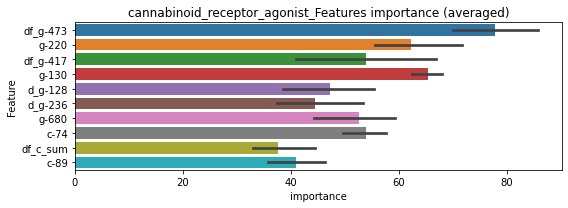

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246204	valid_1's binary_logloss: 0.0448013
[200]	training's binary_logloss: 0.004172	valid_1's binary_logloss: 0.0188375
[300]	training's binary_logloss: 0.0011272	valid_1's binary_logloss: 0.0139704
[400]	training's binary_logloss: 0.000511204	valid_1's binary_logloss: 0.0130686
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000540603	valid_1's binary_logloss: 0.0130401


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258001	valid_1's binary_logloss: 0.041851
[200]	training's binary_logloss: 0.00445543	valid_1's binary_logloss: 0.0140754
[300]	training's binary_logloss: 0.00119247	valid_1's binary_logloss: 0.00828729
[400]	training's binary_logloss: 0.00053936	valid_1's binary_logloss: 0.00689053
[500]	training's binary_logloss: 0.00033834	valid_1's binary_logloss: 0.00630732
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00031272	valid_1's binary_logloss: 0.0061467


cannabinoid_receptor_agonist logloss: 0.009593392870391293
cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468444	valid_1's binary_logloss: 0.0826564
[200]	training's binary_logloss: 0.00871489	valid_1's binary_logloss: 0.0331816
[300]	training's binary_logloss: 0.00251151	valid_1's binary_logloss: 0.0214891
[400]	training's binary_logloss: 0.00121926	valid_1's binary_logloss: 0.017684
[500]	training's binary_logloss: 0.000772558	valid_1's binary_logloss: 0.0159989
[600]	training's binary_logloss: 0.000564589	valid_1's binary_logloss: 0.0146735
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000565767	valid_1's binary_logloss: 0.0146627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529738	valid_1's binary_logloss: 0.0982834
[200]	training's binary_logloss: 0.0101703	valid_1's binary_logloss: 0.0432605
[300]	training's binary_logloss: 0.00287272	valid_1's binary_logloss: 0.0285674
[400]	training's binary_logloss: 0.00130483	

1 / 3 AUC score:1.000
y_Threshold: 0.0060262, Threshold: 0.0095520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.00860, conf_1:0.01051
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0095520
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_2: 0.0195520
Num_p_label: 6.0, Expected: 9.2, Adj_threshold_3: 0.0295520
threshold: 0.0295520, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487746	valid_1's binary_logloss: 0.0888145
[200]	training's binary_logloss: 0.00937017	valid_1's binary_logloss: 0.0361508
[300]	training's binary_logloss: 0.00264304	valid_1's binary_logloss: 0.0225956
[400]	training's binary_logloss: 0.00122331	valid_1's binary_logloss: 0.0185494
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000911584	valid_1's binary_logloss: 0.0171587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510192	valid_1's binary_logloss: 0.106658
[200]	training's binary_logloss: 0.0093237	valid_1's binary_logloss: 0.0516131
[300]	training's binary_logloss: 0.00261942	valid_1's binary_logloss: 0.040444
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00131327	valid_1's binary_logloss: 0.0359188


2 / 3 AUC score:1.000
y_Threshold: 0.0314916, Threshold: 0.0295520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0070316 Vs.target_rate: 0.00231, Num_p_label: 28.0, conf_0:0.02660, conf_1:0.03251
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.0295520
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_2: 0.0395520
threshold: 0.0395520, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455317	valid_1's binary_logloss: 0.0918527
[200]	training's binary_logloss: 0.007978	valid_1's binary_logloss: 0.0429485
[300]	training's binary_logloss: 0.00237851	valid_1's binary_logloss: 0.0312311
[400]	training's binary_logloss: 0.00113117	valid_1's binary_logloss: 0.0281237
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000804439	valid_1's binary_logloss: 0.0267218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529123	valid_1's binary_logloss: 0.0848573
[200]	training's binary_logloss: 0.00986629	valid_1's binary_logloss: 0.0287555
[300]	training's binary_logloss: 0.00278167	valid_1's binary_logloss: 0.0156998
[400]	training's binary_logloss: 0.0012861	valid_1's binary_logloss: 0.0121826
[500]	training's binary_logloss: 0.000789851	valid_1's binary_logloss: 0.0108426
Early stopping, best iteration is:
[573]	train

3 / 3 AUC score:1.000
y_Threshold: 0.0238184, Threshold: 0.0395520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0022602 Vs.target_rate: 0.00231, Num_p_label: 9.0, conf_0:0.03560, conf_1:0.04351
threshold: 0.0395520, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/7766, y_label_rate: 0.0843420


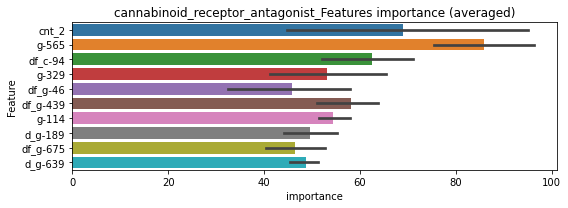

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266066	valid_1's binary_logloss: 0.0536345
[200]	training's binary_logloss: 0.005028	valid_1's binary_logloss: 0.0267434
[300]	training's binary_logloss: 0.00137681	valid_1's binary_logloss: 0.0213202
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00083336	valid_1's binary_logloss: 0.0202305


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267091	valid_1's binary_logloss: 0.0573357
[200]	training's binary_logloss: 0.00512613	valid_1's binary_logloss: 0.0320418
[300]	training's binary_logloss: 0.00143849	valid_1's binary_logloss: 0.0250879
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00130469	valid_1's binary_logloss: 0.0248158


cannabinoid_receptor_antagonist logloss: 0.0225231415283661
carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404219	valid_1's binary_logloss: 0.0599871
[200]	training's binary_logloss: 0.00655059	valid_1's binary_logloss: 0.0168826
[300]	training's binary_logloss: 0.00181523	valid_1's binary_logloss: 0.00784996
[400]	training's binary_logloss: 0.000864632	valid_1's binary_logloss: 0.00520086
[500]	training's binary_logloss: 0.000564076	valid_1's binary_logloss: 0.00433444
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000486065	valid_1's binary_logloss: 0.0040297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411356	valid_1's binary_logloss: 0.0701567
[200]	training's binary_logloss: 0.00675172	valid_1's binary_logloss: 0.0247371
[300]	training's binary_logloss: 0.00188181	valid_1's binary_logloss: 0.013864
[400]	training's binary_logloss: 0.000882383	valid_1's binary_logloss: 0.0111314
Early stopping, best iteration is:
[441

1 / 3 AUC score:1.000
y_Threshold: 0.0041332, Threshold: 0.0051250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00461, conf_1:0.00564
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0051250
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_2: 0.0151250
threshold: 0.0151250, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402565	valid_1's binary_logloss: 0.0621316
[200]	training's binary_logloss: 0.00624646	valid_1's binary_logloss: 0.0172543
[300]	training's binary_logloss: 0.00175848	valid_1's binary_logloss: 0.00793724
[400]	training's binary_logloss: 0.000848785	valid_1's binary_logloss: 0.0054855
[500]	training's binary_logloss: 0.000558343	valid_1's binary_logloss: 0.00446571
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000483996	valid_1's binary_logloss: 0.00417976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399086	valid_1's binary_logloss: 0.0688766
[200]	training's binary_logloss: 0.00652572	valid_1's binary_logloss: 0.0254874
[300]	training's binary_logloss: 0.00185823	valid_1's binary_logloss: 0.0164895
[400]	training's binary_logloss: 0.00088052	valid_1's binary_logloss: 0.0141768
Early stopping, best iteration is:
[403

2 / 3 AUC score:1.000
y_Threshold: 0.0217227, Threshold: 0.0151250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.01361, conf_1:0.01664
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.0151250
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0251250
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0351250
threshold: 0.0351250, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394579	valid_1's binary_logloss: 0.0570309
[200]	training's binary_logloss: 0.00646122	valid_1's binary_logloss: 0.0143914
[300]	training's binary_logloss: 0.00181089	valid_1's binary_logloss: 0.00616417
[400]	training's binary_logloss: 0.000870133	valid_1's binary_logloss: 0.00393606
[500]	training's binary_logloss: 0.000563108	valid_1's binary_logloss: 0.00305116
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00047964	valid_1's binary_logloss: 0.00279984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413389	valid_1's binary_logloss: 0.0622748
[200]	training's binary_logloss: 0.00680474	valid_1's binary_logloss: 0.0180733
[300]	training's binary_logloss: 0.00187148	valid_1's binary_logloss: 0.00830094
[400]	training's binary_logloss: 0.000877597	valid_1's binary_logloss: 0.00541913
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1069413, Threshold: 0.0351250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0010045 Vs.target_rate: 0.00151, Num_p_label: 4.0, conf_0:0.03161, conf_1:0.03864
threshold: 0.0351250, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7787, y_label_rate: 0.0846282


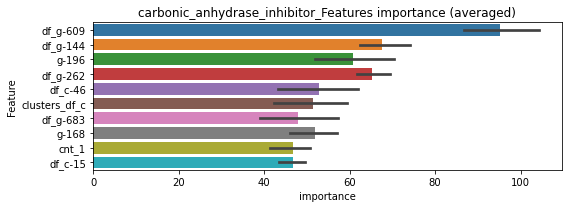

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222166	valid_1's binary_logloss: 0.03641
[200]	training's binary_logloss: 0.00346665	valid_1's binary_logloss: 0.013086
[300]	training's binary_logloss: 0.000923349	valid_1's binary_logloss: 0.00838848
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000458061	valid_1's binary_logloss: 0.00728484


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210654	valid_1's binary_logloss: 0.0351544
[200]	training's binary_logloss: 0.0034223	valid_1's binary_logloss: 0.0117054
[300]	training's binary_logloss: 0.000937506	valid_1's binary_logloss: 0.00630652
[400]	training's binary_logloss: 0.000440043	valid_1's binary_logloss: 0.00499264
[500]	training's binary_logloss: 0.000285619	valid_1's binary_logloss: 0.00441509
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000262228	valid_1's binary_logloss: 0.00436083


carbonic_anhydrase_inhibitor logloss: 0.005823021442352417
casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340849	valid_1's binary_logloss: 0.0527871
[200]	training's binary_logloss: 0.00537612	valid_1's binary_logloss: 0.0140782
[300]	training's binary_logloss: 0.00151954	valid_1's binary_logloss: 0.00611025
[400]	training's binary_logloss: 0.000747037	valid_1's binary_logloss: 0.00407795
[500]	training's binary_logloss: 0.000503944	valid_1's binary_logloss: 0.00326547
[600]	training's binary_logloss: 0.000443011	valid_1's binary_logloss: 0.003062
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000444099	valid_1's binary_logloss: 0.00305839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343968	valid_1's binary_logloss: 0.0533428
[200]	training's binary_logloss: 0.00537699	valid_1's binary_logloss: 0.0136183
[300]	training's binary_logloss: 0.0015355	valid_1's binary_logloss: 0.00599526
[400]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0030978, Threshold: 0.0050929, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00458, conf_1:0.00560
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0050929
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0150929
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_3: 0.0250929
threshold: 0.0250929, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346544	valid_1's binary_logloss: 0.0518239
[200]	training's binary_logloss: 0.00516906	valid_1's binary_logloss: 0.012586
[300]	training's binary_logloss: 0.00148238	valid_1's binary_logloss: 0.00565865
[400]	training's binary_logloss: 0.000737844	valid_1's binary_logloss: 0.00395846
[500]	training's binary_logloss: 0.000497463	valid_1's binary_logloss: 0.00323172
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000463516	valid_1's binary_logloss: 0.0031015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034299	valid_1's binary_logloss: 0.0534946
[200]	training's binary_logloss: 0.00514111	valid_1's binary_logloss: 0.0138631
[300]	training's binary_logloss: 0.00147626	valid_1's binary_logloss: 0.00636874
[400]	training's binary_logloss: 0.000746192	valid_1's binary_logloss: 0.00423109
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0539555, Threshold: 0.0250929, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.02258, conf_1:0.02760
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0250929
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0350929
threshold: 0.0350929, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346544	valid_1's binary_logloss: 0.0518239
[200]	training's binary_logloss: 0.00516906	valid_1's binary_logloss: 0.012586
[300]	training's binary_logloss: 0.00148238	valid_1's binary_logloss: 0.00565865
[400]	training's binary_logloss: 0.000737844	valid_1's binary_logloss: 0.00395846
[500]	training's binary_logloss: 0.000497463	valid_1's binary_logloss: 0.00323172
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000463516	valid_1's binary_logloss: 0.0031015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034299	valid_1's binary_logloss: 0.0534946
[200]	training's binary_logloss: 0.00514111	valid_1's binary_logloss: 0.0138631
[300]	training's binary_logloss: 0.00147626	valid_1's binary_logloss: 0.00636874
[400]	training's binary_logloss: 0.000746192	valid_1's binary_logloss: 0.00423109
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0539555, Threshold: 0.0350929, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.03158, conf_1:0.03860
threshold: 0.0350929, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


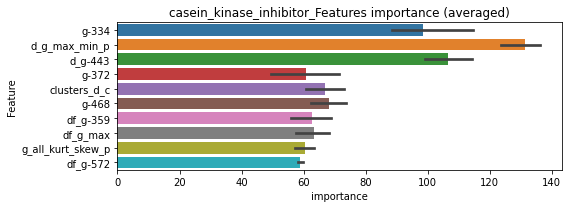

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174297	valid_1's binary_logloss: 0.0324899
[200]	training's binary_logloss: 0.00261508	valid_1's binary_logloss: 0.0135245
[300]	training's binary_logloss: 0.000754869	valid_1's binary_logloss: 0.010823
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000818638	valid_1's binary_logloss: 0.0108037


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186189	valid_1's binary_logloss: 0.0360599
[200]	training's binary_logloss: 0.00284916	valid_1's binary_logloss: 0.0139011
[300]	training's binary_logloss: 0.000800847	valid_1's binary_logloss: 0.00887954
[400]	training's binary_logloss: 0.000395611	valid_1's binary_logloss: 0.00765758
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000314447	valid_1's binary_logloss: 0.00738737


casein_kinase_inhibitor logloss: 0.009095760580326379
caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247848	valid_1's binary_logloss: 0.0324307
[200]	training's binary_logloss: 0.00297961	valid_1's binary_logloss: 0.00669832
[300]	training's binary_logloss: 0.000836855	valid_1's binary_logloss: 0.00317182
[400]	training's binary_logloss: 0.000437757	valid_1's binary_logloss: 0.00229565
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000356831	valid_1's binary_logloss: 0.00210479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249301	valid_1's binary_logloss: 0.0342506
[200]	training's binary_logloss: 0.00295382	valid_1's binary_logloss: 0.00568542
[300]	training's binary_logloss: 0.000820859	valid_1's binary_logloss: 0.00211744
[400]	training's binary_logloss: 0.000432776	valid_1's binary_logloss: 0.0013079
[500]	training's binary_logloss: 0.00033505	valid_1's binary_logloss: 0.0011015
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0017152, Threshold: 0.0024152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00217, conf_1:0.00266
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024152
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0124152
threshold: 0.0124152, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243651	valid_1's binary_logloss: 0.0325171
[200]	training's binary_logloss: 0.00287529	valid_1's binary_logloss: 0.00734823
[300]	training's binary_logloss: 0.000804759	valid_1's binary_logloss: 0.00379255
[400]	training's binary_logloss: 0.000427293	valid_1's binary_logloss: 0.00287274
[500]	training's binary_logloss: 0.00034092	valid_1's binary_logloss: 0.00269113
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000339345	valid_1's binary_logloss: 0.00268349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249984	valid_1's binary_logloss: 0.0359407
[200]	training's binary_logloss: 0.0029549	valid_1's binary_logloss: 0.00805221
[300]	training's binary_logloss: 0.000839804	valid_1's binary_logloss: 0.00381855
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000539587	valid_1's binary_logloss: 0.0026378

2 / 3 AUC score:1.000
y_Threshold: 0.0185503, Threshold: 0.0124152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.01117, conf_1:0.01366
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0124152
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0224152
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.0324152
threshold: 0.0324152, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243651	valid_1's binary_logloss: 0.0325171
[200]	training's binary_logloss: 0.00287529	valid_1's binary_logloss: 0.00734823
[300]	training's binary_logloss: 0.000804759	valid_1's binary_logloss: 0.00379255
[400]	training's binary_logloss: 0.000427293	valid_1's binary_logloss: 0.00287274
[500]	training's binary_logloss: 0.00034092	valid_1's binary_logloss: 0.00269113
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000339345	valid_1's binary_logloss: 0.00268349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249984	valid_1's binary_logloss: 0.0359407
[200]	training's binary_logloss: 0.0029549	valid_1's binary_logloss: 0.00805221
[300]	training's binary_logloss: 0.000839804	valid_1's binary_logloss: 0.00381855


3 / 3 AUC score:1.000
y_Threshold: 0.0185503, Threshold: 0.0324152, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000539587	valid_1's binary_logloss: 0.00263782


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.02917, conf_1:0.03566
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.0324152
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0224152
threshold: 0.0224152, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7794, y_label_rate: 0.0851937


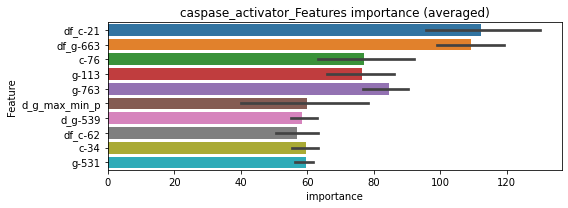

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134412	valid_1's binary_logloss: 0.0223091
[200]	training's binary_logloss: 0.00157664	valid_1's binary_logloss: 0.00952272
[300]	training's binary_logloss: 0.000425192	valid_1's binary_logloss: 0.00841865
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000405471	valid_1's binary_logloss: 0.0084058


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141887	valid_1's binary_logloss: 0.0198576
[200]	training's binary_logloss: 0.00172707	valid_1's binary_logloss: 0.00531487
[300]	training's binary_logloss: 0.000467188	valid_1's binary_logloss: 0.00391869
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000282963	valid_1's binary_logloss: 0.00372412


caspase_activator logloss: 0.006064956024468205
catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238519	valid_1's binary_logloss: 0.0318148
[200]	training's binary_logloss: 0.00284318	valid_1's binary_logloss: 0.00578023
[300]	training's binary_logloss: 0.000821208	valid_1's binary_logloss: 0.0023382
[400]	training's binary_logloss: 0.000435083	valid_1's binary_logloss: 0.00150606
[500]	training's binary_logloss: 0.00035125	valid_1's binary_logloss: 0.00132359
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00034885	valid_1's binary_logloss: 0.00132035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243635	valid_1's binary_logloss: 0.0342761
[200]	training's binary_logloss: 0.0028732	valid_1's binary_logloss: 0.00692906
[300]	training's binary_logloss: 0.000816122	valid_1's binary_logloss: 0.00338467
[400]	training's binary_logloss: 0.000434099	valid_1's binary_logloss: 0.00248544
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014758, Threshold: 0.0021000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00189, conf_1:0.00231
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021000
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0121000
threshold: 0.0121000, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240291	valid_1's binary_logloss: 0.0324116
[200]	training's binary_logloss: 0.00286478	valid_1's binary_logloss: 0.00529072
[300]	training's binary_logloss: 0.0008104	valid_1's binary_logloss: 0.0020281
[400]	training's binary_logloss: 0.000430265	valid_1's binary_logloss: 0.00130732
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000348707	valid_1's binary_logloss: 0.00114238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244782	valid_1's binary_logloss: 0.0327836
[200]	training's binary_logloss: 0.0028111	valid_1's binary_logloss: 0.00639286
[300]	training's binary_logloss: 0.000807076	valid_1's binary_logloss: 0.0030978
[400]	training's binary_logloss: 0.000433685	valid_1's binary_logloss: 0.00241444
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000366517	valid_1's binary_logloss: 0.00226453


2 / 3 AUC score:1.000
y_Threshold: 0.0308955, Threshold: 0.0121000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.01089, conf_1:0.01331
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0121000
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0221000
threshold: 0.0221000, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240291	valid_1's binary_logloss: 0.0324116
[200]	training's binary_logloss: 0.00286478	valid_1's binary_logloss: 0.00529072
[300]	training's binary_logloss: 0.0008104	valid_1's binary_logloss: 0.0020281
[400]	training's binary_logloss: 0.000430265	valid_1's binary_logloss: 0.00130732
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000348707	valid_1's binary_logloss: 0.00114238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244782	valid_1's binary_logloss: 0.0327836
[200]	training's binary_logloss: 0.0028111	valid_1's binary_logloss: 0.00639286
[300]	training's binary_logloss: 0.000807076	valid_1's binary_logloss: 0.0030978
[400]	training's binary_logloss: 0.000433685	valid_1's binary_logloss: 0.00241444
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000366517	valid_1's binary_logloss: 0.00226453


3 / 3 AUC score:1.000
y_Threshold: 0.0308955, Threshold: 0.0221000, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.01989, conf_1:0.02431
threshold: 0.0221000, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


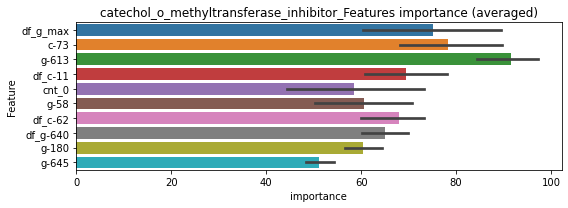

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124792	valid_1's binary_logloss: 0.0211753
[200]	training's binary_logloss: 0.00146522	valid_1's binary_logloss: 0.00885873
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000498145	valid_1's binary_logloss: 0.0081398


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131736	valid_1's binary_logloss: 0.0201815
[200]	training's binary_logloss: 0.00163467	valid_1's binary_logloss: 0.00531444
[300]	training's binary_logloss: 0.000438379	valid_1's binary_logloss: 0.00305077
[400]	training's binary_logloss: 0.000223023	valid_1's binary_logloss: 0.00263346
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000228673	valid_1's binary_logloss: 0.00262731


catechol_o_methyltransferase_inhibitor logloss: 0.005383906771558457
cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732741	valid_1's binary_logloss: 0.159436
[200]	training's binary_logloss: 0.019158	valid_1's binary_logloss: 0.10386
[300]	training's binary_logloss: 0.00575378	valid_1's binary_logloss: 0.0844113
[400]	training's binary_logloss: 0.00243461	valid_1's binary_logloss: 0.0765958
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00172726	valid_1's binary_logloss: 0.0750971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707682	valid_1's binary_logloss: 0.142325
[200]	training's binary_logloss: 0.0189528	valid_1's binary_logloss: 0.0864502
[300]	training's binary_logloss: 0.00598408	valid_1's binary_logloss: 0.0704261
[400]	training's binary_logloss: 0.00258815	valid_1's binary_logloss: 0.0646471
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00249782	valid_1's binary_logloss: 0.0643185


1 / 3 AUC score:0.995
y_Threshold: 0.0189656, Threshold: 0.0285013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 645/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00428, Num_p_label: 80.0, conf_0:0.02565, conf_1:0.03135
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0285013
Num_p_label: 50.0, Expected: 17.1, Adj_threshold_2: 0.0385013
Num_p_label: 25.0, Expected: 17.1, Adj_threshold_3: 0.0485013
threshold: 0.0485013, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 645.0/3776, y_label_rate: 0.1708157
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693859	valid_1's binary_logloss: 0.156082
[200]	training's binary_logloss: 0.0160009	valid_1's binary_logloss: 0.0944931
[300]	training's binary_logloss: 0.00498901	valid_1's binary_logloss: 0.079268
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00241722	valid_1's binary_logloss: 0.0739778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718722	valid_1's binary_logloss: 0.138492
[200]	training's binary_logloss: 0.0184576	valid_1's binary_logloss: 0.0750233
[300]	training's binary_logloss: 0.00580222	valid_1's binary_logloss: 0.054883
[400]	training's binary_logloss: 0.00247432	valid_1's binary_logloss: 0.0488597
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00237981	valid_1's binary_logloss: 0.0487783


2 / 3 AUC score:0.996
y_Threshold: 0.0453599, Threshold: 0.0485013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 630.0/3746
p_label_rate: 0.0165746 Vs.target_rate: 0.00428, Num_p_label: 66.0, conf_0:0.04365, conf_1:0.05335
Num_p_label: 66.0, Expected: 17.1, Adj_threshold_1: 0.0485013
Num_p_label: 53.0, Expected: 17.1, Adj_threshold_2: 0.0585013
Num_p_label: 36.0, Expected: 17.1, Adj_threshold_3: 0.0685013
Num_p_label: 29.0, Expected: 17.1, Adj_threshold_4: 0.0785013
threshold: 0.0785013, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661392	valid_1's binary_logloss: 0.130883
[200]	training's binary_logloss: 0.0154121	valid_1's binary_logloss: 0.0707874
[300]	training's binary_logloss: 0.00480785	valid_1's binary_logloss: 0.0537983
[400]	training's binary_logloss: 0.00214279	valid_1's binary_logloss: 0.047554
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00152879	valid_1's binary_logloss: 0.0457494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663383	valid_1's binary_logloss: 0.138404
[200]	training's binary_logloss: 0.0165642	valid_1's binary_logloss: 0.0806194
[300]	training's binary_logloss: 0.00508752	valid_1's binary_logloss: 0.0610921
[400]	training's binary_logloss: 0.00220629	valid_1's binary_logloss: 0.0543123
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00234128	valid_1's binary_logloss: 0.0541396


3 / 3 AUC score:0.998
y_Threshold: 0.0496988, Threshold: 0.0785013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 619.0/3724
p_label_rate: 0.0067805 Vs.target_rate: 0.00428, Num_p_label: 27.0, conf_0:0.07065, conf_1:0.08635
threshold: 0.0785013, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 646.0/7706, y_label_rate: 0.0838308


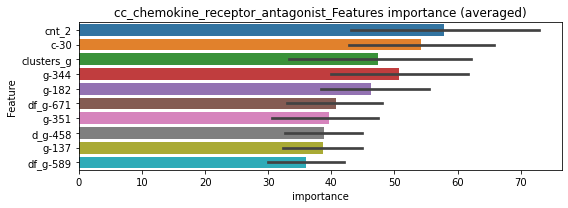

len(train_index) : 3853
len(valid_index) : 3853
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377442	valid_1's binary_logloss: 0.0853308
[200]	training's binary_logloss: 0.00872418	valid_1's binary_logloss: 0.0574578
[300]	training's binary_logloss: 0.00264641	valid_1's binary_logloss: 0.0497978
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00235553	valid_1's binary_logloss: 0.0495949


len(train_index) : 3853
len(valid_index) : 3853
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403175	valid_1's binary_logloss: 0.083433
[200]	training's binary_logloss: 0.00989754	valid_1's binary_logloss: 0.0492843
[300]	training's binary_logloss: 0.00305297	valid_1's binary_logloss: 0.0387103
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00157304	valid_1's binary_logloss: 0.0360336


cc_chemokine_receptor_antagonist logloss: 0.04281428929399996
cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231539	valid_1's binary_logloss: 0.0328609
[200]	training's binary_logloss: 0.00275915	valid_1's binary_logloss: 0.00788111
[300]	training's binary_logloss: 0.000792994	valid_1's binary_logloss: 0.00394731
[400]	training's binary_logloss: 0.000429284	valid_1's binary_logloss: 0.00289749
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00034617	valid_1's binary_logloss: 0.00261029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243529	valid_1's binary_logloss: 0.0292457
[200]	training's binary_logloss: 0.00298338	valid_1's binary_logloss: 0.00473743
[300]	training's binary_logloss: 0.00082791	valid_1's binary_logloss: 0.00155965
[400]	training's binary_logloss: 0.000437554	valid_1's binary_logloss: 0.000897527
[500]	training's binary_logloss: 0.000346176	valid_1's binary_logloss: 0.000734092
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0020526, Threshold: 0.0032818, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00295, conf_1:0.00361
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0032818
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0132818
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0232818
threshold: 0.0232818, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227406	valid_1's binary_logloss: 0.0306192
[200]	training's binary_logloss: 0.00263904	valid_1's binary_logloss: 0.00706872
[300]	training's binary_logloss: 0.000768722	valid_1's binary_logloss: 0.0040174
[400]	training's binary_logloss: 0.00042298	valid_1's binary_logloss: 0.00331891
[500]	training's binary_logloss: 0.000338671	valid_1's binary_logloss: 0.00309095
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000338913	valid_1's binary_logloss: 0.00309026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234604	valid_1's binary_logloss: 0.0283252
[200]	training's binary_logloss: 0.0027847	valid_1's binary_logloss: 0.00436764
[300]	training's binary_logloss: 0.000800559	valid_1's binary_logloss: 0.00149826
[400]	training's binary_logloss: 0.000427507	valid_1's binary_logloss: 0.000885928
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0513249, Threshold: 0.0232818, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0070316 Vs.target_rate: 0.00076, Num_p_label: 28.0, conf_0:0.02095, conf_1:0.02561
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.0232818
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.0332818
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0432818
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0532818
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0632818
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.0732818
threshold: 0.0732818, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232783	valid_1's binary_logloss: 0.0277778
[200]	training's binary_logloss: 0.00273785	valid_1's binary_logloss: 0.00432982
[300]	training's binary_logloss: 0.000790255	valid_1's binary_logloss: 0.00149355
[400]	training's binary_logloss: 0.000429013	valid_1's binary_logloss: 0.000872174
[500]	training's binary_logloss: 0.000344284	valid_1's binary_logloss: 0.000728874
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000337758	valid_1's binary_logloss: 0.000716885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229752	valid_1's binary_logloss: 0.0286123
[200]	training's binary_logloss: 0.00266361	valid_1's binary_logloss: 0.00550054
[300]	training's binary_logloss: 0.000764582	valid_1's binary_logloss: 0.0022438
[400]	training's binary_logloss: 0.000420186	valid_1's binary_logloss: 0.00158059
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1111085, Threshold: 0.0732818, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.06595, conf_1:0.08061
threshold: 0.0732818, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 660.0/7791, y_label_rate: 0.0847131


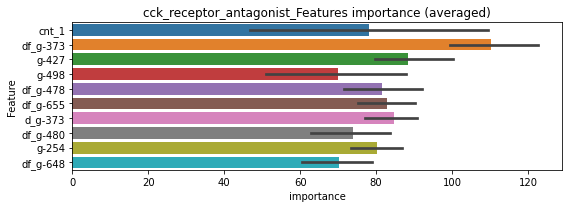

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012751	valid_1's binary_logloss: 0.016875
[200]	training's binary_logloss: 0.00148963	valid_1's binary_logloss: 0.00456895
[300]	training's binary_logloss: 0.000413742	valid_1's binary_logloss: 0.00336386
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000351173	valid_1's binary_logloss: 0.00334447


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129224	valid_1's binary_logloss: 0.016798
[200]	training's binary_logloss: 0.00154905	valid_1's binary_logloss: 0.00369319
[300]	training's binary_logloss: 0.000429808	valid_1's binary_logloss: 0.00212955
[400]	training's binary_logloss: 0.000224329	valid_1's binary_logloss: 0.00188305
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000184802	valid_1's binary_logloss: 0.00181142


cck_receptor_antagonist logloss: 0.0025780407090506205
cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461408	valid_1's binary_logloss: 0.12328
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0139205	valid_1's binary_logloss: 0.11241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445728	valid_1's binary_logloss: 0.115753
[200]	training's binary_logloss: 0.0087143	valid_1's binary_logloss: 0.097347


1 / 3 AUC score:0.976
y_Threshold: 0.0448767, Threshold: 0.4002519, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00794303	valid_1's binary_logloss: 0.0971177


Remove_noisy_labels: 223 → Positive_corect_labels: 606/3692
p_label_rate: 0.0200904 Vs.target_rate: 0.01478, Num_p_label: 80.0, conf_0:0.36023, conf_1:0.44028
threshold: 0.4002519, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 606.0/3692, y_label_rate: 0.1641387
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345783	valid_1's binary_logloss: 0.0811238
[200]	training's binary_logloss: 0.00556702	valid_1's binary_logloss: 0.0636633
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00642808	valid_1's binary_logloss: 0.0634824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324059	valid_1's binary_logloss: 0.0910938
[200]	training's binary_logloss: 0.00493161	valid_1's binary_logloss: 0.0742695


2 / 3 AUC score:0.989
y_Threshold: 0.1143089, Threshold: 0.4002519, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00415239	valid_1's binary_logloss: 0.0737736


Remove_noisy_labels: 76 → Positive_corect_labels: 568.0/3616
p_label_rate: 0.0612757 Vs.target_rate: 0.01478, Num_p_label: 244.0, conf_0:0.36023, conf_1:0.44028
Num_p_label: 244.0, Expected: 58.9, Adj_threshold_1: 0.4002519
Num_p_label: 239.0, Expected: 58.9, Adj_threshold_2: 0.4102519
Num_p_label: 236.0, Expected: 58.9, Adj_threshold_3: 0.4202519
Num_p_label: 232.0, Expected: 58.9, Adj_threshold_4: 0.4302519
Num_p_label: 230.0, Expected: 58.9, Adj_threshold_5: 0.4402519
Num_p_label: 228.0, Expected: 58.9, Adj_threshold_6: 0.4502519
Num_p_label: 225.0, Expected: 58.9, Adj_threshold_7: 0.4602519
Num_p_label: 222.0, Expected: 58.9, Adj_threshold_8: 0.4702519
Num_p_label: 220.0, Expected: 58.9, Adj_threshold_9: 0.4802519
Num_p_label: 219.0, Expected: 58.9, Adj_threshold_10: 0.4902519
threshold: 0.5002519, positive_p_label: 216.0/3982, p_label_rate: 0.0542441
positive_y_label: 568.0/3616, y_label_rate: 0.1570796
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275298	valid_1's binary_logloss: 0.0527855
[200]	training's binary_logloss: 0.00355244	valid_1's binary_logloss: 0.0361311
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00207077	valid_1's binary_logloss: 0.0355029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262542	valid_1's binary_logloss: 0.0599188


3 / 3 AUC score:0.994
y_Threshold: 0.0873857, Threshold: 0.5002519, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 548.0/3576
p_label_rate: 0.0708187 Vs.target_rate: 0.01478, Num_p_label: 282.0, conf_0:0.45023, conf_1:0.55028
Num_p_label: 282.0, Expected: 58.9, Adj_threshold_1: 0.5002519


[200]	training's binary_logloss: 0.00389629	valid_1's binary_logloss: 0.0464345
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00454195	valid_1's binary_logloss: 0.0460958


Num_p_label: 280.0, Expected: 58.9, Adj_threshold_2: 0.5102519
Num_p_label: 279.0, Expected: 58.9, Adj_threshold_3: 0.5202519
Num_p_label: 277.0, Expected: 58.9, Adj_threshold_4: 0.5302519
Num_p_label: 276.0, Expected: 58.9, Adj_threshold_5: 0.5402519
Num_p_label: 275.0, Expected: 58.9, Adj_threshold_6: 0.5502519
Num_p_label: 274.0, Expected: 58.9, Adj_threshold_7: 0.5602519
Num_p_label: 274.0, Expected: 58.9, Adj_threshold_8: 0.5702519
Num_p_label: 271.0, Expected: 58.9, Adj_threshold_9: 0.5802519
Num_p_label: 269.0, Expected: 58.9, Adj_threshold_10: 0.5902519
threshold: 0.6002519, positive_p_label: 266.0/3982, p_label_rate: 0.0668006
positive_y_label: 814.0/7558, y_label_rate: 0.1077004


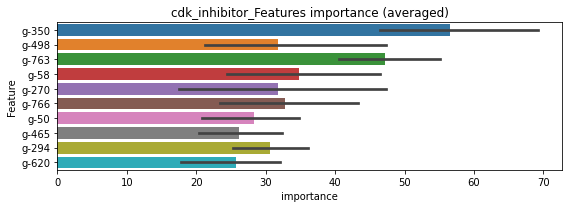

len(train_index) : 3779
len(valid_index) : 3779
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163633	valid_1's binary_logloss: 0.0338496
[200]	training's binary_logloss: 0.00209251	valid_1's binary_logloss: 0.0238428
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00157374	valid_1's binary_logloss: 0.0237535


len(train_index) : 3779
len(valid_index) : 3779
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177173	valid_1's binary_logloss: 0.0289799
[200]	training's binary_logloss: 0.00231794	valid_1's binary_logloss: 0.0167959
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0010326	valid_1's binary_logloss: 0.0159883


cdk_inhibitor logloss: 0.01987090472376681
chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478243	valid_1's binary_logloss: 0.095435
[200]	training's binary_logloss: 0.00885877	valid_1's binary_logloss: 0.0436132
[300]	training's binary_logloss: 0.00251939	valid_1's binary_logloss: 0.0284834
[400]	training's binary_logloss: 0.00117505	valid_1's binary_logloss: 0.0237878
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000879528	valid_1's binary_logloss: 0.0222043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507712	valid_1's binary_logloss: 0.091012
[200]	training's binary_logloss: 0.00997826	valid_1's binary_logloss: 0.0410105
[300]	training's binary_logloss: 0.00274771	valid_1's binary_logloss: 0.0272074
[400]	training's binary_logloss: 0.00124922	valid_1's binary_logloss: 0.0232706
[500]	training's binary_logloss: 0.000765346	valid_1's binary_logloss: 0.0218829
Early stopping, best iteration is:
[528]	trai

1 / 3 AUC score:0.999
y_Threshold: 0.0065131, Threshold: 0.0092644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.00834, conf_1:0.01019
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0092644
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_2: 0.0192644
Num_p_label: 5.0, Expected: 9.0, Adj_threshold_3: 0.0292644
threshold: 0.0292644, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487899	valid_1's binary_logloss: 0.0889435
[200]	training's binary_logloss: 0.00913827	valid_1's binary_logloss: 0.037761
[300]	training's binary_logloss: 0.00259566	valid_1's binary_logloss: 0.0234234
[400]	training's binary_logloss: 0.00120452	valid_1's binary_logloss: 0.0188873
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000850411	valid_1's binary_logloss: 0.017159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482132	valid_1's binary_logloss: 0.0894252
[200]	training's binary_logloss: 0.00881372	valid_1's binary_logloss: 0.043532
[300]	training's binary_logloss: 0.0025003	valid_1's binary_logloss: 0.032844
[400]	training's binary_logloss: 0.00116632	valid_1's binary_logloss: 0.0292358
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000874066	valid_1's binary_logloss: 0.0280874


2 / 3 AUC score:1.000
y_Threshold: 0.0214660, Threshold: 0.0292644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0050226 Vs.target_rate: 0.00227, Num_p_label: 20.0, conf_0:0.02634, conf_1:0.03219
threshold: 0.0292644, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480174	valid_1's binary_logloss: 0.086512
[200]	training's binary_logloss: 0.00896893	valid_1's binary_logloss: 0.0356278
[300]	training's binary_logloss: 0.0025743	valid_1's binary_logloss: 0.023378
[400]	training's binary_logloss: 0.00118047	valid_1's binary_logloss: 0.0199331
[500]	training's binary_logloss: 0.000734213	valid_1's binary_logloss: 0.0184402
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000654085	valid_1's binary_logloss: 0.0182177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479463	valid_1's binary_logloss: 0.0820837
[200]	training's binary_logloss: 0.0086254	valid_1's binary_logloss: 0.0313062
[300]	training's binary_logloss: 0.00251247	valid_1's binary_logloss: 0.0184603
[400]	training's binary_logloss: 0.00118842	valid_1's binary_logloss: 0.0140129
Early stopping, best iteration is:
[452]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0189087, Threshold: 0.0292644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0057760 Vs.target_rate: 0.00227, Num_p_label: 23.0, conf_0:0.02634, conf_1:0.03219
threshold: 0.0292644, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 668.0/7764, y_label_rate: 0.0860381


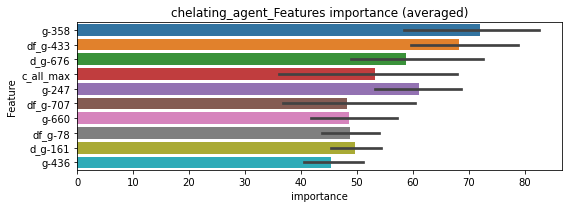

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274514	valid_1's binary_logloss: 0.0544122
[200]	training's binary_logloss: 0.00504292	valid_1's binary_logloss: 0.0282123
[300]	training's binary_logloss: 0.00142843	valid_1's binary_logloss: 0.0231102
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000917518	valid_1's binary_logloss: 0.0223444


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291938	valid_1's binary_logloss: 0.0564503
[200]	training's binary_logloss: 0.0057125	valid_1's binary_logloss: 0.0316408
[300]	training's binary_logloss: 0.001624	valid_1's binary_logloss: 0.0260558
[400]	training's binary_logloss: 0.000718379	valid_1's binary_logloss: 0.0245478
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000624259	valid_1's binary_logloss: 0.0244166


chelating_agent logloss: 0.023380508803407044
chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194918	valid_1's binary_logloss: 0.0261611
[200]	training's binary_logloss: 0.00199909	valid_1's binary_logloss: 0.00470833
[300]	training's binary_logloss: 0.000556482	valid_1's binary_logloss: 0.00200667
[400]	training's binary_logloss: 0.00031453	valid_1's binary_logloss: 0.0014152
[500]	training's binary_logloss: 0.000268333	valid_1's binary_logloss: 0.00128006
[600]	training's binary_logloss: 0.000260575	valid_1's binary_logloss: 0.00125376
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000259576	valid_1's binary_logloss: 0.00124991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190346	valid_1's binary_logloss: 0.0219861
[200]	training's binary_logloss: 0.00197942	valid_1's binary_logloss: 0.00361153
[300]	training's binary_logloss: 0.000565889	valid_1's binary_logloss: 0.00184681
[400]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0017454, Threshold: 0.0072423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00652, conf_1:0.00797
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0072423
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_2: 0.0172423
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_3: 0.0272423
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_4: 0.0372423
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_5: 0.0472423
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_6: 0.0572423
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_7: 0.0672423
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_8: 0.0772423
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.0872423
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_10: 0.0972423
threshold: 0.1072423, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184879	valid_1's binary_logloss: 0.0231056
[200]	training's binary_logloss: 0.00174057	valid_1's binary_logloss: 0.00339332
[300]	training's binary_logloss: 0.000470612	valid_1's binary_logloss: 0.00128138
[400]	training's binary_logloss: 0.00027197	valid_1's binary_logloss: 0.000864681
[500]	training's binary_logloss: 0.000234419	valid_1's binary_logloss: 0.000783658
[600]	training's binary_logloss: 0.000228464	valid_1's binary_logloss: 0.000770403
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000228464	valid_1's binary_logloss: 0.000770403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186	valid_1's binary_logloss: 0.0205374
[200]	training's binary_logloss: 0.00175114	valid_1's binary_logloss: 0.00230856
[300]	training's binary_logloss: 0.000476605	valid_1's binary_logloss: 0.000768518
[400]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.2175467, Threshold: 0.1072423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0148167 Vs.target_rate: 0.00101, Num_p_label: 59.0, conf_0:0.09652, conf_1:0.11797
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_1: 0.1072423
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_2: 0.1172423
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_3: 0.1272423
Num_p_label: 51.0, Expected: 4.0, Adj_threshold_4: 0.1372423
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_5: 0.1472423
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_6: 0.1572423
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_7: 0.1672423
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_8: 0.1772423
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_9: 0.1872423
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_10: 0.1972423
threshold: 0.2072423, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184879	valid_1's binary_logloss: 0.0231056
[200]	training's binary_logloss: 0.00174057	valid_1's binary_logloss: 0.00339332
[300]	training's binary_logloss: 0.000470612	valid_1's binary_logloss: 0.00128138
[400]	training's binary_logloss: 0.00027197	valid_1's binary_logloss: 0.000864681
[500]	training's binary_logloss: 0.000234419	valid_1's binary_logloss: 0.000783658
[600]	training's binary_logloss: 0.000228464	valid_1's binary_logloss: 0.000770403
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000228464	valid_1's binary_logloss: 0.000770403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186	valid_1's binary_logloss: 0.0205374
[200]	training's binary_logloss: 0.00175114	valid_1's binary_logloss: 0.00230856
[300]	training's binary_logloss: 0.000476605	valid_1's binary_logloss: 0.000768518
[400]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.2175467, Threshold: 0.2072423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0105475 Vs.target_rate: 0.00101, Num_p_label: 42.0, conf_0:0.18652, conf_1:0.22797
Num_p_label: 42.0, Expected: 4.0, Adj_threshold_1: 0.2072423
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_2: 0.2172423
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_3: 0.2272423
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_4: 0.2372423
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_5: 0.2472423
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_6: 0.2572423
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_7: 0.2672423
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_8: 0.2772423
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_9: 0.2872423
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_10: 0.2972423
threshold: 0.3072423, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 692.0/7792, y_label_rate: 0.0888090


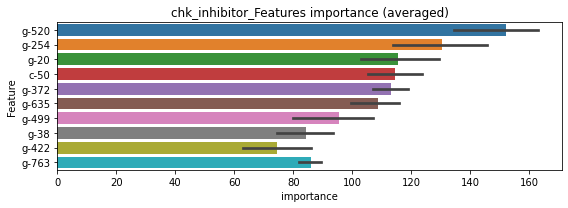

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011303	valid_1's binary_logloss: 0.0163648
[200]	training's binary_logloss: 0.00129362	valid_1's binary_logloss: 0.00545594
[300]	training's binary_logloss: 0.000389788	valid_1's binary_logloss: 0.00414691
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000338535	valid_1's binary_logloss: 0.00408105


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110998	valid_1's binary_logloss: 0.0192071
[200]	training's binary_logloss: 0.0011718	valid_1's binary_logloss: 0.00730876


chk_inhibitor logloss: 0.005267156075656785


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000624034	valid_1's binary_logloss: 0.00645326


chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428777	valid_1's binary_logloss: 0.0748314
[200]	training's binary_logloss: 0.00693242	valid_1's binary_logloss: 0.0279161
[300]	training's binary_logloss: 0.00192799	valid_1's binary_logloss: 0.0163085
[400]	training's binary_logloss: 0.000914406	valid_1's binary_logloss: 0.0122829
[500]	training's binary_logloss: 0.00059514	valid_1's binary_logloss: 0.0110256
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000512083	valid_1's binary_logloss: 0.0105993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446086	valid_1's binary_logloss: 0.069548
[200]	training's binary_logloss: 0.00743073	valid_1's binary_logloss: 0.0219247
[300]	training's binary_logloss: 0.00206367	valid_1's binary_logloss: 0.0114115
[400]	training's binary_logloss: 0.000962356	valid_1's binary_logloss: 0.00796479
[500]	training's binary_logloss: 0.0006137

1 / 3 AUC score:1.000
y_Threshold: 0.0050754, Threshold: 0.0082489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00742, conf_1:0.00907
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0082489
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.0182489
Num_p_label: 2.0, Expected: 7.0, Adj_threshold_3: 0.0282489
threshold: 0.0282489, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418164	valid_1's binary_logloss: 0.0711838
[200]	training's binary_logloss: 0.00662562	valid_1's binary_logloss: 0.0243347
[300]	training's binary_logloss: 0.00185796	valid_1's binary_logloss: 0.0141349
[400]	training's binary_logloss: 0.00088772	valid_1's binary_logloss: 0.0107701
[500]	training's binary_logloss: 0.000583241	valid_1's binary_logloss: 0.00966382
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000505577	valid_1's binary_logloss: 0.00922884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423374	valid_1's binary_logloss: 0.0662221
[200]	training's binary_logloss: 0.00700761	valid_1's binary_logloss: 0.0197721
[300]	training's binary_logloss: 0.00195416	valid_1's binary_logloss: 0.0103512
[400]	training's binary_logloss: 0.000938599	valid_1's binary_logloss: 0.00756182
[500]	training's binary_logloss: 0.0006

2 / 3 AUC score:1.000
y_Threshold: 0.0334703, Threshold: 0.0282489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0075339 Vs.target_rate: 0.00176, Num_p_label: 30.0, conf_0:0.02542, conf_1:0.03107
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_1: 0.0282489
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.0382489
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_3: 0.0482489
threshold: 0.0482489, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418164	valid_1's binary_logloss: 0.0711838
[200]	training's binary_logloss: 0.00662562	valid_1's binary_logloss: 0.0243347
[300]	training's binary_logloss: 0.00185796	valid_1's binary_logloss: 0.0141349
[400]	training's binary_logloss: 0.00088772	valid_1's binary_logloss: 0.0107701
[500]	training's binary_logloss: 0.000583241	valid_1's binary_logloss: 0.00966382
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000505577	valid_1's binary_logloss: 0.00922884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423374	valid_1's binary_logloss: 0.0662221
[200]	training's binary_logloss: 0.00700761	valid_1's binary_logloss: 0.0197721
[300]	training's binary_logloss: 0.00195416	valid_1's binary_logloss: 0.0103512
[400]	training's binary_logloss: 0.000938599	valid_1's binary_logloss: 0.00756182
[500]	training's binary_logloss: 0.0006

3 / 3 AUC score:1.000
y_Threshold: 0.0334703, Threshold: 0.0482489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00176, Num_p_label: 6.0, conf_0:0.04342, conf_1:0.05307
threshold: 0.0482489, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


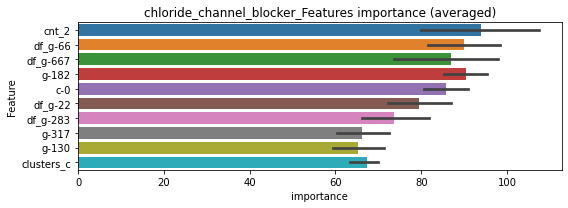

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240692	valid_1's binary_logloss: 0.0436123
[200]	training's binary_logloss: 0.00393793	valid_1's binary_logloss: 0.0207784
[300]	training's binary_logloss: 0.00105408	valid_1's binary_logloss: 0.0169918
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000686195	valid_1's binary_logloss: 0.016499


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239275	valid_1's binary_logloss: 0.0455924
[200]	training's binary_logloss: 0.0039522	valid_1's binary_logloss: 0.0185498
[300]	training's binary_logloss: 0.0010816	valid_1's binary_logloss: 0.0125222
[400]	training's binary_logloss: 0.000502307	valid_1's binary_logloss: 0.0108068
[500]	training's binary_logloss: 0.000317931	valid_1's binary_logloss: 0.00998532
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000322424	valid_1's binary_logloss: 0.00995857


chloride_channel_blocker logloss: 0.01322876148420185
cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462478	valid_1's binary_logloss: 0.0949358
[200]	training's binary_logloss: 0.00850549	valid_1's binary_logloss: 0.0496028
[300]	training's binary_logloss: 0.0023654	valid_1's binary_logloss: 0.0393112
[400]	training's binary_logloss: 0.00108898	valid_1's binary_logloss: 0.0359299
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000973248	valid_1's binary_logloss: 0.0354867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471293	valid_1's binary_logloss: 0.0739803
[200]	training's binary_logloss: 0.00884854	valid_1's binary_logloss: 0.0255055
[300]	training's binary_logloss: 0.0025233	valid_1's binary_logloss: 0.0136446
[400]	training's binary_logloss: 0.00118293	valid_1's binary_logloss: 0.00995313
[500]	training's binary_logloss: 0.000733494	valid_1's binary_logloss: 0.00856523
Early stopping, best iteration is:
[579]	tr

1 / 3 AUC score:0.999
y_Threshold: 0.0060257, Threshold: 0.0074044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00666, conf_1:0.00814
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0074044
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0174044
threshold: 0.0174044, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439888	valid_1's binary_logloss: 0.0918091
[200]	training's binary_logloss: 0.00785549	valid_1's binary_logloss: 0.0408262
[300]	training's binary_logloss: 0.00225094	valid_1's binary_logloss: 0.0283552
[400]	training's binary_logloss: 0.00104947	valid_1's binary_logloss: 0.0251844
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00106155	valid_1's binary_logloss: 0.0251679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467807	valid_1's binary_logloss: 0.0766704
[200]	training's binary_logloss: 0.00829622	valid_1's binary_logloss: 0.0263596
[300]	training's binary_logloss: 0.0023909	valid_1's binary_logloss: 0.0157748
[400]	training's binary_logloss: 0.00113835	valid_1's binary_logloss: 0.012562
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000868554	valid_1's binary_logloss: 0.0117293


2 / 3 AUC score:1.000
y_Threshold: 0.0265596, Threshold: 0.0174044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0160723 Vs.target_rate: 0.00202, Num_p_label: 64.0, conf_0:0.01566, conf_1:0.01914
Num_p_label: 64.0, Expected: 8.0, Adj_threshold_1: 0.0174044
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_2: 0.0274044
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0374044
threshold: 0.0374044, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440601	valid_1's binary_logloss: 0.0837232
[200]	training's binary_logloss: 0.00776239	valid_1's binary_logloss: 0.0355028
[300]	training's binary_logloss: 0.00225548	valid_1's binary_logloss: 0.0230002
[400]	training's binary_logloss: 0.00106491	valid_1's binary_logloss: 0.0190055
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000725756	valid_1's binary_logloss: 0.0178671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458674	valid_1's binary_logloss: 0.0835192
[200]	training's binary_logloss: 0.0081276	valid_1's binary_logloss: 0.0369771
[300]	training's binary_logloss: 0.00232491	valid_1's binary_logloss: 0.0292911
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00225862	valid_1's binary_logloss: 0.0291309


3 / 3 AUC score:1.000
y_Threshold: 0.0272900, Threshold: 0.0374044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.03366, conf_1:0.04114
threshold: 0.0374044, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 661.0/7763, y_label_rate: 0.0851475


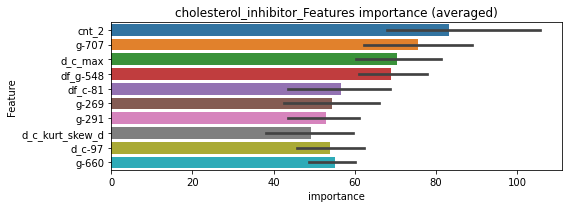

len(train_index) : 3881
len(valid_index) : 3882
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256924	valid_1's binary_logloss: 0.0551882
[200]	training's binary_logloss: 0.00451964	valid_1's binary_logloss: 0.0299126
[300]	training's binary_logloss: 0.00125836	valid_1's binary_logloss: 0.0254724
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00139386	valid_1's binary_logloss: 0.0253389


len(train_index) : 3882
len(valid_index) : 3881
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254568	valid_1's binary_logloss: 0.0456973
[200]	training's binary_logloss: 0.00484013	valid_1's binary_logloss: 0.0195917
[300]	training's binary_logloss: 0.00139533	valid_1's binary_logloss: 0.0140417
[400]	training's binary_logloss: 0.000636081	valid_1's binary_logloss: 0.0125979
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000668693	valid_1's binary_logloss: 0.0125553


cholesterol_inhibitor logloss: 0.01894792915946271
cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505045	valid_1's binary_logloss: 0.100233
[200]	training's binary_logloss: 0.00962192	valid_1's binary_logloss: 0.0531014
[300]	training's binary_logloss: 0.00265662	valid_1's binary_logloss: 0.0401423
[400]	training's binary_logloss: 0.00121911	valid_1's binary_logloss: 0.0358357
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000836635	valid_1's binary_logloss: 0.0342956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529778	valid_1's binary_logloss: 0.0857119
[200]	training's binary_logloss: 0.00965063	valid_1's binary_logloss: 0.0322708
[300]	training's binary_logloss: 0.0027165	valid_1's binary_logloss: 0.0200033
[400]	training's binary_logloss: 0.00124095	valid_1's binary_logloss: 0.016267
[500]	training's binary_logloss: 0.000778354	valid_1's binary_logloss: 0.0152994
Early stopping, best iteration is:
[529]	train

1 / 3 AUC score:0.999
y_Threshold: 0.0063678, Threshold: 0.0129175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.01163, conf_1:0.01421
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0129175
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_2: 0.0229175
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_3: 0.0329175
threshold: 0.0329175, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520644	valid_1's binary_logloss: 0.0938054
[200]	training's binary_logloss: 0.00981381	valid_1's binary_logloss: 0.0433249
[300]	training's binary_logloss: 0.00275347	valid_1's binary_logloss: 0.0300016
[400]	training's binary_logloss: 0.00123498	valid_1's binary_logloss: 0.0250646
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00103974	valid_1's binary_logloss: 0.0241562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490132	valid_1's binary_logloss: 0.0934714
[200]	training's binary_logloss: 0.00906	valid_1's binary_logloss: 0.0479521
[300]	training's binary_logloss: 0.0026199	valid_1's binary_logloss: 0.0361977
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00137187	valid_1's binary_logloss: 0.0331345


2 / 3 AUC score:1.000
y_Threshold: 0.0372435, Threshold: 0.0329175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0118031 Vs.target_rate: 0.00227, Num_p_label: 47.0, conf_0:0.02963, conf_1:0.03621
Num_p_label: 47.0, Expected: 9.0, Adj_threshold_1: 0.0329175
Num_p_label: 36.0, Expected: 9.0, Adj_threshold_2: 0.0429175
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_3: 0.0529175
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_4: 0.0629175
threshold: 0.0629175, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476804	valid_1's binary_logloss: 0.0875058
[200]	training's binary_logloss: 0.00876378	valid_1's binary_logloss: 0.0376192
[300]	training's binary_logloss: 0.00253167	valid_1's binary_logloss: 0.0230378
[400]	training's binary_logloss: 0.00117278	valid_1's binary_logloss: 0.0179719
[500]	training's binary_logloss: 0.000739631	valid_1's binary_logloss: 0.0155678
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000682085	valid_1's binary_logloss: 0.0150743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053605	valid_1's binary_logloss: 0.0811521
[200]	training's binary_logloss: 0.0100796	valid_1's binary_logloss: 0.026251
[300]	training's binary_logloss: 0.00286997	valid_1's binary_logloss: 0.0130862
[400]	training's binary_logloss: 0.00130248	valid_1's binary_logloss: 0.00916565
[500]	training's binary_logloss: 0.00080346	v

3 / 3 AUC score:1.000
y_Threshold: 0.0534297, Threshold: 0.0629175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0030136 Vs.target_rate: 0.00227, Num_p_label: 12.0, conf_0:0.05663, conf_1:0.06921
threshold: 0.0629175, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 660.0/7770, y_label_rate: 0.0849421


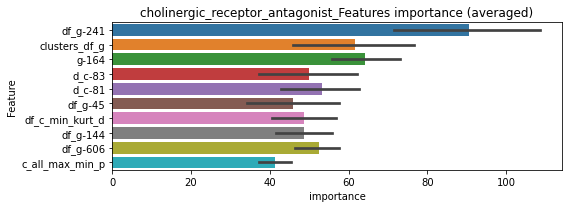

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274259	valid_1's binary_logloss: 0.0591569
[200]	training's binary_logloss: 0.00516007	valid_1's binary_logloss: 0.033698
[300]	training's binary_logloss: 0.00144313	valid_1's binary_logloss: 0.0284587
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00128772	valid_1's binary_logloss: 0.0281549


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292829	valid_1's binary_logloss: 0.0502877
[200]	training's binary_logloss: 0.00575946	valid_1's binary_logloss: 0.020826
[300]	training's binary_logloss: 0.00154255	valid_1's binary_logloss: 0.0133859
[400]	training's binary_logloss: 0.000693236	valid_1's binary_logloss: 0.0111785
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000480039	valid_1's binary_logloss: 0.0105685


cholinergic_receptor_antagonist logloss: 0.019361704969170078
coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329757	valid_1's binary_logloss: 0.0472848
[200]	training's binary_logloss: 0.00432581	valid_1's binary_logloss: 0.0101997
[300]	training's binary_logloss: 0.00117806	valid_1's binary_logloss: 0.00395425
[400]	training's binary_logloss: 0.000584132	valid_1's binary_logloss: 0.002489
[500]	training's binary_logloss: 0.000418775	valid_1's binary_logloss: 0.00199789
[600]	training's binary_logloss: 0.000391706	valid_1's binary_logloss: 0.00194419
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000393056	valid_1's binary_logloss: 0.00194123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314727	valid_1's binary_logloss: 0.0524015
[200]	training's binary_logloss: 0.00432888	valid_1's binary_logloss: 0.0134778
[300]	training's binary_logloss: 0.00118906	valid_1's binary_logloss: 0.00610007
[400]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0023173, Threshold: 0.0036978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00333, conf_1:0.00407
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0036978
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0136978
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_3: 0.0236978
threshold: 0.0236978, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303442	valid_1's binary_logloss: 0.0435529
[200]	training's binary_logloss: 0.00408501	valid_1's binary_logloss: 0.00989091
[300]	training's binary_logloss: 0.00113384	valid_1's binary_logloss: 0.00400931
[400]	training's binary_logloss: 0.000561701	valid_1's binary_logloss: 0.00249139
[500]	training's binary_logloss: 0.000411398	valid_1's binary_logloss: 0.00204061
[600]	training's binary_logloss: 0.00039131	valid_1's binary_logloss: 0.00199064
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00038862	valid_1's binary_logloss: 0.00198377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312819	valid_1's binary_logloss: 0.0504603
[200]	training's binary_logloss: 0.00417075	valid_1's binary_logloss: 0.013743
[300]	training's binary_logloss: 0.00115467	valid_1's binary_logloss: 0.00666577
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0375121, Threshold: 0.0236978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0047715 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.02133, conf_1:0.02607
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.0236978
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0336978
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0436978
threshold: 0.0436978, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303442	valid_1's binary_logloss: 0.0435529
[200]	training's binary_logloss: 0.00408501	valid_1's binary_logloss: 0.00989091
[300]	training's binary_logloss: 0.00113384	valid_1's binary_logloss: 0.00400931
[400]	training's binary_logloss: 0.000561701	valid_1's binary_logloss: 0.00249139
[500]	training's binary_logloss: 0.000411398	valid_1's binary_logloss: 0.00204061
[600]	training's binary_logloss: 0.00039131	valid_1's binary_logloss: 0.00199064
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00038862	valid_1's binary_logloss: 0.00198377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312819	valid_1's binary_logloss: 0.0504603
[200]	training's binary_logloss: 0.00417075	valid_1's binary_logloss: 0.013743
[300]	training's binary_logloss: 0.00115467	valid_1's binary_logloss: 0.00666577
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0375121, Threshold: 0.0436978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.03933, conf_1:0.04807
threshold: 0.0436978, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


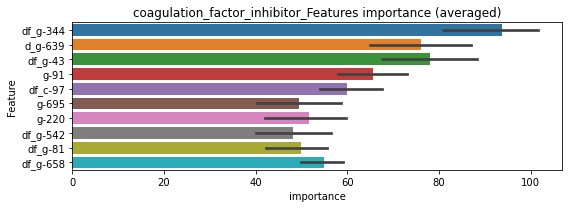

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170027	valid_1's binary_logloss: 0.0265577
[200]	training's binary_logloss: 0.00227145	valid_1's binary_logloss: 0.00889135
[300]	training's binary_logloss: 0.000601149	valid_1's binary_logloss: 0.00646187
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000374661	valid_1's binary_logloss: 0.00619086


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189848	valid_1's binary_logloss: 0.0247235
[200]	training's binary_logloss: 0.00260583	valid_1's binary_logloss: 0.0054484
[300]	training's binary_logloss: 0.000674299	valid_1's binary_logloss: 0.00262243
[400]	training's binary_logloss: 0.000320001	valid_1's binary_logloss: 0.00210344
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000230283	valid_1's binary_logloss: 0.00197024


coagulation_factor_inhibitor logloss: 0.004080549295404981
corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026199	valid_1's binary_logloss: 0.0417441
[200]	training's binary_logloss: 0.00352633	valid_1's binary_logloss: 0.015117
[300]	training's binary_logloss: 0.00100957	valid_1's binary_logloss: 0.0108168
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000594388	valid_1's binary_logloss: 0.00973828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271306	valid_1's binary_logloss: 0.0414525
[200]	training's binary_logloss: 0.00364931	valid_1's binary_logloss: 0.0162483
[300]	training's binary_logloss: 0.00107383	valid_1's binary_logloss: 0.0123168
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000799723	valid_1's binary_logloss: 0.011698


1 / 3 AUC score:1.000
y_Threshold: 0.0029005, Threshold: 0.0057777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00520, conf_1:0.00636
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0057777
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.0157777
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_3: 0.0257777
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_4: 0.0357777
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.0457777
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_6: 0.0557777
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_7: 0.0657777
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.0757777
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_9: 0.0857777
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_10: 0.0957777
threshold: 0.1057777, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247074	valid_1's binary_logloss: 0.0322474
[200]	training's binary_logloss: 0.00312653	valid_1's binary_logloss: 0.00667679
[300]	training's binary_logloss: 0.00086868	valid_1's binary_logloss: 0.00297183
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000576651	valid_1's binary_logloss: 0.00239016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246321	valid_1's binary_logloss: 0.0342013
[200]	training's binary_logloss: 0.00290177	valid_1's binary_logloss: 0.00937045
[300]	training's binary_logloss: 0.000819562	valid_1's binary_logloss: 0.00645296
[400]	training's binary_logloss: 0.000436781	valid_1's binary_logloss: 0.00589763
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000436781	valid_1's binary_logloss: 0.00589763


2 / 3 AUC score:1.000
y_Threshold: 0.0261428, Threshold: 0.1057777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0107986 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.09520, conf_1:0.11636
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.1057777
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.1157777
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_3: 0.1257777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.1357777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_5: 0.1457777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.1557777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_7: 0.1657777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.1757777
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_9: 0.1857777
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_10: 0.1957777
threshold: 0.2057777, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246395	valid_1's binary_logloss: 0.036681
[200]	training's binary_logloss: 0.00288034	valid_1's binary_logloss: 0.0101981
[300]	training's binary_logloss: 0.000810892	valid_1's binary_logloss: 0.00737579
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000677206	valid_1's binary_logloss: 0.00729689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235636	valid_1's binary_logloss: 0.0394109
[200]	training's binary_logloss: 0.00285323	valid_1's binary_logloss: 0.0145394
[300]	training's binary_logloss: 0.000813839	valid_1's binary_logloss: 0.0102349
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000541477	valid_1's binary_logloss: 0.00950498


3 / 3 AUC score:1.000
y_Threshold: 0.0320261, Threshold: 0.2057777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0097941 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.18520, conf_1:0.22636
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.2057777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_2: 0.2157777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.2257777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.2357777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_5: 0.2457777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.2557777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_7: 0.2657777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.2757777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_9: 0.2857777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_10: 0.2957777
threshold: 0.3057777, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 692.0/7784, y_label_rate: 0.0889003


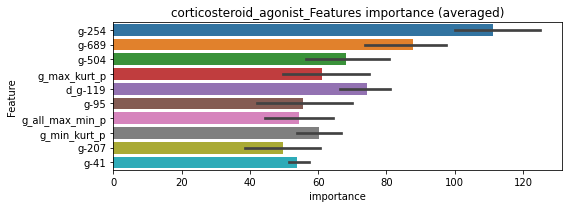

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013156	valid_1's binary_logloss: 0.0190614
[200]	training's binary_logloss: 0.00151371	valid_1's binary_logloss: 0.00498509
[300]	training's binary_logloss: 0.000429897	valid_1's binary_logloss: 0.0030788
[400]	training's binary_logloss: 0.000228481	valid_1's binary_logloss: 0.00261691
[500]	training's binary_logloss: 0.0001755	valid_1's binary_logloss: 0.0024064
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000177725	valid_1's binary_logloss: 0.00240499


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130235	valid_1's binary_logloss: 0.0218976
[200]	training's binary_logloss: 0.00148248	valid_1's binary_logloss: 0.00501599
[300]	training's binary_logloss: 0.000423684	valid_1's binary_logloss: 0.00247806
[400]	training's binary_logloss: 0.000224134	valid_1's binary_logloss: 0.00177939
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000184544	valid_1's binary_logloss: 0.00161049


corticosteroid_agonist logloss: 0.002007743083094463
cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863


neg labels: 3289 → selected neg labels: 3215


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133413	valid_1's binary_logloss: 0.384059
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0785396	valid_1's binary_logloss: 0.379998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14814	valid_1's binary_logloss: 0.383476


1 / 3 AUC score:0.764
y_Threshold: 0.1517222, Threshold: 0.2019270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 747 → Positive_corect_labels: 334/3111
p_label_rate: 0.0200904 Vs.target_rate: 0.01827, Num_p_label: 80.0, conf_0:0.18173, conf_1:0.22212
threshold: 0.2019270, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.117874	valid_1's binary_logloss: 0.379578


positive_y_label: 334.0/3111, y_label_rate: 0.1073610
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681292	valid_1's binary_logloss: 0.23712
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0288746	valid_1's binary_logloss: 0.225393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687483	valid_1's binary_logloss: 0.245758


2 / 3 AUC score:0.895
y_Threshold: 0.0920380, Threshold: 0.2019270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 244 → Positive_corect_labels: 212.0/2867
p_label_rate: 0.0032647 Vs.target_rate: 0.01827, Num_p_label: 13.0, conf_0:0.18173, conf_1:0.22212


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0358731	valid_1's binary_logloss: 0.238134


Num_p_label: 13.0, Expected: 72.7, Adj_threshold_1: 0.2019270
Num_p_label: 18.0, Expected: 72.7, Adj_threshold_2: 0.1919270
Num_p_label: 25.0, Expected: 72.7, Adj_threshold_3: 0.1819270
Num_p_label: 35.0, Expected: 72.7, Adj_threshold_4: 0.1719270
Num_p_label: 45.0, Expected: 72.7, Adj_threshold_5: 0.1619270
threshold: 0.1619270, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 212.0/2867, y_label_rate: 0.0739449
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375463	valid_1's binary_logloss: 0.162483
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0188633	valid_1's binary_logloss: 0.155973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359106	valid_1's binary_logloss: 0.162752


3 / 3 AUC score:0.957
y_Threshold: 0.0650865, Threshold: 0.1619270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 128 → Positive_corect_labels: 148.0/2739


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0175689	valid_1's binary_logloss: 0.159058


p_label_rate: 0.0025113 Vs.target_rate: 0.01827, Num_p_label: 10.0, conf_0:0.14573, conf_1:0.17812
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_1: 0.1619270
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_2: 0.1519270
Num_p_label: 14.0, Expected: 72.7, Adj_threshold_3: 0.1419270
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_4: 0.1319270
Num_p_label: 20.0, Expected: 72.7, Adj_threshold_5: 0.1219270
Num_p_label: 30.0, Expected: 72.7, Adj_threshold_6: 0.1119270
Num_p_label: 49.0, Expected: 72.7, Adj_threshold_7: 0.1019270
threshold: 0.1019270, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 197.0/6721, y_label_rate: 0.0293111


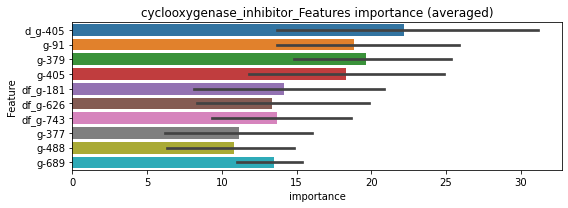

len(train_index) : 3360
len(valid_index) : 3361
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014607	valid_1's binary_logloss: 0.0857219


len(train_index) : 3361
len(valid_index) : 3360


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0115404	valid_1's binary_logloss: 0.0852188


================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133867	valid_1's binary_logloss: 0.0815876


cyclooxygenase_inhibitor logloss: 0.08219108098298601


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00781328	valid_1's binary_logloss: 0.0791625


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640436	valid_1's binary_logloss: 0.140736
[200]	training's binary_logloss: 0.0162367	valid_1's binary_logloss: 0.0883586
[300]	training's binary_logloss: 0.00516991	valid_1's binary_logloss: 0.0730072
[400]	training's binary_logloss: 0.00226304	valid_1's binary_logloss: 0.0683238
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00208064	valid_1's binary_logloss: 0.0677827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712681	valid_1's binary_logloss: 0.134754
[200]	training's binary_logloss: 0.0187062	valid_1's binary_logloss: 0.0738119
[300]	training's binary_logloss: 0.00593658	valid_1's binary_logloss: 0.0527291
[400]	training's binary_logloss: 0.00262069	valid_1's binary_logloss: 0.0465497
[500]	training's binary_logloss: 0.00152846	valid_1's binary_logloss: 0.0438588
Early stopping, best iteration is:
[506]	training

1 / 3 AUC score:0.997
y_Threshold: 0.0169529, Threshold: 0.0208810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00437, Num_p_label: 80.0, conf_0:0.01879, conf_1:0.02297
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0208810
Num_p_label: 39.0, Expected: 17.4, Adj_threshold_2: 0.0308810
Num_p_label: 23.0, Expected: 17.4, Adj_threshold_3: 0.0408810
threshold: 0.0408810, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 644.0/3776, y_label_rate: 0.1705508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064116	valid_1's binary_logloss: 0.137528
[200]	training's binary_logloss: 0.0154592	valid_1's binary_logloss: 0.0872567
[300]	training's binary_logloss: 0.00480334	valid_1's binary_logloss: 0.0698615
[400]	training's binary_logloss: 0.00212349	valid_1's binary_logloss: 0.064157
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00147085	valid_1's binary_logloss: 0.0626562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666381	valid_1's binary_logloss: 0.132825
[200]	training's binary_logloss: 0.0167892	valid_1's binary_logloss: 0.0779872
[300]	training's binary_logloss: 0.00535154	valid_1's binary_logloss: 0.0605272
[400]	training's binary_logloss: 0.0023574	valid_1's binary_logloss: 0.0543413
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0023574	valid_1's binary_logloss: 0.0543413


2 / 3 AUC score:0.998
y_Threshold: 0.0426859, Threshold: 0.0408810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 628.0/3744
p_label_rate: 0.0082873 Vs.target_rate: 0.00437, Num_p_label: 33.0, conf_0:0.03679, conf_1:0.04497
threshold: 0.0408810, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 628.0/3744, y_label_rate: 0.1677350
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637637	valid_1's binary_logloss: 0.129935
[200]	training's binary_logloss: 0.0150884	valid_1's binary_logloss: 0.0771023
[300]	training's binary_logloss: 0.00475237	valid_1's binary_logloss: 0.0581511
[400]	training's binary_logloss: 0.0021218	valid_1's binary_logloss: 0.0521267
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00155008	valid_1's binary_logloss: 0.0497223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635588	valid_1's binary_logloss: 0.127107
[200]	training's binary_logloss: 0.0152043	valid_1's binary_logloss: 0.0723882
[300]	training's binary_logloss: 0.00486981	valid_1's binary_logloss: 0.0567718
[400]	training's binary_logloss: 0.00215822	valid_1's binary_logloss: 0.0511579
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00203054	valid_1's binary_logloss: 0.0508863


3 / 3 AUC score:0.999
y_Threshold: 0.0504877, Threshold: 0.0408810, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 615.0/3718
p_label_rate: 0.0133099 Vs.target_rate: 0.00437, Num_p_label: 53.0, conf_0:0.03679, conf_1:0.04497
Num_p_label: 53.0, Expected: 17.4, Adj_threshold_1: 0.0408810
Num_p_label: 33.0, Expected: 17.4, Adj_threshold_2: 0.0508810
threshold: 0.0508810, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 648.0/7700, y_label_rate: 0.0841558


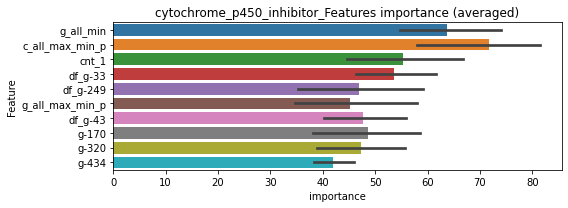

len(train_index) : 3850
len(valid_index) : 3850
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035829	valid_1's binary_logloss: 0.0845878
[200]	training's binary_logloss: 0.00875849	valid_1's binary_logloss: 0.0594778
[300]	training's binary_logloss: 0.0026511	valid_1's binary_logloss: 0.052972
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00235704	valid_1's binary_logloss: 0.0524436


len(train_index) : 3850
len(valid_index) : 3850
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346373	valid_1's binary_logloss: 0.0876148
[200]	training's binary_logloss: 0.0084121	valid_1's binary_logloss: 0.061047
[300]	training's binary_logloss: 0.0025787	valid_1's binary_logloss: 0.0546772
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00242499	valid_1's binary_logloss: 0.0543882


cytochrome_p450_inhibitor logloss: 0.05341592376752095
dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296625	valid_1's binary_logloss: 0.0428568
[200]	training's binary_logloss: 0.00432152	valid_1's binary_logloss: 0.0097516
[300]	training's binary_logloss: 0.00124552	valid_1's binary_logloss: 0.00434137
[400]	training's binary_logloss: 0.000621583	valid_1's binary_logloss: 0.00299103
[500]	training's binary_logloss: 0.000432807	valid_1's binary_logloss: 0.0025201
[600]	training's binary_logloss: 0.000399973	valid_1's binary_logloss: 0.00243054
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000399468	valid_1's binary_logloss: 0.00242876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294196	valid_1's binary_logloss: 0.0559535
[200]	training's binary_logloss: 0.00419903	valid_1's binary_logloss: 0.0249977
[300]	training's binary_logloss: 0.00119614	valid_1's binary_logloss: 0.0181262
Early stopping, best iteration is:
[3

1 / 3 AUC score:1.000
y_Threshold: 0.0031025, Threshold: 0.0038665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00348, conf_1:0.00425
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0038665
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.0138665
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.0238665
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0338665
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0438665
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.0538665
threshold: 0.0538665, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295525	valid_1's binary_logloss: 0.0426269
[200]	training's binary_logloss: 0.00410467	valid_1's binary_logloss: 0.00872165
[300]	training's binary_logloss: 0.00118241	valid_1's binary_logloss: 0.00340813
[400]	training's binary_logloss: 0.000598298	valid_1's binary_logloss: 0.00209907
[500]	training's binary_logloss: 0.000421605	valid_1's binary_logloss: 0.0016595
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000405961	valid_1's binary_logloss: 0.00163307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291172	valid_1's binary_logloss: 0.0573536
[200]	training's binary_logloss: 0.00396745	valid_1's binary_logloss: 0.024514
[300]	training's binary_logloss: 0.0011394	valid_1's binary_logloss: 0.0189493
[400]	training's binary_logloss: 0.000587572	valid_1's binary_logloss: 0.0168497
Early stopping, best iteration is:
[417

2 / 3 AUC score:1.000
y_Threshold: 0.0225750, Threshold: 0.0538665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.04848, conf_1:0.05925
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0538665
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0638665
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0738665
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0838665
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.0938665
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.1038665
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.1138665
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_8: 0.1238665
threshold: 0.1238665, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298921	valid_1's binary_logloss: 0.0492099
[200]	training's binary_logloss: 0.00416143	valid_1's binary_logloss: 0.0140389
[300]	training's binary_logloss: 0.00119338	valid_1's binary_logloss: 0.00802795
[400]	training's binary_logloss: 0.000600611	valid_1's binary_logloss: 0.00631223
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000628667	valid_1's binary_logloss: 0.00628949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290127	valid_1's binary_logloss: 0.0497731
[200]	training's binary_logloss: 0.00399055	valid_1's binary_logloss: 0.0164423
[300]	training's binary_logloss: 0.00113855	valid_1's binary_logloss: 0.00992921
[400]	training's binary_logloss: 0.00057455	valid_1's binary_logloss: 0.00812994
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000530573	valid_1's binary_logloss: 0.00801386


3 / 3 AUC score:1.000
y_Threshold: 0.0284338, Threshold: 0.1238665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.11148, conf_1:0.13625
threshold: 0.1238665, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 669.0/7787, y_label_rate: 0.0859124


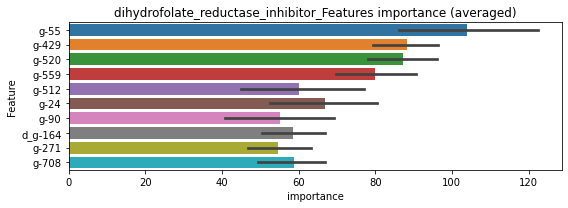

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163001	valid_1's binary_logloss: 0.0295108
[200]	training's binary_logloss: 0.00215457	valid_1's binary_logloss: 0.00992639
[300]	training's binary_logloss: 0.000610806	valid_1's binary_logloss: 0.00655795
[400]	training's binary_logloss: 0.000304471	valid_1's binary_logloss: 0.00568235
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000278724	valid_1's binary_logloss: 0.00553583


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155435	valid_1's binary_logloss: 0.0309736
[200]	training's binary_logloss: 0.00213079	valid_1's binary_logloss: 0.0121819
[300]	training's binary_logloss: 0.00061184	valid_1's binary_logloss: 0.00794962
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000355397	valid_1's binary_logloss: 0.00698042


dihydrofolate_reductase_inhibitor logloss: 0.006258031007815231
dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309945	valid_1's binary_logloss: 0.0472114
[200]	training's binary_logloss: 0.00413255	valid_1's binary_logloss: 0.0125226
[300]	training's binary_logloss: 0.00114589	valid_1's binary_logloss: 0.00640703
[400]	training's binary_logloss: 0.000562343	valid_1's binary_logloss: 0.00452472
[500]	training's binary_logloss: 0.000400726	valid_1's binary_logloss: 0.00399205
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000401995	valid_1's binary_logloss: 0.00398866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320633	valid_1's binary_logloss: 0.0429146
[200]	training's binary_logloss: 0.00436489	valid_1's binary_logloss: 0.00780202
[300]	training's binary_logloss: 0.00118516	valid_1's binary_logloss: 0.00266421
[400]	training's binary_logloss: 0.000588752	valid_1's binary_logloss: 0.00151882
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0023571, Threshold: 0.0042357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00381, conf_1:0.00466
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0042357
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_2: 0.0142357
threshold: 0.0142357, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294624	valid_1's binary_logloss: 0.0442075
[200]	training's binary_logloss: 0.00385748	valid_1's binary_logloss: 0.010913
[300]	training's binary_logloss: 0.00108835	valid_1's binary_logloss: 0.00517292
[400]	training's binary_logloss: 0.00054776	valid_1's binary_logloss: 0.00372778
[500]	training's binary_logloss: 0.000396853	valid_1's binary_logloss: 0.0033338
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000397264	valid_1's binary_logloss: 0.00332804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301914	valid_1's binary_logloss: 0.0381893
[200]	training's binary_logloss: 0.00393137	valid_1's binary_logloss: 0.00627904
[300]	training's binary_logloss: 0.00110465	valid_1's binary_logloss: 0.00205806
[400]	training's binary_logloss: 0.000558566	valid_1's binary_logloss: 0.00113446
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0644184, Threshold: 0.0142357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0087896 Vs.target_rate: 0.00105, Num_p_label: 35.0, conf_0:0.01281, conf_1:0.01566
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_1: 0.0142357
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.0242357
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.0342357
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.0442357
threshold: 0.0442357, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294624	valid_1's binary_logloss: 0.0442075
[200]	training's binary_logloss: 0.00385748	valid_1's binary_logloss: 0.010913
[300]	training's binary_logloss: 0.00108835	valid_1's binary_logloss: 0.00517292
[400]	training's binary_logloss: 0.00054776	valid_1's binary_logloss: 0.00372778
[500]	training's binary_logloss: 0.000396853	valid_1's binary_logloss: 0.0033338
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000397264	valid_1's binary_logloss: 0.00332804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301914	valid_1's binary_logloss: 0.0381893
[200]	training's binary_logloss: 0.00393137	valid_1's binary_logloss: 0.00627904
[300]	training's binary_logloss: 0.00110465	valid_1's binary_logloss: 0.00205806
[400]	training's binary_logloss: 0.000558566	valid_1's binary_logloss: 0.00113446
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0644184, Threshold: 0.0442357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.03981, conf_1:0.04866
threshold: 0.0442357, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


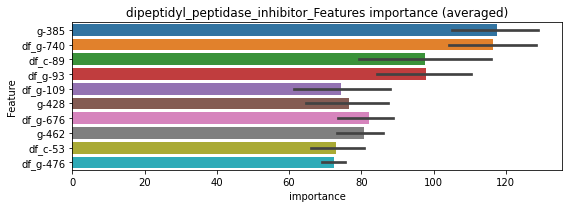

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016772	valid_1's binary_logloss: 0.0284412
[200]	training's binary_logloss: 0.00223417	valid_1's binary_logloss: 0.010923
[300]	training's binary_logloss: 0.000595776	valid_1's binary_logloss: 0.00855233
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000396152	valid_1's binary_logloss: 0.00835435


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173848	valid_1's binary_logloss: 0.0243238
[200]	training's binary_logloss: 0.00232105	valid_1's binary_logloss: 0.00638676
[300]	training's binary_logloss: 0.000635399	valid_1's binary_logloss: 0.00415288
[400]	training's binary_logloss: 0.000306877	valid_1's binary_logloss: 0.00370539
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000238139	valid_1's binary_logloss: 0.00362297


dipeptidyl_peptidase_inhibitor logloss: 0.005988659730727294
diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156581	valid_1's binary_logloss: 0.0167833
[200]	training's binary_logloss: 0.0012929	valid_1's binary_logloss: 0.00185732
[300]	training's binary_logloss: 0.000354349	valid_1's binary_logloss: 0.000692341
[400]	training's binary_logloss: 0.000218886	valid_1's binary_logloss: 0.000490945
[500]	training's binary_logloss: 0.000192912	valid_1's binary_logloss: 0.000454205
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000191637	valid_1's binary_logloss: 0.000452714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156358	valid_1's binary_logloss: 0.0178124
[200]	training's binary_logloss: 0.00128889	valid_1's binary_logloss: 0.00262004
[300]	training's binary_logloss: 0.000351118	valid_1's binary_logloss: 0.00135314
[400]	training's binary_logloss: 0.000216186	valid_1's binary_logloss: 0.00106771
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0005669, Threshold: 0.0009461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00085, conf_1:0.00104
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0009461
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.0109461
threshold: 0.0109461, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158732	valid_1's binary_logloss: 0.0163639
[200]	training's binary_logloss: 0.00128674	valid_1's binary_logloss: 0.00139281
[300]	training's binary_logloss: 0.000344752	valid_1's binary_logloss: 0.000390956
[400]	training's binary_logloss: 0.00021584	valid_1's binary_logloss: 0.000246995
[500]	training's binary_logloss: 0.0001891	valid_1's binary_logloss: 0.000216606
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000187886	valid_1's binary_logloss: 0.000215176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158841	valid_1's binary_logloss: 0.0177963
[200]	training's binary_logloss: 0.00129113	valid_1's binary_logloss: 0.00246894
[300]	training's binary_logloss: 0.000344549	valid_1's binary_logloss: 0.00134135


2 / 3 AUC score:1.000
y_Threshold: 0.0851625, Threshold: 0.0109461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00985, conf_1:0.01204
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0109461


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000237307	valid_1's binary_logloss: 0.00114058


Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0209461
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0309461
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0409461
threshold: 0.0409461, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158732	valid_1's binary_logloss: 0.0163639
[200]	training's binary_logloss: 0.00128674	valid_1's binary_logloss: 0.00139281
[300]	training's binary_logloss: 0.000344752	valid_1's binary_logloss: 0.000390956
[400]	training's binary_logloss: 0.00021584	valid_1's binary_logloss: 0.000246995
[500]	training's binary_logloss: 0.0001891	valid_1's binary_logloss: 0.000216606
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000187886	valid_1's binary_logloss: 0.000215176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158841	valid_1's binary_logloss: 0.0177963
[200]	training's binary_logloss: 0.00129113	valid_1's binary_logloss: 0.00246894
[300]	training's binary_logloss: 0.000344549	valid_1's binary_logloss: 0.00134135


3 / 3 AUC score:1.000
y_Threshold: 0.0851625, Threshold: 0.0409461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.03685, conf_1:0.04504


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000237307	valid_1's binary_logloss: 0.00114058


threshold: 0.0409461, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


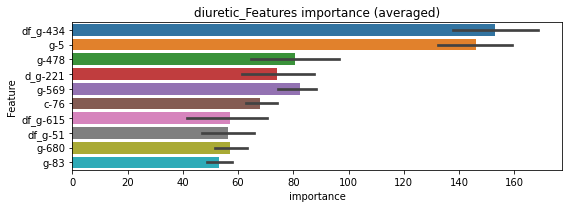

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00851517	valid_1's binary_logloss: 0.00963779
[200]	training's binary_logloss: 0.000690205	valid_1's binary_logloss: 0.00205618
[300]	training's binary_logloss: 0.000181775	valid_1's binary_logloss: 0.00167035
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000155481	valid_1's binary_logloss: 0.00164789


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087231	valid_1's binary_logloss: 0.01013
[200]	training's binary_logloss: 0.00068273	valid_1's binary_logloss: 0.00198341
[300]	training's binary_logloss: 0.000184344	valid_1's binary_logloss: 0.00144786
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000192463	valid_1's binary_logloss: 0.00144369


diuretic logloss: 0.0015458002013842196
dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410931	valid_1's binary_logloss: 0.0774651
[200]	training's binary_logloss: 0.00676165	valid_1's binary_logloss: 0.0290865
[300]	training's binary_logloss: 0.00201451	valid_1's binary_logloss: 0.0169456
[400]	training's binary_logloss: 0.000980767	valid_1's binary_logloss: 0.0133845
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00082423	valid_1's binary_logloss: 0.012921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435418	valid_1's binary_logloss: 0.0744989
[200]	training's binary_logloss: 0.00733742	valid_1's binary_logloss: 0.0245826
[300]	training's binary_logloss: 0.00213014	valid_1's binary_logloss: 0.0132024
[400]	training's binary_logloss: 0.00101761	valid_1's binary_logloss: 0.00981135
[500]	training's binary_logloss: 0.000651933	valid_1's binary_logloss: 0.00853564
Early stopping, best iteration is:
[550]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0062878, Threshold: 0.0112534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.01013, conf_1:0.01238
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0112534
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_2: 0.0212534
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.0312534
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.0412534
threshold: 0.0412534, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417447	valid_1's binary_logloss: 0.0761294
[200]	training's binary_logloss: 0.00688978	valid_1's binary_logloss: 0.0265045
[300]	training's binary_logloss: 0.0019895	valid_1's binary_logloss: 0.0145445
[400]	training's binary_logloss: 0.000960999	valid_1's binary_logloss: 0.0115304
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000717778	valid_1's binary_logloss: 0.0104599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436546	valid_1's binary_logloss: 0.0737182
[200]	training's binary_logloss: 0.00740786	valid_1's binary_logloss: 0.0225919
[300]	training's binary_logloss: 0.00211894	valid_1's binary_logloss: 0.0109255
[400]	training's binary_logloss: 0.00100249	valid_1's binary_logloss: 0.00746496
[500]	training's binary_logloss: 0.000655795	valid_1's binary_logloss: 0.00628006
Early stopping, best iteration is:
[565]	

2 / 3 AUC score:1.000
y_Threshold: 0.0526589, Threshold: 0.0412534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.03713, conf_1:0.04538
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0412534
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_2: 0.0512534
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_3: 0.0612534
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.0712534
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.0812534
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_6: 0.0912534
threshold: 0.0912534, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417447	valid_1's binary_logloss: 0.0761294
[200]	training's binary_logloss: 0.00688978	valid_1's binary_logloss: 0.0265045
[300]	training's binary_logloss: 0.0019895	valid_1's binary_logloss: 0.0145445
[400]	training's binary_logloss: 0.000960999	valid_1's binary_logloss: 0.0115304
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000717778	valid_1's binary_logloss: 0.0104599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436546	valid_1's binary_logloss: 0.0737182
[200]	training's binary_logloss: 0.00740786	valid_1's binary_logloss: 0.0225919
[300]	training's binary_logloss: 0.00211894	valid_1's binary_logloss: 0.0109255
[400]	training's binary_logloss: 0.00100249	valid_1's binary_logloss: 0.00746496
[500]	training's binary_logloss: 0.000655795	valid_1's binary_logloss: 0.00628006
Early stopping, best iteration is:
[565]	

3 / 3 AUC score:1.000
y_Threshold: 0.0526589, Threshold: 0.0912534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.08213, conf_1:0.10038
threshold: 0.0912534, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 670.0/7787, y_label_rate: 0.0860408


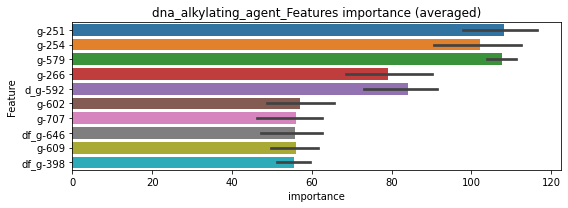

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232102	valid_1's binary_logloss: 0.0462095
[200]	training's binary_logloss: 0.00381662	valid_1's binary_logloss: 0.0213775
[300]	training's binary_logloss: 0.00107293	valid_1's binary_logloss: 0.016365
[400]	training's binary_logloss: 0.000513954	valid_1's binary_logloss: 0.0152727
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000480552	valid_1's binary_logloss: 0.0151777


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238388	valid_1's binary_logloss: 0.0418696
[200]	training's binary_logloss: 0.00416169	valid_1's binary_logloss: 0.0157338
[300]	training's binary_logloss: 0.00118968	valid_1's binary_logloss: 0.00971811
[400]	training's binary_logloss: 0.000565122	valid_1's binary_logloss: 0.00830177
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000377206	valid_1's binary_logloss: 0.00782814


dna_alkylating_agent logloss: 0.01150341424498254
dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125576	valid_1's binary_logloss: 0.361037
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0669232	valid_1's binary_logloss: 0.35301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117816	valid_1's binary_logloss: 0.35777


1 / 3 AUC score:0.808
y_Threshold: 0.1157178, Threshold: 0.1742693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 646 → Positive_corect_labels: 387/3228
p_label_rate: 0.0200904 Vs.target_rate: 0.01688, Num_p_label: 80.0, conf_0:0.15684, conf_1:0.19170
threshold: 0.1742693, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0660507	valid_1's binary_logloss: 0.347239


positive_y_label: 387.0/3228, y_label_rate: 0.1198885
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658261	valid_1's binary_logloss: 0.224348
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0249315	valid_1's binary_logloss: 0.210052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673473	valid_1's binary_logloss: 0.224029


2 / 3 AUC score:0.928
y_Threshold: 0.0726963, Threshold: 0.1742693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 216 → Positive_corect_labels: 279.0/3012
p_label_rate: 0.0243596 Vs.target_rate: 0.01688, Num_p_label: 97.0, conf_0:0.15684, conf_1:0.19170
threshold: 0.1742693, positive_p_label: 97.0/3982, p_label_rate: 0.0243596


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0260663	valid_1's binary_logloss: 0.212863


positive_y_label: 279.0/3012, y_label_rate: 0.0926295
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387359	valid_1's binary_logloss: 0.17409
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0134969	valid_1's binary_logloss: 0.166834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406461	valid_1's binary_logloss: 0.169086


3 / 3 AUC score:0.928
y_Threshold: 0.0573472, Threshold: 0.1742693, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 207.0/2868
p_label_rate: 0.0426921 Vs.target_rate: 0.01688, Num_p_label: 170.0, conf_0:0.15684, conf_1:0.19170
threshold: 0.1742693, positive_p_label: 170.0/3982, p_label_rate: 0.0426921


Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0246881	valid_1's binary_logloss: 0.164877


positive_y_label: 377.0/6850, y_label_rate: 0.0550365


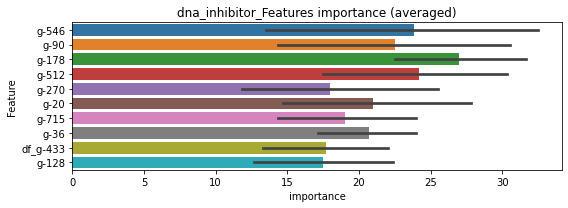

len(train_index) : 3425
len(valid_index) : 3425
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169413	valid_1's binary_logloss: 0.0757206
[200]	training's binary_logloss: 0.00336526	valid_1's binary_logloss: 0.0704646
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00314137	valid_1's binary_logloss: 0.0703308


len(train_index) : 3425
len(valid_index) : 3425
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170565	valid_1's binary_logloss: 0.0763695
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00747096	valid_1's binary_logloss: 0.0717331


dna_inhibitor logloss: 0.07103194391577801
dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825577	valid_1's binary_logloss: 0.172391
[200]	training's binary_logloss: 0.023715	valid_1's binary_logloss: 0.118295
[300]	training's binary_logloss: 0.00747272	valid_1's binary_logloss: 0.102176
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00501097	valid_1's binary_logloss: 0.100014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797162	valid_1's binary_logloss: 0.17356
[200]	training's binary_logloss: 0.0237735	valid_1's binary_logloss: 0.11981
[300]	training's binary_logloss: 0.0074487	valid_1's binary_logloss: 0.104568
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00411167	valid_1's binary_logloss: 0.10194


1 / 3 AUC score:0.984
y_Threshold: 0.0281597, Threshold: 0.0403118, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 199 → Positive_corect_labels: 619/3721
p_label_rate: 0.0200904 Vs.target_rate: 0.00508, Num_p_label: 80.0, conf_0:0.03628, conf_1:0.04434
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0403118
Num_p_label: 38.0, Expected: 20.2, Adj_threshold_2: 0.0503118
threshold: 0.0503118, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 619.0/3721, y_label_rate: 0.1663531
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790911	valid_1's binary_logloss: 0.14845
[200]	training's binary_logloss: 0.0221568	valid_1's binary_logloss: 0.0922631
[300]	training's binary_logloss: 0.00696994	valid_1's binary_logloss: 0.0735569
[400]	training's binary_logloss: 0.0029295	valid_1's binary_logloss: 0.0667487
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00233526	valid_1's binary_logloss: 0.0656698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704714	valid_1's binary_logloss: 0.157165
[200]	training's binary_logloss: 0.0197662	valid_1's binary_logloss: 0.0990983
[300]	training's binary_logloss: 0.00637646	valid_1's binary_logloss: 0.0793265
[400]	training's binary_logloss: 0.00275405	valid_1's binary_logloss: 0.0728918
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00275405	valid_1's binary_logloss: 0.0728918


2 / 3 AUC score:0.994
y_Threshold: 0.0476181, Threshold: 0.0503118, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 596.0/3675
p_label_rate: 0.0087896 Vs.target_rate: 0.00508, Num_p_label: 35.0, conf_0:0.04528, conf_1:0.05534
threshold: 0.0503118, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 596.0/3675, y_label_rate: 0.1621769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691281	valid_1's binary_logloss: 0.14385
[200]	training's binary_logloss: 0.0179617	valid_1's binary_logloss: 0.0865885
[300]	training's binary_logloss: 0.00554002	valid_1's binary_logloss: 0.0657939
[400]	training's binary_logloss: 0.00244714	valid_1's binary_logloss: 0.0597763
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00168878	valid_1's binary_logloss: 0.057792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723393	valid_1's binary_logloss: 0.148364
[200]	training's binary_logloss: 0.0180574	valid_1's binary_logloss: 0.0894145
[300]	training's binary_logloss: 0.00564734	valid_1's binary_logloss: 0.0745803
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0031339	valid_1's binary_logloss: 0.071415


3 / 3 AUC score:0.993
y_Threshold: 0.0483418, Threshold: 0.0503118, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 578.0/3639
p_label_rate: 0.0148167 Vs.target_rate: 0.00508, Num_p_label: 59.0, conf_0:0.04528, conf_1:0.05534
threshold: 0.0503118, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 637.0/7621, y_label_rate: 0.0835848


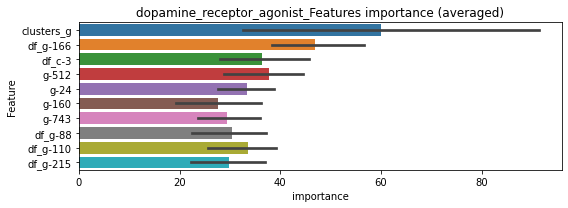

len(train_index) : 3810
len(valid_index) : 3811
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438617	valid_1's binary_logloss: 0.102531
[200]	training's binary_logloss: 0.012042	valid_1's binary_logloss: 0.0705427
[300]	training's binary_logloss: 0.00385667	valid_1's binary_logloss: 0.0624454
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00344883	valid_1's binary_logloss: 0.0619973


len(train_index) : 3811
len(valid_index) : 3810
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044037	valid_1's binary_logloss: 0.0992069
[200]	training's binary_logloss: 0.012043	valid_1's binary_logloss: 0.0670852
[300]	training's binary_logloss: 0.00387042	valid_1's binary_logloss: 0.0582169
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00255923	valid_1's binary_logloss: 0.0571846


dopamine_receptor_agonist logloss: 0.05959124676077488
dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701


neg labels: 3289 → selected neg labels: 3221


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144193	valid_1's binary_logloss: 0.384587
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.12552	valid_1's binary_logloss: 0.381243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141499	valid_1's binary_logloss: 0.371644


1 / 3 AUC score:0.770
y_Threshold: 0.1565078, Threshold: 0.2122565, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 749 → Positive_corect_labels: 334/3116
p_label_rate: 0.0200904 Vs.target_rate: 0.01780, Num_p_label: 80.0, conf_0:0.19103, conf_1:0.23348
threshold: 0.2122565, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0952394	valid_1's binary_logloss: 0.365962


positive_y_label: 334.0/3116, y_label_rate: 0.1071887
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697926	valid_1's binary_logloss: 0.233
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0447998	valid_1's binary_logloss: 0.226695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671976	valid_1's binary_logloss: 0.235844


2 / 3 AUC score:0.902
y_Threshold: 0.0940040, Threshold: 0.2122565, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 219.0/2886
p_label_rate: 0.0032647 Vs.target_rate: 0.01780, Num_p_label: 13.0, conf_0:0.19103, conf_1:0.23348
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_1: 0.2122565
Num_p_label: 15.0, Expected: 70.9, Adj_threshold_2: 0.2022565
Num_p_label: 17.0, Expected: 70.9, Adj_threshold_3: 0.1922565


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0238259	valid_1's binary_logloss: 0.227194


Num_p_label: 23.0, Expected: 70.9, Adj_threshold_4: 0.1822565
Num_p_label: 29.0, Expected: 70.9, Adj_threshold_5: 0.1722565
Num_p_label: 46.0, Expected: 70.9, Adj_threshold_6: 0.1622565
threshold: 0.1622565, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 219.0/2886, y_label_rate: 0.0758836
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379808	valid_1's binary_logloss: 0.174956
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0224795	valid_1's binary_logloss: 0.169084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389955	valid_1's binary_logloss: 0.163363


3 / 3 AUC score:0.927
y_Threshold: 0.0697985, Threshold: 0.1622565, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 150.0/2748
p_label_rate: 0.0030136 Vs.target_rate: 0.01780, Num_p_label: 12.0, conf_0:0.14603, conf_1:0.17848
Num_p_label: 12.0, Expected: 70.9, Adj_threshold_1: 0.1622565
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_2: 0.1522565
Num_p_label: 22.0, Expected: 70.9, Adj_threshold_3: 0.1422565
Num_p_label: 32.0, Expected: 70.9, Adj_threshold_4: 0.1322565


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0229002	valid_1's binary_logloss: 0.158526


Num_p_label: 41.0, Expected: 70.9, Adj_threshold_5: 0.1222565
threshold: 0.1222565, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 191.0/6730, y_label_rate: 0.0283804


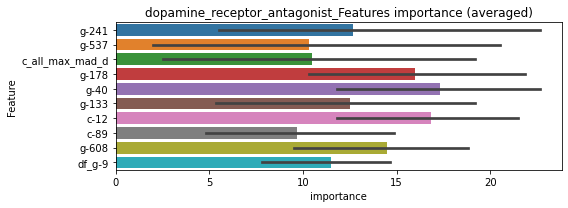

len(train_index) : 3365
len(valid_index) : 3365
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130043	valid_1's binary_logloss: 0.0846784


len(train_index) : 3365
len(valid_index) : 3365


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00718231	valid_1's binary_logloss: 0.0826858


================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132044	valid_1's binary_logloss: 0.0877736


dopamine_receptor_antagonist logloss: 0.08516706122350144


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.013419	valid_1's binary_logloss: 0.0876483


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452915	valid_1's binary_logloss: 0.115063
[200]	training's binary_logloss: 0.0089616	valid_1's binary_logloss: 0.0896601
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00641111	valid_1's binary_logloss: 0.087936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471647	valid_1's binary_logloss: 0.119365
[200]	training's binary_logloss: 0.0093664	valid_1's binary_logloss: 0.0884289
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00387055	valid_1's binary_logloss: 0.0840877


1 / 3 AUC score:0.986
y_Threshold: 0.0362368, Threshold: 0.2102844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 625/3730
p_label_rate: 0.0200904 Vs.target_rate: 0.01411, Num_p_label: 80.0, conf_0:0.18926, conf_1:0.23131
threshold: 0.2102844, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 625.0/3730, y_label_rate: 0.1675603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392497	valid_1's binary_logloss: 0.0882555
[200]	training's binary_logloss: 0.00694799	valid_1's binary_logloss: 0.0556427
[300]	training's binary_logloss: 0.00217464	valid_1's binary_logloss: 0.0495617
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00131342	valid_1's binary_logloss: 0.0480476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358409	valid_1's binary_logloss: 0.104936
[200]	training's binary_logloss: 0.0059957	valid_1's binary_logloss: 0.0830524


2 / 3 AUC score:0.994
y_Threshold: 0.0756498, Threshold: 0.2102844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 595.0/3670
p_label_rate: 0.0313913 Vs.target_rate: 0.01411, Num_p_label: 125.0, conf_0:0.18926, conf_1:0.23131


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0044525	valid_1's binary_logloss: 0.0817982


threshold: 0.2102844, positive_p_label: 125.0/3982, p_label_rate: 0.0313913
positive_y_label: 595.0/3670, y_label_rate: 0.1621253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330912	valid_1's binary_logloss: 0.0724165
[200]	training's binary_logloss: 0.00526261	valid_1's binary_logloss: 0.0436196
[300]	training's binary_logloss: 0.00158451	valid_1's binary_logloss: 0.0385483
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00144287	valid_1's binary_logloss: 0.0382145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340654	valid_1's binary_logloss: 0.0690509
[200]	training's binary_logloss: 0.00587608	valid_1's binary_logloss: 0.0371666
[300]	training's binary_logloss: 0.00182173	valid_1's binary_logloss: 0.0303358
[400]	training's binary_logloss: 0.000893976	valid_1's binary_logloss: 0.028305
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000936392	valid_1's binary_logloss: 0.0282503


3 / 3 AUC score:0.998
y_Threshold: 0.0953908, Threshold: 0.2102844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 582.0/3644
p_label_rate: 0.0328980 Vs.target_rate: 0.01411, Num_p_label: 131.0, conf_0:0.18926, conf_1:0.23131
threshold: 0.2102844, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 713.0/7626, y_label_rate: 0.0934959


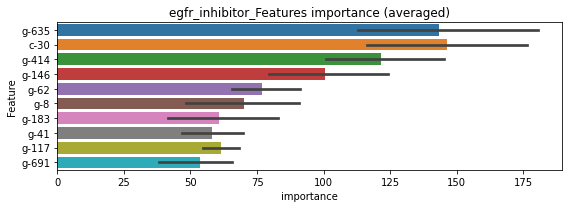

len(train_index) : 3813
len(valid_index) : 3813
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204118	valid_1's binary_logloss: 0.0507563
[200]	training's binary_logloss: 0.00339475	valid_1's binary_logloss: 0.031589
[300]	training's binary_logloss: 0.00104907	valid_1's binary_logloss: 0.0277417
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000658084	valid_1's binary_logloss: 0.0265093


len(train_index) : 3813
len(valid_index) : 3813
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191922	valid_1's binary_logloss: 0.0646113
[200]	training's binary_logloss: 0.00309604	valid_1's binary_logloss: 0.0506308
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00147392	valid_1's binary_logloss: 0.0485729


egfr_inhibitor logloss: 0.03754107258611463
elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200268	valid_1's binary_logloss: 0.0248447
[200]	training's binary_logloss: 0.00223064	valid_1's binary_logloss: 0.00444487
[300]	training's binary_logloss: 0.000627154	valid_1's binary_logloss: 0.00162258
[400]	training's binary_logloss: 0.000341568	valid_1's binary_logloss: 0.000983879
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000290668	valid_1's binary_logloss: 0.000878278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199684	valid_1's binary_logloss: 0.0240622
[200]	training's binary_logloss: 0.00216442	valid_1's binary_logloss: 0.00447649
[300]	training's binary_logloss: 0.000615583	valid_1's binary_logloss: 0.00215029
[400]	training's binary_logloss: 0.000338254	valid_1's binary_logloss: 0.00153746
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000294002	valid_1's binary_logloss: 0.001

1 / 3 AUC score:1.000
y_Threshold: 0.0010032, Threshold: 0.0015920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00143, conf_1:0.00175
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015920
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0115920
threshold: 0.0115920, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020141	valid_1's binary_logloss: 0.0249397
[200]	training's binary_logloss: 0.00213179	valid_1's binary_logloss: 0.00412444
[300]	training's binary_logloss: 0.000613514	valid_1's binary_logloss: 0.00164756
[400]	training's binary_logloss: 0.000343421	valid_1's binary_logloss: 0.00104866
[500]	training's binary_logloss: 0.000292958	valid_1's binary_logloss: 0.000941602
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000287587	valid_1's binary_logloss: 0.000933324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198352	valid_1's binary_logloss: 0.0233663
[200]	training's binary_logloss: 0.0020821	valid_1's binary_logloss: 0.00382868
[300]	training's binary_logloss: 0.000604224	valid_1's binary_logloss: 0.00167618
[400]	training's binary_logloss: 0.000335374	valid_1's binary_logloss: 0.00120007
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0516311, Threshold: 0.0115920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.01043, conf_1:0.01275
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.0115920
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0215920
threshold: 0.0215920, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020141	valid_1's binary_logloss: 0.0249397
[200]	training's binary_logloss: 0.00213179	valid_1's binary_logloss: 0.00412444
[300]	training's binary_logloss: 0.000613514	valid_1's binary_logloss: 0.00164756
[400]	training's binary_logloss: 0.000343421	valid_1's binary_logloss: 0.00104866
[500]	training's binary_logloss: 0.000292958	valid_1's binary_logloss: 0.000941602
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000287587	valid_1's binary_logloss: 0.000933324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198352	valid_1's binary_logloss: 0.0233663
[200]	training's binary_logloss: 0.0020821	valid_1's binary_logloss: 0.00382868
[300]	training's binary_logloss: 0.000604224	valid_1's binary_logloss: 0.00167618
[400]	training's binary_logloss: 0.000335374	valid_1's binary_logloss: 0.00120007
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0516311, Threshold: 0.0215920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.01943, conf_1:0.02375
threshold: 0.0215920, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


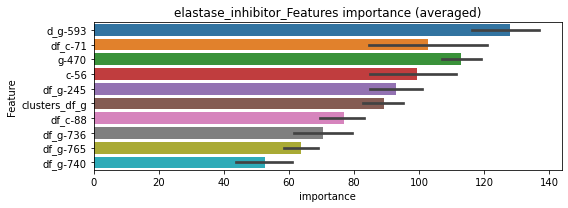

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105418	valid_1's binary_logloss: 0.0148704
[200]	training's binary_logloss: 0.00109452	valid_1's binary_logloss: 0.00465841
[300]	training's binary_logloss: 0.000309162	valid_1's binary_logloss: 0.00372849
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000270026	valid_1's binary_logloss: 0.00368273


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112374	valid_1's binary_logloss: 0.0155721
[200]	training's binary_logloss: 0.0012332	valid_1's binary_logloss: 0.00449379
[300]	training's binary_logloss: 0.00032466	valid_1's binary_logloss: 0.00273949
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000286531	valid_1's binary_logloss: 0.0026586


elastase_inhibitor logloss: 0.0031706628496269602
erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265418	valid_1's binary_logloss: 0.0401646
[200]	training's binary_logloss: 0.0034312	valid_1's binary_logloss: 0.0100307
[300]	training's binary_logloss: 0.000953649	valid_1's binary_logloss: 0.00508753
[400]	training's binary_logloss: 0.000486309	valid_1's binary_logloss: 0.00373011
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000421793	valid_1's binary_logloss: 0.00346469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271551	valid_1's binary_logloss: 0.0351304
[200]	training's binary_logloss: 0.00346619	valid_1's binary_logloss: 0.00714722
[300]	training's binary_logloss: 0.000967331	valid_1's binary_logloss: 0.00288062
[400]	training's binary_logloss: 0.000493931	valid_1's binary_logloss: 0.00187288
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000387156	valid_1's binary_logloss: 0.0016247

1 / 3 AUC score:1.000
y_Threshold: 0.0018080, Threshold: 0.0026800, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084, Num_p_label: 80.0, conf_0:0.00241, conf_1:0.00295
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0026800
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_2: 0.0126800
threshold: 0.0126800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265521	valid_1's binary_logloss: 0.0417697
[200]	training's binary_logloss: 0.00336298	valid_1's binary_logloss: 0.0102244
[300]	training's binary_logloss: 0.000927886	valid_1's binary_logloss: 0.00474577
[400]	training's binary_logloss: 0.000479574	valid_1's binary_logloss: 0.00349815
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00039717	valid_1's binary_logloss: 0.0032067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269015	valid_1's binary_logloss: 0.0344908
[200]	training's binary_logloss: 0.00340475	valid_1's binary_logloss: 0.00680429
[300]	training's binary_logloss: 0.000954237	valid_1's binary_logloss: 0.00273063
[400]	training's binary_logloss: 0.000488065	valid_1's binary_logloss: 0.00172904
[500]	training's binary_logloss: 0.000376443	valid_1's binary_logloss: 0.00149698
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0443131, Threshold: 0.0126800, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00084, Num_p_label: 15.0, conf_0:0.01141, conf_1:0.01395
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_1: 0.0126800
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_2: 0.0226800
threshold: 0.0226800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265521	valid_1's binary_logloss: 0.0417697
[200]	training's binary_logloss: 0.00336298	valid_1's binary_logloss: 0.0102244
[300]	training's binary_logloss: 0.000927886	valid_1's binary_logloss: 0.00474577
[400]	training's binary_logloss: 0.000479574	valid_1's binary_logloss: 0.00349815
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00039717	valid_1's binary_logloss: 0.0032067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269015	valid_1's binary_logloss: 0.0344908
[200]	training's binary_logloss: 0.00340475	valid_1's binary_logloss: 0.00680429
[300]	training's binary_logloss: 0.000954237	valid_1's binary_logloss: 0.00273063
[400]	training's binary_logloss: 0.000488065	valid_1's binary_logloss: 0.00172904
[500]	training's binary_logloss: 0.000376443	valid_1's binary_logloss: 0.00149698
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0443131, Threshold: 0.0226800, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00084, Num_p_label: 5.0, conf_0:0.02041, conf_1:0.02495
threshold: 0.0226800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


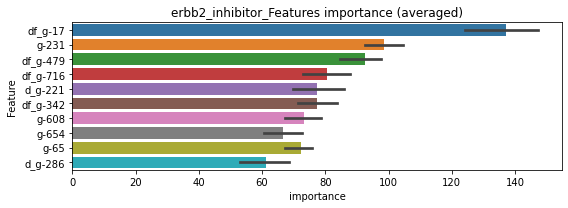

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141855	valid_1's binary_logloss: 0.0239919
[200]	training's binary_logloss: 0.00176287	valid_1's binary_logloss: 0.00878783
[300]	training's binary_logloss: 0.000476112	valid_1's binary_logloss: 0.00674537
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000435354	valid_1's binary_logloss: 0.0066877


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141673	valid_1's binary_logloss: 0.0189974
[200]	training's binary_logloss: 0.00182498	valid_1's binary_logloss: 0.00378973
[300]	training's binary_logloss: 0.00050064	valid_1's binary_logloss: 0.00163288
[400]	training's binary_logloss: 0.000252693	valid_1's binary_logloss: 0.00117784
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000198292	valid_1's binary_logloss: 0.00108963


erbb2_inhibitor logloss: 0.0038886642472413546
estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095


neg labels: 3289 → selected neg labels: 3265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844661	valid_1's binary_logloss: 0.197634
[200]	training's binary_logloss: 0.0267766	valid_1's binary_logloss: 0.156123
[300]	training's binary_logloss: 0.00962785	valid_1's binary_logloss: 0.145716
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00604396	valid_1's binary_logloss: 0.144288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885871	valid_1's binary_logloss: 0.195852
[200]	training's binary_logloss: 0.0267108	valid_1's binary_logloss: 0.147423
[300]	training's binary_logloss: 0.00909153	valid_1's binary_logloss: 0.133056
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00717951	valid_1's binary_logloss: 0.131733


1 / 3 AUC score:0.975
y_Threshold: 0.0364703, Threshold: 0.0532820, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 227 → Positive_corect_labels: 605/3691
p_label_rate: 0.0200904 Vs.target_rate: 0.00663, Num_p_label: 80.0, conf_0:0.04795, conf_1:0.05861
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0532820
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_2: 0.0632820
threshold: 0.0632820, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 605.0/3691, y_label_rate: 0.1639122
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730353	valid_1's binary_logloss: 0.170049
[200]	training's binary_logloss: 0.0200922	valid_1's binary_logloss: 0.12269
[300]	training's binary_logloss: 0.00634801	valid_1's binary_logloss: 0.108215
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00480439	valid_1's binary_logloss: 0.106209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709008	valid_1's binary_logloss: 0.165966
[200]	training's binary_logloss: 0.0204819	valid_1's binary_logloss: 0.122159
[300]	training's binary_logloss: 0.0073251	valid_1's binary_logloss: 0.109088
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00388275	valid_1's binary_logloss: 0.105225


2 / 3 AUC score:0.992
y_Threshold: 0.0587902, Threshold: 0.0632820, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 569.0/3619
p_label_rate: 0.0210949 Vs.target_rate: 0.00663, Num_p_label: 84.0, conf_0:0.05695, conf_1:0.06961
Num_p_label: 84.0, Expected: 26.4, Adj_threshold_1: 0.0632820
Num_p_label: 60.0, Expected: 26.4, Adj_threshold_2: 0.0732820
Num_p_label: 38.0, Expected: 26.4, Adj_threshold_3: 0.0832820
threshold: 0.0832820, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 569.0/3619, y_label_rate: 0.1572258
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666584	valid_1's binary_logloss: 0.149914
[200]	training's binary_logloss: 0.017648	valid_1's binary_logloss: 0.10066
[300]	training's binary_logloss: 0.00576038	valid_1's binary_logloss: 0.0851125
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00451396	valid_1's binary_logloss: 0.0830204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633617	valid_1's binary_logloss: 0.160203
[200]	training's binary_logloss: 0.0167815	valid_1's binary_logloss: 0.11831
[300]	training's binary_logloss: 0.00558882	valid_1's binary_logloss: 0.109757
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00456256	valid_1's binary_logloss: 0.108763


3 / 3 AUC score:0.992
y_Threshold: 0.0538643, Threshold: 0.0832820, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 535.0/3551
p_label_rate: 0.0102963 Vs.target_rate: 0.00663, Num_p_label: 41.0, conf_0:0.07495, conf_1:0.09161
threshold: 0.0832820, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 576.0/7533, y_label_rate: 0.0764636


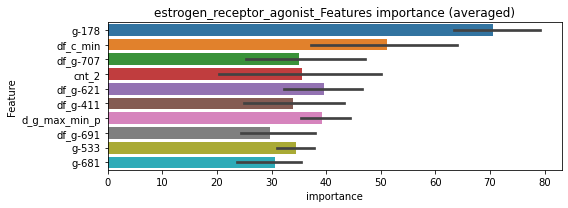

len(train_index) : 3766
len(valid_index) : 3767
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334437	valid_1's binary_logloss: 0.100335
[200]	training's binary_logloss: 0.00848268	valid_1's binary_logloss: 0.0790351
[300]	training's binary_logloss: 0.00276355	valid_1's binary_logloss: 0.0760212
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00264146	valid_1's binary_logloss: 0.0759089


len(train_index) : 3767
len(valid_index) : 3766
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379119	valid_1's binary_logloss: 0.0914331
[200]	training's binary_logloss: 0.00994668	valid_1's binary_logloss: 0.0709323
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00458692	valid_1's binary_logloss: 0.0676169


estrogen_receptor_agonist logloss: 0.07176347775197714
estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409416	valid_1's binary_logloss: 0.0771331
[200]	training's binary_logloss: 0.00728597	valid_1's binary_logloss: 0.030575
[300]	training's binary_logloss: 0.00211096	valid_1's binary_logloss: 0.0209266
[400]	training's binary_logloss: 0.0010196	valid_1's binary_logloss: 0.0178969
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000779289	valid_1's binary_logloss: 0.0171282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435137	valid_1's binary_logloss: 0.0720324
[200]	training's binary_logloss: 0.00791074	valid_1's binary_logloss: 0.0254622
[300]	training's binary_logloss: 0.0022997	valid_1's binary_logloss: 0.0147828
[400]	training's binary_logloss: 0.00108785	valid_1's binary_logloss: 0.0116194
[500]	training's binary_logloss: 0.00069131	valid_1's binary_logloss: 0.0100416
[600]	training's binary_logloss: 0.00055158	val

1 / 3 AUC score:1.000
y_Threshold: 0.0051128, Threshold: 0.0088462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00796, conf_1:0.00973
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0088462
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.0188462
Num_p_label: 6.0, Expected: 8.0, Adj_threshold_3: 0.0288462
threshold: 0.0288462, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398498	valid_1's binary_logloss: 0.0746127
[200]	training's binary_logloss: 0.00681154	valid_1's binary_logloss: 0.0305352
[300]	training's binary_logloss: 0.0020004	valid_1's binary_logloss: 0.0208921
[400]	training's binary_logloss: 0.000980081	valid_1's binary_logloss: 0.0180801
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000747086	valid_1's binary_logloss: 0.0172206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438738	valid_1's binary_logloss: 0.06852
[200]	training's binary_logloss: 0.0078005	valid_1's binary_logloss: 0.0214468
[300]	training's binary_logloss: 0.00224947	valid_1's binary_logloss: 0.0122891
[400]	training's binary_logloss: 0.0010676	valid_1's binary_logloss: 0.00907307
[500]	training's binary_logloss: 0.000678988	valid_1's binary_logloss: 0.00772403
Early stopping, best iteration is:
[505]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.0243062, Threshold: 0.0288462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0065294 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.02596, conf_1:0.03173
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.0288462
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_2: 0.0388462
threshold: 0.0388462, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410479	valid_1's binary_logloss: 0.0729967
[200]	training's binary_logloss: 0.00732723	valid_1's binary_logloss: 0.025602
[300]	training's binary_logloss: 0.00216503	valid_1's binary_logloss: 0.0144177
[400]	training's binary_logloss: 0.0010269	valid_1's binary_logloss: 0.0108682
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0010269	valid_1's binary_logloss: 0.0108682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413414	valid_1's binary_logloss: 0.0647941
[200]	training's binary_logloss: 0.00713121	valid_1's binary_logloss: 0.0209824
[300]	training's binary_logloss: 0.00209919	valid_1's binary_logloss: 0.0109796
[400]	training's binary_logloss: 0.00102201	valid_1's binary_logloss: 0.00854065
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000856204	valid_1's binary_logloss: 0.0081017


3 / 3 AUC score:1.000
y_Threshold: 0.0333980, Threshold: 0.0388462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0072828 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.03496, conf_1:0.04273
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.0388462
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_2: 0.0488462
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0588462
threshold: 0.0588462, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 669.0/7783, y_label_rate: 0.0859566


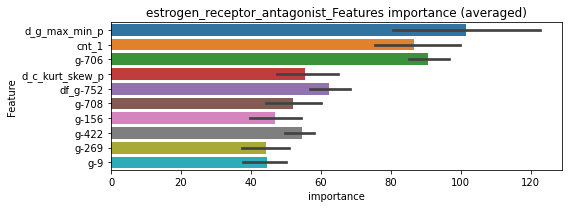

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240422	valid_1's binary_logloss: 0.0449816
[200]	training's binary_logloss: 0.00428631	valid_1's binary_logloss: 0.0214003
[300]	training's binary_logloss: 0.00117696	valid_1's binary_logloss: 0.0166688
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000671615	valid_1's binary_logloss: 0.0159849


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236142	valid_1's binary_logloss: 0.0411217
[200]	training's binary_logloss: 0.00447348	valid_1's binary_logloss: 0.0183283
[300]	training's binary_logloss: 0.00130525	valid_1's binary_logloss: 0.0135996
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000650726	valid_1's binary_logloss: 0.0126645


estrogen_receptor_antagonist logloss: 0.014324913436181351
faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365995	valid_1's binary_logloss: 0.0561292
[200]	training's binary_logloss: 0.00592431	valid_1's binary_logloss: 0.0159955
[300]	training's binary_logloss: 0.00163354	valid_1's binary_logloss: 0.00689797
[400]	training's binary_logloss: 0.000780933	valid_1's binary_logloss: 0.00429074
[500]	training's binary_logloss: 0.000515722	valid_1's binary_logloss: 0.00326375
[600]	training's binary_logloss: 0.00045487	valid_1's binary_logloss: 0.00303437
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000448341	valid_1's binary_logloss: 0.00301133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358409	valid_1's binary_logloss: 0.0552599
[200]	training's binary_logloss: 0.0054195	valid_1's binary_logloss: 0.0163155
[300]	training's binary_logloss: 0.00150804	valid_1's binary_logloss: 0.0100217
Early stopping, best iteration is:
[37

1 / 3 AUC score:1.000
y_Threshold: 0.0078910, Threshold: 0.0205434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.01849, conf_1:0.02260
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0205434
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.0305434
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.0405434
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.0505434
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.0605434
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.0705434
threshold: 0.0705434, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345133	valid_1's binary_logloss: 0.0517749
[200]	training's binary_logloss: 0.00518201	valid_1's binary_logloss: 0.0114879
[300]	training's binary_logloss: 0.00144331	valid_1's binary_logloss: 0.00451839
[400]	training's binary_logloss: 0.000719758	valid_1's binary_logloss: 0.00281012
[500]	training's binary_logloss: 0.000479541	valid_1's binary_logloss: 0.00212251
[600]	training's binary_logloss: 0.00043833	valid_1's binary_logloss: 0.00201771
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00043833	valid_1's binary_logloss: 0.00201771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334049	valid_1's binary_logloss: 0.050756
[200]	training's binary_logloss: 0.00491104	valid_1's binary_logloss: 0.0127408
[300]	training's binary_logloss: 0.00140563	valid_1's binary_logloss: 0.0064502
[400]	training's binary_logloss: 0.0006

2 / 3 AUC score:1.000
y_Threshold: 0.0661752, Threshold: 0.0705434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0135610 Vs.target_rate: 0.00151, Num_p_label: 54.0, conf_0:0.06349, conf_1:0.07760
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_1: 0.0705434
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.0805434
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.0905434
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.1005434
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_5: 0.1105434
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_6: 0.1205434
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.1305434
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.1405434
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_9: 0.1505434
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_10: 0.1605434
threshold: 0.1705434, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345133	valid_1's binary_logloss: 0.0517749
[200]	training's binary_logloss: 0.00518201	valid_1's binary_logloss: 0.0114879
[300]	training's binary_logloss: 0.00144331	valid_1's binary_logloss: 0.00451839
[400]	training's binary_logloss: 0.000719758	valid_1's binary_logloss: 0.00281012
[500]	training's binary_logloss: 0.000479541	valid_1's binary_logloss: 0.00212251
[600]	training's binary_logloss: 0.00043833	valid_1's binary_logloss: 0.00201771
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00043833	valid_1's binary_logloss: 0.00201771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334049	valid_1's binary_logloss: 0.050756
[200]	training's binary_logloss: 0.00491104	valid_1's binary_logloss: 0.0127408
[300]	training's binary_logloss: 0.00140563	valid_1's binary_logloss: 0.0064502
[400]	training's binary_logloss: 0.0006

3 / 3 AUC score:1.000
y_Threshold: 0.0661752, Threshold: 0.1705434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0052737 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.15349, conf_1:0.18760
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.1705434
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.1805434
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.1905434
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.2005434
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.2105434
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_6: 0.2205434
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.2305434
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.2405434
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.2505434
threshold: 0.2505434, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


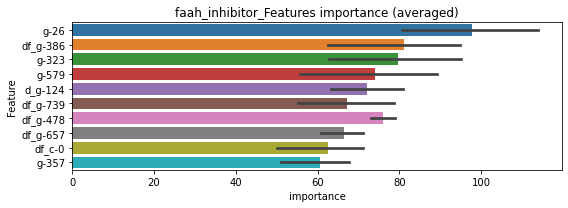

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196211	valid_1's binary_logloss: 0.035689
[200]	training's binary_logloss: 0.00302444	valid_1's binary_logloss: 0.0151255
[300]	training's binary_logloss: 0.000835311	valid_1's binary_logloss: 0.012037
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000762256	valid_1's binary_logloss: 0.0119497


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210053	valid_1's binary_logloss: 0.0326862
[200]	training's binary_logloss: 0.00311345	valid_1's binary_logloss: 0.0106898
[300]	training's binary_logloss: 0.000858427	valid_1's binary_logloss: 0.00726335
[400]	training's binary_logloss: 0.000406298	valid_1's binary_logloss: 0.00638881
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000309466	valid_1's binary_logloss: 0.00615418


faah_inhibitor logloss: 0.00905230776012025
farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184701	valid_1's binary_logloss: 0.021298
[200]	training's binary_logloss: 0.00178768	valid_1's binary_logloss: 0.00296539
[300]	training's binary_logloss: 0.000484038	valid_1's binary_logloss: 0.00108816
[400]	training's binary_logloss: 0.000280866	valid_1's binary_logloss: 0.000728537
[500]	training's binary_logloss: 0.000237804	valid_1's binary_logloss: 0.000648464
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000234259	valid_1's binary_logloss: 0.000641939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181479	valid_1's binary_logloss: 0.0219205
[200]	training's binary_logloss: 0.00176954	valid_1's binary_logloss: 0.00373732
[300]	training's binary_logloss: 0.000484672	valid_1's binary_logloss: 0.00191087
[400]	training's binary_logloss: 0.000281531	valid_1's binary_logloss: 0.00162471
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0013680, Threshold: 0.0031075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00280, conf_1:0.00342
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0031075
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.0131075
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.0231075
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.0331075
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.0431075
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.0531075
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.0631075
threshold: 0.0631075, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018294	valid_1's binary_logloss: 0.0201252
[200]	training's binary_logloss: 0.00171371	valid_1's binary_logloss: 0.00227976
[300]	training's binary_logloss: 0.000458126	valid_1's binary_logloss: 0.000690732
[400]	training's binary_logloss: 0.000268011	valid_1's binary_logloss: 0.000431553
[500]	training's binary_logloss: 0.000228138	valid_1's binary_logloss: 0.000375675
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000225446	valid_1's binary_logloss: 0.000372182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183295	valid_1's binary_logloss: 0.0215814
[200]	training's binary_logloss: 0.00169948	valid_1's binary_logloss: 0.00328229
[300]	training's binary_logloss: 0.000450354	valid_1's binary_logloss: 0.00164869
[400]	training's binary_logloss: 0.000265663	valid_1's binary_logloss: 0.00139472


2 / 3 AUC score:1.000
y_Threshold: 0.0793786, Threshold: 0.0631075, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00023612	valid_1's binary_logloss: 0.00135022


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0092918 Vs.target_rate: 0.00076, Num_p_label: 37.0, conf_0:0.05680, conf_1:0.06942
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_1: 0.0631075
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.0731075
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_3: 0.0831075
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_4: 0.0931075
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.1031075
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_6: 0.1131075
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_7: 0.1231075
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_8: 0.1331075
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_9: 0.1431075
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_10: 0.1531075
threshold: 0.1631075, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018294	valid_1's binary_logloss: 0.0201252
[200]	training's binary_logloss: 0.00171371	valid_1's binary_logloss: 0.00227976
[300]	training's binary_logloss: 0.000458126	valid_1's binary_logloss: 0.000690732
[400]	training's binary_logloss: 0.000268011	valid_1's binary_logloss: 0.000431553
[500]	training's binary_logloss: 0.000228138	valid_1's binary_logloss: 0.000375675
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000225446	valid_1's binary_logloss: 0.000372182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183295	valid_1's binary_logloss: 0.0215814
[200]	training's binary_logloss: 0.00169948	valid_1's binary_logloss: 0.00328229
[300]	training's binary_logloss: 0.000450354	valid_1's binary_logloss: 0.00164869
[400]	training's binary_logloss: 0.000265663	valid_1's binary_logloss: 0.00139472
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0793786, Threshold: 0.1631075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.14680, conf_1:0.17942
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.1631075
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.1731075
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.1831075
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.1931075
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.2031075
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.2131075
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.2231075
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.2331075
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_9: 0.2431075
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.2531075
threshold: 0.2631075, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7793, y_label_rate: 0.0858463


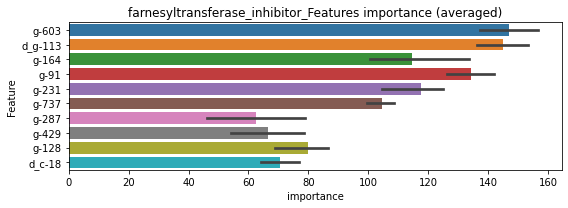

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0099762	valid_1's binary_logloss: 0.0169385
[200]	training's binary_logloss: 0.000959526	valid_1's binary_logloss: 0.00777282
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000436888	valid_1's binary_logloss: 0.00737586


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102973	valid_1's binary_logloss: 0.013679
[200]	training's binary_logloss: 0.00103181	valid_1's binary_logloss: 0.00366
[300]	training's binary_logloss: 0.000265569	valid_1's binary_logloss: 0.00277428
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000194683	valid_1's binary_logloss: 0.00263634


farnesyltransferase_inhibitor logloss: 0.005006405183285933
fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301924	valid_1's binary_logloss: 0.0467868
[200]	training's binary_logloss: 0.00412181	valid_1's binary_logloss: 0.0141945
[300]	training's binary_logloss: 0.00112441	valid_1's binary_logloss: 0.00781299
[400]	training's binary_logloss: 0.000565783	valid_1's binary_logloss: 0.00572461
[500]	training's binary_logloss: 0.000411281	valid_1's binary_logloss: 0.00506204
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000401229	valid_1's binary_logloss: 0.00500891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315984	valid_1's binary_logloss: 0.0411881
[200]	training's binary_logloss: 0.00428658	valid_1's binary_logloss: 0.00881334
[300]	training's binary_logloss: 0.00117375	valid_1's binary_logloss: 0.0034229
[400]	training's binary_logloss: 0.000588373	valid_1's binary_logloss: 0.00211237
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0032312, Threshold: 0.0043814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00394, conf_1:0.00482
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0043814
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.0143814
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.0243814
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.0343814
threshold: 0.0343814, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281684	valid_1's binary_logloss: 0.0442197
[200]	training's binary_logloss: 0.00365583	valid_1's binary_logloss: 0.0156808
[300]	training's binary_logloss: 0.00103703	valid_1's binary_logloss: 0.00941655
[400]	training's binary_logloss: 0.00053274	valid_1's binary_logloss: 0.00738967
[500]	training's binary_logloss: 0.000403256	valid_1's binary_logloss: 0.00681953
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000389826	valid_1's binary_logloss: 0.00673453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290939	valid_1's binary_logloss: 0.0360421
[200]	training's binary_logloss: 0.00383677	valid_1's binary_logloss: 0.00630036
[300]	training's binary_logloss: 0.0010816	valid_1's binary_logloss: 0.00225752
[400]	training's binary_logloss: 0.000547284	valid_1's binary_logloss: 0.00133073
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0363343, Threshold: 0.0343814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0075339 Vs.target_rate: 0.00105, Num_p_label: 30.0, conf_0:0.03094, conf_1:0.03782
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_1: 0.0343814
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_2: 0.0443814
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.0543814
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.0643814
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.0743814
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_6: 0.0843814
threshold: 0.0843814, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281684	valid_1's binary_logloss: 0.0442197
[200]	training's binary_logloss: 0.00365583	valid_1's binary_logloss: 0.0156808
[300]	training's binary_logloss: 0.00103703	valid_1's binary_logloss: 0.00941655
[400]	training's binary_logloss: 0.00053274	valid_1's binary_logloss: 0.00738967
[500]	training's binary_logloss: 0.000403256	valid_1's binary_logloss: 0.00681953
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000389826	valid_1's binary_logloss: 0.00673453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290939	valid_1's binary_logloss: 0.0360421
[200]	training's binary_logloss: 0.00383677	valid_1's binary_logloss: 0.00630036
[300]	training's binary_logloss: 0.0010816	valid_1's binary_logloss: 0.00225752
[400]	training's binary_logloss: 0.000547284	valid_1's binary_logloss: 0.00133073
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0363343, Threshold: 0.0843814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.07594, conf_1:0.09282
threshold: 0.0843814, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


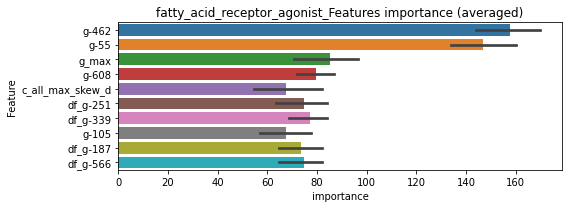

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171891	valid_1's binary_logloss: 0.026726
[200]	training's binary_logloss: 0.00222086	valid_1's binary_logloss: 0.00842963
[300]	training's binary_logloss: 0.000593725	valid_1's binary_logloss: 0.00622949
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000401909	valid_1's binary_logloss: 0.00605406


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180096	valid_1's binary_logloss: 0.0238975
[200]	training's binary_logloss: 0.00252554	valid_1's binary_logloss: 0.0054426
[300]	training's binary_logloss: 0.000668264	valid_1's binary_logloss: 0.00262986
[400]	training's binary_logloss: 0.000322562	valid_1's binary_logloss: 0.00210911
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000265698	valid_1's binary_logloss: 0.00202354


fatty_acid_receptor_agonist logloss: 0.004038801396316342
fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356159	valid_1's binary_logloss: 0.0598925
[200]	training's binary_logloss: 0.00572209	valid_1's binary_logloss: 0.0190768
[300]	training's binary_logloss: 0.00165966	valid_1's binary_logloss: 0.0102254
[400]	training's binary_logloss: 0.000819956	valid_1's binary_logloss: 0.00771951
[500]	training's binary_logloss: 0.000542141	valid_1's binary_logloss: 0.00660914
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00049271	valid_1's binary_logloss: 0.00641107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358485	valid_1's binary_logloss: 0.0662747
[200]	training's binary_logloss: 0.00569871	valid_1's binary_logloss: 0.0225099
[300]	training's binary_logloss: 0.00166516	valid_1's binary_logloss: 0.0122172
[400]	training's binary_logloss: 0.00083922	valid_1's binary_logloss: 0.00917796
[500]	training's binary_logloss: 0.0005

1 / 3 AUC score:1.000
y_Threshold: 0.0065314, Threshold: 0.0177267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00210, Num_p_label: 80.0, conf_0:0.01595, conf_1:0.01950
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0177267
Num_p_label: 58.0, Expected: 8.4, Adj_threshold_2: 0.0277267
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_3: 0.0377267
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_4: 0.0477267
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_5: 0.0577267
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_6: 0.0677267
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_7: 0.0777267
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_8: 0.0877267
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_9: 0.0977267
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_10: 0.1077267
threshold: 0.1077267, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034192	valid_1's binary_logloss: 0.0536406
[200]	training's binary_logloss: 0.00525184	valid_1's binary_logloss: 0.0149633
[300]	training's binary_logloss: 0.00152255	valid_1's binary_logloss: 0.00743002
[400]	training's binary_logloss: 0.000753177	valid_1's binary_logloss: 0.00529492
[500]	training's binary_logloss: 0.000513564	valid_1's binary_logloss: 0.0044111
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000464556	valid_1's binary_logloss: 0.00429375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345687	valid_1's binary_logloss: 0.0633579
[200]	training's binary_logloss: 0.00516212	valid_1's binary_logloss: 0.0202126
[300]	training's binary_logloss: 0.00146586	valid_1's binary_logloss: 0.0108098
[400]	training's binary_logloss: 0.000721147	valid_1's binary_logloss: 0.00814108
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0877608, Threshold: 0.1077267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0143144 Vs.target_rate: 0.00210, Num_p_label: 57.0, conf_0:0.09695, conf_1:0.11850
Num_p_label: 57.0, Expected: 8.4, Adj_threshold_1: 0.1077267
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_2: 0.1177267
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_3: 0.1277267
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_4: 0.1377267
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_5: 0.1477267
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_6: 0.1577267
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_7: 0.1677267
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_8: 0.1777267
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_9: 0.1877267
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_10: 0.1977267
threshold: 0.2077267, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336393	valid_1's binary_logloss: 0.0659162
[200]	training's binary_logloss: 0.00508577	valid_1's binary_logloss: 0.0266414
[300]	training's binary_logloss: 0.00146035	valid_1's binary_logloss: 0.0167878
[400]	training's binary_logloss: 0.000721119	valid_1's binary_logloss: 0.0144664
[500]	training's binary_logloss: 0.000496129	valid_1's binary_logloss: 0.0131299
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000499806	valid_1's binary_logloss: 0.0131009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033877	valid_1's binary_logloss: 0.0561732
[200]	training's binary_logloss: 0.00509857	valid_1's binary_logloss: 0.0180625
[300]	training's binary_logloss: 0.00146697	valid_1's binary_logloss: 0.00958827
[400]	training's binary_logloss: 0.00072106	valid_1's binary_logloss: 0.00708978
Early stopping, best iteration is:
[440]	

3 / 3 AUC score:1.000
y_Threshold: 0.1164399, Threshold: 0.2077267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0087896 Vs.target_rate: 0.00210, Num_p_label: 35.0, conf_0:0.18695, conf_1:0.22850
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_1: 0.2077267
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_2: 0.2177267
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_3: 0.2277267
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_4: 0.2377267
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_5: 0.2477267
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_6: 0.2577267
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_7: 0.2677267
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_8: 0.2777267
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_9: 0.2877267
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_10: 0.2977267
threshold: 0.3077267, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 672.0/7778, y_label_rate: 0.0863975


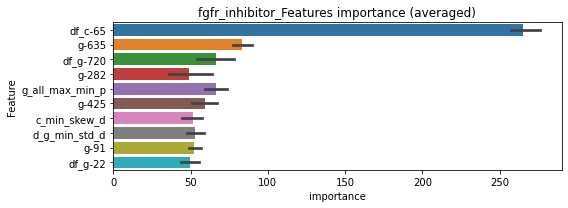

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184063	valid_1's binary_logloss: 0.0411568
[200]	training's binary_logloss: 0.00268055	valid_1's binary_logloss: 0.0202827
[300]	training's binary_logloss: 0.000776273	valid_1's binary_logloss: 0.0162102
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000486024	valid_1's binary_logloss: 0.01537


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193256	valid_1's binary_logloss: 0.0384722
[200]	training's binary_logloss: 0.00299901	valid_1's binary_logloss: 0.0172577
[300]	training's binary_logloss: 0.000838749	valid_1's binary_logloss: 0.0126923
[400]	training's binary_logloss: 0.000412178	valid_1's binary_logloss: 0.0109742
[500]	training's binary_logloss: 0.000279089	valid_1's binary_logloss: 0.0100566
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000254003	valid_1's binary_logloss: 0.00987972


fgfr_inhibitor logloss: 0.012624847215387765
flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558009	valid_1's binary_logloss: 0.146957
[200]	training's binary_logloss: 0.0125201	valid_1's binary_logloss: 0.113318
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00653595	valid_1's binary_logloss: 0.110525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549476	valid_1's binary_logloss: 0.137274
[200]	training's binary_logloss: 0.0120185	valid_1's binary_logloss: 0.1059


1 / 3 AUC score:0.981
y_Threshold: 0.0614138, Threshold: 0.2182495, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00665479	valid_1's binary_logloss: 0.102907


Remove_noisy_labels: 222 → Positive_corect_labels: 609/3704
p_label_rate: 0.0200904 Vs.target_rate: 0.01172, Num_p_label: 80.0, conf_0:0.19642, conf_1:0.24007
threshold: 0.2182495, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 609.0/3704, y_label_rate: 0.1644168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431706	valid_1's binary_logloss: 0.112775
[200]	training's binary_logloss: 0.00839459	valid_1's binary_logloss: 0.0780098
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0046861	valid_1's binary_logloss: 0.0732689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465247	valid_1's binary_logloss: 0.0846366
[200]	training's binary_logloss: 0.00934515	valid_1's binary_logloss: 0.0423313
[300]	training's binary_logloss: 0.00288654	valid_1's binary_logloss: 0.0311617
[400]	training's binary_logloss: 0.00136171	valid_1's binary_logloss: 0.0269881
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00105677	valid_1's binary_logloss: 0.0259799


2 / 3 AUC score:0.996
y_Threshold: 0.1208918, Threshold: 0.2182495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 587.0/3660
p_label_rate: 0.0376695 Vs.target_rate: 0.01172, Num_p_label: 150.0, conf_0:0.19642, conf_1:0.24007
Num_p_label: 150.0, Expected: 46.7, Adj_threshold_1: 0.2182495
Num_p_label: 142.0, Expected: 46.7, Adj_threshold_2: 0.2282495
Num_p_label: 138.0, Expected: 46.7, Adj_threshold_3: 0.2382495
Num_p_label: 136.0, Expected: 46.7, Adj_threshold_4: 0.2482495
Num_p_label: 131.0, Expected: 46.7, Adj_threshold_5: 0.2582495
Num_p_label: 126.0, Expected: 46.7, Adj_threshold_6: 0.2682495
Num_p_label: 123.0, Expected: 46.7, Adj_threshold_7: 0.2782495
Num_p_label: 117.0, Expected: 46.7, Adj_threshold_8: 0.2882495
Num_p_label: 115.0, Expected: 46.7, Adj_threshold_9: 0.2982495
Num_p_label: 115.0, Expected: 46.7, Adj_threshold_10: 0.3082495
threshold: 0.3182495, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 587.0/3660, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404437	valid_1's binary_logloss: 0.0941897
[200]	training's binary_logloss: 0.00750329	valid_1's binary_logloss: 0.0590124
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00300781	valid_1's binary_logloss: 0.054023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405463	valid_1's binary_logloss: 0.096941
[200]	training's binary_logloss: 0.00741005	valid_1's binary_logloss: 0.0645008


3 / 3 AUC score:0.995
y_Threshold: 0.1119947, Threshold: 0.3182495, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00368289	valid_1's binary_logloss: 0.0601395


Remove_noisy_labels: 52 → Positive_corect_labels: 561.0/3608
p_label_rate: 0.0303867 Vs.target_rate: 0.01172, Num_p_label: 121.0, conf_0:0.28642, conf_1:0.35007
threshold: 0.3182495, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 682.0/7590, y_label_rate: 0.0898551


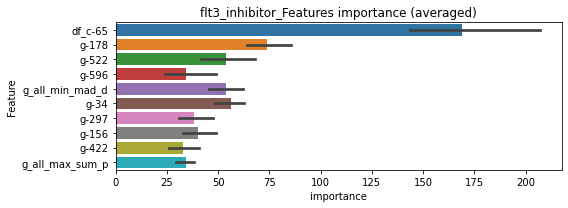

len(train_index) : 3795
len(valid_index) : 3795
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249983	valid_1's binary_logloss: 0.0721909
[200]	training's binary_logloss: 0.00476417	valid_1's binary_logloss: 0.0516039
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0036138	valid_1's binary_logloss: 0.0506479


len(train_index) : 3795
len(valid_index) : 3795
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252391	valid_1's binary_logloss: 0.0569721
[200]	training's binary_logloss: 0.00470758	valid_1's binary_logloss: 0.0326113
[300]	training's binary_logloss: 0.00143179	valid_1's binary_logloss: 0.0256404
[400]	training's binary_logloss: 0.000681131	valid_1's binary_logloss: 0.022447
[500]	training's binary_logloss: 0.000433307	valid_1's binary_logloss: 0.0210076
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000352495	valid_1's binary_logloss: 0.0203887


flt3_inhibitor logloss: 0.035518279682577654
focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018452	valid_1's binary_logloss: 0.020981
[200]	training's binary_logloss: 0.00176096	valid_1's binary_logloss: 0.00370934
[300]	training's binary_logloss: 0.000479388	valid_1's binary_logloss: 0.00242793
[400]	training's binary_logloss: 0.000278057	valid_1's binary_logloss: 0.00212827
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000265429	valid_1's binary_logloss: 0.00211298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184634	valid_1's binary_logloss: 0.0216412
[200]	training's binary_logloss: 0.00181318	valid_1's binary_logloss: 0.00289851
[300]	training's binary_logloss: 0.000505504	valid_1's binary_logloss: 0.00123378
[400]	training's binary_logloss: 0.000288621	valid_1's binary_logloss: 0.000903006
[500]	training's binary_logloss: 0.000248114	valid_1's binary_logloss: 0.000823642
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0012622, Threshold: 0.0037196, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00335, conf_1:0.00409
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0037196
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_2: 0.0137196
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_3: 0.0237196
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.0337196
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.0437196
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.0537196
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.0637196
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.0737196
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.0837196
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.0937196
threshold: 0.1037196, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180353	valid_1's binary_logloss: 0.0189417
[200]	training's binary_logloss: 0.00165488	valid_1's binary_logloss: 0.00186745
[300]	training's binary_logloss: 0.000432892	valid_1's binary_logloss: 0.000519162
[400]	training's binary_logloss: 0.000252028	valid_1's binary_logloss: 0.000309828
[500]	training's binary_logloss: 0.000220322	valid_1's binary_logloss: 0.000272708
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00021609	valid_1's binary_logloss: 0.000267727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181739	valid_1's binary_logloss: 0.0206847
[200]	training's binary_logloss: 0.00167131	valid_1's binary_logloss: 0.00229676
[300]	training's binary_logloss: 0.00043021	valid_1's binary_logloss: 0.00068874
[400]	training's binary_logloss: 0.000250031	valid_1's binary_logloss: 0.000430215
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1788546, Threshold: 0.1037196, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.09335, conf_1:0.11409
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.1037196
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.1137196
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.1237196
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_4: 0.1337196
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_5: 0.1437196
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_6: 0.1537196
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_7: 0.1637196
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_8: 0.1737196
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_9: 0.1837196
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_10: 0.1937196
threshold: 0.2037196, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180353	valid_1's binary_logloss: 0.0189417
[200]	training's binary_logloss: 0.00165488	valid_1's binary_logloss: 0.00186745
[300]	training's binary_logloss: 0.000432892	valid_1's binary_logloss: 0.000519162
[400]	training's binary_logloss: 0.000252028	valid_1's binary_logloss: 0.000309828
[500]	training's binary_logloss: 0.000220322	valid_1's binary_logloss: 0.000272708
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00021609	valid_1's binary_logloss: 0.000267727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181739	valid_1's binary_logloss: 0.0206847
[200]	training's binary_logloss: 0.00167131	valid_1's binary_logloss: 0.00229676
[300]	training's binary_logloss: 0.00043021	valid_1's binary_logloss: 0.00068874
[400]	training's binary_logloss: 0.000250031	valid_1's binary_logloss: 0.000430215
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1788546, Threshold: 0.2037196, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.18335, conf_1:0.22409
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.2037196
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.2137196
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.2237196
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.2337196
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.2437196
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_6: 0.2537196
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.2637196
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_8: 0.2737196
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2837196
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_10: 0.2937196
threshold: 0.3037196, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7793, y_label_rate: 0.0862312


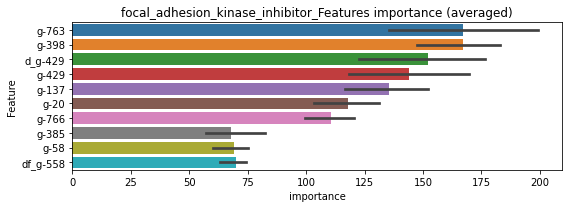

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100109	valid_1's binary_logloss: 0.01731
[200]	training's binary_logloss: 0.000973415	valid_1's binary_logloss: 0.00860069
[300]	training's binary_logloss: 0.00025821	valid_1's binary_logloss: 0.00795511
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000245671	valid_1's binary_logloss: 0.00793226


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101779	valid_1's binary_logloss: 0.0134827
[200]	training's binary_logloss: 0.00101289	valid_1's binary_logloss: 0.0043334
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000484994	valid_1's binary_logloss: 0.00369132


focal_adhesion_kinase_inhibitor logloss: 0.005812062695871742
free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232914	valid_1's binary_logloss: 0.0296569
[200]	training's binary_logloss: 0.0027507	valid_1's binary_logloss: 0.00527093
[300]	training's binary_logloss: 0.0007857	valid_1's binary_logloss: 0.00212482
[400]	training's binary_logloss: 0.000424872	valid_1's binary_logloss: 0.00144233
[500]	training's binary_logloss: 0.000336047	valid_1's binary_logloss: 0.00126101
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000331838	valid_1's binary_logloss: 0.00125412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235633	valid_1's binary_logloss: 0.0354875
[200]	training's binary_logloss: 0.00282499	valid_1's binary_logloss: 0.00915878
[300]	training's binary_logloss: 0.000797332	valid_1's binary_logloss: 0.00415805
[400]	training's binary_logloss: 0.000423558	valid_1's binary_logloss: 0.0028995
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014934, Threshold: 0.0025700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00231, conf_1:0.00283
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025700
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0125700
threshold: 0.0125700, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234876	valid_1's binary_logloss: 0.030473
[200]	training's binary_logloss: 0.0027269	valid_1's binary_logloss: 0.00571275
[300]	training's binary_logloss: 0.000769727	valid_1's binary_logloss: 0.00232257
[400]	training's binary_logloss: 0.000412772	valid_1's binary_logloss: 0.00150976
[500]	training's binary_logloss: 0.000336204	valid_1's binary_logloss: 0.00138337
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000331102	valid_1's binary_logloss: 0.00137353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235183	valid_1's binary_logloss: 0.0360631
[200]	training's binary_logloss: 0.00276841	valid_1's binary_logloss: 0.010288
[300]	training's binary_logloss: 0.000781652	valid_1's binary_logloss: 0.00537267
[400]	training's binary_logloss: 0.00041926	valid_1's binary_logloss: 0.00409513
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0721405, Threshold: 0.0125700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.01131, conf_1:0.01383
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.0125700
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0225700
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0325700
threshold: 0.0325700, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234876	valid_1's binary_logloss: 0.030473
[200]	training's binary_logloss: 0.0027269	valid_1's binary_logloss: 0.00571275
[300]	training's binary_logloss: 0.000769727	valid_1's binary_logloss: 0.00232257
[400]	training's binary_logloss: 0.000412772	valid_1's binary_logloss: 0.00150976
[500]	training's binary_logloss: 0.000336204	valid_1's binary_logloss: 0.00138337
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000331102	valid_1's binary_logloss: 0.00137353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235183	valid_1's binary_logloss: 0.0360631
[200]	training's binary_logloss: 0.00276841	valid_1's binary_logloss: 0.010288
[300]	training's binary_logloss: 0.000781652	valid_1's binary_logloss: 0.00537267
[400]	training's binary_logloss: 0.00041926	valid_1's binary_logloss: 0.00409513
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0721405, Threshold: 0.0325700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.02931, conf_1:0.03583
threshold: 0.0325700, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


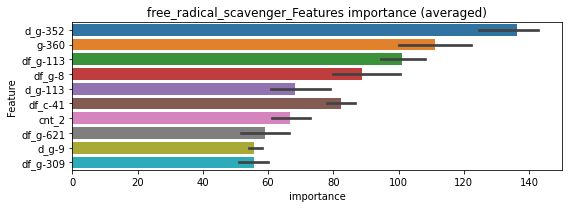

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125297	valid_1's binary_logloss: 0.0189078
[200]	training's binary_logloss: 0.00144584	valid_1's binary_logloss: 0.00647714
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00045552	valid_1's binary_logloss: 0.00561846


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130803	valid_1's binary_logloss: 0.0187197
[200]	training's binary_logloss: 0.00158989	valid_1's binary_logloss: 0.00417379
[300]	training's binary_logloss: 0.000426445	valid_1's binary_logloss: 0.00235099
[400]	training's binary_logloss: 0.000226136	valid_1's binary_logloss: 0.00197801
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000180199	valid_1's binary_logloss: 0.00186908


free_radical_scavenger logloss: 0.0037440134796117358
fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260916	valid_1's binary_logloss: 0.0407623
[200]	training's binary_logloss: 0.00334758	valid_1's binary_logloss: 0.00938726
[300]	training's binary_logloss: 0.000958028	valid_1's binary_logloss: 0.00405061
[400]	training's binary_logloss: 0.000495446	valid_1's binary_logloss: 0.00284653
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000393273	valid_1's binary_logloss: 0.00256698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265499	valid_1's binary_logloss: 0.0336231
[200]	training's binary_logloss: 0.00343927	valid_1's binary_logloss: 0.00565852
[300]	training's binary_logloss: 0.000982414	valid_1's binary_logloss: 0.00194465
[400]	training's binary_logloss: 0.000503587	valid_1's binary_logloss: 0.00110369
[500]	training's binary_logloss: 0.000369283	valid_1's binary_logloss: 0.000855167
[600]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0018771, Threshold: 0.0033152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00298, conf_1:0.00365
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0033152
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.0133152
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_3: 0.0233152
threshold: 0.0233152, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259486	valid_1's binary_logloss: 0.0405364
[200]	training's binary_logloss: 0.00320987	valid_1's binary_logloss: 0.0086067
[300]	training's binary_logloss: 0.000920939	valid_1's binary_logloss: 0.00377816
[400]	training's binary_logloss: 0.000480733	valid_1's binary_logloss: 0.00275552
[500]	training's binary_logloss: 0.000363336	valid_1's binary_logloss: 0.00239595
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000363336	valid_1's binary_logloss: 0.00239595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262622	valid_1's binary_logloss: 0.0332833
[200]	training's binary_logloss: 0.00332373	valid_1's binary_logloss: 0.00549201
[300]	training's binary_logloss: 0.000960756	valid_1's binary_logloss: 0.001901
[400]	training's binary_logloss: 0.000496253	valid_1's binary_logloss: 0.00108937
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1122611, Threshold: 0.0233152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0045203 Vs.target_rate: 0.00097, Num_p_label: 18.0, conf_0:0.02098, conf_1:0.02565
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_1: 0.0233152
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_2: 0.0333152
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_3: 0.0433152
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_4: 0.0533152
threshold: 0.0533152, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259486	valid_1's binary_logloss: 0.0405364
[200]	training's binary_logloss: 0.00320987	valid_1's binary_logloss: 0.0086067
[300]	training's binary_logloss: 0.000920939	valid_1's binary_logloss: 0.00377816
[400]	training's binary_logloss: 0.000480733	valid_1's binary_logloss: 0.00275552
[500]	training's binary_logloss: 0.000363336	valid_1's binary_logloss: 0.00239595
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000363336	valid_1's binary_logloss: 0.00239595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262622	valid_1's binary_logloss: 0.0332833
[200]	training's binary_logloss: 0.00332373	valid_1's binary_logloss: 0.00549201
[300]	training's binary_logloss: 0.000960756	valid_1's binary_logloss: 0.001901
[400]	training's binary_logloss: 0.000496253	valid_1's binary_logloss: 0.00108937
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1122611, Threshold: 0.0533152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00097, Num_p_label: 7.0, conf_0:0.04798, conf_1:0.05865
threshold: 0.0533152, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


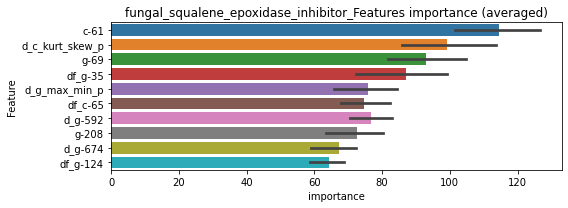

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133577	valid_1's binary_logloss: 0.0251321
[200]	training's binary_logloss: 0.0016885	valid_1's binary_logloss: 0.0111033
[300]	training's binary_logloss: 0.000483728	valid_1's binary_logloss: 0.00923071
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000439489	valid_1's binary_logloss: 0.00909525


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138932	valid_1's binary_logloss: 0.0222138
[200]	training's binary_logloss: 0.00176284	valid_1's binary_logloss: 0.00769321
[300]	training's binary_logloss: 0.000499868	valid_1's binary_logloss: 0.00570364
[400]	training's binary_logloss: 0.000255463	valid_1's binary_logloss: 0.00526174
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000265204	valid_1's binary_logloss: 0.00525154


fungal_squalene_epoxidase_inhibitor logloss: 0.007173395728599011
gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652763	valid_1's binary_logloss: 0.142484
[200]	training's binary_logloss: 0.0171744	valid_1's binary_logloss: 0.0895293
[300]	training's binary_logloss: 0.00560441	valid_1's binary_logloss: 0.0720209
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00287821	valid_1's binary_logloss: 0.0663385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704843	valid_1's binary_logloss: 0.146591
[200]	training's binary_logloss: 0.0193717	valid_1's binary_logloss: 0.0926854
[300]	training's binary_logloss: 0.00617042	valid_1's binary_logloss: 0.0795032
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00488827	valid_1's binary_logloss: 0.0780851


1 / 3 AUC score:0.993
y_Threshold: 0.0219417, Threshold: 0.0332428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 639/3764
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.02992, conf_1:0.03657
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0332428
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_2: 0.0432428
threshold: 0.0432428, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 639.0/3764, y_label_rate: 0.1697662
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586886	valid_1's binary_logloss: 0.14877
[200]	training's binary_logloss: 0.0136753	valid_1's binary_logloss: 0.105442
[300]	training's binary_logloss: 0.00427963	valid_1's binary_logloss: 0.0971513
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00328008	valid_1's binary_logloss: 0.0951309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714095	valid_1's binary_logloss: 0.134723
[200]	training's binary_logloss: 0.0188504	valid_1's binary_logloss: 0.0735226
[300]	training's binary_logloss: 0.00577091	valid_1's binary_logloss: 0.0546395
[400]	training's binary_logloss: 0.00247026	valid_1's binary_logloss: 0.0474361
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00209005	valid_1's binary_logloss: 0.0463521


2 / 3 AUC score:0.998
y_Threshold: 0.0367875, Threshold: 0.0432428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 622.0/3730
p_label_rate: 0.0090407 Vs.target_rate: 0.00445, Num_p_label: 36.0, conf_0:0.03892, conf_1:0.04757
threshold: 0.0432428, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 622.0/3730, y_label_rate: 0.1667560
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616311	valid_1's binary_logloss: 0.13245
[200]	training's binary_logloss: 0.0145723	valid_1's binary_logloss: 0.0829332
[300]	training's binary_logloss: 0.00444561	valid_1's binary_logloss: 0.0693497
[400]	training's binary_logloss: 0.00196103	valid_1's binary_logloss: 0.0653545
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00185043	valid_1's binary_logloss: 0.0650952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597262	valid_1's binary_logloss: 0.128512
[200]	training's binary_logloss: 0.0143086	valid_1's binary_logloss: 0.0805211
[300]	training's binary_logloss: 0.00458292	valid_1's binary_logloss: 0.0692552
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00355007	valid_1's binary_logloss: 0.0685402


3 / 3 AUC score:0.994
y_Threshold: 0.0369652, Threshold: 0.0432428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 603.0/3692
p_label_rate: 0.0102963 Vs.target_rate: 0.00445, Num_p_label: 41.0, conf_0:0.03892, conf_1:0.04757
threshold: 0.0432428, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 644.0/7674, y_label_rate: 0.0839197


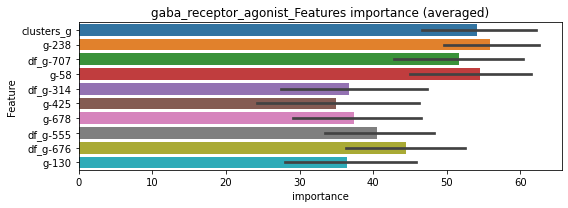

len(train_index) : 3837
len(valid_index) : 3837
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343994	valid_1's binary_logloss: 0.0945251
[200]	training's binary_logloss: 0.00807327	valid_1's binary_logloss: 0.0668981
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00339964	valid_1's binary_logloss: 0.0616137


len(train_index) : 3837
len(valid_index) : 3837
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374648	valid_1's binary_logloss: 0.0856971
[200]	training's binary_logloss: 0.0090799	valid_1's binary_logloss: 0.0558793
[300]	training's binary_logloss: 0.00269311	valid_1's binary_logloss: 0.0487178
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00195319	valid_1's binary_logloss: 0.0476069


gaba_receptor_agonist logloss: 0.05461029889553634
gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088203	valid_1's binary_logloss: 0.219688
[200]	training's binary_logloss: 0.0273241	valid_1's binary_logloss: 0.178221
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0156359	valid_1's binary_logloss: 0.172282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10324	valid_1's binary_logloss: 0.210015
[200]	training's binary_logloss: 0.034928	valid_1's binary_logloss: 0.151246
[300]	training's binary_logloss: 0.01316	valid_1's binary_logloss: 0.131093
[400]	training's binary_logloss: 0.00624709	valid_1's binary_logloss: 0.12617
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00467588	valid_1's binary_logloss: 0.124096


1 / 3 AUC score:0.970
y_Threshold: 0.0456333, Threshold: 0.0533470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 249 → Positive_corect_labels: 593/3666
p_label_rate: 0.0200904 Vs.target_rate: 0.00693, Num_p_label: 80.0, conf_0:0.04801, conf_1:0.05868
threshold: 0.0533470, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 593.0/3666, y_label_rate: 0.1617567
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816793	valid_1's binary_logloss: 0.174241
[200]	training's binary_logloss: 0.0237575	valid_1's binary_logloss: 0.121654
[300]	training's binary_logloss: 0.00780273	valid_1's binary_logloss: 0.104678
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00414763	valid_1's binary_logloss: 0.100929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866514	valid_1's binary_logloss: 0.196446
[200]	training's binary_logloss: 0.0250915	valid_1's binary_logloss: 0.137671
[300]	training's binary_logloss: 0.0084893	valid_1's binary_logloss: 0.119129
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0040595	valid_1's binary_logloss: 0.113767


2 / 3 AUC score:0.991
y_Threshold: 0.0538173, Threshold: 0.0533470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 563.0/3606
p_label_rate: 0.0153189 Vs.target_rate: 0.00693, Num_p_label: 61.0, conf_0:0.04801, conf_1:0.05868
threshold: 0.0533470, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 563.0/3606, y_label_rate: 0.1561287
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715327	valid_1's binary_logloss: 0.170392
[200]	training's binary_logloss: 0.01995	valid_1's binary_logloss: 0.119109
[300]	training's binary_logloss: 0.00654882	valid_1's binary_logloss: 0.102749
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00496838	valid_1's binary_logloss: 0.100436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794834	valid_1's binary_logloss: 0.180208
[200]	training's binary_logloss: 0.0218056	valid_1's binary_logloss: 0.131294
[300]	training's binary_logloss: 0.00713722	valid_1's binary_logloss: 0.11743
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00490133	valid_1's binary_logloss: 0.115223


3 / 3 AUC score:0.989
y_Threshold: 0.0582378, Threshold: 0.0533470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 521.0/3522
p_label_rate: 0.0238574 Vs.target_rate: 0.00693, Num_p_label: 95.0, conf_0:0.04801, conf_1:0.05868
Num_p_label: 95.0, Expected: 27.6, Adj_threshold_1: 0.0533470
Num_p_label: 65.0, Expected: 27.6, Adj_threshold_2: 0.0633470
Num_p_label: 49.0, Expected: 27.6, Adj_threshold_3: 0.0733470
threshold: 0.0733470, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 570.0/7504, y_label_rate: 0.0759595


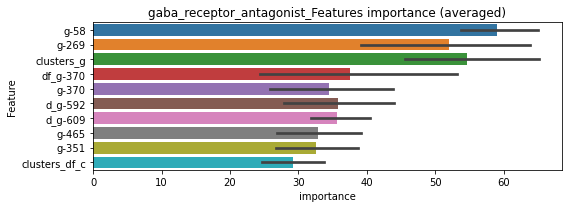

len(train_index) : 3752
len(valid_index) : 3752
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391886	valid_1's binary_logloss: 0.103265
[200]	training's binary_logloss: 0.0107345	valid_1's binary_logloss: 0.078687
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00574004	valid_1's binary_logloss: 0.0759237


len(train_index) : 3752
len(valid_index) : 3752
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450395	valid_1's binary_logloss: 0.103461
[200]	training's binary_logloss: 0.0123934	valid_1's binary_logloss: 0.0764717
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0050963	valid_1's binary_logloss: 0.0719191


gaba_receptor_antagonist logloss: 0.073921379290948
gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357927	valid_1's binary_logloss: 0.069772
[200]	training's binary_logloss: 0.00559698	valid_1's binary_logloss: 0.0328499
[300]	training's binary_logloss: 0.00164919	valid_1's binary_logloss: 0.0254916
[400]	training's binary_logloss: 0.000817294	valid_1's binary_logloss: 0.0229879
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000735565	valid_1's binary_logloss: 0.0226605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343092	valid_1's binary_logloss: 0.0654333
[200]	training's binary_logloss: 0.00537756	valid_1's binary_logloss: 0.028011
[300]	training's binary_logloss: 0.0016009	valid_1's binary_logloss: 0.0201567
[400]	training's binary_logloss: 0.000784145	valid_1's binary_logloss: 0.0177315
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000760201	valid_1's binary_logloss: 0.0177149


1 / 3 AUC score:1.000
y_Threshold: 0.0049021, Threshold: 0.0069405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.00625, conf_1:0.00763
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0069405
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.0169405
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_3: 0.0269405
threshold: 0.0269405, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347831	valid_1's binary_logloss: 0.0669974
[200]	training's binary_logloss: 0.00519034	valid_1's binary_logloss: 0.0312075
[300]	training's binary_logloss: 0.00151546	valid_1's binary_logloss: 0.0245176
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000972178	valid_1's binary_logloss: 0.0226957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344885	valid_1's binary_logloss: 0.0617795
[200]	training's binary_logloss: 0.00520586	valid_1's binary_logloss: 0.0227259
[300]	training's binary_logloss: 0.00155375	valid_1's binary_logloss: 0.015828
[400]	training's binary_logloss: 0.000767393	valid_1's binary_logloss: 0.0137874
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000612138	valid_1's binary_logloss: 0.0133475


2 / 3 AUC score:1.000
y_Threshold: 0.0323651, Threshold: 0.0269405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0097941 Vs.target_rate: 0.00235, Num_p_label: 39.0, conf_0:0.02425, conf_1:0.02963
Num_p_label: 39.0, Expected: 9.4, Adj_threshold_1: 0.0269405
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.0369405
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_3: 0.0469405
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_4: 0.0569405
threshold: 0.0569405, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345284	valid_1's binary_logloss: 0.0591094
[200]	training's binary_logloss: 0.00526433	valid_1's binary_logloss: 0.0189834
[300]	training's binary_logloss: 0.00155729	valid_1's binary_logloss: 0.0116011
[400]	training's binary_logloss: 0.000766551	valid_1's binary_logloss: 0.00935626
[500]	training's binary_logloss: 0.000515013	valid_1's binary_logloss: 0.00852505
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000472013	valid_1's binary_logloss: 0.00837524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336113	valid_1's binary_logloss: 0.065151
[200]	training's binary_logloss: 0.00505444	valid_1's binary_logloss: 0.0258148
[300]	training's binary_logloss: 0.00148086	valid_1's binary_logloss: 0.0190591
[400]	training's binary_logloss: 0.000717448	valid_1's binary_logloss: 0.0165095
Early stopping, best iteration is:
[405

3 / 3 AUC score:1.000
y_Threshold: 0.0215052, Threshold: 0.0569405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0045203 Vs.target_rate: 0.00235, Num_p_label: 18.0, conf_0:0.05125, conf_1:0.06263
threshold: 0.0569405, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 665.0/7768, y_label_rate: 0.0856076


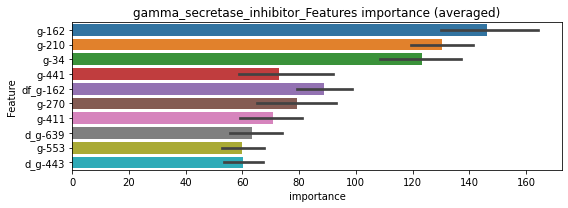

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179489	valid_1's binary_logloss: 0.0444939
[200]	training's binary_logloss: 0.00272805	valid_1's binary_logloss: 0.0227922
[300]	training's binary_logloss: 0.000830983	valid_1's binary_logloss: 0.0191171
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000538899	valid_1's binary_logloss: 0.0181529


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185337	valid_1's binary_logloss: 0.0372816
[200]	training's binary_logloss: 0.00274381	valid_1's binary_logloss: 0.0174526
[300]	training's binary_logloss: 0.000809443	valid_1's binary_logloss: 0.0132756
[400]	training's binary_logloss: 0.000391936	valid_1's binary_logloss: 0.0117705
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000281194	valid_1's binary_logloss: 0.0112749


gamma_secretase_inhibitor logloss: 0.014713925513085604
glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682


neg labels: 3289 → selected neg labels: 3253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318092	valid_1's binary_logloss: 0.0742261
[200]	training's binary_logloss: 0.00464681	valid_1's binary_logloss: 0.0577349
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00457335	valid_1's binary_logloss: 0.0576769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334466	valid_1's binary_logloss: 0.0629792
[200]	training's binary_logloss: 0.00532267	valid_1's binary_logloss: 0.0352096
[300]	training's binary_logloss: 0.00158894	valid_1's binary_logloss: 0.0304715
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000941161	valid_1's binary_logloss: 0.0296016


1 / 3 AUC score:0.995
y_Threshold: 0.0082249, Threshold: 0.0242742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → Positive_corect_labels: 640/3752
p_label_rate: 0.0200904 Vs.target_rate: 0.01117, Num_p_label: 80.0, conf_0:0.02185, conf_1:0.02670
threshold: 0.0242742, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 640.0/3752, y_label_rate: 0.1705757
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026184	valid_1's binary_logloss: 0.0528939
[200]	training's binary_logloss: 0.00334595	valid_1's binary_logloss: 0.0329795
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00242016	valid_1's binary_logloss: 0.0317311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274636	valid_1's binary_logloss: 0.0436427
[200]	training's binary_logloss: 0.00343147	valid_1's binary_logloss: 0.0204512


2 / 3 AUC score:0.996
y_Threshold: 0.0370452, Threshold: 0.0242742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 631.0/3734
p_label_rate: 0.0323958 Vs.target_rate: 0.01117, Num_p_label: 129.0, conf_0:0.02185, conf_1:0.02670


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00244296	valid_1's binary_logloss: 0.0195825


threshold: 0.0242742, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 631.0/3734, y_label_rate: 0.1689877
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240787	valid_1's binary_logloss: 0.0461761
[200]	training's binary_logloss: 0.00309099	valid_1's binary_logloss: 0.0269275
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00156485	valid_1's binary_logloss: 0.0259485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248877	valid_1's binary_logloss: 0.04053
[200]	training's binary_logloss: 0.00313946	valid_1's binary_logloss: 0.0158354
[300]	training's binary_logloss: 0.000880685	valid_1's binary_logloss: 0.012395
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000932963	valid_1's binary_logloss: 0.0122944


3 / 3 AUC score:0.998
y_Threshold: 0.0283009, Threshold: 0.0242742, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 625.0/3722
p_label_rate: 0.0256153 Vs.target_rate: 0.01117, Num_p_label: 102.0, conf_0:0.02185, conf_1:0.02670
threshold: 0.0242742, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 727.0/7704, y_label_rate: 0.0943666


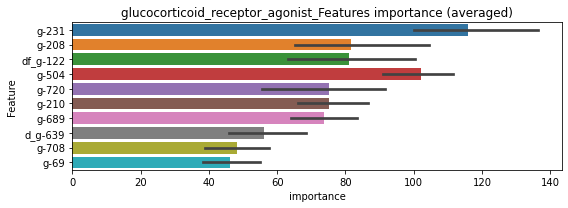

len(train_index) : 3852
len(valid_index) : 3852
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158939	valid_1's binary_logloss: 0.0415129
[200]	training's binary_logloss: 0.0022497	valid_1's binary_logloss: 0.0319302
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00222212	valid_1's binary_logloss: 0.0318311


len(train_index) : 3852
len(valid_index) : 3852
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163795	valid_1's binary_logloss: 0.0330232
[200]	training's binary_logloss: 0.00228393	valid_1's binary_logloss: 0.0217374
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00111912	valid_1's binary_logloss: 0.0208386


glucocorticoid_receptor_agonist logloss: 0.026334842666717175
glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192002	valid_1's binary_logloss: 0.0241799
[200]	training's binary_logloss: 0.00199875	valid_1's binary_logloss: 0.00427412
[300]	training's binary_logloss: 0.000574921	valid_1's binary_logloss: 0.0019286
[400]	training's binary_logloss: 0.000328006	valid_1's binary_logloss: 0.00146199
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000292658	valid_1's binary_logloss: 0.00139069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192911	valid_1's binary_logloss: 0.0231526
[200]	training's binary_logloss: 0.00202603	valid_1's binary_logloss: 0.00325052
[300]	training's binary_logloss: 0.000584969	valid_1's binary_logloss: 0.0011132
[400]	training's binary_logloss: 0.000328822	valid_1's binary_logloss: 0.000666627
[500]	training's binary_logloss: 0.000286549	valid_1's binary_logloss: 0.000598194
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0011827, Threshold: 0.0018350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055, Num_p_label: 80.0, conf_0:0.00165, conf_1:0.00202
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0018350
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_2: 0.0118350
threshold: 0.0118350, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193373	valid_1's binary_logloss: 0.0246088
[200]	training's binary_logloss: 0.00196922	valid_1's binary_logloss: 0.00466863
[300]	training's binary_logloss: 0.000564849	valid_1's binary_logloss: 0.00225728
[400]	training's binary_logloss: 0.000321816	valid_1's binary_logloss: 0.00166972
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000280731	valid_1's binary_logloss: 0.00157274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192653	valid_1's binary_logloss: 0.0218349
[200]	training's binary_logloss: 0.00195516	valid_1's binary_logloss: 0.00294207
[300]	training's binary_logloss: 0.0005619	valid_1's binary_logloss: 0.00103497
[400]	training's binary_logloss: 0.000321593	valid_1's binary_logloss: 0.000660302
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000281853	valid_1's binary_logloss: 0.000602

2 / 3 AUC score:1.000
y_Threshold: 0.0679682, Threshold: 0.0118350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0057760 Vs.target_rate: 0.00055, Num_p_label: 23.0, conf_0:0.01065, conf_1:0.01302
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_1: 0.0118350
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.0218350
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.0318350
threshold: 0.0318350, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193373	valid_1's binary_logloss: 0.0246088
[200]	training's binary_logloss: 0.00196922	valid_1's binary_logloss: 0.00466863
[300]	training's binary_logloss: 0.000564849	valid_1's binary_logloss: 0.00225728
[400]	training's binary_logloss: 0.000321816	valid_1's binary_logloss: 0.00166972
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000280731	valid_1's binary_logloss: 0.00157274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192653	valid_1's binary_logloss: 0.0218349
[200]	training's binary_logloss: 0.00195516	valid_1's binary_logloss: 0.00294207
[300]	training's binary_logloss: 0.0005619	valid_1's binary_logloss: 0.00103497
[400]	training's binary_logloss: 0.000321593	valid_1's binary_logloss: 0.000660302
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000281853	valid_1's binary_logloss: 0.000602

3 / 3 AUC score:1.000
y_Threshold: 0.0679682, Threshold: 0.0318350, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.02865, conf_1:0.03502
threshold: 0.0318350, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


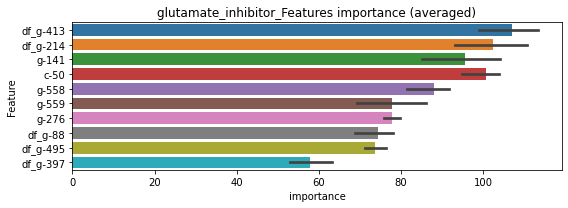

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101665	valid_1's binary_logloss: 0.0134551
[200]	training's binary_logloss: 0.00101239	valid_1's binary_logloss: 0.00356269
[300]	training's binary_logloss: 0.000287604	valid_1's binary_logloss: 0.00302673
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000304761	valid_1's binary_logloss: 0.0030228


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104041	valid_1's binary_logloss: 0.0131201
[200]	training's binary_logloss: 0.00105965	valid_1's binary_logloss: 0.00278755
[300]	training's binary_logloss: 0.000300515	valid_1's binary_logloss: 0.00184518
[400]	training's binary_logloss: 0.000165067	valid_1's binary_logloss: 0.00171632
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000161969	valid_1's binary_logloss: 0.00171268


glutamate_inhibitor logloss: 0.0023677402207924244
glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654401	valid_1's binary_logloss: 0.122396
[200]	training's binary_logloss: 0.0144508	valid_1's binary_logloss: 0.0637183
[300]	training's binary_logloss: 0.00424119	valid_1's binary_logloss: 0.0463961
[400]	training's binary_logloss: 0.00189728	valid_1's binary_logloss: 0.0415878
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00161799	valid_1's binary_logloss: 0.0408212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065641	valid_1's binary_logloss: 0.122432
[200]	training's binary_logloss: 0.0159397	valid_1's binary_logloss: 0.0628857
[300]	training's binary_logloss: 0.00460122	valid_1's binary_logloss: 0.0433399
[400]	training's binary_logloss: 0.00196752	valid_1's binary_logloss: 0.0387877
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00145134	valid_1's binary_logloss: 0.0374809


1 / 3 AUC score:0.998
y_Threshold: 0.0132457, Threshold: 0.0197223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.01775, conf_1:0.02169
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0197223
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_2: 0.0297223
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_3: 0.0397223
threshold: 0.0397223, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628728	valid_1's binary_logloss: 0.122106
[200]	training's binary_logloss: 0.0142072	valid_1's binary_logloss: 0.0609444
[300]	training's binary_logloss: 0.00410643	valid_1's binary_logloss: 0.0443075
[400]	training's binary_logloss: 0.00178598	valid_1's binary_logloss: 0.0378973
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00178598	valid_1's binary_logloss: 0.0378973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644946	valid_1's binary_logloss: 0.111396
[200]	training's binary_logloss: 0.0137403	valid_1's binary_logloss: 0.0504977
[300]	training's binary_logloss: 0.00402528	valid_1's binary_logloss: 0.0340995
[400]	training's binary_logloss: 0.00174643	valid_1's binary_logloss: 0.029016
[500]	training's binary_logloss: 0.00105384	valid_1's binary_logloss: 0.0276869
Early stopping, best iteration is:
[526]	training'

2 / 3 AUC score:0.999
y_Threshold: 0.0529740, Threshold: 0.0397223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0118031 Vs.target_rate: 0.00311, Num_p_label: 47.0, conf_0:0.03575, conf_1:0.04369
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.0397223
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.0497223
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_3: 0.0597223
threshold: 0.0597223, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 639.0/3768, y_label_rate: 0.1695860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612977	valid_1's binary_logloss: 0.111489
[200]	training's binary_logloss: 0.0129571	valid_1's binary_logloss: 0.0476092
[300]	training's binary_logloss: 0.00380915	valid_1's binary_logloss: 0.0287328
[400]	training's binary_logloss: 0.00166416	valid_1's binary_logloss: 0.0214169
[500]	training's binary_logloss: 0.0010061	valid_1's binary_logloss: 0.0188639
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000899582	valid_1's binary_logloss: 0.0183397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615153	valid_1's binary_logloss: 0.113804
[200]	training's binary_logloss: 0.0129615	valid_1's binary_logloss: 0.0558673
[300]	training's binary_logloss: 0.00377538	valid_1's binary_logloss: 0.0400863
[400]	training's binary_logloss: 0.00169412	valid_1's binary_logloss: 0.0352895
Early stopping, best iteration is:
[448]	training

3 / 3 AUC score:1.000
y_Threshold: 0.0399507, Threshold: 0.0597223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 634.0/3758
p_label_rate: 0.0045203 Vs.target_rate: 0.00311, Num_p_label: 18.0, conf_0:0.05375, conf_1:0.06569
threshold: 0.0597223, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 652.0/7740, y_label_rate: 0.0842377


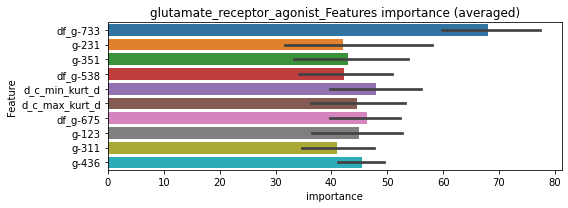

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035494	valid_1's binary_logloss: 0.0664342
[200]	training's binary_logloss: 0.00742936	valid_1's binary_logloss: 0.0347249
[300]	training's binary_logloss: 0.00209914	valid_1's binary_logloss: 0.0271601
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00136407	valid_1's binary_logloss: 0.0259665


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336435	valid_1's binary_logloss: 0.0672678
[200]	training's binary_logloss: 0.00747379	valid_1's binary_logloss: 0.0345078
[300]	training's binary_logloss: 0.00211577	valid_1's binary_logloss: 0.0248797
[400]	training's binary_logloss: 0.000933462	valid_1's binary_logloss: 0.0217503
[500]	training's binary_logloss: 0.000552401	valid_1's binary_logloss: 0.020555
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000490713	valid_1's binary_logloss: 0.0202942


glutamate_receptor_agonist logloss: 0.023130349374281135
glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105


neg labels: 3289 → selected neg labels: 3226


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127806	valid_1's binary_logloss: 0.368069
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.064625	valid_1's binary_logloss: 0.357276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146403	valid_1's binary_logloss: 0.3598
[200]	training's binary_logloss: 0.0608833	valid_1's binary_logloss: 0.335859


1 / 3 AUC score:0.802
y_Threshold: 0.1254084, Threshold: 0.1683614, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.057202	valid_1's binary_logloss: 0.334726


Remove_noisy_labels: 666 → Positive_corect_labels: 377/3205
p_label_rate: 0.0200904 Vs.target_rate: 0.01541, Num_p_label: 80.0, conf_0:0.15153, conf_1:0.18520
threshold: 0.1683614, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 377.0/3205, y_label_rate: 0.1176287
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691511	valid_1's binary_logloss: 0.246541
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.044783	valid_1's binary_logloss: 0.235319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774808	valid_1's binary_logloss: 0.244227


2 / 3 AUC score:0.906
y_Threshold: 0.0985923, Threshold: 0.1683614, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 248 → Positive_corect_labels: 253.0/2957
p_label_rate: 0.0040181 Vs.target_rate: 0.01541, Num_p_label: 16.0, conf_0:0.15153, conf_1:0.18520
Num_p_label: 16.0, Expected: 61.4, Adj_threshold_1: 0.1683614


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0290485	valid_1's binary_logloss: 0.228862


Num_p_label: 23.0, Expected: 61.4, Adj_threshold_2: 0.1583614
Num_p_label: 31.0, Expected: 61.4, Adj_threshold_3: 0.1483614
threshold: 0.1483614, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 253.0/2957, y_label_rate: 0.0855597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451284	valid_1's binary_logloss: 0.184853
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.01989	valid_1's binary_logloss: 0.172687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438101	valid_1's binary_logloss: 0.183088


3 / 3 AUC score:0.943
y_Threshold: 0.0641045, Threshold: 0.1483614, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 184.0/2819
p_label_rate: 0.0005023 Vs.target_rate: 0.01541, Num_p_label: 2.0, conf_0:0.13353, conf_1:0.16320
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_1: 0.1483614


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0198599	valid_1's binary_logloss: 0.175408


Num_p_label: 3.0, Expected: 61.4, Adj_threshold_2: 0.1383614
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_3: 0.1283614
Num_p_label: 11.0, Expected: 61.4, Adj_threshold_4: 0.1183614
Num_p_label: 20.0, Expected: 61.4, Adj_threshold_5: 0.1083614
Num_p_label: 29.0, Expected: 61.4, Adj_threshold_6: 0.0983614
Num_p_label: 42.0, Expected: 61.4, Adj_threshold_7: 0.0883614
threshold: 0.0883614, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 226.0/6801, y_label_rate: 0.0332304


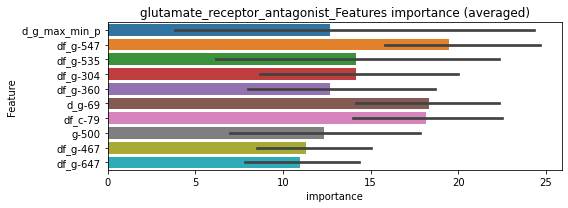

len(train_index) : 3400
len(valid_index) : 3401
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180451	valid_1's binary_logloss: 0.0887818
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0103001	valid_1's binary_logloss: 0.086817


len(train_index) : 3401
len(valid_index) : 3400
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018179	valid_1's binary_logloss: 0.0934671


glutamate_receptor_antagonist logloss: 0.08926802143471851


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0105746	valid_1's binary_logloss: 0.0917198


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022465	valid_1's binary_logloss: 0.031114
[200]	training's binary_logloss: 0.00258854	valid_1's binary_logloss: 0.00615372
[300]	training's binary_logloss: 0.000754076	valid_1's binary_logloss: 0.00254982
[400]	training's binary_logloss: 0.000408142	valid_1's binary_logloss: 0.00161028
[500]	training's binary_logloss: 0.000330021	valid_1's binary_logloss: 0.00137973
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000328922	valid_1's binary_logloss: 0.00137762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234193	valid_1's binary_logloss: 0.0305178
[200]	training's binary_logloss: 0.00272627	valid_1's binary_logloss: 0.00507283
[300]	training's binary_logloss: 0.000774107	valid_1's binary_logloss: 0.0020459
[400]	training's binary_logloss: 0.000420038	valid_1's binary_logloss: 0.00141376
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0017810, Threshold: 0.0033441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00301, conf_1:0.00368
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0033441
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0133441
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0233441
threshold: 0.0233441, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225266	valid_1's binary_logloss: 0.0284392
[200]	training's binary_logloss: 0.0025266	valid_1's binary_logloss: 0.00461542
[300]	training's binary_logloss: 0.000726767	valid_1's binary_logloss: 0.00172401
[400]	training's binary_logloss: 0.000397298	valid_1's binary_logloss: 0.00105829
[500]	training's binary_logloss: 0.000326649	valid_1's binary_logloss: 0.000913928
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000316147	valid_1's binary_logloss: 0.000896774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231623	valid_1's binary_logloss: 0.0298973
[200]	training's binary_logloss: 0.00259354	valid_1's binary_logloss: 0.00430761
[300]	training's binary_logloss: 0.000732157	valid_1's binary_logloss: 0.0015615
[400]	training's binary_logloss: 0.000399572	valid_1's binary_logloss: 0.00100147
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1445117, Threshold: 0.0233441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.02101, conf_1:0.02568
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0233441
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0333441
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0433441
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0533441
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.0633441
threshold: 0.0633441, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225266	valid_1's binary_logloss: 0.0284392
[200]	training's binary_logloss: 0.0025266	valid_1's binary_logloss: 0.00461542
[300]	training's binary_logloss: 0.000726767	valid_1's binary_logloss: 0.00172401
[400]	training's binary_logloss: 0.000397298	valid_1's binary_logloss: 0.00105829
[500]	training's binary_logloss: 0.000326649	valid_1's binary_logloss: 0.000913928
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000316147	valid_1's binary_logloss: 0.000896774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231623	valid_1's binary_logloss: 0.0298973
[200]	training's binary_logloss: 0.00259354	valid_1's binary_logloss: 0.00430761
[300]	training's binary_logloss: 0.000732157	valid_1's binary_logloss: 0.0015615
[400]	training's binary_logloss: 0.000399572	valid_1's binary_logloss: 0.00100147
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1445117, Threshold: 0.0633441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.05701, conf_1:0.06968
threshold: 0.0633441, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


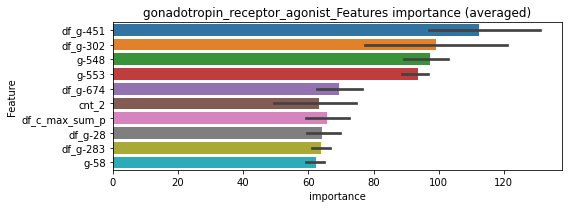

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124781	valid_1's binary_logloss: 0.0196067
[200]	training's binary_logloss: 0.00138791	valid_1's binary_logloss: 0.00584243
[300]	training's binary_logloss: 0.000386941	valid_1's binary_logloss: 0.0046414
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000386941	valid_1's binary_logloss: 0.0046414


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128806	valid_1's binary_logloss: 0.016197
[200]	training's binary_logloss: 0.00148897	valid_1's binary_logloss: 0.00324891
[300]	training's binary_logloss: 0.000408168	valid_1's binary_logloss: 0.0019663
[400]	training's binary_logloss: 0.000216282	valid_1's binary_logloss: 0.00176972
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000181482	valid_1's binary_logloss: 0.00173457


gonadotropin_receptor_agonist logloss: 0.0031881709421192673
gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353289	valid_1's binary_logloss: 0.0736652
[200]	training's binary_logloss: 0.00725693	valid_1's binary_logloss: 0.0372782
[300]	training's binary_logloss: 0.00186294	valid_1's binary_logloss: 0.0233547
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00144114	valid_1's binary_logloss: 0.0223667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353388	valid_1's binary_logloss: 0.0810755
[200]	training's binary_logloss: 0.0055376	valid_1's binary_logloss: 0.0441701
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00185466	valid_1's binary_logloss: 0.037487


1 / 3 AUC score:0.999
y_Threshold: 0.0071829, Threshold: 0.0110191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.00992, conf_1:0.01212
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0110191
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.0210191
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_3: 0.0310191
threshold: 0.0310191, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348397	valid_1's binary_logloss: 0.0648444
[200]	training's binary_logloss: 0.00538003	valid_1's binary_logloss: 0.0215112
[300]	training's binary_logloss: 0.00159785	valid_1's binary_logloss: 0.0127724
[400]	training's binary_logloss: 0.00077888	valid_1's binary_logloss: 0.00990999
[500]	training's binary_logloss: 0.000519996	valid_1's binary_logloss: 0.00885245
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000463226	valid_1's binary_logloss: 0.00861858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358671	valid_1's binary_logloss: 0.0578511
[200]	training's binary_logloss: 0.00552354	valid_1's binary_logloss: 0.0163785
[300]	training's binary_logloss: 0.00162399	valid_1's binary_logloss: 0.008223
[400]	training's binary_logloss: 0.000800264	valid_1's binary_logloss: 0.00563112
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.0286547, Threshold: 0.0310191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0052737 Vs.target_rate: 0.00252, Num_p_label: 21.0, conf_0:0.02792, conf_1:0.03412
threshold: 0.0310191, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348397	valid_1's binary_logloss: 0.0648444
[200]	training's binary_logloss: 0.00538003	valid_1's binary_logloss: 0.0215112
[300]	training's binary_logloss: 0.00159785	valid_1's binary_logloss: 0.0127724
[400]	training's binary_logloss: 0.00077888	valid_1's binary_logloss: 0.00990999
[500]	training's binary_logloss: 0.000519996	valid_1's binary_logloss: 0.00885245
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000463226	valid_1's binary_logloss: 0.00861858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358671	valid_1's binary_logloss: 0.0578511
[200]	training's binary_logloss: 0.00552354	valid_1's binary_logloss: 0.0163785
[300]	training's binary_logloss: 0.00162399	valid_1's binary_logloss: 0.008223
[400]	training's binary_logloss: 0.000800264	valid_1's binary_logloss: 0.00563112
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0286547, Threshold: 0.0310191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0052737 Vs.target_rate: 0.00252, Num_p_label: 21.0, conf_0:0.02792, conf_1:0.03412
threshold: 0.0310191, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 674.0/7780, y_label_rate: 0.0866324


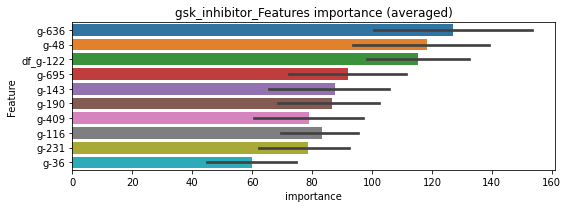

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190132	valid_1's binary_logloss: 0.0463618
[200]	training's binary_logloss: 0.00276897	valid_1's binary_logloss: 0.0248031
[300]	training's binary_logloss: 0.000813138	valid_1's binary_logloss: 0.020843
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000486257	valid_1's binary_logloss: 0.0203399


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186541	valid_1's binary_logloss: 0.0420002
[200]	training's binary_logloss: 0.00285445	valid_1's binary_logloss: 0.0203896
[300]	training's binary_logloss: 0.000826715	valid_1's binary_logloss: 0.0167658
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000610085	valid_1's binary_logloss: 0.0161425


gsk_inhibitor logloss: 0.018241173340684824
hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612187	valid_1's binary_logloss: 0.129835
[200]	training's binary_logloss: 0.0134777	valid_1's binary_logloss: 0.0780481
[300]	training's binary_logloss: 0.00401075	valid_1's binary_logloss: 0.0623542
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00224904	valid_1's binary_logloss: 0.0594856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591332	valid_1's binary_logloss: 0.112745
[200]	training's binary_logloss: 0.0128726	valid_1's binary_logloss: 0.0566177
[300]	training's binary_logloss: 0.00380259	valid_1's binary_logloss: 0.0407769
[400]	training's binary_logloss: 0.00169493	valid_1's binary_logloss: 0.0353752
[500]	training's binary_logloss: 0.00102563	valid_1's binary_logloss: 0.0328182
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000805845	valid_1's binary_logloss: 0.0317886


1 / 3 AUC score:0.997
y_Threshold: 0.0120068, Threshold: 0.0152527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.01373, conf_1:0.01678
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0152527
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_2: 0.0252527
Num_p_label: 10.0, Expected: 12.0, Adj_threshold_3: 0.0352527
threshold: 0.0352527, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/3782, y_label_rate: 0.1708091
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551989	valid_1's binary_logloss: 0.11339
[200]	training's binary_logloss: 0.0116219	valid_1's binary_logloss: 0.0582066
[300]	training's binary_logloss: 0.00346214	valid_1's binary_logloss: 0.0421922
[400]	training's binary_logloss: 0.00159673	valid_1's binary_logloss: 0.0376687
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00156583	valid_1's binary_logloss: 0.0375722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614085	valid_1's binary_logloss: 0.109227
[200]	training's binary_logloss: 0.0133554	valid_1's binary_logloss: 0.0487298
[300]	training's binary_logloss: 0.00393744	valid_1's binary_logloss: 0.0320759
[400]	training's binary_logloss: 0.00172882	valid_1's binary_logloss: 0.0261259
[500]	training's binary_logloss: 0.00104073	valid_1's binary_logloss: 0.0243141
Early stopping, best iteration is:
[544]	training'

2 / 3 AUC score:0.999
y_Threshold: 0.0373800, Threshold: 0.0352527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0050226 Vs.target_rate: 0.00302, Num_p_label: 20.0, conf_0:0.03173, conf_1:0.03878
threshold: 0.0352527, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 639.0/3768, y_label_rate: 0.1695860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557566	valid_1's binary_logloss: 0.11548
[200]	training's binary_logloss: 0.0119464	valid_1's binary_logloss: 0.0652874
[300]	training's binary_logloss: 0.00351106	valid_1's binary_logloss: 0.0518051
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00224853	valid_1's binary_logloss: 0.0484976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570308	valid_1's binary_logloss: 0.11634
[200]	training's binary_logloss: 0.0123797	valid_1's binary_logloss: 0.0654396
[300]	training's binary_logloss: 0.00365551	valid_1's binary_logloss: 0.0493362
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00185566	valid_1's binary_logloss: 0.0445462


3 / 3 AUC score:0.999
y_Threshold: 0.0402284, Threshold: 0.0352527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0110497 Vs.target_rate: 0.00302, Num_p_label: 44.0, conf_0:0.03173, conf_1:0.03878
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_1: 0.0352527
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_2: 0.0452527
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_3: 0.0552527
threshold: 0.0552527, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 641.0/7728, y_label_rate: 0.0829451


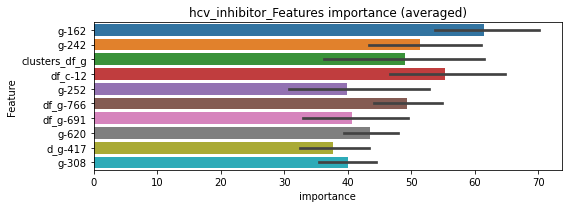

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300263	valid_1's binary_logloss: 0.0663014
[200]	training's binary_logloss: 0.00592271	valid_1's binary_logloss: 0.0383793
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00235039	valid_1's binary_logloss: 0.0329356


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320098	valid_1's binary_logloss: 0.0615191
[200]	training's binary_logloss: 0.00707453	valid_1's binary_logloss: 0.0304211
[300]	training's binary_logloss: 0.00204909	valid_1's binary_logloss: 0.021958
[400]	training's binary_logloss: 0.000898063	valid_1's binary_logloss: 0.0190138
[500]	training's binary_logloss: 0.000528746	valid_1's binary_logloss: 0.0182265
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000473832	valid_1's binary_logloss: 0.0180028


hcv_inhibitor logloss: 0.02546918753385271
hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329386	valid_1's binary_logloss: 0.0646914
[200]	training's binary_logloss: 0.0050966	valid_1's binary_logloss: 0.02758
[300]	training's binary_logloss: 0.00150421	valid_1's binary_logloss: 0.0197493
[400]	training's binary_logloss: 0.000739932	valid_1's binary_logloss: 0.0171828
[500]	training's binary_logloss: 0.000498983	valid_1's binary_logloss: 0.0160696
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000511834	valid_1's binary_logloss: 0.0160474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316428	valid_1's binary_logloss: 0.069228
[200]	training's binary_logloss: 0.00504272	valid_1's binary_logloss: 0.0442384


1 / 3 AUC score:0.999
y_Threshold: 0.0087774, Threshold: 0.0226268, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00258236	valid_1's binary_logloss: 0.0411914


Remove_noisy_labels: 137 → Positive_corect_labels: 651/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.02036, conf_1:0.02489
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0226268
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_2: 0.0326268
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_3: 0.0426268
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_4: 0.0526268
Num_p_label: 30.0, Expected: 17.7, Adj_threshold_5: 0.0626268
threshold: 0.0626268, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 651.0/3788, y_label_rate: 0.1718585
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301656	valid_1's binary_logloss: 0.0645267
[200]	training's binary_logloss: 0.00436627	valid_1's binary_logloss: 0.0306582
[300]	training's binary_logloss: 0.00129004	valid_1's binary_logloss: 0.0242356
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00111949	valid_1's binary_logloss: 0.023836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313083	valid_1's binary_logloss: 0.0574486
[200]	training's binary_logloss: 0.00463448	valid_1's binary_logloss: 0.0258727
[300]	training's binary_logloss: 0.00136617	valid_1's binary_logloss: 0.0201776
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00129442	valid_1's binary_logloss: 0.0199945


2 / 3 AUC score:1.000
y_Threshold: 0.0661199, Threshold: 0.0626268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 643.0/3772
p_label_rate: 0.0165746 Vs.target_rate: 0.00445, Num_p_label: 66.0, conf_0:0.05636, conf_1:0.06889
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_1: 0.0626268
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_2: 0.0726268
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_3: 0.0826268
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_4: 0.0926268
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_5: 0.1026268
Num_p_label: 49.0, Expected: 17.7, Adj_threshold_6: 0.1126268
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_7: 0.1226268
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_8: 0.1326268
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_9: 0.1426268
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_10: 0.1526268
threshold: 0.1626268, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 643.0/3772, y_label_rate: 0.17046

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297328	valid_1's binary_logloss: 0.0566998
[200]	training's binary_logloss: 0.00429929	valid_1's binary_logloss: 0.0206051
[300]	training's binary_logloss: 0.00126434	valid_1's binary_logloss: 0.0127453
[400]	training's binary_logloss: 0.000649178	valid_1's binary_logloss: 0.0103556
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000543169	valid_1's binary_logloss: 0.00967596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294371	valid_1's binary_logloss: 0.0560959
[200]	training's binary_logloss: 0.00425713	valid_1's binary_logloss: 0.0245051
[300]	training's binary_logloss: 0.00125301	valid_1's binary_logloss: 0.0182079
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000713953	valid_1's binary_logloss: 0.0164845


3 / 3 AUC score:1.000
y_Threshold: 0.0535349, Threshold: 0.1626268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 640.0/3766
p_label_rate: 0.0092918 Vs.target_rate: 0.00445, Num_p_label: 37.0, conf_0:0.14636, conf_1:0.17889
threshold: 0.1626268, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 677.0/7748, y_label_rate: 0.0873774


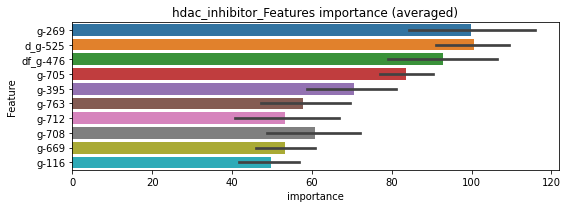

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163192	valid_1's binary_logloss: 0.040531
[200]	training's binary_logloss: 0.00236809	valid_1's binary_logloss: 0.0229582
[300]	training's binary_logloss: 0.000723368	valid_1's binary_logloss: 0.0191714
[400]	training's binary_logloss: 0.000370952	valid_1's binary_logloss: 0.0177942
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00036908	valid_1's binary_logloss: 0.017787


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164185	valid_1's binary_logloss: 0.0427514
[200]	training's binary_logloss: 0.00233864	valid_1's binary_logloss: 0.0299539
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000798659	valid_1's binary_logloss: 0.0279997


hdac_inhibitor logloss: 0.022893327887804567
histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563992	valid_1's binary_logloss: 0.0948199
[200]	training's binary_logloss: 0.0112804	valid_1's binary_logloss: 0.0382834
[300]	training's binary_logloss: 0.00318982	valid_1's binary_logloss: 0.0230683
[400]	training's binary_logloss: 0.00139607	valid_1's binary_logloss: 0.0181122
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000893347	valid_1's binary_logloss: 0.0162865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056473	valid_1's binary_logloss: 0.0923095
[200]	training's binary_logloss: 0.0117564	valid_1's binary_logloss: 0.0379022
[300]	training's binary_logloss: 0.00328554	valid_1's binary_logloss: 0.0248926
[400]	training's binary_logloss: 0.00144238	valid_1's binary_logloss: 0.0218744
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00125245	valid_1's binary_logloss: 0.0213386


1 / 3 AUC score:1.000
y_Threshold: 0.0093693, Threshold: 0.0139337, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00248, Num_p_label: 80.0, conf_0:0.01254, conf_1:0.01533
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0139337
Num_p_label: 26.0, Expected: 9.9, Adj_threshold_2: 0.0239337
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_3: 0.0339337
threshold: 0.0339337, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531848	valid_1's binary_logloss: 0.0934469
[200]	training's binary_logloss: 0.0105921	valid_1's binary_logloss: 0.0383739
[300]	training's binary_logloss: 0.00302362	valid_1's binary_logloss: 0.0235663
[400]	training's binary_logloss: 0.00135336	valid_1's binary_logloss: 0.018474
[500]	training's binary_logloss: 0.000833614	valid_1's binary_logloss: 0.0167395
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000674801	valid_1's binary_logloss: 0.01597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054695	valid_1's binary_logloss: 0.0906583
[200]	training's binary_logloss: 0.0105986	valid_1's binary_logloss: 0.0356183
[300]	training's binary_logloss: 0.00298216	valid_1's binary_logloss: 0.0196746
[400]	training's binary_logloss: 0.00135065	valid_1's binary_logloss: 0.0145869
[500]	training's binary_logloss: 0.000828061	vali

2 / 3 AUC score:1.000
y_Threshold: 0.0416692, Threshold: 0.0339337, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0067805 Vs.target_rate: 0.00248, Num_p_label: 27.0, conf_0:0.03054, conf_1:0.03733
threshold: 0.0339337, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513901	valid_1's binary_logloss: 0.0863267
[200]	training's binary_logloss: 0.0103236	valid_1's binary_logloss: 0.0323899
[300]	training's binary_logloss: 0.00297719	valid_1's binary_logloss: 0.0190638
[400]	training's binary_logloss: 0.00134721	valid_1's binary_logloss: 0.0154042
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00127181	valid_1's binary_logloss: 0.0152513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562988	valid_1's binary_logloss: 0.0899462
[200]	training's binary_logloss: 0.0106601	valid_1's binary_logloss: 0.0301163
[300]	training's binary_logloss: 0.00299563	valid_1's binary_logloss: 0.0146888
[400]	training's binary_logloss: 0.00136316	valid_1's binary_logloss: 0.00956869
[500]	training's binary_logloss: 0.000833312	valid_1's binary_logloss: 0.00769573
[600]	training's binary_logloss: 0.00062482	

3 / 3 AUC score:1.000
y_Threshold: 0.0706306, Threshold: 0.0339337, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0077850 Vs.target_rate: 0.00248, Num_p_label: 31.0, conf_0:0.03054, conf_1:0.03733
Num_p_label: 31.0, Expected: 9.9, Adj_threshold_1: 0.0339337
Num_p_label: 21.0, Expected: 9.9, Adj_threshold_2: 0.0439337
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_3: 0.0539337
threshold: 0.0539337, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 666.0/7776, y_label_rate: 0.0856481


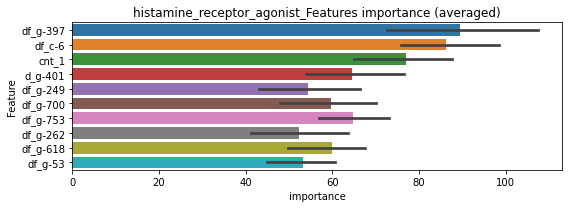

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298692	valid_1's binary_logloss: 0.0578649
[200]	training's binary_logloss: 0.00602182	valid_1's binary_logloss: 0.0279811
[300]	training's binary_logloss: 0.00164367	valid_1's binary_logloss: 0.0212036
[400]	training's binary_logloss: 0.000715699	valid_1's binary_logloss: 0.0194581
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000679503	valid_1's binary_logloss: 0.0193425


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304161	valid_1's binary_logloss: 0.0547555
[200]	training's binary_logloss: 0.0059598	valid_1's binary_logloss: 0.0248018
[300]	training's binary_logloss: 0.00164069	valid_1's binary_logloss: 0.0179646
[400]	training's binary_logloss: 0.000730416	valid_1's binary_logloss: 0.01596
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000624132	valid_1's binary_logloss: 0.0156863


histamine_receptor_agonist logloss: 0.017514419590081196
histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106577	valid_1's binary_logloss: 0.261319
[200]	training's binary_logloss: 0.0381264	valid_1's binary_logloss: 0.225993
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0236725	valid_1's binary_logloss: 0.222046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113936	valid_1's binary_logloss: 0.263953
[200]	training's binary_logloss: 0.0412692	valid_1's binary_logloss: 0.232539
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0246726	valid_1's binary_logloss: 0.225924


1 / 3 AUC score:0.921
y_Threshold: 0.0806656, Threshold: 0.1160342, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 387 → Positive_corect_labels: 521/3511
p_label_rate: 0.0200904 Vs.target_rate: 0.01012, Num_p_label: 80.0, conf_0:0.10443, conf_1:0.12764
threshold: 0.1160342, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 521.0/3511, y_label_rate: 0.1483908
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775941	valid_1's binary_logloss: 0.200332
[200]	training's binary_logloss: 0.024177	valid_1's binary_logloss: 0.162401
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0101648	valid_1's binary_logloss: 0.152522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081284	valid_1's binary_logloss: 0.194009
[200]	training's binary_logloss: 0.0243919	valid_1's binary_logloss: 0.154352
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0109212	valid_1's binary_logloss: 0.146882


2 / 3 AUC score:0.978
y_Threshold: 0.0769237, Threshold: 0.1160342, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 130 → Positive_corect_labels: 456.0/3381
p_label_rate: 0.0135610 Vs.target_rate: 0.01012, Num_p_label: 54.0, conf_0:0.10443, conf_1:0.12764
threshold: 0.1160342, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 456.0/3381, y_label_rate: 0.1348713
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613245	valid_1's binary_logloss: 0.163856
[200]	training's binary_logloss: 0.0156491	valid_1's binary_logloss: 0.118045
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00842946	valid_1's binary_logloss: 0.11264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620237	valid_1's binary_logloss: 0.167369
[200]	training's binary_logloss: 0.0164646	valid_1's binary_logloss: 0.13217


3 / 3 AUC score:0.988
y_Threshold: 0.0760006, Threshold: 0.1160342, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00913544	valid_1's binary_logloss: 0.12596


Remove_noisy_labels: 80 → Positive_corect_labels: 416.0/3301
p_label_rate: 0.0120542 Vs.target_rate: 0.01012, Num_p_label: 48.0, conf_0:0.10443, conf_1:0.12764
threshold: 0.1160342, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 464.0/7283, y_label_rate: 0.0637100


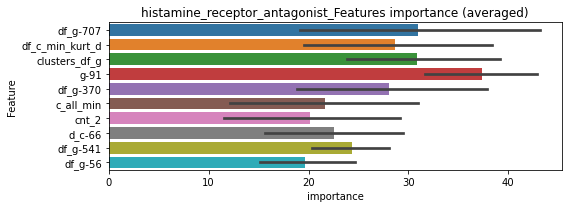

len(train_index) : 3641
len(valid_index) : 3642
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363588	valid_1's binary_logloss: 0.102279
[200]	training's binary_logloss: 0.00972457	valid_1's binary_logloss: 0.0845477
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00659624	valid_1's binary_logloss: 0.0832109


len(train_index) : 3642
len(valid_index) : 3641
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313707	valid_1's binary_logloss: 0.109618
[200]	training's binary_logloss: 0.0080491	valid_1's binary_logloss: 0.0957929
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00547138	valid_1's binary_logloss: 0.0949342


histamine_receptor_antagonist logloss: 0.08907178079647758
histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248499	valid_1's binary_logloss: 0.0371432
[200]	training's binary_logloss: 0.00301034	valid_1's binary_logloss: 0.00697898
[300]	training's binary_logloss: 0.000838437	valid_1's binary_logloss: 0.00268443
[400]	training's binary_logloss: 0.000439917	valid_1's binary_logloss: 0.00161417
[500]	training's binary_logloss: 0.000335772	valid_1's binary_logloss: 0.00138611
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00033323	valid_1's binary_logloss: 0.00138292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250951	valid_1's binary_logloss: 0.0388853
[200]	training's binary_logloss: 0.00304953	valid_1's binary_logloss: 0.00758767
[300]	training's binary_logloss: 0.000855308	valid_1's binary_logloss: 0.00343567
[400]	training's binary_logloss: 0.000451437	valid_1's binary_logloss: 0.00263295
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0016724, Threshold: 0.0022587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00203, conf_1:0.00248
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0022587
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_2: 0.0122587
threshold: 0.0122587, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248978	valid_1's binary_logloss: 0.0366877
[200]	training's binary_logloss: 0.00298583	valid_1's binary_logloss: 0.00641194
[300]	training's binary_logloss: 0.000838646	valid_1's binary_logloss: 0.00249943
[400]	training's binary_logloss: 0.000439661	valid_1's binary_logloss: 0.00150327
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000400478	valid_1's binary_logloss: 0.00141764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025746	valid_1's binary_logloss: 0.0402438
[200]	training's binary_logloss: 0.00306519	valid_1's binary_logloss: 0.00772358
[300]	training's binary_logloss: 0.000846525	valid_1's binary_logloss: 0.00338997
[400]	training's binary_logloss: 0.000442439	valid_1's binary_logloss: 0.00263732
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000342353	valid_1's binary_logloss: 0.002324

2 / 3 AUC score:1.000
y_Threshold: 0.0571167, Threshold: 0.0122587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.01103, conf_1:0.01348
threshold: 0.0122587, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248978	valid_1's binary_logloss: 0.0366877
[200]	training's binary_logloss: 0.00298583	valid_1's binary_logloss: 0.00641194
[300]	training's binary_logloss: 0.000838646	valid_1's binary_logloss: 0.00249943
[400]	training's binary_logloss: 0.000439661	valid_1's binary_logloss: 0.00150327
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000400478	valid_1's binary_logloss: 0.00141764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025746	valid_1's binary_logloss: 0.0402438
[200]	training's binary_logloss: 0.00306519	valid_1's binary_logloss: 0.00772358
[300]	training's binary_logloss: 0.000846525	valid_1's binary_logloss: 0.00338997
[400]	training's binary_logloss: 0.000442439	valid_1's binary_logloss: 0.00263732
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000342353	valid_1's binary_logloss: 0.002324

3 / 3 AUC score:1.000
y_Threshold: 0.0571167, Threshold: 0.0122587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.01103, conf_1:0.01348
threshold: 0.0122587, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


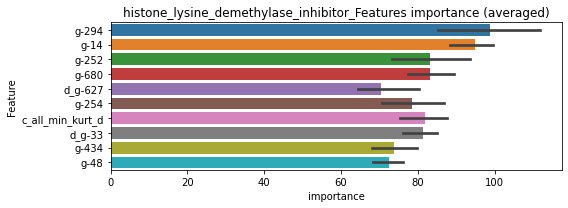

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136281	valid_1's binary_logloss: 0.0277683
[200]	training's binary_logloss: 0.00163829	valid_1's binary_logloss: 0.0115619
[300]	training's binary_logloss: 0.000452457	valid_1's binary_logloss: 0.00962215
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000472339	valid_1's binary_logloss: 0.00956746


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139351	valid_1's binary_logloss: 0.0202064
[200]	training's binary_logloss: 0.0017352	valid_1's binary_logloss: 0.00680538
[300]	training's binary_logloss: 0.000473613	valid_1's binary_logloss: 0.00540206
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000337399	valid_1's binary_logloss: 0.00522294


histone_lysine_demethylase_inhibitor logloss: 0.007395197996304496
histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294304	valid_1's binary_logloss: 0.0567799
[200]	training's binary_logloss: 0.00406932	valid_1's binary_logloss: 0.0235847
[300]	training's binary_logloss: 0.00118021	valid_1's binary_logloss: 0.0186269
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00103218	valid_1's binary_logloss: 0.0181871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303924	valid_1's binary_logloss: 0.0493791
[200]	training's binary_logloss: 0.00414972	valid_1's binary_logloss: 0.0114374
[300]	training's binary_logloss: 0.00118716	valid_1's binary_logloss: 0.00510375
[400]	training's binary_logloss: 0.000605415	valid_1's binary_logloss: 0.00348246
[500]	training's binary_logloss: 0.000428251	valid_1's binary_logloss: 0.00291648
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000402086	valid_1's binary_logloss: 0.00280889


1 / 3 AUC score:1.000
y_Threshold: 0.0038758, Threshold: 0.0055639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00501, conf_1:0.00612
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0055639
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.0155639
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.0255639
threshold: 0.0255639, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300776	valid_1's binary_logloss: 0.0612141
[200]	training's binary_logloss: 0.00408218	valid_1's binary_logloss: 0.0293498
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00239169	valid_1's binary_logloss: 0.0257009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299174	valid_1's binary_logloss: 0.0464709
[200]	training's binary_logloss: 0.00413296	valid_1's binary_logloss: 0.0105773
[300]	training's binary_logloss: 0.00119109	valid_1's binary_logloss: 0.00468031
[400]	training's binary_logloss: 0.000603293	valid_1's binary_logloss: 0.00307032
[500]	training's binary_logloss: 0.000426054	valid_1's binary_logloss: 0.00259501
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000389884	valid_1's binary_logloss: 0.00246854


2 / 3 AUC score:1.000
y_Threshold: 0.0253684, Threshold: 0.0255639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0057760 Vs.target_rate: 0.00134, Num_p_label: 23.0, conf_0:0.02301, conf_1:0.02812
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_1: 0.0255639
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_2: 0.0355639
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.0455639
threshold: 0.0455639, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298007	valid_1's binary_logloss: 0.0447502
[200]	training's binary_logloss: 0.00407797	valid_1's binary_logloss: 0.0102264
[300]	training's binary_logloss: 0.00117257	valid_1's binary_logloss: 0.0043468
[400]	training's binary_logloss: 0.000592289	valid_1's binary_logloss: 0.0028666
[500]	training's binary_logloss: 0.000417157	valid_1's binary_logloss: 0.0022953
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000386518	valid_1's binary_logloss: 0.00222341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029773	valid_1's binary_logloss: 0.0441147
[200]	training's binary_logloss: 0.00406304	valid_1's binary_logloss: 0.00972258
[300]	training's binary_logloss: 0.00116356	valid_1's binary_logloss: 0.00409332
[400]	training's binary_logloss: 0.000590168	valid_1's binary_logloss: 0.0027006
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0878804, Threshold: 0.0455639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0015068 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.04101, conf_1:0.05012
threshold: 0.0455639, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/7777, y_label_rate: 0.0843513


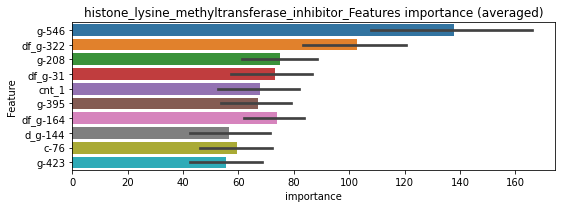

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155116	valid_1's binary_logloss: 0.0288711
[200]	training's binary_logloss: 0.00210893	valid_1's binary_logloss: 0.0113234
[300]	training's binary_logloss: 0.000595601	valid_1's binary_logloss: 0.00857661
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0003466	valid_1's binary_logloss: 0.00796128


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163197	valid_1's binary_logloss: 0.0254523
[200]	training's binary_logloss: 0.00224042	valid_1's binary_logloss: 0.00634679
[300]	training's binary_logloss: 0.000641287	valid_1's binary_logloss: 0.00326727
[400]	training's binary_logloss: 0.000318854	valid_1's binary_logloss: 0.00254853
[500]	training's binary_logloss: 0.000222209	valid_1's binary_logloss: 0.00233369
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000215697	valid_1's binary_logloss: 0.00232197


histone_lysine_methyltransferase_inhibitor logloss: 0.005141987043715767
hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617238	valid_1's binary_logloss: 0.115287
[200]	training's binary_logloss: 0.0137188	valid_1's binary_logloss: 0.0594194
[300]	training's binary_logloss: 0.00396666	valid_1's binary_logloss: 0.0433083
[400]	training's binary_logloss: 0.00168873	valid_1's binary_logloss: 0.038673
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00107771	valid_1's binary_logloss: 0.0375441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610196	valid_1's binary_logloss: 0.114358
[200]	training's binary_logloss: 0.0139819	valid_1's binary_logloss: 0.0624884
[300]	training's binary_logloss: 0.00397593	valid_1's binary_logloss: 0.0473661
[400]	training's binary_logloss: 0.00168493	valid_1's binary_logloss: 0.0431213
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00116413	valid_1's binary_logloss: 0.041731


1 / 3 AUC score:0.996
y_Threshold: 0.0107068, Threshold: 0.0162331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.01461, conf_1:0.01786
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0162331
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_2: 0.0262331
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_3: 0.0362331
threshold: 0.0362331, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 647.0/3785, y_label_rate: 0.1709379
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594682	valid_1's binary_logloss: 0.105598
[200]	training's binary_logloss: 0.0123725	valid_1's binary_logloss: 0.0455674
[300]	training's binary_logloss: 0.00350161	valid_1's binary_logloss: 0.0291085
[400]	training's binary_logloss: 0.00156392	valid_1's binary_logloss: 0.0242842
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.0010988	valid_1's binary_logloss: 0.0228212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589333	valid_1's binary_logloss: 0.104963
[200]	training's binary_logloss: 0.0129447	valid_1's binary_logloss: 0.045358
[300]	training's binary_logloss: 0.00380026	valid_1's binary_logloss: 0.0278033
[400]	training's binary_logloss: 0.00166409	valid_1's binary_logloss: 0.022025
[500]	training's binary_logloss: 0.000994173	valid_1's binary_logloss: 0.0198421
Early stopping, best iteration is:
[539]	training's

2 / 3 AUC score:1.000
y_Threshold: 0.0347838, Threshold: 0.0362331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0158212 Vs.target_rate: 0.00302, Num_p_label: 63.0, conf_0:0.03261, conf_1:0.03986
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_1: 0.0362331
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_2: 0.0462331
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_3: 0.0562331
threshold: 0.0562331, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598939	valid_1's binary_logloss: 0.109965
[200]	training's binary_logloss: 0.0121028	valid_1's binary_logloss: 0.0555644
[300]	training's binary_logloss: 0.00339306	valid_1's binary_logloss: 0.042827
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00230575	valid_1's binary_logloss: 0.0413347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565141	valid_1's binary_logloss: 0.107081
[200]	training's binary_logloss: 0.0115741	valid_1's binary_logloss: 0.0475747
[300]	training's binary_logloss: 0.00334263	valid_1's binary_logloss: 0.0328577
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00209122	valid_1's binary_logloss: 0.0298835


3 / 3 AUC score:0.999
y_Threshold: 0.0598280, Threshold: 0.0562331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 630.0/3751
p_label_rate: 0.0107986 Vs.target_rate: 0.00302, Num_p_label: 43.0, conf_0:0.05061, conf_1:0.06186
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_1: 0.0562331
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_2: 0.0662331
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_3: 0.0762331
threshold: 0.0762331, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 650.0/7733, y_label_rate: 0.0840553


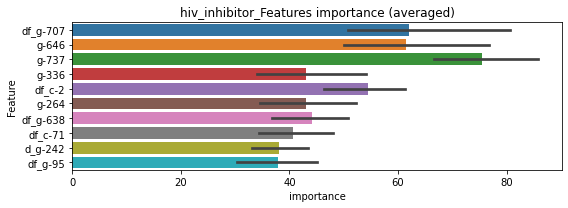

len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322964	valid_1's binary_logloss: 0.0670482
[200]	training's binary_logloss: 0.00683337	valid_1's binary_logloss: 0.0363011
[300]	training's binary_logloss: 0.00184753	valid_1's binary_logloss: 0.0292022
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0010255	valid_1's binary_logloss: 0.0278656


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325364	valid_1's binary_logloss: 0.0632861
[200]	training's binary_logloss: 0.00687747	valid_1's binary_logloss: 0.0338278
[300]	training's binary_logloss: 0.00196656	valid_1's binary_logloss: 0.0262572
[400]	training's binary_logloss: 0.000872542	valid_1's binary_logloss: 0.0250239
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000688814	valid_1's binary_logloss: 0.0245634


hiv_inhibitor logloss: 0.026214676097912462
hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041597	valid_1's binary_logloss: 0.0859563
[200]	training's binary_logloss: 0.00784357	valid_1's binary_logloss: 0.0547814
[300]	training's binary_logloss: 0.00248532	valid_1's binary_logloss: 0.0477289
[400]	training's binary_logloss: 0.00114844	valid_1's binary_logloss: 0.0460576
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00121842	valid_1's binary_logloss: 0.0459256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397565	valid_1's binary_logloss: 0.108548
[200]	training's binary_logloss: 0.00775952	valid_1's binary_logloss: 0.0869867


1 / 3 AUC score:0.994
y_Threshold: 0.0264255, Threshold: 0.1924912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 638/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.01188, Num_p_label: 80.0, conf_0:0.17324, conf_1:0.21174


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00585966	valid_1's binary_logloss: 0.0859714


threshold: 0.1924912, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 638.0/3770, y_label_rate: 0.1692308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330275	valid_1's binary_logloss: 0.0681498
[200]	training's binary_logloss: 0.00513002	valid_1's binary_logloss: 0.0449329
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00233248	valid_1's binary_logloss: 0.0430878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340551	valid_1's binary_logloss: 0.0632094
[200]	training's binary_logloss: 0.00549688	valid_1's binary_logloss: 0.0309913
[300]	training's binary_logloss: 0.00151054	valid_1's binary_logloss: 0.023777
[400]	training's binary_logloss: 0.00072206	valid_1's binary_logloss: 0.0214871
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000696076	valid_1's binary_logloss: 0.0214554


2 / 3 AUC score:0.997
y_Threshold: 0.1442204, Threshold: 0.1924912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 622.0/3738
p_label_rate: 0.0424410 Vs.target_rate: 0.01188, Num_p_label: 169.0, conf_0:0.17324, conf_1:0.21174
Num_p_label: 169.0, Expected: 47.3, Adj_threshold_1: 0.1924912
Num_p_label: 166.0, Expected: 47.3, Adj_threshold_2: 0.2024912
Num_p_label: 164.0, Expected: 47.3, Adj_threshold_3: 0.2124912
Num_p_label: 160.0, Expected: 47.3, Adj_threshold_4: 0.2224912
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_5: 0.2324912
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_6: 0.2424912
Num_p_label: 147.0, Expected: 47.3, Adj_threshold_7: 0.2524912
Num_p_label: 147.0, Expected: 47.3, Adj_threshold_8: 0.2624912
Num_p_label: 146.0, Expected: 47.3, Adj_threshold_9: 0.2724912
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_10: 0.2824912
threshold: 0.2924912, positive_p_label: 141.0/3982, p_label_rate: 0.0354093
positive_y_label: 622.0/3738, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028904	valid_1's binary_logloss: 0.0655814
[200]	training's binary_logloss: 0.00427354	valid_1's binary_logloss: 0.0404963
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00169087	valid_1's binary_logloss: 0.038036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319472	valid_1's binary_logloss: 0.0524415
[200]	training's binary_logloss: 0.00491669	valid_1's binary_logloss: 0.0215528
[300]	training's binary_logloss: 0.0013813	valid_1's binary_logloss: 0.0139696
[400]	training's binary_logloss: 0.000641444	valid_1's binary_logloss: 0.0113203
[500]	training's binary_logloss: 0.000449662	valid_1's binary_logloss: 0.0101844
[600]	training's binary_logloss: 0.000385451	valid_1's binary_logloss: 0.00960582
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000386858	valid_1's binary_logloss: 0.00959974


3 / 3 AUC score:0.997
y_Threshold: 0.1040019, Threshold: 0.2924912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 615.0/3724
p_label_rate: 0.0401808 Vs.target_rate: 0.01188, Num_p_label: 160.0, conf_0:0.26324, conf_1:0.32174
Num_p_label: 160.0, Expected: 47.3, Adj_threshold_1: 0.2924912
Num_p_label: 159.0, Expected: 47.3, Adj_threshold_2: 0.3024912
Num_p_label: 157.0, Expected: 47.3, Adj_threshold_3: 0.3124912
Num_p_label: 157.0, Expected: 47.3, Adj_threshold_4: 0.3224912
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_5: 0.3324912
Num_p_label: 154.0, Expected: 47.3, Adj_threshold_6: 0.3424912
Num_p_label: 151.0, Expected: 47.3, Adj_threshold_7: 0.3524912
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_8: 0.3624912
Num_p_label: 142.0, Expected: 47.3, Adj_threshold_9: 0.3724912
Num_p_label: 137.0, Expected: 47.3, Adj_threshold_10: 0.3824912
threshold: 0.3924912, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 751.0/7706, y_label_r

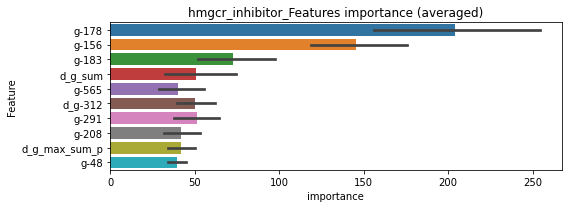

len(train_index) : 3853
len(valid_index) : 3853
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194272	valid_1's binary_logloss: 0.0435406
[200]	training's binary_logloss: 0.00318734	valid_1's binary_logloss: 0.0263715
[300]	training's binary_logloss: 0.000906782	valid_1's binary_logloss: 0.0228996
[400]	training's binary_logloss: 0.000420983	valid_1's binary_logloss: 0.0212383
[500]	training's binary_logloss: 0.000282704	valid_1's binary_logloss: 0.0205498
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000274326	valid_1's binary_logloss: 0.0204955


len(train_index) : 3853
len(valid_index) : 3853
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201348	valid_1's binary_logloss: 0.0419479
[200]	training's binary_logloss: 0.00340642	valid_1's binary_logloss: 0.0236601
[300]	training's binary_logloss: 0.00096614	valid_1's binary_logloss: 0.0204648
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000505338	valid_1's binary_logloss: 0.0192555


hmgcr_inhibitor logloss: 0.019875492199529318
hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276293	valid_1's binary_logloss: 0.0465803
[200]	training's binary_logloss: 0.00376731	valid_1's binary_logloss: 0.0152486
[300]	training's binary_logloss: 0.00106585	valid_1's binary_logloss: 0.00843577
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000766798	valid_1's binary_logloss: 0.00756858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276759	valid_1's binary_logloss: 0.0504165
[200]	training's binary_logloss: 0.00359156	valid_1's binary_logloss: 0.0206599
[300]	training's binary_logloss: 0.00102921	valid_1's binary_logloss: 0.0147947
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00107968	valid_1's binary_logloss: 0.0147038


1 / 3 AUC score:1.000
y_Threshold: 0.0036656, Threshold: 0.0144583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 131 → Positive_corect_labels: 655/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00391, Num_p_label: 80.0, conf_0:0.01301, conf_1:0.01590
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0144583
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_2: 0.0244583
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_3: 0.0344583
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_4: 0.0444583
Num_p_label: 29.0, Expected: 15.6, Adj_threshold_5: 0.0544583
threshold: 0.0544583, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278033	valid_1's binary_logloss: 0.043738
[200]	training's binary_logloss: 0.00362453	valid_1's binary_logloss: 0.0123792
[300]	training's binary_logloss: 0.00101682	valid_1's binary_logloss: 0.00676263
[400]	training's binary_logloss: 0.000519631	valid_1's binary_logloss: 0.00512395
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000400863	valid_1's binary_logloss: 0.00468862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277481	valid_1's binary_logloss: 0.0481481
[200]	training's binary_logloss: 0.00348484	valid_1's binary_logloss: 0.0187168
[300]	training's binary_logloss: 0.000982077	valid_1's binary_logloss: 0.0137765
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000602131	valid_1's binary_logloss: 0.0126797


2 / 3 AUC score:1.000
y_Threshold: 0.0339789, Threshold: 0.0544583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3795
p_label_rate: 0.0195881 Vs.target_rate: 0.00391, Num_p_label: 78.0, conf_0:0.04901, conf_1:0.05990
Num_p_label: 78.0, Expected: 15.6, Adj_threshold_1: 0.0544583
Num_p_label: 75.0, Expected: 15.6, Adj_threshold_2: 0.0644583
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_3: 0.0744583
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_4: 0.0844583
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_5: 0.0944583
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_6: 0.1044583
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_7: 0.1144583
Num_p_label: 54.0, Expected: 15.6, Adj_threshold_8: 0.1244583
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_9: 0.1344583
Num_p_label: 49.0, Expected: 15.6, Adj_threshold_10: 0.1444583
threshold: 0.1544583, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 653.0/3795, y_label_rate: 0.172068

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268128	valid_1's binary_logloss: 0.0529357
[200]	training's binary_logloss: 0.00321456	valid_1's binary_logloss: 0.0265294
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00150019	valid_1's binary_logloss: 0.0249839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276992	valid_1's binary_logloss: 0.0487441
[200]	training's binary_logloss: 0.00357286	valid_1's binary_logloss: 0.0175412
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0011815	valid_1's binary_logloss: 0.0119211


3 / 3 AUC score:1.000
y_Threshold: 0.0333026, Threshold: 0.1544583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 650.0/3789
p_label_rate: 0.0115520 Vs.target_rate: 0.00391, Num_p_label: 46.0, conf_0:0.13901, conf_1:0.16990
threshold: 0.1544583, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 696.0/7771, y_label_rate: 0.0895638


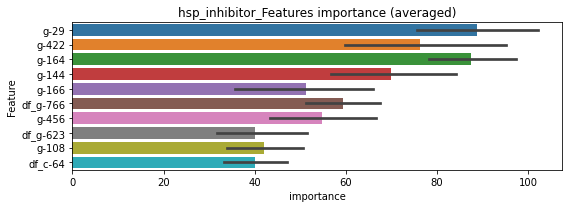

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159703	valid_1's binary_logloss: 0.0346835
[200]	training's binary_logloss: 0.00220783	valid_1's binary_logloss: 0.0180586
[300]	training's binary_logloss: 0.000622256	valid_1's binary_logloss: 0.014496
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00046205	valid_1's binary_logloss: 0.0138851


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158319	valid_1's binary_logloss: 0.0348181
[200]	training's binary_logloss: 0.00216085	valid_1's binary_logloss: 0.0197852
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000763165	valid_1's binary_logloss: 0.0175054


hsp_inhibitor logloss: 0.015695060879828585
igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327605	valid_1's binary_logloss: 0.0567264
[200]	training's binary_logloss: 0.00475392	valid_1's binary_logloss: 0.0191104
[300]	training's binary_logloss: 0.00137599	valid_1's binary_logloss: 0.012079
[400]	training's binary_logloss: 0.000690032	valid_1's binary_logloss: 0.00953177
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00057335	valid_1's binary_logloss: 0.00899591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323602	valid_1's binary_logloss: 0.0548242
[200]	training's binary_logloss: 0.00467481	valid_1's binary_logloss: 0.0152314
[300]	training's binary_logloss: 0.00135338	valid_1's binary_logloss: 0.00789395
[400]	training's binary_logloss: 0.000683844	valid_1's binary_logloss: 0.00571229
[500]	training's binary_logloss: 0.000474531	valid_1's binary_logloss: 0.00488248
Early stopping, best iteration is:
[57

1 / 3 AUC score:1.000
y_Threshold: 0.0049097, Threshold: 0.0092722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00834, conf_1:0.01020
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0092722
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.0192722
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_3: 0.0292722
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_4: 0.0392722
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.0492722
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_6: 0.0592722
threshold: 0.0592722, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299652	valid_1's binary_logloss: 0.0539229
[200]	training's binary_logloss: 0.00423145	valid_1's binary_logloss: 0.0187802
[300]	training's binary_logloss: 0.00121565	valid_1's binary_logloss: 0.0124532
[400]	training's binary_logloss: 0.000627193	valid_1's binary_logloss: 0.0108193
[500]	training's binary_logloss: 0.000444814	valid_1's binary_logloss: 0.00990308
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000445593	valid_1's binary_logloss: 0.00988158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031831	valid_1's binary_logloss: 0.0490515
[200]	training's binary_logloss: 0.00444894	valid_1's binary_logloss: 0.0116066
[300]	training's binary_logloss: 0.00128328	valid_1's binary_logloss: 0.00531939
[400]	training's binary_logloss: 0.000646684	valid_1's binary_logloss: 0.00355262
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0341553, Threshold: 0.0592722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0165746 Vs.target_rate: 0.00155, Num_p_label: 66.0, conf_0:0.05334, conf_1:0.06520
Num_p_label: 66.0, Expected: 6.2, Adj_threshold_1: 0.0592722
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_2: 0.0692722
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_3: 0.0792722
Num_p_label: 49.0, Expected: 6.2, Adj_threshold_4: 0.0892722
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_5: 0.0992722
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_6: 0.1092722
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_7: 0.1192722
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_8: 0.1292722
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_9: 0.1392722
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_10: 0.1492722
threshold: 0.1592722, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301472	valid_1's binary_logloss: 0.0508385
[200]	training's binary_logloss: 0.00424644	valid_1's binary_logloss: 0.0139855
[300]	training's binary_logloss: 0.00123401	valid_1's binary_logloss: 0.0069302
[400]	training's binary_logloss: 0.000630666	valid_1's binary_logloss: 0.00518178
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000621938	valid_1's binary_logloss: 0.00512177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314225	valid_1's binary_logloss: 0.0425238
[200]	training's binary_logloss: 0.00450166	valid_1's binary_logloss: 0.00937903
[300]	training's binary_logloss: 0.00128523	valid_1's binary_logloss: 0.00407274
[400]	training's binary_logloss: 0.000643347	valid_1's binary_logloss: 0.00276161
[500]	training's binary_logloss: 0.00045522	valid_1's binary_logloss: 0.00231101
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0832979, Threshold: 0.1592722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0065294 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.14334, conf_1:0.17520
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.1592722
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_2: 0.1692722
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.1792722
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_4: 0.1892722
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.1992722
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_6: 0.2092722
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_7: 0.2192722
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_8: 0.2292722
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_9: 0.2392722
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_10: 0.2492722
threshold: 0.2592722, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 674.0/7786, y_label_rate: 0.0865656


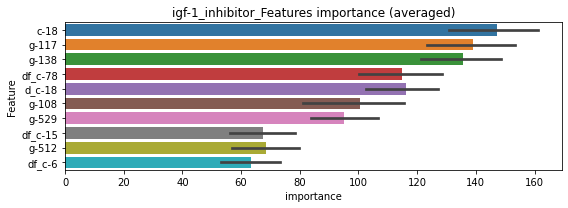

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166924	valid_1's binary_logloss: 0.0316249
[200]	training's binary_logloss: 0.00235291	valid_1's binary_logloss: 0.0133651
[300]	training's binary_logloss: 0.00068247	valid_1's binary_logloss: 0.0102865
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000403474	valid_1's binary_logloss: 0.00974807


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176474	valid_1's binary_logloss: 0.0274839
[200]	training's binary_logloss: 0.00258179	valid_1's binary_logloss: 0.00764481
[300]	training's binary_logloss: 0.000749202	valid_1's binary_logloss: 0.00437277
[400]	training's binary_logloss: 0.000374303	valid_1's binary_logloss: 0.0036281
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00033664	valid_1's binary_logloss: 0.00350886


igf-1_inhibitor logloss: 0.006628466985437579
ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275931	valid_1's binary_logloss: 0.0445015
[200]	training's binary_logloss: 0.00353765	valid_1's binary_logloss: 0.013018
[300]	training's binary_logloss: 0.00100611	valid_1's binary_logloss: 0.00768812
[400]	training's binary_logloss: 0.000523316	valid_1's binary_logloss: 0.00604706
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000427893	valid_1's binary_logloss: 0.00577322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279073	valid_1's binary_logloss: 0.0483447
[200]	training's binary_logloss: 0.0037045	valid_1's binary_logloss: 0.0165994
[300]	training's binary_logloss: 0.00103074	valid_1's binary_logloss: 0.0104182
[400]	training's binary_logloss: 0.000523317	valid_1's binary_logloss: 0.00887281
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000419128	valid_1's binary_logloss: 0.00856367


1 / 3 AUC score:1.000
y_Threshold: 0.0022981, Threshold: 0.1872786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.16855, conf_1:0.20601
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.1872786
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_2: 0.1972786
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_3: 0.2072786
Num_p_label: 77.0, Expected: 5.0, Adj_threshold_4: 0.2172786
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_5: 0.2272786
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_6: 0.2372786
Num_p_label: 74.0, Expected: 5.0, Adj_threshold_7: 0.2472786
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_8: 0.2572786
Num_p_label: 69.0, Expected: 5.0, Adj_threshold_9: 0.2672786
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_10: 0.2772786
threshold: 0.2872786, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266721	valid_1's binary_logloss: 0.0396877
[200]	training's binary_logloss: 0.00332978	valid_1's binary_logloss: 0.00884484
[300]	training's binary_logloss: 0.000950062	valid_1's binary_logloss: 0.0040734
[400]	training's binary_logloss: 0.000489348	valid_1's binary_logloss: 0.00285241
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000387111	valid_1's binary_logloss: 0.00257935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267661	valid_1's binary_logloss: 0.0426928
[200]	training's binary_logloss: 0.0033461	valid_1's binary_logloss: 0.0122288
[300]	training's binary_logloss: 0.000959352	valid_1's binary_logloss: 0.00802979
[400]	training's binary_logloss: 0.000496313	valid_1's binary_logloss: 0.0067548
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000393606	valid_1's binary_logloss: 0.00630041


2 / 3 AUC score:1.000
y_Threshold: 0.0881505, Threshold: 0.2872786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0278754 Vs.target_rate: 0.00126, Num_p_label: 111.0, conf_0:0.25855, conf_1:0.31601
Num_p_label: 111.0, Expected: 5.0, Adj_threshold_1: 0.2872786
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_2: 0.2972786
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_3: 0.3072786
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_4: 0.3172786
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_5: 0.3272786
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_6: 0.3372786
Num_p_label: 109.0, Expected: 5.0, Adj_threshold_7: 0.3472786
Num_p_label: 108.0, Expected: 5.0, Adj_threshold_8: 0.3572786
Num_p_label: 105.0, Expected: 5.0, Adj_threshold_9: 0.3672786
Num_p_label: 105.0, Expected: 5.0, Adj_threshold_10: 0.3772786
threshold: 0.3872786, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 655.0/3806, y_label_rate: 0.1720

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267419	valid_1's binary_logloss: 0.0445665
[200]	training's binary_logloss: 0.00334314	valid_1's binary_logloss: 0.0175884
[300]	training's binary_logloss: 0.000945476	valid_1's binary_logloss: 0.0137127
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000589247	valid_1's binary_logloss: 0.0121054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268792	valid_1's binary_logloss: 0.0387493
[200]	training's binary_logloss: 0.00339503	valid_1's binary_logloss: 0.00906526
[300]	training's binary_logloss: 0.000954323	valid_1's binary_logloss: 0.00405983
[400]	training's binary_logloss: 0.000492097	valid_1's binary_logloss: 0.00272818
[500]	training's binary_logloss: 0.000381296	valid_1's binary_logloss: 0.00236312
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000379402	valid_1's binary_logloss: 0.00235912

3 / 3 AUC score:1.000
y_Threshold: 0.0306805, Threshold: 0.3872786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0261175 Vs.target_rate: 0.00126, Num_p_label: 104.0, conf_0:0.34855, conf_1:0.42601
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_1: 0.3872786
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_2: 0.3972786
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_3: 0.4072786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_4: 0.4172786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_5: 0.4272786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_6: 0.4372786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_7: 0.4472786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_8: 0.4572786
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_9: 0.4672786
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_10: 0.4772786
threshold: 0.4872786, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 753.0/7784, y_label_rate: 0.0967

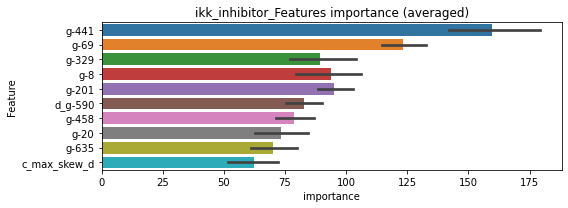

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016483	valid_1's binary_logloss: 0.027632
[200]	training's binary_logloss: 0.00217197	valid_1's binary_logloss: 0.00935782
[300]	training's binary_logloss: 0.000600021	valid_1's binary_logloss: 0.00634053
[400]	training's binary_logloss: 0.000306393	valid_1's binary_logloss: 0.0053955
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000240736	valid_1's binary_logloss: 0.00520412


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166917	valid_1's binary_logloss: 0.0282276
[200]	training's binary_logloss: 0.0022807	valid_1's binary_logloss: 0.0101127
[300]	training's binary_logloss: 0.000606464	valid_1's binary_logloss: 0.00664512
[400]	training's binary_logloss: 0.000301762	valid_1's binary_logloss: 0.00577446
[500]	training's binary_logloss: 0.000223629	valid_1's binary_logloss: 0.00539648
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000224967	valid_1's binary_logloss: 0.00539584


ikk_inhibitor logloss: 0.005300062931100147
imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379735	valid_1's binary_logloss: 0.0535416
[200]	training's binary_logloss: 0.00544149	valid_1's binary_logloss: 0.0121207
[300]	training's binary_logloss: 0.00148778	valid_1's binary_logloss: 0.00524125
[400]	training's binary_logloss: 0.000708109	valid_1's binary_logloss: 0.00341187
[500]	training's binary_logloss: 0.000474352	valid_1's binary_logloss: 0.00281413
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000446281	valid_1's binary_logloss: 0.00274076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037338	valid_1's binary_logloss: 0.0540405
[200]	training's binary_logloss: 0.00559298	valid_1's binary_logloss: 0.0126182
[300]	training's binary_logloss: 0.00150767	valid_1's binary_logloss: 0.00513274
[400]	training's binary_logloss: 0.000726734	valid_1's binary_logloss: 0.00324014
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0029751, Threshold: 0.0059495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00535, conf_1:0.00654
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0059495
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_2: 0.0159495
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.0259495
threshold: 0.0259495, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350136	valid_1's binary_logloss: 0.0524255
[200]	training's binary_logloss: 0.005135	valid_1's binary_logloss: 0.0115873
[300]	training's binary_logloss: 0.0014318	valid_1's binary_logloss: 0.00458744
[400]	training's binary_logloss: 0.000688314	valid_1's binary_logloss: 0.00293258
[500]	training's binary_logloss: 0.000464434	valid_1's binary_logloss: 0.00238095
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000427518	valid_1's binary_logloss: 0.00230492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371213	valid_1's binary_logloss: 0.0533319
[200]	training's binary_logloss: 0.0054421	valid_1's binary_logloss: 0.0126141
[300]	training's binary_logloss: 0.00148484	valid_1's binary_logloss: 0.005082
[400]	training's binary_logloss: 0.000713116	valid_1's binary_logloss: 0.00321364
[500]	training's binary_logloss: 0.000483

2 / 3 AUC score:1.000
y_Threshold: 0.0568857, Threshold: 0.0259495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0075339 Vs.target_rate: 0.00130, Num_p_label: 30.0, conf_0:0.02335, conf_1:0.02854
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_1: 0.0259495
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.0359495
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_3: 0.0459495
threshold: 0.0459495, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350136	valid_1's binary_logloss: 0.0524255
[200]	training's binary_logloss: 0.005135	valid_1's binary_logloss: 0.0115873
[300]	training's binary_logloss: 0.0014318	valid_1's binary_logloss: 0.00458744
[400]	training's binary_logloss: 0.000688314	valid_1's binary_logloss: 0.00293258
[500]	training's binary_logloss: 0.000464434	valid_1's binary_logloss: 0.00238095
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000427518	valid_1's binary_logloss: 0.00230492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371213	valid_1's binary_logloss: 0.0533319
[200]	training's binary_logloss: 0.0054421	valid_1's binary_logloss: 0.0126141
[300]	training's binary_logloss: 0.00148484	valid_1's binary_logloss: 0.005082
[400]	training's binary_logloss: 0.000713116	valid_1's binary_logloss: 0.00321364
[500]	training's binary_logloss: 0.000483

3 / 3 AUC score:1.000
y_Threshold: 0.0568857, Threshold: 0.0459495, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.04135, conf_1:0.05054
threshold: 0.0459495, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


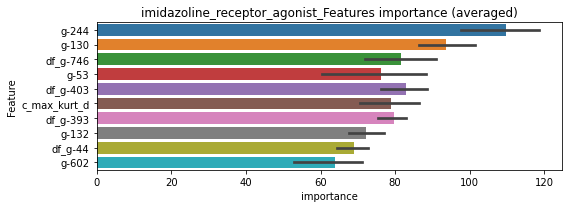

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200796	valid_1's binary_logloss: 0.0316077
[200]	training's binary_logloss: 0.00292138	valid_1's binary_logloss: 0.0115118
[300]	training's binary_logloss: 0.000771393	valid_1's binary_logloss: 0.00901674
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000540029	valid_1's binary_logloss: 0.00886818


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020867	valid_1's binary_logloss: 0.0332657
[200]	training's binary_logloss: 0.0030842	valid_1's binary_logloss: 0.0113473
[300]	training's binary_logloss: 0.00083393	valid_1's binary_logloss: 0.00809425
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000558224	valid_1's binary_logloss: 0.00765177


imidazoline_receptor_agonist logloss: 0.008259974905603802
immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461819	valid_1's binary_logloss: 0.0915386
[200]	training's binary_logloss: 0.00925184	valid_1's binary_logloss: 0.0422054
[300]	training's binary_logloss: 0.0028015	valid_1's binary_logloss: 0.0294055
[400]	training's binary_logloss: 0.00131853	valid_1's binary_logloss: 0.0248989
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00109164	valid_1's binary_logloss: 0.0242278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467495	valid_1's binary_logloss: 0.100678
[200]	training's binary_logloss: 0.00948599	valid_1's binary_logloss: 0.0456033
[300]	training's binary_logloss: 0.00289628	valid_1's binary_logloss: 0.0302111
[400]	training's binary_logloss: 0.00139359	valid_1's binary_logloss: 0.0248671
[500]	training's binary_logloss: 0.000884131	valid_1's binary_logloss: 0.022605
Early stopping, best iteration is:
[555]	traini

1 / 3 AUC score:0.999
y_Threshold: 0.0123829, Threshold: 0.0232017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.02088, conf_1:0.02552
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0232017
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_2: 0.0332017
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_3: 0.0432017
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_4: 0.0532017
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_5: 0.0632017
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_6: 0.0732017
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_7: 0.0832017
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_8: 0.0932017
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_9: 0.1032017
threshold: 0.1032017, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414912	valid_1's binary_logloss: 0.0994945
[200]	training's binary_logloss: 0.007535	valid_1's binary_logloss: 0.0582496
[300]	training's binary_logloss: 0.00231607	valid_1's binary_logloss: 0.048821
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00137498	valid_1's binary_logloss: 0.0463888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438462	valid_1's binary_logloss: 0.0924962
[200]	training's binary_logloss: 0.00823967	valid_1's binary_logloss: 0.044923
[300]	training's binary_logloss: 0.0024742	valid_1's binary_logloss: 0.0330577
[400]	training's binary_logloss: 0.00118628	valid_1's binary_logloss: 0.0291686
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0011471	valid_1's binary_logloss: 0.0290725


2 / 3 AUC score:0.997
y_Threshold: 0.0530767, Threshold: 0.1032017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 638.0/3767
p_label_rate: 0.0185836 Vs.target_rate: 0.00307, Num_p_label: 74.0, conf_0:0.09288, conf_1:0.11352
Num_p_label: 74.0, Expected: 12.2, Adj_threshold_1: 0.1032017
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_2: 0.1132017
Num_p_label: 67.0, Expected: 12.2, Adj_threshold_3: 0.1232017
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_4: 0.1332017
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_5: 0.1432017
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_6: 0.1532017
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_7: 0.1632017
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_8: 0.1732017
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_9: 0.1832017
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_10: 0.1932017
threshold: 0.2032017, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 638.0/3767, y_label_rate: 0.16936

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403903	valid_1's binary_logloss: 0.0861121
[200]	training's binary_logloss: 0.00730626	valid_1's binary_logloss: 0.0415198
[300]	training's binary_logloss: 0.00222461	valid_1's binary_logloss: 0.0312507
[400]	training's binary_logloss: 0.00109829	valid_1's binary_logloss: 0.0279915
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000791238	valid_1's binary_logloss: 0.0269967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414227	valid_1's binary_logloss: 0.0836667
[200]	training's binary_logloss: 0.00740644	valid_1's binary_logloss: 0.0385112
[300]	training's binary_logloss: 0.00230055	valid_1's binary_logloss: 0.0277663
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00119711	valid_1's binary_logloss: 0.0249241


3 / 3 AUC score:1.000
y_Threshold: 0.0585517, Threshold: 0.2032017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 629.0/3749
p_label_rate: 0.0145655 Vs.target_rate: 0.00307, Num_p_label: 58.0, conf_0:0.18288, conf_1:0.22352
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_1: 0.2032017
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_2: 0.2132017
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_3: 0.2232017
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_4: 0.2332017
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_5: 0.2432017
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_6: 0.2532017
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_7: 0.2632017
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_8: 0.2732017
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_9: 0.2832017
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_10: 0.2932017
threshold: 0.3032017, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 671.0/7731, y_label_rate: 0.08679

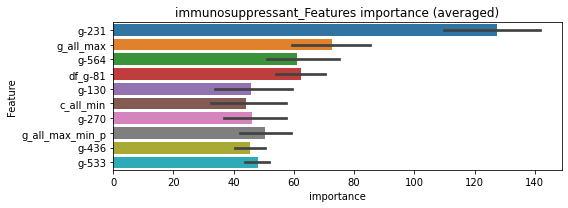

len(train_index) : 3865
len(valid_index) : 3866
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206908	valid_1's binary_logloss: 0.0581041
[200]	training's binary_logloss: 0.0037078	valid_1's binary_logloss: 0.0366418
[300]	training's binary_logloss: 0.001099	valid_1's binary_logloss: 0.0322397
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000970344	valid_1's binary_logloss: 0.0319298


len(train_index) : 3866
len(valid_index) : 3865
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226742	valid_1's binary_logloss: 0.0468322
[200]	training's binary_logloss: 0.00387075	valid_1's binary_logloss: 0.0209446
[300]	training's binary_logloss: 0.0012219	valid_1's binary_logloss: 0.0147147
[400]	training's binary_logloss: 0.000589979	valid_1's binary_logloss: 0.0123235
[500]	training's binary_logloss: 0.000386134	valid_1's binary_logloss: 0.011173
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000314421	valid_1's binary_logloss: 0.0106803


immunosuppressant logloss: 0.021306422442742303
insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036742	valid_1's binary_logloss: 0.0590036
[200]	training's binary_logloss: 0.00542937	valid_1's binary_logloss: 0.0164721
[300]	training's binary_logloss: 0.00145004	valid_1's binary_logloss: 0.00820482
[400]	training's binary_logloss: 0.000705187	valid_1's binary_logloss: 0.00609381
[500]	training's binary_logloss: 0.000481144	valid_1's binary_logloss: 0.00520882
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000492307	valid_1's binary_logloss: 0.00517311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356972	valid_1's binary_logloss: 0.0583889
[200]	training's binary_logloss: 0.00533214	valid_1's binary_logloss: 0.0174929
[300]	training's binary_logloss: 0.00145471	valid_1's binary_logloss: 0.00861491
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000797497	valid_1's binary_logloss: 0.00674059


1 / 3 AUC score:1.000
y_Threshold: 0.0041187, Threshold: 0.0064157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00577, conf_1:0.00706
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0064157
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.0164157
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.0264157
threshold: 0.0264157, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352859	valid_1's binary_logloss: 0.0555955
[200]	training's binary_logloss: 0.00500095	valid_1's binary_logloss: 0.0147377
[300]	training's binary_logloss: 0.0013849	valid_1's binary_logloss: 0.00790322
[400]	training's binary_logloss: 0.000684924	valid_1's binary_logloss: 0.00581579
[500]	training's binary_logloss: 0.000470073	valid_1's binary_logloss: 0.00512316
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000480477	valid_1's binary_logloss: 0.00512167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334368	valid_1's binary_logloss: 0.0533887
[200]	training's binary_logloss: 0.00485221	valid_1's binary_logloss: 0.0151925
[300]	training's binary_logloss: 0.00137445	valid_1's binary_logloss: 0.00746947
[400]	training's binary_logloss: 0.000687253	valid_1's binary_logloss: 0.00570407
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0573512, Threshold: 0.0264157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0052737 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.02377, conf_1:0.02906
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.0264157
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.0364157
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.0464157
threshold: 0.0464157, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352859	valid_1's binary_logloss: 0.0555955
[200]	training's binary_logloss: 0.00500095	valid_1's binary_logloss: 0.0147377
[300]	training's binary_logloss: 0.0013849	valid_1's binary_logloss: 0.00790322
[400]	training's binary_logloss: 0.000684924	valid_1's binary_logloss: 0.00581579
[500]	training's binary_logloss: 0.000470073	valid_1's binary_logloss: 0.00512316
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000480477	valid_1's binary_logloss: 0.00512167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334368	valid_1's binary_logloss: 0.0533887
[200]	training's binary_logloss: 0.00485221	valid_1's binary_logloss: 0.0151925
[300]	training's binary_logloss: 0.00137445	valid_1's binary_logloss: 0.00746947
[400]	training's binary_logloss: 0.000687253	valid_1's binary_logloss: 0.00570407
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0573512, Threshold: 0.0464157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.04177, conf_1:0.05106
threshold: 0.0464157, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


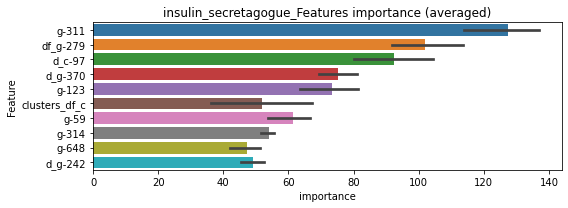

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190207	valid_1's binary_logloss: 0.0367153
[200]	training's binary_logloss: 0.00268384	valid_1's binary_logloss: 0.01461
[300]	training's binary_logloss: 0.000737682	valid_1's binary_logloss: 0.0110562
[400]	training's binary_logloss: 0.000354807	valid_1's binary_logloss: 0.0102411
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000295037	valid_1's binary_logloss: 0.0100829


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194782	valid_1's binary_logloss: 0.0292612
[200]	training's binary_logloss: 0.00288363	valid_1's binary_logloss: 0.00824279
[300]	training's binary_logloss: 0.000796286	valid_1's binary_logloss: 0.00517825
[400]	training's binary_logloss: 0.000383963	valid_1's binary_logloss: 0.0045178
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000363351	valid_1's binary_logloss: 0.0044705


insulin_secretagogue logloss: 0.007276677532546709
insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036663	valid_1's binary_logloss: 0.0830584
[200]	training's binary_logloss: 0.00610761	valid_1's binary_logloss: 0.040272
[300]	training's binary_logloss: 0.00179604	valid_1's binary_logloss: 0.0331796
[400]	training's binary_logloss: 0.000878611	valid_1's binary_logloss: 0.0308938
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000756045	valid_1's binary_logloss: 0.0306325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386863	valid_1's binary_logloss: 0.0655029
[200]	training's binary_logloss: 0.00648894	valid_1's binary_logloss: 0.0249156
[300]	training's binary_logloss: 0.00190348	valid_1's binary_logloss: 0.0186004
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00161492	valid_1's binary_logloss: 0.0181094


1 / 3 AUC score:0.998
y_Threshold: 0.0094304, Threshold: 0.0176226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00214, Num_p_label: 80.0, conf_0:0.01586, conf_1:0.01938
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0176226
Num_p_label: 35.0, Expected: 8.5, Adj_threshold_2: 0.0276226
Num_p_label: 22.0, Expected: 8.5, Adj_threshold_3: 0.0376226
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_4: 0.0476226
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_5: 0.0576226
threshold: 0.0576226, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360392	valid_1's binary_logloss: 0.0655494
[200]	training's binary_logloss: 0.00578786	valid_1's binary_logloss: 0.0256307
[300]	training's binary_logloss: 0.0016926	valid_1's binary_logloss: 0.0162751
[400]	training's binary_logloss: 0.000832447	valid_1's binary_logloss: 0.0134288
[500]	training's binary_logloss: 0.000551695	valid_1's binary_logloss: 0.0121678
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000551695	valid_1's binary_logloss: 0.0121678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356105	valid_1's binary_logloss: 0.0613366
[200]	training's binary_logloss: 0.00579312	valid_1's binary_logloss: 0.021152
[300]	training's binary_logloss: 0.00168694	valid_1's binary_logloss: 0.0130054
[400]	training's binary_logloss: 0.000836724	valid_1's binary_logloss: 0.011174
Early stopping, best iteration is:
[461]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0384540, Threshold: 0.0576226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 647.0/3787
p_label_rate: 0.0077850 Vs.target_rate: 0.00214, Num_p_label: 31.0, conf_0:0.05186, conf_1:0.06338
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_1: 0.0576226
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_2: 0.0676226
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_3: 0.0776226
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_4: 0.0876226
threshold: 0.0876226, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342637	valid_1's binary_logloss: 0.069358
[200]	training's binary_logloss: 0.0052304	valid_1's binary_logloss: 0.0315296
[300]	training's binary_logloss: 0.00156229	valid_1's binary_logloss: 0.0243941
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00096588	valid_1's binary_logloss: 0.0230209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367427	valid_1's binary_logloss: 0.0625082
[200]	training's binary_logloss: 0.00584437	valid_1's binary_logloss: 0.021108
[300]	training's binary_logloss: 0.00168584	valid_1's binary_logloss: 0.0117116
[400]	training's binary_logloss: 0.000824336	valid_1's binary_logloss: 0.00887558
[500]	training's binary_logloss: 0.000556748	valid_1's binary_logloss: 0.00766392
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000507635	valid_1's binary_logloss: 0.00744546


3 / 3 AUC score:1.000
y_Threshold: 0.0291308, Threshold: 0.0876226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0045203 Vs.target_rate: 0.00214, Num_p_label: 18.0, conf_0:0.07886, conf_1:0.09638
threshold: 0.0876226, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 662.0/7763, y_label_rate: 0.0852763


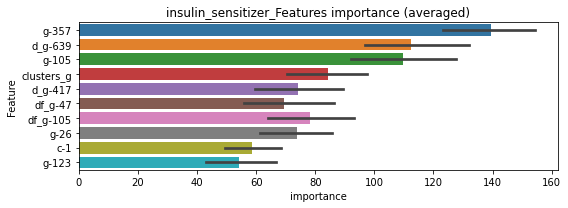

len(train_index) : 3881
len(valid_index) : 3882
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201167	valid_1's binary_logloss: 0.0398876
[200]	training's binary_logloss: 0.00312626	valid_1's binary_logloss: 0.0185304
[300]	training's binary_logloss: 0.000907251	valid_1's binary_logloss: 0.0147828
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000549489	valid_1's binary_logloss: 0.0140962


len(train_index) : 3882
len(valid_index) : 3881
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202268	valid_1's binary_logloss: 0.0406959
[200]	training's binary_logloss: 0.003181	valid_1's binary_logloss: 0.0169566
[300]	training's binary_logloss: 0.000942001	valid_1's binary_logloss: 0.0119534
[400]	training's binary_logloss: 0.000460109	valid_1's binary_logloss: 0.0104982
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000335254	valid_1's binary_logloss: 0.00995396


insulin_sensitizer logloss: 0.012025351684775547
integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407779	valid_1's binary_logloss: 0.0725865
[200]	training's binary_logloss: 0.00744548	valid_1's binary_logloss: 0.029481
[300]	training's binary_logloss: 0.00212931	valid_1's binary_logloss: 0.0178427
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00114262	valid_1's binary_logloss: 0.0148851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439766	valid_1's binary_logloss: 0.0794726
[200]	training's binary_logloss: 0.00806016	valid_1's binary_logloss: 0.032838
[300]	training's binary_logloss: 0.00224884	valid_1's binary_logloss: 0.0189173
[400]	training's binary_logloss: 0.00102982	valid_1's binary_logloss: 0.0147309
[500]	training's binary_logloss: 0.000659571	valid_1's binary_logloss: 0.0130723
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000615821	valid_1's binary_logloss: 0.0127652


1 / 3 AUC score:1.000
y_Threshold: 0.0055935, Threshold: 0.0077235, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00695, conf_1:0.00850
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077235
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0177235
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_3: 0.0277235
threshold: 0.0277235, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410932	valid_1's binary_logloss: 0.073021
[200]	training's binary_logloss: 0.00701771	valid_1's binary_logloss: 0.0277957
[300]	training's binary_logloss: 0.00200913	valid_1's binary_logloss: 0.0179889
[400]	training's binary_logloss: 0.000972359	valid_1's binary_logloss: 0.0147899
[500]	training's binary_logloss: 0.000626562	valid_1's binary_logloss: 0.013568
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000561561	valid_1's binary_logloss: 0.0132843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443438	valid_1's binary_logloss: 0.0771531
[200]	training's binary_logloss: 0.00760116	valid_1's binary_logloss: 0.02724
[300]	training's binary_logloss: 0.00213893	valid_1's binary_logloss: 0.0156751
[400]	training's binary_logloss: 0.00100556	valid_1's binary_logloss: 0.0116734
[500]	training's binary_logloss: 0.000646062	v

2 / 3 AUC score:1.000
y_Threshold: 0.0246846, Threshold: 0.0277235, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0030136 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.02495, conf_1:0.03050
threshold: 0.0277235, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410932	valid_1's binary_logloss: 0.073021
[200]	training's binary_logloss: 0.00701771	valid_1's binary_logloss: 0.0277957
[300]	training's binary_logloss: 0.00200913	valid_1's binary_logloss: 0.0179889
[400]	training's binary_logloss: 0.000972359	valid_1's binary_logloss: 0.0147899
[500]	training's binary_logloss: 0.000626562	valid_1's binary_logloss: 0.013568
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000561561	valid_1's binary_logloss: 0.0132843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443438	valid_1's binary_logloss: 0.0771531
[200]	training's binary_logloss: 0.00760116	valid_1's binary_logloss: 0.02724
[300]	training's binary_logloss: 0.00213893	valid_1's binary_logloss: 0.0156751
[400]	training's binary_logloss: 0.00100556	valid_1's binary_logloss: 0.0116734
[500]	training's binary_logloss: 0.000646062	v

3 / 3 AUC score:1.000
y_Threshold: 0.0246846, Threshold: 0.0277235, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0030136 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.02495, conf_1:0.03050
threshold: 0.0277235, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7788, y_label_rate: 0.0857730


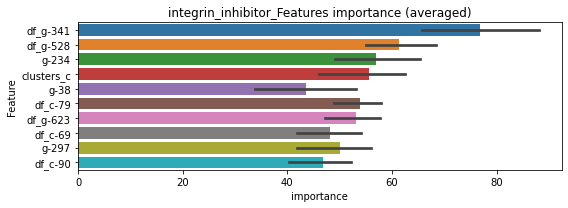

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023545	valid_1's binary_logloss: 0.0420924
[200]	training's binary_logloss: 0.00391769	valid_1's binary_logloss: 0.0199662
[300]	training's binary_logloss: 0.00109961	valid_1's binary_logloss: 0.0165056
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000663142	valid_1's binary_logloss: 0.0159983


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231911	valid_1's binary_logloss: 0.0431054
[200]	training's binary_logloss: 0.00402185	valid_1's binary_logloss: 0.0174601
[300]	training's binary_logloss: 0.0011564	valid_1's binary_logloss: 0.0121625
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00077315	valid_1's binary_logloss: 0.0110874


integrin_inhibitor logloss: 0.013542849726662032
jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398601	valid_1's binary_logloss: 0.087186
[200]	training's binary_logloss: 0.00718735	valid_1's binary_logloss: 0.0511808
[300]	training's binary_logloss: 0.00222432	valid_1's binary_logloss: 0.0428012
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0012985	valid_1's binary_logloss: 0.0398199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414716	valid_1's binary_logloss: 0.0793455
[200]	training's binary_logloss: 0.00733009	valid_1's binary_logloss: 0.0358878
[300]	training's binary_logloss: 0.00223609	valid_1's binary_logloss: 0.0245636
[400]	training's binary_logloss: 0.00108669	valid_1's binary_logloss: 0.0207449
[500]	training's binary_logloss: 0.000708003	valid_1's binary_logloss: 0.0186029
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000637992	valid_1's binary_logloss: 0.0184133


1 / 3 AUC score:0.999
y_Threshold: 0.0154849, Threshold: 0.0314939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3790
p_label_rate: 0.0200904 Vs.target_rate: 0.00386, Num_p_label: 80.0, conf_0:0.02834, conf_1:0.03464
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0314939
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_2: 0.0414939
Num_p_label: 48.0, Expected: 15.4, Adj_threshold_3: 0.0514939
Num_p_label: 35.0, Expected: 15.4, Adj_threshold_4: 0.0614939
Num_p_label: 29.0, Expected: 15.4, Adj_threshold_5: 0.0714939
threshold: 0.0714939, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 651.0/3790, y_label_rate: 0.1717678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038979	valid_1's binary_logloss: 0.0783939
[200]	training's binary_logloss: 0.00648784	valid_1's binary_logloss: 0.0367264
[300]	training's binary_logloss: 0.00196137	valid_1's binary_logloss: 0.0267277
[400]	training's binary_logloss: 0.000958919	valid_1's binary_logloss: 0.0243733
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000906296	valid_1's binary_logloss: 0.0242871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394367	valid_1's binary_logloss: 0.0779611
[200]	training's binary_logloss: 0.0065649	valid_1's binary_logloss: 0.03895
[300]	training's binary_logloss: 0.00193878	valid_1's binary_logloss: 0.0304679
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00131026	valid_1's binary_logloss: 0.0283192


2 / 3 AUC score:0.999
y_Threshold: 0.0985277, Threshold: 0.0714939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 638.0/3764
p_label_rate: 0.0318935 Vs.target_rate: 0.00386, Num_p_label: 127.0, conf_0:0.06434, conf_1:0.07864
Num_p_label: 127.0, Expected: 15.4, Adj_threshold_1: 0.0714939
Num_p_label: 111.0, Expected: 15.4, Adj_threshold_2: 0.0814939
Num_p_label: 103.0, Expected: 15.4, Adj_threshold_3: 0.0914939
Num_p_label: 99.0, Expected: 15.4, Adj_threshold_4: 0.1014939
Num_p_label: 94.0, Expected: 15.4, Adj_threshold_5: 0.1114939
Num_p_label: 88.0, Expected: 15.4, Adj_threshold_6: 0.1214939
Num_p_label: 81.0, Expected: 15.4, Adj_threshold_7: 0.1314939
Num_p_label: 77.0, Expected: 15.4, Adj_threshold_8: 0.1414939
Num_p_label: 66.0, Expected: 15.4, Adj_threshold_9: 0.1514939
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_10: 0.1614939
threshold: 0.1714939, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 638.0/3764, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373694	valid_1's binary_logloss: 0.0724393
[200]	training's binary_logloss: 0.00607963	valid_1's binary_logloss: 0.0284103
[300]	training's binary_logloss: 0.00182766	valid_1's binary_logloss: 0.0176917
[400]	training's binary_logloss: 0.000896645	valid_1's binary_logloss: 0.014233
[500]	training's binary_logloss: 0.000597775	valid_1's binary_logloss: 0.0128776
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000607563	valid_1's binary_logloss: 0.0127878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376486	valid_1's binary_logloss: 0.0849757
[200]	training's binary_logloss: 0.00608952	valid_1's binary_logloss: 0.0515437
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00225883	valid_1's binary_logloss: 0.0474933


3 / 3 AUC score:0.998
y_Threshold: 0.0669593, Threshold: 0.1714939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 623.0/3734
p_label_rate: 0.0253641 Vs.target_rate: 0.00386, Num_p_label: 101.0, conf_0:0.15434, conf_1:0.18864
Num_p_label: 101.0, Expected: 15.4, Adj_threshold_1: 0.1714939
Num_p_label: 99.0, Expected: 15.4, Adj_threshold_2: 0.1814939
Num_p_label: 99.0, Expected: 15.4, Adj_threshold_3: 0.1914939
Num_p_label: 95.0, Expected: 15.4, Adj_threshold_4: 0.2014939
Num_p_label: 89.0, Expected: 15.4, Adj_threshold_5: 0.2114939
Num_p_label: 84.0, Expected: 15.4, Adj_threshold_6: 0.2214939
Num_p_label: 81.0, Expected: 15.4, Adj_threshold_7: 0.2314939
Num_p_label: 77.0, Expected: 15.4, Adj_threshold_8: 0.2414939
Num_p_label: 74.0, Expected: 15.4, Adj_threshold_9: 0.2514939
Num_p_label: 69.0, Expected: 15.4, Adj_threshold_10: 0.2614939
threshold: 0.2714939, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 688.0/7716, y_label_rate: 0.089

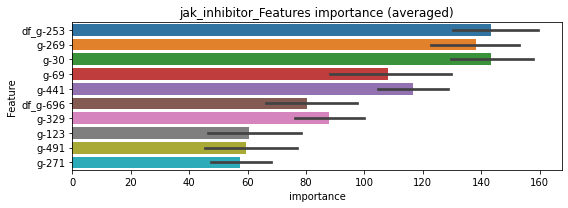

len(train_index) : 3858
len(valid_index) : 3858
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208732	valid_1's binary_logloss: 0.0457464
[200]	training's binary_logloss: 0.00359085	valid_1's binary_logloss: 0.0245908
[300]	training's binary_logloss: 0.00110967	valid_1's binary_logloss: 0.020588
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0008395	valid_1's binary_logloss: 0.0199097


len(train_index) : 3858
len(valid_index) : 3858
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212443	valid_1's binary_logloss: 0.0552493
[200]	training's binary_logloss: 0.0035791	valid_1's binary_logloss: 0.0353927
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00150537	valid_1's binary_logloss: 0.032139


jak_inhibitor logloss: 0.02602438692554666
kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497748	valid_1's binary_logloss: 0.13459
[200]	training's binary_logloss: 0.0101271	valid_1's binary_logloss: 0.10423
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00530877	valid_1's binary_logloss: 0.101067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530245	valid_1's binary_logloss: 0.127191
[200]	training's binary_logloss: 0.0111554	valid_1's binary_logloss: 0.0931188
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00594724	valid_1's binary_logloss: 0.0900171


1 / 3 AUC score:0.983
y_Threshold: 0.0394924, Threshold: 0.2030132, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 622/3730
p_label_rate: 0.0200904 Vs.target_rate: 0.01146, Num_p_label: 80.0, conf_0:0.18271, conf_1:0.22331
threshold: 0.2030132, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 622.0/3730, y_label_rate: 0.1667560
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419602	valid_1's binary_logloss: 0.0852484
[200]	training's binary_logloss: 0.00734233	valid_1's binary_logloss: 0.0456269
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00364371	valid_1's binary_logloss: 0.0390645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415502	valid_1's binary_logloss: 0.0881507
[200]	training's binary_logloss: 0.00747604	valid_1's binary_logloss: 0.0479383
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00303493	valid_1's binary_logloss: 0.0411128


2 / 3 AUC score:0.998
y_Threshold: 0.1387418, Threshold: 0.2030132, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 605.0/3696
p_label_rate: 0.0384229 Vs.target_rate: 0.01146, Num_p_label: 153.0, conf_0:0.18271, conf_1:0.22331
Num_p_label: 153.0, Expected: 45.6, Adj_threshold_1: 0.2030132
Num_p_label: 148.0, Expected: 45.6, Adj_threshold_2: 0.2130132
Num_p_label: 143.0, Expected: 45.6, Adj_threshold_3: 0.2230132
Num_p_label: 141.0, Expected: 45.6, Adj_threshold_4: 0.2330132
Num_p_label: 136.0, Expected: 45.6, Adj_threshold_5: 0.2430132
Num_p_label: 133.0, Expected: 45.6, Adj_threshold_6: 0.2530132
Num_p_label: 129.0, Expected: 45.6, Adj_threshold_7: 0.2630132
Num_p_label: 128.0, Expected: 45.6, Adj_threshold_8: 0.2730132
Num_p_label: 125.0, Expected: 45.6, Adj_threshold_9: 0.2830132
Num_p_label: 118.0, Expected: 45.6, Adj_threshold_10: 0.2930132
threshold: 0.3030132, positive_p_label: 116.0/3982, p_label_rate: 0.0291311
positive_y_label: 605.0/3696, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386575	valid_1's binary_logloss: 0.0780843
[200]	training's binary_logloss: 0.00663665	valid_1's binary_logloss: 0.0365158
[300]	training's binary_logloss: 0.00188012	valid_1's binary_logloss: 0.0263736
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00150631	valid_1's binary_logloss: 0.025091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372747	valid_1's binary_logloss: 0.0851572


3 / 3 AUC score:0.998
y_Threshold: 0.1452368, Threshold: 0.3030132, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 591.0/3668
p_label_rate: 0.0323958 Vs.target_rate: 0.01146, Num_p_label: 129.0, conf_0:0.27271, conf_1:0.33331


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0084936	valid_1's binary_logloss: 0.0499913


threshold: 0.3030132, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 720.0/7650, y_label_rate: 0.0941176


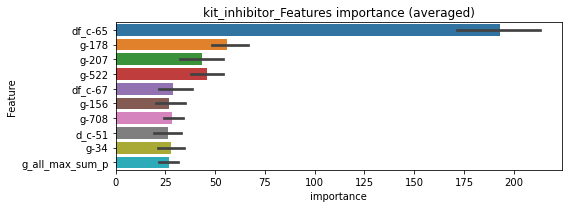

len(train_index) : 3825
len(valid_index) : 3825
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250451	valid_1's binary_logloss: 0.0639383
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00882675	valid_1's binary_logloss: 0.0426941


len(train_index) : 3825
len(valid_index) : 3825
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250372	valid_1's binary_logloss: 0.0601775
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00856892	valid_1's binary_logloss: 0.0378901


kit_inhibitor logloss: 0.04029212681539445
laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157903	valid_1's binary_logloss: 0.018046
[200]	training's binary_logloss: 0.00133863	valid_1's binary_logloss: 0.00284828
[300]	training's binary_logloss: 0.000363465	valid_1's binary_logloss: 0.00144
[400]	training's binary_logloss: 0.000221555	valid_1's binary_logloss: 0.00119768
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000217481	valid_1's binary_logloss: 0.00119196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159621	valid_1's binary_logloss: 0.0166206
[200]	training's binary_logloss: 0.00139999	valid_1's binary_logloss: 0.00157506
[300]	training's binary_logloss: 0.000411308	valid_1's binary_logloss: 0.00046913
[400]	training's binary_logloss: 0.00022221	valid_1's binary_logloss: 0.000266149
[500]	training's binary_logloss: 0.000183194	valid_1's binary_logloss: 0.000222459
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0005125, Threshold: 0.0008106, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00073, conf_1:0.00089
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008106
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0108106
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208106
threshold: 0.0208106, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161101	valid_1's binary_logloss: 0.0179351
[200]	training's binary_logloss: 0.00132794	valid_1's binary_logloss: 0.00240679
[300]	training's binary_logloss: 0.000355503	valid_1's binary_logloss: 0.00109544
[400]	training's binary_logloss: 0.000219798	valid_1's binary_logloss: 0.000854871
[500]	training's binary_logloss: 0.000193901	valid_1's binary_logloss: 0.000813281
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000193007	valid_1's binary_logloss: 0.000812582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162463	valid_1's binary_logloss: 0.0169716
[200]	training's binary_logloss: 0.0013372	valid_1's binary_logloss: 0.00152183
[300]	training's binary_logloss: 0.000356425	valid_1's binary_logloss: 0.000434963
[400]	training's binary_logloss: 0.000218167	valid_1's binary_logloss: 0.000272276
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1061719, Threshold: 0.0208106, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.01873, conf_1:0.02289
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0208106
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0308106
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0408106
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0508106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0608106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0708106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0808106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0908106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1008106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1108106
threshold: 0.1208106, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161101	valid_1's binary_logloss: 0.0179351
[200]	training's binary_logloss: 0.00132794	valid_1's binary_logloss: 0.00240679
[300]	training's binary_logloss: 0.000355503	valid_1's binary_logloss: 0.00109544
[400]	training's binary_logloss: 0.000219798	valid_1's binary_logloss: 0.000854871
[500]	training's binary_logloss: 0.000193901	valid_1's binary_logloss: 0.000813281
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000193007	valid_1's binary_logloss: 0.000812582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162463	valid_1's binary_logloss: 0.0169716
[200]	training's binary_logloss: 0.0013372	valid_1's binary_logloss: 0.00152183
[300]	training's binary_logloss: 0.000356425	valid_1's binary_logloss: 0.000434963
[400]	training's binary_logloss: 0.000218167	valid_1's binary_logloss: 0.000272276
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1061719, Threshold: 0.1208106, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.10873, conf_1:0.13289
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.1208106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.1308106
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1408106
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.1508106
threshold: 0.1508106, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


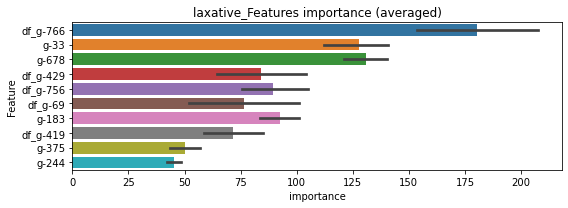

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00844668	valid_1's binary_logloss: 0.0110787
[200]	training's binary_logloss: 0.000678687	valid_1's binary_logloss: 0.00332343
[300]	training's binary_logloss: 0.000179713	valid_1's binary_logloss: 0.00251044
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000144765	valid_1's binary_logloss: 0.00244401


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00874471	valid_1's binary_logloss: 0.00905036
[200]	training's binary_logloss: 0.000695188	valid_1's binary_logloss: 0.000806831
[300]	training's binary_logloss: 0.000184182	valid_1's binary_logloss: 0.000240065
[400]	training's binary_logloss: 0.000109347	valid_1's binary_logloss: 0.000151723
[500]	training's binary_logloss: 9.70717e-05	valid_1's binary_logloss: 0.000134496
Early stopping, best iteration is:
[558]	training's binary_logloss: 9.64883e-05	valid_1's binary_logloss: 0.000133526


laxative logloss: 0.0012889137811024247
leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155969	valid_1's binary_logloss: 0.0167099
[200]	training's binary_logloss: 0.00129472	valid_1's binary_logloss: 0.00165645
[300]	training's binary_logloss: 0.000351174	valid_1's binary_logloss: 0.00053076
[400]	training's binary_logloss: 0.000216085	valid_1's binary_logloss: 0.000355418
[500]	training's binary_logloss: 0.000193307	valid_1's binary_logloss: 0.00032459
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000193307	valid_1's binary_logloss: 0.00032459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157597	valid_1's binary_logloss: 0.0166391
[200]	training's binary_logloss: 0.0013019	valid_1's binary_logloss: 0.00155272
[300]	training's binary_logloss: 0.000347975	valid_1's binary_logloss: 0.000464171
[400]	training's binary_logloss: 0.000215494	valid_1's binary_logloss: 0.000297847
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0005655, Threshold: 0.0008898, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00080, conf_1:0.00098
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008898
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0108898
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208898
threshold: 0.0208898, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015934	valid_1's binary_logloss: 0.0170471
[200]	training's binary_logloss: 0.00128878	valid_1's binary_logloss: 0.00164139
[300]	training's binary_logloss: 0.00034545	valid_1's binary_logloss: 0.000502745
[400]	training's binary_logloss: 0.000214455	valid_1's binary_logloss: 0.000333368
[500]	training's binary_logloss: 0.000187324	valid_1's binary_logloss: 0.000298795
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000184822	valid_1's binary_logloss: 0.000295813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016166	valid_1's binary_logloss: 0.01668
[200]	training's binary_logloss: 0.0013113	valid_1's binary_logloss: 0.00142642
[300]	training's binary_logloss: 0.000347471	valid_1's binary_logloss: 0.000397097
[400]	training's binary_logloss: 0.000214598	valid_1's binary_logloss: 0.00024951
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1594854, Threshold: 0.0208898, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.01880, conf_1:0.02298
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0208898
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0308898
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0408898
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0508898
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0608898
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0708898
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0808898
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0908898
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1008898
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1108898
threshold: 0.1208898, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015934	valid_1's binary_logloss: 0.0170471
[200]	training's binary_logloss: 0.00128878	valid_1's binary_logloss: 0.00164139
[300]	training's binary_logloss: 0.00034545	valid_1's binary_logloss: 0.000502745
[400]	training's binary_logloss: 0.000214455	valid_1's binary_logloss: 0.000333368
[500]	training's binary_logloss: 0.000187324	valid_1's binary_logloss: 0.000298795
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000184822	valid_1's binary_logloss: 0.000295813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016166	valid_1's binary_logloss: 0.01668
[200]	training's binary_logloss: 0.0013113	valid_1's binary_logloss: 0.00142642
[300]	training's binary_logloss: 0.000347471	valid_1's binary_logloss: 0.000397097
[400]	training's binary_logloss: 0.000214598	valid_1's binary_logloss: 0.00024951
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1594854, Threshold: 0.1208898, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.10880, conf_1:0.13298
threshold: 0.1208898, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


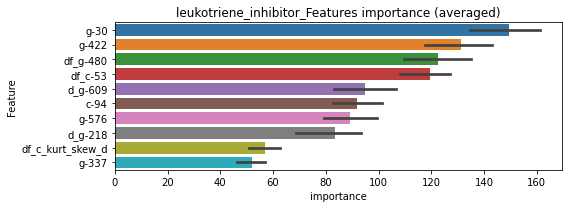

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848705	valid_1's binary_logloss: 0.0106555
[200]	training's binary_logloss: 0.000678336	valid_1's binary_logloss: 0.00313096


len(train_index) : 3898


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000256762	valid_1's binary_logloss: 0.0027359


len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00861752	valid_1's binary_logloss: 0.00926077
[200]	training's binary_logloss: 0.000694219	valid_1's binary_logloss: 0.00110923
[300]	training's binary_logloss: 0.000182779	valid_1's binary_logloss: 0.000541035
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000173003	valid_1's binary_logloss: 0.000536465


leukotriene_inhibitor logloss: 0.0016363254132738556
leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460128	valid_1's binary_logloss: 0.104516
[200]	training's binary_logloss: 0.00901122	valid_1's binary_logloss: 0.0545563
[300]	training's binary_logloss: 0.00268222	valid_1's binary_logloss: 0.041713
[400]	training's binary_logloss: 0.00125764	valid_1's binary_logloss: 0.0377239
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000938583	valid_1's binary_logloss: 0.0363732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501126	valid_1's binary_logloss: 0.0920877
[200]	training's binary_logloss: 0.0103561	valid_1's binary_logloss: 0.0444348
[300]	training's binary_logloss: 0.00305789	valid_1's binary_logloss: 0.0339013
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00204348	valid_1's binary_logloss: 0.0316105


1 / 3 AUC score:0.999
y_Threshold: 0.0101068, Threshold: 0.0125727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.01132, conf_1:0.01383
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0125727
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_2: 0.0225727
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_3: 0.0325727
threshold: 0.0325727, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479571	valid_1's binary_logloss: 0.0905062
[200]	training's binary_logloss: 0.00909886	valid_1's binary_logloss: 0.0414425
[300]	training's binary_logloss: 0.00272572	valid_1's binary_logloss: 0.0291775
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00136864	valid_1's binary_logloss: 0.0259718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478772	valid_1's binary_logloss: 0.0820373
[200]	training's binary_logloss: 0.00908751	valid_1's binary_logloss: 0.0349602
[300]	training's binary_logloss: 0.00272783	valid_1's binary_logloss: 0.0238968
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00136896	valid_1's binary_logloss: 0.0206016


2 / 3 AUC score:1.000
y_Threshold: 0.0384745, Threshold: 0.0325727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0082873 Vs.target_rate: 0.00260, Num_p_label: 33.0, conf_0:0.02932, conf_1:0.03583
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_1: 0.0325727
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_2: 0.0425727
threshold: 0.0425727, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472165	valid_1's binary_logloss: 0.0913986
[200]	training's binary_logloss: 0.00895442	valid_1's binary_logloss: 0.042582
[300]	training's binary_logloss: 0.00267098	valid_1's binary_logloss: 0.0301317
[400]	training's binary_logloss: 0.00124451	valid_1's binary_logloss: 0.026164
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0009275	valid_1's binary_logloss: 0.0246069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472031	valid_1's binary_logloss: 0.0865187
[200]	training's binary_logloss: 0.00882372	valid_1's binary_logloss: 0.0378554
[300]	training's binary_logloss: 0.00266022	valid_1's binary_logloss: 0.0266321
[400]	training's binary_logloss: 0.00125303	valid_1's binary_logloss: 0.0227223
[500]	training's binary_logloss: 0.000787286	valid_1's binary_logloss: 0.0215488
Early stopping, best iteration is:
[493]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0369086, Threshold: 0.0425727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0022602 Vs.target_rate: 0.00260, Num_p_label: 9.0, conf_0:0.03832, conf_1:0.04683
threshold: 0.0425727, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/7770, y_label_rate: 0.0845560


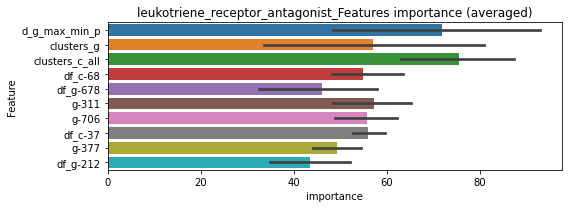

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240523	valid_1's binary_logloss: 0.0533754
[200]	training's binary_logloss: 0.00427823	valid_1's binary_logloss: 0.0284915
[300]	training's binary_logloss: 0.0012843	valid_1's binary_logloss: 0.022288
[400]	training's binary_logloss: 0.000603747	valid_1's binary_logloss: 0.0204216
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0004458	valid_1's binary_logloss: 0.0200379


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251542	valid_1's binary_logloss: 0.0505942
[200]	training's binary_logloss: 0.00486165	valid_1's binary_logloss: 0.0261725
[300]	training's binary_logloss: 0.00141566	valid_1's binary_logloss: 0.019505
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000838501	valid_1's binary_logloss: 0.0181938


leukotriene_receptor_antagonist logloss: 0.019115896605391328
lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193517	valid_1's binary_logloss: 0.027883
[200]	training's binary_logloss: 0.00205205	valid_1's binary_logloss: 0.00831481
[300]	training's binary_logloss: 0.000593996	valid_1's binary_logloss: 0.00484201
[400]	training's binary_logloss: 0.000326827	valid_1's binary_logloss: 0.00367623
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000285796	valid_1's binary_logloss: 0.00348714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196921	valid_1's binary_logloss: 0.0234158
[200]	training's binary_logloss: 0.0020658	valid_1's binary_logloss: 0.00361793
[300]	training's binary_logloss: 0.000593721	valid_1's binary_logloss: 0.00133935
[400]	training's binary_logloss: 0.000329685	valid_1's binary_logloss: 0.000822238
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000284536	valid_1's binary_logloss: 0.000736

1 / 3 AUC score:1.000
y_Threshold: 0.0011832, Threshold: 0.0020213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00182, conf_1:0.00222
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020213
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0120213
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0220213
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.0320213
threshold: 0.0320213, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194581	valid_1's binary_logloss: 0.0285685
[200]	training's binary_logloss: 0.0019747	valid_1's binary_logloss: 0.0101069
[300]	training's binary_logloss: 0.000569744	valid_1's binary_logloss: 0.00654953
[400]	training's binary_logloss: 0.000319071	valid_1's binary_logloss: 0.00540298
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000279893	valid_1's binary_logloss: 0.00521803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196597	valid_1's binary_logloss: 0.0232649
[200]	training's binary_logloss: 0.00201247	valid_1's binary_logloss: 0.0036415
[300]	training's binary_logloss: 0.000579052	valid_1's binary_logloss: 0.0014054
[400]	training's binary_logloss: 0.000321898	valid_1's binary_logloss: 0.000894336
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000282782	valid_1's binary_logloss: 0.00081458

2 / 3 AUC score:1.000
y_Threshold: 0.0146027, Threshold: 0.0320213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00050, Num_p_label: 12.0, conf_0:0.02882, conf_1:0.03522
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.0320213
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0420213
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0520213
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0620213
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0720213
threshold: 0.0720213, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194581	valid_1's binary_logloss: 0.0285685
[200]	training's binary_logloss: 0.0019747	valid_1's binary_logloss: 0.0101069
[300]	training's binary_logloss: 0.000569744	valid_1's binary_logloss: 0.00654953
[400]	training's binary_logloss: 0.000319071	valid_1's binary_logloss: 0.00540298
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000279893	valid_1's binary_logloss: 0.00521803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196597	valid_1's binary_logloss: 0.0232649
[200]	training's binary_logloss: 0.00201247	valid_1's binary_logloss: 0.0036415
[300]	training's binary_logloss: 0.000579052	valid_1's binary_logloss: 0.0014054
[400]	training's binary_logloss: 0.000321898	valid_1's binary_logloss: 0.000894336
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000282782	valid_1's binary_logloss: 0.00081458

3 / 3 AUC score:1.000
y_Threshold: 0.0146027, Threshold: 0.0720213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.06482, conf_1:0.07922
threshold: 0.0720213, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


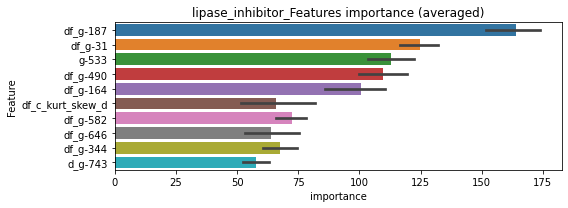

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104088	valid_1's binary_logloss: 0.0158029
[200]	training's binary_logloss: 0.00105075	valid_1's binary_logloss: 0.00471199
[300]	training's binary_logloss: 0.000296045	valid_1's binary_logloss: 0.00390308
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000260602	valid_1's binary_logloss: 0.00384641


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109765	valid_1's binary_logloss: 0.0137283
[200]	training's binary_logloss: 0.00116947	valid_1's binary_logloss: 0.00311287
[300]	training's binary_logloss: 0.000319817	valid_1's binary_logloss: 0.00199673
[400]	training's binary_logloss: 0.000170448	valid_1's binary_logloss: 0.00165424
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000148699	valid_1's binary_logloss: 0.00161476


lipase_inhibitor logloss: 0.0027305853354410116
lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545513	valid_1's binary_logloss: 0.107404
[200]	training's binary_logloss: 0.0113369	valid_1's binary_logloss: 0.0551818
[300]	training's binary_logloss: 0.00329829	valid_1's binary_logloss: 0.0408253
[400]	training's binary_logloss: 0.00147754	valid_1's binary_logloss: 0.0360372
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00113969	valid_1's binary_logloss: 0.035041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569758	valid_1's binary_logloss: 0.100209
[200]	training's binary_logloss: 0.0114833	valid_1's binary_logloss: 0.0430207
[300]	training's binary_logloss: 0.00333478	valid_1's binary_logloss: 0.0268769
[400]	training's binary_logloss: 0.00148592	valid_1's binary_logloss: 0.0213179
[500]	training's binary_logloss: 0.000908959	valid_1's binary_logloss: 0.0191321
Early stopping, best iteration is:
[565]	training

1 / 3 AUC score:0.999
y_Threshold: 0.0066301, Threshold: 0.0125829, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.01132, conf_1:0.01384
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0125829
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.0225829
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.0325829
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_4: 0.0425829
threshold: 0.0425829, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3791, y_label_rate: 0.1714587
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569059	valid_1's binary_logloss: 0.101955
[200]	training's binary_logloss: 0.0117567	valid_1's binary_logloss: 0.0447404
[300]	training's binary_logloss: 0.00327251	valid_1's binary_logloss: 0.0277173
[400]	training's binary_logloss: 0.00146459	valid_1's binary_logloss: 0.0221552
[500]	training's binary_logloss: 0.000889051	valid_1's binary_logloss: 0.0197801
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000705209	valid_1's binary_logloss: 0.0190997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536992	valid_1's binary_logloss: 0.0872628
[200]	training's binary_logloss: 0.010678	valid_1's binary_logloss: 0.0326321
[300]	training's binary_logloss: 0.00312534	valid_1's binary_logloss: 0.0190893
[400]	training's binary_logloss: 0.00142422	valid_1's binary_logloss: 0.0144617
[500]	training's binary_logloss: 0.000893331	va

2 / 3 AUC score:1.000
y_Threshold: 0.0382846, Threshold: 0.0425829, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 646.0/3783
p_label_rate: 0.0123054 Vs.target_rate: 0.00256, Num_p_label: 49.0, conf_0:0.03832, conf_1:0.04684
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_1: 0.0425829
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_2: 0.0525829
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_3: 0.0625829
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_4: 0.0725829
threshold: 0.0725829, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 646.0/3783, y_label_rate: 0.1707639
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553326	valid_1's binary_logloss: 0.101379
[200]	training's binary_logloss: 0.0109036	valid_1's binary_logloss: 0.045354
[300]	training's binary_logloss: 0.00307934	valid_1's binary_logloss: 0.0313115
[400]	training's binary_logloss: 0.00139443	valid_1's binary_logloss: 0.0260141
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000988374	valid_1's binary_logloss: 0.0247035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529562	valid_1's binary_logloss: 0.0991767
[200]	training's binary_logloss: 0.0105152	valid_1's binary_logloss: 0.0460611
[300]	training's binary_logloss: 0.00308362	valid_1's binary_logloss: 0.0315408
[400]	training's binary_logloss: 0.00141292	valid_1's binary_logloss: 0.0261261
[500]	training's binary_logloss: 0.000870732	valid_1's binary_logloss: 0.0239084
Early stopping, best iteration is:
[529]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0375114, Threshold: 0.0725829, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 642.0/3775
p_label_rate: 0.0067805 Vs.target_rate: 0.00256, Num_p_label: 27.0, conf_0:0.06532, conf_1:0.07984
threshold: 0.0725829, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 669.0/7757, y_label_rate: 0.0862447


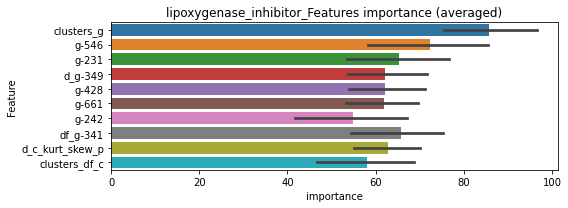

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302185	valid_1's binary_logloss: 0.0653587
[200]	training's binary_logloss: 0.00581386	valid_1's binary_logloss: 0.036781
[300]	training's binary_logloss: 0.00165055	valid_1's binary_logloss: 0.0307346
[400]	training's binary_logloss: 0.000745147	valid_1's binary_logloss: 0.0289195
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000767901	valid_1's binary_logloss: 0.0288076


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031245	valid_1's binary_logloss: 0.0549748
[200]	training's binary_logloss: 0.00646543	valid_1's binary_logloss: 0.0256574
[300]	training's binary_logloss: 0.00181199	valid_1's binary_logloss: 0.0182888
[400]	training's binary_logloss: 0.000819185	valid_1's binary_logloss: 0.0159008
[500]	training's binary_logloss: 0.000505251	valid_1's binary_logloss: 0.0149909
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000469239	valid_1's binary_logloss: 0.0147814


lipoxygenase_inhibitor logloss: 0.02179541034106992
lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151541	valid_1's binary_logloss: 0.0167108
[200]	training's binary_logloss: 0.00118271	valid_1's binary_logloss: 0.00199992
[300]	training's binary_logloss: 0.000299228	valid_1's binary_logloss: 0.000949226
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000202857	valid_1's binary_logloss: 0.000808732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155566	valid_1's binary_logloss: 0.016159
[200]	training's binary_logloss: 0.00123642	valid_1's binary_logloss: 0.00134603
[300]	training's binary_logloss: 0.000309819	valid_1's binary_logloss: 0.000355136
[400]	training's binary_logloss: 0.000194015	valid_1's binary_logloss: 0.000229541
[500]	training's binary_logloss: 0.000175901	valid_1's binary_logloss: 0.000209349
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000172866	valid_1's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0005709, Threshold: 0.0018729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00169, conf_1:0.00206
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0018729
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_2: 0.0118729
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.0218729
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0318729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.0418729
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0518729
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0618729
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0718729
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.0818729
threshold: 0.0818729, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160368	valid_1's binary_logloss: 0.0170064
[200]	training's binary_logloss: 0.00124233	valid_1's binary_logloss: 0.00151019
[300]	training's binary_logloss: 0.000299019	valid_1's binary_logloss: 0.000413426
[400]	training's binary_logloss: 0.000186722	valid_1's binary_logloss: 0.000275822
[500]	training's binary_logloss: 0.000169473	valid_1's binary_logloss: 0.000254448
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000169473	valid_1's binary_logloss: 0.000254448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159222	valid_1's binary_logloss: 0.016428
[200]	training's binary_logloss: 0.00124038	valid_1's binary_logloss: 0.00132776
[300]	training's binary_logloss: 0.000296698	valid_1's binary_logloss: 0.000328822
[400]	training's binary_logloss: 0.000185052	valid_1's binary_logloss: 0.000207301
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1751630, Threshold: 0.0818729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.07369, conf_1:0.09006
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.0818729
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0918729
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.1018729
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.1118729
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.1218729
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1318729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.1418729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.1518729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.1618729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.1718729
threshold: 0.1818729, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160368	valid_1's binary_logloss: 0.0170064
[200]	training's binary_logloss: 0.00124233	valid_1's binary_logloss: 0.00151019
[300]	training's binary_logloss: 0.000299019	valid_1's binary_logloss: 0.000413426
[400]	training's binary_logloss: 0.000186722	valid_1's binary_logloss: 0.000275822
[500]	training's binary_logloss: 0.000169473	valid_1's binary_logloss: 0.000254448
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000169473	valid_1's binary_logloss: 0.000254448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159222	valid_1's binary_logloss: 0.016428
[200]	training's binary_logloss: 0.00124038	valid_1's binary_logloss: 0.00132776
[300]	training's binary_logloss: 0.000296698	valid_1's binary_logloss: 0.000328822
[400]	training's binary_logloss: 0.000185052	valid_1's binary_logloss: 0.000207301
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1751630, Threshold: 0.1818729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.16369, conf_1:0.20006
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.1818729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.1918729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.2018729
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.2118729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.2218729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.2318729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.2418729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2518729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2618729
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.2718729
threshold: 0.2818729, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7795, y_label_rate: 0.0847979


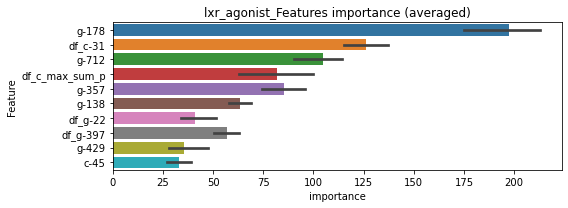

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00860873	valid_1's binary_logloss: 0.0105517
[200]	training's binary_logloss: 0.000673454	valid_1's binary_logloss: 0.00287695
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000223124	valid_1's binary_logloss: 0.0024218


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855777	valid_1's binary_logloss: 0.00974949
[200]	training's binary_logloss: 0.000661983	valid_1's binary_logloss: 0.00189867
[300]	training's binary_logloss: 0.000164742	valid_1's binary_logloss: 0.0012996
[400]	training's binary_logloss: 0.000102579	valid_1's binary_logloss: 0.0012219
Early stopping, best iteration is:
[415]	training's binary_logloss: 9.89414e-05	valid_1's binary_logloss: 0.00121761


lxr_agonist logloss: 0.0018197824737802724


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239375	valid_1's binary_logloss: 0.0357522
[200]	training's binary_logloss: 0.00306243	valid_1's binary_logloss: 0.00899825
[300]	training's binary_logloss: 0.000880737	valid_1's binary_logloss: 0.00469011
[400]	training's binary_logloss: 0.000458918	valid_1's binary_logloss: 0.00334518
[500]	training's binary_logloss: 0.000357085	valid_1's binary_logloss: 0.00296277
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000355136	valid_1's binary_logloss: 0.00295061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243287	valid_1's binary_logloss: 0.0328353
[200]	training's binary_logloss: 0.0030364	valid_1's binary_logloss: 0.0068867
[300]	training's binary_logloss: 0.000875448	valid_1's binary_logloss: 0.00307854
[400]	training's binary_logloss: 0.000457818	valid_1's binary_logloss: 0.00195984
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0030200, Threshold: 0.0080986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00729, conf_1:0.00891
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0080986
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_2: 0.0180986
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_3: 0.0280986
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_4: 0.0380986
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_5: 0.0480986
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_6: 0.0580986
threshold: 0.0580986, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231516	valid_1's binary_logloss: 0.0309989
[200]	training's binary_logloss: 0.00265854	valid_1's binary_logloss: 0.00582632
[300]	training's binary_logloss: 0.000734964	valid_1's binary_logloss: 0.00249746
[400]	training's binary_logloss: 0.000393854	valid_1's binary_logloss: 0.00165123
[500]	training's binary_logloss: 0.000316906	valid_1's binary_logloss: 0.00146929
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000312605	valid_1's binary_logloss: 0.00145485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234164	valid_1's binary_logloss: 0.0298476
[200]	training's binary_logloss: 0.00273361	valid_1's binary_logloss: 0.00504225
[300]	training's binary_logloss: 0.000751675	valid_1's binary_logloss: 0.00202765
[400]	training's binary_logloss: 0.000403969	valid_1's binary_logloss: 0.00127533
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.2910084, Threshold: 0.0580986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0233551 Vs.target_rate: 0.00130, Num_p_label: 93.0, conf_0:0.05229, conf_1:0.06391
Num_p_label: 93.0, Expected: 5.2, Adj_threshold_1: 0.0580986
Num_p_label: 81.0, Expected: 5.2, Adj_threshold_2: 0.0680986
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_3: 0.0780986
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_4: 0.0880986
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_5: 0.0980986
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_6: 0.1080986
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_7: 0.1180986
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_8: 0.1280986
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_9: 0.1380986
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_10: 0.1480986
threshold: 0.1580986, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231516	valid_1's binary_logloss: 0.0309989
[200]	training's binary_logloss: 0.00265854	valid_1's binary_logloss: 0.00582632
[300]	training's binary_logloss: 0.000734964	valid_1's binary_logloss: 0.00249746
[400]	training's binary_logloss: 0.000393854	valid_1's binary_logloss: 0.00165123
[500]	training's binary_logloss: 0.000316906	valid_1's binary_logloss: 0.00146929
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000312605	valid_1's binary_logloss: 0.00145485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234164	valid_1's binary_logloss: 0.0298476
[200]	training's binary_logloss: 0.00273361	valid_1's binary_logloss: 0.00504225
[300]	training's binary_logloss: 0.000751675	valid_1's binary_logloss: 0.00202765
[400]	training's binary_logloss: 0.000403969	valid_1's binary_logloss: 0.00127533
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.2910084, Threshold: 0.1580986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0128076 Vs.target_rate: 0.00130, Num_p_label: 51.0, conf_0:0.14229, conf_1:0.17391
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_1: 0.1580986
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_2: 0.1680986
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_3: 0.1780986
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_4: 0.1880986
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_5: 0.1980986
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_6: 0.2080986
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_7: 0.2180986
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_8: 0.2280986
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_9: 0.2380986
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_10: 0.2480986
threshold: 0.2580986, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 694.0/7790, y_label_rate: 0.0890886


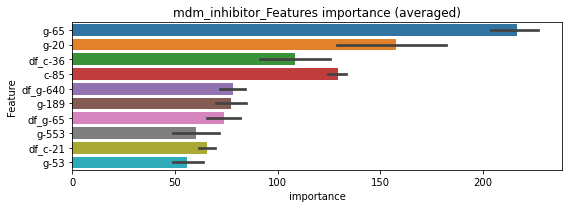

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133256	valid_1's binary_logloss: 0.0244603
[200]	training's binary_logloss: 0.00164241	valid_1's binary_logloss: 0.00995137
[300]	training's binary_logloss: 0.000476025	valid_1's binary_logloss: 0.0076834
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000329294	valid_1's binary_logloss: 0.0074251


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140081	valid_1's binary_logloss: 0.0207846
[200]	training's binary_logloss: 0.00179958	valid_1's binary_logloss: 0.00726499
[300]	training's binary_logloss: 0.00051816	valid_1's binary_logloss: 0.00566411
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000429417	valid_1's binary_logloss: 0.00552016


mdm_inhibitor logloss: 0.006472629694569249
mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287255	valid_1's binary_logloss: 0.0460177
[200]	training's binary_logloss: 0.00411824	valid_1's binary_logloss: 0.0174664
[300]	training's binary_logloss: 0.00119613	valid_1's binary_logloss: 0.0133375
[400]	training's binary_logloss: 0.000600999	valid_1's binary_logloss: 0.0121948
[500]	training's binary_logloss: 0.000422306	valid_1's binary_logloss: 0.0117163
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000413827	valid_1's binary_logloss: 0.0116453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288219	valid_1's binary_logloss: 0.0526783
[200]	training's binary_logloss: 0.00409351	valid_1's binary_logloss: 0.0244401


1 / 3 AUC score:1.000


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00139799	valid_1's binary_logloss: 0.0203072


y_Threshold: 0.0046878, Threshold: 0.0117017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.01053, conf_1:0.01287
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0117017
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_2: 0.0217017
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_3: 0.0317017
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_4: 0.0417017
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_5: 0.0517017
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_6: 0.0617017
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_7: 0.0717017
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_8: 0.0817017
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_9: 0.0917017
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_10: 0.1017017
threshold: 0.1117017, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 655.0/3801, y_label_rate: 0.1723231
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282863	valid_1's binary_logloss: 0.0423667
[200]	training's binary_logloss: 0.00376771	valid_1's binary_logloss: 0.0109593
[300]	training's binary_logloss: 0.00106289	valid_1's binary_logloss: 0.00582911
[400]	training's binary_logloss: 0.000535826	valid_1's binary_logloss: 0.00442069
[500]	training's binary_logloss: 0.000392553	valid_1's binary_logloss: 0.00391234
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000379775	valid_1's binary_logloss: 0.00385415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273545	valid_1's binary_logloss: 0.0458138
[200]	training's binary_logloss: 0.00358921	valid_1's binary_logloss: 0.0186904
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00125141	valid_1's binary_logloss: 0.0140135


2 / 3 AUC score:1.000
y_Threshold: 0.0311873, Threshold: 0.1117017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3797
p_label_rate: 0.0130588 Vs.target_rate: 0.00302, Num_p_label: 52.0, conf_0:0.10053, conf_1:0.12287
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_1: 0.1117017
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_2: 0.1217017
Num_p_label: 51.0, Expected: 12.0, Adj_threshold_3: 0.1317017
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_4: 0.1417017
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_5: 0.1517017
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_6: 0.1617017
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_7: 0.1717017
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_8: 0.1817017
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_9: 0.1917017
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_10: 0.2017017
threshold: 0.2117017, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 653.0/3797, y_label_rate: 0.171977

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268826	valid_1's binary_logloss: 0.0533492
[200]	training's binary_logloss: 0.00340151	valid_1's binary_logloss: 0.0284913
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00195741	valid_1's binary_logloss: 0.026402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279004	valid_1's binary_logloss: 0.0414362
[200]	training's binary_logloss: 0.00369564	valid_1's binary_logloss: 0.0130163
[300]	training's binary_logloss: 0.00104276	valid_1's binary_logloss: 0.00776357
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000603076	valid_1's binary_logloss: 0.00664937


3 / 3 AUC score:1.000
y_Threshold: 0.0400105, Threshold: 0.2117017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 647.0/3785
p_label_rate: 0.0120542 Vs.target_rate: 0.00302, Num_p_label: 48.0, conf_0:0.19053, conf_1:0.23287
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_1: 0.2117017
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_2: 0.2217017
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_3: 0.2317017
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.2417017
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.2517017
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_6: 0.2617017
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_7: 0.2717017
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_8: 0.2817017
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_9: 0.2917017
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_10: 0.3017017
threshold: 0.3117017, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 690.0/7767, y_label_rate: 0.08883

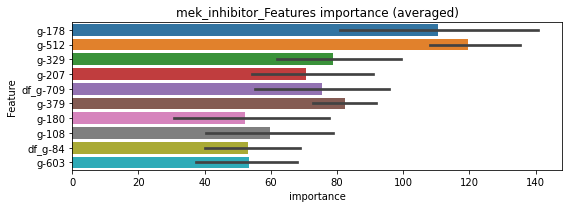

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143749	valid_1's binary_logloss: 0.0345644
[200]	training's binary_logloss: 0.00176964	valid_1's binary_logloss: 0.0239931
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0015739	valid_1's binary_logloss: 0.023854


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147476	valid_1's binary_logloss: 0.0292185
[200]	training's binary_logloss: 0.00186116	valid_1's binary_logloss: 0.0134747
[300]	training's binary_logloss: 0.00053826	valid_1's binary_logloss: 0.0110431
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00058033	valid_1's binary_logloss: 0.0108938


mek_inhibitor logloss: 0.017374769918649644
membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614538	valid_1's binary_logloss: 0.109893
[200]	training's binary_logloss: 0.0142109	valid_1's binary_logloss: 0.0572776
[300]	training's binary_logloss: 0.00411848	valid_1's binary_logloss: 0.0424814
[400]	training's binary_logloss: 0.00177055	valid_1's binary_logloss: 0.0383188
[500]	training's binary_logloss: 0.00105775	valid_1's binary_logloss: 0.0368367
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000888456	valid_1's binary_logloss: 0.036059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606282	valid_1's binary_logloss: 0.113693
[200]	training's binary_logloss: 0.0132302	valid_1's binary_logloss: 0.0530488
[300]	training's binary_logloss: 0.00386975	valid_1's binary_logloss: 0.0363177
[400]	training's binary_logloss: 0.00168721	valid_1's binary_logloss: 0.030658
Early stopping, best iteration is:
[453]	training'

1 / 3 AUC score:0.998
y_Threshold: 0.0110827, Threshold: 0.0209570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.01886, conf_1:0.02305
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0209570
Num_p_label: 39.0, Expected: 12.4, Adj_threshold_2: 0.0309570
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_3: 0.0409570
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_4: 0.0509570
threshold: 0.0509570, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 647.0/3785, y_label_rate: 0.1709379
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572291	valid_1's binary_logloss: 0.102656
[200]	training's binary_logloss: 0.0122448	valid_1's binary_logloss: 0.0478689
[300]	training's binary_logloss: 0.00356138	valid_1's binary_logloss: 0.0338271
[400]	training's binary_logloss: 0.00159413	valid_1's binary_logloss: 0.0297755
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00141221	valid_1's binary_logloss: 0.0292883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587793	valid_1's binary_logloss: 0.106928
[200]	training's binary_logloss: 0.0122231	valid_1's binary_logloss: 0.0522524
[300]	training's binary_logloss: 0.00351721	valid_1's binary_logloss: 0.0366119
[400]	training's binary_logloss: 0.00156642	valid_1's binary_logloss: 0.0321223
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00133282	valid_1's binary_logloss: 0.0317886


2 / 3 AUC score:0.999
y_Threshold: 0.0377258, Threshold: 0.0509570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 637.0/3765
p_label_rate: 0.0118031 Vs.target_rate: 0.00311, Num_p_label: 47.0, conf_0:0.04586, conf_1:0.05605
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.0509570
Num_p_label: 36.0, Expected: 12.4, Adj_threshold_2: 0.0609570
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_3: 0.0709570
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_4: 0.0809570
threshold: 0.0809570, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 637.0/3765, y_label_rate: 0.1691899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563644	valid_1's binary_logloss: 0.0982888
[200]	training's binary_logloss: 0.0119866	valid_1's binary_logloss: 0.039696
[300]	training's binary_logloss: 0.00349992	valid_1's binary_logloss: 0.0227973
[400]	training's binary_logloss: 0.00157509	valid_1's binary_logloss: 0.017177
[500]	training's binary_logloss: 0.000957559	valid_1's binary_logloss: 0.0148623
[600]	training's binary_logloss: 0.000704059	valid_1's binary_logloss: 0.0138289
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000689526	valid_1's binary_logloss: 0.0136472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559095	valid_1's binary_logloss: 0.107555
[200]	training's binary_logloss: 0.0116938	valid_1's binary_logloss: 0.0529735
[300]	training's binary_logloss: 0.00333526	valid_1's binary_logloss: 0.0383951
[400]	training's binary_logloss: 0.00148025	val

3 / 3 AUC score:1.000
y_Threshold: 0.0443779, Threshold: 0.0809570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 633.0/3757
p_label_rate: 0.0040181 Vs.target_rate: 0.00311, Num_p_label: 16.0, conf_0:0.07286, conf_1:0.08905
threshold: 0.0809570, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 649.0/7739, y_label_rate: 0.0838610


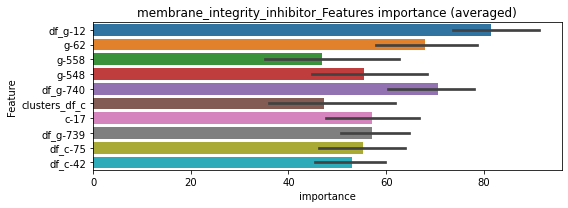

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337003	valid_1's binary_logloss: 0.0650087
[200]	training's binary_logloss: 0.00725863	valid_1's binary_logloss: 0.037116
[300]	training's binary_logloss: 0.00205744	valid_1's binary_logloss: 0.0308211
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00112013	valid_1's binary_logloss: 0.0296472


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332098	valid_1's binary_logloss: 0.066814
[200]	training's binary_logloss: 0.0069139	valid_1's binary_logloss: 0.0353111
[300]	training's binary_logloss: 0.00208823	valid_1's binary_logloss: 0.0264548
[400]	training's binary_logloss: 0.00104883	valid_1's binary_logloss: 0.0248622
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00109736	valid_1's binary_logloss: 0.0247741


membrane_integrity_inhibitor logloss: 0.02721091882062348
mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320223	valid_1's binary_logloss: 0.0445652
[200]	training's binary_logloss: 0.00424005	valid_1's binary_logloss: 0.00937721
[300]	training's binary_logloss: 0.00114977	valid_1's binary_logloss: 0.00353691
[400]	training's binary_logloss: 0.000576703	valid_1's binary_logloss: 0.00212654
[500]	training's binary_logloss: 0.000408763	valid_1's binary_logloss: 0.00168561
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000389132	valid_1's binary_logloss: 0.00164463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307648	valid_1's binary_logloss: 0.0412028
[200]	training's binary_logloss: 0.00423373	valid_1's binary_logloss: 0.0080837
[300]	training's binary_logloss: 0.00116956	valid_1's binary_logloss: 0.00300698
[400]	training's binary_logloss: 0.000589202	valid_1's binary_logloss: 0.00177989
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0022479, Threshold: 0.0043455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00391, conf_1:0.00478
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0043455
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.0143455
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0243455
threshold: 0.0243455, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302379	valid_1's binary_logloss: 0.0401315
[200]	training's binary_logloss: 0.0040023	valid_1's binary_logloss: 0.0080326
[300]	training's binary_logloss: 0.0011161	valid_1's binary_logloss: 0.00296134
[400]	training's binary_logloss: 0.000560799	valid_1's binary_logloss: 0.0017631
[500]	training's binary_logloss: 0.000405873	valid_1's binary_logloss: 0.00139793
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000385118	valid_1's binary_logloss: 0.00136158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029208	valid_1's binary_logloss: 0.039996
[200]	training's binary_logloss: 0.00388964	valid_1's binary_logloss: 0.00770595
[300]	training's binary_logloss: 0.0010929	valid_1's binary_logloss: 0.00274223
[400]	training's binary_logloss: 0.000549178	valid_1's binary_logloss: 0.00157349
[500]	training's binary_logloss: 0.00040

2 / 3 AUC score:1.000
y_Threshold: 0.1514295, Threshold: 0.0243455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0047715 Vs.target_rate: 0.00105, Num_p_label: 19.0, conf_0:0.02191, conf_1:0.02678
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.0243455
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.0343455
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.0443455
threshold: 0.0443455, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302379	valid_1's binary_logloss: 0.0401315
[200]	training's binary_logloss: 0.0040023	valid_1's binary_logloss: 0.0080326
[300]	training's binary_logloss: 0.0011161	valid_1's binary_logloss: 0.00296134
[400]	training's binary_logloss: 0.000560799	valid_1's binary_logloss: 0.0017631
[500]	training's binary_logloss: 0.000405873	valid_1's binary_logloss: 0.00139793
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000385118	valid_1's binary_logloss: 0.00136158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029208	valid_1's binary_logloss: 0.039996
[200]	training's binary_logloss: 0.00388964	valid_1's binary_logloss: 0.00770595
[300]	training's binary_logloss: 0.0010929	valid_1's binary_logloss: 0.00274223
[400]	training's binary_logloss: 0.000549178	valid_1's binary_logloss: 0.00157349
[500]	training's binary_logloss: 0.00040

3 / 3 AUC score:1.000
y_Threshold: 0.1514295, Threshold: 0.0443455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.03991, conf_1:0.04878
threshold: 0.0443455, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


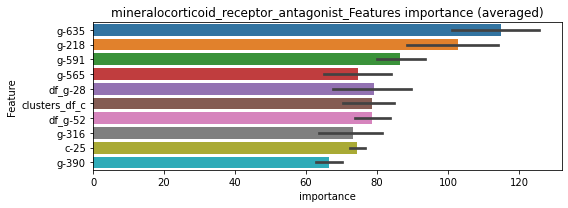

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167567	valid_1's binary_logloss: 0.0276234
[200]	training's binary_logloss: 0.00221426	valid_1's binary_logloss: 0.0102963
[300]	training's binary_logloss: 0.000597533	valid_1's binary_logloss: 0.00819359
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000564257	valid_1's binary_logloss: 0.0081377


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166112	valid_1's binary_logloss: 0.0253794
[200]	training's binary_logloss: 0.00227526	valid_1's binary_logloss: 0.00779378
[300]	training's binary_logloss: 0.000631185	valid_1's binary_logloss: 0.00472466
[400]	training's binary_logloss: 0.000308122	valid_1's binary_logloss: 0.00405768
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000270238	valid_1's binary_logloss: 0.00401841


mineralocorticoid_receptor_antagonist logloss: 0.0060780551636094495
monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192563	valid_1's binary_logloss: 0.0241661
[200]	training's binary_logloss: 0.00204519	valid_1's binary_logloss: 0.00404311
[300]	training's binary_logloss: 0.000588444	valid_1's binary_logloss: 0.00166885
[400]	training's binary_logloss: 0.000324577	valid_1's binary_logloss: 0.00110345
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00028265	valid_1's binary_logloss: 0.00102975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187582	valid_1's binary_logloss: 0.0224454
[200]	training's binary_logloss: 0.00197303	valid_1's binary_logloss: 0.00349257
[300]	training's binary_logloss: 0.00058154	valid_1's binary_logloss: 0.00145911
[400]	training's binary_logloss: 0.000327265	valid_1's binary_logloss: 0.000962948
[500]	training's binary_logloss: 0.000282465	valid_1's binary_logloss: 0.000883708
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0008952, Threshold: 0.0016268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00146, conf_1:0.00179
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016268
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0116268
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0216268
threshold: 0.0216268, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191734	valid_1's binary_logloss: 0.023682
[200]	training's binary_logloss: 0.00196366	valid_1's binary_logloss: 0.00389008
[300]	training's binary_logloss: 0.000577686	valid_1's binary_logloss: 0.00159666
[400]	training's binary_logloss: 0.000325889	valid_1's binary_logloss: 0.00108333
[500]	training's binary_logloss: 0.000281165	valid_1's binary_logloss: 0.00100583
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000281165	valid_1's binary_logloss: 0.00100583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190126	valid_1's binary_logloss: 0.0222063
[200]	training's binary_logloss: 0.00195666	valid_1's binary_logloss: 0.00309537
[300]	training's binary_logloss: 0.000565842	valid_1's binary_logloss: 0.00116836
[400]	training's binary_logloss: 0.000322284	valid_1's binary_logloss: 0.000762152
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1093328, Threshold: 0.0216268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.01946, conf_1:0.02379
threshold: 0.0216268, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191734	valid_1's binary_logloss: 0.023682
[200]	training's binary_logloss: 0.00196366	valid_1's binary_logloss: 0.00389008
[300]	training's binary_logloss: 0.000577686	valid_1's binary_logloss: 0.00159666
[400]	training's binary_logloss: 0.000325889	valid_1's binary_logloss: 0.00108333
[500]	training's binary_logloss: 0.000281165	valid_1's binary_logloss: 0.00100583
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000281165	valid_1's binary_logloss: 0.00100583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190126	valid_1's binary_logloss: 0.0222063
[200]	training's binary_logloss: 0.00195666	valid_1's binary_logloss: 0.00309537
[300]	training's binary_logloss: 0.000565842	valid_1's binary_logloss: 0.00116836
[400]	training's binary_logloss: 0.000322284	valid_1's binary_logloss: 0.000762152
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1093328, Threshold: 0.0216268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.01946, conf_1:0.02379
threshold: 0.0216268, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


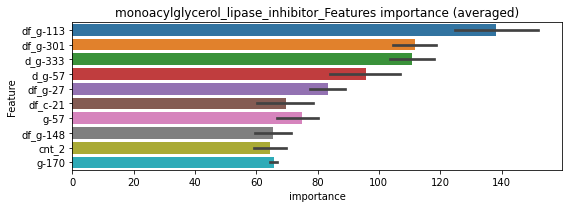

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010299	valid_1's binary_logloss: 0.0163425
[200]	training's binary_logloss: 0.00105497	valid_1's binary_logloss: 0.00697519
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00050278	valid_1's binary_logloss: 0.00659562


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010776	valid_1's binary_logloss: 0.0135206
[200]	training's binary_logloss: 0.00114871	valid_1's binary_logloss: 0.00271296
[300]	training's binary_logloss: 0.000320988	valid_1's binary_logloss: 0.00176402
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000257056	valid_1's binary_logloss: 0.00168812


monoacylglycerol_lipase_inhibitor logloss: 0.004141871002181798
monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646307	valid_1's binary_logloss: 0.124309
[200]	training's binary_logloss: 0.0163286	valid_1's binary_logloss: 0.0636809
[300]	training's binary_logloss: 0.00493435	valid_1's binary_logloss: 0.0436633
[400]	training's binary_logloss: 0.00215538	valid_1's binary_logloss: 0.0368604
[500]	training's binary_logloss: 0.00124252	valid_1's binary_logloss: 0.0336218
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.001014	valid_1's binary_logloss: 0.0329718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655177	valid_1's binary_logloss: 0.119866
[200]	training's binary_logloss: 0.0166941	valid_1's binary_logloss: 0.0644047
[300]	training's binary_logloss: 0.00517448	valid_1's binary_logloss: 0.0468325
[400]	training's binary_logloss: 0.00223085	valid_1's binary_logloss: 0.0401192
[500]	training's binary_logloss: 0.00129133	valid_1

1 / 3 AUC score:0.997
y_Threshold: 0.0115629, Threshold: 0.0163142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 649/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00357, Num_p_label: 80.0, conf_0:0.01468, conf_1:0.01795
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0163142
Num_p_label: 27.0, Expected: 14.2, Adj_threshold_2: 0.0263142
threshold: 0.0263142, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 649.0/3786, y_label_rate: 0.1714210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632435	valid_1's binary_logloss: 0.131114
[200]	training's binary_logloss: 0.0147237	valid_1's binary_logloss: 0.0754801
[300]	training's binary_logloss: 0.00435235	valid_1's binary_logloss: 0.0566333
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00206422	valid_1's binary_logloss: 0.0524489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596737	valid_1's binary_logloss: 0.127433
[200]	training's binary_logloss: 0.0138174	valid_1's binary_logloss: 0.0755986
[300]	training's binary_logloss: 0.00432736	valid_1's binary_logloss: 0.0608407
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00250909	valid_1's binary_logloss: 0.0566413


2 / 3 AUC score:0.996
y_Threshold: 0.0486327, Threshold: 0.0263142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 634.0/3756
p_label_rate: 0.0359116 Vs.target_rate: 0.00357, Num_p_label: 143.0, conf_0:0.02368, conf_1:0.02895
Num_p_label: 143.0, Expected: 14.2, Adj_threshold_1: 0.0263142
Num_p_label: 85.0, Expected: 14.2, Adj_threshold_2: 0.0363142
Num_p_label: 48.0, Expected: 14.2, Adj_threshold_3: 0.0463142
Num_p_label: 33.0, Expected: 14.2, Adj_threshold_4: 0.0563142
Num_p_label: 23.0, Expected: 14.2, Adj_threshold_5: 0.0663142
threshold: 0.0663142, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 634.0/3756, y_label_rate: 0.1687966
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583776	valid_1's binary_logloss: 0.119389
[200]	training's binary_logloss: 0.0133352	valid_1's binary_logloss: 0.0646437
[300]	training's binary_logloss: 0.00403648	valid_1's binary_logloss: 0.0475889
[400]	training's binary_logloss: 0.00182414	valid_1's binary_logloss: 0.0425466
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00190246	valid_1's binary_logloss: 0.0423565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589238	valid_1's binary_logloss: 0.137398
[200]	training's binary_logloss: 0.0130043	valid_1's binary_logloss: 0.0860959
[300]	training's binary_logloss: 0.00389401	valid_1's binary_logloss: 0.0720633
[400]	training's binary_logloss: 0.00174345	valid_1's binary_logloss: 0.0686317
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00174345	valid_1's binary_logloss: 0.0686317


3 / 3 AUC score:0.997
y_Threshold: 0.0453395, Threshold: 0.0663142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 615.0/3718
p_label_rate: 0.0070316 Vs.target_rate: 0.00357, Num_p_label: 28.0, conf_0:0.05968, conf_1:0.07295
threshold: 0.0663142, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 643.0/7700, y_label_rate: 0.0835065


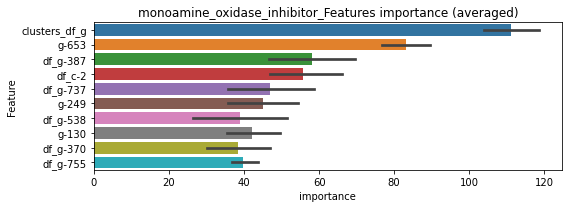

len(train_index) : 3850
len(valid_index) : 3850
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298318	valid_1's binary_logloss: 0.0776101
[200]	training's binary_logloss: 0.00650368	valid_1's binary_logloss: 0.0532019
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00284337	valid_1's binary_logloss: 0.0491374


len(train_index) : 3850
len(valid_index) : 3850
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334891	valid_1's binary_logloss: 0.0651216
[200]	training's binary_logloss: 0.00773605	valid_1's binary_logloss: 0.036168
[300]	training's binary_logloss: 0.00237845	valid_1's binary_logloss: 0.0301375
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00111368	valid_1's binary_logloss: 0.0288359


monoamine_oxidase_inhibitor logloss: 0.038986681391012856
monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214748	valid_1's binary_logloss: 0.0262916
[200]	training's binary_logloss: 0.00242704	valid_1's binary_logloss: 0.00403731
[300]	training's binary_logloss: 0.000694306	valid_1's binary_logloss: 0.00152998
[400]	training's binary_logloss: 0.00038098	valid_1's binary_logloss: 0.000961988
[500]	training's binary_logloss: 0.00031045	valid_1's binary_logloss: 0.00081212
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000305004	valid_1's binary_logloss: 0.000800167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217805	valid_1's binary_logloss: 0.0258828
[200]	training's binary_logloss: 0.00245619	valid_1's binary_logloss: 0.00375917
[300]	training's binary_logloss: 0.00070325	valid_1's binary_logloss: 0.00129912
[400]	training's binary_logloss: 0.000386382	valid_1's binary_logloss: 0.000766581
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0016576, Threshold: 0.0038449, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00346, conf_1:0.00423
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0038449
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0138449
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0238449
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0338449
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0438449
threshold: 0.0438449, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213811	valid_1's binary_logloss: 0.0254569
[200]	training's binary_logloss: 0.00236644	valid_1's binary_logloss: 0.00353151
[300]	training's binary_logloss: 0.000663711	valid_1's binary_logloss: 0.00119535
[400]	training's binary_logloss: 0.000366214	valid_1's binary_logloss: 0.000722507
[500]	training's binary_logloss: 0.000301643	valid_1's binary_logloss: 0.000620592
[600]	training's binary_logloss: 0.000295312	valid_1's binary_logloss: 0.000611171
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.000295312	valid_1's binary_logloss: 0.000611171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213868	valid_1's binary_logloss: 0.0250834
[200]	training's binary_logloss: 0.00235653	valid_1's binary_logloss: 0.00332352
[300]	training's binary_logloss: 0.000666934	valid_1's binary_logloss: 0.00105832
[400]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1652960, Threshold: 0.0438449, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0060271 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.03946, conf_1:0.04823
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.0438449
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0538449
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.0638449
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.0738449
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.0838449
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.0938449
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.1038449
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.1138449
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.1238449
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.1338449
threshold: 0.1438449, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213811	valid_1's binary_logloss: 0.0254569
[200]	training's binary_logloss: 0.00236644	valid_1's binary_logloss: 0.00353151
[300]	training's binary_logloss: 0.000663711	valid_1's binary_logloss: 0.00119535
[400]	training's binary_logloss: 0.000366214	valid_1's binary_logloss: 0.000722507
[500]	training's binary_logloss: 0.000301643	valid_1's binary_logloss: 0.000620592
[600]	training's binary_logloss: 0.000295312	valid_1's binary_logloss: 0.000611171
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.000295312	valid_1's binary_logloss: 0.000611171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213868	valid_1's binary_logloss: 0.0250834
[200]	training's binary_logloss: 0.00235653	valid_1's binary_logloss: 0.00332352
[300]	training's binary_logloss: 0.000666934	valid_1's binary_logloss: 0.00105832
[400]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1652960, Threshold: 0.1438449, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.12946, conf_1:0.15823
threshold: 0.1438449, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


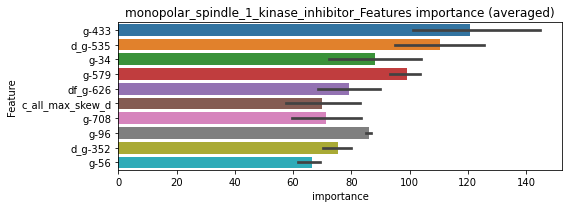

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111066	valid_1's binary_logloss: 0.0163692
[200]	training's binary_logloss: 0.00119823	valid_1's binary_logloss: 0.0050194
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000403799	valid_1's binary_logloss: 0.00418179


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114984	valid_1's binary_logloss: 0.0171947
[200]	training's binary_logloss: 0.00129213	valid_1's binary_logloss: 0.00410245
[300]	training's binary_logloss: 0.000367904	valid_1's binary_logloss: 0.00220784
[400]	training's binary_logloss: 0.000202299	valid_1's binary_logloss: 0.00188965
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00018978	valid_1's binary_logloss: 0.00187189


monopolar_spindle_1_kinase_inhibitor logloss: 0.0030269853718165856
mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346262	valid_1's binary_logloss: 0.0834792
[200]	training's binary_logloss: 0.00527651	valid_1's binary_logloss: 0.0547977
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00173235	valid_1's binary_logloss: 0.0501898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351699	valid_1's binary_logloss: 0.0794098
[200]	training's binary_logloss: 0.00565848	valid_1's binary_logloss: 0.0512603


1 / 3 AUC score:0.996
y_Threshold: 0.0089133, Threshold: 0.0834586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 145 → Positive_corect_labels: 646/3775
p_label_rate: 0.0200904 Vs.target_rate: 0.00546, Num_p_label: 80.0, conf_0:0.07511, conf_1:0.09180
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.0834586


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00428047	valid_1's binary_logloss: 0.0496776


Num_p_label: 76.0, Expected: 21.7, Adj_threshold_2: 0.0934586
Num_p_label: 73.0, Expected: 21.7, Adj_threshold_3: 0.1034586
Num_p_label: 70.0, Expected: 21.7, Adj_threshold_4: 0.1134586
Num_p_label: 70.0, Expected: 21.7, Adj_threshold_5: 0.1234586
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_6: 0.1334586
Num_p_label: 67.0, Expected: 21.7, Adj_threshold_7: 0.1434586
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_8: 0.1534586
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_9: 0.1634586
Num_p_label: 65.0, Expected: 21.7, Adj_threshold_10: 0.1734586
threshold: 0.1834586, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 646.0/3775, y_label_rate: 0.1711258
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307706	valid_1's binary_logloss: 0.0597272
[200]	training's binary_logloss: 0.00434504	valid_1's binary_logloss: 0.0317407
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00200503	valid_1's binary_logloss: 0.0273834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303448	valid_1's binary_logloss: 0.0747941
[200]	training's binary_logloss: 0.00422536	valid_1's binary_logloss: 0.0534142


2 / 3 AUC score:0.998
y_Threshold: 0.0320595, Threshold: 0.1834586, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00267396	valid_1's binary_logloss: 0.0521869


Remove_noisy_labels: 26 → Positive_corect_labels: 633.0/3749
p_label_rate: 0.0416876 Vs.target_rate: 0.00546, Num_p_label: 166.0, conf_0:0.16511, conf_1:0.20180
Num_p_label: 166.0, Expected: 21.7, Adj_threshold_1: 0.1834586
Num_p_label: 165.0, Expected: 21.7, Adj_threshold_2: 0.1934586
Num_p_label: 164.0, Expected: 21.7, Adj_threshold_3: 0.2034586
Num_p_label: 163.0, Expected: 21.7, Adj_threshold_4: 0.2134586
Num_p_label: 161.0, Expected: 21.7, Adj_threshold_5: 0.2234586
Num_p_label: 161.0, Expected: 21.7, Adj_threshold_6: 0.2334586
Num_p_label: 160.0, Expected: 21.7, Adj_threshold_7: 0.2434586
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_8: 0.2534586
Num_p_label: 157.0, Expected: 21.7, Adj_threshold_9: 0.2634586
Num_p_label: 155.0, Expected: 21.7, Adj_threshold_10: 0.2734586
threshold: 0.2834586, positive_p_label: 155.0/3982, p_label_rate: 0.0389252
positive_y_label: 633.0/3749, y_label_rate: 0.1688450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290481	valid_1's binary_logloss: 0.055256
[200]	training's binary_logloss: 0.00387466	valid_1's binary_logloss: 0.0278261
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00253295	valid_1's binary_logloss: 0.0251753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305972	valid_1's binary_logloss: 0.0571104
[200]	training's binary_logloss: 0.00546287	valid_1's binary_logloss: 0.032949


3 / 3 AUC score:1.000
y_Threshold: 0.0439821, Threshold: 0.2834586, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00337395	valid_1's binary_logloss: 0.0301334


Remove_noisy_labels: 14 → Positive_corect_labels: 626.0/3735
p_label_rate: 0.0409342 Vs.target_rate: 0.00546, Num_p_label: 163.0, conf_0:0.25511, conf_1:0.31180
Num_p_label: 163.0, Expected: 21.7, Adj_threshold_1: 0.2834586
Num_p_label: 160.0, Expected: 21.7, Adj_threshold_2: 0.2934586
Num_p_label: 160.0, Expected: 21.7, Adj_threshold_3: 0.3034586
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_4: 0.3134586
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_5: 0.3234586
Num_p_label: 157.0, Expected: 21.7, Adj_threshold_6: 0.3334586
Num_p_label: 156.0, Expected: 21.7, Adj_threshold_7: 0.3434586
Num_p_label: 154.0, Expected: 21.7, Adj_threshold_8: 0.3534586
Num_p_label: 153.0, Expected: 21.7, Adj_threshold_9: 0.3634586
Num_p_label: 152.0, Expected: 21.7, Adj_threshold_10: 0.3734586
threshold: 0.3834586, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 777.0/7717, y_label_rate: 0.1006868


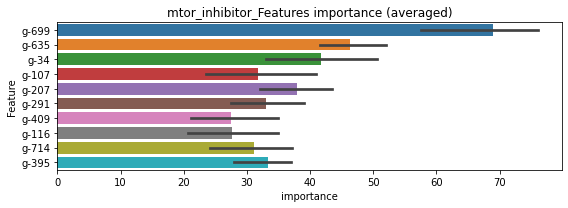

len(train_index) : 3858
len(valid_index) : 3859
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182943	valid_1's binary_logloss: 0.0474209
[200]	training's binary_logloss: 0.00253266	valid_1's binary_logloss: 0.0334315
[300]	training's binary_logloss: 0.00071048	valid_1's binary_logloss: 0.0306005
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000603283	valid_1's binary_logloss: 0.0304294


len(train_index) : 3859
len(valid_index) : 3858
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019426	valid_1's binary_logloss: 0.0488293
[200]	training's binary_logloss: 0.00264319	valid_1's binary_logloss: 0.0346731
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00225976	valid_1's binary_logloss: 0.034117


mtor_inhibitor logloss: 0.03227296489189555
mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446603	valid_1's binary_logloss: 0.0796412
[200]	training's binary_logloss: 0.00805919	valid_1's binary_logloss: 0.0321103
[300]	training's binary_logloss: 0.00220895	valid_1's binary_logloss: 0.0212576
[400]	training's binary_logloss: 0.00104095	valid_1's binary_logloss: 0.0178128
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000746532	valid_1's binary_logloss: 0.0170522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047004	valid_1's binary_logloss: 0.0762591
[200]	training's binary_logloss: 0.00903764	valid_1's binary_logloss: 0.0251338
[300]	training's binary_logloss: 0.00250509	valid_1's binary_logloss: 0.0121713
[400]	training's binary_logloss: 0.00113861	valid_1's binary_logloss: 0.0081966
[500]	training's binary_logloss: 0.000707474	valid_1's binary_logloss: 0.00658684
Early stopping, best iteration is:
[585]	tr

1 / 3 AUC score:1.000
y_Threshold: 0.0052690, Threshold: 0.0088400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00796, conf_1:0.00972
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0088400
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.0188400
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_3: 0.0288400
threshold: 0.0288400, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454894	valid_1's binary_logloss: 0.0831979
[200]	training's binary_logloss: 0.00780785	valid_1's binary_logloss: 0.0358303
[300]	training's binary_logloss: 0.00222968	valid_1's binary_logloss: 0.0271226
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00121127	valid_1's binary_logloss: 0.0253105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466305	valid_1's binary_logloss: 0.0755216
[200]	training's binary_logloss: 0.00794468	valid_1's binary_logloss: 0.0232978
[300]	training's binary_logloss: 0.00225772	valid_1's binary_logloss: 0.0113144
[400]	training's binary_logloss: 0.00106697	valid_1's binary_logloss: 0.00782906
[500]	training's binary_logloss: 0.000677709	valid_1's binary_logloss: 0.00650512
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000597751	valid_1's binary_logloss: 0.00618402


2 / 3 AUC score:1.000
y_Threshold: 0.0291918, Threshold: 0.0288400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0110497 Vs.target_rate: 0.00202, Num_p_label: 44.0, conf_0:0.02596, conf_1:0.03172
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_1: 0.0288400
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.0388400
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0488400
threshold: 0.0488400, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445408	valid_1's binary_logloss: 0.0729028
[200]	training's binary_logloss: 0.00764377	valid_1's binary_logloss: 0.0237942
[300]	training's binary_logloss: 0.00216122	valid_1's binary_logloss: 0.0126065
[400]	training's binary_logloss: 0.00101168	valid_1's binary_logloss: 0.00937246
[500]	training's binary_logloss: 0.000644674	valid_1's binary_logloss: 0.00810116
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000549786	valid_1's binary_logloss: 0.00776486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456613	valid_1's binary_logloss: 0.0748338
[200]	training's binary_logloss: 0.00787439	valid_1's binary_logloss: 0.0237106
[300]	training's binary_logloss: 0.00224229	valid_1's binary_logloss: 0.012467
[400]	training's binary_logloss: 0.00104987	valid_1's binary_logloss: 0.00931214
[500]	training's binary_logloss: 0.00066

3 / 3 AUC score:1.000
y_Threshold: 0.0244972, Threshold: 0.0488400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0027624 Vs.target_rate: 0.00202, Num_p_label: 11.0, conf_0:0.04396, conf_1:0.05372
threshold: 0.0488400, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 660.0/7773, y_label_rate: 0.0849093


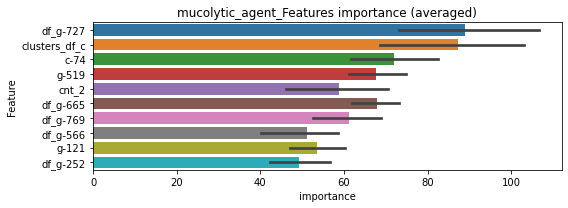

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024153	valid_1's binary_logloss: 0.0490585
[200]	training's binary_logloss: 0.00413421	valid_1's binary_logloss: 0.0231276
[300]	training's binary_logloss: 0.00114577	valid_1's binary_logloss: 0.017795
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000606563	valid_1's binary_logloss: 0.0167099


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253702	valid_1's binary_logloss: 0.0439441
[200]	training's binary_logloss: 0.00441129	valid_1's binary_logloss: 0.0172263
[300]	training's binary_logloss: 0.00123237	valid_1's binary_logloss: 0.0117218
[400]	training's binary_logloss: 0.000564874	valid_1's binary_logloss: 0.0102958
[500]	training's binary_logloss: 0.000359333	valid_1's binary_logloss: 0.00968506
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000372365	valid_1's binary_logloss: 0.00965491


mucolytic_agent logloss: 0.013182871444114272
neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389063	valid_1's binary_logloss: 0.0629296
[200]	training's binary_logloss: 0.00608456	valid_1's binary_logloss: 0.0203326
[300]	training's binary_logloss: 0.00168972	valid_1's binary_logloss: 0.010828
[400]	training's binary_logloss: 0.000807592	valid_1's binary_logloss: 0.00783486
[500]	training's binary_logloss: 0.000524619	valid_1's binary_logloss: 0.0066147
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000485156	valid_1's binary_logloss: 0.00649995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390263	valid_1's binary_logloss: 0.0606241
[200]	training's binary_logloss: 0.00610528	valid_1's binary_logloss: 0.0162714
[300]	training's binary_logloss: 0.00170517	valid_1's binary_logloss: 0.00870205
[400]	training's binary_logloss: 0.000812633	valid_1's binary_logloss: 0.007001
Early stopping, best iteration is:
[406]

1 / 3 AUC score:1.000
y_Threshold: 0.0048596, Threshold: 0.0078347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00705, conf_1:0.00862
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0078347
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_2: 0.0178347
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.0278347
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.0378347
threshold: 0.0378347, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368496	valid_1's binary_logloss: 0.0591613
[200]	training's binary_logloss: 0.00559103	valid_1's binary_logloss: 0.0173156
[300]	training's binary_logloss: 0.00157786	valid_1's binary_logloss: 0.00859876
[400]	training's binary_logloss: 0.000771417	valid_1's binary_logloss: 0.00634351
[500]	training's binary_logloss: 0.000512614	valid_1's binary_logloss: 0.00537733
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000461679	valid_1's binary_logloss: 0.0052041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387443	valid_1's binary_logloss: 0.0598203
[200]	training's binary_logloss: 0.0057082	valid_1's binary_logloss: 0.016379
[300]	training's binary_logloss: 0.00162396	valid_1's binary_logloss: 0.00882902
[400]	training's binary_logloss: 0.00078588	valid_1's binary_logloss: 0.00713221
Early stopping, best iteration is:
[401

2 / 3 AUC score:1.000
y_Threshold: 0.0399460, Threshold: 0.0378347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.03405, conf_1:0.04162
threshold: 0.0378347, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368496	valid_1's binary_logloss: 0.0591613
[200]	training's binary_logloss: 0.00559103	valid_1's binary_logloss: 0.0173156
[300]	training's binary_logloss: 0.00157786	valid_1's binary_logloss: 0.00859876
[400]	training's binary_logloss: 0.000771417	valid_1's binary_logloss: 0.00634351
[500]	training's binary_logloss: 0.000512614	valid_1's binary_logloss: 0.00537733
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000461679	valid_1's binary_logloss: 0.0052041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387443	valid_1's binary_logloss: 0.0598203
[200]	training's binary_logloss: 0.0057082	valid_1's binary_logloss: 0.016379
[300]	training's binary_logloss: 0.00162396	valid_1's binary_logloss: 0.00882902
[400]	training's binary_logloss: 0.00078588	valid_1's binary_logloss: 0.00713221
Early stopping, best iteration is:
[401

3 / 3 AUC score:1.000
y_Threshold: 0.0399460, Threshold: 0.0378347, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.03405, conf_1:0.04162
threshold: 0.0378347, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7789, y_label_rate: 0.0865323


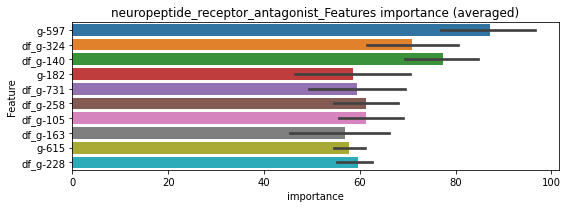

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212093	valid_1's binary_logloss: 0.0429267
[200]	training's binary_logloss: 0.00317539	valid_1's binary_logloss: 0.0225013
[300]	training's binary_logloss: 0.000877667	valid_1's binary_logloss: 0.0196294
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000647768	valid_1's binary_logloss: 0.0194723


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236981	valid_1's binary_logloss: 0.0419637
[200]	training's binary_logloss: 0.00373764	valid_1's binary_logloss: 0.0171199
[300]	training's binary_logloss: 0.00102399	valid_1's binary_logloss: 0.0119889
[400]	training's binary_logloss: 0.000476734	valid_1's binary_logloss: 0.0106416
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000499161	valid_1's binary_logloss: 0.0106363


neuropeptide_receptor_antagonist logloss: 0.015054862989372962
nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3270
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521167	valid_1's binary_logloss: 0.119344
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0312815	valid_1's binary_logloss: 0.116148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433414	valid_1's binary_logloss: 0.149366


1 / 3 AUC score:0.939
y_Threshold: 0.0344965, Threshold: 0.9638727, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 392 → Positive_corect_labels: 742/3710
p_label_rate: 0.0200904 Vs.target_rate: 0.03494, Num_p_label: 80.0, conf_0:0.86749, conf_1:1.06026
threshold: 0.9638727, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0424109	valid_1's binary_logloss: 0.149294


positive_y_label: 742.0/3710, y_label_rate: 0.2000000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233056	valid_1's binary_logloss: 0.0328715
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00405128	valid_1's binary_logloss: 0.0212108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211173	valid_1's binary_logloss: 0.0404297


2 / 3 AUC score:0.994
y_Threshold: 0.0465108, Threshold: 0.9638727, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 30 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0381718 Vs.target_rate: 0.03494, Num_p_label: 152.0, conf_0:0.86749, conf_1:1.06026
threshold: 0.9638727, positive_p_label: 152.0/3982, p_label_rate: 0.0381718


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00394479	valid_1's binary_logloss: 0.0318388


positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162892	valid_1's binary_logloss: 0.0167382
[200]	training's binary_logloss: 0.00106893	valid_1's binary_logloss: 0.00115767
[300]	training's binary_logloss: 0.000236104	valid_1's binary_logloss: 0.00027383
[400]	training's binary_logloss: 0.000155047	valid_1's binary_logloss: 0.000184586
[500]	training's binary_logloss: 0.000140698	valid_1's binary_logloss: 0.000168794
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000139212	valid_1's binary_logloss: 0.000167181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163036	valid_1's binary_logloss: 0.0170209
[200]	training's binary_logloss: 0.00106654	valid_1's binary_logloss: 0.00137052
[300]	training's binary_logloss: 0.000234599	valid_1's binary_logloss: 0.000499474
[400]	training's binary_logloss: 0.000154382	valid_1's binary_logloss: 0.000405412


3 / 3 AUC score:1.000
y_Threshold: 0.1396835, Threshold: 0.9638727, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 0 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0399297 Vs.target_rate: 0.03494, Num_p_label: 159.0, conf_0:0.86749, conf_1:1.06026
threshold: 0.9638727, positive_p_label: 159.0/3982, p_label_rate: 0.0399297


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000142197	valid_1's binary_logloss: 0.000390157


positive_y_label: 886.0/7662, y_label_rate: 0.1156356


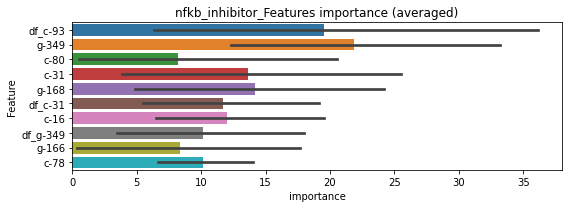

len(train_index) : 3831
len(valid_index) : 3831
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111458	valid_1's binary_logloss: 0.0127217
[200]	training's binary_logloss: 0.000794246	valid_1's binary_logloss: 0.00229342
[300]	training's binary_logloss: 0.000159239	valid_1's binary_logloss: 0.00139739
[400]	training's binary_logloss: 9.0471e-05	valid_1's binary_logloss: 0.0012412
Early stopping, best iteration is:
[409]	training's binary_logloss: 8.81175e-05	valid_1's binary_logloss: 0.00123914


len(train_index) : 3831
len(valid_index) : 3831
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110096	valid_1's binary_logloss: 0.012375
[200]	training's binary_logloss: 0.000756166	valid_1's binary_logloss: 0.0024309
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000277357	valid_1's binary_logloss: 0.0020494


nfkb_inhibitor logloss: 0.0016442705504545476
nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185801	valid_1's binary_logloss: 0.0251828
[200]	training's binary_logloss: 0.00187517	valid_1's binary_logloss: 0.00624168
[300]	training's binary_logloss: 0.000527144	valid_1's binary_logloss: 0.00366088
[400]	training's binary_logloss: 0.000298986	valid_1's binary_logloss: 0.00303975
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00026422	valid_1's binary_logloss: 0.00294672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187951	valid_1's binary_logloss: 0.022672
[200]	training's binary_logloss: 0.00189404	valid_1's binary_logloss: 0.00347112
[300]	training's binary_logloss: 0.000530595	valid_1's binary_logloss: 0.00136112
[400]	training's binary_logloss: 0.000304774	valid_1's binary_logloss: 0.000927543
[500]	training's binary_logloss: 0.00026896	valid_1's binary_logloss: 0.00085407
[600]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0009776, Threshold: 0.0019570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00176, conf_1:0.00215
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019570
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0119570
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0219570
threshold: 0.0219570, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187318	valid_1's binary_logloss: 0.0241864
[200]	training's binary_logloss: 0.00182344	valid_1's binary_logloss: 0.00569751
[300]	training's binary_logloss: 0.000511797	valid_1's binary_logloss: 0.00331626
[400]	training's binary_logloss: 0.000294643	valid_1's binary_logloss: 0.00278833
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000264526	valid_1's binary_logloss: 0.00270276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01873	valid_1's binary_logloss: 0.021335
[200]	training's binary_logloss: 0.00183078	valid_1's binary_logloss: 0.00263432
[300]	training's binary_logloss: 0.000518157	valid_1's binary_logloss: 0.000833308
[400]	training's binary_logloss: 0.000296653	valid_1's binary_logloss: 0.000513669
[500]	training's binary_logloss: 0.000263231	valid_1's binary_logloss: 0.000466108
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0275645, Threshold: 0.0219570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00050, Num_p_label: 18.0, conf_0:0.01976, conf_1:0.02415
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.0219570
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0319570
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0419570
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0519570
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.0619570
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0719570
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0819570
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.0919570
threshold: 0.0919570, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187318	valid_1's binary_logloss: 0.0241864
[200]	training's binary_logloss: 0.00182344	valid_1's binary_logloss: 0.00569751
[300]	training's binary_logloss: 0.000511797	valid_1's binary_logloss: 0.00331626
[400]	training's binary_logloss: 0.000294643	valid_1's binary_logloss: 0.00278833
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000264526	valid_1's binary_logloss: 0.00270276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01873	valid_1's binary_logloss: 0.021335
[200]	training's binary_logloss: 0.00183078	valid_1's binary_logloss: 0.00263432
[300]	training's binary_logloss: 0.000518157	valid_1's binary_logloss: 0.000833308
[400]	training's binary_logloss: 0.000296653	valid_1's binary_logloss: 0.000513669
[500]	training's binary_logloss: 0.000263231	valid_1's binary_logloss: 0.000466108
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0275645, Threshold: 0.0919570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.08276, conf_1:0.10115
threshold: 0.0919570, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


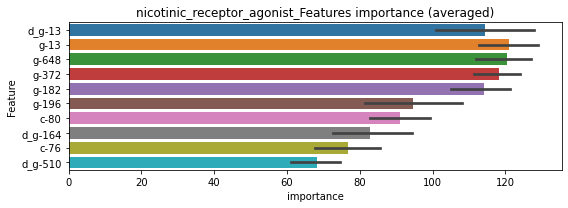

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00989442	valid_1's binary_logloss: 0.0150926
[200]	training's binary_logloss: 0.000954525	valid_1's binary_logloss: 0.00462149
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000316319	valid_1's binary_logloss: 0.0037722


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100501	valid_1's binary_logloss: 0.0164778
[200]	training's binary_logloss: 0.000983185	valid_1's binary_logloss: 0.00764529
[300]	training's binary_logloss: 0.000275207	valid_1's binary_logloss: 0.00630478
[400]	training's binary_logloss: 0.000157038	valid_1's binary_logloss: 0.00601471
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00016215	valid_1's binary_logloss: 0.00599884


nicotinic_receptor_agonist logloss: 0.0048855186248345905
nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314928	valid_1's binary_logloss: 0.0470671
[200]	training's binary_logloss: 0.00442333	valid_1's binary_logloss: 0.00975666
[300]	training's binary_logloss: 0.001195	valid_1's binary_logloss: 0.0034087
[400]	training's binary_logloss: 0.000593368	valid_1's binary_logloss: 0.00201954
[500]	training's binary_logloss: 0.000419293	valid_1's binary_logloss: 0.00155743
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000390139	valid_1's binary_logloss: 0.00149308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308197	valid_1's binary_logloss: 0.0439365
[200]	training's binary_logloss: 0.00414376	valid_1's binary_logloss: 0.0100364
[300]	training's binary_logloss: 0.00114523	valid_1's binary_logloss: 0.00417282
[400]	training's binary_logloss: 0.000576818	valid_1's binary_logloss: 0.0027736
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0023825, Threshold: 0.0037563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00338, conf_1:0.00413
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0037563
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.0137563
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0237563
threshold: 0.0237563, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305781	valid_1's binary_logloss: 0.0434826
[200]	training's binary_logloss: 0.00411302	valid_1's binary_logloss: 0.00857248
[300]	training's binary_logloss: 0.00113887	valid_1's binary_logloss: 0.00289575
[400]	training's binary_logloss: 0.000570322	valid_1's binary_logloss: 0.00174182
[500]	training's binary_logloss: 0.000409092	valid_1's binary_logloss: 0.00134902
[600]	training's binary_logloss: 0.000383322	valid_1's binary_logloss: 0.00130274
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000383253	valid_1's binary_logloss: 0.00130267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294409	valid_1's binary_logloss: 0.0418142
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.00966223
[300]	training's binary_logloss: 0.00109362	valid_1's binary_logloss: 0.00402779
[400]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1066338, Threshold: 0.0237563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0035158 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.02138, conf_1:0.02613
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.0237563
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.0337563
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_3: 0.0437563
threshold: 0.0437563, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305781	valid_1's binary_logloss: 0.0434826
[200]	training's binary_logloss: 0.00411302	valid_1's binary_logloss: 0.00857248
[300]	training's binary_logloss: 0.00113887	valid_1's binary_logloss: 0.00289575
[400]	training's binary_logloss: 0.000570322	valid_1's binary_logloss: 0.00174182
[500]	training's binary_logloss: 0.000409092	valid_1's binary_logloss: 0.00134902
[600]	training's binary_logloss: 0.000383322	valid_1's binary_logloss: 0.00130274
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000383253	valid_1's binary_logloss: 0.00130267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294409	valid_1's binary_logloss: 0.0418142
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.00966223
[300]	training's binary_logloss: 0.00109362	valid_1's binary_logloss: 0.00402779
[400]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1066338, Threshold: 0.0437563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.03938, conf_1:0.04813
threshold: 0.0437563, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


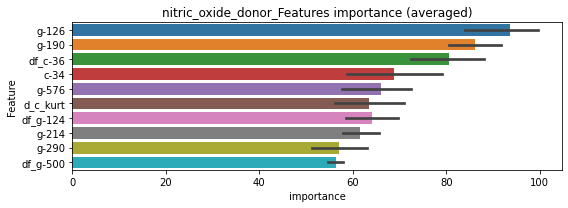

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166518	valid_1's binary_logloss: 0.0277768
[200]	training's binary_logloss: 0.0022089	valid_1's binary_logloss: 0.0097629
[300]	training's binary_logloss: 0.000615025	valid_1's binary_logloss: 0.00773793
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000591565	valid_1's binary_logloss: 0.00767642


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01639	valid_1's binary_logloss: 0.028001
[200]	training's binary_logloss: 0.00223109	valid_1's binary_logloss: 0.0121767
[300]	training's binary_logloss: 0.000619954	valid_1's binary_logloss: 0.0109062
[400]	training's binary_logloss: 0.000305106	valid_1's binary_logloss: 0.0101072
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000260099	valid_1's binary_logloss: 0.00991514


nitric_oxide_donor logloss: 0.008795779677591846
nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375861	valid_1's binary_logloss: 0.0577583
[200]	training's binary_logloss: 0.00538973	valid_1's binary_logloss: 0.0141183
[300]	training's binary_logloss: 0.00145353	valid_1's binary_logloss: 0.00637272
[400]	training's binary_logloss: 0.000697817	valid_1's binary_logloss: 0.00438579
[500]	training's binary_logloss: 0.000484207	valid_1's binary_logloss: 0.00373024
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000483708	valid_1's binary_logloss: 0.00372947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373783	valid_1's binary_logloss: 0.0516022
[200]	training's binary_logloss: 0.00563589	valid_1's binary_logloss: 0.0130659
[300]	training's binary_logloss: 0.00150343	valid_1's binary_logloss: 0.0062038
[400]	training's binary_logloss: 0.00071771	valid_1's binary_logloss: 0.00445773
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0025897, Threshold: 0.1201919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.10817, conf_1:0.13221
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.1201919
Num_p_label: 78.0, Expected: 4.8, Adj_threshold_2: 0.1301919
Num_p_label: 76.0, Expected: 4.8, Adj_threshold_3: 0.1401919
Num_p_label: 75.0, Expected: 4.8, Adj_threshold_4: 0.1501919
Num_p_label: 73.0, Expected: 4.8, Adj_threshold_5: 0.1601919
Num_p_label: 71.0, Expected: 4.8, Adj_threshold_6: 0.1701919
Num_p_label: 69.0, Expected: 4.8, Adj_threshold_7: 0.1801919
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_8: 0.1901919
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_9: 0.2001919
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_10: 0.2101919
threshold: 0.2201919, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362901	valid_1's binary_logloss: 0.0547083
[200]	training's binary_logloss: 0.0051895	valid_1's binary_logloss: 0.0134361
[300]	training's binary_logloss: 0.00140716	valid_1's binary_logloss: 0.00599688
[400]	training's binary_logloss: 0.000673762	valid_1's binary_logloss: 0.00385352
[500]	training's binary_logloss: 0.000461858	valid_1's binary_logloss: 0.00327747
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000453489	valid_1's binary_logloss: 0.00321487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368459	valid_1's binary_logloss: 0.0513815
[200]	training's binary_logloss: 0.00527435	valid_1's binary_logloss: 0.0100461
[300]	training's binary_logloss: 0.0014146	valid_1's binary_logloss: 0.00354801
[400]	training's binary_logloss: 0.000683638	valid_1's binary_logloss: 0.00210631
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0959942, Threshold: 0.2201919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0306379 Vs.target_rate: 0.00122, Num_p_label: 122.0, conf_0:0.19817, conf_1:0.24221
Num_p_label: 122.0, Expected: 4.8, Adj_threshold_1: 0.2201919
Num_p_label: 121.0, Expected: 4.8, Adj_threshold_2: 0.2301919
Num_p_label: 120.0, Expected: 4.8, Adj_threshold_3: 0.2401919
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_4: 0.2501919
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_5: 0.2601919
Num_p_label: 117.0, Expected: 4.8, Adj_threshold_6: 0.2701919
Num_p_label: 116.0, Expected: 4.8, Adj_threshold_7: 0.2801919
Num_p_label: 115.0, Expected: 4.8, Adj_threshold_8: 0.2901919
Num_p_label: 113.0, Expected: 4.8, Adj_threshold_9: 0.3001919
Num_p_label: 112.0, Expected: 4.8, Adj_threshold_10: 0.3101919
threshold: 0.3201919, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 656.0/3808, y_label_rate: 0.1722

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362901	valid_1's binary_logloss: 0.0547083
[200]	training's binary_logloss: 0.0051895	valid_1's binary_logloss: 0.0134361
[300]	training's binary_logloss: 0.00140716	valid_1's binary_logloss: 0.00599688
[400]	training's binary_logloss: 0.000673762	valid_1's binary_logloss: 0.00385352
[500]	training's binary_logloss: 0.000461858	valid_1's binary_logloss: 0.00327747
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000453489	valid_1's binary_logloss: 0.00321487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368459	valid_1's binary_logloss: 0.0513815
[200]	training's binary_logloss: 0.00527435	valid_1's binary_logloss: 0.0100461
[300]	training's binary_logloss: 0.0014146	valid_1's binary_logloss: 0.00354801
[400]	training's binary_logloss: 0.000683638	valid_1's binary_logloss: 0.00210631
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0959942, Threshold: 0.3201919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0276243 Vs.target_rate: 0.00122, Num_p_label: 110.0, conf_0:0.28817, conf_1:0.35221
Num_p_label: 110.0, Expected: 4.8, Adj_threshold_1: 0.3201919
Num_p_label: 109.0, Expected: 4.8, Adj_threshold_2: 0.3301919
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_3: 0.3401919
Num_p_label: 107.0, Expected: 4.8, Adj_threshold_4: 0.3501919
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_5: 0.3601919
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_6: 0.3701919
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_7: 0.3801919
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_8: 0.3901919
Num_p_label: 101.0, Expected: 4.8, Adj_threshold_9: 0.4001919
Num_p_label: 101.0, Expected: 4.8, Adj_threshold_10: 0.4101919
threshold: 0.4201919, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 756.0/7790, y_label_rate: 0.0970

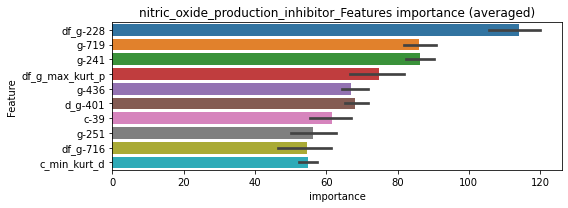

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229675	valid_1's binary_logloss: 0.0362924
[200]	training's binary_logloss: 0.00350685	valid_1's binary_logloss: 0.0135617
[300]	training's binary_logloss: 0.000923716	valid_1's binary_logloss: 0.00969011
[400]	training's binary_logloss: 0.000428386	valid_1's binary_logloss: 0.00882606
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000416647	valid_1's binary_logloss: 0.00880478


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222953	valid_1's binary_logloss: 0.0353171
[200]	training's binary_logloss: 0.00337357	valid_1's binary_logloss: 0.0106844
[300]	training's binary_logloss: 0.000918649	valid_1's binary_logloss: 0.00652756
[400]	training's binary_logloss: 0.000429724	valid_1's binary_logloss: 0.00563858
[500]	training's binary_logloss: 0.000287023	valid_1's binary_logloss: 0.005401
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000274662	valid_1's binary_logloss: 0.00536719


nitric_oxide_production_inhibitor logloss: 0.007085985552714758
nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348452	valid_1's binary_logloss: 0.0577294
[200]	training's binary_logloss: 0.00490778	valid_1's binary_logloss: 0.0195071
[300]	training's binary_logloss: 0.00130908	valid_1's binary_logloss: 0.0130592
[400]	training's binary_logloss: 0.000642164	valid_1's binary_logloss: 0.0114042
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000515658	valid_1's binary_logloss: 0.010953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336923	valid_1's binary_logloss: 0.0492854
[200]	training's binary_logloss: 0.00473429	valid_1's binary_logloss: 0.0105772
[300]	training's binary_logloss: 0.0012845	valid_1's binary_logloss: 0.00396902
[400]	training's binary_logloss: 0.000633649	valid_1's binary_logloss: 0.00249148
[500]	training's binary_logloss: 0.000438901	valid_1's binary_logloss: 0.00198075
Early stopping, best iteration is:
[573]

1 / 3 AUC score:1.000
y_Threshold: 0.0029334, Threshold: 0.0043341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00390, conf_1:0.00477
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0043341
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.0143341
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_3: 0.0243341
threshold: 0.0243341, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344145	valid_1's binary_logloss: 0.0559732
[200]	training's binary_logloss: 0.00471583	valid_1's binary_logloss: 0.0180169
[300]	training's binary_logloss: 0.00127921	valid_1's binary_logloss: 0.0117713
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000712331	valid_1's binary_logloss: 0.0103368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033378	valid_1's binary_logloss: 0.0482949
[200]	training's binary_logloss: 0.0045535	valid_1's binary_logloss: 0.00932604
[300]	training's binary_logloss: 0.00125839	valid_1's binary_logloss: 0.00337627
[400]	training's binary_logloss: 0.000628661	valid_1's binary_logloss: 0.00198175
[500]	training's binary_logloss: 0.000443764	valid_1's binary_logloss: 0.00155909
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000424843	valid_1's binary_logloss: 0.00151212


2 / 3 AUC score:1.000
y_Threshold: 0.0187672, Threshold: 0.0243341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0040181 Vs.target_rate: 0.00109, Num_p_label: 16.0, conf_0:0.02190, conf_1:0.02677
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_1: 0.0243341
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_2: 0.0343341
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_3: 0.0443341
threshold: 0.0443341, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344145	valid_1's binary_logloss: 0.0559732
[200]	training's binary_logloss: 0.00471583	valid_1's binary_logloss: 0.0180169
[300]	training's binary_logloss: 0.00127921	valid_1's binary_logloss: 0.0117713
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000712331	valid_1's binary_logloss: 0.0103368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033378	valid_1's binary_logloss: 0.0482949
[200]	training's binary_logloss: 0.0045535	valid_1's binary_logloss: 0.00932604
[300]	training's binary_logloss: 0.00125839	valid_1's binary_logloss: 0.00337627
[400]	training's binary_logloss: 0.000628661	valid_1's binary_logloss: 0.00198175
[500]	training's binary_logloss: 0.000443764	valid_1's binary_logloss: 0.00155909
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000424843	valid_1's binary_logloss: 0.00151212


3 / 3 AUC score:1.000
y_Threshold: 0.0187672, Threshold: 0.0443341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.03990, conf_1:0.04877
threshold: 0.0443341, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7790, y_label_rate: 0.0851091


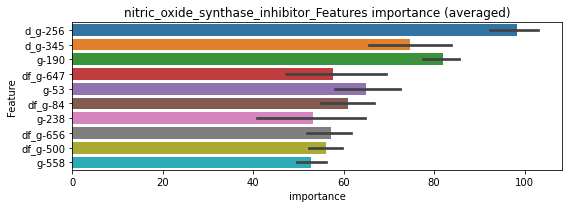

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188477	valid_1's binary_logloss: 0.0281678
[200]	training's binary_logloss: 0.00264755	valid_1's binary_logloss: 0.00897308
[300]	training's binary_logloss: 0.000695534	valid_1's binary_logloss: 0.00689472
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000548167	valid_1's binary_logloss: 0.00679015


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191196	valid_1's binary_logloss: 0.0294502
[200]	training's binary_logloss: 0.00274708	valid_1's binary_logloss: 0.00802286
[300]	training's binary_logloss: 0.000725619	valid_1's binary_logloss: 0.00435374
[400]	training's binary_logloss: 0.000348292	valid_1's binary_logloss: 0.00351609
[500]	training's binary_logloss: 0.000235954	valid_1's binary_logloss: 0.00322467
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000213665	valid_1's binary_logloss: 0.00315706


nitric_oxide_synthase_inhibitor logloss: 0.004973603703829721
norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165564	valid_1's binary_logloss: 0.0183233
[200]	training's binary_logloss: 0.00148765	valid_1's binary_logloss: 0.00209396
[300]	training's binary_logloss: 0.000411812	valid_1's binary_logloss: 0.000702311
[400]	training's binary_logloss: 0.000245277	valid_1's binary_logloss: 0.000447742
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000224926	valid_1's binary_logloss: 0.000415218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167267	valid_1's binary_logloss: 0.0180361
[200]	training's binary_logloss: 0.00149576	valid_1's binary_logloss: 0.00186587
[300]	training's binary_logloss: 0.000413623	valid_1's binary_logloss: 0.000586207
[400]	training's binary_logloss: 0.000246735	valid_1's binary_logloss: 0.000369381
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000221296	valid_1's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0006668, Threshold: 0.0010671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00096, conf_1:0.00117
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010671
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0110671
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.0210671
threshold: 0.0210671, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170119	valid_1's binary_logloss: 0.0183511
[200]	training's binary_logloss: 0.00149265	valid_1's binary_logloss: 0.00181621
[300]	training's binary_logloss: 0.000407294	valid_1's binary_logloss: 0.000544136
[400]	training's binary_logloss: 0.000244229	valid_1's binary_logloss: 0.000336191
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000218486	valid_1's binary_logloss: 0.000304021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170125	valid_1's binary_logloss: 0.0181741
[200]	training's binary_logloss: 0.00148364	valid_1's binary_logloss: 0.0017869
[300]	training's binary_logloss: 0.000405545	valid_1's binary_logloss: 0.00051222
[400]	training's binary_logloss: 0.000245122	valid_1's binary_logloss: 0.000314354
[500]	training's binary_logloss: 0.000221472	valid_1's binary_logloss: 0.00028352
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.1710682, Threshold: 0.0210671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00029, Num_p_label: 12.0, conf_0:0.01896, conf_1:0.02317
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_1: 0.0210671
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0310671
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0410671
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.0510671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0610671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.0710671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0810671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.0910671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.1010671
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.1110671
threshold: 0.1210671, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170119	valid_1's binary_logloss: 0.0183511
[200]	training's binary_logloss: 0.00149265	valid_1's binary_logloss: 0.00181621
[300]	training's binary_logloss: 0.000407294	valid_1's binary_logloss: 0.000544136
[400]	training's binary_logloss: 0.000244229	valid_1's binary_logloss: 0.000336191
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000218486	valid_1's binary_logloss: 0.000304021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170125	valid_1's binary_logloss: 0.0181741
[200]	training's binary_logloss: 0.00148364	valid_1's binary_logloss: 0.0017869
[300]	training's binary_logloss: 0.000405545	valid_1's binary_logloss: 0.00051222
[400]	training's binary_logloss: 0.000245122	valid_1's binary_logloss: 0.000314354
[500]	training's binary_logloss: 0.000221472	valid_1's binary_logloss: 0.00028352
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.1710682, Threshold: 0.1210671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.10896, conf_1:0.13317
threshold: 0.1210671, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


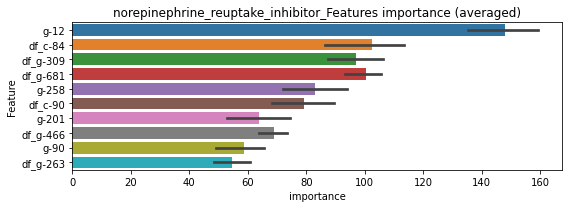

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876244	valid_1's binary_logloss: 0.011463
[200]	training's binary_logloss: 0.000751635	valid_1's binary_logloss: 0.00293628
[300]	training's binary_logloss: 0.000204638	valid_1's binary_logloss: 0.00243403
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000211557	valid_1's binary_logloss: 0.00243101


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00903364	valid_1's binary_logloss: 0.0107128
[200]	training's binary_logloss: 0.000784068	valid_1's binary_logloss: 0.00269796
[300]	training's binary_logloss: 0.000213363	valid_1's binary_logloss: 0.00205336
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000155799	valid_1's binary_logloss: 0.00194309


norepinephrine_reuptake_inhibitor logloss: 0.0021870530631014056
nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204004	valid_1's binary_logloss: 0.0274948
[200]	training's binary_logloss: 0.00220594	valid_1's binary_logloss: 0.00719588
[300]	training's binary_logloss: 0.000626739	valid_1's binary_logloss: 0.00479662
[400]	training's binary_logloss: 0.000352911	valid_1's binary_logloss: 0.00419656
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000299706	valid_1's binary_logloss: 0.00401019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206002	valid_1's binary_logloss: 0.0253615
[200]	training's binary_logloss: 0.00226352	valid_1's binary_logloss: 0.00446642
[300]	training's binary_logloss: 0.000640261	valid_1's binary_logloss: 0.00215732
[400]	training's binary_logloss: 0.000342667	valid_1's binary_logloss: 0.00151499
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000325236	valid_1's binary_logloss: 0.00148

1 / 3 AUC score:1.000
y_Threshold: 0.0009261, Threshold: 0.1246009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.11214, conf_1:0.13706
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.1246009
Num_p_label: 78.0, Expected: 3.0, Adj_threshold_2: 0.1346009
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_3: 0.1446009
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_4: 0.1546009
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_5: 0.1646009
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_6: 0.1746009
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_7: 0.1846009
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_8: 0.1946009
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_9: 0.2046009
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_10: 0.2146009
threshold: 0.2246009, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198323	valid_1's binary_logloss: 0.0235814
[200]	training's binary_logloss: 0.00194625	valid_1's binary_logloss: 0.00345196
[300]	training's binary_logloss: 0.000537848	valid_1's binary_logloss: 0.00137741
[400]	training's binary_logloss: 0.000302582	valid_1's binary_logloss: 0.000930689
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000270046	valid_1's binary_logloss: 0.000873919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195464	valid_1's binary_logloss: 0.0246808
[200]	training's binary_logloss: 0.00195501	valid_1's binary_logloss: 0.0030972
[300]	training's binary_logloss: 0.000537838	valid_1's binary_logloss: 0.00103238
[400]	training's binary_logloss: 0.000300499	valid_1's binary_logloss: 0.000635014
[500]	training's binary_logloss: 0.00026934	valid_1's binary_logloss: 0.000583122
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1585631, Threshold: 0.2246009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0278754 Vs.target_rate: 0.00076, Num_p_label: 111.0, conf_0:0.20214, conf_1:0.24706
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_1: 0.2246009
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_2: 0.2346009
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_3: 0.2446009
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_4: 0.2546009
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_5: 0.2646009
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_6: 0.2746009
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_7: 0.2846009
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_8: 0.2946009
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_9: 0.3046009
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_10: 0.3146009
threshold: 0.3246009, positive_p_label: 107.0/3982, p_label_rate: 0.0268709
positive_y_label: 657.0/3811, y_label_rate: 0.1723

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198323	valid_1's binary_logloss: 0.0235814
[200]	training's binary_logloss: 0.00194625	valid_1's binary_logloss: 0.00345196
[300]	training's binary_logloss: 0.000537848	valid_1's binary_logloss: 0.00137741
[400]	training's binary_logloss: 0.000302582	valid_1's binary_logloss: 0.000930689
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000270046	valid_1's binary_logloss: 0.000873919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195464	valid_1's binary_logloss: 0.0246808
[200]	training's binary_logloss: 0.00195501	valid_1's binary_logloss: 0.0030972
[300]	training's binary_logloss: 0.000537838	valid_1's binary_logloss: 0.00103238
[400]	training's binary_logloss: 0.000300499	valid_1's binary_logloss: 0.000635014
[500]	training's binary_logloss: 0.00026934	valid_1's binary_logloss: 0.000583122
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1585631, Threshold: 0.3246009, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0268709 Vs.target_rate: 0.00076, Num_p_label: 107.0, conf_0:0.29214, conf_1:0.35706
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_1: 0.3246009
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_2: 0.3346009
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_3: 0.3446009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_4: 0.3546009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_5: 0.3646009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_6: 0.3746009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_7: 0.3846009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_8: 0.3946009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_9: 0.4046009
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_10: 0.4146009
threshold: 0.4246009, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 762.0/7793, y_label_rate: 0.0977

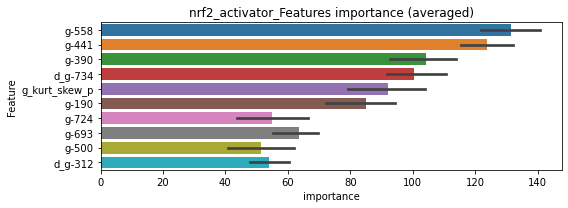

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122773	valid_1's binary_logloss: 0.0184377
[200]	training's binary_logloss: 0.00127585	valid_1's binary_logloss: 0.00641
[300]	training's binary_logloss: 0.000333275	valid_1's binary_logloss: 0.00572514
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000276285	valid_1's binary_logloss: 0.00561174


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127264	valid_1's binary_logloss: 0.0184936
[200]	training's binary_logloss: 0.00138767	valid_1's binary_logloss: 0.00577951
[300]	training's binary_logloss: 0.000374137	valid_1's binary_logloss: 0.00397504
[400]	training's binary_logloss: 0.00019934	valid_1's binary_logloss: 0.00345026
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000173868	valid_1's binary_logloss: 0.00338772


nrf2_activator logloss: 0.004499987793895662
opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063492	valid_1's binary_logloss: 0.112578
[200]	training's binary_logloss: 0.0142706	valid_1's binary_logloss: 0.0563169
[300]	training's binary_logloss: 0.00392637	valid_1's binary_logloss: 0.0394725
[400]	training's binary_logloss: 0.00161369	valid_1's binary_logloss: 0.0342941
[500]	training's binary_logloss: 0.000945536	valid_1's binary_logloss: 0.0325978
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000745284	valid_1's binary_logloss: 0.0311696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615795	valid_1's binary_logloss: 0.103957
[200]	training's binary_logloss: 0.0137925	valid_1's binary_logloss: 0.0515331
[300]	training's binary_logloss: 0.00381399	valid_1's binary_logloss: 0.0387303
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00184708	valid_1's binary_logloss: 0.0352822


1 / 3 AUC score:0.998
y_Threshold: 0.0118782, Threshold: 0.0190191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.01712, conf_1:0.02092
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0190191
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.0290191
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.0390191
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_4: 0.0490191
threshold: 0.0490191, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582105	valid_1's binary_logloss: 0.106414
[200]	training's binary_logloss: 0.0118913	valid_1's binary_logloss: 0.0520662
[300]	training's binary_logloss: 0.00332597	valid_1's binary_logloss: 0.037454
[400]	training's binary_logloss: 0.00145471	valid_1's binary_logloss: 0.0316604
[500]	training's binary_logloss: 0.000872693	valid_1's binary_logloss: 0.0297703
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000706106	valid_1's binary_logloss: 0.0288318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063281	valid_1's binary_logloss: 0.095574
[200]	training's binary_logloss: 0.0131725	valid_1's binary_logloss: 0.0369411
[300]	training's binary_logloss: 0.00364576	valid_1's binary_logloss: 0.0210604
[400]	training's binary_logloss: 0.00158232	valid_1's binary_logloss: 0.0161961
[500]	training's binary_logloss: 0.0009347	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.0384206, Threshold: 0.0490191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0055249 Vs.target_rate: 0.00256, Num_p_label: 22.0, conf_0:0.04412, conf_1:0.05392
threshold: 0.0490191, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592359	valid_1's binary_logloss: 0.107696
[200]	training's binary_logloss: 0.0125308	valid_1's binary_logloss: 0.0557309
[300]	training's binary_logloss: 0.0034615	valid_1's binary_logloss: 0.0391497
[400]	training's binary_logloss: 0.00149076	valid_1's binary_logloss: 0.0327417
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000946499	valid_1's binary_logloss: 0.0302362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588391	valid_1's binary_logloss: 0.0945001
[200]	training's binary_logloss: 0.0125747	valid_1's binary_logloss: 0.0380817
[300]	training's binary_logloss: 0.00348214	valid_1's binary_logloss: 0.0219577
[400]	training's binary_logloss: 0.0015185	valid_1's binary_logloss: 0.0170771
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00104992	valid_1's binary_logloss: 0.015914


3 / 3 AUC score:1.000
y_Threshold: 0.0460363, Threshold: 0.0490191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0120542 Vs.target_rate: 0.00256, Num_p_label: 48.0, conf_0:0.04412, conf_1:0.05392
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_1: 0.0490191
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_2: 0.0590191
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_3: 0.0690191
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_4: 0.0790191
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_5: 0.0890191
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_6: 0.0990191
threshold: 0.0990191, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 659.0/7756, y_label_rate: 0.0849665


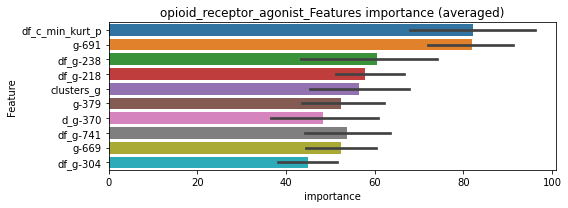

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330346	valid_1's binary_logloss: 0.0610919
[200]	training's binary_logloss: 0.00678541	valid_1's binary_logloss: 0.031491
[300]	training's binary_logloss: 0.001901	valid_1's binary_logloss: 0.0246506
[400]	training's binary_logloss: 0.000796936	valid_1's binary_logloss: 0.0225554
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000776294	valid_1's binary_logloss: 0.0225168


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355281	valid_1's binary_logloss: 0.0595054
[200]	training's binary_logloss: 0.00777922	valid_1's binary_logloss: 0.027211
[300]	training's binary_logloss: 0.00209878	valid_1's binary_logloss: 0.0179227
[400]	training's binary_logloss: 0.000884707	valid_1's binary_logloss: 0.0149409
[500]	training's binary_logloss: 0.000515527	valid_1's binary_logloss: 0.0138686
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000396955	valid_1's binary_logloss: 0.0134913


opioid_receptor_agonist logloss: 0.018004011130945297
opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637845	valid_1's binary_logloss: 0.136196
[200]	training's binary_logloss: 0.016047	valid_1's binary_logloss: 0.0836476
[300]	training's binary_logloss: 0.00492701	valid_1's binary_logloss: 0.0653128
[400]	training's binary_logloss: 0.00212004	valid_1's binary_logloss: 0.0578526
[500]	training's binary_logloss: 0.00125891	valid_1's binary_logloss: 0.0552352
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00129744	valid_1's binary_logloss: 0.0550198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697046	valid_1's binary_logloss: 0.139638
[200]	training's binary_logloss: 0.017319	valid_1's binary_logloss: 0.0843298
[300]	training's binary_logloss: 0.00506146	valid_1's binary_logloss: 0.0693285
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00428812	valid_1's binary_logloss: 0.0682114


1 / 3 AUC score:0.996
y_Threshold: 0.0205429, Threshold: 0.0243821, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 646/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.02194, conf_1:0.02682
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0243821
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_2: 0.0343821
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_3: 0.0443821
threshold: 0.0443821, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 646.0/3781, y_label_rate: 0.1708543
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630941	valid_1's binary_logloss: 0.15047
[200]	training's binary_logloss: 0.0139384	valid_1's binary_logloss: 0.0947929
[300]	training's binary_logloss: 0.00424472	valid_1's binary_logloss: 0.0807109
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00355607	valid_1's binary_logloss: 0.0798877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642795	valid_1's binary_logloss: 0.129876
[200]	training's binary_logloss: 0.0158726	valid_1's binary_logloss: 0.0775193
[300]	training's binary_logloss: 0.00487572	valid_1's binary_logloss: 0.0648172
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00371591	valid_1's binary_logloss: 0.0627117


2 / 3 AUC score:0.995
y_Threshold: 0.0426566, Threshold: 0.0443821, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 622.0/3733
p_label_rate: 0.0185836 Vs.target_rate: 0.00403, Num_p_label: 74.0, conf_0:0.03994, conf_1:0.04882
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_1: 0.0443821
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_2: 0.0543821
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_3: 0.0643821
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_4: 0.0743821
threshold: 0.0743821, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 622.0/3733, y_label_rate: 0.1666220
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592704	valid_1's binary_logloss: 0.117454
[200]	training's binary_logloss: 0.0126415	valid_1's binary_logloss: 0.0608876
[300]	training's binary_logloss: 0.00383463	valid_1's binary_logloss: 0.0462038
[400]	training's binary_logloss: 0.00177273	valid_1's binary_logloss: 0.0415611
[500]	training's binary_logloss: 0.00108508	valid_1's binary_logloss: 0.0386886
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00100437	valid_1's binary_logloss: 0.038432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615834	valid_1's binary_logloss: 0.119264
[200]	training's binary_logloss: 0.0142811	valid_1's binary_logloss: 0.0608522
[300]	training's binary_logloss: 0.00437598	valid_1's binary_logloss: 0.04546
[400]	training's binary_logloss: 0.00199147	valid_1's binary_logloss: 0.0408881
Early stopping, best iteration is:
[434]	training's 

3 / 3 AUC score:0.999
y_Threshold: 0.0317468, Threshold: 0.0743821, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 613.0/3715
p_label_rate: 0.0025113 Vs.target_rate: 0.00403, Num_p_label: 10.0, conf_0:0.06694, conf_1:0.08182
threshold: 0.0743821, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 623.0/7697, y_label_rate: 0.0809406


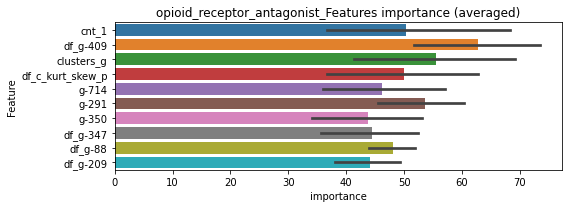

len(train_index) : 3848
len(valid_index) : 3849
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292299	valid_1's binary_logloss: 0.074447
[200]	training's binary_logloss: 0.00648705	valid_1's binary_logloss: 0.0458291
[300]	training's binary_logloss: 0.00195925	valid_1's binary_logloss: 0.0386206
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000964249	valid_1's binary_logloss: 0.0361051


len(train_index) : 3849
len(valid_index) : 3848
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331189	valid_1's binary_logloss: 0.0707921
[200]	training's binary_logloss: 0.00754469	valid_1's binary_logloss: 0.0402099
[300]	training's binary_logloss: 0.00225498	valid_1's binary_logloss: 0.0322452
[400]	training's binary_logloss: 0.00099928	valid_1's binary_logloss: 0.0296402
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000789076	valid_1's binary_logloss: 0.0289307


opioid_receptor_antagonist logloss: 0.03251833215075077
orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372731	valid_1's binary_logloss: 0.0638185
[200]	training's binary_logloss: 0.00606677	valid_1's binary_logloss: 0.0227442
[300]	training's binary_logloss: 0.00168617	valid_1's binary_logloss: 0.0143229
[400]	training's binary_logloss: 0.000809242	valid_1's binary_logloss: 0.0114472
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00065104	valid_1's binary_logloss: 0.0108476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387502	valid_1's binary_logloss: 0.0600788
[200]	training's binary_logloss: 0.00645532	valid_1's binary_logloss: 0.0171823
[300]	training's binary_logloss: 0.00177738	valid_1's binary_logloss: 0.00851543
[400]	training's binary_logloss: 0.000841375	valid_1's binary_logloss: 0.00686437
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000577849	valid_1's binary_logloss: 0.00619998


1 / 3 AUC score:1.000
y_Threshold: 0.0042755, Threshold: 0.0063284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00570, conf_1:0.00696
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0063284
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.0163284
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0263284
threshold: 0.0263284, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358485	valid_1's binary_logloss: 0.0607662
[200]	training's binary_logloss: 0.00559846	valid_1's binary_logloss: 0.0206791
[300]	training's binary_logloss: 0.00158294	valid_1's binary_logloss: 0.0127684
[400]	training's binary_logloss: 0.000768587	valid_1's binary_logloss: 0.0103242
[500]	training's binary_logloss: 0.000514271	valid_1's binary_logloss: 0.00950433
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000497838	valid_1's binary_logloss: 0.00947249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385045	valid_1's binary_logloss: 0.0594939
[200]	training's binary_logloss: 0.00625191	valid_1's binary_logloss: 0.0169076
[300]	training's binary_logloss: 0.00175725	valid_1's binary_logloss: 0.0092778
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000892221	valid_1's binary_logloss: 0.00734018


2 / 3 AUC score:1.000
y_Threshold: 0.0288960, Threshold: 0.0263284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0057760 Vs.target_rate: 0.00155, Num_p_label: 23.0, conf_0:0.02370, conf_1:0.02896
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_1: 0.0263284
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_2: 0.0363284
threshold: 0.0363284, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342718	valid_1's binary_logloss: 0.0557363
[200]	training's binary_logloss: 0.00553113	valid_1's binary_logloss: 0.0188189
[300]	training's binary_logloss: 0.00157688	valid_1's binary_logloss: 0.0112029
[400]	training's binary_logloss: 0.000769233	valid_1's binary_logloss: 0.00895922
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000608602	valid_1's binary_logloss: 0.00839296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379379	valid_1's binary_logloss: 0.0595793
[200]	training's binary_logloss: 0.00618506	valid_1's binary_logloss: 0.0186032
[300]	training's binary_logloss: 0.00173844	valid_1's binary_logloss: 0.00946865
[400]	training's binary_logloss: 0.00082566	valid_1's binary_logloss: 0.00680015
[500]	training's binary_logloss: 0.000538424	valid_1's binary_logloss: 0.00589589
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0640257, Threshold: 0.0363284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0020090 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.03270, conf_1:0.03996
threshold: 0.0363284, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7783, y_label_rate: 0.0849287


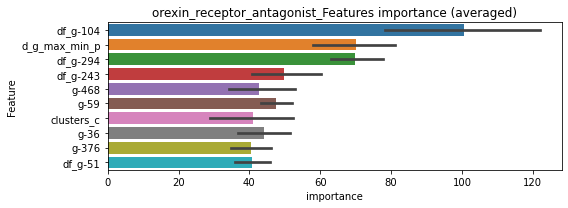

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198081	valid_1's binary_logloss: 0.0389565
[200]	training's binary_logloss: 0.00306999	valid_1's binary_logloss: 0.0161274
[300]	training's binary_logloss: 0.000830909	valid_1's binary_logloss: 0.0120991
[400]	training's binary_logloss: 0.000392075	valid_1's binary_logloss: 0.0110512
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000322913	valid_1's binary_logloss: 0.0108728


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020004	valid_1's binary_logloss: 0.0364723
[200]	training's binary_logloss: 0.00342277	valid_1's binary_logloss: 0.014208
[300]	training's binary_logloss: 0.000946721	valid_1's binary_logloss: 0.00899352
[400]	training's binary_logloss: 0.000442573	valid_1's binary_logloss: 0.00780317
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000325494	valid_1's binary_logloss: 0.00730604


orexin_receptor_antagonist logloss: 0.009089657166416116
p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337511	valid_1's binary_logloss: 0.0665793
[200]	training's binary_logloss: 0.00526821	valid_1's binary_logloss: 0.0313212
[300]	training's binary_logloss: 0.00155119	valid_1's binary_logloss: 0.0255503
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000933264	valid_1's binary_logloss: 0.0241614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338331	valid_1's binary_logloss: 0.0752654
[200]	training's binary_logloss: 0.00517329	valid_1's binary_logloss: 0.0414463
[300]	training's binary_logloss: 0.00148883	valid_1's binary_logloss: 0.0362109
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00148883	valid_1's binary_logloss: 0.0362109


1 / 3 AUC score:0.997
y_Threshold: 0.0080239, Threshold: 0.0164496, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.01480, conf_1:0.01809
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0164496
Num_p_label: 51.0, Expected: 10.4, Adj_threshold_2: 0.0264496
Num_p_label: 42.0, Expected: 10.4, Adj_threshold_3: 0.0364496
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_4: 0.0464496
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_5: 0.0564496
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_6: 0.0664496
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_7: 0.0764496
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_8: 0.0864496
threshold: 0.0864496, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 646.0/3783, y_label_rate: 0.1707639
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327299	valid_1's binary_logloss: 0.0546407
[200]	training's binary_logloss: 0.0048791	valid_1's binary_logloss: 0.0172341
[300]	training's binary_logloss: 0.00140607	valid_1's binary_logloss: 0.0103767
[400]	training's binary_logloss: 0.000698958	valid_1's binary_logloss: 0.00815079
[500]	training's binary_logloss: 0.00047207	valid_1's binary_logloss: 0.00728331
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000448772	valid_1's binary_logloss: 0.00710525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315023	valid_1's binary_logloss: 0.0577424
[200]	training's binary_logloss: 0.00463816	valid_1's binary_logloss: 0.0184625
[300]	training's binary_logloss: 0.00135529	valid_1's binary_logloss: 0.011002
[400]	training's binary_logloss: 0.000691697	valid_1's binary_logloss: 0.00928203
Early stopping, best iteration is:
[439]

2 / 3 AUC score:1.000
y_Threshold: 0.0353914, Threshold: 0.0864496, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 645.0/3781
p_label_rate: 0.0090407 Vs.target_rate: 0.00260, Num_p_label: 36.0, conf_0:0.07780, conf_1:0.09509
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_1: 0.0864496
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.0964496
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.1064496
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_4: 0.1164496
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.1264496
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_6: 0.1364496
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_7: 0.1464496
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_8: 0.1564496
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_9: 0.1664496
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_10: 0.1764496
threshold: 0.1864496, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 645.0/3781, y_label_rate: 0.170589

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322069	valid_1's binary_logloss: 0.0560648
[200]	training's binary_logloss: 0.00470301	valid_1's binary_logloss: 0.0217633
[300]	training's binary_logloss: 0.00134139	valid_1's binary_logloss: 0.016042
[400]	training's binary_logloss: 0.000677115	valid_1's binary_logloss: 0.0142715
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000617804	valid_1's binary_logloss: 0.0140654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309563	valid_1's binary_logloss: 0.0579235
[200]	training's binary_logloss: 0.00451711	valid_1's binary_logloss: 0.0174585
[300]	training's binary_logloss: 0.00132292	valid_1's binary_logloss: 0.00845696
[400]	training's binary_logloss: 0.000672918	valid_1's binary_logloss: 0.00604979
[500]	training's binary_logloss: 0.000462032	valid_1's binary_logloss: 0.00507363
Early stopping, best iteration is:
[526

3 / 3 AUC score:1.000
y_Threshold: 0.0336286, Threshold: 0.1864496, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 644.0/3779
p_label_rate: 0.0055249 Vs.target_rate: 0.00260, Num_p_label: 22.0, conf_0:0.16780, conf_1:0.20509
threshold: 0.1864496, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 666.0/7761, y_label_rate: 0.0858137


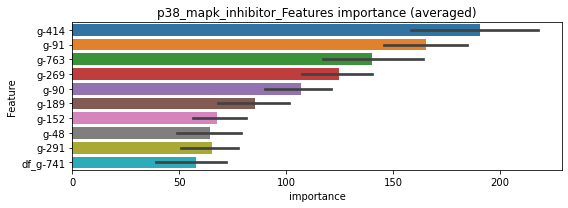

len(train_index) : 3880
len(valid_index) : 3881
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168092	valid_1's binary_logloss: 0.0348175
[200]	training's binary_logloss: 0.00240057	valid_1's binary_logloss: 0.0134623
[300]	training's binary_logloss: 0.000719656	valid_1's binary_logloss: 0.00912537
[400]	training's binary_logloss: 0.000366823	valid_1's binary_logloss: 0.0079586
[500]	training's binary_logloss: 0.000253897	valid_1's binary_logloss: 0.00767699
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000247962	valid_1's binary_logloss: 0.00759738


len(train_index) : 3881
len(valid_index) : 3880
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170518	valid_1's binary_logloss: 0.0351224
[200]	training's binary_logloss: 0.00243432	valid_1's binary_logloss: 0.0157359
[300]	training's binary_logloss: 0.000720836	valid_1's binary_logloss: 0.0120462
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000420204	valid_1's binary_logloss: 0.0113186


p38_mapk_inhibitor logloss: 0.009457734201391342
p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321001	valid_1's binary_logloss: 0.0434929
[200]	training's binary_logloss: 0.0042844	valid_1's binary_logloss: 0.00797274
[300]	training's binary_logloss: 0.00115317	valid_1's binary_logloss: 0.00272013
[400]	training's binary_logloss: 0.00057292	valid_1's binary_logloss: 0.00155247
[500]	training's binary_logloss: 0.00040987	valid_1's binary_logloss: 0.00119354
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000395351	valid_1's binary_logloss: 0.00116477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309554	valid_1's binary_logloss: 0.0533707
[200]	training's binary_logloss: 0.00417989	valid_1's binary_logloss: 0.0194117
[300]	training's binary_logloss: 0.00113578	valid_1's binary_logloss: 0.0133426
[400]	training's binary_logloss: 0.00056395	valid_1's binary_logloss: 0.0117866
Early stopping, best iteration is:
[455]

1 / 3 AUC score:1.000
y_Threshold: 0.0026450, Threshold: 0.0038307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00345, conf_1:0.00421
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0038307
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0138307
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.0238307
threshold: 0.0238307, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306112	valid_1's binary_logloss: 0.040945
[200]	training's binary_logloss: 0.00402131	valid_1's binary_logloss: 0.00742024
[300]	training's binary_logloss: 0.00110942	valid_1's binary_logloss: 0.00249321
[400]	training's binary_logloss: 0.000552436	valid_1's binary_logloss: 0.00140695
[500]	training's binary_logloss: 0.000405599	valid_1's binary_logloss: 0.00108298
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00039071	valid_1's binary_logloss: 0.00105203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298987	valid_1's binary_logloss: 0.0509794
[200]	training's binary_logloss: 0.00398214	valid_1's binary_logloss: 0.0202623
[300]	training's binary_logloss: 0.00108802	valid_1's binary_logloss: 0.0149468
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000589252	valid_1's binary_logloss: 0.0132074


2 / 3 AUC score:1.000
y_Threshold: 0.0195176, Threshold: 0.0238307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0050226 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.02145, conf_1:0.02621
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.0238307
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.0338307
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.0438307
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_4: 0.0538307
threshold: 0.0538307, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311641	valid_1's binary_logloss: 0.0463168
[200]	training's binary_logloss: 0.00417602	valid_1's binary_logloss: 0.00937605
[300]	training's binary_logloss: 0.00112227	valid_1's binary_logloss: 0.00331227
[400]	training's binary_logloss: 0.000557111	valid_1's binary_logloss: 0.00194094
[500]	training's binary_logloss: 0.000405574	valid_1's binary_logloss: 0.00154469
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000394801	valid_1's binary_logloss: 0.0015199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296899	valid_1's binary_logloss: 0.0423567
[200]	training's binary_logloss: 0.00394416	valid_1's binary_logloss: 0.0102246
[300]	training's binary_logloss: 0.00107813	valid_1's binary_logloss: 0.00444703
[400]	training's binary_logloss: 0.0005387	valid_1's binary_logloss: 0.00300418
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0839665, Threshold: 0.0538307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0007534 Vs.target_rate: 0.00101, Num_p_label: 3.0, conf_0:0.04845, conf_1:0.05921
threshold: 0.0538307, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 658.0/7788, y_label_rate: 0.0844890


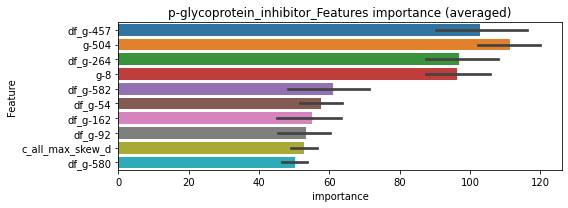

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176106	valid_1's binary_logloss: 0.0240988
[200]	training's binary_logloss: 0.00235328	valid_1's binary_logloss: 0.00583513
[300]	training's binary_logloss: 0.000605367	valid_1's binary_logloss: 0.00349107
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000371086	valid_1's binary_logloss: 0.00323859


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172518	valid_1's binary_logloss: 0.0256906
[200]	training's binary_logloss: 0.00225502	valid_1's binary_logloss: 0.00722448
[300]	training's binary_logloss: 0.000613647	valid_1's binary_logloss: 0.00439695
[400]	training's binary_logloss: 0.000301657	valid_1's binary_logloss: 0.00376375
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000273433	valid_1's binary_logloss: 0.00364378


p-glycoprotein_inhibitor logloss: 0.003441181437628993
parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412654	valid_1's binary_logloss: 0.0866007
[200]	training's binary_logloss: 0.00780865	valid_1's binary_logloss: 0.0403194
[300]	training's binary_logloss: 0.00234817	valid_1's binary_logloss: 0.0283765
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00126161	valid_1's binary_logloss: 0.0255498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434971	valid_1's binary_logloss: 0.0813009
[200]	training's binary_logloss: 0.00800238	valid_1's binary_logloss: 0.0344631
[300]	training's binary_logloss: 0.00241099	valid_1's binary_logloss: 0.0234931
[400]	training's binary_logloss: 0.00114397	valid_1's binary_logloss: 0.0203002
[500]	training's binary_logloss: 0.000725849	valid_1's binary_logloss: 0.0189108
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000622541	valid_1's binary_logloss: 0.0185048


1 / 3 AUC score:0.999
y_Threshold: 0.0069503, Threshold: 0.0103775, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.00934, conf_1:0.01142
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0103775
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.0203775
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.0303775
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_4: 0.0403775
threshold: 0.0403775, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411155	valid_1's binary_logloss: 0.0931169
[200]	training's binary_logloss: 0.0071206	valid_1's binary_logloss: 0.0446889
[300]	training's binary_logloss: 0.00209744	valid_1's binary_logloss: 0.0336399
[400]	training's binary_logloss: 0.00101445	valid_1's binary_logloss: 0.0301059
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00106791	valid_1's binary_logloss: 0.0300311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418969	valid_1's binary_logloss: 0.107434
[200]	training's binary_logloss: 0.00722404	valid_1's binary_logloss: 0.0695443


2 / 3 AUC score:0.999
y_Threshold: 0.0352792, Threshold: 0.0403775, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00415906	valid_1's binary_logloss: 0.0666144


Remove_noisy_labels: 24 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0120542 Vs.target_rate: 0.00256, Num_p_label: 48.0, conf_0:0.03634, conf_1:0.04442
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_1: 0.0403775
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_2: 0.0503775
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.0603775
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_4: 0.0703775
threshold: 0.0703775, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401292	valid_1's binary_logloss: 0.0813791
[200]	training's binary_logloss: 0.0069981	valid_1's binary_logloss: 0.0361135
[300]	training's binary_logloss: 0.00207487	valid_1's binary_logloss: 0.0265083
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00129896	valid_1's binary_logloss: 0.024617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419037	valid_1's binary_logloss: 0.0740144
[200]	training's binary_logloss: 0.00723328	valid_1's binary_logloss: 0.0246244
[300]	training's binary_logloss: 0.0021768	valid_1's binary_logloss: 0.013646
[400]	training's binary_logloss: 0.0010406	valid_1's binary_logloss: 0.0101245
[500]	training's binary_logloss: 0.00067325	valid_1's binary_logloss: 0.00874727
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000596216	valid_1's binary_logloss: 0.00839503


3 / 3 AUC score:1.000
y_Threshold: 0.0236748, Threshold: 0.0703775, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0037670 Vs.target_rate: 0.00256, Num_p_label: 15.0, conf_0:0.06334, conf_1:0.07742
threshold: 0.0703775, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 652.0/7748, y_label_rate: 0.0841507


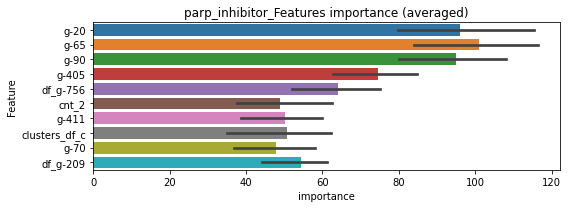

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209489	valid_1's binary_logloss: 0.0484906
[200]	training's binary_logloss: 0.00376308	valid_1's binary_logloss: 0.0252217
[300]	training's binary_logloss: 0.00112372	valid_1's binary_logloss: 0.0201997
[400]	training's binary_logloss: 0.00053328	valid_1's binary_logloss: 0.0194112
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000556867	valid_1's binary_logloss: 0.0193702


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215011	valid_1's binary_logloss: 0.0507868
[200]	training's binary_logloss: 0.003773	valid_1's binary_logloss: 0.0262043
[300]	training's binary_logloss: 0.00109574	valid_1's binary_logloss: 0.0214178
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00081966	valid_1's binary_logloss: 0.0204414


parp_inhibitor logloss: 0.019905785644904
pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179


neg labels: 3289 → selected neg labels: 3268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536559	valid_1's binary_logloss: 0.137953
[200]	training's binary_logloss: 0.0119182	valid_1's binary_logloss: 0.0975144
[300]	training's binary_logloss: 0.00384724	valid_1's binary_logloss: 0.0869528
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00207681	valid_1's binary_logloss: 0.0838257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527486	valid_1's binary_logloss: 0.134947
[200]	training's binary_logloss: 0.0114732	valid_1's binary_logloss: 0.0985056
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00497475	valid_1's binary_logloss: 0.0915748


1 / 3 AUC score:0.990
y_Threshold: 0.0428189, Threshold: 0.2245727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 629/3741
p_label_rate: 0.0200904 Vs.target_rate: 0.01247, Num_p_label: 80.0, conf_0:0.20212, conf_1:0.24703
threshold: 0.2245727, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 629.0/3741, y_label_rate: 0.1681369
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463373	valid_1's binary_logloss: 0.110339
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.011593	valid_1's binary_logloss: 0.0735893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460349	valid_1's binary_logloss: 0.0996848
[200]	training's binary_logloss: 0.008723	valid_1's binary_logloss: 0.0597364
[300]	training's binary_logloss: 0.00259398	valid_1's binary_logloss: 0.0512797
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00199328	valid_1's binary_logloss: 0.0504391


2 / 3 AUC score:0.996
y_Threshold: 0.1231658, Threshold: 0.2245727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 599.0/3681
p_label_rate: 0.0336514 Vs.target_rate: 0.01247, Num_p_label: 134.0, conf_0:0.20212, conf_1:0.24703
threshold: 0.2245727, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 599.0/3681, y_label_rate: 0.1627275
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396626	valid_1's binary_logloss: 0.0910894
[200]	training's binary_logloss: 0.00708285	valid_1's binary_logloss: 0.0533113
[300]	training's binary_logloss: 0.00203231	valid_1's binary_logloss: 0.0439371
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00117418	valid_1's binary_logloss: 0.0420905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403242	valid_1's binary_logloss: 0.0869638
[200]	training's binary_logloss: 0.00706379	valid_1's binary_logloss: 0.0507585


3 / 3 AUC score:0.994
y_Threshold: 0.1384878, Threshold: 0.2245727, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00279856	valid_1's binary_logloss: 0.04292


Remove_noisy_labels: 30 → Positive_corect_labels: 584.0/3651
p_label_rate: 0.0414365 Vs.target_rate: 0.01247, Num_p_label: 165.0, conf_0:0.20212, conf_1:0.24703
Num_p_label: 165.0, Expected: 49.7, Adj_threshold_1: 0.2245727
Num_p_label: 159.0, Expected: 49.7, Adj_threshold_2: 0.2345727
Num_p_label: 152.0, Expected: 49.7, Adj_threshold_3: 0.2445727
Num_p_label: 151.0, Expected: 49.7, Adj_threshold_4: 0.2545727
Num_p_label: 149.0, Expected: 49.7, Adj_threshold_5: 0.2645727
Num_p_label: 147.0, Expected: 49.7, Adj_threshold_6: 0.2745727
Num_p_label: 144.0, Expected: 49.7, Adj_threshold_7: 0.2845727
Num_p_label: 139.0, Expected: 49.7, Adj_threshold_8: 0.2945727
Num_p_label: 136.0, Expected: 49.7, Adj_threshold_9: 0.3045727
Num_p_label: 132.0, Expected: 49.7, Adj_threshold_10: 0.3145727
threshold: 0.3245727, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 713.0/7633, y_label_rate: 0.0934102


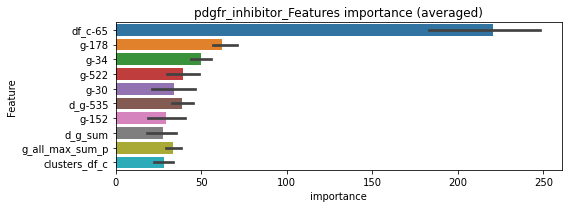

len(train_index) : 3816
len(valid_index) : 3817
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267999	valid_1's binary_logloss: 0.0676418
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00942444	valid_1's binary_logloss: 0.0440751


len(train_index) : 3817
len(valid_index) : 3816
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026985	valid_1's binary_logloss: 0.0659412
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00984699	valid_1's binary_logloss: 0.0444804


pdgfr_inhibitor logloss: 0.04427773720574343
pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246011	valid_1's binary_logloss: 0.0303998
[200]	training's binary_logloss: 0.00290311	valid_1's binary_logloss: 0.00467899
[300]	training's binary_logloss: 0.000813393	valid_1's binary_logloss: 0.00158849
[400]	training's binary_logloss: 0.000437174	valid_1's binary_logloss: 0.000944869
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000347815	valid_1's binary_logloss: 0.000792793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243512	valid_1's binary_logloss: 0.0318843
[200]	training's binary_logloss: 0.00290594	valid_1's binary_logloss: 0.005897
[300]	training's binary_logloss: 0.000808456	valid_1's binary_logloss: 0.00244996
[400]	training's binary_logloss: 0.000426722	valid_1's binary_logloss: 0.0016566
[500]	training's binary_logloss: 0.000338189	valid_1's binary_logloss: 0.00145367
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0014269, Threshold: 0.0023433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00211, conf_1:0.00258
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023433
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0123433
threshold: 0.0123433, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236699	valid_1's binary_logloss: 0.0291932
[200]	training's binary_logloss: 0.00273607	valid_1's binary_logloss: 0.00441052
[300]	training's binary_logloss: 0.000783588	valid_1's binary_logloss: 0.00152639
[400]	training's binary_logloss: 0.000418302	valid_1's binary_logloss: 0.000930097
[500]	training's binary_logloss: 0.000341251	valid_1's binary_logloss: 0.000802869
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000340186	valid_1's binary_logloss: 0.00080144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241749	valid_1's binary_logloss: 0.0309855
[200]	training's binary_logloss: 0.00280612	valid_1's binary_logloss: 0.00521815
[300]	training's binary_logloss: 0.000805104	valid_1's binary_logloss: 0.002057
[400]	training's binary_logloss: 0.000433752	valid_1's binary_logloss: 0.00129423
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1193547, Threshold: 0.0123433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.01111, conf_1:0.01358
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0123433
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0223433
threshold: 0.0223433, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236699	valid_1's binary_logloss: 0.0291932
[200]	training's binary_logloss: 0.00273607	valid_1's binary_logloss: 0.00441052
[300]	training's binary_logloss: 0.000783588	valid_1's binary_logloss: 0.00152639
[400]	training's binary_logloss: 0.000418302	valid_1's binary_logloss: 0.000930097
[500]	training's binary_logloss: 0.000341251	valid_1's binary_logloss: 0.000802869
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000340186	valid_1's binary_logloss: 0.00080144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241749	valid_1's binary_logloss: 0.0309855
[200]	training's binary_logloss: 0.00280612	valid_1's binary_logloss: 0.00521815
[300]	training's binary_logloss: 0.000805104	valid_1's binary_logloss: 0.002057
[400]	training's binary_logloss: 0.000433752	valid_1's binary_logloss: 0.00129423
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1193547, Threshold: 0.0223433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.02011, conf_1:0.02458
threshold: 0.0223433, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


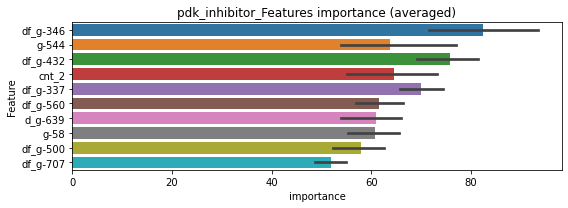

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131032	valid_1's binary_logloss: 0.0197797
[200]	training's binary_logloss: 0.00154089	valid_1's binary_logloss: 0.00677896
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000514513	valid_1's binary_logloss: 0.00592932


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01391	valid_1's binary_logloss: 0.0207477
[200]	training's binary_logloss: 0.00165384	valid_1's binary_logloss: 0.00647641
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000554664	valid_1's binary_logloss: 0.00437115


pdk_inhibitor logloss: 0.00515033386286972
phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107582	valid_1's binary_logloss: 0.289991
[200]	training's binary_logloss: 0.0369788	valid_1's binary_logloss: 0.267129
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0338372	valid_1's binary_logloss: 0.266301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119088	valid_1's binary_logloss: 0.280608
[200]	training's binary_logloss: 0.0434333	valid_1's binary_logloss: 0.240632
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0311594	valid_1's binary_logloss: 0.237352


1 / 3 AUC score:0.911
y_Threshold: 0.0909771, Threshold: 0.1279494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 425 → Positive_corect_labels: 501/3466
p_label_rate: 0.0200904 Vs.target_rate: 0.01109, Num_p_label: 80.0, conf_0:0.11515, conf_1:0.14074
threshold: 0.1279494, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 501.0/3466, y_label_rate: 0.1445470
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845845	valid_1's binary_logloss: 0.225821
[200]	training's binary_logloss: 0.0248652	valid_1's binary_logloss: 0.188767
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0145025	valid_1's binary_logloss: 0.183636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788717	valid_1's binary_logloss: 0.226471
[200]	training's binary_logloss: 0.0238974	valid_1's binary_logloss: 0.197771


2 / 3 AUC score:0.956
y_Threshold: 0.0843801, Threshold: 0.1279494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 415.0/3294
p_label_rate: 0.0102963 Vs.target_rate: 0.01109, Num_p_label: 41.0, conf_0:0.11515, conf_1:0.14074
threshold: 0.1279494, positive_p_label: 41.0/3982, p_label_rate: 0.0102963


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0221462	valid_1's binary_logloss: 0.195876


positive_y_label: 415.0/3294, y_label_rate: 0.1259866
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642142	valid_1's binary_logloss: 0.175179
[200]	training's binary_logloss: 0.0171266	valid_1's binary_logloss: 0.133697
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0113461	valid_1's binary_logloss: 0.128959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613325	valid_1's binary_logloss: 0.171849
[200]	training's binary_logloss: 0.0165313	valid_1's binary_logloss: 0.134348
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00689447	valid_1's binary_logloss: 0.125701


3 / 3 AUC score:0.983
y_Threshold: 0.0747819, Threshold: 0.1279494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 374.0/3212
p_label_rate: 0.0077850 Vs.target_rate: 0.01109, Num_p_label: 31.0, conf_0:0.11515, conf_1:0.14074
threshold: 0.1279494, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 405.0/7194, y_label_rate: 0.0562969


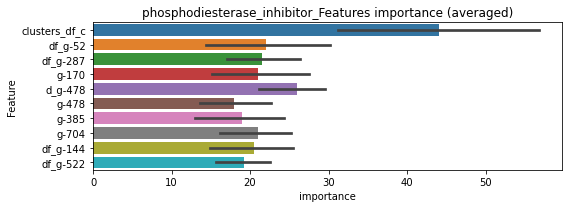

len(train_index) : 3597
len(valid_index) : 3597
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284583	valid_1's binary_logloss: 0.110783
[200]	training's binary_logloss: 0.007418	valid_1's binary_logloss: 0.100418
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.007418	valid_1's binary_logloss: 0.100418


len(train_index) : 3597
len(valid_index) : 3597
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330974	valid_1's binary_logloss: 0.114263
[200]	training's binary_logloss: 0.00895592	valid_1's binary_logloss: 0.0997749
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00680077	valid_1's binary_logloss: 0.0984969


phosphodiesterase_inhibitor logloss: 0.09945740721490615
phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300384	valid_1's binary_logloss: 0.0456591
[200]	training's binary_logloss: 0.00405899	valid_1's binary_logloss: 0.0114164
[300]	training's binary_logloss: 0.0011435	valid_1's binary_logloss: 0.0058317
[400]	training's binary_logloss: 0.000577944	valid_1's binary_logloss: 0.00441916
[500]	training's binary_logloss: 0.000413735	valid_1's binary_logloss: 0.00401089
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00041312	valid_1's binary_logloss: 0.00401024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031331	valid_1's binary_logloss: 0.0475327
[200]	training's binary_logloss: 0.00442264	valid_1's binary_logloss: 0.0100189
[300]	training's binary_logloss: 0.00123502	valid_1's binary_logloss: 0.00383411
[400]	training's binary_logloss: 0.000614136	valid_1's binary_logloss: 0.00236694
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0024588, Threshold: 0.0040423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00364, conf_1:0.00445
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0040423
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_2: 0.0140423
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0240423
threshold: 0.0240423, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298754	valid_1's binary_logloss: 0.0448343
[200]	training's binary_logloss: 0.00392751	valid_1's binary_logloss: 0.0107218
[300]	training's binary_logloss: 0.00112116	valid_1's binary_logloss: 0.0055924
[400]	training's binary_logloss: 0.000570878	valid_1's binary_logloss: 0.00429904
[500]	training's binary_logloss: 0.000408312	valid_1's binary_logloss: 0.00382572
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000408842	valid_1's binary_logloss: 0.00382545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304556	valid_1's binary_logloss: 0.0469206
[200]	training's binary_logloss: 0.00413289	valid_1's binary_logloss: 0.00939925
[300]	training's binary_logloss: 0.0011684	valid_1's binary_logloss: 0.00372086
[400]	training's binary_logloss: 0.000585811	valid_1's binary_logloss: 0.0022376
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0404952, Threshold: 0.0240423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.02164, conf_1:0.02645
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.0240423
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0340423
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0440423
threshold: 0.0440423, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298754	valid_1's binary_logloss: 0.0448343
[200]	training's binary_logloss: 0.00392751	valid_1's binary_logloss: 0.0107218
[300]	training's binary_logloss: 0.00112116	valid_1's binary_logloss: 0.0055924
[400]	training's binary_logloss: 0.000570878	valid_1's binary_logloss: 0.00429904
[500]	training's binary_logloss: 0.000408312	valid_1's binary_logloss: 0.00382572
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000408842	valid_1's binary_logloss: 0.00382545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304556	valid_1's binary_logloss: 0.0469206
[200]	training's binary_logloss: 0.00413289	valid_1's binary_logloss: 0.00939925
[300]	training's binary_logloss: 0.0011684	valid_1's binary_logloss: 0.00372086
[400]	training's binary_logloss: 0.000585811	valid_1's binary_logloss: 0.0022376
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0404952, Threshold: 0.0440423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.03964, conf_1:0.04845
threshold: 0.0440423, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


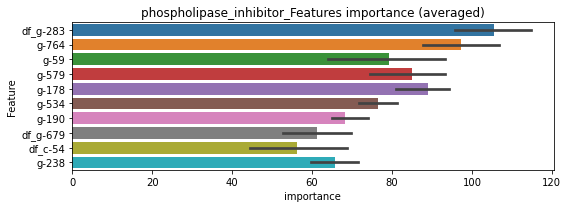

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171275	valid_1's binary_logloss: 0.0243866
[200]	training's binary_logloss: 0.00238137	valid_1's binary_logloss: 0.00798283
[300]	training's binary_logloss: 0.000647367	valid_1's binary_logloss: 0.00605018
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000538236	valid_1's binary_logloss: 0.00596162


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169237	valid_1's binary_logloss: 0.0264745
[200]	training's binary_logloss: 0.00238178	valid_1's binary_logloss: 0.0073915
[300]	training's binary_logloss: 0.000662539	valid_1's binary_logloss: 0.0047355
[400]	training's binary_logloss: 0.000321588	valid_1's binary_logloss: 0.00417522
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000234819	valid_1's binary_logloss: 0.00407821


phospholipase_inhibitor logloss: 0.005019914984398752
pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565078	valid_1's binary_logloss: 0.149646
[200]	training's binary_logloss: 0.0142218	valid_1's binary_logloss: 0.114053
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00534042	valid_1's binary_logloss: 0.109022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566919	valid_1's binary_logloss: 0.148354
[200]	training's binary_logloss: 0.0131974	valid_1's binary_logloss: 0.107523


1 / 3 AUC score:0.984


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00865884	valid_1's binary_logloss: 0.104404


y_Threshold: 0.0383700, Threshold: 0.1784704, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 626/3732
p_label_rate: 0.0200904 Vs.target_rate: 0.00634, Num_p_label: 80.0, conf_0:0.16062, conf_1:0.19632
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1784704
Num_p_label: 77.0, Expected: 25.2, Adj_threshold_2: 0.1884704
Num_p_label: 76.0, Expected: 25.2, Adj_threshold_3: 0.1984704
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_4: 0.2084704
Num_p_label: 71.0, Expected: 25.2, Adj_threshold_5: 0.2184704
Num_p_label: 70.0, Expected: 25.2, Adj_threshold_6: 0.2284704
Num_p_label: 68.0, Expected: 25.2, Adj_threshold_7: 0.2384704
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_8: 0.2484704
Num_p_label: 66.0, Expected: 25.2, Adj_threshold_9: 0.2584704
Num_p_label: 65.0, Expected: 25.2, Adj_threshold_10: 0.2684704
threshold: 0.2784704, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 626.0/3732, y_label_rate: 0.1677385
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462818	valid_1's binary_logloss: 0.123687
[200]	training's binary_logloss: 0.00933225	valid_1's binary_logloss: 0.0868694
[300]	training's binary_logloss: 0.00288282	valid_1's binary_logloss: 0.0781384
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00280405	valid_1's binary_logloss: 0.0777481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499321	valid_1's binary_logloss: 0.128389
[200]	training's binary_logloss: 0.0100936	valid_1's binary_logloss: 0.084802
[300]	training's binary_logloss: 0.00308284	valid_1's binary_logloss: 0.0759262
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00280449	valid_1's binary_logloss: 0.0753567


2 / 3 AUC score:0.993
y_Threshold: 0.0706432, Threshold: 0.2784704, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 590.0/3660
p_label_rate: 0.0318935 Vs.target_rate: 0.00634, Num_p_label: 127.0, conf_0:0.25062, conf_1:0.30632
Num_p_label: 127.0, Expected: 25.2, Adj_threshold_1: 0.2784704
Num_p_label: 125.0, Expected: 25.2, Adj_threshold_2: 0.2884704
Num_p_label: 124.0, Expected: 25.2, Adj_threshold_3: 0.2984704
Num_p_label: 123.0, Expected: 25.2, Adj_threshold_4: 0.3084704
Num_p_label: 118.0, Expected: 25.2, Adj_threshold_5: 0.3184704
Num_p_label: 114.0, Expected: 25.2, Adj_threshold_6: 0.3284704
Num_p_label: 110.0, Expected: 25.2, Adj_threshold_7: 0.3384704
Num_p_label: 109.0, Expected: 25.2, Adj_threshold_8: 0.3484704
Num_p_label: 105.0, Expected: 25.2, Adj_threshold_9: 0.3584704
Num_p_label: 102.0, Expected: 25.2, Adj_threshold_10: 0.3684704
threshold: 0.3784704, positive_p_label: 99.0/3982, p_label_rate: 0.0248619
positive_y_label: 590.0/3660, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422933	valid_1's binary_logloss: 0.104697
[200]	training's binary_logloss: 0.00791396	valid_1's binary_logloss: 0.0641764
[300]	training's binary_logloss: 0.0024493	valid_1's binary_logloss: 0.0542582
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00230335	valid_1's binary_logloss: 0.0540347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410001	valid_1's binary_logloss: 0.107045
[200]	training's binary_logloss: 0.00754942	valid_1's binary_logloss: 0.0729941
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00283033	valid_1's binary_logloss: 0.0676263


3 / 3 AUC score:0.994
y_Threshold: 0.0627291, Threshold: 0.3784704, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 561.0/3602
p_label_rate: 0.0439478 Vs.target_rate: 0.00634, Num_p_label: 175.0, conf_0:0.34062, conf_1:0.41632
Num_p_label: 175.0, Expected: 25.2, Adj_threshold_1: 0.3784704
Num_p_label: 172.0, Expected: 25.2, Adj_threshold_2: 0.3884704
Num_p_label: 171.0, Expected: 25.2, Adj_threshold_3: 0.3984704
Num_p_label: 168.0, Expected: 25.2, Adj_threshold_4: 0.4084704
Num_p_label: 167.0, Expected: 25.2, Adj_threshold_5: 0.4184704
Num_p_label: 167.0, Expected: 25.2, Adj_threshold_6: 0.4284704
Num_p_label: 166.0, Expected: 25.2, Adj_threshold_7: 0.4384704
Num_p_label: 165.0, Expected: 25.2, Adj_threshold_8: 0.4484704
Num_p_label: 163.0, Expected: 25.2, Adj_threshold_9: 0.4584704
Num_p_label: 161.0, Expected: 25.2, Adj_threshold_10: 0.4684704
threshold: 0.4784704, positive_p_label: 160.0/3982, p_label_rate: 0.0401808
positive_y_label: 721.0/7584, y_label_r

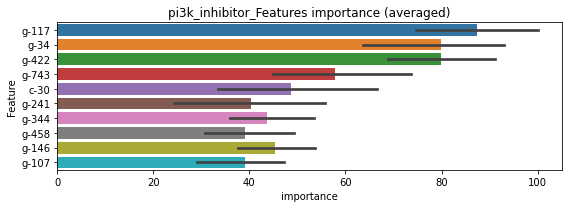

len(train_index) : 3792
len(valid_index) : 3792
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252134	valid_1's binary_logloss: 0.0727013
[200]	training's binary_logloss: 0.00489015	valid_1's binary_logloss: 0.0557782
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00178868	valid_1's binary_logloss: 0.0531961


len(train_index) : 3792
len(valid_index) : 3792
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240226	valid_1's binary_logloss: 0.0707019
[200]	training's binary_logloss: 0.00424723	valid_1's binary_logloss: 0.0501555
[300]	training's binary_logloss: 0.00128309	valid_1's binary_logloss: 0.0446365
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00107961	valid_1's binary_logloss: 0.0437193


pi3k_inhibitor logloss: 0.0484577235212407
pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034807	valid_1's binary_logloss: 0.0520547
[200]	training's binary_logloss: 0.00492725	valid_1's binary_logloss: 0.0140979
[300]	training's binary_logloss: 0.00134432	valid_1's binary_logloss: 0.00701681
[400]	training's binary_logloss: 0.000661512	valid_1's binary_logloss: 0.00513349
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000500445	valid_1's binary_logloss: 0.00452123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330489	valid_1's binary_logloss: 0.0475835
[200]	training's binary_logloss: 0.00472486	valid_1's binary_logloss: 0.0102422
[300]	training's binary_logloss: 0.00132807	valid_1's binary_logloss: 0.00389281
[400]	training's binary_logloss: 0.000654592	valid_1's binary_logloss: 0.00226514
[500]	training's binary_logloss: 0.000451384	valid_1's binary_logloss: 0.00171833
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0032771, Threshold: 0.0051253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00461, conf_1:0.00564
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0051253
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_2: 0.0151253
threshold: 0.0151253, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329508	valid_1's binary_logloss: 0.0493119
[200]	training's binary_logloss: 0.00454275	valid_1's binary_logloss: 0.0126518
[300]	training's binary_logloss: 0.00126763	valid_1's binary_logloss: 0.00599249
[400]	training's binary_logloss: 0.000630111	valid_1's binary_logloss: 0.0042186
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000480992	valid_1's binary_logloss: 0.00372954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333194	valid_1's binary_logloss: 0.044877
[200]	training's binary_logloss: 0.0046645	valid_1's binary_logloss: 0.00880935
[300]	training's binary_logloss: 0.00129412	valid_1's binary_logloss: 0.00316027
[400]	training's binary_logloss: 0.000643656	valid_1's binary_logloss: 0.00179635
[500]	training's binary_logloss: 0.000449898	valid_1's binary_logloss: 0.00137375
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0544139, Threshold: 0.0151253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0090407 Vs.target_rate: 0.00130, Num_p_label: 36.0, conf_0:0.01361, conf_1:0.01664
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_1: 0.0151253
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_2: 0.0251253
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_3: 0.0351253
threshold: 0.0351253, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329508	valid_1's binary_logloss: 0.0493119
[200]	training's binary_logloss: 0.00454275	valid_1's binary_logloss: 0.0126518
[300]	training's binary_logloss: 0.00126763	valid_1's binary_logloss: 0.00599249
[400]	training's binary_logloss: 0.000630111	valid_1's binary_logloss: 0.0042186
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000480992	valid_1's binary_logloss: 0.00372954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333194	valid_1's binary_logloss: 0.044877
[200]	training's binary_logloss: 0.0046645	valid_1's binary_logloss: 0.00880935
[300]	training's binary_logloss: 0.00129412	valid_1's binary_logloss: 0.00316027
[400]	training's binary_logloss: 0.000643656	valid_1's binary_logloss: 0.00179635
[500]	training's binary_logloss: 0.000449898	valid_1's binary_logloss: 0.00137375
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0544139, Threshold: 0.0351253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00130, Num_p_label: 8.0, conf_0:0.03161, conf_1:0.03864
threshold: 0.0351253, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7790, y_label_rate: 0.0852375


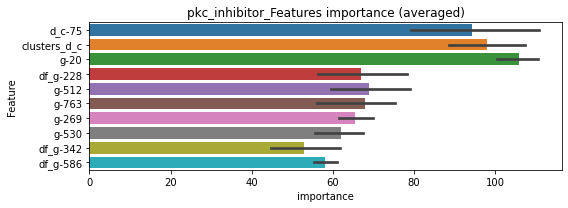

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182903	valid_1's binary_logloss: 0.030465
[200]	training's binary_logloss: 0.0025175	valid_1's binary_logloss: 0.0120445
[300]	training's binary_logloss: 0.0006821	valid_1's binary_logloss: 0.0100708
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0005863	valid_1's binary_logloss: 0.00993839


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189585	valid_1's binary_logloss: 0.026205
[200]	training's binary_logloss: 0.00263512	valid_1's binary_logloss: 0.00721375
[300]	training's binary_logloss: 0.000720892	valid_1's binary_logloss: 0.0042505
[400]	training's binary_logloss: 0.00034582	valid_1's binary_logloss: 0.00360383
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00034582	valid_1's binary_logloss: 0.00360383


pkc_inhibitor logloss: 0.006771107320791727
potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049147	valid_1's binary_logloss: 0.0831974
[200]	training's binary_logloss: 0.00900695	valid_1's binary_logloss: 0.0298231
[300]	training's binary_logloss: 0.00257316	valid_1's binary_logloss: 0.0160119
[400]	training's binary_logloss: 0.00117753	valid_1's binary_logloss: 0.0118134
[500]	training's binary_logloss: 0.000749162	valid_1's binary_logloss: 0.0100739
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000614411	valid_1's binary_logloss: 0.00942757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479045	valid_1's binary_logloss: 0.0925426
[200]	training's binary_logloss: 0.00891826	valid_1's binary_logloss: 0.0471551
[300]	training's binary_logloss: 0.00254441	valid_1's binary_logloss: 0.0373158
[400]	training's binary_logloss: 0.00116232	valid_1's binary_logloss: 0.0350792
Early stopping, best iteration is:
[394]	tr

1 / 3 AUC score:0.999
y_Threshold: 0.0083927, Threshold: 0.0140569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.01265, conf_1:0.01546
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0140569
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_2: 0.0240569
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_3: 0.0340569
Num_p_label: 13.0, Expected: 9.2, Adj_threshold_4: 0.0440569
threshold: 0.0440569, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461358	valid_1's binary_logloss: 0.082291
[200]	training's binary_logloss: 0.00817381	valid_1's binary_logloss: 0.0345146
[300]	training's binary_logloss: 0.00231508	valid_1's binary_logloss: 0.0220764
[400]	training's binary_logloss: 0.0011038	valid_1's binary_logloss: 0.0187792
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0010698	valid_1's binary_logloss: 0.0186675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467694	valid_1's binary_logloss: 0.0820099
[200]	training's binary_logloss: 0.00844485	valid_1's binary_logloss: 0.0315061
[300]	training's binary_logloss: 0.00244825	valid_1's binary_logloss: 0.0203655
[400]	training's binary_logloss: 0.0011515	valid_1's binary_logloss: 0.0170032
[500]	training's binary_logloss: 0.000725483	valid_1's binary_logloss: 0.0158957
Early stopping, best iteration is:
[571]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.0331789, Threshold: 0.0440569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0087896 Vs.target_rate: 0.00231, Num_p_label: 35.0, conf_0:0.03965, conf_1:0.04846
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_1: 0.0440569
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_2: 0.0540569
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_3: 0.0640569
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_4: 0.0740569
threshold: 0.0740569, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477085	valid_1's binary_logloss: 0.0811137
[200]	training's binary_logloss: 0.00836488	valid_1's binary_logloss: 0.0287135
[300]	training's binary_logloss: 0.00238784	valid_1's binary_logloss: 0.0166665
[400]	training's binary_logloss: 0.00112793	valid_1's binary_logloss: 0.0128836
[500]	training's binary_logloss: 0.000715488	valid_1's binary_logloss: 0.0114474
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000684026	valid_1's binary_logloss: 0.0113252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475723	valid_1's binary_logloss: 0.0822648
[200]	training's binary_logloss: 0.00821991	valid_1's binary_logloss: 0.0287278
[300]	training's binary_logloss: 0.00236092	valid_1's binary_logloss: 0.0171869
[400]	training's binary_logloss: 0.00112607	valid_1's binary_logloss: 0.0133567
[500]	training's binary_logloss: 0.00071977

3 / 3 AUC score:1.000
y_Threshold: 0.0419018, Threshold: 0.0740569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0035158 Vs.target_rate: 0.00231, Num_p_label: 14.0, conf_0:0.06665, conf_1:0.08146
threshold: 0.0740569, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 660.0/7766, y_label_rate: 0.0849858


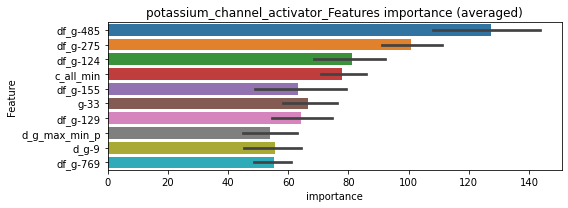

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026292	valid_1's binary_logloss: 0.0496859
[200]	training's binary_logloss: 0.00468159	valid_1's binary_logloss: 0.022191
[300]	training's binary_logloss: 0.00130049	valid_1's binary_logloss: 0.0166245
[400]	training's binary_logloss: 0.000607525	valid_1's binary_logloss: 0.0151865
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000639111	valid_1's binary_logloss: 0.0151034


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268867	valid_1's binary_logloss: 0.0547682
[200]	training's binary_logloss: 0.00479632	valid_1's binary_logloss: 0.0256
[300]	training's binary_logloss: 0.00135675	valid_1's binary_logloss: 0.0199569
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00086339	valid_1's binary_logloss: 0.019361


potassium_channel_activator logloss: 0.017232236909440025
potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672907	valid_1's binary_logloss: 0.141451
[200]	training's binary_logloss: 0.0175271	valid_1's binary_logloss: 0.0912447
[300]	training's binary_logloss: 0.00527185	valid_1's binary_logloss: 0.0743087
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00254834	valid_1's binary_logloss: 0.0692385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669899	valid_1's binary_logloss: 0.139105
[200]	training's binary_logloss: 0.0161177	valid_1's binary_logloss: 0.0885309
[300]	training's binary_logloss: 0.0051238	valid_1's binary_logloss: 0.0773943
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00502956	valid_1's binary_logloss: 0.076911


1 / 3 AUC score:0.995
y_Threshold: 0.0231650, Threshold: 0.0292532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 641/3768
p_label_rate: 0.0200904 Vs.target_rate: 0.00412, Num_p_label: 80.0, conf_0:0.02633, conf_1:0.03218
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0292532
Num_p_label: 34.0, Expected: 16.4, Adj_threshold_2: 0.0392532
Num_p_label: 18.0, Expected: 16.4, Adj_threshold_3: 0.0492532
threshold: 0.0492532, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 641.0/3768, y_label_rate: 0.1701168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600229	valid_1's binary_logloss: 0.129169
[200]	training's binary_logloss: 0.0138667	valid_1's binary_logloss: 0.0749957
[300]	training's binary_logloss: 0.00435439	valid_1's binary_logloss: 0.0596934
[400]	training's binary_logloss: 0.00200502	valid_1's binary_logloss: 0.0532542
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0017733	valid_1's binary_logloss: 0.0528689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666829	valid_1's binary_logloss: 0.148516
[200]	training's binary_logloss: 0.0167836	valid_1's binary_logloss: 0.0942912
[300]	training's binary_logloss: 0.00497319	valid_1's binary_logloss: 0.0765887
[400]	training's binary_logloss: 0.00218805	valid_1's binary_logloss: 0.0725287
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00184987	valid_1's binary_logloss: 0.0719092


2 / 3 AUC score:0.994
y_Threshold: 0.0455763, Threshold: 0.0492532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 625.0/3736
p_label_rate: 0.0067805 Vs.target_rate: 0.00412, Num_p_label: 27.0, conf_0:0.04433, conf_1:0.05418
threshold: 0.0492532, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 625.0/3736, y_label_rate: 0.1672912
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616177	valid_1's binary_logloss: 0.121367
[200]	training's binary_logloss: 0.0145152	valid_1's binary_logloss: 0.0653389
[300]	training's binary_logloss: 0.00440689	valid_1's binary_logloss: 0.0475132
[400]	training's binary_logloss: 0.00197996	valid_1's binary_logloss: 0.0404911
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.001503	valid_1's binary_logloss: 0.0392134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612729	valid_1's binary_logloss: 0.12961
[200]	training's binary_logloss: 0.0137911	valid_1's binary_logloss: 0.0703193
[300]	training's binary_logloss: 0.00431869	valid_1's binary_logloss: 0.0496136
[400]	training's binary_logloss: 0.00195258	valid_1's binary_logloss: 0.0426089
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00183589	valid_1's binary_logloss: 0.0420704


3 / 3 AUC score:1.000
y_Threshold: 0.0426786, Threshold: 0.0492532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 619.0/3724
p_label_rate: 0.0072828 Vs.target_rate: 0.00412, Num_p_label: 29.0, conf_0:0.04433, conf_1:0.05418
threshold: 0.0492532, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 648.0/7706, y_label_rate: 0.0840903


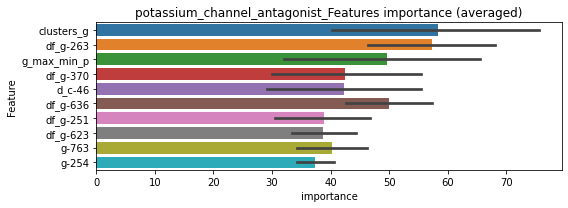

len(train_index) : 3853
len(valid_index) : 3853
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342927	valid_1's binary_logloss: 0.0786569
[200]	training's binary_logloss: 0.00792219	valid_1's binary_logloss: 0.0486567
[300]	training's binary_logloss: 0.00241301	valid_1's binary_logloss: 0.0406881
[400]	training's binary_logloss: 0.00106443	valid_1's binary_logloss: 0.0389339
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00104184	valid_1's binary_logloss: 0.0389244


len(train_index) : 3853
len(valid_index) : 3853
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365162	valid_1's binary_logloss: 0.0775529
[200]	training's binary_logloss: 0.00885706	valid_1's binary_logloss: 0.0504994
[300]	training's binary_logloss: 0.00257899	valid_1's binary_logloss: 0.0440338
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00185985	valid_1's binary_logloss: 0.0431562


potassium_channel_antagonist logloss: 0.04104029808585816
ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575993	valid_1's binary_logloss: 0.140006
[200]	training's binary_logloss: 0.0136752	valid_1's binary_logloss: 0.0940428
[300]	training's binary_logloss: 0.00426517	valid_1's binary_logloss: 0.0801247
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00310775	valid_1's binary_logloss: 0.0780962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579867	valid_1's binary_logloss: 0.133392
[200]	training's binary_logloss: 0.013858	valid_1's binary_logloss: 0.0832378
[300]	training's binary_logloss: 0.00443983	valid_1's binary_logloss: 0.0700328
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00321817	valid_1's binary_logloss: 0.068098


1 / 3 AUC score:0.994
y_Threshold: 0.0223818, Threshold: 0.1267156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 638/3760
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.11404, conf_1:0.13939
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.1267156
Num_p_label: 76.0, Expected: 19.2, Adj_threshold_2: 0.1367156
Num_p_label: 70.0, Expected: 19.2, Adj_threshold_3: 0.1467156
Num_p_label: 63.0, Expected: 19.2, Adj_threshold_4: 0.1567156
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_5: 0.1667156
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_6: 0.1767156
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_7: 0.1867156
Num_p_label: 57.0, Expected: 19.2, Adj_threshold_8: 0.1967156
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_9: 0.2067156
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_10: 0.2167156
threshold: 0.2267156, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 638.0/3760, y_label_rate: 0.169680

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530009	valid_1's binary_logloss: 0.120566
[200]	training's binary_logloss: 0.011609	valid_1's binary_logloss: 0.0715781
[300]	training's binary_logloss: 0.00370375	valid_1's binary_logloss: 0.0582053
[400]	training's binary_logloss: 0.00176265	valid_1's binary_logloss: 0.0534849
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00172077	valid_1's binary_logloss: 0.053373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537707	valid_1's binary_logloss: 0.116276
[200]	training's binary_logloss: 0.0120669	valid_1's binary_logloss: 0.0675782
[300]	training's binary_logloss: 0.00390962	valid_1's binary_logloss: 0.0539934
[400]	training's binary_logloss: 0.00185264	valid_1's binary_logloss: 0.0487088
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00141407	valid_1's binary_logloss: 0.0473867


2 / 3 AUC score:0.996
y_Threshold: 0.0528065, Threshold: 0.2267156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 623.0/3730
p_label_rate: 0.0241085 Vs.target_rate: 0.00483, Num_p_label: 96.0, conf_0:0.20404, conf_1:0.24939
Num_p_label: 96.0, Expected: 19.2, Adj_threshold_1: 0.2267156
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_2: 0.2367156
Num_p_label: 92.0, Expected: 19.2, Adj_threshold_3: 0.2467156
Num_p_label: 88.0, Expected: 19.2, Adj_threshold_4: 0.2567156
Num_p_label: 86.0, Expected: 19.2, Adj_threshold_5: 0.2667156
Num_p_label: 82.0, Expected: 19.2, Adj_threshold_6: 0.2767156
Num_p_label: 81.0, Expected: 19.2, Adj_threshold_7: 0.2867156
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_8: 0.2967156
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_9: 0.3067156
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_10: 0.3167156
threshold: 0.3267156, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 623.0/3730, y_label_rate: 0.16702

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497565	valid_1's binary_logloss: 0.12399
[200]	training's binary_logloss: 0.0103839	valid_1's binary_logloss: 0.0785421
[300]	training's binary_logloss: 0.00331897	valid_1's binary_logloss: 0.0692263
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00188516	valid_1's binary_logloss: 0.0655971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505012	valid_1's binary_logloss: 0.115793
[200]	training's binary_logloss: 0.0110155	valid_1's binary_logloss: 0.0695257
[300]	training's binary_logloss: 0.00353727	valid_1's binary_logloss: 0.0553827
[400]	training's binary_logloss: 0.00168814	valid_1's binary_logloss: 0.0520144
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00163813	valid_1's binary_logloss: 0.0517162


3 / 3 AUC score:0.997
y_Threshold: 0.0513868, Threshold: 0.3267156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 605.0/3694
p_label_rate: 0.0258664 Vs.target_rate: 0.00483, Num_p_label: 103.0, conf_0:0.29404, conf_1:0.35939
Num_p_label: 103.0, Expected: 19.2, Adj_threshold_1: 0.3267156
Num_p_label: 101.0, Expected: 19.2, Adj_threshold_2: 0.3367156
Num_p_label: 100.0, Expected: 19.2, Adj_threshold_3: 0.3467156
Num_p_label: 99.0, Expected: 19.2, Adj_threshold_4: 0.3567156
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_5: 0.3667156
Num_p_label: 96.0, Expected: 19.2, Adj_threshold_6: 0.3767156
Num_p_label: 92.0, Expected: 19.2, Adj_threshold_7: 0.3867156
Num_p_label: 91.0, Expected: 19.2, Adj_threshold_8: 0.3967156
Num_p_label: 89.0, Expected: 19.2, Adj_threshold_9: 0.4067156
Num_p_label: 87.0, Expected: 19.2, Adj_threshold_10: 0.4167156
threshold: 0.4267156, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 691.0/7676, y_label_rate: 0.0

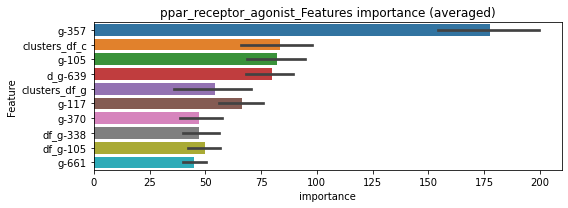

len(train_index) : 3838
len(valid_index) : 3838
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302804	valid_1's binary_logloss: 0.0756296
[200]	training's binary_logloss: 0.00624871	valid_1's binary_logloss: 0.0466076
[300]	training's binary_logloss: 0.00197456	valid_1's binary_logloss: 0.0402251
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000997413	valid_1's binary_logloss: 0.038146


len(train_index) : 3838
len(valid_index) : 3838
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300863	valid_1's binary_logloss: 0.0701024
[200]	training's binary_logloss: 0.00639772	valid_1's binary_logloss: 0.0431855
[300]	training's binary_logloss: 0.00201241	valid_1's binary_logloss: 0.0374054
[400]	training's binary_logloss: 0.000954865	valid_1's binary_logloss: 0.0356345
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000745056	valid_1's binary_logloss: 0.035193


ppar_receptor_agonist logloss: 0.03666948161022461
ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329916	valid_1's binary_logloss: 0.050571
[200]	training's binary_logloss: 0.00467771	valid_1's binary_logloss: 0.0117728
[300]	training's binary_logloss: 0.00132771	valid_1's binary_logloss: 0.00490818
[400]	training's binary_logloss: 0.00065251	valid_1's binary_logloss: 0.00308579
[500]	training's binary_logloss: 0.000448179	valid_1's binary_logloss: 0.00247242
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.000414287	valid_1's binary_logloss: 0.00239096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311141	valid_1's binary_logloss: 0.05725
[200]	training's binary_logloss: 0.00440282	valid_1's binary_logloss: 0.0204509
[300]	training's binary_logloss: 0.00125384	valid_1's binary_logloss: 0.0130696
[400]	training's binary_logloss: 0.000630905	valid_1's binary_logloss: 0.0107408
Early stopping, best iteration is:
[418]	

1 / 3 AUC score:1.000
y_Threshold: 0.0034648, Threshold: 0.0051556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00464, conf_1:0.00567
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0051556
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.0151556
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_3: 0.0251556
threshold: 0.0251556, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330347	valid_1's binary_logloss: 0.0486283
[200]	training's binary_logloss: 0.00458888	valid_1's binary_logloss: 0.0107494
[300]	training's binary_logloss: 0.00129558	valid_1's binary_logloss: 0.00450509
[400]	training's binary_logloss: 0.000639275	valid_1's binary_logloss: 0.00286764
[500]	training's binary_logloss: 0.000438896	valid_1's binary_logloss: 0.00223646
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00041758	valid_1's binary_logloss: 0.00218643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03214	valid_1's binary_logloss: 0.0547064
[200]	training's binary_logloss: 0.00459852	valid_1's binary_logloss: 0.0170414
[300]	training's binary_logloss: 0.00127333	valid_1's binary_logloss: 0.00991322
[400]	training's binary_logloss: 0.000631358	valid_1's binary_logloss: 0.0080229
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.0128082, Threshold: 0.0251556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0012557 Vs.target_rate: 0.00126, Num_p_label: 5.0, conf_0:0.02264, conf_1:0.02767
threshold: 0.0251556, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319624	valid_1's binary_logloss: 0.0485842
[200]	training's binary_logloss: 0.00450598	valid_1's binary_logloss: 0.0137151
[300]	training's binary_logloss: 0.00128823	valid_1's binary_logloss: 0.0077904
[400]	training's binary_logloss: 0.000637012	valid_1's binary_logloss: 0.00621644
[500]	training's binary_logloss: 0.000439854	valid_1's binary_logloss: 0.00568721
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000426473	valid_1's binary_logloss: 0.00561654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323415	valid_1's binary_logloss: 0.0522193
[200]	training's binary_logloss: 0.00456476	valid_1's binary_logloss: 0.0154064
[300]	training's binary_logloss: 0.00128743	valid_1's binary_logloss: 0.00831299
[400]	training's binary_logloss: 0.000634236	valid_1's binary_logloss: 0.00658934
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0347754, Threshold: 0.0251556, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00126, Num_p_label: 18.0, conf_0:0.02264, conf_1:0.02767
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.0251556
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_2: 0.0351556
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_3: 0.0451556
threshold: 0.0451556, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


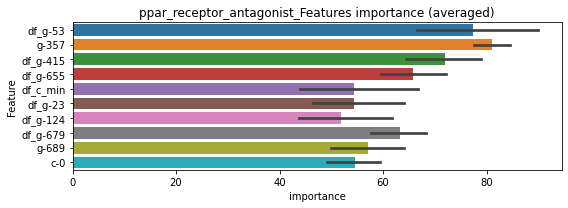

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182326	valid_1's binary_logloss: 0.0315514
[200]	training's binary_logloss: 0.00261929	valid_1's binary_logloss: 0.0124026
[300]	training's binary_logloss: 0.000703993	valid_1's binary_logloss: 0.00931798
[400]	training's binary_logloss: 0.000340551	valid_1's binary_logloss: 0.00886201
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000359733	valid_1's binary_logloss: 0.00884637


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018601	valid_1's binary_logloss: 0.0293809
[200]	training's binary_logloss: 0.00269431	valid_1's binary_logloss: 0.0092222
[300]	training's binary_logloss: 0.000729555	valid_1's binary_logloss: 0.00573163
[400]	training's binary_logloss: 0.00035086	valid_1's binary_logloss: 0.00476137
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000260871	valid_1's binary_logloss: 0.00454048


ppar_receptor_antagonist logloss: 0.00669342502458276
progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746118	valid_1's binary_logloss: 0.180236
[200]	training's binary_logloss: 0.0192662	valid_1's binary_logloss: 0.135713
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00779672	valid_1's binary_logloss: 0.12704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726018	valid_1's binary_logloss: 0.157496
[200]	training's binary_logloss: 0.0192748	valid_1's binary_logloss: 0.106149
[300]	training's binary_logloss: 0.00645254	valid_1's binary_logloss: 0.0921004
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00341358	valid_1's binary_logloss: 0.0888194


1 / 3 AUC score:0.980
y_Threshold: 0.0345101, Threshold: 0.0526425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 209 → Positive_corect_labels: 615/3716
p_label_rate: 0.0200904 Vs.target_rate: 0.00500, Num_p_label: 80.0, conf_0:0.04738, conf_1:0.05791
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0526425
Num_p_label: 53.0, Expected: 19.9, Adj_threshold_2: 0.0626425
Num_p_label: 34.0, Expected: 19.9, Adj_threshold_3: 0.0726425
threshold: 0.0726425, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 615.0/3716, y_label_rate: 0.1655005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641541	valid_1's binary_logloss: 0.150099
[200]	training's binary_logloss: 0.0148065	valid_1's binary_logloss: 0.0936275
[300]	training's binary_logloss: 0.00464152	valid_1's binary_logloss: 0.0769776
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00353896	valid_1's binary_logloss: 0.0754724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662358	valid_1's binary_logloss: 0.150792
[200]	training's binary_logloss: 0.0155691	valid_1's binary_logloss: 0.0975278
[300]	training's binary_logloss: 0.00482089	valid_1's binary_logloss: 0.0822301
[400]	training's binary_logloss: 0.00216224	valid_1's binary_logloss: 0.0760542
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00216224	valid_1's binary_logloss: 0.0760542


2 / 3 AUC score:0.996
y_Threshold: 0.0497058, Threshold: 0.0726425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 594.0/3674
p_label_rate: 0.0105475 Vs.target_rate: 0.00500, Num_p_label: 42.0, conf_0:0.06538, conf_1:0.07991
threshold: 0.0726425, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 594.0/3674, y_label_rate: 0.1616766
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635583	valid_1's binary_logloss: 0.136623
[200]	training's binary_logloss: 0.0150444	valid_1's binary_logloss: 0.0777397
[300]	training's binary_logloss: 0.0046622	valid_1's binary_logloss: 0.0599986
[400]	training's binary_logloss: 0.00209391	valid_1's binary_logloss: 0.0531145
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00151159	valid_1's binary_logloss: 0.0511717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595361	valid_1's binary_logloss: 0.13684
[200]	training's binary_logloss: 0.0134937	valid_1's binary_logloss: 0.0815104
[300]	training's binary_logloss: 0.00406781	valid_1's binary_logloss: 0.0657664
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00265471	valid_1's binary_logloss: 0.0629811


3 / 3 AUC score:0.999
y_Threshold: 0.0735606, Threshold: 0.0726425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 576.0/3638
p_label_rate: 0.0087896 Vs.target_rate: 0.00500, Num_p_label: 35.0, conf_0:0.06538, conf_1:0.07991
threshold: 0.0726425, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 611.0/7620, y_label_rate: 0.0801837


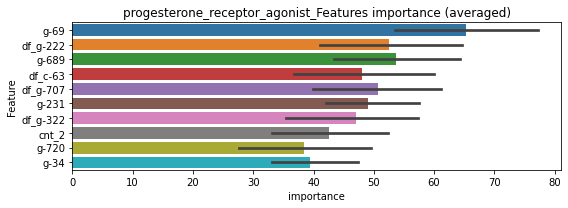

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361274	valid_1's binary_logloss: 0.0892685
[200]	training's binary_logloss: 0.008453	valid_1's binary_logloss: 0.0610518
[300]	training's binary_logloss: 0.0025941	valid_1's binary_logloss: 0.0540297
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00153142	valid_1's binary_logloss: 0.0528747


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366384	valid_1's binary_logloss: 0.0835228
[200]	training's binary_logloss: 0.0088306	valid_1's binary_logloss: 0.0523894
[300]	training's binary_logloss: 0.00265981	valid_1's binary_logloss: 0.0444879
[400]	training's binary_logloss: 0.00114671	valid_1's binary_logloss: 0.0417451
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0011245	valid_1's binary_logloss: 0.0416603


progesterone_receptor_agonist logloss: 0.04726751444785525
progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225124	valid_1's binary_logloss: 0.0292729
[200]	training's binary_logloss: 0.00257537	valid_1's binary_logloss: 0.00456328
[300]	training's binary_logloss: 0.000719452	valid_1's binary_logloss: 0.0016498
[400]	training's binary_logloss: 0.000384767	valid_1's binary_logloss: 0.000996039
[500]	training's binary_logloss: 0.000308301	valid_1's binary_logloss: 0.000847434
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000304969	valid_1's binary_logloss: 0.000841131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230935	valid_1's binary_logloss: 0.0293423
[200]	training's binary_logloss: 0.00268581	valid_1's binary_logloss: 0.00452842
[300]	training's binary_logloss: 0.00073902	valid_1's binary_logloss: 0.00150482
[400]	training's binary_logloss: 0.000392684	valid_1's binary_logloss: 0.000885087
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0014564, Threshold: 0.0024254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00218, conf_1:0.00267
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024254
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0124254
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0224254
threshold: 0.0224254, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227353	valid_1's binary_logloss: 0.0283562
[200]	training's binary_logloss: 0.00258248	valid_1's binary_logloss: 0.00408438
[300]	training's binary_logloss: 0.000717368	valid_1's binary_logloss: 0.00135607
[400]	training's binary_logloss: 0.000382569	valid_1's binary_logloss: 0.000797615
[500]	training's binary_logloss: 0.0003086	valid_1's binary_logloss: 0.000675608
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000304266	valid_1's binary_logloss: 0.000670095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023078	valid_1's binary_logloss: 0.0297895
[200]	training's binary_logloss: 0.00259689	valid_1's binary_logloss: 0.00436525
[300]	training's binary_logloss: 0.000726321	valid_1's binary_logloss: 0.00139648
[400]	training's binary_logloss: 0.000383749	valid_1's binary_logloss: 0.000808127
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1463944, Threshold: 0.0224254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.02018, conf_1:0.02467
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0224254
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0324254
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0424254
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0524254
threshold: 0.0524254, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227353	valid_1's binary_logloss: 0.0283562
[200]	training's binary_logloss: 0.00258248	valid_1's binary_logloss: 0.00408438
[300]	training's binary_logloss: 0.000717368	valid_1's binary_logloss: 0.00135607
[400]	training's binary_logloss: 0.000382569	valid_1's binary_logloss: 0.000797615
[500]	training's binary_logloss: 0.0003086	valid_1's binary_logloss: 0.000675608
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000304266	valid_1's binary_logloss: 0.000670095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023078	valid_1's binary_logloss: 0.0297895
[200]	training's binary_logloss: 0.00259689	valid_1's binary_logloss: 0.00436525
[300]	training's binary_logloss: 0.000726321	valid_1's binary_logloss: 0.00139648
[400]	training's binary_logloss: 0.000383749	valid_1's binary_logloss: 0.000808127
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1463944, Threshold: 0.0524254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04718, conf_1:0.05767
threshold: 0.0524254, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


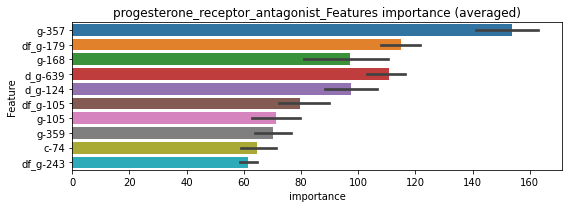

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121601	valid_1's binary_logloss: 0.0199019
[200]	training's binary_logloss: 0.00134626	valid_1's binary_logloss: 0.00740545
[300]	training's binary_logloss: 0.000362704	valid_1's binary_logloss: 0.00625006
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000376385	valid_1's binary_logloss: 0.00623475


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124423	valid_1's binary_logloss: 0.0184136
[200]	training's binary_logloss: 0.00139386	valid_1's binary_logloss: 0.00496171
[300]	training's binary_logloss: 0.000389917	valid_1's binary_logloss: 0.0031067
[400]	training's binary_logloss: 0.000201599	valid_1's binary_logloss: 0.00264516
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000170726	valid_1's binary_logloss: 0.00257463


progesterone_receptor_antagonist logloss: 0.00440492701926609
prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389383	valid_1's binary_logloss: 0.0617872
[200]	training's binary_logloss: 0.00620473	valid_1's binary_logloss: 0.0183578
[300]	training's binary_logloss: 0.00169872	valid_1's binary_logloss: 0.00907731
[400]	training's binary_logloss: 0.000802644	valid_1's binary_logloss: 0.00624353
[500]	training's binary_logloss: 0.000520936	valid_1's binary_logloss: 0.00499944
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000471368	valid_1's binary_logloss: 0.00484283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402354	valid_1's binary_logloss: 0.0648015
[200]	training's binary_logloss: 0.00655544	valid_1's binary_logloss: 0.019243
[300]	training's binary_logloss: 0.0017871	valid_1's binary_logloss: 0.00907104
[400]	training's binary_logloss: 0.000850354	valid_1's binary_logloss: 0.00635703
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0043116, Threshold: 0.0068828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00619, conf_1:0.00757
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0068828
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0168828
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_3: 0.0268828
threshold: 0.0268828, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384824	valid_1's binary_logloss: 0.0614847
[200]	training's binary_logloss: 0.00591976	valid_1's binary_logloss: 0.0176797
[300]	training's binary_logloss: 0.00165097	valid_1's binary_logloss: 0.00841225
[400]	training's binary_logloss: 0.000801349	valid_1's binary_logloss: 0.00611938
[500]	training's binary_logloss: 0.000526662	valid_1's binary_logloss: 0.0049127
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000463764	valid_1's binary_logloss: 0.00460985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387506	valid_1's binary_logloss: 0.0606019
[200]	training's binary_logloss: 0.00614907	valid_1's binary_logloss: 0.0163936
[300]	training's binary_logloss: 0.00169965	valid_1's binary_logloss: 0.00842655
[400]	training's binary_logloss: 0.000809862	valid_1's binary_logloss: 0.00601135
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0931914, Threshold: 0.0268828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.02419, conf_1:0.02957
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0268828
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0368828
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.0468828
threshold: 0.0468828, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384824	valid_1's binary_logloss: 0.0614847
[200]	training's binary_logloss: 0.00591976	valid_1's binary_logloss: 0.0176797
[300]	training's binary_logloss: 0.00165097	valid_1's binary_logloss: 0.00841225
[400]	training's binary_logloss: 0.000801349	valid_1's binary_logloss: 0.00611938
[500]	training's binary_logloss: 0.000526662	valid_1's binary_logloss: 0.0049127
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000463764	valid_1's binary_logloss: 0.00460985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387506	valid_1's binary_logloss: 0.0606019
[200]	training's binary_logloss: 0.00614907	valid_1's binary_logloss: 0.0163936
[300]	training's binary_logloss: 0.00169965	valid_1's binary_logloss: 0.00842655
[400]	training's binary_logloss: 0.000809862	valid_1's binary_logloss: 0.00601135
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0931914, Threshold: 0.0468828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0022602 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.04219, conf_1:0.05157
threshold: 0.0468828, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7789, y_label_rate: 0.0853768


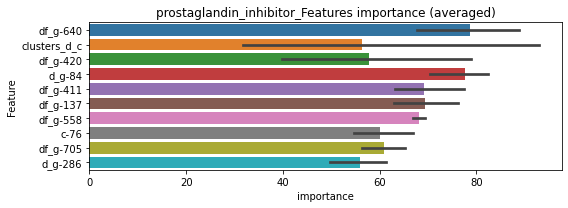

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213567	valid_1's binary_logloss: 0.039377
[200]	training's binary_logloss: 0.00338658	valid_1's binary_logloss: 0.0159725
[300]	training's binary_logloss: 0.00090815	valid_1's binary_logloss: 0.0114197
[400]	training's binary_logloss: 0.000427241	valid_1's binary_logloss: 0.0104788
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000408953	valid_1's binary_logloss: 0.0104608


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212988	valid_1's binary_logloss: 0.0314785
[200]	training's binary_logloss: 0.00331481	valid_1's binary_logloss: 0.00968896
[300]	training's binary_logloss: 0.000926691	valid_1's binary_logloss: 0.00607621
[400]	training's binary_logloss: 0.000441034	valid_1's binary_logloss: 0.0053022
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000350803	valid_1's binary_logloss: 0.00512639


prostaglandin_inhibitor logloss: 0.007793941930137014
prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620912	valid_1's binary_logloss: 0.123105
[200]	training's binary_logloss: 0.014967	valid_1's binary_logloss: 0.0720635
[300]	training's binary_logloss: 0.0045286	valid_1's binary_logloss: 0.0594097
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00280822	valid_1's binary_logloss: 0.0573665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626996	valid_1's binary_logloss: 0.125486
[200]	training's binary_logloss: 0.0151034	valid_1's binary_logloss: 0.0699911
[300]	training's binary_logloss: 0.00460225	valid_1's binary_logloss: 0.0554464
[400]	training's binary_logloss: 0.00203986	valid_1's binary_logloss: 0.0508512
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00206593	valid_1's binary_logloss: 0.0508433


1 / 3 AUC score:0.996
y_Threshold: 0.0160730, Threshold: 0.0218885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 642/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.00353, Num_p_label: 80.0, conf_0:0.01970, conf_1:0.02408
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0218885
Num_p_label: 34.0, Expected: 14.0, Adj_threshold_2: 0.0318885
Num_p_label: 19.0, Expected: 14.0, Adj_threshold_3: 0.0418885
threshold: 0.0418885, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 642.0/3772, y_label_rate: 0.1702015
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591749	valid_1's binary_logloss: 0.125816
[200]	training's binary_logloss: 0.0130828	valid_1's binary_logloss: 0.072394
[300]	training's binary_logloss: 0.00388841	valid_1's binary_logloss: 0.0578804
[400]	training's binary_logloss: 0.00177612	valid_1's binary_logloss: 0.05385
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00157365	valid_1's binary_logloss: 0.0533005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640102	valid_1's binary_logloss: 0.121361
[200]	training's binary_logloss: 0.0141596	valid_1's binary_logloss: 0.0668224
[300]	training's binary_logloss: 0.0043699	valid_1's binary_logloss: 0.0530997
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00264438	valid_1's binary_logloss: 0.0498813


2 / 3 AUC score:0.998
y_Threshold: 0.0391968, Threshold: 0.0418885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 624.0/3736
p_label_rate: 0.0087896 Vs.target_rate: 0.00353, Num_p_label: 35.0, conf_0:0.03770, conf_1:0.04608
threshold: 0.0418885, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 624.0/3736, y_label_rate: 0.1670236
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569193	valid_1's binary_logloss: 0.107685
[200]	training's binary_logloss: 0.0132745	valid_1's binary_logloss: 0.0561301
[300]	training's binary_logloss: 0.00401562	valid_1's binary_logloss: 0.0411307
[400]	training's binary_logloss: 0.00177555	valid_1's binary_logloss: 0.0350814
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00133508	valid_1's binary_logloss: 0.0342042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590018	valid_1's binary_logloss: 0.104355
[200]	training's binary_logloss: 0.0135846	valid_1's binary_logloss: 0.0507829
[300]	training's binary_logloss: 0.00408322	valid_1's binary_logloss: 0.0368474
[400]	training's binary_logloss: 0.00183873	valid_1's binary_logloss: 0.0328779
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00146062	valid_1's binary_logloss: 0.0322446


3 / 3 AUC score:1.000
y_Threshold: 0.0480042, Threshold: 0.0418885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 617.0/3722
p_label_rate: 0.0082873 Vs.target_rate: 0.00353, Num_p_label: 33.0, conf_0:0.03770, conf_1:0.04608
threshold: 0.0418885, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 650.0/7704, y_label_rate: 0.0843718


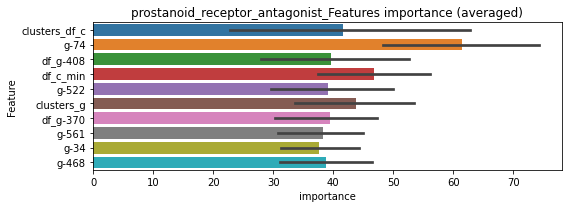

len(train_index) : 3852
len(valid_index) : 3852
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332153	valid_1's binary_logloss: 0.0743361
[200]	training's binary_logloss: 0.00745658	valid_1's binary_logloss: 0.0482816
[300]	training's binary_logloss: 0.00225991	valid_1's binary_logloss: 0.043371
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00159556	valid_1's binary_logloss: 0.0425485


len(train_index) : 3852
len(valid_index) : 3852
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035977	valid_1's binary_logloss: 0.0784617
[200]	training's binary_logloss: 0.00810078	valid_1's binary_logloss: 0.0501637
[300]	training's binary_logloss: 0.00228129	valid_1's binary_logloss: 0.0451821
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00251011	valid_1's binary_logloss: 0.045002


prostanoid_receptor_antagonist logloss: 0.04377520863096694
proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210897	valid_1's binary_logloss: 0.0235478
[200]	training's binary_logloss: 0.00204134	valid_1's binary_logloss: 0.00672773
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00102119	valid_1's binary_logloss: 0.00583173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197228	valid_1's binary_logloss: 0.0282415
[200]	training's binary_logloss: 0.00188433	valid_1's binary_logloss: 0.011965


1 / 3 AUC score:1.000
y_Threshold: 0.0004116, Threshold: 0.9985425, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049, Num_p_label: 80.0, conf_0:0.89869, conf_1:1.09840


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000621622	valid_1's binary_logloss: 0.0111055


threshold: 0.9985425, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155482	valid_1's binary_logloss: 0.0157198
[200]	training's binary_logloss: 0.000998465	valid_1's binary_logloss: 0.00103608
[300]	training's binary_logloss: 0.00022053	valid_1's binary_logloss: 0.000235005
[400]	training's binary_logloss: 0.000146451	valid_1's binary_logloss: 0.000156934
[500]	training's binary_logloss: 0.000133358	valid_1's binary_logloss: 0.000143073
[600]	training's binary_logloss: 0.000130592	valid_1's binary_logloss: 0.000140173
[700]	training's binary_logloss: 0.000129166	valid_1's binary_logloss: 0.0001387
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.000129165	valid_1's binary_logloss: 0.0001387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157611	valid_1's binary_logloss: 0.0162671
[200]	training's binary_logloss: 0.0010253	valid_1's binary_logloss: 0.0011504
[300]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.2024071, Threshold: 0.9985425, pos_neg_ratio: 0.7789954


Early stopping, best iteration is:
[649]	training's binary_logloss: 0.000130014	valid_1's binary_logloss: 0.000172222


Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0384229 Vs.target_rate: 0.03049, Num_p_label: 153.0, conf_0:0.89869, conf_1:1.09840
threshold: 0.9985425, positive_p_label: 153.0/3982, p_label_rate: 0.0384229
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155482	valid_1's binary_logloss: 0.0157198
[200]	training's binary_logloss: 0.000998465	valid_1's binary_logloss: 0.00103608
[300]	training's binary_logloss: 0.00022053	valid_1's binary_logloss: 0.000235005
[400]	training's binary_logloss: 0.000146451	valid_1's binary_logloss: 0.000156934
[500]	training's binary_logloss: 0.000133358	valid_1's binary_logloss: 0.000143073
[600]	training's binary_logloss: 0.000130592	valid_1's binary_logloss: 0.000140173
[700]	training's binary_logloss: 0.000129166	valid_1's binary_logloss: 0.0001387
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.000129165	valid_1's binary_logloss: 0.0001387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157611	valid_1's binary_logloss: 0.0162671
[200]	training's binary_logloss: 0.0010253	valid_1's binary_logloss: 0.0011504
[300]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.2024071, Threshold: 0.9985425, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0384229 Vs.target_rate: 0.03049, Num_p_label: 153.0, conf_0:0.89869, conf_1:1.09840
threshold: 0.9985425, positive_p_label: 153.0/3982, p_label_rate: 0.0384229
positive_y_label: 879.0/7832, y_label_rate: 0.1122319


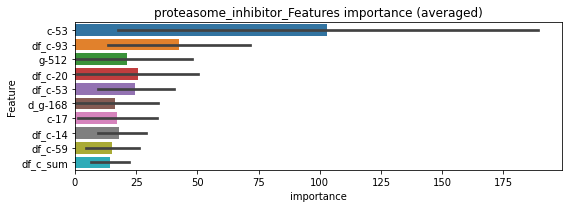

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109741	valid_1's binary_logloss: 0.0117255
[200]	training's binary_logloss: 0.000817621	valid_1's binary_logloss: 0.00217353


len(train_index) : 3916
len(valid_index) : 3916


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.000431304	valid_1's binary_logloss: 0.00194746


================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108131	valid_1's binary_logloss: 0.0137581
[200]	training's binary_logloss: 0.000769016	valid_1's binary_logloss: 0.00360345
[300]	training's binary_logloss: 0.000151525	valid_1's binary_logloss: 0.00271151


proteasome_inhibitor logloss: 0.002287547802728754


Early stopping, best iteration is:
[365]	training's binary_logloss: 9.7047e-05	valid_1's binary_logloss: 0.00262764


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404563	valid_1's binary_logloss: 0.072888
[200]	training's binary_logloss: 0.00723503	valid_1's binary_logloss: 0.026652
[300]	training's binary_logloss: 0.00211171	valid_1's binary_logloss: 0.0152243
[400]	training's binary_logloss: 0.00101799	valid_1's binary_logloss: 0.0118417
[500]	training's binary_logloss: 0.000666288	valid_1's binary_logloss: 0.0105334
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000595564	valid_1's binary_logloss: 0.0101986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422294	valid_1's binary_logloss: 0.0724
[200]	training's binary_logloss: 0.00765363	valid_1's binary_logloss: 0.0260561
[300]	training's binary_logloss: 0.00228779	valid_1's binary_logloss: 0.0151605
[400]	training's binary_logloss: 0.00110738	valid_1's binary_logloss: 0.0116728
[500]	training's binary_logloss: 0.000724895	val

1 / 3 AUC score:1.000
y_Threshold: 0.0049063, Threshold: 0.0092825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00835, conf_1:0.01021
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0092825
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_2: 0.0192825
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_3: 0.0292825
threshold: 0.0292825, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409763	valid_1's binary_logloss: 0.0742152
[200]	training's binary_logloss: 0.00710824	valid_1's binary_logloss: 0.0265575
[300]	training's binary_logloss: 0.00204787	valid_1's binary_logloss: 0.014656
[400]	training's binary_logloss: 0.00099253	valid_1's binary_logloss: 0.0112146
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000745528	valid_1's binary_logloss: 0.0102044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422768	valid_1's binary_logloss: 0.0711725
[200]	training's binary_logloss: 0.00743506	valid_1's binary_logloss: 0.0243333
[300]	training's binary_logloss: 0.0021763	valid_1's binary_logloss: 0.0137731
[400]	training's binary_logloss: 0.00105217	valid_1's binary_logloss: 0.0107786
[500]	training's binary_logloss: 0.000681087	valid_1's binary_logloss: 0.00950207
Early stopping, best iteration is:
[563]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0808259, Threshold: 0.0292825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0153189 Vs.target_rate: 0.00202, Num_p_label: 61.0, conf_0:0.02635, conf_1:0.03221
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_1: 0.0292825
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_2: 0.0392825
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.0492825
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.0592825
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_5: 0.0692825
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.0792825
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_7: 0.0892825
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_8: 0.0992825
threshold: 0.0992825, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409763	valid_1's binary_logloss: 0.0742152
[200]	training's binary_logloss: 0.00710824	valid_1's binary_logloss: 0.0265575
[300]	training's binary_logloss: 0.00204787	valid_1's binary_logloss: 0.014656
[400]	training's binary_logloss: 0.00099253	valid_1's binary_logloss: 0.0112146
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000745528	valid_1's binary_logloss: 0.0102044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422768	valid_1's binary_logloss: 0.0711725
[200]	training's binary_logloss: 0.00743506	valid_1's binary_logloss: 0.0243333
[300]	training's binary_logloss: 0.0021763	valid_1's binary_logloss: 0.0137731
[400]	training's binary_logloss: 0.00105217	valid_1's binary_logloss: 0.0107786
[500]	training's binary_logloss: 0.000681087	valid_1's binary_logloss: 0.00950207
Early stopping, best iteration is:
[563]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0808259, Threshold: 0.0992825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.08935, conf_1:0.10921
threshold: 0.0992825, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 672.0/7787, y_label_rate: 0.0862977


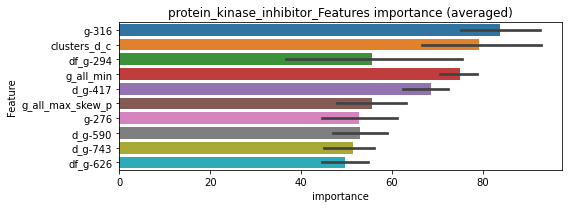

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239654	valid_1's binary_logloss: 0.0451319
[200]	training's binary_logloss: 0.00430714	valid_1's binary_logloss: 0.0212342
[300]	training's binary_logloss: 0.00119156	valid_1's binary_logloss: 0.0154175
[400]	training's binary_logloss: 0.000557039	valid_1's binary_logloss: 0.0142773
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000576218	valid_1's binary_logloss: 0.0142231


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236402	valid_1's binary_logloss: 0.0437956
[200]	training's binary_logloss: 0.00444294	valid_1's binary_logloss: 0.0172068
[300]	training's binary_logloss: 0.00125687	valid_1's binary_logloss: 0.0104561
[400]	training's binary_logloss: 0.000582896	valid_1's binary_logloss: 0.00849047
[500]	training's binary_logloss: 0.000373191	valid_1's binary_logloss: 0.00763156
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000325971	valid_1's binary_logloss: 0.00740916


protein_kinase_inhibitor logloss: 0.010816576408100442
protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247282	valid_1's binary_logloss: 0.033579
[200]	training's binary_logloss: 0.00308377	valid_1's binary_logloss: 0.00636115
[300]	training's binary_logloss: 0.000885803	valid_1's binary_logloss: 0.00259906
[400]	training's binary_logloss: 0.000469093	valid_1's binary_logloss: 0.00164821
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000370807	valid_1's binary_logloss: 0.00140557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255837	valid_1's binary_logloss: 0.0339438
[200]	training's binary_logloss: 0.00326555	valid_1's binary_logloss: 0.00579858
[300]	training's binary_logloss: 0.000923861	valid_1's binary_logloss: 0.00202965
[400]	training's binary_logloss: 0.000477239	valid_1's binary_logloss: 0.00121443
[500]	training's binary_logloss: 0.000367827	valid_1's binary_logloss: 0.00099272
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0019805, Threshold: 0.0037190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00335, conf_1:0.00409
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0037190
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0137190
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_3: 0.0237190
threshold: 0.0237190, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249103	valid_1's binary_logloss: 0.0343629
[200]	training's binary_logloss: 0.00303489	valid_1's binary_logloss: 0.00622382
[300]	training's binary_logloss: 0.000867537	valid_1's binary_logloss: 0.00256377
[400]	training's binary_logloss: 0.000460082	valid_1's binary_logloss: 0.00163461
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000362717	valid_1's binary_logloss: 0.00140132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250364	valid_1's binary_logloss: 0.032087
[200]	training's binary_logloss: 0.00303328	valid_1's binary_logloss: 0.00500373
[300]	training's binary_logloss: 0.000876724	valid_1's binary_logloss: 0.00173526
[400]	training's binary_logloss: 0.000466187	valid_1's binary_logloss: 0.00101691
[500]	training's binary_logloss: 0.000367924	valid_1's binary_logloss: 0.000833373
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.1738867, Threshold: 0.0237190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0072828 Vs.target_rate: 0.00101, Num_p_label: 29.0, conf_0:0.02135, conf_1:0.02609
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_1: 0.0237190
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.0337190
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.0437190
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_4: 0.0537190
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.0637190
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_6: 0.0737190
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.0837190
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.0937190
threshold: 0.0937190, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249103	valid_1's binary_logloss: 0.0343629
[200]	training's binary_logloss: 0.00303489	valid_1's binary_logloss: 0.00622382
[300]	training's binary_logloss: 0.000867537	valid_1's binary_logloss: 0.00256377
[400]	training's binary_logloss: 0.000460082	valid_1's binary_logloss: 0.00163461
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000362717	valid_1's binary_logloss: 0.00140132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250364	valid_1's binary_logloss: 0.032087
[200]	training's binary_logloss: 0.00303328	valid_1's binary_logloss: 0.00500373
[300]	training's binary_logloss: 0.000876724	valid_1's binary_logloss: 0.00173526
[400]	training's binary_logloss: 0.000466187	valid_1's binary_logloss: 0.00101691
[500]	training's binary_logloss: 0.000367924	valid_1's binary_logloss: 0.000833373
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.1738867, Threshold: 0.0937190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.08435, conf_1:0.10309
threshold: 0.0937190, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


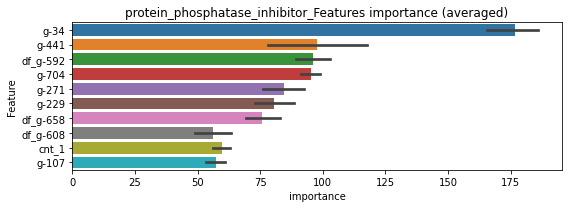

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129818	valid_1's binary_logloss: 0.0233283
[200]	training's binary_logloss: 0.00157358	valid_1's binary_logloss: 0.00947521
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000599066	valid_1's binary_logloss: 0.00816415


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137267	valid_1's binary_logloss: 0.0182105
[200]	training's binary_logloss: 0.00172254	valid_1's binary_logloss: 0.00419357
[300]	training's binary_logloss: 0.000490638	valid_1's binary_logloss: 0.0026254
[400]	training's binary_logloss: 0.000257609	valid_1's binary_logloss: 0.00240434
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000201766	valid_1's binary_logloss: 0.00233701


protein_phosphatase_inhibitor logloss: 0.005250953174242176
protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689143	valid_1's binary_logloss: 0.122999
[200]	training's binary_logloss: 0.0170347	valid_1's binary_logloss: 0.0639296
[300]	training's binary_logloss: 0.00513841	valid_1's binary_logloss: 0.0463437
[400]	training's binary_logloss: 0.002188	valid_1's binary_logloss: 0.0407617
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00225087	valid_1's binary_logloss: 0.0407152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632479	valid_1's binary_logloss: 0.141897
[200]	training's binary_logloss: 0.0140076	valid_1's binary_logloss: 0.0795572
[300]	training's binary_logloss: 0.00423396	valid_1's binary_logloss: 0.0602268
[400]	training's binary_logloss: 0.0019032	valid_1's binary_logloss: 0.0540291
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00137026	valid_1's binary_logloss: 0.0525333


1 / 3 AUC score:0.995
y_Threshold: 0.0164553, Threshold: 0.0840001, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 145 → Positive_corect_labels: 647/3780
p_label_rate: 0.0200904 Vs.target_rate: 0.00433, Num_p_label: 80.0, conf_0:0.07560, conf_1:0.09240
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0840001
Num_p_label: 76.0, Expected: 17.2, Adj_threshold_2: 0.0940001
Num_p_label: 73.0, Expected: 17.2, Adj_threshold_3: 0.1040001
Num_p_label: 69.0, Expected: 17.2, Adj_threshold_4: 0.1140001
Num_p_label: 66.0, Expected: 17.2, Adj_threshold_5: 0.1240001
Num_p_label: 62.0, Expected: 17.2, Adj_threshold_6: 0.1340001
Num_p_label: 59.0, Expected: 17.2, Adj_threshold_7: 0.1440001
Num_p_label: 55.0, Expected: 17.2, Adj_threshold_8: 0.1540001
Num_p_label: 53.0, Expected: 17.2, Adj_threshold_9: 0.1640001
Num_p_label: 46.0, Expected: 17.2, Adj_threshold_10: 0.1740001
threshold: 0.1840001, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 647.0/3780, y_label_rate: 0.171164

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582173	valid_1's binary_logloss: 0.120908
[200]	training's binary_logloss: 0.01304	valid_1's binary_logloss: 0.06459
[300]	training's binary_logloss: 0.0039845	valid_1's binary_logloss: 0.0482589
[400]	training's binary_logloss: 0.0017993	valid_1's binary_logloss: 0.0433577
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00134055	valid_1's binary_logloss: 0.0423575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605193	valid_1's binary_logloss: 0.1164
[200]	training's binary_logloss: 0.0136053	valid_1's binary_logloss: 0.0606244
[300]	training's binary_logloss: 0.00411427	valid_1's binary_logloss: 0.0459459
[400]	training's binary_logloss: 0.00186878	valid_1's binary_logloss: 0.0415932
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00194355	valid_1's binary_logloss: 0.0415863


2 / 3 AUC score:0.998
y_Threshold: 0.0501571, Threshold: 0.1840001, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 630.0/3746
p_label_rate: 0.0318935 Vs.target_rate: 0.00433, Num_p_label: 127.0, conf_0:0.16560, conf_1:0.20240
Num_p_label: 127.0, Expected: 17.2, Adj_threshold_1: 0.1840001
Num_p_label: 124.0, Expected: 17.2, Adj_threshold_2: 0.1940001
Num_p_label: 121.0, Expected: 17.2, Adj_threshold_3: 0.2040001
Num_p_label: 120.0, Expected: 17.2, Adj_threshold_4: 0.2140001
Num_p_label: 114.0, Expected: 17.2, Adj_threshold_5: 0.2240001
Num_p_label: 111.0, Expected: 17.2, Adj_threshold_6: 0.2340001
Num_p_label: 109.0, Expected: 17.2, Adj_threshold_7: 0.2440001
Num_p_label: 109.0, Expected: 17.2, Adj_threshold_8: 0.2540001
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_9: 0.2640001
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_10: 0.2740001
threshold: 0.2840001, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 630.0/3746, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559017	valid_1's binary_logloss: 0.122159
[200]	training's binary_logloss: 0.0118112	valid_1's binary_logloss: 0.0694416
[300]	training's binary_logloss: 0.00358886	valid_1's binary_logloss: 0.0588844
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00306708	valid_1's binary_logloss: 0.057857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562531	valid_1's binary_logloss: 0.11657
[200]	training's binary_logloss: 0.0123849	valid_1's binary_logloss: 0.061657
[300]	training's binary_logloss: 0.00370008	valid_1's binary_logloss: 0.0464417
[400]	training's binary_logloss: 0.00168772	valid_1's binary_logloss: 0.042001
[500]	training's binary_logloss: 0.00102443	valid_1's binary_logloss: 0.0398216
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00102443	valid_1's binary_logloss: 0.0398216


3 / 3 AUC score:0.998
y_Threshold: 0.0496526, Threshold: 0.2840001, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 614.0/3714
p_label_rate: 0.0308890 Vs.target_rate: 0.00433, Num_p_label: 123.0, conf_0:0.25560, conf_1:0.31240
Num_p_label: 123.0, Expected: 17.2, Adj_threshold_1: 0.2840001
Num_p_label: 121.0, Expected: 17.2, Adj_threshold_2: 0.2940001
Num_p_label: 119.0, Expected: 17.2, Adj_threshold_3: 0.3040001
Num_p_label: 115.0, Expected: 17.2, Adj_threshold_4: 0.3140001
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_5: 0.3240001
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_6: 0.3340001
Num_p_label: 111.0, Expected: 17.2, Adj_threshold_7: 0.3440001
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_8: 0.3540001
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_9: 0.3640001
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_10: 0.3740001
threshold: 0.3840001, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 717.0/7696, y_label_r

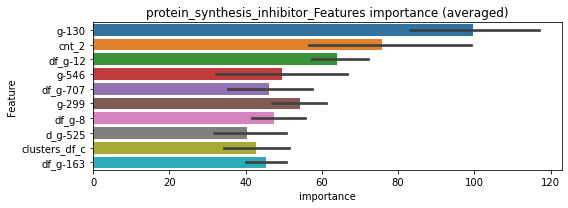

len(train_index) : 3848
len(valid_index) : 3848
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313639	valid_1's binary_logloss: 0.0764773
[200]	training's binary_logloss: 0.00704628	valid_1's binary_logloss: 0.049666
[300]	training's binary_logloss: 0.00204655	valid_1's binary_logloss: 0.0410979
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00177549	valid_1's binary_logloss: 0.0403426


len(train_index) : 3848
len(valid_index) : 3848
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330951	valid_1's binary_logloss: 0.0715166
[200]	training's binary_logloss: 0.00701396	valid_1's binary_logloss: 0.0446002
[300]	training's binary_logloss: 0.00205151	valid_1's binary_logloss: 0.0379091
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00108978	valid_1's binary_logloss: 0.036268


protein_synthesis_inhibitor logloss: 0.03830529313137284
protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257272	valid_1's binary_logloss: 0.0352329
[200]	training's binary_logloss: 0.00333028	valid_1's binary_logloss: 0.00743277
[300]	training's binary_logloss: 0.000920277	valid_1's binary_logloss: 0.00296228
[400]	training's binary_logloss: 0.000469153	valid_1's binary_logloss: 0.00187109
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000368565	valid_1's binary_logloss: 0.00162932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265154	valid_1's binary_logloss: 0.0336914
[200]	training's binary_logloss: 0.00340716	valid_1's binary_logloss: 0.00541291
[300]	training's binary_logloss: 0.000949732	valid_1's binary_logloss: 0.00180528
[400]	training's binary_logloss: 0.000479551	valid_1's binary_logloss: 0.00101875
[500]	training's binary_logloss: 0.000365936	valid_1's binary_logloss: 0.000834413
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0016358, Threshold: 0.0023464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00211, conf_1:0.00258
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0023464
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0123464
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0223464
threshold: 0.0223464, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260398	valid_1's binary_logloss: 0.0363067
[200]	training's binary_logloss: 0.00319098	valid_1's binary_logloss: 0.00705514
[300]	training's binary_logloss: 0.000891265	valid_1's binary_logloss: 0.00280014
[400]	training's binary_logloss: 0.000458607	valid_1's binary_logloss: 0.00176784
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000366568	valid_1's binary_logloss: 0.00152873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254483	valid_1's binary_logloss: 0.0330901
[200]	training's binary_logloss: 0.00320231	valid_1's binary_logloss: 0.00517988
[300]	training's binary_logloss: 0.000898386	valid_1's binary_logloss: 0.00168482
[400]	training's binary_logloss: 0.000465753	valid_1's binary_logloss: 0.000945577
[500]	training's binary_logloss: 0.000363786	valid_1's binary_logloss: 0.000773485
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1170661, Threshold: 0.0223464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.02011, conf_1:0.02458
threshold: 0.0223464, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260398	valid_1's binary_logloss: 0.0363067
[200]	training's binary_logloss: 0.00319098	valid_1's binary_logloss: 0.00705514
[300]	training's binary_logloss: 0.000891265	valid_1's binary_logloss: 0.00280014
[400]	training's binary_logloss: 0.000458607	valid_1's binary_logloss: 0.00176784
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000366568	valid_1's binary_logloss: 0.00152873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254483	valid_1's binary_logloss: 0.0330901
[200]	training's binary_logloss: 0.00320231	valid_1's binary_logloss: 0.00517988
[300]	training's binary_logloss: 0.000898386	valid_1's binary_logloss: 0.00168482
[400]	training's binary_logloss: 0.000465753	valid_1's binary_logloss: 0.000945577
[500]	training's binary_logloss: 0.000363786	valid_1's binary_logloss: 0.000773485
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1170661, Threshold: 0.0223464, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.02011, conf_1:0.02458
threshold: 0.0223464, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


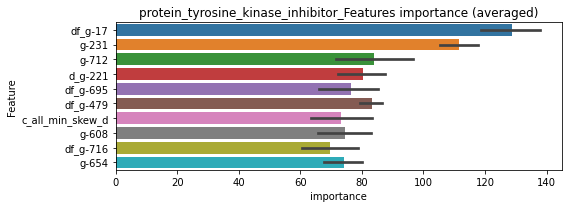

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135965	valid_1's binary_logloss: 0.0231194
[200]	training's binary_logloss: 0.00167077	valid_1's binary_logloss: 0.00905762
[300]	training's binary_logloss: 0.000462676	valid_1's binary_logloss: 0.00756921
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000283087	valid_1's binary_logloss: 0.00733506


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138217	valid_1's binary_logloss: 0.0190098
[200]	training's binary_logloss: 0.00174668	valid_1's binary_logloss: 0.0044484
[300]	training's binary_logloss: 0.000477778	valid_1's binary_logloss: 0.00262022
[400]	training's binary_logloss: 0.00024235	valid_1's binary_logloss: 0.00235222
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000208224	valid_1's binary_logloss: 0.00232147


protein_tyrosine_kinase_inhibitor logloss: 0.0048282654997964785
radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515991	valid_1's binary_logloss: 0.104207
[200]	training's binary_logloss: 0.00956743	valid_1's binary_logloss: 0.0562062
[300]	training's binary_logloss: 0.00270352	valid_1's binary_logloss: 0.0460128
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00136144	valid_1's binary_logloss: 0.0441937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528935	valid_1's binary_logloss: 0.089027
[200]	training's binary_logloss: 0.0111281	valid_1's binary_logloss: 0.0383833
[300]	training's binary_logloss: 0.00314462	valid_1's binary_logloss: 0.0242056
[400]	training's binary_logloss: 0.00139698	valid_1's binary_logloss: 0.0198449
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00139698	valid_1's binary_logloss: 0.0198449


1 / 3 AUC score:0.998
y_Threshold: 0.0115963, Threshold: 0.0152195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.01370, conf_1:0.01674
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0152195
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.0252195
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_3: 0.0352195
threshold: 0.0352195, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504856	valid_1's binary_logloss: 0.0914084
[200]	training's binary_logloss: 0.00920984	valid_1's binary_logloss: 0.0412051
[300]	training's binary_logloss: 0.00263431	valid_1's binary_logloss: 0.030036
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0020145	valid_1's binary_logloss: 0.0289101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518928	valid_1's binary_logloss: 0.090304
[200]	training's binary_logloss: 0.0101214	valid_1's binary_logloss: 0.0375896
[300]	training's binary_logloss: 0.00287588	valid_1's binary_logloss: 0.0244417
[400]	training's binary_logloss: 0.00130897	valid_1's binary_logloss: 0.0208138
[500]	training's binary_logloss: 0.000807182	valid_1's binary_logloss: 0.0193689
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000699393	valid_1's binary_logloss: 0.0186963


2 / 3 AUC score:0.999
y_Threshold: 0.0440120, Threshold: 0.0352195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0090407 Vs.target_rate: 0.00235, Num_p_label: 36.0, conf_0:0.03170, conf_1:0.03874
Num_p_label: 36.0, Expected: 9.4, Adj_threshold_1: 0.0352195
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.0452195
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_3: 0.0552195
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_4: 0.0652195
threshold: 0.0652195, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482667	valid_1's binary_logloss: 0.0952244
[200]	training's binary_logloss: 0.00890126	valid_1's binary_logloss: 0.047139
[300]	training's binary_logloss: 0.00253727	valid_1's binary_logloss: 0.0377294
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00170276	valid_1's binary_logloss: 0.0363764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502509	valid_1's binary_logloss: 0.084479
[200]	training's binary_logloss: 0.00949478	valid_1's binary_logloss: 0.0325423
[300]	training's binary_logloss: 0.00268622	valid_1's binary_logloss: 0.0189336
[400]	training's binary_logloss: 0.00124829	valid_1's binary_logloss: 0.0155573
[500]	training's binary_logloss: 0.000769614	valid_1's binary_logloss: 0.0137541
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000611835	valid_1's binary_logloss: 0.0131066


3 / 3 AUC score:1.000
y_Threshold: 0.0388996, Threshold: 0.0652195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0020090 Vs.target_rate: 0.00235, Num_p_label: 8.0, conf_0:0.05870, conf_1:0.07174
threshold: 0.0652195, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 646.0/7751, y_label_rate: 0.0833441


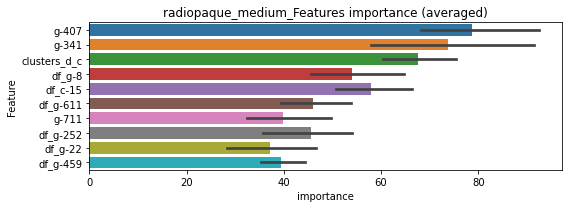

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287396	valid_1's binary_logloss: 0.0529701
[200]	training's binary_logloss: 0.00537306	valid_1's binary_logloss: 0.0255048
[300]	training's binary_logloss: 0.00143566	valid_1's binary_logloss: 0.0192904
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000859588	valid_1's binary_logloss: 0.0181371


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279127	valid_1's binary_logloss: 0.0496318
[200]	training's binary_logloss: 0.00554448	valid_1's binary_logloss: 0.0237867
[300]	training's binary_logloss: 0.00150621	valid_1's binary_logloss: 0.0176021
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000727915	valid_1's binary_logloss: 0.0160399


radiopaque_medium logloss: 0.017088633034859243
raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272489	valid_1's binary_logloss: 0.0706307
[200]	training's binary_logloss: 0.0037083	valid_1's binary_logloss: 0.045857
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00181437	valid_1's binary_logloss: 0.0424469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293719	valid_1's binary_logloss: 0.0501287
[200]	training's binary_logloss: 0.00439733	valid_1's binary_logloss: 0.0243376
[300]	training's binary_logloss: 0.00134396	valid_1's binary_logloss: 0.0190066
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00125334	valid_1's binary_logloss: 0.0189323


1 / 3 AUC score:0.999
y_Threshold: 0.0058735, Threshold: 0.0238931, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00936, Num_p_label: 80.0, conf_0:0.02150, conf_1:0.02628
threshold: 0.0238931, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 656.0/3804, y_label_rate: 0.1724501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264323	valid_1's binary_logloss: 0.0662537
[200]	training's binary_logloss: 0.00357125	valid_1's binary_logloss: 0.0416442
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00162534	valid_1's binary_logloss: 0.0381566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280568	valid_1's binary_logloss: 0.043097
[200]	training's binary_logloss: 0.0039011	valid_1's binary_logloss: 0.0173982
[300]	training's binary_logloss: 0.00116124	valid_1's binary_logloss: 0.012955


2 / 3 AUC score:1.000
y_Threshold: 0.0263969, Threshold: 0.0238931, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000945707	valid_1's binary_logloss: 0.0124245


Remove_noisy_labels: 14 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0341537 Vs.target_rate: 0.00936, Num_p_label: 136.0, conf_0:0.02150, conf_1:0.02628
Num_p_label: 136.0, Expected: 37.3, Adj_threshold_1: 0.0238931
Num_p_label: 105.0, Expected: 37.3, Adj_threshold_2: 0.0338931
Num_p_label: 90.0, Expected: 37.3, Adj_threshold_3: 0.0438931
Num_p_label: 81.0, Expected: 37.3, Adj_threshold_4: 0.0538931
Num_p_label: 74.0, Expected: 37.3, Adj_threshold_5: 0.0638931
threshold: 0.0638931, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261713	valid_1's binary_logloss: 0.0545552
[200]	training's binary_logloss: 0.00340955	valid_1's binary_logloss: 0.0369938
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0039851	valid_1's binary_logloss: 0.0369379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02608	valid_1's binary_logloss: 0.0555492
[200]	training's binary_logloss: 0.00329796	valid_1's binary_logloss: 0.0372964


3 / 3 AUC score:0.998
y_Threshold: 0.0307961, Threshold: 0.0638931, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 639.0/3770
p_label_rate: 0.0213461 Vs.target_rate: 0.00936, Num_p_label: 85.0, conf_0:0.05750, conf_1:0.07028


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00206722	valid_1's binary_logloss: 0.0362899


threshold: 0.0638931, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 724.0/7752, y_label_rate: 0.0933953


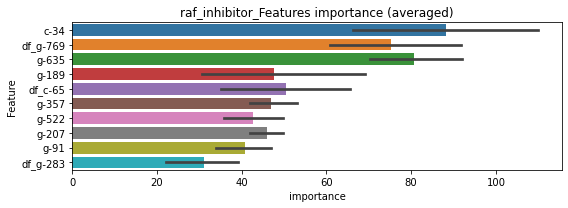

len(train_index) : 3876
len(valid_index) : 3876
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154914	valid_1's binary_logloss: 0.0445979
[200]	training's binary_logloss: 0.00208838	valid_1's binary_logloss: 0.033098
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00189949	valid_1's binary_logloss: 0.0327692


len(train_index) : 3876
len(valid_index) : 3876
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161456	valid_1's binary_logloss: 0.0394702
[200]	training's binary_logloss: 0.00220971	valid_1's binary_logloss: 0.0262468
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000876418	valid_1's binary_logloss: 0.0247091


raf_inhibitor logloss: 0.028739156453290966
ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195977	valid_1's binary_logloss: 0.0251123
[200]	training's binary_logloss: 0.00201577	valid_1's binary_logloss: 0.00467334
[300]	training's binary_logloss: 0.000570087	valid_1's binary_logloss: 0.00208677
[400]	training's binary_logloss: 0.000319355	valid_1's binary_logloss: 0.00151796
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000283466	valid_1's binary_logloss: 0.00145122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200748	valid_1's binary_logloss: 0.0241791
[200]	training's binary_logloss: 0.00206515	valid_1's binary_logloss: 0.00394527
[300]	training's binary_logloss: 0.000579681	valid_1's binary_logloss: 0.00168952
[400]	training's binary_logloss: 0.000328209	valid_1's binary_logloss: 0.00127443
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280631	valid_1's binary_logloss: 0.00118

1 / 3 AUC score:1.000
y_Threshold: 0.0010181, Threshold: 0.0013913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00125, conf_1:0.00153
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0013913
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0113913
threshold: 0.0113913, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202496	valid_1's binary_logloss: 0.0258374
[200]	training's binary_logloss: 0.00202006	valid_1's binary_logloss: 0.00396053
[300]	training's binary_logloss: 0.00056605	valid_1's binary_logloss: 0.00164012
[400]	training's binary_logloss: 0.000319115	valid_1's binary_logloss: 0.00116575
[500]	training's binary_logloss: 0.000274519	valid_1's binary_logloss: 0.00108819
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000272268	valid_1's binary_logloss: 0.00108572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203619	valid_1's binary_logloss: 0.0253829
[200]	training's binary_logloss: 0.0020199	valid_1's binary_logloss: 0.0036264
[300]	training's binary_logloss: 0.000557813	valid_1's binary_logloss: 0.00151358
[400]	training's binary_logloss: 0.000320105	valid_1's binary_logloss: 0.00113485
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0748902, Threshold: 0.0113913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.01025, conf_1:0.01253
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.0113913
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0213913
threshold: 0.0213913, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202496	valid_1's binary_logloss: 0.0258374
[200]	training's binary_logloss: 0.00202006	valid_1's binary_logloss: 0.00396053
[300]	training's binary_logloss: 0.00056605	valid_1's binary_logloss: 0.00164012
[400]	training's binary_logloss: 0.000319115	valid_1's binary_logloss: 0.00116575
[500]	training's binary_logloss: 0.000274519	valid_1's binary_logloss: 0.00108819
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000272268	valid_1's binary_logloss: 0.00108572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203619	valid_1's binary_logloss: 0.0253829
[200]	training's binary_logloss: 0.0020199	valid_1's binary_logloss: 0.0036264
[300]	training's binary_logloss: 0.000557813	valid_1's binary_logloss: 0.00151358
[400]	training's binary_logloss: 0.000320105	valid_1's binary_logloss: 0.00113485
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0748902, Threshold: 0.0213913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.01925, conf_1:0.02353
threshold: 0.0213913, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


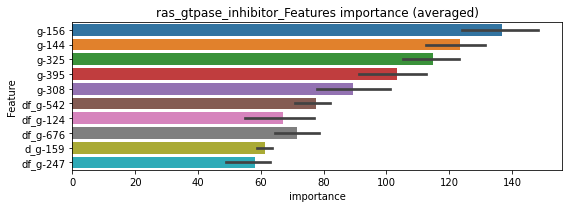

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104712	valid_1's binary_logloss: 0.0183001
[200]	training's binary_logloss: 0.00103585	valid_1's binary_logloss: 0.00520214
[300]	training's binary_logloss: 0.000281374	valid_1's binary_logloss: 0.00375013
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00022946	valid_1's binary_logloss: 0.00367039


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104937	valid_1's binary_logloss: 0.0129734
[200]	training's binary_logloss: 0.00104943	valid_1's binary_logloss: 0.00264191
[300]	training's binary_logloss: 0.000297994	valid_1's binary_logloss: 0.00166577
[400]	training's binary_logloss: 0.000162823	valid_1's binary_logloss: 0.00145041
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000150782	valid_1's binary_logloss: 0.00142993


ras_gtpase_inhibitor logloss: 0.002550159171554123
retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395262	valid_1's binary_logloss: 0.080909
[200]	training's binary_logloss: 0.00674941	valid_1's binary_logloss: 0.0348034
[300]	training's binary_logloss: 0.00202331	valid_1's binary_logloss: 0.0241782
[400]	training's binary_logloss: 0.000988915	valid_1's binary_logloss: 0.020177
[500]	training's binary_logloss: 0.000636278	valid_1's binary_logloss: 0.0186097
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000627378	valid_1's binary_logloss: 0.0185285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394444	valid_1's binary_logloss: 0.0816783
[200]	training's binary_logloss: 0.00683735	valid_1's binary_logloss: 0.0360455
[300]	training's binary_logloss: 0.00202751	valid_1's binary_logloss: 0.0258852
[400]	training's binary_logloss: 0.000990578	valid_1's binary_logloss: 0.0228423
Early stopping, best iteration is:
[420]	tr

1 / 3 AUC score:1.000
y_Threshold: 0.0070227, Threshold: 0.0151886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.01367, conf_1:0.01671
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0151886
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_2: 0.0251886
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_3: 0.0351886
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_4: 0.0451886
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_5: 0.0551886
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_6: 0.0651886
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_7: 0.0751886
threshold: 0.0751886, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3799, y_label_rate: 0.1721506
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394347	valid_1's binary_logloss: 0.0747442
[200]	training's binary_logloss: 0.00671974	valid_1's binary_logloss: 0.0259703
[300]	training's binary_logloss: 0.0019311	valid_1's binary_logloss: 0.015213
[400]	training's binary_logloss: 0.000929249	valid_1's binary_logloss: 0.011488
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000666452	valid_1's binary_logloss: 0.0101968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395903	valid_1's binary_logloss: 0.0626568
[200]	training's binary_logloss: 0.00668983	valid_1's binary_logloss: 0.0221745
[300]	training's binary_logloss: 0.00193687	valid_1's binary_logloss: 0.012792
[400]	training's binary_logloss: 0.000938196	valid_1's binary_logloss: 0.0105887
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000855124	valid_1's binary_logloss: 0.0103693


2 / 3 AUC score:1.000
y_Threshold: 0.0650940, Threshold: 0.0751886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3797
p_label_rate: 0.0190859 Vs.target_rate: 0.00281, Num_p_label: 76.0, conf_0:0.06767, conf_1:0.08271
Num_p_label: 76.0, Expected: 11.2, Adj_threshold_1: 0.0751886
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_2: 0.0851886
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_3: 0.0951886
Num_p_label: 57.0, Expected: 11.2, Adj_threshold_4: 0.1051886
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_5: 0.1151886
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_6: 0.1251886
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_7: 0.1351886
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_8: 0.1451886
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_9: 0.1551886
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_10: 0.1651886
threshold: 0.1751886, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 653.0/3797, y_label_rate: 0.171977

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378795	valid_1's binary_logloss: 0.0801743
[200]	training's binary_logloss: 0.00626156	valid_1's binary_logloss: 0.0331684
[300]	training's binary_logloss: 0.00187364	valid_1's binary_logloss: 0.0209779
[400]	training's binary_logloss: 0.000901851	valid_1's binary_logloss: 0.0173385
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000646307	valid_1's binary_logloss: 0.0157643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397336	valid_1's binary_logloss: 0.062871
[200]	training's binary_logloss: 0.00670841	valid_1's binary_logloss: 0.0197304
[300]	training's binary_logloss: 0.00196118	valid_1's binary_logloss: 0.0105894
[400]	training's binary_logloss: 0.000947046	valid_1's binary_logloss: 0.00773876
[500]	training's binary_logloss: 0.000625224	valid_1's binary_logloss: 0.0066252
Early stopping, best iteration is:
[559]	

3 / 3 AUC score:1.000
y_Threshold: 0.0410067, Threshold: 0.1751886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3795
p_label_rate: 0.0087896 Vs.target_rate: 0.00281, Num_p_label: 35.0, conf_0:0.15767, conf_1:0.19271
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_1: 0.1751886
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.1851886
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_3: 0.1951886
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.2051886
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_5: 0.2151886
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_6: 0.2251886
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_7: 0.2351886
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_8: 0.2451886
threshold: 0.2451886, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 674.0/7777, y_label_rate: 0.0866658


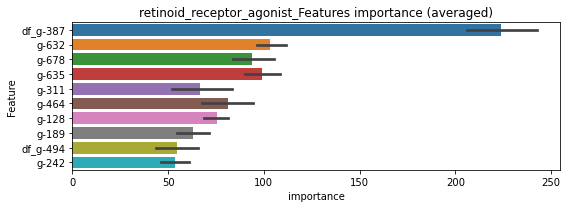

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220136	valid_1's binary_logloss: 0.0481462
[200]	training's binary_logloss: 0.00370314	valid_1's binary_logloss: 0.0259207
[300]	training's binary_logloss: 0.00104719	valid_1's binary_logloss: 0.0205274
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000569461	valid_1's binary_logloss: 0.0189385


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021116	valid_1's binary_logloss: 0.047523
[200]	training's binary_logloss: 0.00341301	valid_1's binary_logloss: 0.0250494
[300]	training's binary_logloss: 0.00100028	valid_1's binary_logloss: 0.0193263
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000568929	valid_1's binary_logloss: 0.0180555


retinoid_receptor_agonist logloss: 0.018497040092017525
retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154979	valid_1's binary_logloss: 0.0200954
[200]	training's binary_logloss: 0.00126548	valid_1's binary_logloss: 0.00578985
[300]	training's binary_logloss: 0.000340186	valid_1's binary_logloss: 0.00391214
[400]	training's binary_logloss: 0.000209067	valid_1's binary_logloss: 0.00350305
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000206704	valid_1's binary_logloss: 0.0034887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156354	valid_1's binary_logloss: 0.0163484
[200]	training's binary_logloss: 0.00127599	valid_1's binary_logloss: 0.00140964
[300]	training's binary_logloss: 0.000343906	valid_1's binary_logloss: 0.00039834
[400]	training's binary_logloss: 0.000211323	valid_1's binary_logloss: 0.000246629
[500]	training's binary_logloss: 0.000186851	valid_1's binary_logloss: 0.000218397
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0005219, Threshold: 0.0007413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00067, conf_1:0.00082
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0007413
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_2: 0.0107413
threshold: 0.0107413, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015963	valid_1's binary_logloss: 0.0204941
[200]	training's binary_logloss: 0.00128278	valid_1's binary_logloss: 0.00505653
[300]	training's binary_logloss: 0.000340778	valid_1's binary_logloss: 0.00324346
[400]	training's binary_logloss: 0.000210925	valid_1's binary_logloss: 0.00283458
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000190067	valid_1's binary_logloss: 0.0027476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160478	valid_1's binary_logloss: 0.0168412
[200]	training's binary_logloss: 0.00129814	valid_1's binary_logloss: 0.00147048
[300]	training's binary_logloss: 0.000344143	valid_1's binary_logloss: 0.000418458
[400]	training's binary_logloss: 0.000211747	valid_1's binary_logloss: 0.000262777
[500]	training's binary_logloss: 0.000185002	valid_1's binary_logloss: 0.000229699
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0427266, Threshold: 0.0107413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.00967, conf_1:0.01182
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0107413
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0207413
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0307413
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0407413
threshold: 0.0407413, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015963	valid_1's binary_logloss: 0.0204941
[200]	training's binary_logloss: 0.00128278	valid_1's binary_logloss: 0.00505653
[300]	training's binary_logloss: 0.000340778	valid_1's binary_logloss: 0.00324346
[400]	training's binary_logloss: 0.000210925	valid_1's binary_logloss: 0.00283458
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000190067	valid_1's binary_logloss: 0.0027476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160478	valid_1's binary_logloss: 0.0168412
[200]	training's binary_logloss: 0.00129814	valid_1's binary_logloss: 0.00147048
[300]	training's binary_logloss: 0.000344143	valid_1's binary_logloss: 0.000418458
[400]	training's binary_logloss: 0.000211747	valid_1's binary_logloss: 0.000262777
[500]	training's binary_logloss: 0.000185002	valid_1's binary_logloss: 0.000229699
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0427266, Threshold: 0.0407413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.03667, conf_1:0.04482
threshold: 0.0407413, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


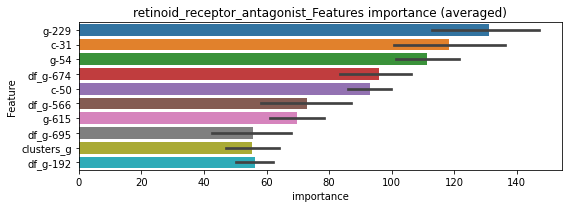

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00833281	valid_1's binary_logloss: 0.00976339
[200]	training's binary_logloss: 0.000653933	valid_1's binary_logloss: 0.0018955


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000239145	valid_1's binary_logloss: 0.00155592


================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00843306	valid_1's binary_logloss: 0.00851797
[200]	training's binary_logloss: 0.000678455	valid_1's binary_logloss: 0.000692246
[300]	training's binary_logloss: 0.00018056	valid_1's binary_logloss: 0.000189631
[400]	training's binary_logloss: 0.000108082	valid_1's binary_logloss: 0.000114947
[500]	training's binary_logloss: 9.2892e-05	valid_1's binary_logloss: 9.81672e-05
Early stopping, best iteration is:
[568]	training's binary_logloss: 9.17115e-05	valid_1's binary_logloss: 9.63376e-05


retinoid_receptor_antagonist logloss: 0.000826221804396382
rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311073	valid_1's binary_logloss: 0.0476688
[200]	training's binary_logloss: 0.00437848	valid_1's binary_logloss: 0.0121181
[300]	training's binary_logloss: 0.00125241	valid_1's binary_logloss: 0.0059282
[400]	training's binary_logloss: 0.000626813	valid_1's binary_logloss: 0.00420349
[500]	training's binary_logloss: 0.000437002	valid_1's binary_logloss: 0.00353617
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000415997	valid_1's binary_logloss: 0.00345186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318171	valid_1's binary_logloss: 0.0522264
[200]	training's binary_logloss: 0.00454106	valid_1's binary_logloss: 0.0167101
[300]	training's binary_logloss: 0.00128362	valid_1's binary_logloss: 0.00999946
[400]	training's binary_logloss: 0.000638672	valid_1's binary_logloss: 0.00818357
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0030013, Threshold: 0.0045292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147, Num_p_label: 80.0, conf_0:0.00408, conf_1:0.00498
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0045292
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_2: 0.0145292
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_3: 0.0245292
threshold: 0.0245292, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311207	valid_1's binary_logloss: 0.0469429
[200]	training's binary_logloss: 0.00429948	valid_1's binary_logloss: 0.0116207
[300]	training's binary_logloss: 0.00123102	valid_1's binary_logloss: 0.00536629
[400]	training's binary_logloss: 0.000618821	valid_1's binary_logloss: 0.00358293
[500]	training's binary_logloss: 0.000432832	valid_1's binary_logloss: 0.00301021
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000432832	valid_1's binary_logloss: 0.00301021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306439	valid_1's binary_logloss: 0.0501627
[200]	training's binary_logloss: 0.00428802	valid_1's binary_logloss: 0.0153618
[300]	training's binary_logloss: 0.00122536	valid_1's binary_logloss: 0.00875347
[400]	training's binary_logloss: 0.000614947	valid_1's binary_logloss: 0.0068052
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0399542, Threshold: 0.0245292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0072828 Vs.target_rate: 0.00147, Num_p_label: 29.0, conf_0:0.02208, conf_1:0.02698
Num_p_label: 29.0, Expected: 5.9, Adj_threshold_1: 0.0245292
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_2: 0.0345292
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_3: 0.0445292
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_4: 0.0545292
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_5: 0.0645292
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_6: 0.0745292
threshold: 0.0745292, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308152	valid_1's binary_logloss: 0.0465561
[200]	training's binary_logloss: 0.00424074	valid_1's binary_logloss: 0.0122305
[300]	training's binary_logloss: 0.00120907	valid_1's binary_logloss: 0.00631097
[400]	training's binary_logloss: 0.000619201	valid_1's binary_logloss: 0.00434009
[500]	training's binary_logloss: 0.000432318	valid_1's binary_logloss: 0.00373974
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000427487	valid_1's binary_logloss: 0.0037296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313005	valid_1's binary_logloss: 0.052364
[200]	training's binary_logloss: 0.00431057	valid_1's binary_logloss: 0.0171312
[300]	training's binary_logloss: 0.00122615	valid_1's binary_logloss: 0.00938216
[400]	training's binary_logloss: 0.000612618	valid_1's binary_logloss: 0.00708022
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0379175, Threshold: 0.0745292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0022602 Vs.target_rate: 0.00147, Num_p_label: 9.0, conf_0:0.06708, conf_1:0.08198
threshold: 0.0745292, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7787, y_label_rate: 0.0852703


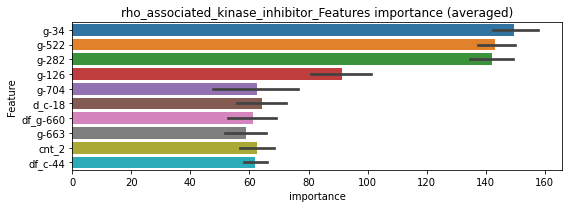

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156959	valid_1's binary_logloss: 0.0295211
[200]	training's binary_logloss: 0.00219811	valid_1's binary_logloss: 0.0116992
[300]	training's binary_logloss: 0.000628065	valid_1's binary_logloss: 0.00886302
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000436522	valid_1's binary_logloss: 0.00839986


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162977	valid_1's binary_logloss: 0.0291323
[200]	training's binary_logloss: 0.00223719	valid_1's binary_logloss: 0.0112409
[300]	training's binary_logloss: 0.000645468	valid_1's binary_logloss: 0.00781074
[400]	training's binary_logloss: 0.000324779	valid_1's binary_logloss: 0.00679666
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000242703	valid_1's binary_logloss: 0.00654503


rho_associated_kinase_inhibitor logloss: 0.007472565845681734
ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287743	valid_1's binary_logloss: 0.0448929
[200]	training's binary_logloss: 0.00396919	valid_1's binary_logloss: 0.0120018
[300]	training's binary_logloss: 0.00113562	valid_1's binary_logloss: 0.00693709
[400]	training's binary_logloss: 0.000571992	valid_1's binary_logloss: 0.00560012
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000443773	valid_1's binary_logloss: 0.00519814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292599	valid_1's binary_logloss: 0.0416977
[200]	training's binary_logloss: 0.00414036	valid_1's binary_logloss: 0.0105301
[300]	training's binary_logloss: 0.00117957	valid_1's binary_logloss: 0.0056205
[400]	training's binary_logloss: 0.000593443	valid_1's binary_logloss: 0.00467214
[500]	training's binary_logloss: 0.00042008	valid_1's binary_logloss: 0.00417942
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0022454, Threshold: 0.0039749, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00358, conf_1:0.00437
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0039749
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_2: 0.0139749
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_3: 0.0239749
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_4: 0.0339749
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0439749
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_6: 0.0539749
threshold: 0.0539749, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286616	valid_1's binary_logloss: 0.0425183
[200]	training's binary_logloss: 0.00368867	valid_1's binary_logloss: 0.008455
[300]	training's binary_logloss: 0.00105014	valid_1's binary_logloss: 0.00349294
[400]	training's binary_logloss: 0.000529353	valid_1's binary_logloss: 0.00222701
[500]	training's binary_logloss: 0.00039554	valid_1's binary_logloss: 0.00187268
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000389227	valid_1's binary_logloss: 0.00185519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283628	valid_1's binary_logloss: 0.039133
[200]	training's binary_logloss: 0.00381644	valid_1's binary_logloss: 0.0079602
[300]	training's binary_logloss: 0.00108859	valid_1's binary_logloss: 0.00310403
[400]	training's binary_logloss: 0.000550775	valid_1's binary_logloss: 0.00186845
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0899192, Threshold: 0.0539749, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.04858, conf_1:0.05937
threshold: 0.0539749, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286616	valid_1's binary_logloss: 0.0425183
[200]	training's binary_logloss: 0.00368867	valid_1's binary_logloss: 0.008455
[300]	training's binary_logloss: 0.00105014	valid_1's binary_logloss: 0.00349294
[400]	training's binary_logloss: 0.000529353	valid_1's binary_logloss: 0.00222701
[500]	training's binary_logloss: 0.00039554	valid_1's binary_logloss: 0.00187268
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000389227	valid_1's binary_logloss: 0.00185519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283628	valid_1's binary_logloss: 0.039133
[200]	training's binary_logloss: 0.00381644	valid_1's binary_logloss: 0.0079602
[300]	training's binary_logloss: 0.00108859	valid_1's binary_logloss: 0.00310403
[400]	training's binary_logloss: 0.000550775	valid_1's binary_logloss: 0.00186845
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0899192, Threshold: 0.0539749, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.04858, conf_1:0.05937
threshold: 0.0539749, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7788, y_label_rate: 0.0865434


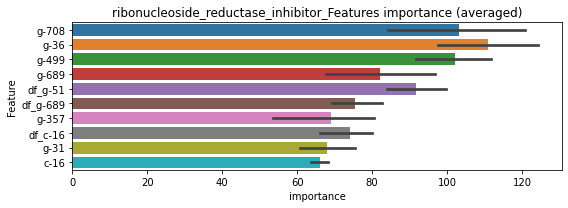

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148971	valid_1's binary_logloss: 0.0273507
[200]	training's binary_logloss: 0.00193153	valid_1's binary_logloss: 0.0114213
[300]	training's binary_logloss: 0.00054224	valid_1's binary_logloss: 0.00872424
[400]	training's binary_logloss: 0.000272237	valid_1's binary_logloss: 0.00794144
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00024439	valid_1's binary_logloss: 0.00786549


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155886	valid_1's binary_logloss: 0.0236156
[200]	training's binary_logloss: 0.00208634	valid_1's binary_logloss: 0.00644339
[300]	training's binary_logloss: 0.00058495	valid_1's binary_logloss: 0.00363483
[400]	training's binary_logloss: 0.000293682	valid_1's binary_logloss: 0.00299768
[500]	training's binary_logloss: 0.00020998	valid_1's binary_logloss: 0.00277981
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000213329	valid_1's binary_logloss: 0.00277337


ribonucleoside_reductase_inhibitor logloss: 0.005319430371254719
rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285558	valid_1's binary_logloss: 0.0385336
[200]	training's binary_logloss: 0.00375595	valid_1's binary_logloss: 0.00781888
[300]	training's binary_logloss: 0.00106688	valid_1's binary_logloss: 0.00327374
[400]	training's binary_logloss: 0.000547498	valid_1's binary_logloss: 0.0021231
[500]	training's binary_logloss: 0.000415349	valid_1's binary_logloss: 0.00177739
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00040307	valid_1's binary_logloss: 0.00174955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028199	valid_1's binary_logloss: 0.0414685
[200]	training's binary_logloss: 0.003704	valid_1's binary_logloss: 0.0107732
[300]	training's binary_logloss: 0.00104992	valid_1's binary_logloss: 0.00663979
[400]	training's binary_logloss: 0.000536424	valid_1's binary_logloss: 0.00546072
Early stopping, best iteration is:
[450

1 / 3 AUC score:1.000
y_Threshold: 0.0021965, Threshold: 0.0114777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.01033, conf_1:0.01263
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0114777
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_2: 0.0214777
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_3: 0.0314777
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_4: 0.0414777
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_5: 0.0514777
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_6: 0.0614777
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_7: 0.0714777
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_8: 0.0814777
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_9: 0.0914777
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_10: 0.1014777
threshold: 0.1114777, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276302	valid_1's binary_logloss: 0.0366607
[200]	training's binary_logloss: 0.00343675	valid_1's binary_logloss: 0.00650106
[300]	training's binary_logloss: 0.000991702	valid_1's binary_logloss: 0.00255381
[400]	training's binary_logloss: 0.000510636	valid_1's binary_logloss: 0.00158637
[500]	training's binary_logloss: 0.000388601	valid_1's binary_logloss: 0.00134855
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000382329	valid_1's binary_logloss: 0.00133928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271677	valid_1's binary_logloss: 0.04036
[200]	training's binary_logloss: 0.00343934	valid_1's binary_logloss: 0.00858609
[300]	training's binary_logloss: 0.000971922	valid_1's binary_logloss: 0.00400333
[400]	training's binary_logloss: 0.00050591	valid_1's binary_logloss: 0.00279229
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0983988, Threshold: 0.1114777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0223506 Vs.target_rate: 0.00105, Num_p_label: 89.0, conf_0:0.10033, conf_1:0.12263
Num_p_label: 89.0, Expected: 4.2, Adj_threshold_1: 0.1114777
Num_p_label: 89.0, Expected: 4.2, Adj_threshold_2: 0.1214777
Num_p_label: 86.0, Expected: 4.2, Adj_threshold_3: 0.1314777
Num_p_label: 84.0, Expected: 4.2, Adj_threshold_4: 0.1414777
Num_p_label: 83.0, Expected: 4.2, Adj_threshold_5: 0.1514777
Num_p_label: 79.0, Expected: 4.2, Adj_threshold_6: 0.1614777
Num_p_label: 77.0, Expected: 4.2, Adj_threshold_7: 0.1714777
Num_p_label: 76.0, Expected: 4.2, Adj_threshold_8: 0.1814777
Num_p_label: 74.0, Expected: 4.2, Adj_threshold_9: 0.1914777
Num_p_label: 74.0, Expected: 4.2, Adj_threshold_10: 0.2014777
threshold: 0.2114777, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276302	valid_1's binary_logloss: 0.0366607
[200]	training's binary_logloss: 0.00343675	valid_1's binary_logloss: 0.00650106
[300]	training's binary_logloss: 0.000991702	valid_1's binary_logloss: 0.00255381
[400]	training's binary_logloss: 0.000510636	valid_1's binary_logloss: 0.00158637
[500]	training's binary_logloss: 0.000388601	valid_1's binary_logloss: 0.00134855
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000382329	valid_1's binary_logloss: 0.00133928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271677	valid_1's binary_logloss: 0.04036
[200]	training's binary_logloss: 0.00343934	valid_1's binary_logloss: 0.00858609
[300]	training's binary_logloss: 0.000971922	valid_1's binary_logloss: 0.00400333
[400]	training's binary_logloss: 0.00050591	valid_1's binary_logloss: 0.00279229
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0983988, Threshold: 0.2114777, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0185836 Vs.target_rate: 0.00105, Num_p_label: 74.0, conf_0:0.19033, conf_1:0.23263
Num_p_label: 74.0, Expected: 4.2, Adj_threshold_1: 0.2114777
Num_p_label: 74.0, Expected: 4.2, Adj_threshold_2: 0.2214777
Num_p_label: 71.0, Expected: 4.2, Adj_threshold_3: 0.2314777
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_4: 0.2414777
Num_p_label: 67.0, Expected: 4.2, Adj_threshold_5: 0.2514777
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_6: 0.2614777
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_7: 0.2714777
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_8: 0.2814777
Num_p_label: 63.0, Expected: 4.2, Adj_threshold_9: 0.2914777
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_10: 0.3014777
threshold: 0.3114777, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 716.0/7790, y_label_rate: 0.0919127


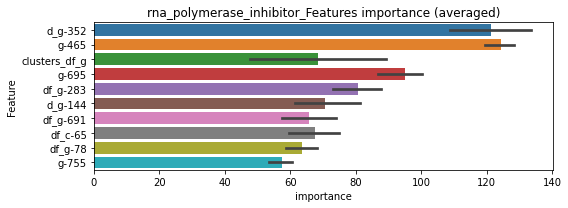

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175043	valid_1's binary_logloss: 0.0310956
[200]	training's binary_logloss: 0.00254261	valid_1's binary_logloss: 0.0121145
[300]	training's binary_logloss: 0.000715829	valid_1's binary_logloss: 0.00868326
[400]	training's binary_logloss: 0.000351109	valid_1's binary_logloss: 0.00795815
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000317247	valid_1's binary_logloss: 0.00784961


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177426	valid_1's binary_logloss: 0.0279145
[200]	training's binary_logloss: 0.00256579	valid_1's binary_logloss: 0.00998093
[300]	training's binary_logloss: 0.000722124	valid_1's binary_logloss: 0.00742567
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00045438	valid_1's binary_logloss: 0.00697456


rna_polymerase_inhibitor logloss: 0.0074120843180811025
serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104765	valid_1's binary_logloss: 0.265204
[200]	training's binary_logloss: 0.0371725	valid_1's binary_logloss: 0.234217
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0313951	valid_1's binary_logloss: 0.232057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113267	valid_1's binary_logloss: 0.272854
[200]	training's binary_logloss: 0.0418912	valid_1's binary_logloss: 0.233875
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0314598	valid_1's binary_logloss: 0.230185


1 / 3 AUC score:0.919
y_Threshold: 0.0883422, Threshold: 0.1142861, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 375 → Positive_corect_labels: 527/3523
p_label_rate: 0.0200904 Vs.target_rate: 0.00991, Num_p_label: 80.0, conf_0:0.10286, conf_1:0.12571
threshold: 0.1142861, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 527.0/3523, y_label_rate: 0.1495884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827083	valid_1's binary_logloss: 0.19756
[200]	training's binary_logloss: 0.0257178	valid_1's binary_logloss: 0.143803
[300]	training's binary_logloss: 0.00908577	valid_1's binary_logloss: 0.128594
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0048428	valid_1's binary_logloss: 0.125403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874921	valid_1's binary_logloss: 0.202607
[200]	training's binary_logloss: 0.0268334	valid_1's binary_logloss: 0.160915
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0150301	valid_1's binary_logloss: 0.155497


2 / 3 AUC score:0.976
y_Threshold: 0.0813072, Threshold: 0.1142861, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 460.0/3389
p_label_rate: 0.0087896 Vs.target_rate: 0.00991, Num_p_label: 35.0, conf_0:0.10286, conf_1:0.12571
threshold: 0.1142861, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 460.0/3389, y_label_rate: 0.1357333
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069349	valid_1's binary_logloss: 0.164336
[200]	training's binary_logloss: 0.01951	valid_1's binary_logloss: 0.127921
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0106567	valid_1's binary_logloss: 0.120754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669281	valid_1's binary_logloss: 0.171817
[200]	training's binary_logloss: 0.0177092	valid_1's binary_logloss: 0.127543


3 / 3 AUC score:0.990
y_Threshold: 0.0737384, Threshold: 0.1142861, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00773479	valid_1's binary_logloss: 0.118022


Remove_noisy_labels: 74 → Positive_corect_labels: 423.0/3315
p_label_rate: 0.0052737 Vs.target_rate: 0.00991, Num_p_label: 21.0, conf_0:0.10286, conf_1:0.12571
threshold: 0.1142861, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 444.0/7297, y_label_rate: 0.0608469


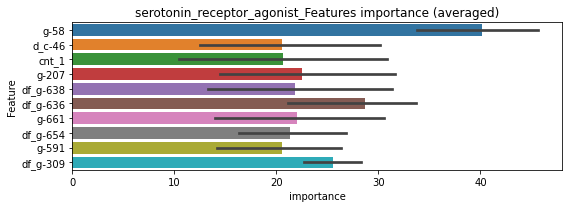

len(train_index) : 3648
len(valid_index) : 3649
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358518	valid_1's binary_logloss: 0.0940879
[200]	training's binary_logloss: 0.00998246	valid_1's binary_logloss: 0.0752301
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00985037	valid_1's binary_logloss: 0.0751914


len(train_index) : 3649
len(valid_index) : 3648
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321166	valid_1's binary_logloss: 0.0791566
[200]	training's binary_logloss: 0.00870705	valid_1's binary_logloss: 0.0601464
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00352932	valid_1's binary_logloss: 0.055549


serotonin_receptor_agonist logloss: 0.06537154433094636


neg labels: 3289 → selected neg labels: 3220


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14011	valid_1's binary_logloss: 0.360523
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.104172	valid_1's binary_logloss: 0.354647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139712	valid_1's binary_logloss: 0.358423


1 / 3 AUC score:0.806
y_Threshold: 0.1591422, Threshold: 0.2095425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 673 → Positive_corect_labels: 372/3191
p_label_rate: 0.0200904 Vs.target_rate: 0.01696, Num_p_label: 80.0, conf_0:0.18859, conf_1:0.23050


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0813728	valid_1's binary_logloss: 0.346446


threshold: 0.2095425, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 372.0/3191, y_label_rate: 0.1165779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693523	valid_1's binary_logloss: 0.239858
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0294989	valid_1's binary_logloss: 0.224342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730283	valid_1's binary_logloss: 0.21743
[200]	training's binary_logloss: 0.02281	valid_1's binary_logloss: 0.188888


2 / 3 AUC score:0.939
y_Threshold: 0.1059464, Threshold: 0.2095425, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0161893	valid_1's binary_logloss: 0.186167


Remove_noisy_labels: 216 → Positive_corect_labels: 264.0/2975
p_label_rate: 0.0077850 Vs.target_rate: 0.01696, Num_p_label: 31.0, conf_0:0.18859, conf_1:0.23050
threshold: 0.2095425, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 264.0/2975, y_label_rate: 0.0887395
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049104	valid_1's binary_logloss: 0.15649
[200]	training's binary_logloss: 0.0129693	valid_1's binary_logloss: 0.129113
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00928554	valid_1's binary_logloss: 0.125772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405176	valid_1's binary_logloss: 0.184137


3 / 3 AUC score:0.959
y_Threshold: 0.0799360, Threshold: 0.2095425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 211.0/2869
p_label_rate: 0.0040181 Vs.target_rate: 0.01696, Num_p_label: 16.0, conf_0:0.18859, conf_1:0.23050
Num_p_label: 16.0, Expected: 67.6, Adj_threshold_1: 0.2095425
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_2: 0.1995425
Num_p_label: 26.0, Expected: 67.6, Adj_threshold_3: 0.1895425


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0248594	valid_1's binary_logloss: 0.176547


Num_p_label: 28.0, Expected: 67.6, Adj_threshold_4: 0.1795425
Num_p_label: 31.0, Expected: 67.6, Adj_threshold_5: 0.1695425
Num_p_label: 35.0, Expected: 67.6, Adj_threshold_6: 0.1595425
threshold: 0.1595425, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 246.0/6851, y_label_rate: 0.0359072


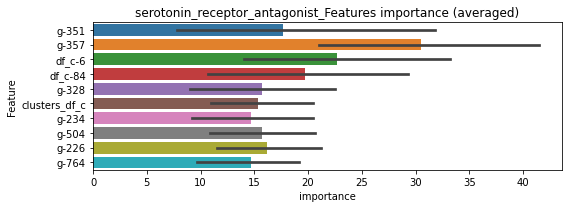

len(train_index) : 3425
len(valid_index) : 3426
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179131	valid_1's binary_logloss: 0.089745
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00973964	valid_1's binary_logloss: 0.0853025


len(train_index) : 3426
len(valid_index) : 3425
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170814	valid_1's binary_logloss: 0.10075
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00917995	valid_1's binary_logloss: 0.0993648


serotonin_receptor_antagonist logloss: 0.09233265012366781
serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434647	valid_1's binary_logloss: 0.0777589
[200]	training's binary_logloss: 0.00760065	valid_1's binary_logloss: 0.028143
[300]	training's binary_logloss: 0.00209912	valid_1's binary_logloss: 0.0158481
[400]	training's binary_logloss: 0.000982026	valid_1's binary_logloss: 0.0117342
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000655459	valid_1's binary_logloss: 0.0106174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472883	valid_1's binary_logloss: 0.0734332
[200]	training's binary_logloss: 0.00858816	valid_1's binary_logloss: 0.0255745
[300]	training's binary_logloss: 0.00233319	valid_1's binary_logloss: 0.0132718
[400]	training's binary_logloss: 0.00105992	valid_1's binary_logloss: 0.00932327
[500]	training's binary_logloss: 0.00066799	valid_1's binary_logloss: 0.00803064
Early stopping, best iteration is:
[557]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0047983, Threshold: 0.0070967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00185, Num_p_label: 80.0, conf_0:0.00639, conf_1:0.00781
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0070967
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_2: 0.0170967
threshold: 0.0170967, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449394	valid_1's binary_logloss: 0.075447
[200]	training's binary_logloss: 0.00779489	valid_1's binary_logloss: 0.0254767
[300]	training's binary_logloss: 0.00213975	valid_1's binary_logloss: 0.0139137
[400]	training's binary_logloss: 0.000992774	valid_1's binary_logloss: 0.0104787
[500]	training's binary_logloss: 0.000629676	valid_1's binary_logloss: 0.00892858
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000590626	valid_1's binary_logloss: 0.00877257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454084	valid_1's binary_logloss: 0.0712128
[200]	training's binary_logloss: 0.00824469	valid_1's binary_logloss: 0.0244797
[300]	training's binary_logloss: 0.00224494	valid_1's binary_logloss: 0.0136442
[400]	training's binary_logloss: 0.00103108	valid_1's binary_logloss: 0.0103724
[500]	training's binary_logloss: 0.000661

2 / 3 AUC score:1.000
y_Threshold: 0.0299585, Threshold: 0.0170967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00185, Num_p_label: 33.0, conf_0:0.01539, conf_1:0.01881
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_1: 0.0170967
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_2: 0.0270967
threshold: 0.0270967, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449394	valid_1's binary_logloss: 0.075447
[200]	training's binary_logloss: 0.00779489	valid_1's binary_logloss: 0.0254767
[300]	training's binary_logloss: 0.00213975	valid_1's binary_logloss: 0.0139137
[400]	training's binary_logloss: 0.000992774	valid_1's binary_logloss: 0.0104787
[500]	training's binary_logloss: 0.000629676	valid_1's binary_logloss: 0.00892858
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000590626	valid_1's binary_logloss: 0.00877257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454084	valid_1's binary_logloss: 0.0712128
[200]	training's binary_logloss: 0.00824469	valid_1's binary_logloss: 0.0244797
[300]	training's binary_logloss: 0.00224494	valid_1's binary_logloss: 0.0136442
[400]	training's binary_logloss: 0.00103108	valid_1's binary_logloss: 0.0103724
[500]	training's binary_logloss: 0.000661

3 / 3 AUC score:1.000
y_Threshold: 0.0299585, Threshold: 0.0270967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0022602 Vs.target_rate: 0.00185, Num_p_label: 9.0, conf_0:0.02439, conf_1:0.02981
threshold: 0.0270967, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


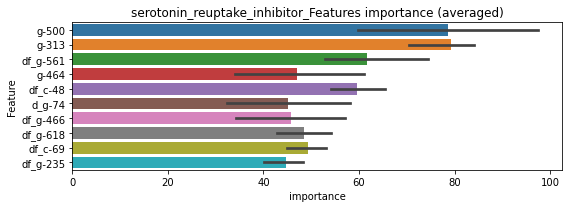

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257455	valid_1's binary_logloss: 0.0486691
[200]	training's binary_logloss: 0.0044663	valid_1's binary_logloss: 0.0211034
[300]	training's binary_logloss: 0.00116138	valid_1's binary_logloss: 0.0162467
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000606997	valid_1's binary_logloss: 0.0150894


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264147	valid_1's binary_logloss: 0.0482602
[200]	training's binary_logloss: 0.00472205	valid_1's binary_logloss: 0.0197164
[300]	training's binary_logloss: 0.00127405	valid_1's binary_logloss: 0.0138828
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000793898	valid_1's binary_logloss: 0.0127644


serotonin_reuptake_inhibitor logloss: 0.013927050147376753
sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041866	valid_1's binary_logloss: 0.0634426
[200]	training's binary_logloss: 0.00681073	valid_1's binary_logloss: 0.0191351
[300]	training's binary_logloss: 0.00182384	valid_1's binary_logloss: 0.00961313
[400]	training's binary_logloss: 0.000857249	valid_1's binary_logloss: 0.00714515
[500]	training's binary_logloss: 0.000561349	valid_1's binary_logloss: 0.00597039
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000484301	valid_1's binary_logloss: 0.00567369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433874	valid_1's binary_logloss: 0.0661361
[200]	training's binary_logloss: 0.00709175	valid_1's binary_logloss: 0.0210895
[300]	training's binary_logloss: 0.00190186	valid_1's binary_logloss: 0.011457
[400]	training's binary_logloss: 0.000889906	valid_1's binary_logloss: 0.00910627
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0039513, Threshold: 0.0066563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00599, conf_1:0.00732
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0066563
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0166563
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0266563
threshold: 0.0266563, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400757	valid_1's binary_logloss: 0.0617796
[200]	training's binary_logloss: 0.00640629	valid_1's binary_logloss: 0.0185846
[300]	training's binary_logloss: 0.0017718	valid_1's binary_logloss: 0.00943364
[400]	training's binary_logloss: 0.000842479	valid_1's binary_logloss: 0.006743
[500]	training's binary_logloss: 0.000559264	valid_1's binary_logloss: 0.00572437
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000498014	valid_1's binary_logloss: 0.00556851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409413	valid_1's binary_logloss: 0.0631552
[200]	training's binary_logloss: 0.00672871	valid_1's binary_logloss: 0.0199413
[300]	training's binary_logloss: 0.00184209	valid_1's binary_logloss: 0.0108953
[400]	training's binary_logloss: 0.000864267	valid_1's binary_logloss: 0.009341
[500]	training's binary_logloss: 0.000567

2 / 3 AUC score:1.000
y_Threshold: 0.0319682, Threshold: 0.0266563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0057760 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.02399, conf_1:0.02932
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.0266563
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0366563
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0466563
threshold: 0.0466563, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039494	valid_1's binary_logloss: 0.0654383
[200]	training's binary_logloss: 0.00611296	valid_1's binary_logloss: 0.0253905
[300]	training's binary_logloss: 0.00170882	valid_1's binary_logloss: 0.0162252
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000939355	valid_1's binary_logloss: 0.0133648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427299	valid_1's binary_logloss: 0.0631405
[200]	training's binary_logloss: 0.00702937	valid_1's binary_logloss: 0.0201627
[300]	training's binary_logloss: 0.00188973	valid_1's binary_logloss: 0.0104753
[400]	training's binary_logloss: 0.000877561	valid_1's binary_logloss: 0.00776188
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000770111	valid_1's binary_logloss: 0.00751344


3 / 3 AUC score:1.000
y_Threshold: 0.0275966, Threshold: 0.0466563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0047715 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.04199, conf_1:0.05132
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0466563
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0566563
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0666563
threshold: 0.0666563, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 664.0/7785, y_label_rate: 0.0852922


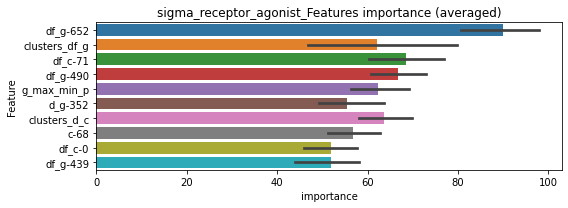

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234226	valid_1's binary_logloss: 0.0400451
[200]	training's binary_logloss: 0.00384476	valid_1's binary_logloss: 0.017004
[300]	training's binary_logloss: 0.00100547	valid_1's binary_logloss: 0.0121625
[400]	training's binary_logloss: 0.000461501	valid_1's binary_logloss: 0.0110152
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000413364	valid_1's binary_logloss: 0.0109543


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242361	valid_1's binary_logloss: 0.040915
[200]	training's binary_logloss: 0.00390545	valid_1's binary_logloss: 0.018665
[300]	training's binary_logloss: 0.00104981	valid_1's binary_logloss: 0.014731
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000666782	valid_1's binary_logloss: 0.0142638


sigma_receptor_agonist logloss: 0.012608851654593637
sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356179	valid_1's binary_logloss: 0.0547381
[200]	training's binary_logloss: 0.00556691	valid_1's binary_logloss: 0.0159491
[300]	training's binary_logloss: 0.0015742	valid_1's binary_logloss: 0.00739463
[400]	training's binary_logloss: 0.000773513	valid_1's binary_logloss: 0.00497796
[500]	training's binary_logloss: 0.000519586	valid_1's binary_logloss: 0.00399976
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000463596	valid_1's binary_logloss: 0.0037858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389743	valid_1's binary_logloss: 0.0622441
[200]	training's binary_logloss: 0.00617218	valid_1's binary_logloss: 0.0212163
[300]	training's binary_logloss: 0.00170193	valid_1's binary_logloss: 0.0126442
[400]	training's binary_logloss: 0.000812543	valid_1's binary_logloss: 0.0101891
Early stopping, best iteration is:
[486

1 / 3 AUC score:1.000
y_Threshold: 0.0034067, Threshold: 0.0062739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00565, conf_1:0.00690
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0062739
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0162739
Num_p_label: 3.0, Expected: 6.0, Adj_threshold_3: 0.0262739
threshold: 0.0262739, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380616	valid_1's binary_logloss: 0.0566888
[200]	training's binary_logloss: 0.00577608	valid_1's binary_logloss: 0.0146134
[300]	training's binary_logloss: 0.00162423	valid_1's binary_logloss: 0.00639823
[400]	training's binary_logloss: 0.000788648	valid_1's binary_logloss: 0.00412043
[500]	training's binary_logloss: 0.00052516	valid_1's binary_logloss: 0.0032334
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000479095	valid_1's binary_logloss: 0.00306486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378343	valid_1's binary_logloss: 0.0593344
[200]	training's binary_logloss: 0.00572391	valid_1's binary_logloss: 0.0185689
[300]	training's binary_logloss: 0.00161589	valid_1's binary_logloss: 0.0106816
[400]	training's binary_logloss: 0.000787871	valid_1's binary_logloss: 0.00863571
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0310267, Threshold: 0.0262739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0092918 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.02365, conf_1:0.02890
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.0262739
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0362739
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0462739
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0562739
threshold: 0.0562739, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381547	valid_1's binary_logloss: 0.0554562
[200]	training's binary_logloss: 0.00579792	valid_1's binary_logloss: 0.0133793
[300]	training's binary_logloss: 0.00161503	valid_1's binary_logloss: 0.00537481
[400]	training's binary_logloss: 0.00078643	valid_1's binary_logloss: 0.00344717
[500]	training's binary_logloss: 0.000523085	valid_1's binary_logloss: 0.0026372
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000466023	valid_1's binary_logloss: 0.0024802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359992	valid_1's binary_logloss: 0.06085
[200]	training's binary_logloss: 0.00541437	valid_1's binary_logloss: 0.0209839
[300]	training's binary_logloss: 0.00153079	valid_1's binary_logloss: 0.0125806
[400]	training's binary_logloss: 0.000762619	valid_1's binary_logloss: 0.0096134
[500]	training's binary_logloss: 0.0005156

3 / 3 AUC score:1.000
y_Threshold: 0.0372231, Threshold: 0.0562739, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.05065, conf_1:0.06190
threshold: 0.0562739, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


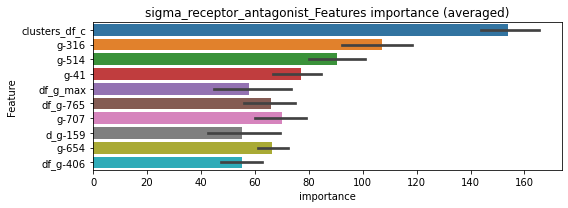

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206794	valid_1's binary_logloss: 0.0369889
[200]	training's binary_logloss: 0.00309026	valid_1's binary_logloss: 0.0159723
[300]	training's binary_logloss: 0.000856501	valid_1's binary_logloss: 0.0123428
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000607506	valid_1's binary_logloss: 0.0118747


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206485	valid_1's binary_logloss: 0.0405742
[200]	training's binary_logloss: 0.00320485	valid_1's binary_logloss: 0.0168184
[300]	training's binary_logloss: 0.000904169	valid_1's binary_logloss: 0.0118728
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000509763	valid_1's binary_logloss: 0.0107964


sigma_receptor_antagonist logloss: 0.011335631615512024
smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275722	valid_1's binary_logloss: 0.0383052
[200]	training's binary_logloss: 0.0037879	valid_1's binary_logloss: 0.00861241
[300]	training's binary_logloss: 0.00109573	valid_1's binary_logloss: 0.00397917
[400]	training's binary_logloss: 0.00055961	valid_1's binary_logloss: 0.00273689
[500]	training's binary_logloss: 0.000412854	valid_1's binary_logloss: 0.0023891
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00040918	valid_1's binary_logloss: 0.00238025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026905	valid_1's binary_logloss: 0.0373839
[200]	training's binary_logloss: 0.00363172	valid_1's binary_logloss: 0.00847914
[300]	training's binary_logloss: 0.0010511	valid_1's binary_logloss: 0.00411947
[400]	training's binary_logloss: 0.00055263	valid_1's binary_logloss: 0.0029085
[500]	training's binary_logloss: 0.000413

1 / 3 AUC score:1.000
y_Threshold: 0.0018851, Threshold: 0.0037163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00334, conf_1:0.00409
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0037163
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.0137163
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.0237163
threshold: 0.0237163, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270229	valid_1's binary_logloss: 0.0367473
[200]	training's binary_logloss: 0.00361998	valid_1's binary_logloss: 0.00799508
[300]	training's binary_logloss: 0.00106086	valid_1's binary_logloss: 0.00385089
[400]	training's binary_logloss: 0.000547366	valid_1's binary_logloss: 0.00271688
[500]	training's binary_logloss: 0.000410313	valid_1's binary_logloss: 0.00239275
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000404779	valid_1's binary_logloss: 0.00237772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270619	valid_1's binary_logloss: 0.0365831
[200]	training's binary_logloss: 0.00359342	valid_1's binary_logloss: 0.0076098
[300]	training's binary_logloss: 0.00104929	valid_1's binary_logloss: 0.00341065
[400]	training's binary_logloss: 0.000545752	valid_1's binary_logloss: 0.00235298
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0259338, Threshold: 0.0237163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0032647 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.02134, conf_1:0.02609
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.0237163
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_2: 0.0337163
threshold: 0.0337163, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270229	valid_1's binary_logloss: 0.0367473
[200]	training's binary_logloss: 0.00361998	valid_1's binary_logloss: 0.00799508
[300]	training's binary_logloss: 0.00106086	valid_1's binary_logloss: 0.00385089
[400]	training's binary_logloss: 0.000547366	valid_1's binary_logloss: 0.00271688
[500]	training's binary_logloss: 0.000410313	valid_1's binary_logloss: 0.00239275
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000404779	valid_1's binary_logloss: 0.00237772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270619	valid_1's binary_logloss: 0.0365831
[200]	training's binary_logloss: 0.00359342	valid_1's binary_logloss: 0.0076098
[300]	training's binary_logloss: 0.00104929	valid_1's binary_logloss: 0.00341065
[400]	training's binary_logloss: 0.000545752	valid_1's binary_logloss: 0.00235298
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0259338, Threshold: 0.0337163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0010045 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.03034, conf_1:0.03709
threshold: 0.0337163, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 660.0/7790, y_label_rate: 0.0847240


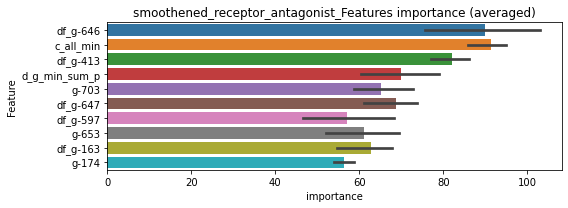

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147285	valid_1's binary_logloss: 0.0228584
[200]	training's binary_logloss: 0.00194926	valid_1's binary_logloss: 0.00717141
[300]	training's binary_logloss: 0.000552287	valid_1's binary_logloss: 0.00527417
[400]	training's binary_logloss: 0.000280472	valid_1's binary_logloss: 0.0050183
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000294356	valid_1's binary_logloss: 0.00501443


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145456	valid_1's binary_logloss: 0.0217938
[200]	training's binary_logloss: 0.00189799	valid_1's binary_logloss: 0.00554285
[300]	training's binary_logloss: 0.000553968	valid_1's binary_logloss: 0.00340854
[400]	training's binary_logloss: 0.000286061	valid_1's binary_logloss: 0.00293152
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000220962	valid_1's binary_logloss: 0.00275909


smoothened_receptor_antagonist logloss: 0.0038867612908789102
sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11386	valid_1's binary_logloss: 0.289281
[200]	training's binary_logloss: 0.0419966	valid_1's binary_logloss: 0.257455
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.032482	valid_1's binary_logloss: 0.254585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12252	valid_1's binary_logloss: 0.277843
[200]	training's binary_logloss: 0.0462957	valid_1's binary_logloss: 0.232067
[300]	training's binary_logloss: 0.0181613	valid_1's binary_logloss: 0.2215
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.018938	valid_1's binary_logloss: 0.221167


1 / 3 AUC score:0.915
y_Threshold: 0.0827608, Threshold: 0.1123873, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 401 → Positive_corect_labels: 513/3491
p_label_rate: 0.0200904 Vs.target_rate: 0.01121, Num_p_label: 80.0, conf_0:0.10115, conf_1:0.12363
threshold: 0.1123873, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 513.0/3491, y_label_rate: 0.1469493
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853098	valid_1's binary_logloss: 0.215073
[200]	training's binary_logloss: 0.0260257	valid_1's binary_logloss: 0.170303
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0125656	valid_1's binary_logloss: 0.161314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856488	valid_1's binary_logloss: 0.22213
[200]	training's binary_logloss: 0.0265304	valid_1's binary_logloss: 0.187187
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0156669	valid_1's binary_logloss: 0.18246


2 / 3 AUC score:0.964
y_Threshold: 0.0804303, Threshold: 0.1123873, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 439.0/3343
p_label_rate: 0.0128076 Vs.target_rate: 0.01121, Num_p_label: 51.0, conf_0:0.10115, conf_1:0.12363
threshold: 0.1123873, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 439.0/3343, y_label_rate: 0.1313192
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679066	valid_1's binary_logloss: 0.178961
[200]	training's binary_logloss: 0.0181472	valid_1's binary_logloss: 0.13879
[300]	training's binary_logloss: 0.00619998	valid_1's binary_logloss: 0.128635
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00545756	valid_1's binary_logloss: 0.128179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721994	valid_1's binary_logloss: 0.18851
[200]	training's binary_logloss: 0.0204324	valid_1's binary_logloss: 0.154569


3 / 3 AUC score:0.978
y_Threshold: 0.0799365, Threshold: 0.1123873, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 381.0/3227


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.018142	valid_1's binary_logloss: 0.153075


p_label_rate: 0.0120542 Vs.target_rate: 0.01121, Num_p_label: 48.0, conf_0:0.10115, conf_1:0.12363
threshold: 0.1123873, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 429.0/7209, y_label_rate: 0.0595089


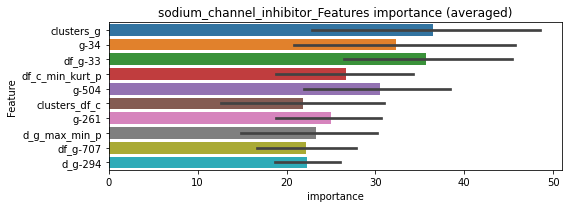

len(train_index) : 3604
len(valid_index) : 3605
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352821	valid_1's binary_logloss: 0.108643
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0155195	valid_1's binary_logloss: 0.0980657


len(train_index) : 3605
len(valid_index) : 3604
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035757	valid_1's binary_logloss: 0.105478
[200]	training's binary_logloss: 0.00973645	valid_1's binary_logloss: 0.0880666


sodium_channel_inhibitor logloss: 0.09301933055600606


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0100165	valid_1's binary_logloss: 0.0879716
neg labels: 3289 → selected neg labels: 3283


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336978	valid_1's binary_logloss: 0.0517153
[200]	training's binary_logloss: 0.00505283	valid_1's binary_logloss: 0.013147
[300]	training's binary_logloss: 0.00143384	valid_1's binary_logloss: 0.00564035
[400]	training's binary_logloss: 0.000708224	valid_1's binary_logloss: 0.00375047
[500]	training's binary_logloss: 0.0004833	valid_1's binary_logloss: 0.00310572
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000442646	valid_1's binary_logloss: 0.00296261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341781	valid_1's binary_logloss: 0.057956
[200]	training's binary_logloss: 0.00521587	valid_1's binary_logloss: 0.0233161
[300]	training's binary_logloss: 0.00148239	valid_1's binary_logloss: 0.0177428
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0010752	valid_1's binary_logloss: 0.0170079


1 / 3 AUC score:1.000
y_Threshold: 0.0047883, Threshold: 0.0090109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00811, conf_1:0.00991
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0090109
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_2: 0.0190109
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_3: 0.0290109
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_4: 0.0390109
threshold: 0.0390109, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342025	valid_1's binary_logloss: 0.0509639
[200]	training's binary_logloss: 0.00489914	valid_1's binary_logloss: 0.0114064
[300]	training's binary_logloss: 0.00139672	valid_1's binary_logloss: 0.0046723
[400]	training's binary_logloss: 0.000690524	valid_1's binary_logloss: 0.00306161
[500]	training's binary_logloss: 0.000474896	valid_1's binary_logloss: 0.00245295
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000433817	valid_1's binary_logloss: 0.00236076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032837	valid_1's binary_logloss: 0.057126
[200]	training's binary_logloss: 0.0047764	valid_1's binary_logloss: 0.0208425
[300]	training's binary_logloss: 0.00138397	valid_1's binary_logloss: 0.0150614
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00107233	valid_1's binary_logloss: 0.0142904


2 / 3 AUC score:1.000
y_Threshold: 0.0194646, Threshold: 0.0390109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0065294 Vs.target_rate: 0.00134, Num_p_label: 26.0, conf_0:0.03511, conf_1:0.04291
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_1: 0.0390109
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_2: 0.0490109
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_3: 0.0590109
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_4: 0.0690109
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_5: 0.0790109
threshold: 0.0790109, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334152	valid_1's binary_logloss: 0.0517464
[200]	training's binary_logloss: 0.0047738	valid_1's binary_logloss: 0.0126222
[300]	training's binary_logloss: 0.00136558	valid_1's binary_logloss: 0.00577539
[400]	training's binary_logloss: 0.000684847	valid_1's binary_logloss: 0.00381021
[500]	training's binary_logloss: 0.000471966	valid_1's binary_logloss: 0.00320173
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000452484	valid_1's binary_logloss: 0.00312477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329727	valid_1's binary_logloss: 0.0559647
[200]	training's binary_logloss: 0.00481058	valid_1's binary_logloss: 0.0160639
[300]	training's binary_logloss: 0.00136104	valid_1's binary_logloss: 0.00822551
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0011179	valid_1's binary_logloss: 0.00751056


3 / 3 AUC score:1.000
y_Threshold: 0.0448351, Threshold: 0.0790109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0027624 Vs.target_rate: 0.00134, Num_p_label: 11.0, conf_0:0.07111, conf_1:0.08691
threshold: 0.0790109, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 663.0/7781, y_label_rate: 0.0852076


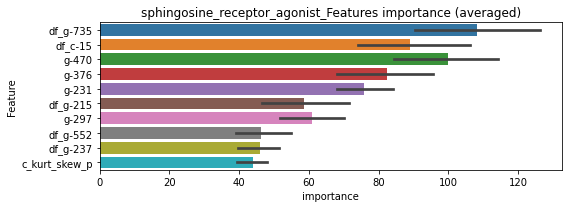

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190173	valid_1's binary_logloss: 0.0345275
[200]	training's binary_logloss: 0.00280367	valid_1's binary_logloss: 0.0139575
[300]	training's binary_logloss: 0.000768297	valid_1's binary_logloss: 0.0104455
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000557404	valid_1's binary_logloss: 0.0100309


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190781	valid_1's binary_logloss: 0.0291363
[200]	training's binary_logloss: 0.00289748	valid_1's binary_logloss: 0.00894718
[300]	training's binary_logloss: 0.000836433	valid_1's binary_logloss: 0.00543447
[400]	training's binary_logloss: 0.000401561	valid_1's binary_logloss: 0.00454645
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000291027	valid_1's binary_logloss: 0.00432164


sphingosine_receptor_agonist logloss: 0.007176635349137866
src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443257	valid_1's binary_logloss: 0.0834671
[200]	training's binary_logloss: 0.00830678	valid_1's binary_logloss: 0.0362812
[300]	training's binary_logloss: 0.00251052	valid_1's binary_logloss: 0.0250938
[400]	training's binary_logloss: 0.00122145	valid_1's binary_logloss: 0.0219951
[500]	training's binary_logloss: 0.000773426	valid_1's binary_logloss: 0.0201349
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00062743	valid_1's binary_logloss: 0.0195313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452541	valid_1's binary_logloss: 0.0869782
[200]	training's binary_logloss: 0.00873321	valid_1's binary_logloss: 0.0400194
[300]	training's binary_logloss: 0.00259964	valid_1's binary_logloss: 0.0284054
[400]	training's binary_logloss: 0.00123306	valid_1's binary_logloss: 0.0245298
[500]	training's binary_logloss: 0.000782369

1 / 3 AUC score:1.000
y_Threshold: 0.0100968, Threshold: 0.0292017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00298, Num_p_label: 80.0, conf_0:0.02628, conf_1:0.03212
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0292017
Num_p_label: 67.0, Expected: 11.9, Adj_threshold_2: 0.0392017
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_3: 0.0492017
Num_p_label: 46.0, Expected: 11.9, Adj_threshold_4: 0.0592017
Num_p_label: 38.0, Expected: 11.9, Adj_threshold_5: 0.0692017
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_6: 0.0792017
Num_p_label: 31.0, Expected: 11.9, Adj_threshold_7: 0.0892017
Num_p_label: 28.0, Expected: 11.9, Adj_threshold_8: 0.0992017
Num_p_label: 23.0, Expected: 11.9, Adj_threshold_9: 0.1092017
threshold: 0.1092017, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 654.0/3798, y_label_rate: 0.1721959
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422695	valid_1's binary_logloss: 0.0851924
[200]	training's binary_logloss: 0.00761653	valid_1's binary_logloss: 0.0335566
[300]	training's binary_logloss: 0.00227489	valid_1's binary_logloss: 0.0205766
[400]	training's binary_logloss: 0.00109898	valid_1's binary_logloss: 0.0167646
[500]	training's binary_logloss: 0.000705367	valid_1's binary_logloss: 0.0146408
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000661168	valid_1's binary_logloss: 0.0143709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409856	valid_1's binary_logloss: 0.0965664
[200]	training's binary_logloss: 0.00712871	valid_1's binary_logloss: 0.0462575
[300]	training's binary_logloss: 0.00216359	valid_1's binary_logloss: 0.0347491
[400]	training's binary_logloss: 0.00104564	valid_1's binary_logloss: 0.0310498
Early stopping, best iteration is:
[407]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.1183167, Threshold: 0.1092017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 645.0/3780
p_label_rate: 0.0266198 Vs.target_rate: 0.00298, Num_p_label: 106.0, conf_0:0.09828, conf_1:0.12012
Num_p_label: 106.0, Expected: 11.9, Adj_threshold_1: 0.1092017
Num_p_label: 97.0, Expected: 11.9, Adj_threshold_2: 0.1192017
Num_p_label: 92.0, Expected: 11.9, Adj_threshold_3: 0.1292017
Num_p_label: 82.0, Expected: 11.9, Adj_threshold_4: 0.1392017
Num_p_label: 82.0, Expected: 11.9, Adj_threshold_5: 0.1492017
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_6: 0.1592017
Num_p_label: 68.0, Expected: 11.9, Adj_threshold_7: 0.1692017
Num_p_label: 68.0, Expected: 11.9, Adj_threshold_8: 0.1792017
Num_p_label: 63.0, Expected: 11.9, Adj_threshold_9: 0.1892017
Num_p_label: 58.0, Expected: 11.9, Adj_threshold_10: 0.1992017
threshold: 0.2092017, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 645.0/3780, y_label_rate: 0.170

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392229	valid_1's binary_logloss: 0.0853907
[200]	training's binary_logloss: 0.00681812	valid_1's binary_logloss: 0.0414783
[300]	training's binary_logloss: 0.00204647	valid_1's binary_logloss: 0.0316187
[400]	training's binary_logloss: 0.00100018	valid_1's binary_logloss: 0.0288506
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000820972	valid_1's binary_logloss: 0.0284169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397375	valid_1's binary_logloss: 0.0916898
[200]	training's binary_logloss: 0.00684762	valid_1's binary_logloss: 0.046966
[300]	training's binary_logloss: 0.00204297	valid_1's binary_logloss: 0.0387505
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00148045	valid_1's binary_logloss: 0.0378795


3 / 3 AUC score:0.996
y_Threshold: 0.0683114, Threshold: 0.2092017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3764
p_label_rate: 0.0180814 Vs.target_rate: 0.00298, Num_p_label: 72.0, conf_0:0.18828, conf_1:0.23012
Num_p_label: 72.0, Expected: 11.9, Adj_threshold_1: 0.2092017
Num_p_label: 70.0, Expected: 11.9, Adj_threshold_2: 0.2192017
Num_p_label: 67.0, Expected: 11.9, Adj_threshold_3: 0.2292017
Num_p_label: 64.0, Expected: 11.9, Adj_threshold_4: 0.2392017
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_5: 0.2492017
Num_p_label: 57.0, Expected: 11.9, Adj_threshold_6: 0.2592017
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_7: 0.2692017
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_8: 0.2792017
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_9: 0.2892017
Num_p_label: 48.0, Expected: 11.9, Adj_threshold_10: 0.2992017
threshold: 0.3092017, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 683.0/7746, y_label_rate: 0.08817

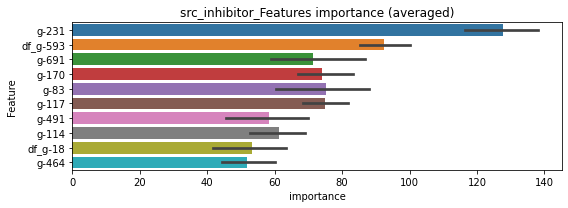

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223343	valid_1's binary_logloss: 0.0563827
[200]	training's binary_logloss: 0.0041645	valid_1's binary_logloss: 0.0305936
[300]	training's binary_logloss: 0.00126634	valid_1's binary_logloss: 0.0223121
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000727572	valid_1's binary_logloss: 0.0202652


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232756	valid_1's binary_logloss: 0.0603487
[200]	training's binary_logloss: 0.0041459	valid_1's binary_logloss: 0.0376501
[300]	training's binary_logloss: 0.00122841	valid_1's binary_logloss: 0.0317632
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000810876	valid_1's binary_logloss: 0.0313493


src_inhibitor logloss: 0.025807225407589767
steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573978	valid_1's binary_logloss: 0.12561
[200]	training's binary_logloss: 0.0127959	valid_1's binary_logloss: 0.0726722
[300]	training's binary_logloss: 0.00369853	valid_1's binary_logloss: 0.0571926
[400]	training's binary_logloss: 0.00163475	valid_1's binary_logloss: 0.0522043
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00155598	valid_1's binary_logloss: 0.0520721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616958	valid_1's binary_logloss: 0.111792
[200]	training's binary_logloss: 0.0132678	valid_1's binary_logloss: 0.0514527
[300]	training's binary_logloss: 0.00390928	valid_1's binary_logloss: 0.0346408
[400]	training's binary_logloss: 0.00172984	valid_1's binary_logloss: 0.0290465
[500]	training's binary_logloss: 0.00103613	valid_1's binary_logloss: 0.0271783
Early stopping, best iteration is:
[562]	training'

1 / 3 AUC score:0.997
y_Threshold: 0.0123532, Threshold: 0.0206310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00332, Num_p_label: 80.0, conf_0:0.01857, conf_1:0.02269
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0206310
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_2: 0.0306310
Num_p_label: 27.0, Expected: 13.2, Adj_threshold_3: 0.0406310
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_4: 0.0506310
threshold: 0.0506310, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 650.0/3789, y_label_rate: 0.1715492
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571595	valid_1's binary_logloss: 0.113807
[200]	training's binary_logloss: 0.0119289	valid_1's binary_logloss: 0.0582574
[300]	training's binary_logloss: 0.00347515	valid_1's binary_logloss: 0.0411915
[400]	training's binary_logloss: 0.00154209	valid_1's binary_logloss: 0.0357043
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00123133	valid_1's binary_logloss: 0.0345585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057497	valid_1's binary_logloss: 0.11353
[200]	training's binary_logloss: 0.0122609	valid_1's binary_logloss: 0.0552654
[300]	training's binary_logloss: 0.00364774	valid_1's binary_logloss: 0.0377779
[400]	training's binary_logloss: 0.00163065	valid_1's binary_logloss: 0.0325583
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00120422	valid_1's binary_logloss: 0.0308294


2 / 3 AUC score:1.000
y_Threshold: 0.0502023, Threshold: 0.0506310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0143144 Vs.target_rate: 0.00332, Num_p_label: 57.0, conf_0:0.04557, conf_1:0.05569
Num_p_label: 57.0, Expected: 13.2, Adj_threshold_1: 0.0506310
Num_p_label: 49.0, Expected: 13.2, Adj_threshold_2: 0.0606310
Num_p_label: 37.0, Expected: 13.2, Adj_threshold_3: 0.0706310
Num_p_label: 30.0, Expected: 13.2, Adj_threshold_4: 0.0806310
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_5: 0.0906310
Num_p_label: 27.0, Expected: 13.2, Adj_threshold_6: 0.1006310
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_7: 0.1106310
threshold: 0.1106310, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 643.0/3775, y_label_rate: 0.1703311
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561417	valid_1's binary_logloss: 0.109621
[200]	training's binary_logloss: 0.0115643	valid_1's binary_logloss: 0.0539708
[300]	training's binary_logloss: 0.0033461	valid_1's binary_logloss: 0.0373533
[400]	training's binary_logloss: 0.00151524	valid_1's binary_logloss: 0.0325029
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00104455	valid_1's binary_logloss: 0.0306833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054012	valid_1's binary_logloss: 0.112938
[200]	training's binary_logloss: 0.0107994	valid_1's binary_logloss: 0.0528063
[300]	training's binary_logloss: 0.00316595	valid_1's binary_logloss: 0.0361919
[400]	training's binary_logloss: 0.00145055	valid_1's binary_logloss: 0.0310319
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00111372	valid_1's binary_logloss: 0.0297499


3 / 3 AUC score:0.999
y_Threshold: 0.0324805, Threshold: 0.1106310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 637.0/3763
p_label_rate: 0.0052737 Vs.target_rate: 0.00332, Num_p_label: 21.0, conf_0:0.09957, conf_1:0.12169
threshold: 0.1106310, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 658.0/7745, y_label_rate: 0.0849580


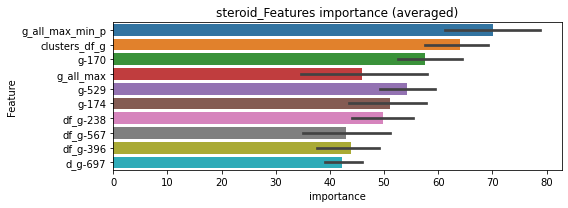

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316101	valid_1's binary_logloss: 0.0661304
[200]	training's binary_logloss: 0.00656097	valid_1's binary_logloss: 0.0349516
[300]	training's binary_logloss: 0.00184054	valid_1's binary_logloss: 0.0269644
[400]	training's binary_logloss: 0.000819862	valid_1's binary_logloss: 0.0241245
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000763262	valid_1's binary_logloss: 0.023873


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329699	valid_1's binary_logloss: 0.0648274
[200]	training's binary_logloss: 0.0066527	valid_1's binary_logloss: 0.0296919
[300]	training's binary_logloss: 0.00190382	valid_1's binary_logloss: 0.0203375
[400]	training's binary_logloss: 0.000836673	valid_1's binary_logloss: 0.0173501
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000536065	valid_1's binary_logloss: 0.0160917


steroid logloss: 0.01998285922217348
syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214142	valid_1's binary_logloss: 0.0299101
[200]	training's binary_logloss: 0.00238638	valid_1's binary_logloss: 0.00699195
[300]	training's binary_logloss: 0.000685709	valid_1's binary_logloss: 0.00379291
[400]	training's binary_logloss: 0.000376877	valid_1's binary_logloss: 0.00306112
[500]	training's binary_logloss: 0.000314942	valid_1's binary_logloss: 0.00291971
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000314546	valid_1's binary_logloss: 0.00291763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214651	valid_1's binary_logloss: 0.0257836
[200]	training's binary_logloss: 0.00242722	valid_1's binary_logloss: 0.0043437
[300]	training's binary_logloss: 0.000695435	valid_1's binary_logloss: 0.00201129
[400]	training's binary_logloss: 0.000379425	valid_1's binary_logloss: 0.00146634
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0019682, Threshold: 0.0036077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00325, conf_1:0.00397
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0036077
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.0136077
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0236077
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.0336077
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.0436077
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.0536077
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.0636077
threshold: 0.0636077, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207005	valid_1's binary_logloss: 0.028413
[200]	training's binary_logloss: 0.00221638	valid_1's binary_logloss: 0.00643434
[300]	training's binary_logloss: 0.000631692	valid_1's binary_logloss: 0.00363033
[400]	training's binary_logloss: 0.000346974	valid_1's binary_logloss: 0.00301384
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000301307	valid_1's binary_logloss: 0.00292218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209466	valid_1's binary_logloss: 0.0245904
[200]	training's binary_logloss: 0.00224586	valid_1's binary_logloss: 0.00375164
[300]	training's binary_logloss: 0.000639056	valid_1's binary_logloss: 0.00141254
[400]	training's binary_logloss: 0.000351316	valid_1's binary_logloss: 0.000889675
[500]	training's binary_logloss: 0.000300586	valid_1's binary_logloss: 0.0007916
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0552272, Threshold: 0.0636077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0118031 Vs.target_rate: 0.00080, Num_p_label: 47.0, conf_0:0.05725, conf_1:0.06997
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_1: 0.0636077
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_2: 0.0736077
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_3: 0.0836077
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_4: 0.0936077
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_5: 0.1036077
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_6: 0.1136077
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_7: 0.1236077
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_8: 0.1336077
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_9: 0.1436077
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_10: 0.1536077
threshold: 0.1636077, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207084	valid_1's binary_logloss: 0.034542
[200]	training's binary_logloss: 0.00222133	valid_1's binary_logloss: 0.0118579
[300]	training's binary_logloss: 0.000627366	valid_1's binary_logloss: 0.00711498
[400]	training's binary_logloss: 0.0003507	valid_1's binary_logloss: 0.00603245
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000299458	valid_1's binary_logloss: 0.00581149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208982	valid_1's binary_logloss: 0.0247521
[200]	training's binary_logloss: 0.00224365	valid_1's binary_logloss: 0.0038415
[300]	training's binary_logloss: 0.000636076	valid_1's binary_logloss: 0.00147085
[400]	training's binary_logloss: 0.000353345	valid_1's binary_logloss: 0.00093146
[500]	training's binary_logloss: 0.00030052	valid_1's binary_logloss: 0.000841857
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0521802, Threshold: 0.1636077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0057760 Vs.target_rate: 0.00080, Num_p_label: 23.0, conf_0:0.14725, conf_1:0.17997
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_1: 0.1636077
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_2: 0.1736077
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_3: 0.1836077
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.1936077
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.2036077
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_6: 0.2136077
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_7: 0.2236077
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_8: 0.2336077
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_9: 0.2436077
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_10: 0.2536077
threshold: 0.2636077, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7791, y_label_rate: 0.0857400


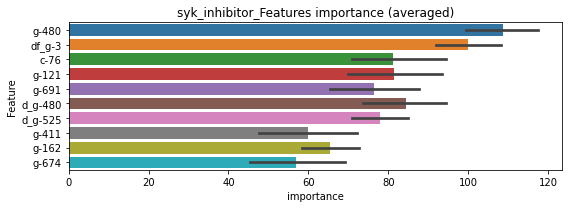

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109412	valid_1's binary_logloss: 0.0205408
[200]	training's binary_logloss: 0.0011662	valid_1's binary_logloss: 0.00902227
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00043669	valid_1's binary_logloss: 0.0079161


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120711	valid_1's binary_logloss: 0.0147108
[200]	training's binary_logloss: 0.00141942	valid_1's binary_logloss: 0.00264768
[300]	training's binary_logloss: 0.000409219	valid_1's binary_logloss: 0.00145526
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00023481	valid_1's binary_logloss: 0.00125596


syk_inhibitor logloss: 0.004586454901407154
tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533192	valid_1's binary_logloss: 0.113637
[200]	training's binary_logloss: 0.0108984	valid_1's binary_logloss: 0.0621684
[300]	training's binary_logloss: 0.00297942	valid_1's binary_logloss: 0.0506454
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00158675	valid_1's binary_logloss: 0.04755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053972	valid_1's binary_logloss: 0.0988892
[200]	training's binary_logloss: 0.0105074	valid_1's binary_logloss: 0.0426848
[300]	training's binary_logloss: 0.00303413	valid_1's binary_logloss: 0.0270828
[400]	training's binary_logloss: 0.00133876	valid_1's binary_logloss: 0.0214988
[500]	training's binary_logloss: 0.000829492	valid_1's binary_logloss: 0.0193655
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000813616	valid_1's binary_logloss: 0.019293


1 / 3 AUC score:0.998
y_Threshold: 0.0110306, Threshold: 0.0129323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.01164, conf_1:0.01423
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0129323
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_2: 0.0229323
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_3: 0.0329323
threshold: 0.0329323, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521349	valid_1's binary_logloss: 0.0936757
[200]	training's binary_logloss: 0.00940336	valid_1's binary_logloss: 0.037292
[300]	training's binary_logloss: 0.00272907	valid_1's binary_logloss: 0.0242013
[400]	training's binary_logloss: 0.00124921	valid_1's binary_logloss: 0.0194295
[500]	training's binary_logloss: 0.000775157	valid_1's binary_logloss: 0.0175512
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000679693	valid_1's binary_logloss: 0.0171168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532676	valid_1's binary_logloss: 0.0948818
[200]	training's binary_logloss: 0.0103045	valid_1's binary_logloss: 0.03882
[300]	training's binary_logloss: 0.00291897	valid_1's binary_logloss: 0.0258415
[400]	training's binary_logloss: 0.00133002	valid_1's binary_logloss: 0.0214795
[500]	training's binary_logloss: 0.000816595	va

2 / 3 AUC score:1.000
y_Threshold: 0.0378897, Threshold: 0.0329323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0105475 Vs.target_rate: 0.00252, Num_p_label: 42.0, conf_0:0.02964, conf_1:0.03623
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_1: 0.0329323
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_2: 0.0429323
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.0529323
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_4: 0.0629323
threshold: 0.0629323, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513407	valid_1's binary_logloss: 0.0887554
[200]	training's binary_logloss: 0.0098991	valid_1's binary_logloss: 0.0330084
[300]	training's binary_logloss: 0.00283856	valid_1's binary_logloss: 0.0185366
[400]	training's binary_logloss: 0.00129892	valid_1's binary_logloss: 0.0139792
[500]	training's binary_logloss: 0.00080375	valid_1's binary_logloss: 0.0122693
[600]	training's binary_logloss: 0.00060551	valid_1's binary_logloss: 0.0114995
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.000570721	valid_1's binary_logloss: 0.0113093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518282	valid_1's binary_logloss: 0.0871255
[200]	training's binary_logloss: 0.0100753	valid_1's binary_logloss: 0.0327068
[300]	training's binary_logloss: 0.00286079	valid_1's binary_logloss: 0.0186387
[400]	training's binary_logloss: 0.00131854	va

3 / 3 AUC score:1.000
y_Threshold: 0.0367329, Threshold: 0.0629323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0037670 Vs.target_rate: 0.00252, Num_p_label: 15.0, conf_0:0.05664, conf_1:0.06923
threshold: 0.0629323, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 661.0/7766, y_label_rate: 0.0851146


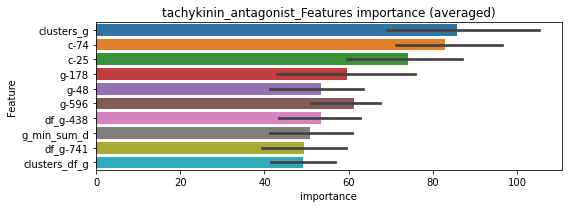

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291483	valid_1's binary_logloss: 0.0602168
[200]	training's binary_logloss: 0.00553396	valid_1's binary_logloss: 0.0311226
[300]	training's binary_logloss: 0.00152082	valid_1's binary_logloss: 0.0238314
[400]	training's binary_logloss: 0.00068627	valid_1's binary_logloss: 0.0220612
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000438695	valid_1's binary_logloss: 0.0213483


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274892	valid_1's binary_logloss: 0.0571225
[200]	training's binary_logloss: 0.00533881	valid_1's binary_logloss: 0.0304098
[300]	training's binary_logloss: 0.00149157	valid_1's binary_logloss: 0.0232675
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00079796	valid_1's binary_logloss: 0.0219228


tachykinin_antagonist logloss: 0.021635522287890428
tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184115	valid_1's binary_logloss: 0.0247573
[200]	training's binary_logloss: 0.00175689	valid_1's binary_logloss: 0.00638401
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000608842	valid_1's binary_logloss: 0.0052017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188191	valid_1's binary_logloss: 0.022456
[200]	training's binary_logloss: 0.00174532	valid_1's binary_logloss: 0.00436704
[300]	training's binary_logloss: 0.000466536	valid_1's binary_logloss: 0.00310791


1 / 3 AUC score:1.000
y_Threshold: 0.0012756, Threshold: 0.0021557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000325767	valid_1's binary_logloss: 0.00287372


p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00194, conf_1:0.00237
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0021557
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_2: 0.0121557
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.0221557
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_4: 0.0321557
threshold: 0.0321557, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174081	valid_1's binary_logloss: 0.0219972
[200]	training's binary_logloss: 0.00145809	valid_1's binary_logloss: 0.00347463
[300]	training's binary_logloss: 0.000347986	valid_1's binary_logloss: 0.00134427
[400]	training's binary_logloss: 0.000206607	valid_1's binary_logloss: 0.000991091
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000183717	valid_1's binary_logloss: 0.000935663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175781	valid_1's binary_logloss: 0.0190365
[200]	training's binary_logloss: 0.00148677	valid_1's binary_logloss: 0.00204718
[300]	training's binary_logloss: 0.000354917	valid_1's binary_logloss: 0.0006425
[400]	training's binary_logloss: 0.000209431	valid_1's binary_logloss: 0.000435854
[500]	training's binary_logloss: 0.000185953	valid_1's binary_logloss: 0.000402713
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0988315, Threshold: 0.0321557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0080362 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.02894, conf_1:0.03537
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.0321557
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_2: 0.0421557
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_3: 0.0521557
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.0621557
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.0721557
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.0821557
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.0921557
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.1021557
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.1121557
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_10: 0.1221557
threshold: 0.1321557, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174081	valid_1's binary_logloss: 0.0219972
[200]	training's binary_logloss: 0.00145809	valid_1's binary_logloss: 0.00347463
[300]	training's binary_logloss: 0.000347986	valid_1's binary_logloss: 0.00134427
[400]	training's binary_logloss: 0.000206607	valid_1's binary_logloss: 0.000991091
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000183717	valid_1's binary_logloss: 0.000935663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175781	valid_1's binary_logloss: 0.0190365
[200]	training's binary_logloss: 0.00148677	valid_1's binary_logloss: 0.00204718
[300]	training's binary_logloss: 0.000354917	valid_1's binary_logloss: 0.0006425
[400]	training's binary_logloss: 0.000209431	valid_1's binary_logloss: 0.000435854
[500]	training's binary_logloss: 0.000185953	valid_1's binary_logloss: 0.000402713
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0988315, Threshold: 0.1321557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.11894, conf_1:0.14537
threshold: 0.1321557, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 670.0/7790, y_label_rate: 0.0860077


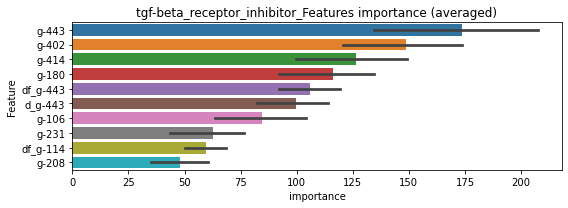

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00955187	valid_1's binary_logloss: 0.0148304
[200]	training's binary_logloss: 0.000816151	valid_1's binary_logloss: 0.00562637
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000298893	valid_1's binary_logloss: 0.00525898


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00990865	valid_1's binary_logloss: 0.0122707
[200]	training's binary_logloss: 0.000937807	valid_1's binary_logloss: 0.00316365
[300]	training's binary_logloss: 0.000237634	valid_1's binary_logloss: 0.00243159
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000231119	valid_1's binary_logloss: 0.00240673


tgf-beta_receptor_inhibitor logloss: 0.0038328532650721797
thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250628	valid_1's binary_logloss: 0.0368472
[200]	training's binary_logloss: 0.00323372	valid_1's binary_logloss: 0.00956667
[300]	training's binary_logloss: 0.000903798	valid_1's binary_logloss: 0.00437954
[400]	training's binary_logloss: 0.000454476	valid_1's binary_logloss: 0.00293748
[500]	training's binary_logloss: 0.000343974	valid_1's binary_logloss: 0.00254771
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000331678	valid_1's binary_logloss: 0.00251984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245284	valid_1's binary_logloss: 0.0311306
[200]	training's binary_logloss: 0.00299308	valid_1's binary_logloss: 0.00531038
[300]	training's binary_logloss: 0.000852282	valid_1's binary_logloss: 0.00189033
[400]	training's binary_logloss: 0.000454043	valid_1's binary_logloss: 0.00113322
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0020811, Threshold: 0.0031219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00281, conf_1:0.00343
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0031219
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.0131219
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.0231219
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0331219
threshold: 0.0331219, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242061	valid_1's binary_logloss: 0.0338585
[200]	training's binary_logloss: 0.00288103	valid_1's binary_logloss: 0.00831896
[300]	training's binary_logloss: 0.000827815	valid_1's binary_logloss: 0.00418577
[400]	training's binary_logloss: 0.000439738	valid_1's binary_logloss: 0.00321657
[500]	training's binary_logloss: 0.000344116	valid_1's binary_logloss: 0.00286315
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000344116	valid_1's binary_logloss: 0.00286315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242133	valid_1's binary_logloss: 0.0293548
[200]	training's binary_logloss: 0.00290461	valid_1's binary_logloss: 0.00455509
[300]	training's binary_logloss: 0.000830296	valid_1's binary_logloss: 0.00153519
[400]	training's binary_logloss: 0.00043967	valid_1's binary_logloss: 0.000917696
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0557818, Threshold: 0.0331219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00080, Num_p_label: 19.0, conf_0:0.02981, conf_1:0.03643
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_1: 0.0331219
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.0431219
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.0531219
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.0631219
threshold: 0.0631219, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242061	valid_1's binary_logloss: 0.0338585
[200]	training's binary_logloss: 0.00288103	valid_1's binary_logloss: 0.00831896
[300]	training's binary_logloss: 0.000827815	valid_1's binary_logloss: 0.00418577
[400]	training's binary_logloss: 0.000439738	valid_1's binary_logloss: 0.00321657
[500]	training's binary_logloss: 0.000344116	valid_1's binary_logloss: 0.00286315
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000344116	valid_1's binary_logloss: 0.00286315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242133	valid_1's binary_logloss: 0.0293548
[200]	training's binary_logloss: 0.00290461	valid_1's binary_logloss: 0.00455509
[300]	training's binary_logloss: 0.000830296	valid_1's binary_logloss: 0.00153519
[400]	training's binary_logloss: 0.00043967	valid_1's binary_logloss: 0.000917696
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0557818, Threshold: 0.0631219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.05681, conf_1:0.06943
threshold: 0.0631219, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


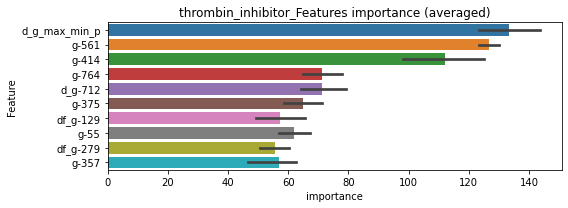

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129497	valid_1's binary_logloss: 0.0194776
[200]	training's binary_logloss: 0.00150656	valid_1's binary_logloss: 0.00698739
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000588378	valid_1's binary_logloss: 0.00617794


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133501	valid_1's binary_logloss: 0.0206928
[200]	training's binary_logloss: 0.00163136	valid_1's binary_logloss: 0.00675075
[300]	training's binary_logloss: 0.00045774	valid_1's binary_logloss: 0.004616
[400]	training's binary_logloss: 0.000238926	valid_1's binary_logloss: 0.00393605
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000200125	valid_1's binary_logloss: 0.00373552


thrombin_inhibitor logloss: 0.0049568862738380215
thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368221	valid_1's binary_logloss: 0.0633283
[200]	training's binary_logloss: 0.00569486	valid_1's binary_logloss: 0.0247784
[300]	training's binary_logloss: 0.00158355	valid_1's binary_logloss: 0.0173379
[400]	training's binary_logloss: 0.000746372	valid_1's binary_logloss: 0.0155616
[500]	training's binary_logloss: 0.000494643	valid_1's binary_logloss: 0.0144285
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00045679	valid_1's binary_logloss: 0.0142523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381638	valid_1's binary_logloss: 0.055166
[200]	training's binary_logloss: 0.005737	valid_1's binary_logloss: 0.0134999
[300]	training's binary_logloss: 0.00160176	valid_1's binary_logloss: 0.00594807
[400]	training's binary_logloss: 0.000766876	valid_1's binary_logloss: 0.0040628
[500]	training's binary_logloss: 0.000508222

1 / 3 AUC score:1.000
y_Threshold: 0.0031621, Threshold: 0.0048182, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00434, conf_1:0.00530
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0048182
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.0148182
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0248182
threshold: 0.0248182, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355	valid_1's binary_logloss: 0.0546017
[200]	training's binary_logloss: 0.00526847	valid_1's binary_logloss: 0.0124972
[300]	training's binary_logloss: 0.00147849	valid_1's binary_logloss: 0.00509062
[400]	training's binary_logloss: 0.000719232	valid_1's binary_logloss: 0.0032634
[500]	training's binary_logloss: 0.000487714	valid_1's binary_logloss: 0.00269191
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00044278	valid_1's binary_logloss: 0.00257999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036116	valid_1's binary_logloss: 0.0606718
[200]	training's binary_logloss: 0.00529301	valid_1's binary_logloss: 0.0230949
[300]	training's binary_logloss: 0.00146579	valid_1's binary_logloss: 0.016887
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000984064	valid_1's binary_logloss: 0.0158574


2 / 3 AUC score:0.999
y_Threshold: 0.0236095, Threshold: 0.0248182, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0067805 Vs.target_rate: 0.00155, Num_p_label: 27.0, conf_0:0.02234, conf_1:0.02730
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_1: 0.0248182
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_2: 0.0348182
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.0448182
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_4: 0.0548182
threshold: 0.0548182, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350522	valid_1's binary_logloss: 0.0642669
[200]	training's binary_logloss: 0.0052495	valid_1's binary_logloss: 0.0231212
[300]	training's binary_logloss: 0.00144764	valid_1's binary_logloss: 0.0140138
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00122891	valid_1's binary_logloss: 0.0133979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347393	valid_1's binary_logloss: 0.0597014
[200]	training's binary_logloss: 0.00500756	valid_1's binary_logloss: 0.019494
[300]	training's binary_logloss: 0.0014284	valid_1's binary_logloss: 0.0111057
[400]	training's binary_logloss: 0.000698039	valid_1's binary_logloss: 0.00834302
[500]	training's binary_logloss: 0.000478466	valid_1's binary_logloss: 0.00732004
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000482512	valid_1's binary_logloss: 0.00729616


3 / 3 AUC score:1.000
y_Threshold: 0.0392335, Threshold: 0.0548182, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0032647 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.04934, conf_1:0.06030
threshold: 0.0548182, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 667.0/7786, y_label_rate: 0.0856666


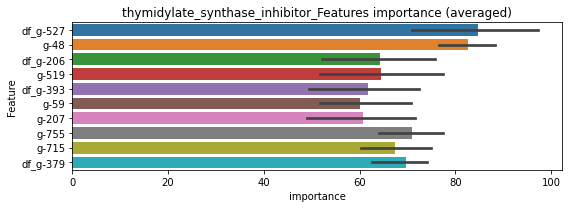

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201523	valid_1's binary_logloss: 0.0379849
[200]	training's binary_logloss: 0.00282172	valid_1's binary_logloss: 0.0150199
[300]	training's binary_logloss: 0.000770546	valid_1's binary_logloss: 0.0110133
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000471059	valid_1's binary_logloss: 0.0102481


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197682	valid_1's binary_logloss: 0.0287243
[200]	training's binary_logloss: 0.00287373	valid_1's binary_logloss: 0.00779748
[300]	training's binary_logloss: 0.000800381	valid_1's binary_logloss: 0.00428544
[400]	training's binary_logloss: 0.000384061	valid_1's binary_logloss: 0.00357787
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000268946	valid_1's binary_logloss: 0.00328371


thymidylate_synthase_inhibitor logloss: 0.006765918459841381
tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035307	valid_1's binary_logloss: 0.0582235
[200]	training's binary_logloss: 0.00534752	valid_1's binary_logloss: 0.016058
[300]	training's binary_logloss: 0.00144944	valid_1's binary_logloss: 0.00755682
[400]	training's binary_logloss: 0.000695762	valid_1's binary_logloss: 0.00511251
[500]	training's binary_logloss: 0.000470091	valid_1's binary_logloss: 0.00425234
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000448944	valid_1's binary_logloss: 0.0041931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352763	valid_1's binary_logloss: 0.0548463
[200]	training's binary_logloss: 0.00546135	valid_1's binary_logloss: 0.0128538
[300]	training's binary_logloss: 0.00147892	valid_1's binary_logloss: 0.00527271
[400]	training's binary_logloss: 0.000705818	valid_1's binary_logloss: 0.00317307
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0027186, Threshold: 0.0040758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00367, conf_1:0.00448
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0040758
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_2: 0.0140758
threshold: 0.0140758, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352883	valid_1's binary_logloss: 0.0600845
[200]	training's binary_logloss: 0.00522326	valid_1's binary_logloss: 0.0164426
[300]	training's binary_logloss: 0.00143342	valid_1's binary_logloss: 0.00765737
[400]	training's binary_logloss: 0.000688695	valid_1's binary_logloss: 0.00487872
[500]	training's binary_logloss: 0.000464376	valid_1's binary_logloss: 0.00411276
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000443439	valid_1's binary_logloss: 0.00403204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361883	valid_1's binary_logloss: 0.0548465
[200]	training's binary_logloss: 0.00528829	valid_1's binary_logloss: 0.0128986
[300]	training's binary_logloss: 0.00145794	valid_1's binary_logloss: 0.00529581
[400]	training's binary_logloss: 0.000707323	valid_1's binary_logloss: 0.00348617
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0692539, Threshold: 0.0140758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0045203 Vs.target_rate: 0.00126, Num_p_label: 18.0, conf_0:0.01267, conf_1:0.01548
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.0140758
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_2: 0.0240758
threshold: 0.0240758, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352883	valid_1's binary_logloss: 0.0600845
[200]	training's binary_logloss: 0.00522326	valid_1's binary_logloss: 0.0164426
[300]	training's binary_logloss: 0.00143342	valid_1's binary_logloss: 0.00765737
[400]	training's binary_logloss: 0.000688695	valid_1's binary_logloss: 0.00487872
[500]	training's binary_logloss: 0.000464376	valid_1's binary_logloss: 0.00411276
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000443439	valid_1's binary_logloss: 0.00403204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361883	valid_1's binary_logloss: 0.0548465
[200]	training's binary_logloss: 0.00528829	valid_1's binary_logloss: 0.0128986
[300]	training's binary_logloss: 0.00145794	valid_1's binary_logloss: 0.00529581
[400]	training's binary_logloss: 0.000707323	valid_1's binary_logloss: 0.00348617
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0692539, Threshold: 0.0240758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.02167, conf_1:0.02648
threshold: 0.0240758, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


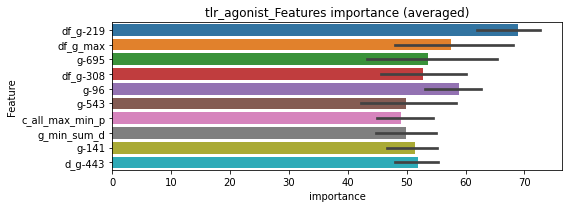

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193909	valid_1's binary_logloss: 0.0366735
[200]	training's binary_logloss: 0.00273835	valid_1's binary_logloss: 0.0132678
[300]	training's binary_logloss: 0.000738762	valid_1's binary_logloss: 0.00957799
[400]	training's binary_logloss: 0.000351526	valid_1's binary_logloss: 0.00889987
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000340137	valid_1's binary_logloss: 0.00885667


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205944	valid_1's binary_logloss: 0.0334413
[200]	training's binary_logloss: 0.00305407	valid_1's binary_logloss: 0.00946103
[300]	training's binary_logloss: 0.000812602	valid_1's binary_logloss: 0.0048114
[400]	training's binary_logloss: 0.000378622	valid_1's binary_logloss: 0.00363077
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000260567	valid_1's binary_logloss: 0.00332064


tlr_agonist logloss: 0.006088656329771247
tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166579	valid_1's binary_logloss: 0.018293
[200]	training's binary_logloss: 0.0014309	valid_1's binary_logloss: 0.00182437
[300]	training's binary_logloss: 0.000396794	valid_1's binary_logloss: 0.000603052
[400]	training's binary_logloss: 0.000236576	valid_1's binary_logloss: 0.00039425
[500]	training's binary_logloss: 0.000208753	valid_1's binary_logloss: 0.000354888
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000205292	valid_1's binary_logloss: 0.000349716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171124	valid_1's binary_logloss: 0.0182576
[200]	training's binary_logloss: 0.00145981	valid_1's binary_logloss: 0.00184885
[300]	training's binary_logloss: 0.000398646	valid_1's binary_logloss: 0.000653198
[400]	training's binary_logloss: 0.000240259	valid_1's binary_logloss: 0.000421017
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006815, Threshold: 0.0012381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00111, conf_1:0.00136
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0012381
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.0112381
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.0212381
threshold: 0.0212381, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017076	valid_1's binary_logloss: 0.0183654
[200]	training's binary_logloss: 0.00142089	valid_1's binary_logloss: 0.00169896
[300]	training's binary_logloss: 0.000381418	valid_1's binary_logloss: 0.000501532
[400]	training's binary_logloss: 0.000231552	valid_1's binary_logloss: 0.000312779
[500]	training's binary_logloss: 0.000202247	valid_1's binary_logloss: 0.000274821
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00020048	valid_1's binary_logloss: 0.000272586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172203	valid_1's binary_logloss: 0.0184021
[200]	training's binary_logloss: 0.00144114	valid_1's binary_logloss: 0.00181883
[300]	training's binary_logloss: 0.000383455	valid_1's binary_logloss: 0.00054573
[400]	training's binary_logloss: 0.000233459	valid_1's binary_logloss: 0.000352167
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1642924, Threshold: 0.0212381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00029, Num_p_label: 10.0, conf_0:0.01911, conf_1:0.02336
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_1: 0.0212381
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0312381
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.0412381
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0512381
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.0612381
threshold: 0.0612381, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017076	valid_1's binary_logloss: 0.0183654
[200]	training's binary_logloss: 0.00142089	valid_1's binary_logloss: 0.00169896
[300]	training's binary_logloss: 0.000381418	valid_1's binary_logloss: 0.000501532
[400]	training's binary_logloss: 0.000231552	valid_1's binary_logloss: 0.000312779
[500]	training's binary_logloss: 0.000202247	valid_1's binary_logloss: 0.000274821
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00020048	valid_1's binary_logloss: 0.000272586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172203	valid_1's binary_logloss: 0.0184021
[200]	training's binary_logloss: 0.00144114	valid_1's binary_logloss: 0.00181883
[300]	training's binary_logloss: 0.000383455	valid_1's binary_logloss: 0.00054573
[400]	training's binary_logloss: 0.000233459	valid_1's binary_logloss: 0.000352167
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1642924, Threshold: 0.0612381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.05511, conf_1:0.06736
threshold: 0.0612381, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


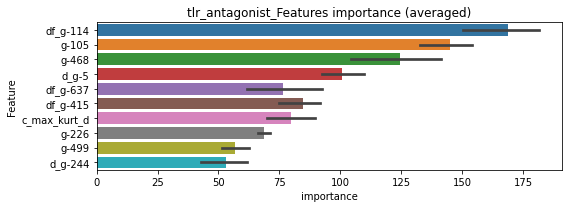

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00886832	valid_1's binary_logloss: 0.00997512
[200]	training's binary_logloss: 0.000761383	valid_1's binary_logloss: 0.00184415
[300]	training's binary_logloss: 0.000198595	valid_1's binary_logloss: 0.00124528
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000158601	valid_1's binary_logloss: 0.0012221


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00892595	valid_1's binary_logloss: 0.0110203
[200]	training's binary_logloss: 0.000752662	valid_1's binary_logloss: 0.00232745
[300]	training's binary_logloss: 0.000199861	valid_1's binary_logloss: 0.00164572
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000196598	valid_1's binary_logloss: 0.00164149


tlr_antagonist logloss: 0.0014317938796848783
tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384362	valid_1's binary_logloss: 0.058321
[200]	training's binary_logloss: 0.00575163	valid_1's binary_logloss: 0.0156641
[300]	training's binary_logloss: 0.0016003	valid_1's binary_logloss: 0.0076676
[400]	training's binary_logloss: 0.00078048	valid_1's binary_logloss: 0.0053625
[500]	training's binary_logloss: 0.000510649	valid_1's binary_logloss: 0.00439415
[600]	training's binary_logloss: 0.000454195	valid_1's binary_logloss: 0.00419707
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000455273	valid_1's binary_logloss: 0.00419493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374057	valid_1's binary_logloss: 0.0580566
[200]	training's binary_logloss: 0.00591489	valid_1's binary_logloss: 0.0175954
[300]	training's binary_logloss: 0.00161231	valid_1's binary_logloss: 0.0101119
[400]	training's binary_logloss: 0.000773

1 / 3 AUC score:1.000
y_Threshold: 0.0035086, Threshold: 0.0057823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00520, conf_1:0.00636
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0057823
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0157823
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_3: 0.0257823
threshold: 0.0257823, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362919	valid_1's binary_logloss: 0.0544146
[200]	training's binary_logloss: 0.00569281	valid_1's binary_logloss: 0.0144313
[300]	training's binary_logloss: 0.00158014	valid_1's binary_logloss: 0.00656191
[400]	training's binary_logloss: 0.000775146	valid_1's binary_logloss: 0.00438401
[500]	training's binary_logloss: 0.000512208	valid_1's binary_logloss: 0.00352939
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00047583	valid_1's binary_logloss: 0.00341566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357386	valid_1's binary_logloss: 0.0565983
[200]	training's binary_logloss: 0.00553171	valid_1's binary_logloss: 0.0172152
[300]	training's binary_logloss: 0.00157453	valid_1's binary_logloss: 0.0103484
[400]	training's binary_logloss: 0.000767131	valid_1's binary_logloss: 0.00812619
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0393526, Threshold: 0.0257823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0087896 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.02320, conf_1:0.02836
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.0257823
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0357823
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0457823
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.0557823
threshold: 0.0557823, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362919	valid_1's binary_logloss: 0.0544146
[200]	training's binary_logloss: 0.00569281	valid_1's binary_logloss: 0.0144313
[300]	training's binary_logloss: 0.00158014	valid_1's binary_logloss: 0.00656191
[400]	training's binary_logloss: 0.000775146	valid_1's binary_logloss: 0.00438401
[500]	training's binary_logloss: 0.000512208	valid_1's binary_logloss: 0.00352939
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00047583	valid_1's binary_logloss: 0.00341566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357386	valid_1's binary_logloss: 0.0565983
[200]	training's binary_logloss: 0.00553171	valid_1's binary_logloss: 0.0172152
[300]	training's binary_logloss: 0.00157453	valid_1's binary_logloss: 0.0103484
[400]	training's binary_logloss: 0.000767131	valid_1's binary_logloss: 0.00812619
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0393526, Threshold: 0.0557823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0012557 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.05020, conf_1:0.06136
threshold: 0.0557823, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7789, y_label_rate: 0.0848633


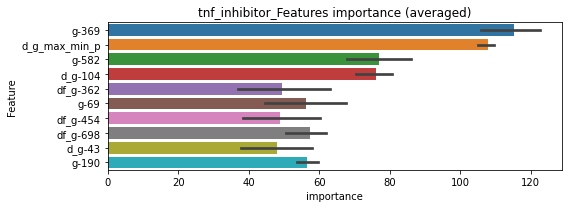

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188791	valid_1's binary_logloss: 0.0346333
[200]	training's binary_logloss: 0.00294647	valid_1's binary_logloss: 0.0134926
[300]	training's binary_logloss: 0.000805661	valid_1's binary_logloss: 0.0100244
[400]	training's binary_logloss: 0.000379909	valid_1's binary_logloss: 0.00943088
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000402022	valid_1's binary_logloss: 0.00942278


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204471	valid_1's binary_logloss: 0.031996
[200]	training's binary_logloss: 0.00331126	valid_1's binary_logloss: 0.00963414
[300]	training's binary_logloss: 0.000895068	valid_1's binary_logloss: 0.00535801
[400]	training's binary_logloss: 0.000423148	valid_1's binary_logloss: 0.00423027
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000293889	valid_1's binary_logloss: 0.00397434


tnf_inhibitor logloss: 0.006698906923086316
topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400274	valid_1's binary_logloss: 0.0812339
[200]	training's binary_logloss: 0.00735797	valid_1's binary_logloss: 0.051692
[300]	training's binary_logloss: 0.00224548	valid_1's binary_logloss: 0.0466036
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00224548	valid_1's binary_logloss: 0.0466036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379287	valid_1's binary_logloss: 0.0876285
[200]	training's binary_logloss: 0.00690936	valid_1's binary_logloss: 0.0621577
[300]	training's binary_logloss: 0.00201316	valid_1's binary_logloss: 0.0576322
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00169069	valid_1's binary_logloss: 0.057074


1 / 3 AUC score:0.995
y_Threshold: 0.0124053, Threshold: 0.6396774, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 155 → Positive_corect_labels: 642/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00533, Num_p_label: 80.0, conf_0:0.57571, conf_1:0.70365
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6396774
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_2: 0.6496774
Num_p_label: 75.0, Expected: 21.2, Adj_threshold_3: 0.6596774
Num_p_label: 73.0, Expected: 21.2, Adj_threshold_4: 0.6696774
Num_p_label: 72.0, Expected: 21.2, Adj_threshold_5: 0.6796774
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_6: 0.6896774
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_7: 0.6996774
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_8: 0.7096774
Num_p_label: 65.0, Expected: 21.2, Adj_threshold_9: 0.7196774
Num_p_label: 64.0, Expected: 21.2, Adj_threshold_10: 0.7296774
threshold: 0.7396774, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 642.0/3770, y_label_rate: 0.170291

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290599	valid_1's binary_logloss: 0.0691846
[200]	training's binary_logloss: 0.00400562	valid_1's binary_logloss: 0.0427334
[300]	training's binary_logloss: 0.00117698	valid_1's binary_logloss: 0.0387615
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000953213	valid_1's binary_logloss: 0.0379884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299539	valid_1's binary_logloss: 0.0691068


2 / 3 AUC score:0.995
y_Threshold: 0.0536626, Threshold: 0.7396774, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.00434086	valid_1's binary_logloss: 0.0523466
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0050998	valid_1's binary_logloss: 0.0518268


Remove_noisy_labels: 48 → Positive_corect_labels: 618.0/3722
p_label_rate: 0.0374184 Vs.target_rate: 0.00533, Num_p_label: 149.0, conf_0:0.66571, conf_1:0.81365
Num_p_label: 149.0, Expected: 21.2, Adj_threshold_1: 0.7396774
Num_p_label: 148.0, Expected: 21.2, Adj_threshold_2: 0.7496774
Num_p_label: 145.0, Expected: 21.2, Adj_threshold_3: 0.7596774
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_4: 0.7696774
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_5: 0.7796774
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_6: 0.7896774
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_7: 0.7996774
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_8: 0.8096774
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_9: 0.8196774
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_10: 0.8296774
threshold: 0.8396774, positive_p_label: 137.0/3982, p_label_rate: 0.0344048
positive_y_label: 618.0/3722, y_label_rate: 0.1660398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264577	valid_1's binary_logloss: 0.0544682
[200]	training's binary_logloss: 0.00345201	valid_1's binary_logloss: 0.034237
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00221317	valid_1's binary_logloss: 0.0329811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273667	valid_1's binary_logloss: 0.0597715
[200]	training's binary_logloss: 0.00346642	valid_1's binary_logloss: 0.0392935


3 / 3 AUC score:0.996
y_Threshold: 0.0518516, Threshold: 0.8396774, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 602.0/3690


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00246501	valid_1's binary_logloss: 0.0385849


p_label_rate: 0.0389252 Vs.target_rate: 0.00533, Num_p_label: 155.0, conf_0:0.75571, conf_1:0.92365
Num_p_label: 155.0, Expected: 21.2, Adj_threshold_1: 0.8396774
Num_p_label: 154.0, Expected: 21.2, Adj_threshold_2: 0.8496774
Num_p_label: 153.0, Expected: 21.2, Adj_threshold_3: 0.8596774
Num_p_label: 151.0, Expected: 21.2, Adj_threshold_4: 0.8696774
Num_p_label: 149.0, Expected: 21.2, Adj_threshold_5: 0.8796774
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_6: 0.8896774
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_7: 0.8996774
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_8: 0.9096774
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_9: 0.9196774
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_10: 0.9296774
threshold: 0.9396774, positive_p_label: 135.0/3982, p_label_rate: 0.0339026
positive_y_label: 737.0/7672, y_label_rate: 0.0960636


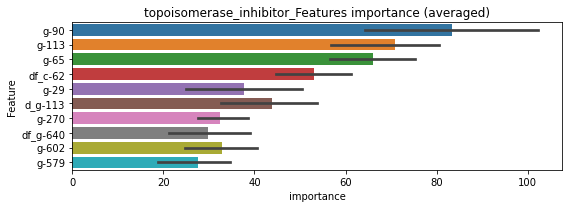

len(train_index) : 3836
len(valid_index) : 3836
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175196	valid_1's binary_logloss: 0.0308689
[200]	training's binary_logloss: 0.0023115	valid_1's binary_logloss: 0.0172579
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00101354	valid_1's binary_logloss: 0.016319


len(train_index) : 3836
len(valid_index) : 3836
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161068	valid_1's binary_logloss: 0.034011
[200]	training's binary_logloss: 0.0020416	valid_1's binary_logloss: 0.0196105
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00106742	valid_1's binary_logloss: 0.0188932


topoisomerase_inhibitor logloss: 0.01760611514663963
transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249578	valid_1's binary_logloss: 0.033364
[200]	training's binary_logloss: 0.00306983	valid_1's binary_logloss: 0.0055377
[300]	training's binary_logloss: 0.000862279	valid_1's binary_logloss: 0.00194116
[400]	training's binary_logloss: 0.000445139	valid_1's binary_logloss: 0.00115509
[500]	training's binary_logloss: 0.0003518	valid_1's binary_logloss: 0.000990184
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000345147	valid_1's binary_logloss: 0.000977912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245704	valid_1's binary_logloss: 0.0344037
[200]	training's binary_logloss: 0.00299451	valid_1's binary_logloss: 0.00673636
[300]	training's binary_logloss: 0.00083677	valid_1's binary_logloss: 0.00312476
[400]	training's binary_logloss: 0.000442749	valid_1's binary_logloss: 0.00236181
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0017529, Threshold: 0.0021331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00192, conf_1:0.00235
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021331
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0121331
threshold: 0.0121331, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242843	valid_1's binary_logloss: 0.0318407
[200]	training's binary_logloss: 0.00296685	valid_1's binary_logloss: 0.00530619
[300]	training's binary_logloss: 0.000831198	valid_1's binary_logloss: 0.00175577
[400]	training's binary_logloss: 0.000441281	valid_1's binary_logloss: 0.00103937
[500]	training's binary_logloss: 0.000350136	valid_1's binary_logloss: 0.000876856
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00034295	valid_1's binary_logloss: 0.000864382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251921	valid_1's binary_logloss: 0.0334662
[200]	training's binary_logloss: 0.00299577	valid_1's binary_logloss: 0.0067185
[300]	training's binary_logloss: 0.000839404	valid_1's binary_logloss: 0.00325156
[400]	training's binary_logloss: 0.000442165	valid_1's binary_logloss: 0.00255389
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0778117, Threshold: 0.0121331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.01092, conf_1:0.01335
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0121331
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0221331
threshold: 0.0221331, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242843	valid_1's binary_logloss: 0.0318407
[200]	training's binary_logloss: 0.00296685	valid_1's binary_logloss: 0.00530619
[300]	training's binary_logloss: 0.000831198	valid_1's binary_logloss: 0.00175577
[400]	training's binary_logloss: 0.000441281	valid_1's binary_logloss: 0.00103937
[500]	training's binary_logloss: 0.000350136	valid_1's binary_logloss: 0.000876856
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00034295	valid_1's binary_logloss: 0.000864382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251921	valid_1's binary_logloss: 0.0334662
[200]	training's binary_logloss: 0.00299577	valid_1's binary_logloss: 0.0067185
[300]	training's binary_logloss: 0.000839404	valid_1's binary_logloss: 0.00325156
[400]	training's binary_logloss: 0.000442165	valid_1's binary_logloss: 0.00255389
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0778117, Threshold: 0.0221331, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.01992, conf_1:0.02435
threshold: 0.0221331, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


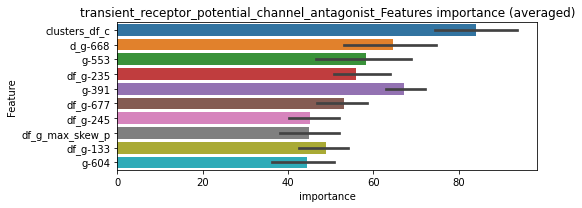

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128417	valid_1's binary_logloss: 0.0185262
[200]	training's binary_logloss: 0.00151385	valid_1's binary_logloss: 0.0055164
[300]	training's binary_logloss: 0.00042143	valid_1's binary_logloss: 0.00435222
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000347834	valid_1's binary_logloss: 0.00427482


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133069	valid_1's binary_logloss: 0.0205915
[200]	training's binary_logloss: 0.0015856	valid_1's binary_logloss: 0.00550736
[300]	training's binary_logloss: 0.000444223	valid_1's binary_logloss: 0.00316907
[400]	training's binary_logloss: 0.000228054	valid_1's binary_logloss: 0.00258099
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000187358	valid_1's binary_logloss: 0.00248827


transient_receptor_potential_channel_antagonist logloss: 0.0033816583638992363
tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160328	valid_1's binary_logloss: 0.0171797
[200]	training's binary_logloss: 0.00136238	valid_1's binary_logloss: 0.00168765
[300]	training's binary_logloss: 0.000361853	valid_1's binary_logloss: 0.000517741
[400]	training's binary_logloss: 0.000218121	valid_1's binary_logloss: 0.00033728
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000200218	valid_1's binary_logloss: 0.000314873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162741	valid_1's binary_logloss: 0.0173553
[200]	training's binary_logloss: 0.00135351	valid_1's binary_logloss: 0.00162387
[300]	training's binary_logloss: 0.000358772	valid_1's binary_logloss: 0.000483349
[400]	training's binary_logloss: 0.000217378	valid_1's binary_logloss: 0.000306995
[500]	training's binary_logloss: 0.000196878	valid_1's binary_logloss: 0.000281327
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005431, Threshold: 0.0010283, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00093, conf_1:0.00113
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010283
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0110283
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0210283
threshold: 0.0210283, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016309	valid_1's binary_logloss: 0.0171441
[200]	training's binary_logloss: 0.00135168	valid_1's binary_logloss: 0.00148748
[300]	training's binary_logloss: 0.000354456	valid_1's binary_logloss: 0.000409386
[400]	training's binary_logloss: 0.000215383	valid_1's binary_logloss: 0.000254318
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000192936	valid_1's binary_logloss: 0.0002289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163865	valid_1's binary_logloss: 0.0170552
[200]	training's binary_logloss: 0.00134369	valid_1's binary_logloss: 0.00148353
[300]	training's binary_logloss: 0.000353568	valid_1's binary_logloss: 0.000414599
[400]	training's binary_logloss: 0.000215918	valid_1's binary_logloss: 0.000257766


2 / 3 AUC score:1.000
y_Threshold: 0.1723974, Threshold: 0.0210283, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000194578	valid_1's binary_logloss: 0.000233014


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.01893, conf_1:0.02313
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0210283
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0310283
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0410283
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0510283
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0610283
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.0710283
threshold: 0.0710283, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016309	valid_1's binary_logloss: 0.0171441
[200]	training's binary_logloss: 0.00135168	valid_1's binary_logloss: 0.00148748
[300]	training's binary_logloss: 0.000354456	valid_1's binary_logloss: 0.000409386
[400]	training's binary_logloss: 0.000215383	valid_1's binary_logloss: 0.000254318
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000192936	valid_1's binary_logloss: 0.0002289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163865	valid_1's binary_logloss: 0.0170552
[200]	training's binary_logloss: 0.00134369	valid_1's binary_logloss: 0.00148353
[300]	training's binary_logloss: 0.000353568	valid_1's binary_logloss: 0.000414599
[400]	training's binary_logloss: 0.000215918	valid_1's binary_logloss: 0.000257766
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000194578	valid_1's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1723974, Threshold: 0.0710283, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.06393, conf_1:0.07813
threshold: 0.0710283, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


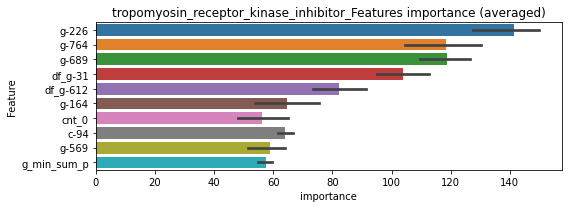

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865752	valid_1's binary_logloss: 0.0102578
[200]	training's binary_logloss: 0.000715675	valid_1's binary_logloss: 0.00199247
[300]	training's binary_logloss: 0.000183153	valid_1's binary_logloss: 0.00147524
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000161766	valid_1's binary_logloss: 0.00145438


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00871929	valid_1's binary_logloss: 0.0101678
[200]	training's binary_logloss: 0.000719855	valid_1's binary_logloss: 0.00160755
[300]	training's binary_logloss: 0.000190021	valid_1's binary_logloss: 0.000903189
[400]	training's binary_logloss: 0.000111462	valid_1's binary_logloss: 0.000827016
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000113806	valid_1's binary_logloss: 0.000823091


tropomyosin_receptor_kinase_inhibitor logloss: 0.001138774511395421
trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249382	valid_1's binary_logloss: 0.0374843
[200]	training's binary_logloss: 0.00311631	valid_1's binary_logloss: 0.00851239
[300]	training's binary_logloss: 0.000903231	valid_1's binary_logloss: 0.00426554
[400]	training's binary_logloss: 0.00047686	valid_1's binary_logloss: 0.0030662
[500]	training's binary_logloss: 0.000362593	valid_1's binary_logloss: 0.00270206
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000350185	valid_1's binary_logloss: 0.00265723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02535	valid_1's binary_logloss: 0.0344445
[200]	training's binary_logloss: 0.00317825	valid_1's binary_logloss: 0.00670454
[300]	training's binary_logloss: 0.00091664	valid_1's binary_logloss: 0.00277579
[400]	training's binary_logloss: 0.000479491	valid_1's binary_logloss: 0.00180483
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0021613, Threshold: 0.0069448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00625, conf_1:0.00764
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0069448
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_2: 0.0169448
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_3: 0.0269448
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_4: 0.0369448
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_5: 0.0469448
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_6: 0.0569448
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_7: 0.0669448
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_8: 0.0769448
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_9: 0.0869448
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_10: 0.0969448
threshold: 0.1069448, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244013	valid_1's binary_logloss: 0.0347068
[200]	training's binary_logloss: 0.00293354	valid_1's binary_logloss: 0.00707869
[300]	training's binary_logloss: 0.000838047	valid_1's binary_logloss: 0.00339182
[400]	training's binary_logloss: 0.000449062	valid_1's binary_logloss: 0.00247887
[500]	training's binary_logloss: 0.000350151	valid_1's binary_logloss: 0.00223655
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000340301	valid_1's binary_logloss: 0.00221665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245548	valid_1's binary_logloss: 0.0331041
[200]	training's binary_logloss: 0.00298613	valid_1's binary_logloss: 0.00578273
[300]	training's binary_logloss: 0.000850826	valid_1's binary_logloss: 0.00210826
[400]	training's binary_logloss: 0.000446216	valid_1's binary_logloss: 0.0012646
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0624963, Threshold: 0.1069448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0087896 Vs.target_rate: 0.00105, Num_p_label: 35.0, conf_0:0.09625, conf_1:0.11764
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_1: 0.1069448
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_2: 0.1169448
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_3: 0.1269448
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_4: 0.1369448
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_5: 0.1469448
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_6: 0.1569448
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_7: 0.1669448
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_8: 0.1769448
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_9: 0.1869448
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_10: 0.1969448
threshold: 0.2069448, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244013	valid_1's binary_logloss: 0.0347068
[200]	training's binary_logloss: 0.00293354	valid_1's binary_logloss: 0.00707869
[300]	training's binary_logloss: 0.000838047	valid_1's binary_logloss: 0.00339182
[400]	training's binary_logloss: 0.000449062	valid_1's binary_logloss: 0.00247887
[500]	training's binary_logloss: 0.000350151	valid_1's binary_logloss: 0.00223655
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000340301	valid_1's binary_logloss: 0.00221665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245548	valid_1's binary_logloss: 0.0331041
[200]	training's binary_logloss: 0.00298613	valid_1's binary_logloss: 0.00578273
[300]	training's binary_logloss: 0.000850826	valid_1's binary_logloss: 0.00210826
[400]	training's binary_logloss: 0.000446216	valid_1's binary_logloss: 0.0012646
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0624963, Threshold: 0.2069448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00105, Num_p_label: 27.0, conf_0:0.18625, conf_1:0.22764
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_1: 0.2069448
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.2169448
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_3: 0.2269448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_4: 0.2369448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_5: 0.2469448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_6: 0.2569448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_7: 0.2669448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_8: 0.2769448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_9: 0.2869448
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_10: 0.2969448
threshold: 0.3069448, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 682.0/7792, y_label_rate: 0.0875257


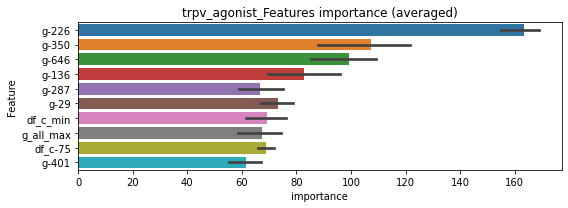

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136571	valid_1's binary_logloss: 0.0219613
[200]	training's binary_logloss: 0.00172248	valid_1's binary_logloss: 0.00671356
[300]	training's binary_logloss: 0.000491186	valid_1's binary_logloss: 0.00441904
[400]	training's binary_logloss: 0.000256995	valid_1's binary_logloss: 0.0037424
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000227829	valid_1's binary_logloss: 0.00369084


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136259	valid_1's binary_logloss: 0.0199872
[200]	training's binary_logloss: 0.00172283	valid_1's binary_logloss: 0.00558807
[300]	training's binary_logloss: 0.000502051	valid_1's binary_logloss: 0.00359528
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000290228	valid_1's binary_logloss: 0.00317438


trpv_agonist logloss: 0.0034326095475336964
trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048301	valid_1's binary_logloss: 0.0952337
[200]	training's binary_logloss: 0.00914963	valid_1's binary_logloss: 0.0483484
[300]	training's binary_logloss: 0.00252736	valid_1's binary_logloss: 0.0372527
[400]	training's binary_logloss: 0.0011542	valid_1's binary_logloss: 0.0340297
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00112739	valid_1's binary_logloss: 0.0337607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517046	valid_1's binary_logloss: 0.0865316
[200]	training's binary_logloss: 0.00984174	valid_1's binary_logloss: 0.0314543
[300]	training's binary_logloss: 0.00271296	valid_1's binary_logloss: 0.017969
[400]	training's binary_logloss: 0.0012272	valid_1's binary_logloss: 0.0135088
[500]	training's binary_logloss: 0.000752142	valid_1's binary_logloss: 0.0122394
Early stopping, best iteration is:
[523]	trainin

1 / 3 AUC score:0.999
y_Threshold: 0.0062197, Threshold: 0.0096184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00866, conf_1:0.01058
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0096184
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.0196184
Num_p_label: 6.0, Expected: 8.0, Adj_threshold_3: 0.0296184
threshold: 0.0296184, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447438	valid_1's binary_logloss: 0.086163
[200]	training's binary_logloss: 0.00836318	valid_1's binary_logloss: 0.0400527
[300]	training's binary_logloss: 0.00237685	valid_1's binary_logloss: 0.0288148
[400]	training's binary_logloss: 0.00111471	valid_1's binary_logloss: 0.0253291
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00109693	valid_1's binary_logloss: 0.0252073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505128	valid_1's binary_logloss: 0.0808941
[200]	training's binary_logloss: 0.00912715	valid_1's binary_logloss: 0.0285556
[300]	training's binary_logloss: 0.00258704	valid_1's binary_logloss: 0.0166449
[400]	training's binary_logloss: 0.00118848	valid_1's binary_logloss: 0.0128135
[500]	training's binary_logloss: 0.00073352	valid_1's binary_logloss: 0.0116114
Early stopping, best iteration is:
[515]	train

2 / 3 AUC score:1.000
y_Threshold: 0.0232442, Threshold: 0.0296184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0040181 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.02666, conf_1:0.03258
threshold: 0.0296184, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491219	valid_1's binary_logloss: 0.0856092
[200]	training's binary_logloss: 0.00869626	valid_1's binary_logloss: 0.0320348
[300]	training's binary_logloss: 0.0024013	valid_1's binary_logloss: 0.0205789
[400]	training's binary_logloss: 0.00111703	valid_1's binary_logloss: 0.017227
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00075155	valid_1's binary_logloss: 0.0162971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469821	valid_1's binary_logloss: 0.078591
[200]	training's binary_logloss: 0.00861021	valid_1's binary_logloss: 0.0289055
[300]	training's binary_logloss: 0.00245667	valid_1's binary_logloss: 0.0177915
[400]	training's binary_logloss: 0.0011366	valid_1's binary_logloss: 0.0147057
[500]	training's binary_logloss: 0.000712832	valid_1's binary_logloss: 0.0136211
Early stopping, best iteration is:
[540]	trainin

3 / 3 AUC score:1.000
y_Threshold: 0.0288129, Threshold: 0.0296184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0037670 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.02666, conf_1:0.03258
threshold: 0.0296184, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 664.0/7773, y_label_rate: 0.0854239


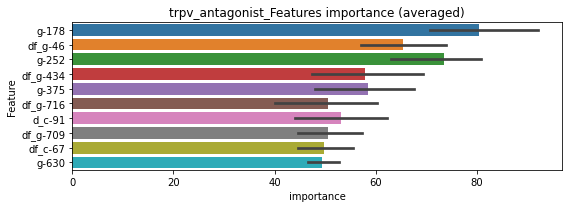

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268278	valid_1's binary_logloss: 0.0534247
[200]	training's binary_logloss: 0.00498291	valid_1's binary_logloss: 0.0265049
[300]	training's binary_logloss: 0.00134721	valid_1's binary_logloss: 0.0216548
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000777423	valid_1's binary_logloss: 0.020715


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280102	valid_1's binary_logloss: 0.055053
[200]	training's binary_logloss: 0.0053847	valid_1's binary_logloss: 0.0287115
[300]	training's binary_logloss: 0.00147103	valid_1's binary_logloss: 0.0228182
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00147103	valid_1's binary_logloss: 0.0228182


trpv_antagonist logloss: 0.02176647546082408
tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041	valid_1's binary_logloss: 0.120193
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0115248	valid_1's binary_logloss: 0.106156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455959	valid_1's binary_logloss: 0.0972476
[200]	training's binary_logloss: 0.00858531	valid_1's binary_logloss: 0.0762804
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00734682	valid_1's binary_logloss: 0.0760306


1 / 3 AUC score:0.985
y_Threshold: 0.0260480, Threshold: 0.1581462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 193 → Positive_corect_labels: 622/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.01327, Num_p_label: 80.0, conf_0:0.14233, conf_1:0.17396
threshold: 0.1581462, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308172	valid_1's binary_logloss: 0.0814304
[200]	training's binary_logloss: 0.00467369	valid_1's binary_logloss: 0.0616613
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0031763	valid_1's binary_logloss: 0.0605913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305937	valid_1's binary_logloss: 0.0693288
[200]	training's binary_logloss: 0.00450938	valid_1's binary_logloss: 0.0509002


2 / 3 AUC score:0.996
y_Threshold: 0.0403507, Threshold: 0.1581462, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00309039	valid_1's binary_logloss: 0.0500558


Remove_noisy_labels: 52 → Positive_corect_labels: 596.0/3675
p_label_rate: 0.0296334 Vs.target_rate: 0.01327, Num_p_label: 118.0, conf_0:0.14233, conf_1:0.17396
threshold: 0.1581462, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 596.0/3675, y_label_rate: 0.1621769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264604	valid_1's binary_logloss: 0.0657447
[200]	training's binary_logloss: 0.00339425	valid_1's binary_logloss: 0.0490098
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00238896	valid_1's binary_logloss: 0.048396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267456	valid_1's binary_logloss: 0.0530762
[200]	training's binary_logloss: 0.00370605	valid_1's binary_logloss: 0.0282059
[300]	training's binary_logloss: 0.00119549	valid_1's binary_logloss: 0.0235226
[400]	training's binary_logloss: 0.000557691	valid_1's binary_logloss: 0.0215093
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000546712	valid_1's binary_logloss: 0.0214448


3 / 3 AUC score:0.995
y_Threshold: 0.0414317, Threshold: 0.1581462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 582.0/3647
p_label_rate: 0.0293822 Vs.target_rate: 0.01327, Num_p_label: 117.0, conf_0:0.14233, conf_1:0.17396
threshold: 0.1581462, positive_p_label: 117.0/3982, p_label_rate: 0.0293822
positive_y_label: 699.0/7629, y_label_rate: 0.0916241


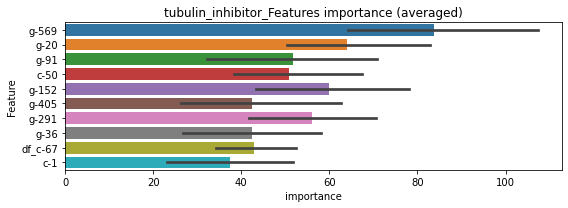

len(train_index) : 3814
len(valid_index) : 3815
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150861	valid_1's binary_logloss: 0.0415514
[200]	training's binary_logloss: 0.00190818	valid_1's binary_logloss: 0.0264424
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00113324	valid_1's binary_logloss: 0.0255132


len(train_index) : 3815
len(valid_index) : 3814
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146831	valid_1's binary_logloss: 0.0369279
[200]	training's binary_logloss: 0.00193518	valid_1's binary_logloss: 0.0235673
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000625434	valid_1's binary_logloss: 0.021609


tubulin_inhibitor logloss: 0.02356136078712939
tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541273	valid_1's binary_logloss: 0.0983207
[200]	training's binary_logloss: 0.0111482	valid_1's binary_logloss: 0.0410832
[300]	training's binary_logloss: 0.00336515	valid_1's binary_logloss: 0.025121
[400]	training's binary_logloss: 0.0015603	valid_1's binary_logloss: 0.0194057
[500]	training's binary_logloss: 0.000965942	valid_1's binary_logloss: 0.0168404
[600]	training's binary_logloss: 0.000717685	valid_1's binary_logloss: 0.0155624
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000690305	valid_1's binary_logloss: 0.0153993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055483	valid_1's binary_logloss: 0.0947394
[200]	training's binary_logloss: 0.0121043	valid_1's binary_logloss: 0.0411952
[300]	training's binary_logloss: 0.00361658	valid_1's binary_logloss: 0.0265554
[400]	training's binary_logloss: 0.00164976	val

1 / 3 AUC score:1.000
y_Threshold: 0.0086453, Threshold: 0.0176533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01589, conf_1:0.01942
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0176533
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.0276533
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.0376533
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.0476533
threshold: 0.0476533, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506332	valid_1's binary_logloss: 0.0978626
[200]	training's binary_logloss: 0.0105177	valid_1's binary_logloss: 0.0442501
[300]	training's binary_logloss: 0.00318529	valid_1's binary_logloss: 0.0297671
[400]	training's binary_logloss: 0.00149064	valid_1's binary_logloss: 0.0259624
[500]	training's binary_logloss: 0.000931999	valid_1's binary_logloss: 0.0245027
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000968009	valid_1's binary_logloss: 0.0244707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518997	valid_1's binary_logloss: 0.0998186
[200]	training's binary_logloss: 0.010482	valid_1's binary_logloss: 0.0438329
[300]	training's binary_logloss: 0.00312374	valid_1's binary_logloss: 0.0284192
[400]	training's binary_logloss: 0.00146425	valid_1's binary_logloss: 0.0238069
[500]	training's binary_logloss: 0.000915494	v

2 / 3 AUC score:1.000
y_Threshold: 0.0422214, Threshold: 0.0476533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3785
p_label_rate: 0.0135610 Vs.target_rate: 0.00307, Num_p_label: 54.0, conf_0:0.04289, conf_1:0.05242
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_1: 0.0476533
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_2: 0.0576533
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.0676533
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_4: 0.0776533
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_5: 0.0876533
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_6: 0.0976533
threshold: 0.0976533, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522642	valid_1's binary_logloss: 0.104272
[200]	training's binary_logloss: 0.010444	valid_1's binary_logloss: 0.0501478
[300]	training's binary_logloss: 0.0030978	valid_1's binary_logloss: 0.0347112
[400]	training's binary_logloss: 0.00145923	valid_1's binary_logloss: 0.0308462
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00101457	valid_1's binary_logloss: 0.0295261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504181	valid_1's binary_logloss: 0.101639
[200]	training's binary_logloss: 0.0101659	valid_1's binary_logloss: 0.0484248
[300]	training's binary_logloss: 0.00305192	valid_1's binary_logloss: 0.0345436
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00160268	valid_1's binary_logloss: 0.0312505


3 / 3 AUC score:0.999
y_Threshold: 0.0400537, Threshold: 0.0976533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 639.0/3767
p_label_rate: 0.0067805 Vs.target_rate: 0.00307, Num_p_label: 27.0, conf_0:0.08789, conf_1:0.10742
threshold: 0.0976533, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 666.0/7749, y_label_rate: 0.0859466


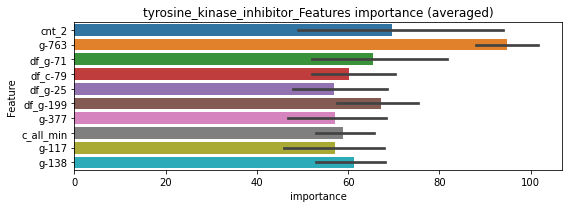

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287741	valid_1's binary_logloss: 0.0729582
[200]	training's binary_logloss: 0.00582063	valid_1's binary_logloss: 0.0472096
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00189834	valid_1's binary_logloss: 0.042077


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298802	valid_1's binary_logloss: 0.0606893
[200]	training's binary_logloss: 0.00593848	valid_1's binary_logloss: 0.0304763
[300]	training's binary_logloss: 0.00174873	valid_1's binary_logloss: 0.0234896
[400]	training's binary_logloss: 0.000836799	valid_1's binary_logloss: 0.0217302
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000732595	valid_1's binary_logloss: 0.0215136


tyrosine_kinase_inhibitor logloss: 0.03179661048220462
ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018067	valid_1's binary_logloss: 0.0212068
[200]	training's binary_logloss: 0.00179958	valid_1's binary_logloss: 0.00333783
[300]	training's binary_logloss: 0.000501257	valid_1's binary_logloss: 0.00148302
[400]	training's binary_logloss: 0.000293777	valid_1's binary_logloss: 0.00108315
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000259343	valid_1's binary_logloss: 0.0010348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180589	valid_1's binary_logloss: 0.0211205
[200]	training's binary_logloss: 0.00176767	valid_1's binary_logloss: 0.00330992
[300]	training's binary_logloss: 0.000502049	valid_1's binary_logloss: 0.00147133
[400]	training's binary_logloss: 0.000287952	valid_1's binary_logloss: 0.00109789
[500]	training's binary_logloss: 0.00025471	valid_1's binary_logloss: 0.00102703
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0009886, Threshold: 0.0015601, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00140, conf_1:0.00172
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015601
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0115601
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0215601
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0315601
threshold: 0.0315601, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179445	valid_1's binary_logloss: 0.0216641
[200]	training's binary_logloss: 0.0016975	valid_1's binary_logloss: 0.00368033
[300]	training's binary_logloss: 0.000469178	valid_1's binary_logloss: 0.00187456
[400]	training's binary_logloss: 0.000274927	valid_1's binary_logloss: 0.0014953
[500]	training's binary_logloss: 0.000242145	valid_1's binary_logloss: 0.00142593
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000241719	valid_1's binary_logloss: 0.00142481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180598	valid_1's binary_logloss: 0.0199383
[200]	training's binary_logloss: 0.00171128	valid_1's binary_logloss: 0.00240925
[300]	training's binary_logloss: 0.000476648	valid_1's binary_logloss: 0.000861537
[400]	training's binary_logloss: 0.000278616	valid_1's binary_logloss: 0.000581732
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1771577, Threshold: 0.0315601, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0095429 Vs.target_rate: 0.00050, Num_p_label: 38.0, conf_0:0.02840, conf_1:0.03472
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_1: 0.0315601
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_2: 0.0415601
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_3: 0.0515601
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_4: 0.0615601
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_5: 0.0715601
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_6: 0.0815601
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_7: 0.0915601
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_8: 0.1015601
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_9: 0.1115601
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_10: 0.1215601
threshold: 0.1315601, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179445	valid_1's binary_logloss: 0.0216641
[200]	training's binary_logloss: 0.0016975	valid_1's binary_logloss: 0.00368033
[300]	training's binary_logloss: 0.000469178	valid_1's binary_logloss: 0.00187456
[400]	training's binary_logloss: 0.000274927	valid_1's binary_logloss: 0.0014953
[500]	training's binary_logloss: 0.000242145	valid_1's binary_logloss: 0.00142593
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000241719	valid_1's binary_logloss: 0.00142481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180598	valid_1's binary_logloss: 0.0199383
[200]	training's binary_logloss: 0.00171128	valid_1's binary_logloss: 0.00240925
[300]	training's binary_logloss: 0.000476648	valid_1's binary_logloss: 0.000861537
[400]	training's binary_logloss: 0.000278616	valid_1's binary_logloss: 0.000581732
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1771577, Threshold: 0.1315601, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0047715 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.11840, conf_1:0.14472
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.1315601
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.1415601
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_3: 0.1515601
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_4: 0.1615601
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_5: 0.1715601
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_6: 0.1815601
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.1915601
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.2015601
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_9: 0.2115601
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_10: 0.2215601
threshold: 0.2315601, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 671.0/7794, y_label_rate: 0.0860919


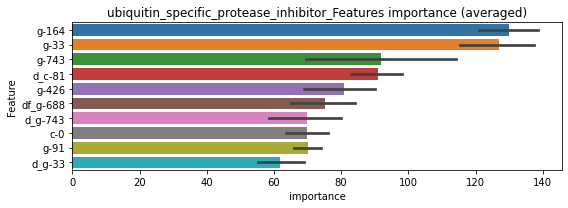

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00986232	valid_1's binary_logloss: 0.0177563
[200]	training's binary_logloss: 0.000976096	valid_1's binary_logloss: 0.00849335
[300]	training's binary_logloss: 0.000269977	valid_1's binary_logloss: 0.00752011
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000267877	valid_1's binary_logloss: 0.00750797


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103445	valid_1's binary_logloss: 0.0134295
[200]	training's binary_logloss: 0.00105135	valid_1's binary_logloss: 0.00389254
[300]	training's binary_logloss: 0.00029781	valid_1's binary_logloss: 0.00308011
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000227131	valid_1's binary_logloss: 0.00298582


ubiquitin_specific_protease_inhibitor logloss: 0.005246893344575179
vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081


neg labels: 3289 → selected neg labels: 3258


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591057	valid_1's binary_logloss: 0.162
[200]	training's binary_logloss: 0.0136156	valid_1's binary_logloss: 0.123937
[300]	training's binary_logloss: 0.00432617	valid_1's binary_logloss: 0.114222
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00367491	valid_1's binary_logloss: 0.113752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666841	valid_1's binary_logloss: 0.143082
[200]	training's binary_logloss: 0.0166598	valid_1's binary_logloss: 0.0902094
[300]	training's binary_logloss: 0.00534377	valid_1's binary_logloss: 0.0734173
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00413258	valid_1's binary_logloss: 0.0711967


1 / 3 AUC score:0.988
y_Threshold: 0.0438305, Threshold: 0.1821461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 185 → Positive_corect_labels: 624/3724
p_label_rate: 0.0200904 Vs.target_rate: 0.00714, Num_p_label: 80.0, conf_0:0.16393, conf_1:0.20036
threshold: 0.1821461, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 624.0/3724, y_label_rate: 0.1675618
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052373	valid_1's binary_logloss: 0.13046
[200]	training's binary_logloss: 0.0109834	valid_1's binary_logloss: 0.0893902
[300]	training's binary_logloss: 0.00339357	valid_1's binary_logloss: 0.0794777
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00193458	valid_1's binary_logloss: 0.0774738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527521	valid_1's binary_logloss: 0.113937
[200]	training's binary_logloss: 0.011038	valid_1's binary_logloss: 0.0704727
[300]	training's binary_logloss: 0.00340677	valid_1's binary_logloss: 0.06075
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00263111	valid_1's binary_logloss: 0.0597692


2 / 3 AUC score:0.994
y_Threshold: 0.0804490, Threshold: 0.1821461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 592.0/3660
p_label_rate: 0.0434455 Vs.target_rate: 0.00714, Num_p_label: 173.0, conf_0:0.16393, conf_1:0.20036
Num_p_label: 173.0, Expected: 28.4, Adj_threshold_1: 0.1821461
Num_p_label: 168.0, Expected: 28.4, Adj_threshold_2: 0.1921461
Num_p_label: 164.0, Expected: 28.4, Adj_threshold_3: 0.2021461
Num_p_label: 161.0, Expected: 28.4, Adj_threshold_4: 0.2121461
Num_p_label: 157.0, Expected: 28.4, Adj_threshold_5: 0.2221461
Num_p_label: 153.0, Expected: 28.4, Adj_threshold_6: 0.2321461
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_7: 0.2421461
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_8: 0.2521461
Num_p_label: 141.0, Expected: 28.4, Adj_threshold_9: 0.2621461
Num_p_label: 141.0, Expected: 28.4, Adj_threshold_10: 0.2721461
threshold: 0.2821461, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 592.0/3660, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496061	valid_1's binary_logloss: 0.109391
[200]	training's binary_logloss: 0.00987996	valid_1's binary_logloss: 0.0702149
[300]	training's binary_logloss: 0.00296128	valid_1's binary_logloss: 0.0624586
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00232073	valid_1's binary_logloss: 0.0615085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455154	valid_1's binary_logloss: 0.117584
[200]	training's binary_logloss: 0.00890055	valid_1's binary_logloss: 0.0770311
[300]	training's binary_logloss: 0.00271982	valid_1's binary_logloss: 0.0663881
[400]	training's binary_logloss: 0.00129554	valid_1's binary_logloss: 0.0630751
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00129554	valid_1's binary_logloss: 0.0630751


3 / 3 AUC score:0.993
y_Threshold: 0.0787475, Threshold: 0.2821461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 566.0/3608
p_label_rate: 0.0439478 Vs.target_rate: 0.00714, Num_p_label: 175.0, conf_0:0.25393, conf_1:0.31036
Num_p_label: 175.0, Expected: 28.4, Adj_threshold_1: 0.2821461
Num_p_label: 172.0, Expected: 28.4, Adj_threshold_2: 0.2921461
Num_p_label: 170.0, Expected: 28.4, Adj_threshold_3: 0.3021461
Num_p_label: 169.0, Expected: 28.4, Adj_threshold_4: 0.3121461
Num_p_label: 168.0, Expected: 28.4, Adj_threshold_5: 0.3221461
Num_p_label: 167.0, Expected: 28.4, Adj_threshold_6: 0.3321461
Num_p_label: 165.0, Expected: 28.4, Adj_threshold_7: 0.3421461
Num_p_label: 162.0, Expected: 28.4, Adj_threshold_8: 0.3521461
Num_p_label: 159.0, Expected: 28.4, Adj_threshold_9: 0.3621461
Num_p_label: 155.0, Expected: 28.4, Adj_threshold_10: 0.3721461
threshold: 0.3821461, positive_p_label: 153.0/3982, p_label_rate: 0.0384229
positive_y_label: 719.0/7590, y_label_r

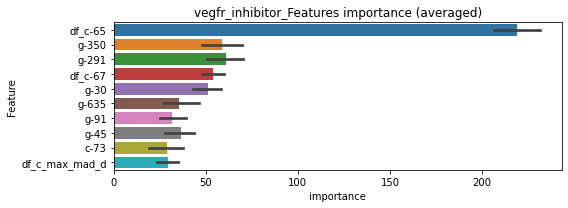

len(train_index) : 3795
len(valid_index) : 3795
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307015	valid_1's binary_logloss: 0.071779
[200]	training's binary_logloss: 0.00609038	valid_1's binary_logloss: 0.0434283
[300]	training's binary_logloss: 0.0018141	valid_1's binary_logloss: 0.0345319
[400]	training's binary_logloss: 0.000828457	valid_1's binary_logloss: 0.0306384
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000653738	valid_1's binary_logloss: 0.0292213


len(train_index) : 3795
len(valid_index) : 3795
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310774	valid_1's binary_logloss: 0.0732111
[200]	training's binary_logloss: 0.00618694	valid_1's binary_logloss: 0.044168
[300]	training's binary_logloss: 0.00184018	valid_1's binary_logloss: 0.0370021
[400]	training's binary_logloss: 0.000823212	valid_1's binary_logloss: 0.0339931
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000872537	valid_1's binary_logloss: 0.0339776


vegfr_inhibitor logloss: 0.031599432694118815
vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300036	valid_1's binary_logloss: 0.0477544
[200]	training's binary_logloss: 0.00423131	valid_1's binary_logloss: 0.0151024
[300]	training's binary_logloss: 0.00120369	valid_1's binary_logloss: 0.0078296
[400]	training's binary_logloss: 0.000617839	valid_1's binary_logloss: 0.0059685
[500]	training's binary_logloss: 0.000432905	valid_1's binary_logloss: 0.0051276
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000435582	valid_1's binary_logloss: 0.0051189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325846	valid_1's binary_logloss: 0.0485529
[200]	training's binary_logloss: 0.00468565	valid_1's binary_logloss: 0.0136363
[300]	training's binary_logloss: 0.00128657	valid_1's binary_logloss: 0.00687456
[400]	training's binary_logloss: 0.000636644	valid_1's binary_logloss: 0.00502554
Early stopping, best iteration is:
[410

1 / 3 AUC score:1.000
y_Threshold: 0.0031956, Threshold: 0.0061372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00552, conf_1:0.00675
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0061372
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_2: 0.0161372
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.0261372
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.0361372
threshold: 0.0361372, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296233	valid_1's binary_logloss: 0.0511811
[200]	training's binary_logloss: 0.00409244	valid_1's binary_logloss: 0.0173295
[300]	training's binary_logloss: 0.00117805	valid_1's binary_logloss: 0.0104353
[400]	training's binary_logloss: 0.000600153	valid_1's binary_logloss: 0.00845839
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000454265	valid_1's binary_logloss: 0.0076828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031198	valid_1's binary_logloss: 0.0477002
[200]	training's binary_logloss: 0.00425764	valid_1's binary_logloss: 0.0131753
[300]	training's binary_logloss: 0.00119808	valid_1's binary_logloss: 0.00691219
[400]	training's binary_logloss: 0.000603869	valid_1's binary_logloss: 0.00574809
[500]	training's binary_logloss: 0.000428632	valid_1's binary_logloss: 0.00503617
Early stopping, best iteration is:
[54

2 / 3 AUC score:1.000
y_Threshold: 0.0575111, Threshold: 0.0361372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00109, Num_p_label: 21.0, conf_0:0.03252, conf_1:0.03975
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_1: 0.0361372
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_2: 0.0461372
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_3: 0.0561372
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_4: 0.0661372
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_5: 0.0761372
threshold: 0.0761372, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296233	valid_1's binary_logloss: 0.0511811
[200]	training's binary_logloss: 0.00409244	valid_1's binary_logloss: 0.0173295
[300]	training's binary_logloss: 0.00117805	valid_1's binary_logloss: 0.0104353
[400]	training's binary_logloss: 0.000600153	valid_1's binary_logloss: 0.00845839
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000454265	valid_1's binary_logloss: 0.0076828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031198	valid_1's binary_logloss: 0.0477002
[200]	training's binary_logloss: 0.00425764	valid_1's binary_logloss: 0.0131753
[300]	training's binary_logloss: 0.00119808	valid_1's binary_logloss: 0.00691219
[400]	training's binary_logloss: 0.000603869	valid_1's binary_logloss: 0.00574809
[500]	training's binary_logloss: 0.000428632	valid_1's binary_logloss: 0.00503617
Early stopping, best iteration is:
[54

3 / 3 AUC score:1.000
y_Threshold: 0.0575111, Threshold: 0.0761372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.06852, conf_1:0.08375
threshold: 0.0761372, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


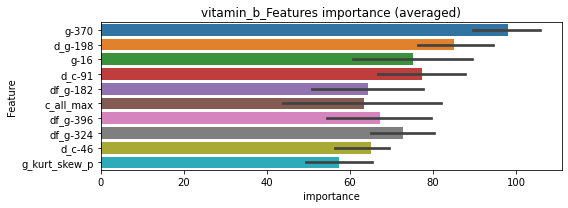

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165163	valid_1's binary_logloss: 0.0315443
[200]	training's binary_logloss: 0.0023048	valid_1's binary_logloss: 0.0140414
[300]	training's binary_logloss: 0.000638401	valid_1's binary_logloss: 0.0115478
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000436074	valid_1's binary_logloss: 0.0112816


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017293	valid_1's binary_logloss: 0.0252109
[200]	training's binary_logloss: 0.00245989	valid_1's binary_logloss: 0.00785268
[300]	training's binary_logloss: 0.000679252	valid_1's binary_logloss: 0.00469865
[400]	training's binary_logloss: 0.000336316	valid_1's binary_logloss: 0.00389469
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000242493	valid_1's binary_logloss: 0.00366692


vitamin_b logloss: 0.007474259847992486
vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279365	valid_1's binary_logloss: 0.0469553
[200]	training's binary_logloss: 0.00370378	valid_1's binary_logloss: 0.0123935
[300]	training's binary_logloss: 0.00105204	valid_1's binary_logloss: 0.00656738
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000637348	valid_1's binary_logloss: 0.00535513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281029	valid_1's binary_logloss: 0.0427486
[200]	training's binary_logloss: 0.00373734	valid_1's binary_logloss: 0.0100712
[300]	training's binary_logloss: 0.00107601	valid_1's binary_logloss: 0.00494706
[400]	training's binary_logloss: 0.000543363	valid_1's binary_logloss: 0.00368677
[500]	training's binary_logloss: 0.000380259	valid_1's binary_logloss: 0.00324642
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000353455	valid_1's binary_logloss: 0.00317214


1 / 3 AUC score:1.000
y_Threshold: 0.0027608, Threshold: 0.0056876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164, Num_p_label: 80.0, conf_0:0.00512, conf_1:0.00626
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0056876
Num_p_label: 28.0, Expected: 6.5, Adj_threshold_2: 0.0156876
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_3: 0.0256876
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_4: 0.0356876
Num_p_label: 11.0, Expected: 6.5, Adj_threshold_5: 0.0456876
threshold: 0.0456876, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0470859
[200]	training's binary_logloss: 0.00361474	valid_1's binary_logloss: 0.0141132
[300]	training's binary_logloss: 0.00103172	valid_1's binary_logloss: 0.00776032
[400]	training's binary_logloss: 0.000517188	valid_1's binary_logloss: 0.00588978
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00053015	valid_1's binary_logloss: 0.00586335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282229	valid_1's binary_logloss: 0.0412938
[200]	training's binary_logloss: 0.00368113	valid_1's binary_logloss: 0.00928106
[300]	training's binary_logloss: 0.00104911	valid_1's binary_logloss: 0.00436176
[400]	training's binary_logloss: 0.000526929	valid_1's binary_logloss: 0.00303668
[500]	training's binary_logloss: 0.000374314	valid_1's binary_logloss: 0.00260303
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0409932, Threshold: 0.0456876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0045203 Vs.target_rate: 0.00164, Num_p_label: 18.0, conf_0:0.04112, conf_1:0.05026
threshold: 0.0456876, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0470859
[200]	training's binary_logloss: 0.00361474	valid_1's binary_logloss: 0.0141132
[300]	training's binary_logloss: 0.00103172	valid_1's binary_logloss: 0.00776032
[400]	training's binary_logloss: 0.000517188	valid_1's binary_logloss: 0.00588978
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00053015	valid_1's binary_logloss: 0.00586335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282229	valid_1's binary_logloss: 0.0412938
[200]	training's binary_logloss: 0.00368113	valid_1's binary_logloss: 0.00928106
[300]	training's binary_logloss: 0.00104911	valid_1's binary_logloss: 0.00436176
[400]	training's binary_logloss: 0.000526929	valid_1's binary_logloss: 0.00303668
[500]	training's binary_logloss: 0.000374314	valid_1's binary_logloss: 0.00260303
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0409932, Threshold: 0.0456876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0045203 Vs.target_rate: 0.00164, Num_p_label: 18.0, conf_0:0.04112, conf_1:0.05026
threshold: 0.0456876, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7787, y_label_rate: 0.0865545


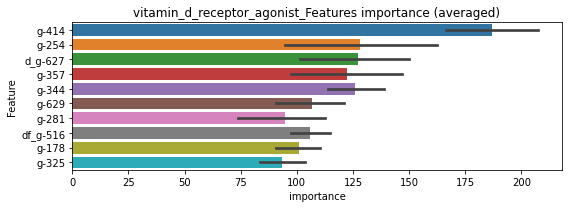

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150784	valid_1's binary_logloss: 0.0282451
[200]	training's binary_logloss: 0.00192306	valid_1's binary_logloss: 0.0120008
[300]	training's binary_logloss: 0.000545489	valid_1's binary_logloss: 0.0095894
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000378987	valid_1's binary_logloss: 0.00918272


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015525	valid_1's binary_logloss: 0.0273419
[200]	training's binary_logloss: 0.00198704	valid_1's binary_logloss: 0.0103967
[300]	training's binary_logloss: 0.000571184	valid_1's binary_logloss: 0.00817948
[400]	training's binary_logloss: 0.000287922	valid_1's binary_logloss: 0.00755882
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000287922	valid_1's binary_logloss: 0.00755882


vitamin_d_receptor_agonist logloss: 0.008370872135259534
wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348649	valid_1's binary_logloss: 0.0577556
[200]	training's binary_logloss: 0.00516043	valid_1's binary_logloss: 0.0144892
[300]	training's binary_logloss: 0.00140602	valid_1's binary_logloss: 0.00635911
[400]	training's binary_logloss: 0.000686552	valid_1's binary_logloss: 0.00430069
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000519364	valid_1's binary_logloss: 0.00368524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386499	valid_1's binary_logloss: 0.0552418
[200]	training's binary_logloss: 0.00586739	valid_1's binary_logloss: 0.0146256
[300]	training's binary_logloss: 0.00155761	valid_1's binary_logloss: 0.00636274
[400]	training's binary_logloss: 0.000742652	valid_1's binary_logloss: 0.00429246
[500]	training's binary_logloss: 0.000489174	valid_1's binary_logloss: 0.00342359
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0025488, Threshold: 0.0040269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00362, conf_1:0.00443
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0040269
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.0140269
threshold: 0.0140269, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344943	valid_1's binary_logloss: 0.0536277
[200]	training's binary_logloss: 0.00509377	valid_1's binary_logloss: 0.0131938
[300]	training's binary_logloss: 0.00141461	valid_1's binary_logloss: 0.00580351
[400]	training's binary_logloss: 0.000692026	valid_1's binary_logloss: 0.00383346
[500]	training's binary_logloss: 0.000469962	valid_1's binary_logloss: 0.00311333
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00044588	valid_1's binary_logloss: 0.00305141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374789	valid_1's binary_logloss: 0.0562638
[200]	training's binary_logloss: 0.00539235	valid_1's binary_logloss: 0.0146562
[300]	training's binary_logloss: 0.00147545	valid_1's binary_logloss: 0.00673225
[400]	training's binary_logloss: 0.000715561	valid_1's binary_logloss: 0.00464445
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0604024, Threshold: 0.0140269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0040181 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.01262, conf_1:0.01543
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.0140269
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_2: 0.0240269
threshold: 0.0240269, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344943	valid_1's binary_logloss: 0.0536277
[200]	training's binary_logloss: 0.00509377	valid_1's binary_logloss: 0.0131938
[300]	training's binary_logloss: 0.00141461	valid_1's binary_logloss: 0.00580351
[400]	training's binary_logloss: 0.000692026	valid_1's binary_logloss: 0.00383346
[500]	training's binary_logloss: 0.000469962	valid_1's binary_logloss: 0.00311333
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00044588	valid_1's binary_logloss: 0.00305141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374789	valid_1's binary_logloss: 0.0562638
[200]	training's binary_logloss: 0.00539235	valid_1's binary_logloss: 0.0146562
[300]	training's binary_logloss: 0.00147545	valid_1's binary_logloss: 0.00673225
[400]	training's binary_logloss: 0.000715561	valid_1's binary_logloss: 0.00464445
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0604024, Threshold: 0.0240269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00126, Num_p_label: 5.0, conf_0:0.02162, conf_1:0.02643
threshold: 0.0240269, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


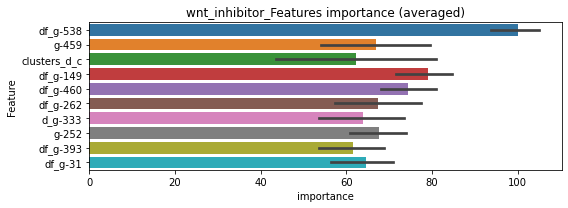

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202825	valid_1's binary_logloss: 0.0365013
[200]	training's binary_logloss: 0.0029493	valid_1's binary_logloss: 0.0145158
[300]	training's binary_logloss: 0.000758109	valid_1's binary_logloss: 0.0116306
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000493101	valid_1's binary_logloss: 0.0110356


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213769	valid_1's binary_logloss: 0.0322793
[200]	training's binary_logloss: 0.00314089	valid_1's binary_logloss: 0.00793775
[300]	training's binary_logloss: 0.000808122	valid_1's binary_logloss: 0.00365432
[400]	training's binary_logloss: 0.000382579	valid_1's binary_logloss: 0.00278128
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000267696	valid_1's binary_logloss: 0.00250553


wnt_inhibitor logloss: 0.006770580105830902


In [45]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [46]:
sub.to_csv('submission.csv', index=False)

In [47]:
print(f"CV:{np.mean(scores)}")

CV:0.020234175240447416


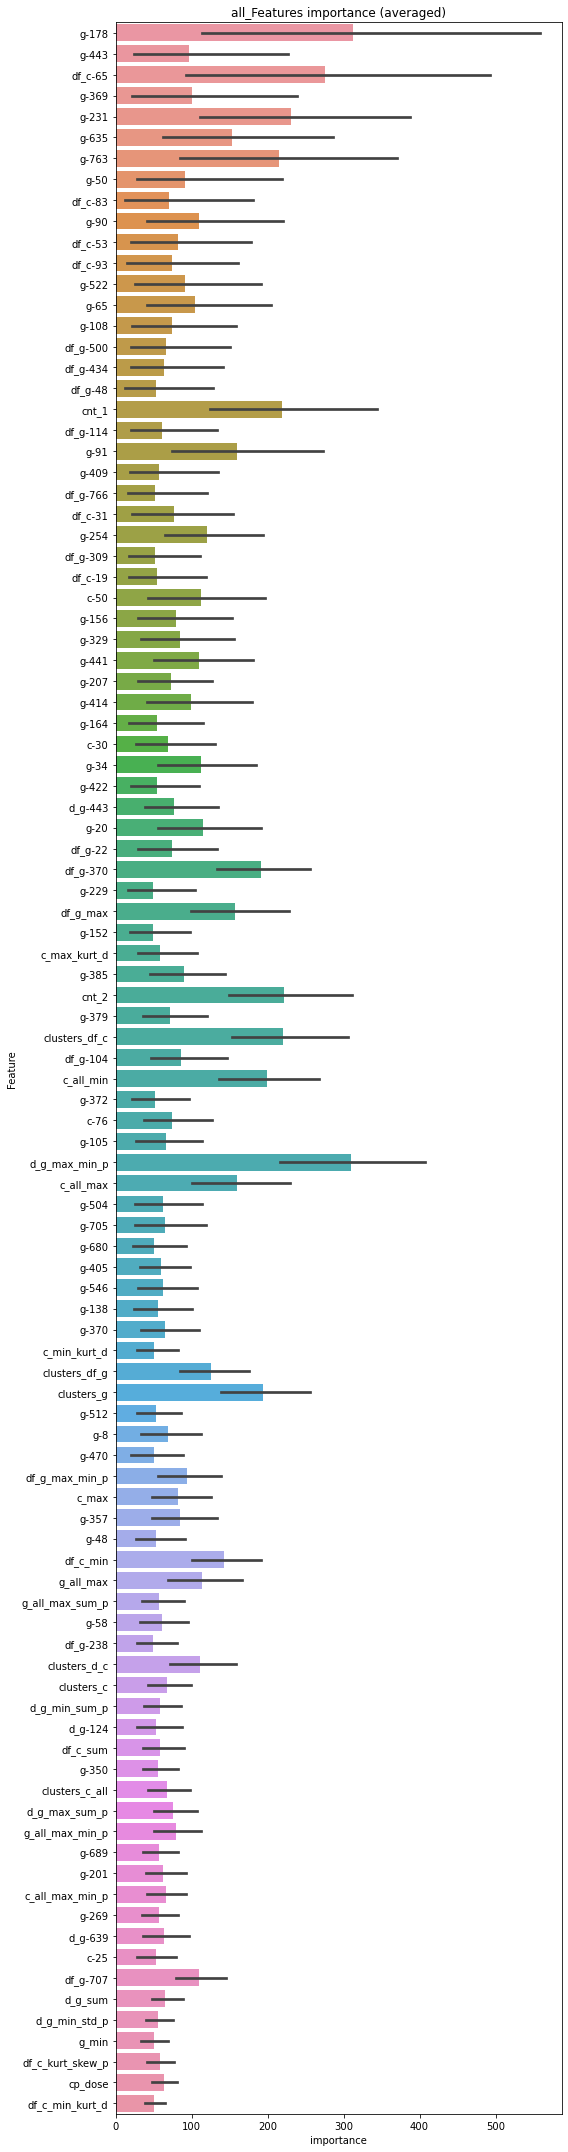

In [48]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)